In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns56
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

In [2]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

# def statisticalComparison(sessionfile,clust,preCondition,postCondition):
#     preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
#     postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     preTrials = allConditions[preCondition].trials
#     postTrials = allConditions[postCondition].trials
        
#     preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
#     postTrialRates = np.full_like(postTrials,np.nan,dtype='float')    
#     for idx,trial in enumerate(preTrials):
#         start,end = preInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
#     for idx,trial in enumerate(postTrials):
#         start,end = postInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
#     pvalue_inc = mannwhitneyu(preTrialRates,postTrialRates,alternative='less').pvalue
#     pvalue_dec = mannwhitneyu(preTrialRates,postTrialRates,alternative='greater').pvalue
#     if pvalue_inc <= 0.05:# and np.median(postTrialRates) > np.median(preTrialRates):
#         label = 'increased'
#         pvalue = pvalue_inc
#     elif pvalue_dec <= 0.05:# and np.median(postTrialRates) < np.median(preTrialRates):
#         label = 'decreased'
#         pvalue = pvalue_dec
#     else:
#         label = 'unchanged'
#         pvalue = np.min(pvalue_inc,pvalue_dec)
#     return label,pvalue

def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    print(f"inc: {p_increased}, dec: {p_decreased}, unch: {p_unchanged}")
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [3]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [4]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [5]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 2\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

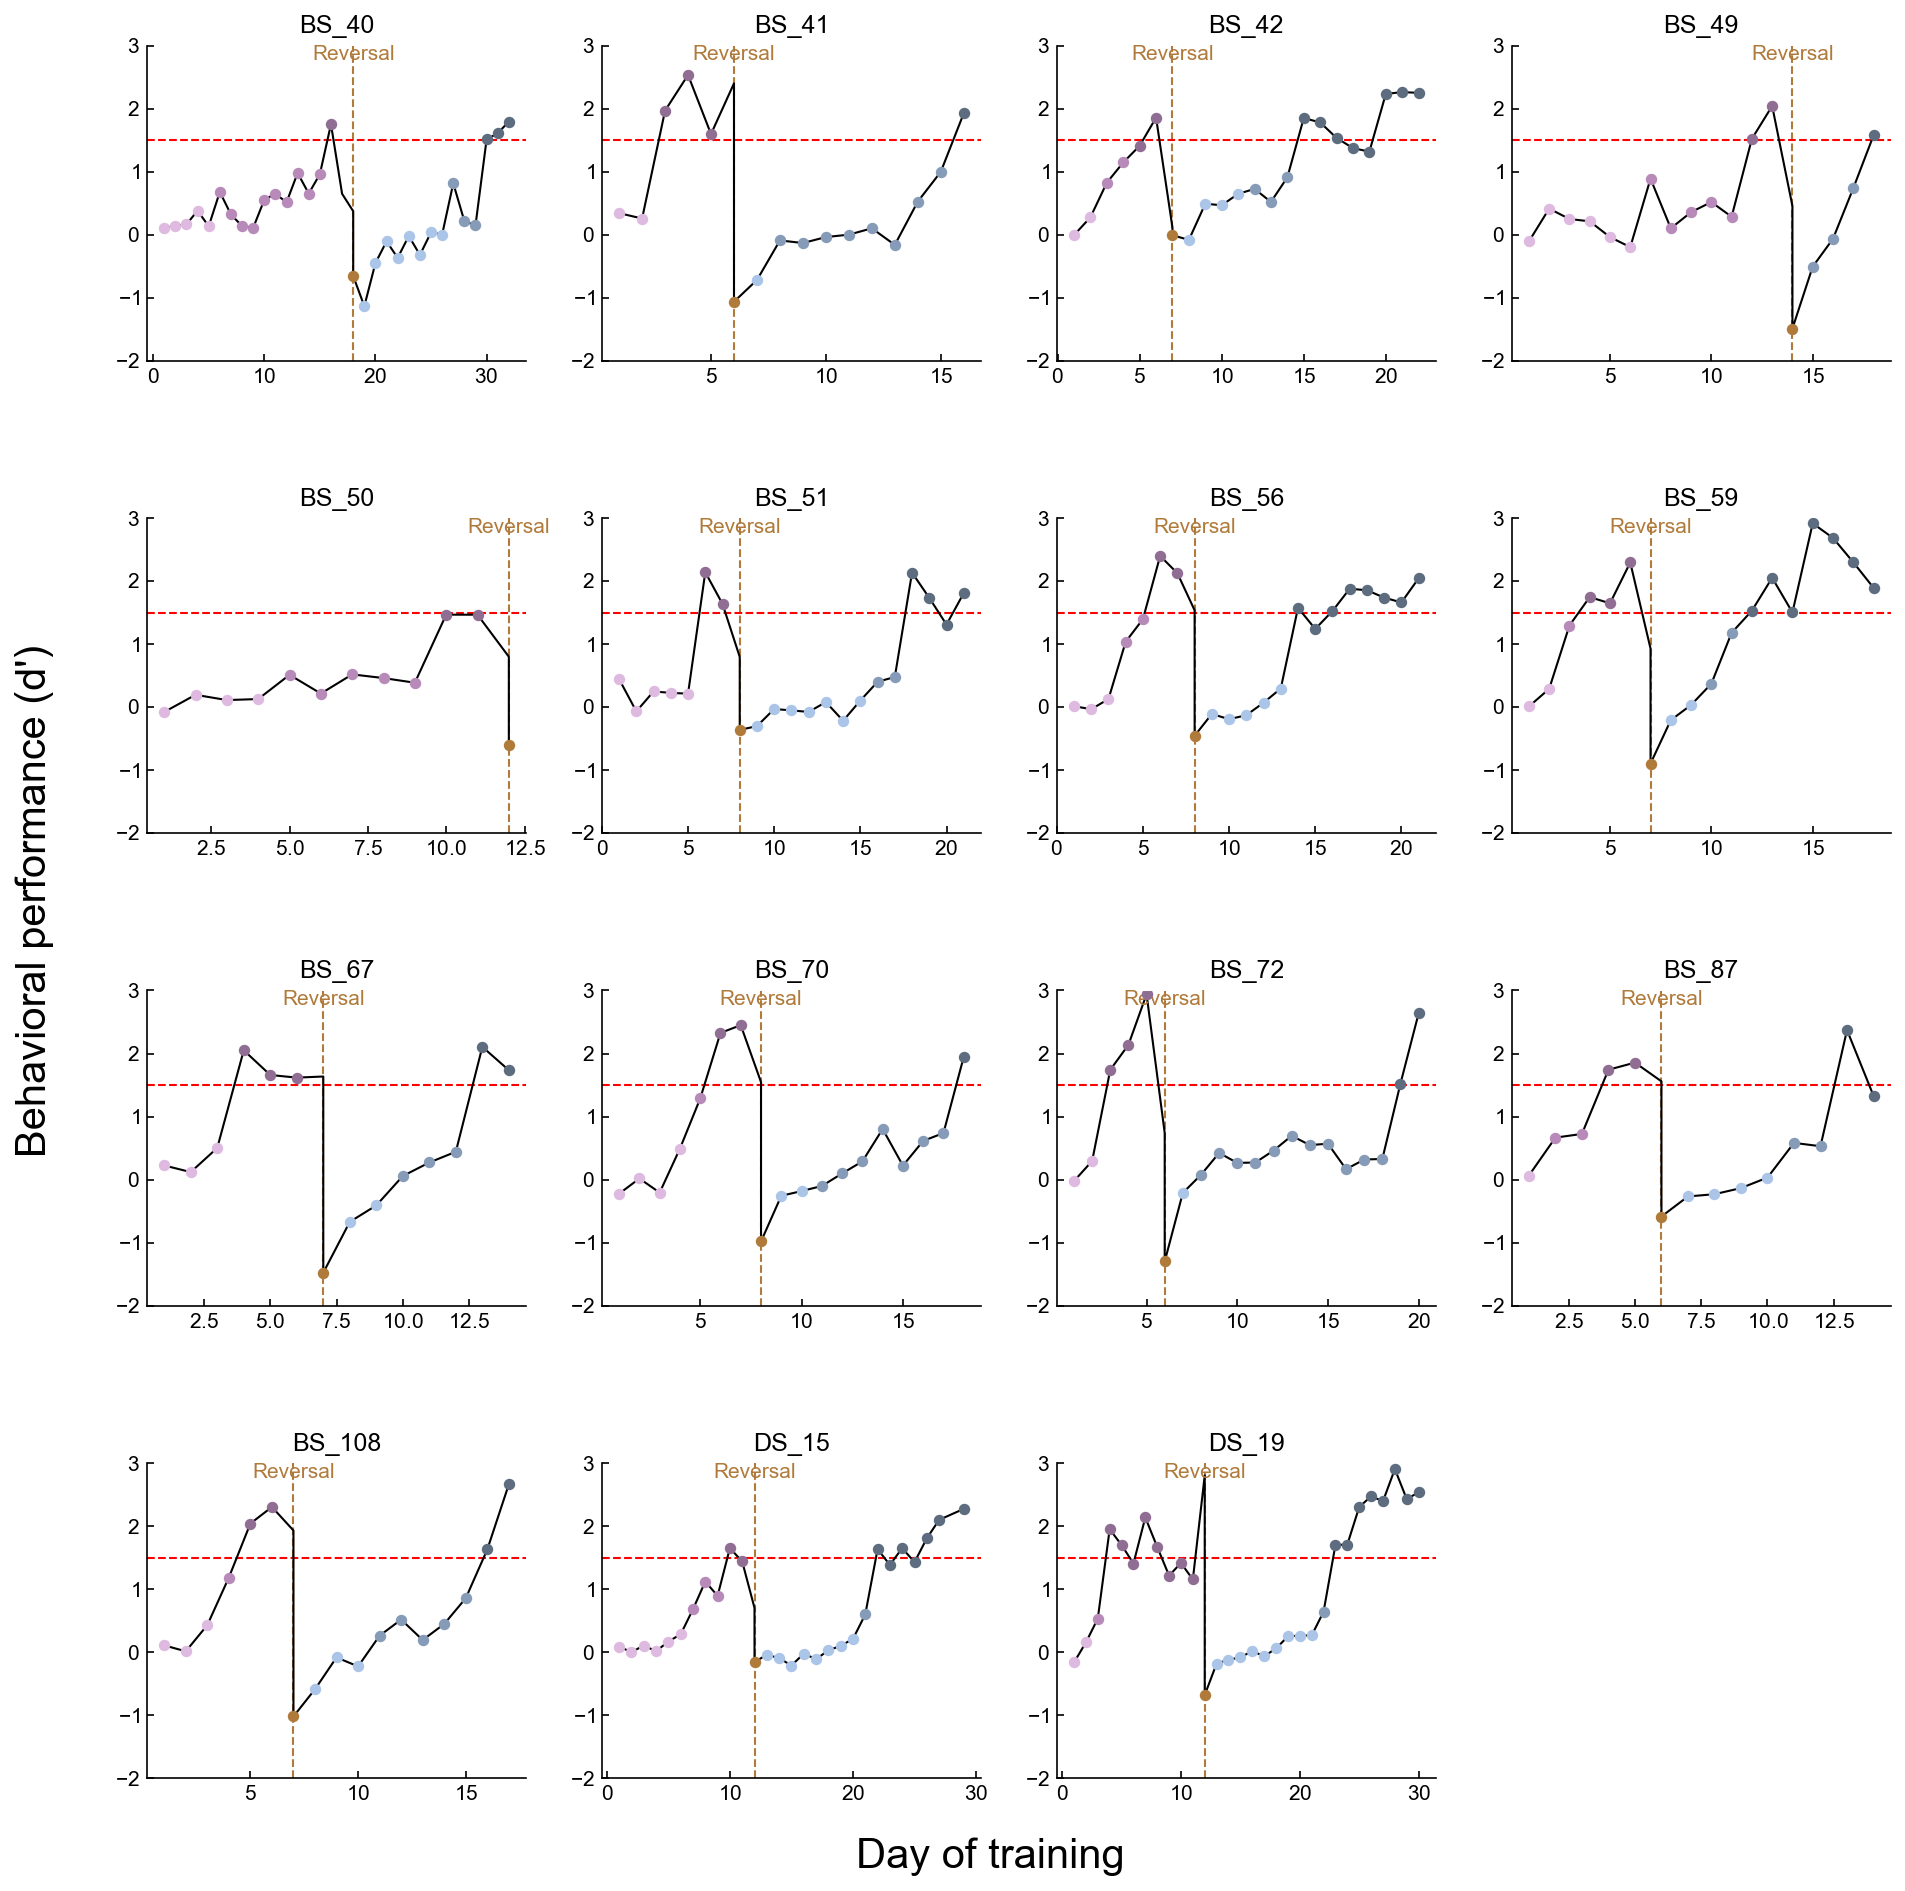

In [6]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(dualanimalnames,animalBehaviors,plot=True)

In [7]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:27<00:00, 27.22it/s]


In [8]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:52<00:00, 34.60it/s] 

errors for: []


# Folder Reset

In [9]:
### Reset raster directory
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin','pngs'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin','pdfs'))
for modcat in ['CR','NCR','Middle']:
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat,'pdfs'))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat,'pngs'))
    for phase in ['pre early','pre late','pre expert','switch','post early','post late','post expert']:
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat,phase))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat,phase,'pdfs'))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',modcat,phase,'pngs'))

# Plotting Code

In [10]:
def visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms=-250,Figure_end_time_ms=1000,xtickstouse=[0,500,1000],xticklabelstouse=None,align_to_choice=False,switch_cond='NA',limitToUse=None,bw_scott_factor=3):
    buffer = 250
    sort_by_response_latency = False # Not implemented
    # bw_scott_factor = 3
    
    if align_to_choice:
        mn = 0.8
        spread = 0.5
    else:
        mn = 3.5
        spread = 2
    
    condition_of_interest = 'ERROR'
    assert (sessionfile.meta.task not in ['switch','opto switch','tuning_switch','second switch']) or (switch_cond != 'NA')
    if align_to_choice:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond+'_go'
        else:
            condition_of_interest = 'go'
    else:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond
        else:
            condition_of_interest = 'all_trials'
    
    response_times = sessionfile.trials.response#get_response_times_with_default(sessionfile)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.tick_params(direction='out')
#     ax1.get_yaxis().set_visible(False)

    if align_to_choice:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation_choice
    else:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation
    if np.isnan(Y):
        color_to_use = 'k'
    else:
        color_to_use = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

    ### Get set of all trials to consider
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions[condition_of_interest].trials
    
    ### Reorder trials
    # Nogo then go
    trials_nogo = allConditions['miss'].trials
    trials_go = allConditions['hit'].trials
    trialsToPlot = np.concatenate((trials_nogo,trials_go))
    len_nogo = len(trials_nogo)
    len_go = len(trials_go)
#     # Just nogo
#     trialsToPlot = allConditions['nogo'].trials
    ### End trial reordering

    ### Extract spike times
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    trialStimTimes = []
    trialChoiceTimes = []
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        if align_to_choice:
            starttime = response_times[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = response_times[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        else:
            starttime = sessionfile.trials.starts[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = sessionfile.trials.starts[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        if align_to_choice:
            this_trial_spikes = this_trial_spikes - response_times[trial]
        else:
            this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
        if align_to_choice:
            trialStimTimes.append(-(response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
            trialChoiceTimes.append(0)
        else:
            trialStimTimes.append(0)
            trialChoiceTimes.append((response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    limit_to_use_nogo = len_nogo#30
    #NOGO
    count = 0
    for idx,trial in enumerate(trials_nogo):
        if count < limit_to_use_nogo:
            X = trialSpikes[idx]
            Y = np.ones_like(trialSpikes[idx])*count
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'purple'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                count += 1
    limit_to_use_nogo = count
    
    ###
    limit_to_use_go = len_go#30
    #GO
    print()
    count = 0
    for idx,trial in enumerate(trials_go):
        if count < limit_to_use_go:
            X = trialSpikes[idx+len_nogo]
            Y = np.ones_like(trialSpikes[idx+len_nogo])*(count+limit_to_use_nogo)
            R = (response_times[trial] - sessionfile.trials.starts[trial]) / 30
            # R = trialChoiceTimes[idx]
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'green'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                print(R)
                ax1.scatter(R,count+limit_to_use_nogo,c='k',s=10)
                count += 1
    limit_to_use_go = count
    
    ### Plot stimulus times
    if align_to_choice:
        X = np.array(trialStimTimes)
        Y = np.array(range(len(trialsToPlot)))
        mask = np.less(Y,30)
        X = X[mask]
        Y = Y[mask]+0.5
        ax1.scatter(X,Y,marker='o',fc='k',ec='k',zorder=1,s=10,lw=2)#,clip_on=False)
    ### Plot response times
    # if align_to_choice:
    #     ax1.scatter(trialChoiceTimes,range(len(trialsToPlot)),marker='o',fc='g',ec='g',zorder=1,s=10,lw=0)

#     if EIL == 'switch':
#        try:
#            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
#            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
#        except:
#            pass
    
    #Legend
#     ax1.scatter([],[],marker='o',fc='k',ec='k',s=15,label='stimulus')
#     ax1.scatter([],[],marker='o',fc='g',ec='g',s=15,label='response')
#     lgd = ax1.legend(frameon=False,loc=(-0.25,1),ncol=2,fontsize=14)
    
    #Set trial limits
    max_trial_value = len(trialsToPlot)
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30])#,40,50,60,80,100,120,140,150,160,180,200])#,220,240,260,280,300,320,340,360,380,400])
    # sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200,220,240,260,280,300,320,340,360,380,400])
    idx_of_okay_limits = np.less_equal(sequence_of_possible_axis_limits,max_trial_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    if not len(valid_limits) > 0:
        return False,[]
    # limit = np.max(valid_limits)
    limit = limit_to_use_nogo+limit_to_use_go
    ax1.set_xlim([starttime,endtime])
    ax1.set_ylim([0,limit])
#     ax1.set_yticks([0,limit/2,limit])
#     ax1.set_ylabel('Trial')
    ax1.set_yticks([])



    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_nogo = trialSpikes[range(len_nogo)]
    numSplits = min(10,len(trialSpikes_nogo))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_nogo)):
        PSTHspikes = np.concatenate(trialSpikes_nogo[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='purple')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='purple',alpha=0.1,zorder=-10,lw=0)


    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_go = trialSpikes[range(len_nogo,len_nogo+len_go)]
    numSplits = min(10,len(trialSpikes_go))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_go)):
        PSTHspikes = np.concatenate(trialSpikes_go[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='green')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='green',alpha=0.1,zorder=-10,lw=0)







    
    #PSTH Limits
    if limitToUse is None:
        max_FR_value = np.max(avg_FR+sem_FR) * 1.1
        sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
        valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
        limit = np.min(valid_limits)
    else:
        limit  = limitToUse
    ###
#     limit = 30
    ###
    ax2.set_ylim([0,limit])
#     ax2.set_yticks([0,limit/2,limit])
#     ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    ylab = ax2.set_ylabel('')#Firing rate\n(spikes/s)')
    
    ### X limits
    ax1.set_xlim([starttime,endtime])
    ax2.set_xlim([starttime,endtime])
    ax1.set_xticks(np.array(xtickstouse))
    if xticklabelstouse is None:
        ax1.set_xticklabels(np.array(xtickstouse))#/1000)
    else:
        ax1.set_xticklabels(xticklabelstouse)#/1000)
    if align_to_choice:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to response (s)')
    else:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to stimulus (s)')
    ax2.set_xticks([])
    
    ### Tone bar
    if not align_to_choice:
        ax2.plot([0,100],[limit]*2,c='k',lw=2,clip_on=False,zorder=10)
        
#     ### Stim bar
#     if not align_to_choice:
#         ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
#         ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
#     else:
#         ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
# #         ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
    
    ################################################################
    
    #font size 15 old style. Font size 35 new style
    
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.75)
        ax2.spines[axis].set_linewidth(1.75)
    ax1.tick_params(width=0)
    ax2.tick_params(width=1.75)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
        ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(35)
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
        ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(35)

    go_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_go]
    nogo_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_nogo]
    pval = ttest_ind(go_spikes,nogo_spikes).pvalue
    if pval <= 0.05:
        ax2.set_title('p = '+str(pval))
    
    artists = [ylab,xlab]
    return True,artists

# Stim Rasters

1it [00:00,  3.96it/s]


99.8
84.53333333333333
115.46666666666667
120.76666666666667
109.23333333333333
109.23333333333333
108.73333333333333
111.1
20.966666666666665
124.03333333333333
93.8
49.4
111.3
116.06666666666666
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
128.23333333333332
97.26666666666667
56.13333333333333
109.7
121.46666666666667
99.66666666666667
112.96666666666667
128.5
106.83333333333333
74.86666666666666
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.93333333333334
123.73333333333333
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
110.16666666666667
131.13333333333333
180.73333333333332
175.76666666666668
Fail


2it [00:00,  3.16it/s]


99.8
84.53333333333333
120.7
115.46666666666667
114.63333333333334
120.76666666666667
109.23333333333333
109.23333333333333
108.73333333333333
111.1
20.966666666666665
124.03333333333333
93.8
111.3
34.333333333333336
116.06666666666666
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
128.23333333333332
97.26666666666667
56.13333333333333
109.7
121.46666666666667
99.66666666666667
128.5
106.83333333333333
74.86666666666666
93.63333333333334
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.3
106.93333333333334
123.73333333333333
115.36666666666666
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
131.13333333333333
180.73333333333332
175.76666666666668
148.13333333333333
Fail


3it [00:00,  3.29it/s]


99.8
84.53333333333333
120.7
115.46666666666667
114.63333333333334
120.76666666666667
109.23333333333333
30.466666666666665
109.23333333333333
108.73333333333333
111.1
20.966666666666665
124.03333333333333
93.8
49.4
111.3
34.333333333333336
116.06666666666666
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
128.23333333333332
97.26666666666667
56.13333333333333
109.7
121.46666666666667
99.66666666666667
112.96666666666667
128.5
78.8
106.83333333333333
74.86666666666666
93.63333333333334
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.3
106.93333333333334
123.73333333333333
115.36666666666666
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
110.16666666666667
131.13333333333333
180.73333333333332
175.76666666666668
148.13333333333333
Fail


4it [00:01,  3.07it/s]


99.8
84.53333333333333
120.7
114.63333333333334
109.23333333333333
108.73333333333333
111.1
124.03333333333333
93.8
111.3
34.333333333333336
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
97.26666666666667
109.7
121.46666666666667
112.96666666666667
128.5
106.83333333333333
93.63333333333334
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.3
106.93333333333334
123.73333333333333
115.36666666666666
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
110.16666666666667
131.13333333333333
180.73333333333332
175.76666666666668
Fail


5it [00:01,  3.24it/s]


99.8
84.53333333333333
120.7
115.46666666666667
114.63333333333334
120.76666666666667
109.23333333333333
30.466666666666665
109.23333333333333
108.73333333333333
111.1
20.966666666666665
124.03333333333333
49.4
111.3
34.333333333333336
116.06666666666666
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
128.23333333333332
97.26666666666667
56.13333333333333
109.7
121.46666666666667
99.66666666666667
112.96666666666667
128.5
78.8
106.83333333333333
74.86666666666666
93.63333333333334
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.3
106.93333333333334
123.73333333333333
115.36666666666666
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
110.16666666666667
131.13333333333333
180.73333333333332
175.76666666666668
148.13333333333333
Fail


6it [00:01,  3.00it/s]


99.8
84.53333333333333
120.7
115.46666666666667
120.76666666666667
109.23333333333333
109.23333333333333
108.73333333333333
111.1
124.03333333333333
93.8
111.3
34.333333333333336
116.06666666666666
115.43333333333334
133.33333333333334
129.1
122.06666666666666
113.2
108.96666666666667
57.46666666666667
76.56666666666666
128.23333333333332
97.26666666666667
109.7
121.46666666666667
99.66666666666667
112.96666666666667
128.5
78.8
106.83333333333333
74.86666666666666
93.63333333333334
68.9
78.4
79.2
99.2
104.76666666666667
98.03333333333333
119.73333333333333
120.43333333333334
106.3
106.93333333333334
123.73333333333333
115.36666666666666
78.03333333333333
120.03333333333333
117.0
144.96666666666667
129.03333333333333
155.16666666666666
116.73333333333333
130.76666666666668
110.16666666666667
131.13333333333333
180.73333333333332
175.76666666666668
Fail


7it [00:02,  3.24it/s]


71.86666666666666
77.6
77.86666666666666
110.46666666666667
86.43333333333334
60.833333333333336
62.63333333333333
87.73333333333333
146.6
4.566666666666666
90.63333333333334
90.2
20.3
76.83333333333333
82.73333333333333
101.23333333333333
91.83333333333333
77.23333333333333
88.83333333333333
59.833333333333336
115.26666666666667
72.56666666666666
57.2
92.7
9.866666666666667
93.56666666666666
94.43333333333334
99.76666666666667
28.1
80.3
76.46666666666667
13.266666666666667
79.43333333333334
72.43333333333334
92.8
50.5
38.96666666666667
81.13333333333334
81.16666666666667
112.26666666666667
79.66666666666667
79.83333333333333
85.46666666666667
17.8
95.06666666666666
75.13333333333334
94.0
89.66666666666667
109.36666666666666
78.23333333333333
99.4
91.73333333333333
118.4
103.0
100.16666666666667
99.76666666666667
92.66666666666667
106.26666666666667
105.63333333333334
124.0
90.33333333333333
Fail


8it [00:02,  3.47it/s]


Fail

71.86666666666666
110.46666666666667
86.43333333333334
60.833333333333336
87.73333333333333
146.6
4.566666666666666
90.63333333333334
20.3
76.83333333333333
82.73333333333333
101.23333333333333
91.83333333333333
77.23333333333333
88.83333333333333
59.833333333333336
72.56666666666666
57.2
92.7
9.866666666666667
93.56666666666666
94.43333333333334
99.76666666666667
28.1
80.3
76.46666666666667
13.266666666666667
79.43333333333334
72.43333333333334
92.8
50.5
38.96666666666667
81.13333333333334
81.16666666666667


9it [00:02,  3.63it/s]

112.26666666666667
79.66666666666667
79.83333333333333
85.46666666666667
17.8
95.06666666666666
75.13333333333334
94.0
89.66666666666667
109.36666666666666
78.23333333333333
99.4
91.73333333333333
118.4
103.0
99.76666666666667
92.66666666666667
106.26666666666667
105.63333333333334
124.0
90.33333333333333
Fail


10it [00:02,  3.73it/s]


71.86666666666666
77.6
110.46666666666667
62.63333333333333
87.73333333333333
146.6
4.566666666666666
90.63333333333334
20.3
76.83333333333333
82.73333333333333
101.23333333333333
91.83333333333333
77.23333333333333
88.83333333333333
59.833333333333336
115.26666666666667
72.56666666666666
93.56666666666666
94.43333333333334
99.76666666666667
80.3
72.43333333333334
92.8
50.5
38.96666666666667
81.13333333333334
81.16666666666667
112.26666666666667
79.66666666666667
79.83333333333333
85.46666666666667
17.8
94.0
78.23333333333333
99.4
91.73333333333333
103.0
90.33333333333333
Fail


14it [00:03,  7.81it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


18it [00:03, 10.64it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


23it [00:03, 12.79it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


27it [00:04, 13.17it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


31it [00:04, 13.26it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


35it [00:04, 12.88it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


40it [00:05, 13.67it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

877.1
336.3333333333333
119.73333333333333
465.03333333333336
76.3
58.63333333333333
645.5333333333333
22.866666666666667
1753.1
1049.5333333333333
2441.1
2328.733333333333
333.23333333333335
314.5
23.866666666666667
2098.9
223.7
560.6666666666666
24.7
1210.1
331.43333333333334
907.1
2388.9
65.66666666666667
33.766666666666666
40.03333333333333
640.1
193.83333333333334
134.86666666666667
69.3
1678.4666666666667
775.2
22.466666666666665
1636.0333333333333
1759.1333333333334
1138.1666666666667
612.8666666666667
1230.0666666666666
31.2
70.83333333333333
119.8


42it [00:07,  2.50it/s]


129.43333333333334
124.86666666666666
823.4
1900.5666666666666
701.7333333333333
119.8
191.76666666666668
316.1
5.966666666666667
996.5333333333333
162.06666666666666
9.266666666666667
287.3333333333333
1131.1
366.2
43.0
110.03333333333333
465.1333333333333
1597.2666666666667
877.1
1341.6333333333334
258.56666666666666
1049.5333333333333
592.3
2098.9
560.6666666666666
29.5
24.7
65.66666666666667
640.1
193.83333333333334
1678.4666666666667
775.2
1759.1333333333334
1138.1666666666667
1230.0666666666666
119.8
fail

42.833333333333336
59.56666666666667
14.233333333333333
121.1
96.3
108.83333333333333
98.53333333333333
73.33333333333333
75.56666666666666
113.06666666666666
67.43333333333334
50.3
10.533333333333333
141.66666666666666
78.93333333333334
48.833333333333336
43.06666666666667
59.666666666666664
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
153.3
115.7
51.833333333333336
51.5
124.7
83.36666666666666
91.93333333

44it [00:08,  2.44it/s]

21.233333333333334
71.93333333333334
81.96666666666667
244.73333333333332
37.6
254.36666666666667
133.5
27.033333333333335
111.33333333333333
78.93333333333334
128.96666666666667
84.3
15.633333333333333
9.866666666666667
14.466666666666667
86.4
7.733333333333333
42.166666666666664
67.26666666666667
108.16666666666667
108.73333333333333
78.2
57.733333333333334
38.56666666666667
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
127.2
149.83333333333334
65.46666666666667
2306.133333333333
1791.8
2007.4
16.833333333333332
fail

14.233333333333333
108.83333333333333
98.53333333333333
73.33333333333333
61.43333333333333
75.56666666666666
48.833333333333336
67.1
94.83333333333333
9.333333333333334
15.933333333333334
97.26666666666667
28.433333333333334
32.6
95.43333333333334
115.7
51.833333333333336
35.53333333333333
124.7
8.7
132.06666666666666
99.03333333333333
113.43333333333334
99.0
15.666666666666666
6.633333333333334
135.93333333333334
24.466666666666665
0.6333333333333

45it [00:09,  2.36it/s]

10.266666666666667
108.16666666666667
57.733333333333334
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
127.2
149.83333333333334
65.46666666666667
fail

55.03333333333333
42.833333333333336
59.56666666666667
72.7
96.3
108.83333333333333
98.53333333333333
73.33333333333333
61.43333333333333
75.56666666666666
67.43333333333334
50.3
117.1
141.66666666666666
43.06666666666667
67.1
94.83333333333333
59.666666666666664
6.566666666666666
27.3
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
32.6
153.3
65.16666666666667
95.43333333333334
115.7
51.833333333333336
35.53333333333333
51.5
124.7
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
113.43333333333334
99.0
6.633333333333334
135.93333333333334
24.466666666666665
0.6333333333333333
51.53333333333333
113.1
116.63333333333334
1936.0
102.63333333333334
117.9
155.2
6.266666666666667
106.53333333333333
111.46666666666667
23.066666666666666
74.9

47it [00:14,  1.02s/it]


33.13333333333333
67.1
6.566666666666666
27.3
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
115.7
35.53333333333333
51.5
124.7
83.36666666666666
132.06666666666666
99.03333333333333
87.7
113.43333333333334
15.666666666666666
24.466666666666665
0.6333333333333333
116.63333333333334
1936.0
102.63333333333334
117.9
155.2
6.266666666666667
106.53333333333333
111.46666666666667
23.066666666666666
102.66666666666667
57.93333333333333
59.5
127.93333333333334
90.26666666666667
98.76666666666667
125.5
63.233333333333334
121.73333333333333
54.93333333333333
39.5
91.03333333333333
116.3
122.13333333333334
40.266666666666666
134.53333333333333
46.5
113.13333333333334
11.866666666666667
117.36666666666666
12.5
87.0
66.33333333333333
82.26666666666667
44.36666666666667
17.066666666666666
31.4
56.333333333333336
67.56666666666666
0.5666666666666667
102.3
16.433333333333334
103.7
Fail

0.6333333333333333
117.9
155.2
106.53333333333333
74.9
102.666666

49it [00:17,  1.20s/it]


10.533333333333333
6.566666666666666
97.26666666666667
117.26666666666667
91.93333333333334
8.7
113.43333333333334
15.666666666666666
135.93333333333334
102.63333333333334
155.2
23.066666666666666
102.66666666666667
59.5
90.26666666666667
98.76666666666667
125.5
63.233333333333334
91.03333333333333
116.3
122.13333333333334
40.266666666666666
134.53333333333333
46.5
113.13333333333334
136.73333333333332
12.5
87.0
140.0
44.36666666666667
17.066666666666666
31.4
0.5666666666666667
102.3
16.433333333333334
103.7
16.133333333333333
185.56666666666666
14.266666666666667
244.73333333333332
254.36666666666667
133.5
99.46666666666667
111.33333333333333
128.96666666666667
9.866666666666667
30.266666666666666
14.466666666666667
86.4
7.733333333333333
36.9
42.166666666666664
10.266666666666667
108.16666666666667
108.73333333333333
78.2
57.733333333333334
38.56666666666667
306.23333333333335
85.13333333333334
106.7
127.2
149.83333333333334
65.46666666666667
2306.133333333333
1791.8
5.3
102.5666666

50it [00:17,  1.00it/s]


94.83333333333333
6.566666666666666
27.3
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
95.43333333333334
35.53333333333333
8.7
132.06666666666666
99.0
15.666666666666666
24.466666666666665
113.1
116.63333333333334
102.63333333333334
117.9
155.2
23.066666666666666
74.9
102.66666666666667
57.93333333333333
59.5
127.93333333333334
90.26666666666667
98.76666666666667
125.5
63.233333333333334
59.833333333333336
92.03333333333333
91.03333333333333
25.3
116.3
122.13333333333334
60.96666666666667
40.266666666666666
134.53333333333333
113.13333333333334
11.866666666666667
136.73333333333332
12.5
82.26666666666667
44.36666666666667
17.066666666666666
56.333333333333336
67.56666666666666
0.5666666666666667
102.3
16.433333333333334
103.7
Fail

102.63333333333334
57.93333333333333
127.93333333333334
90.26666666666667
63.233333333333334
60.96666666666667
134.53333333333333
113.13333333333334
140.0
17.066666666666666
0.5666666666666667
102.3
16.4333

51it [00:20,  1.44s/it]


113.06666666666666
10.533333333333333
141.66666666666666
78.93333333333334
48.833333333333336
33.13333333333333
67.1
94.83333333333333
59.666666666666664
27.3
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
115.7
51.833333333333336
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
113.43333333333334
99.0
15.666666666666666
135.93333333333334
113.1
116.63333333333334
1936.0
102.63333333333334
117.9
106.53333333333333
111.46666666666667
23.066666666666666
74.9
112.6
102.66666666666667
57.93333333333333
59.5
127.93333333333334
90.26666666666667
17.7
125.5
63.233333333333334
59.833333333333336
39.5
92.03333333333333
91.03333333333333
116.3
122.13333333333334
60.96666666666667
74.4
40.266666666666666
134.53333333333333
46.5
113.13333333333334
11.866666666666667
117.36666666666666
136.73333333333332
12.5
87.0
66.33333333333333
82.26666666666667
140.0
44.36666666666667
17.06666666666

52it [00:20,  1.17s/it]

7.733333333333333
36.9
42.166666666666664
108.16666666666667
78.2
57.733333333333334
38.56666666666667
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
65.46666666666667
2306.133333333333
2007.4
102.56666666666666
64.0
2435.633333333333
31.733333333333334
104.03333333333333
116.73333333333333
25.9
155.86666666666667
309.93333333333334
158.06666666666666
fail

73.33333333333333
75.56666666666666
50.3
10.533333333333333
48.833333333333336
33.13333333333333
67.1
6.566666666666666
27.3
9.333333333333334
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
153.3
115.7
51.833333333333336
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
113.43333333333334
99.0
15.666666666666666
135.93333333333334
24.466666666666665
0.6333333333333333
51.53333333333333
113.1
116.63333333333334
1936.0
102.63333333333334
117.9
155.2
6.266666666666667
106.53333333333333
111.46666666666667
23.06

54it [00:25,  1.61s/it]


74.0
15.933333333333334
97.26666666666667
28.433333333333334
32.6
95.43333333333334
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
132.06666666666666
99.03333333333333
135.93333333333334
24.466666666666665
0.6333333333333333
113.1
1936.0
102.63333333333334
155.2
106.53333333333333
23.066666666666666
59.5
127.93333333333334
125.5
59.833333333333336
121.73333333333333
39.5
91.03333333333333
122.13333333333334
40.266666666666666
134.53333333333333
46.5
113.13333333333334
11.866666666666667
117.36666666666666
136.73333333333332
12.5
87.0
66.33333333333333
82.26666666666667
140.0
44.36666666666667
17.066666666666666
31.4
67.56666666666666
0.5666666666666667
102.3
16.433333333333334
103.7
16.133333333333333
2.5
174.4
55.6
196.73333333333332
185.56666666666666
507.4
93.86666666666666
132.3
50.56666666666667
14.266666666666667
21.233333333333334
71.93333333333334
81.96666666666667
244.73333333333332
37.6
254.36666666666667
133.5
99.46666666666667
27.033333333333335
111.33333

55it [00:30,  2.65s/it]


99.0
6.633333333333334
0.6333333333333333
102.63333333333334
117.9
155.2
111.46666666666667
23.066666666666666
74.9
112.6
102.66666666666667
127.93333333333334
90.26666666666667
17.7
63.233333333333334
59.833333333333336
121.73333333333333
54.93333333333333
91.03333333333333
25.3
116.3
122.13333333333334
60.96666666666667
113.13333333333334
11.866666666666667
117.36666666666666
87.0
66.33333333333333
44.36666666666667
17.066666666666666
67.56666666666666
0.5666666666666667
102.3
16.133333333333333
174.4
55.6
185.56666666666666
2431.233333333333
462.5
1460.6333333333334
93.86666666666666
132.3
50.56666666666667
14.266666666666667
21.233333333333334
81.96666666666667
244.73333333333332
37.6
254.36666666666667
133.5
99.46666666666667
78.93333333333334
15.633333333333333
134.9
14.466666666666667
86.4
67.26666666666667
10.266666666666667
108.16666666666667
108.73333333333333
78.2
57.733333333333334
38.56666666666667
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
127.2
1

56it [00:34,  2.85s/it]


42.833333333333336
59.56666666666667
72.7
121.1
96.3
108.83333333333333
98.53333333333333
73.33333333333333
67.1
94.83333333333333
59.666666666666664
6.566666666666666
27.3
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
153.3
65.16666666666667
115.7
51.833333333333336
51.5
124.7
83.36666666666666
132.06666666666666
87.7
99.0
15.666666666666666
24.466666666666665
0.6333333333333333
51.53333333333333
113.1
116.63333333333334
1936.0
117.9
155.2
6.266666666666667
74.9
112.6
102.66666666666667
59.5
127.93333333333334
90.26666666666667
17.7
125.5
63.233333333333334
121.73333333333333
39.5
91.03333333333333
25.3
116.3
122.13333333333334
74.4
117.36666666666666
136.73333333333332
87.0
66.33333333333333
17.066666666666666
31.4
67.56666666666666
0.5666666666666667
102.3
16.433333333333334
103.7
16.133333333333333
129.73333333333332
174.4
55.6
196.73333333333332
185.56666666666666
2431.233333333333
462.5
1460.6333333333334
93.86666666666666
132.

57it [00:38,  3.34s/it]


42.833333333333336
121.1
96.3
108.83333333333333
98.53333333333333
73.33333333333333
61.43333333333333
75.56666666666666
67.43333333333334
10.533333333333333
141.66666666666666
33.13333333333333
59.666666666666664
27.3
9.333333333333334
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
32.6
153.3
65.16666666666667
95.43333333333334
115.7
51.833333333333336
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
15.666666666666666
6.633333333333334
135.93333333333334
24.466666666666665
0.6333333333333333
116.63333333333334
1936.0
102.63333333333334
117.9
6.266666666666667
106.53333333333333
111.46666666666667
23.066666666666666
74.9
112.6
102.66666666666667
57.93333333333333
59.5
90.26666666666667
98.76666666666667
121.73333333333333
54.93333333333333
39.5
92.03333333333333
91.03333333333333
25.3
122.13333333333334
40.266666666666666
46.5
11.866666666666667
117.36666666666666
12.5
66.33333333333333
82.26666

58it [00:39,  2.47s/it]

38.56666666666667
306.23333333333335
65.46666666666667
2306.133333333333
fail


59it [00:39,  1.83s/it]


32.6
35.53333333333333
116.63333333333334
102.63333333333334
74.9
57.93333333333333
98.76666666666667
91.03333333333333
40.266666666666666
46.5
113.13333333333334
11.866666666666667
136.73333333333332
12.5
56.333333333333336
0.5666666666666667
102.3
16.133333333333333
2.5
185.56666666666666
462.5
132.3
50.56666666666667
14.266666666666667
244.73333333333332
37.6
254.36666666666667
78.93333333333334
84.3
15.633333333333333
134.9
30.266666666666666
14.466666666666667
10.266666666666667
108.16666666666667
57.733333333333334
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
127.2
149.83333333333334
65.46666666666667
2306.133333333333
1791.8
5.3
102.56666666666666
1074.9
31.733333333333334
116.73333333333333
131.7
2297.133333333333
fail

59.56666666666667
121.1
96.3
108.83333333333333
97.26666666666667
117.26666666666667
28.433333333333334
153.3
95.43333333333334
6.633333333333334
24.466666666666665
0.6333333333333333
1936.0
155.2
112.6
127.93333333333334
63.23333333333333

60it [00:40,  1.46s/it]

1791.8
2007.4
16.833333333333332
5.3
64.0
150.5
131.7
10.666666666666666
155.86666666666667
309.93333333333334
158.06666666666666
2297.133333333333
fail

72.7
14.233333333333333
121.1
96.3
108.83333333333333
98.53333333333333
61.43333333333333
50.3
59.666666666666664
6.566666666666666
9.333333333333334
74.0
59.06666666666667
97.26666666666667
117.26666666666667
28.433333333333334
32.6
153.3
65.16666666666667
95.43333333333334
83.36666666666666
132.06666666666666
99.03333333333333
87.7
99.0
15.666666666666666
6.633333333333334
24.466666666666665
0.6333333333333333
116.63333333333334
102.63333333333334
6.266666666666667
111.46666666666667
57.93333333333333
121.73333333333333
25.3
116.3
134.53333333333333
113.13333333333334
11.866666666666667
117.36666666666666
136.73333333333332
12.5
87.0
66.33333333333333
44.36666666666667
17.066666666666666
102.3
16.433333333333334
16.133333333333333
129.73333333333332
2.5
174.4
55.6
196.73333333333332
185.56666666666666
2431.233333333333
462.5
1460.63

62it [00:44,  1.58s/it]


59.5
90.26666666666667
17.7
59.833333333333336
91.03333333333333
25.3
116.3
74.4
134.53333333333333
113.13333333333334
11.866666666666667
12.5
87.0
66.33333333333333
140.0
17.066666666666666
31.4
102.3
16.433333333333334
103.7
16.133333333333333
129.73333333333332
174.4
55.6
196.73333333333332
185.56666666666666
2431.233333333333
1460.6333333333334
507.4
50.56666666666667
21.233333333333334
71.93333333333334
244.73333333333332
27.033333333333335
78.93333333333334
128.96666666666667
15.633333333333333
134.9
86.4
7.733333333333333
36.9
67.26666666666667
108.73333333333333
78.2
38.56666666666667
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
149.83333333333334
65.46666666666667
2306.133333333333
16.833333333333332
64.0
131.7
10.666666666666666
158.06666666666666
fail

27.3
9.333333333333334
15.933333333333334
97.26666666666667
117.26666666666667
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
113.433333333

63it [00:44,  1.24s/it]

1074.9
309.1333333333333
104.03333333333333
116.73333333333333
131.7
309.93333333333334
158.06666666666666
2297.133333333333
fail

59.06666666666667
28.433333333333334
153.3
95.43333333333334
99.0
15.666666666666666
135.93333333333334
24.466666666666665
113.1
1936.0
102.63333333333334
6.266666666666667
106.53333333333333
111.46666666666667
23.066666666666666
102.66666666666667
57.93333333333333
59.5
127.93333333333334
17.7
98.76666666666667
125.5
63.233333333333334
59.833333333333336
121.73333333333333
39.5
91.03333333333333
116.3
122.13333333333334
74.4
40.266666666666666
134.53333333333333
46.5
113.13333333333334
11.866666666666667
117.36666666666666
87.0
82.26666666666667
102.3
185.56666666666666
21.233333333333334
71.93333333333334


64it [00:46,  1.61s/it]


42.833333333333336
72.7
121.1
96.3
108.83333333333333
98.53333333333333
73.33333333333333
61.43333333333333
75.56666666666666
113.06666666666666
67.43333333333334
50.3
117.1
10.533333333333333
141.66666666666666
78.93333333333334
48.833333333333336
33.13333333333333
43.06666666666667
67.1
94.83333333333333
59.666666666666664
6.566666666666666
27.3
9.333333333333334
74.0
59.06666666666667
15.933333333333334
97.26666666666667
117.26666666666667
28.433333333333334
32.6
153.3
65.16666666666667
95.43333333333334
115.7
51.833333333333336
35.53333333333333
51.5
124.7
83.36666666666666
91.93333333333334
8.7
132.06666666666666
99.03333333333333
87.7
113.43333333333334
99.0
15.666666666666666
6.633333333333334
135.93333333333334
24.466666666666665
0.6333333333333333
51.53333333333333
113.1
116.63333333333334
1936.0
102.63333333333334
117.9
155.2
6.266666666666667
106.53333333333333
111.46666666666667
23.066666666666666
74.9
112.6
102.66666666666667
57.93333333333333
59.5
127.93333333333334
90.2

65it [00:47,  1.33s/it]

82.26666666666667
140.0
44.36666666666667
17.066666666666666
31.4
56.333333333333336
67.56666666666666
0.5666666666666667
102.3
16.433333333333334
103.7
16.133333333333333
129.73333333333332
2.5
174.4
55.6
196.73333333333332
2431.233333333333
462.5
1460.6333333333334
507.4
93.86666666666666
132.3
50.56666666666667
14.266666666666667
21.233333333333334
71.93333333333334
81.96666666666667
244.73333333333332
37.6
254.36666666666667
133.5
99.46666666666667
27.033333333333335
111.33333333333333
78.93333333333334
128.96666666666667
84.3
15.633333333333333
134.9
9.866666666666667
30.266666666666666
14.466666666666667
86.4
7.733333333333333
36.9
42.166666666666664
67.26666666666667
10.266666666666667
108.16666666666667
108.73333333333333
78.2
57.733333333333334
38.56666666666667
306.23333333333335
85.13333333333334
97.66666666666667
122.9
106.7
127.2
149.83333333333334
65.46666666666667
1074.9
150.5
104.03333333333333
116.73333333333333
10.666666666666666
25.9
158.06666666666666
2297.133333333

66it [00:47,  1.01s/it]


113.93333333333334
342.3
141.5
173.5
239.76666666666668
179.66666666666666
172.73333333333332
107.16666666666667
225.66666666666666
188.03333333333333
248.06666666666666
106.46666666666667
153.0
150.86666666666667
159.2
fail


67it [00:48,  1.13it/s]


200.0
327.4
185.03333333333333
226.5
202.66666666666666
211.43333333333334
220.2
208.46666666666667
194.56666666666666
296.1333333333333
225.3
227.56666666666666
241.66666666666666
203.13333333333333
267.6666666666667
269.9
255.7
286.03333333333336
fail

159.56666666666666
276.26666666666665
106.46666666666667
153.0
161.03333333333333
231.63333333333333
174.7
150.86666666666667
125.76666666666667
208.43333333333334
191.33333333333334
543.5
113.2
160.6
219.06666666666666
317.3333333333333
124.86666666666666
189.3
168.9
121.4
127.9
200.0
170.46666666666667
185.03333333333333
1997.7
218.16666666666666
218.56666666666666
185.03333333333333
226.16666666666666
733.3
202.66666666666666
209.73333333333332
164.53333333333333
379.4
197.5
211.43333333333334
149.13333333333333
220.2
217.66666666666666
208.46666666666667
194.56666666666666
168.13333333333333
225.3
171.83333333333334
227.56666666666666
241.66666666666666
203.13333333333333
210.86666666666667
267.6666666666667
269.9
219.4
178.1
286.

68it [00:51,  1.38s/it]


114.66666666666667
183.1
21.1
131.06666666666666
282.9
212.03333333333333
357.96666666666664
69.7
484.56666666666666
63.86666666666667
54.233333333333334
301.8
49.43333333333333
153.23333333333332
170.5
216.33333333333334
313.6
137.93333333333334
292.56666666666666
274.23333333333335
183.16666666666666
172.7
14.633333333333333
178.33333333333334
252.43333333333334
44.8
24.666666666666668
133.7
412.8333333333333
2202.266666666667
168.63333333333333
156.9
185.16666666666666
277.1
159.16666666666666
329.4
59.733333333333334
1217.4333333333334
214.2
54.266666666666666
11.9
101.1
90.73333333333333
22.933333333333334
466.9
296.96666666666664
69.9
109.26666666666667
173.4
156.83333333333334
159.53333333333333
30.833333333333332
62.43333333333333
153.3
436.43333333333334
145.2
70.86666666666666
136.2
32.03333333333333
74.8
174.4
145.06666666666666
148.43333333333334
38.13333333333333
173.5
217.9
6.133333333333334
104.23333333333333
199.9
69.0
120.86666666666666
203.66666666666666
63.7
194.1
3

69it [00:58,  3.31s/it]


69.7
301.8
49.43333333333333
170.5
292.56666666666666
274.23333333333335
183.16666666666666
172.7
412.8333333333333
2202.266666666667
159.16666666666666
329.4
1217.4333333333334
214.2
101.1
22.933333333333334
466.9
296.96666666666664
173.4
156.83333333333334
30.833333333333332
62.43333333333333
153.3
436.43333333333334
145.2
70.86666666666666
136.2
32.03333333333333
174.4
148.43333333333334
173.5
217.9
104.23333333333333
199.9
69.0
120.86666666666666
203.66666666666666
63.7
194.1
89.53333333333333
231.3
198.33333333333334
58.9
3.2333333333333334
27.6
134.33333333333334
163.33333333333334
132.23333333333332
50.2
139.46666666666667
250.7
119.83333333333333
130.66666666666666
5.933333333333334
122.8
138.33333333333334
362.76666666666665
187.56666666666666
113.93333333333334
342.3
172.0
141.5
173.5
239.76666666666668
179.66666666666666
172.73333333333332
165.66666666666666
150.23333333333332
181.3
107.16666666666667
225.66666666666666
188.03333333333333
256.3666666666667
183.7
296.3666666

70it [01:05,  4.39s/it]


159.53333333333333
30.833333333333332
153.3
145.2
173.5
217.9
6.133333333333334
203.66666666666666
194.1
89.53333333333333
58.9
132.23333333333332
250.7
119.83333333333333
138.33333333333334
342.3
172.0
141.5
173.5
239.76666666666668
172.73333333333332
165.66666666666666
150.23333333333332
181.3
107.16666666666667
225.66666666666666
188.03333333333333
256.3666666666667
183.7
296.3666666666667
196.9
86.9
150.6
248.06666666666666
160.66666666666666
178.23333333333332
60.7
86.5
159.56666666666666
153.4
276.26666666666665
106.46666666666667
153.0
65.6
400.96666666666664
231.63333333333333
244.3
176.5
174.7
150.86666666666667
179.23333333333332
208.43333333333334
149.03333333333333
245.6
129.36666666666667
159.2
165.6
185.1
165.6
178.66666666666666
169.16666666666666
205.1
543.5
423.76666666666665
295.8333333333333
293.26666666666665
157.76666666666668
171.5
166.56666666666666
160.6
98.5
219.06666666666666
236.6
317.3333333333333
124.86666666666666
146.93333333333334
175.4
273.833333333333

72it [01:10,  3.24s/it]


484.56666666666666
63.86666666666667
54.233333333333334
170.5
44.8
1217.4333333333334
101.1
296.96666666666664
109.26666666666667
156.83333333333334
70.86666666666666
203.66666666666666
5.933333333333334
172.0
173.5
239.76666666666668
179.66666666666666
172.73333333333332
181.3
225.66666666666666
188.03333333333333
296.3666666666667
196.9
176.46666666666667
86.9
188.6
178.23333333333332
86.5
174.7
107.4
208.43333333333334
149.03333333333333
130.46666666666667
191.33333333333334
106.13333333333334
245.6
159.2
165.6
185.1
165.6
178.66666666666666
169.16666666666666
113.2
423.76666666666665
293.26666666666665
171.5
117.4
166.56666666666666
205.4
98.5
189.3
146.93333333333334
175.4
327.4
176.6
226.66666666666666
fail

58.833333333333336
114.66666666666667
183.1
40.833333333333336
50.833333333333336
21.1
131.06666666666666
189.43333333333334
282.9
212.03333333333333
156.03333333333333
50.96666666666667
484.56666666666666
63.86666666666667
54.233333333333334
170.5
216.33333333333334
137.933

73it [01:14,  3.46s/it]


131.06666666666666
189.43333333333334
484.56666666666666
301.8
49.43333333333333
170.5
137.93333333333334
274.23333333333335
252.43333333333334
24.666666666666668
277.1
329.4
59.733333333333334
1217.4333333333334
90.73333333333333
22.933333333333334
466.9
109.26666666666667
156.83333333333334
159.53333333333333
30.833333333333332
153.3
436.43333333333334
145.2
70.86666666666666
136.2
32.03333333333333
74.8
174.4
145.06666666666666
148.43333333333334
38.13333333333333
217.9
6.133333333333334
104.23333333333333
199.9
120.86666666666666
203.66666666666666
63.7
194.1
39.266666666666666
231.3
198.33333333333334
58.9
53.13333333333333
3.2333333333333334
27.6
134.33333333333334
163.33333333333334
132.23333333333332
50.2
139.46666666666667
250.7
130.66666666666666
5.933333333333334
122.8
138.33333333333334
362.76666666666665
187.56666666666666
113.93333333333334
342.3
172.0
141.5
165.66666666666666
225.66666666666666
188.03333333333333
256.3666666666667
183.7
296.3666666666667
196.9
176.46666

74it [01:20,  4.18s/it]


58.833333333333336
131.06666666666666
189.43333333333334
156.03333333333333
28.366666666666667
50.96666666666667
357.96666666666664
54.233333333333334
301.8
49.43333333333333
153.23333333333332
170.5
216.33333333333334
313.6
137.93333333333334
292.56666666666666
73.76666666666667
274.23333333333335
183.16666666666666
172.7
14.633333333333333
178.33333333333334
252.43333333333334
44.8
24.666666666666668
133.7
412.8333333333333
2202.266666666667
168.63333333333333
156.9
185.16666666666666
277.1
110.9
159.16666666666666
329.4
59.733333333333334
1217.4333333333334
214.2
54.266666666666666
11.9
101.1
90.73333333333333
466.9
296.96666666666664
69.9
19.266666666666666
109.26666666666667
173.4
156.83333333333334
159.53333333333333
30.833333333333332
62.43333333333333
153.3
436.43333333333334
145.2
70.86666666666666
136.2
32.03333333333333
74.8
174.4
145.06666666666666
148.43333333333334
38.13333333333333
173.5
217.9
6.133333333333334
104.23333333333333
199.9
69.0
120.86666666666666
203.666666

75it [01:21,  3.18s/it]

220.2
217.66666666666666
178.6
168.13333333333333
264.96666666666664
241.66666666666666
227.76666666666668
219.4
255.7
fail

189.43333333333334
28.366666666666667
357.96666666666664
170.5
137.93333333333334
73.76666666666667
274.23333333333335
178.33333333333334
252.43333333333334
44.8
133.7
168.63333333333333
156.9
110.9
159.16666666666666
59.733333333333334
1217.4333333333334
214.2
11.9
101.1
90.73333333333333
109.26666666666667
70.86666666666666
136.2
174.4
145.06666666666666
148.43333333333334
38.13333333333333
173.5
6.133333333333334
104.23333333333333
63.7
194.1
89.53333333333333
198.33333333333334
53.13333333333333
27.6
50.2
122.8
138.33333333333334
113.93333333333334
172.0
107.16666666666667
256.3666666666667
183.7
296.3666666666667
196.9
176.46666666666667
86.9
150.6
145.56666666666666
178.23333333333332
182.86666666666667
60.7
86.5
159.56666666666666
106.46666666666667
153.0
210.36666666666667
65.6
244.3
176.5
174.7
150.86666666666667
179.23333333333332
107.4
149.033333333333

76it [01:24,  3.26s/it]


252.43333333333334
412.8333333333333
2202.266666666667
168.63333333333333
329.4
1217.4333333333334
214.2
101.1
90.73333333333333
466.9
296.96666666666664
109.26666666666667
173.4
156.83333333333334
153.3
436.43333333333334
145.2
136.2
74.8
174.4
145.06666666666666
173.5
217.9
6.133333333333334
104.23333333333333
199.9
203.66666666666666
63.7
194.1
39.266666666666666
231.3
198.33333333333334
3.2333333333333334
163.33333333333334
132.23333333333332
250.7
130.66666666666666
5.933333333333334
122.8
138.33333333333334
362.76666666666665
187.56666666666666
342.3
172.0
141.5
173.5
239.76666666666668
179.66666666666666
172.73333333333332
107.16666666666667
225.66666666666666
188.03333333333333
256.3666666666667
196.9
150.6
248.06666666666666
160.66666666666666
145.56666666666666
178.23333333333332
182.86666666666667
159.56666666666666
153.4
276.26666666666665
106.46666666666667
153.0
183.83333333333334
161.03333333333333
400.96666666666664
231.63333333333333
244.3
176.5
174.7
150.866666666666

78it [01:30,  2.75s/it]


114.66666666666667
50.833333333333336
131.06666666666666
484.56666666666666
170.5
292.56666666666666
14.633333333333333
133.7
168.63333333333333
185.16666666666666
159.16666666666666
1217.4333333333334
54.266666666666666
11.9
436.43333333333334
70.86666666666666
136.2
145.06666666666666
104.23333333333333
69.0
39.266666666666666
53.13333333333333
3.2333333333333334
27.6
134.33333333333334
163.33333333333334
132.23333333333332
50.2
250.7
119.83333333333333
130.66666666666666
175.66666666666666
122.8
362.76666666666665
187.56666666666666
172.0
172.73333333333332
150.23333333333332
188.03333333333333
296.3666666666667
150.6
188.6
248.06666666666666
160.66666666666666
178.23333333333332
182.86666666666667
60.7
86.5
159.56666666666666
276.26666666666665
153.0
183.83333333333334
400.96666666666664
231.63333333333333
244.3
179.23333333333332
125.76666666666667
107.4
208.43333333333334
149.03333333333333
191.33333333333334
165.6
185.1
113.2
423.76666666666665
293.26666666666665
205.4
160.6
98

79it [01:30,  2.04s/it]


292.56666666666666
133.7
412.8333333333333
159.16666666666666
109.26666666666667
436.43333333333334
69.0
203.66666666666666
362.76666666666665
141.5
256.3666666666667
160.66666666666666
145.56666666666666
86.5
161.03333333333333
191.33333333333334
178.66666666666666
543.5
209.26666666666668
117.76666666666667
121.4
127.9
200.0
202.66666666666666
209.73333333333332
149.13333333333333
208.46666666666667
194.56666666666666
227.56666666666666
267.6666666666667
286.03333333333336
fail

183.1
212.03333333333333
357.96666666666664
69.7
63.86666666666667
49.43333333333333
313.6
137.93333333333334
292.56666666666666
274.23333333333335
183.16666666666666
172.7
14.633333333333333
178.33333333333334
252.43333333333334
44.8
24.666666666666668
133.7
412.8333333333333
2202.266666666667
168.63333333333333
277.1
110.9
159.16666666666666
329.4
59.733333333333334
1217.4333333333334
214.2
101.1
22.933333333333334
466.9
296.96666666666664
69.9
173.4
156.83333333333334
30.833333333333332
62.43333333333333


80it [01:37,  3.62s/it]


357.96666666666664
484.56666666666666
63.86666666666667
49.43333333333333
153.23333333333332
216.33333333333334
274.23333333333335
183.16666666666666
14.633333333333333
178.33333333333334
252.43333333333334
24.666666666666668
133.7
412.8333333333333
168.63333333333333
156.9
185.16666666666666
277.1
159.16666666666666
1217.4333333333334
214.2
11.9
22.933333333333334
296.96666666666664
69.9
173.4
156.83333333333334
30.833333333333332
62.43333333333333
153.3
436.43333333333334
145.2
70.86666666666666
136.2
32.03333333333333
74.8
145.06666666666666
148.43333333333334
38.13333333333333
173.5
217.9
6.133333333333334
104.23333333333333
199.9
69.0
120.86666666666666
63.7
39.266666666666666
89.53333333333333
231.3
198.33333333333334
53.13333333333333
3.2333333333333334
27.6
134.33333333333334
163.33333333333334
132.23333333333332
50.2
139.46666666666667
250.7
119.83333333333333
130.66666666666666
175.66666666666666
122.8
138.33333333333334
362.76666666666665
113.93333333333334
342.3
172.0
141.

81it [01:43,  4.36s/it]


203.66666666666666
63.7
194.1
39.266666666666666
89.53333333333333
231.3
198.33333333333334
58.9
27.6
134.33333333333334
163.33333333333334
132.23333333333332
50.2
250.7
119.83333333333333
130.66666666666666
175.66666666666666
5.933333333333334
122.8
138.33333333333334
362.76666666666665
187.56666666666666
113.93333333333334
342.3
172.0
141.5
173.5
239.76666666666668
179.66666666666666
172.73333333333332
165.66666666666666
150.23333333333332
181.3
107.16666666666667
225.66666666666666
188.03333333333333
256.3666666666667
183.7
296.3666666666667
196.9
176.46666666666667
86.9
150.6
188.6
248.06666666666666
160.66666666666666
145.56666666666666
178.23333333333332
182.86666666666667
60.7
86.5
159.56666666666666
153.4
276.26666666666665
106.46666666666667
153.0
210.36666666666667
65.6
183.83333333333334
161.03333333333333
231.63333333333333
244.3
176.5
174.7
150.86666666666667
179.23333333333332
125.76666666666667
107.4
208.43333333333334
149.03333333333333
130.46666666666667
191.333333333

82it [01:49,  4.79s/it]


274.26666666666665
268.1
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
2341.0
194.3
273.6
306.93333333333334
1191.8333333333333
122.16666666666667
244.1
254.9
243.53333333333333


85it [01:51,  1.95s/it]


274.26666666666665
268.1
365.1666666666667
1728.6
171.36666666666667
211.8
194.3
306.93333333333334
1191.8333333333333
fail

171.36666666666667
fail

274.26666666666665
268.1
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
194.3
306.93333333333334
1191.8333333333333
244.1
254.9


87it [01:53,  1.38s/it]


365.1666666666667
1728.6
171.36666666666667
194.3
306.93333333333334
1191.8333333333333
fail

274.26666666666665
268.1
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
273.6
1191.8333333333333


88it [01:53,  1.03s/it]

122.16666666666667
244.1
243.53333333333333
fail

274.26666666666665
268.1
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
2341.0
194.3
273.6
306.93333333333334
1191.8333333333333
122.16666666666667
244.1
254.9
243.53333333333333


89it [01:55,  1.18s/it]


274.26666666666665
268.1
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
2341.0
194.3
273.6
306.93333333333334
1191.8333333333333
122.16666666666667
244.1
254.9
243.53333333333333


90it [01:56,  1.26s/it]


274.26666666666665
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
2341.0
194.3
273.6
306.93333333333334
1191.8333333333333
122.16666666666667
244.1
254.9
243.53333333333333


93it [01:58,  1.26it/s]


274.26666666666665
365.1666666666667
1728.6
154.3
171.36666666666667
211.8
194.3
273.6
1191.8333333333333
254.9
243.53333333333333
fail

Fail


95it [01:59,  2.15it/s]


365.1666666666667
Fail

Fail


97it [01:59,  3.21it/s]


Fail

1728.6
171.36666666666667
211.8
2341.0
194.3
273.6
1191.8333333333333
122.16666666666667
244.1
fail


99it [01:59,  4.05it/s]


365.1666666666667
154.3
171.36666666666667
306.93333333333334
122.16666666666667
fail

Fail

274.26666666666665
268.1
1728.6
154.3
171.36666666666667
211.8
2341.0
194.3
273.6
306.93333333333334
1191.8333333333333
122.16666666666667
244.1


104it [02:02,  3.68it/s]


Fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


110it [02:02,  8.49it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


116it [02:03,  8.73it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


122it [02:03, 13.55it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

42.3
134.33333333333334
63.2
38.63333333333333
1270.7
148.96666666666667
700.4333333333333
582.5
1200.7333333333333
523.4
728.4333333333333
15.666666666666666
80.46666666666667
1119.2333333333333
20.466666666666665
1053.6333333333334
1767.0
85.76666666666667
12.466666666666667
180.26666666666668
107.66666666666667
387.8333333333333
48.833333333333336
2347.8333333333335
2.566666666666667
185.7
1.2666666666666666
202.06666666666666
1769.4
224.8
218.2
150.56666666666666
2039.5666666666666
14.766666666666667
15.9
54.233333333333334
403.96666666666664
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
2271.633333333333
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427

125it [02:07,  2.12it/s]


2.566666666666667
185.7
1.2666666666666666
1769.4
224.8
2039.5666666666666
14.766666666666667
54.233333333333334
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
3.8333333333333335
27.4
369.56666666666666
383.1666666666667
266.93333333333334
329.73333333333335
234.06666666666666
1413.8333333333333
438.3666666666667
2366.0333333333333
352.8666666666667
869.1
0.03333333333333333
882.4666666666667
2030.8333333333333
8.766666666666667
2044.2333333333333
1820.4333333333334
160.3
212.93333333333334
217.26666666666668
318.56666666666666

42.3
134.33333333333334
63.2
38.63333333333333
1270.7
148.96666666666667
700.4333333333333
582.5
1200.7333333333333
523.4
728.4333333333333
15.666666666666666
80.46666666666667
1119.2333333333333
20.466666666666665
1053.6333333333334
1767.0
85.766666

127it [02:14,  1.12s/it]


384.46666666666664
835.4
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427.6333333333333
383.1666666666667
352.7
266.93333333333334
329.73333333333335
179.46666666666667
308.3333333333333
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
354.0
438.3666666666667
262.2
2366.0333333333333
126.26666666666667
352.8666666666667
869.1
0.03333333333333333
269.6333333333333
243.16666666666666
191.43333333333334
215.16666666666666
1535.1
5.2
882.4666666666667
2030.8333333333333
8.766666666666667
2044.2333333333333
1820.4333333333334
366.23333333333335
160.3
212.93333333333334
217.26666666666668
318.56666666666666

134.33333333333334
38.63333333333333
1270.7
700.4333333333333
582.5
1200.7333333333333
523.4
728.4333333333333
15.666666666666666
80.4666666

129it [02:20,  1.67s/it]


835.4
115.36666666666666
1300.2666666666667
917.4
353.03333333333336
1840.9666666666667
285.3333333333333
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
27.4
369.56666666666666
427.6333333333333
383.1666666666667
266.93333333333334
329.73333333333335
308.3333333333333
234.06666666666666
2076.5
438.3666666666667
262.2
2366.0333333333333
126.26666666666667
352.8666666666667
869.1
0.03333333333333333
269.6333333333333
243.16666666666666
191.43333333333334
215.16666666666666
1535.1
5.2
1820.4333333333334
366.23333333333335
212.93333333333334
217.26666666666668
318.56666666666666


130it [02:23,  1.77s/it]


582.5
107.66666666666667
387.8333333333333
48.833333333333336
2.566666666666667
185.7
1.2666666666666666
150.56666666666666
15.9
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
2271.633333333333
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427.6333333333333
383.1666666666667
352.7
266.93333333333334
329.73333333333335
179.46666666666667
308.3333333333333
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
13.566666666666666
354.0
438.3666666666667
262.2
2366.0333333333333
126.26666666666667
352.8666666666667
869.1
0.03333333333333333
269.6333333333333
243.16666666666666
191.43333333333334
215.16666666666666
1535.1
5.2
882.4666666666667
2030.8333333333333
8.766666666666667
2044.2333333333333
1820.4333333333334
366.23333333333335
160.3
212.933

132it [02:26,  1.65s/it]


202.06666666666666
1769.4
224.8
150.56666666666666
2039.5666666666666
482.8
384.46666666666664
917.4
1840.9666666666667
2028.5666666666666
29.1
225.03333333333333
382.8
3.8333333333333335
27.4
369.56666666666666
179.46666666666667
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
354.0
438.3666666666667
262.2
869.1
882.4666666666667
366.23333333333335
160.3
212.93333333333334
217.26666666666668
fail

318.5
29.1
225.03333333333333
382.8
3.8333333333333335
27.4
427.6333333333333
266.93333333333334
179.46666666666667
308.3333333333333
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
13.566666666666666
354.0
438.3666666666667
869.1
269.6333333333333
243.16666666666666
191.43333333333334
215.16666666666666
5.2
882.4666666666667
2044.2333333333333
160.3
212.93333333333334
217.26666666666668


133it [02:28,  1.83s/it]


42.3
134.33333333333334
63.2
38.63333333333333
1270.7
148.96666666666667
700.4333333333333
582.5
1200.7333333333333
523.4
728.4333333333333
15.666666666666666
80.46666666666667
1119.2333333333333
20.466666666666665
1053.6333333333334
1767.0
85.76666666666667
12.466666666666667
180.26666666666668
107.66666666666667
387.8333333333333
48.833333333333336
2347.8333333333335
2.566666666666667
185.7
1.2666666666666666
202.06666666666666
1769.4
224.8
218.2
150.56666666666666
2039.5666666666666
14.766666666666667
15.9
54.233333333333334
403.96666666666664
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
2271.633333333333
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427.6333333333333
383.1666666666667
352.7
266.93333333333334
329.73333333333335
179.46666666666667


134it [02:33,  2.39s/it]


728.4333333333333
15.666666666666666
80.46666666666667
1119.2333333333333
20.466666666666665
1053.6333333333334
1767.0
85.76666666666667
12.466666666666667
180.26666666666668
107.66666666666667
387.8333333333333
48.833333333333336
2347.8333333333335
2.566666666666667
185.7
1.2666666666666666
202.06666666666666
1769.4
224.8
218.2
150.56666666666666
2039.5666666666666
14.766666666666667
15.9
54.233333333333334
403.96666666666664
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
2271.633333333333
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427.6333333333333
383.1666666666667
352.7
266.93333333333334
329.73333333333335
179.46666666666667
308.3333333333333
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
13.566666666666666
354.0
438.36666666666

135it [02:36,  2.66s/it]


42.3
134.33333333333334
63.2
38.63333333333333
1270.7
148.96666666666667
700.4333333333333
582.5
1200.7333333333333
523.4
15.666666666666666
80.46666666666667
1119.2333333333333
1053.6333333333334
180.26666666666668
387.8333333333333
2347.8333333333335
2.566666666666667
1.2666666666666666
202.06666666666666
1769.4
224.8
218.2
150.56666666666666
2039.5666666666666
15.9
54.233333333333334
403.96666666666664
482.8
384.46666666666664
835.4
115.36666666666666
1300.2666666666667
917.4
170.76666666666668
180.76666666666668
2271.633333333333
353.03333333333336
1840.9666666666667
285.3333333333333
2028.5666666666666
1207.8333333333333
212.9
318.5
29.1
225.03333333333333
373.1
1130.1333333333334
105.7
382.8
562.3
3.8333333333333335
27.4
369.56666666666666
427.6333333333333
383.1666666666667
352.7
266.93333333333334
329.73333333333335
179.46666666666667
308.3333333333333
234.06666666666666
2076.5
2327.0333333333333
1413.8333333333333
13.566666666666666
354.0
438.3666666666667
262.2
2366.03333333

136it [02:40,  3.04s/it]


189.53333333333333
12.233333333333333
160.5
45.766666666666666
329.73333333333335
44.766666666666666
209.93333333333334
228.3
96.76666666666667
81.5
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
47.53333333333333
160.26666666666668
66.9
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
2400.266666666667
286.53333333333336
274.3666666666667
135.53333333333333
23.5
270.73333333333335
178.9
360.0
269.3333333333333
202.1
111.53333333333333
1794.2333333333333
665.9333333333333
1480.6666666666667
838.8
180.46666666666667
150.03333333333333
237.83333333333334
774.2333333333333
1180.9333333333334
2168.733333333333


137it [02:42,  2.86s/it]


2163.4333333333334
176.3
1202.2666666666667
32.46666666666667
1555.1
470.03333333333336
244.0
197.16666666666666
240.86666666666667
11.466666666666667
22.833333333333332
2455.6666666666665
554.8
148.93333333333334
71.03333333333333
481.1666666666667
223.06666666666666
802.3333333333334
2355.633333333333
228.46666666666667
329.73333333333335
44.766666666666666
585.9666666666667
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
160.26666666666668
66.9
196.13333333333333
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
1614.7333333333333
2400.266666666667
286.53333333333336
274.3666666666667
135.53333333333333
23.5
270.73333333333335
178.9
360.0
269.3333333333333
202.1
313.96666666666664
111.53333333333333
1794.23333

138it [02:46,  2.93s/it]


2163.4333333333334
311.93333333333334
22.1
176.3
1202.2666666666667
1555.1
187.63333333333333
470.03333333333336
53.86666666666667
37.03333333333333
244.0
6.7
197.16666666666666
173.0
238.43333333333334
225.0
85.8
29.333333333333332
51.6
150.93333333333334
5.7
58.666666666666664
1916.4666666666667
12.766666666666667
19.166666666666668
526.2
240.86666666666667
318.03333333333336
40.8
11.466666666666667
1975.4333333333334
22.833333333333332
341.7
2455.6666666666665
554.8
481.1666666666667
223.06666666666666
59.766666666666666
802.3333333333334
189.53333333333333
266.9
2355.633333333333
470.03333333333336
45.766666666666666
228.46666666666667
329.73333333333335
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
96.76666666666667
234.96666666666667
276.53333333333336
15.3
152.43333333333334
4.633333333333334
622.5333333333333
196.13333333333333
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
521.8333333333334

139it [02:50,  3.29s/it]


311.93333333333334
22.1
176.3
1202.2666666666667
32.46666666666667
470.03333333333336
206.16666666666666
37.03333333333333
240.86666666666667
40.8
1975.4333333333334
2455.6666666666665
554.8
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
1053.5
802.3333333333334
189.53333333333333
266.9
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
179.3
45.766666666666666
228.46666666666667
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
160.26666666666668
66.9
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
521.8333333333334
1614.7333333333333
2400.2666

140it [02:53,  3.36s/it]


318.03333333333336
40.8
11.466666666666667
1975.4333333333334
341.7
2455.6666666666665
554.8
33.766666666666666
148.93333333333334
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
1053.5
802.3333333333334
189.53333333333333
266.9
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
160.5
179.3
45.766666666666666
228.46666666666667
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
160.26666666666668
66.9
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
521.8333333333334
1614.7333333333333
2400.266666666667
286.53333333333336
274.3666666666667
135

141it [02:57,  3.39s/it]


2455.6666666666665
554.8
481.1666666666667
1053.5
802.3333333333334
2355.633333333333
12.233333333333333
327.96666666666664
179.3
45.766666666666666
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
2082.633333333333
1860.7333333333333
10.833333333333334
410.53333333333336
81.5
249.26666666666668
234.96666666666667
3.3
15.3
152.43333333333334
622.5333333333333
47.53333333333333
732.6
384.6
183.1
180.73333333333332
521.8333333333334
1614.7333333333333
2400.266666666667
286.53333333333336
274.3666666666667
135.53333333333333
23.5
178.9
360.0
269.3333333333333
202.1
313.96666666666664
111.53333333333333
1794.2333333333333
665.9333333333333
1480.6666666666667
838.8
180.46666666666667
150.03333333333333
1180.9333333333334
2168.733333333333
977.7333333333333


142it [02:59,  3.13s/it]


240.86666666666667
40.8
11.466666666666667
1975.4333333333334
2455.6666666666665
33.766666666666666
148.93333333333334
1053.5
802.3333333333334
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
179.3
228.46666666666667
329.73333333333335
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
4.633333333333334
622.5333333333333
47.53333333333333
160.26666666666668
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
384.6
925.7
183.1
180.73333333333332
521.8333333333334
2400.266666666667
274.3666666666667
135.53333333333333
23.5
270.73333333333335
178.9
360.0
269.3333333333333
111.53333333333333
665.9333333333333
1480.6666666666667
180.46666666666667
150.03333333333333
237.83333333333334
774.2333333333333
1180.9333333333334
2168.733333333333


143it [03:02,  3.15s/it]


1555.1
470.03333333333336
53.86666666666667
206.16666666666666
37.03333333333333
173.0
619.1666666666666
51.6
125.4
210.73333333333332
58.666666666666664
1.4333333333333333
12.766666666666667
19.166666666666668
526.2
240.86666666666667
318.03333333333336
40.8
11.466666666666667
1975.4333333333334
22.833333333333332
341.7
2455.6666666666665
554.8
33.766666666666666
148.93333333333334
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
1053.5
802.3333333333334
189.53333333333333
266.9
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
160.5
179.3
45.766666666666666
228.46666666666667
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
1

144it [03:06,  3.39s/it]


470.03333333333336
53.86666666666667
206.16666666666666
37.03333333333333
244.0
6.7
197.16666666666666
173.0
238.43333333333334
225.0
85.8
29.333333333333332
619.1666666666666
51.6
150.93333333333334
125.4
210.73333333333332
5.7
58.666666666666664
1916.4666666666667
1.4333333333333333
12.766666666666667
19.166666666666668
526.2
240.86666666666667
318.03333333333336
40.8
11.466666666666667
1975.4333333333334
22.833333333333332
341.7
2455.6666666666665
554.8
33.766666666666666
148.93333333333334
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
1053.5
802.3333333333334
189.53333333333333
266.9
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
160.5
179.3
45.766666666666666
228.46666666666667
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.5333

145it [03:09,  3.23s/it]


244.0
6.7
197.16666666666666
173.0
238.43333333333334
225.0
85.8
29.333333333333332
619.1666666666666
51.6
150.93333333333334
125.4
210.73333333333332
5.7
58.666666666666664
1.4333333333333333
12.766666666666667
19.166666666666668
318.03333333333336
40.8
11.466666666666667
1975.4333333333334
22.833333333333332
341.7
2455.6666666666665
554.8
33.766666666666666
148.93333333333334
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
2355.633333333333
470.03333333333336
45.766666666666666
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
160.26666666666668
66.9
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
925.7
183.1
180.73333333333332
521.8333333333334
1614.7333333333333
2400.266666666667
286.53333333333

146it [03:10,  2.41s/it]

fail

1916.4666666666667
1.4333333333333333
12.766666666666667
19.166666666666668
526.2
240.86666666666667
318.03333333333336
40.8
11.466666666666667
1975.4333333333334
22.833333333333332
341.7
2455.6666666666665
554.8
33.766666666666666
148.93333333333334
102.26666666666667
71.03333333333333
481.1666666666667
223.06666666666666
59.766666666666666
1053.5
802.3333333333334
189.53333333333333
266.9
2355.633333333333
12.233333333333333
327.96666666666664
470.03333333333336
160.5
179.3
45.766666666666666
228.46666666666667
329.73333333333335
44.766666666666666
209.93333333333334
585.9666666666667
228.3
2082.633333333333
1450.5
1860.7333333333333
10.833333333333334
410.53333333333336
96.76666666666667
81.5
249.26666666666668
234.96666666666667
276.53333333333336
3.3
15.3
152.43333333333334
4.633333333333334
184.66666666666666
622.5333333333333
47.53333333333333
160.26666666666668
66.9
196.13333333333333
732.6
295.8333333333333
223.86666666666667
189.26666666666668
234.93333333333334
384.6
9

147it [03:14,  2.92s/it]


74.23333333333333
232.5
152.9
453.1666666666667
838.3333333333334
536.5333333333333
143.1
28.6
214.1
570.8333333333334
131.33333333333334
43.03333333333333
185.36666666666667
209.3
1411.8
221.8
195.76666666666668
385.7
321.6
241.66666666666666
1354.2
243.76666666666668
237.56666666666666
194.56666666666666
216.56666666666666
82.53333333333333
561.8
300.8333333333333
183.2
296.5
333.8666666666667
141.63333333333333
224.53333333333333
171.3
202.63333333333333
223.7
219.0
190.43333333333334
1802.4
218.4
239.73333333333332
247.86666666666667
400.53333333333336
467.6333333333333
1359.9666666666667
419.1333333333333
300.5
183.83333333333334
377.76666666666665
171.43333333333334
172.4
431.9
242.06666666666666
149.93333333333334
507.6333333333333
288.5
243.2
288.43333333333334
172.56666666666666
345.96666666666664
383.3333333333333
255.5
539.6
1823.2333333333333
641.1666666666666
712.7
34.53333333333333
306.3
37.8
443.06666666666666
395.76666666666665
346.9
1098.4333333333334
226.1
642.9
207.

148it [03:18,  3.34s/it]


74.23333333333333
370.3666666666667
232.5
152.9
453.1666666666667
838.3333333333334
536.5333333333333
461.8
143.1
2427.4
187.53333333333333
28.6
1503.7666666666667
30.266666666666666
78.06666666666666
214.1
131.33333333333334
43.03333333333333
85.7
185.36666666666667
209.3
171.8
321.6
243.76666666666668
194.56666666666666
216.56666666666666
561.8
300.8333333333333
296.5
141.63333333333333
224.53333333333333
202.63333333333333
219.0
247.86666666666667
400.53333333333336
1359.9666666666667
300.5
183.83333333333334
377.76666666666665
171.43333333333334
172.4
431.9
242.06666666666666
149.93333333333334
507.6333333333333
288.5
243.2
288.43333333333334
383.3333333333333
255.5
539.6
1823.2333333333333
641.1666666666666
712.7
306.3
37.8
443.06666666666666
1098.4333333333334
226.1
207.13333333333333
329.9
2355.4666666666667
155.93333333333334
212.5
231.2
167.16666666666666
250.26666666666668
2332.8
287.1
109.33333333333333
2326.633333333333
220.13333333333333
219.46666666666667
632.5
478.6
307

149it [03:22,  3.53s/it]


28.6
30.266666666666666
78.06666666666666
214.1
201.33333333333334
185.36666666666667
1236.1333333333334
95.13333333333334
321.6
241.66666666666666
1354.2
237.56666666666666
216.56666666666666
561.8
171.3
223.7
172.43333333333334
212.5
167.16666666666666
2332.8
287.1
109.33333333333333
2326.633333333333
220.13333333333333
219.46666666666667
204.86666666666667
632.5
307.0
144.43333333333334
216.93333333333334
352.26666666666665
342.6666666666667
663.2666666666667
264.5
212.6
1033.6
2007.7
643.1666666666666
384.73333333333335
2101.1
334.43333333333334
421.6
279.8333333333333
338.8666666666667
239.4
311.56666666666666
163.76666666666668
295.2
1645.2
221.8
296.06666666666666


150it [03:25,  3.20s/it]


370.3666666666667
232.5
152.9
453.1666666666667
838.3333333333334
536.5333333333333
461.8
187.53333333333333
28.6
1503.7666666666667
30.266666666666666
78.06666666666666
214.1
370.6333333333333
570.8333333333334
201.33333333333334
131.33333333333334
43.03333333333333
194.6
85.7
185.36666666666667
1236.1333333333334
95.13333333333334
209.3
171.8
176.43333333333334
279.4
1411.8
221.8
65.36666666666666
195.76666666666668
385.7
321.6
241.66666666666666
1354.2
243.76666666666668
237.56666666666666
194.56666666666666
216.56666666666666
82.53333333333333
561.8
300.8333333333333
183.2
296.5
333.8666666666667
141.63333333333333
224.53333333333333
171.3
202.63333333333333
223.7
219.0
190.43333333333334
1802.4
218.4
239.73333333333332
247.86666666666667
400.53333333333336
467.6333333333333
1359.9666666666667
419.1333333333333
300.5
183.83333333333334
377.76666666666665
171.43333333333334
172.4
431.9
242.06666666666666
149.93333333333334
507.6333333333333
288.5
243.2
288.43333333333334
172.566666

151it [03:31,  4.07s/it]


370.3666666666667
453.1666666666667
536.5333333333333
187.53333333333333
28.6
1503.7666666666667
30.266666666666666
78.06666666666666
214.1
370.6333333333333
570.8333333333334
201.33333333333334
131.33333333333334
43.03333333333333
194.6
85.7
185.36666666666667
1236.1333333333334
95.13333333333334
209.3
279.4
243.76666666666668
141.63333333333333
202.63333333333333
223.7
219.0
190.43333333333334
239.73333333333332
247.86666666666667
400.53333333333336
1359.9666666666667
419.1333333333333
431.9
383.3333333333333
539.6
712.7
2355.4666666666667
231.2
2332.8
109.33333333333333
252.0
313.7
1126.8333333333333
191.76666666666668
324.03333333333336
192.83333333333334
211.7
1840.0666666666666
1563.5333333333333
144.43333333333334
216.93333333333334
352.26666666666665
342.6666666666667
663.2666666666667
212.6
2101.1
334.43333333333334
338.8666666666667
311.56666666666666
295.2
1645.2


152it [03:33,  3.66s/it]


370.6333333333333
570.8333333333334
201.33333333333334
131.33333333333334
43.03333333333333
194.6
85.7
185.36666666666667
1236.1333333333334
95.13333333333334
209.3
171.8
176.43333333333334
279.4
1411.8
221.8
195.76666666666668
321.6
241.66666666666666
243.76666666666668
237.56666666666666
216.56666666666666
82.53333333333333
561.8
300.8333333333333
183.2
296.5
333.8666666666667
141.63333333333333
224.53333333333333
171.3
202.63333333333333
223.7
190.43333333333334
239.73333333333332
247.86666666666667
467.6333333333333
1359.9666666666667
419.1333333333333
300.5
377.76666666666665
171.43333333333334
172.4
431.9
149.93333333333334
507.6333333333333
243.2
288.43333333333334
172.56666666666666
383.3333333333333
539.6
1823.2333333333333
641.1666666666666
34.53333333333333
306.3
37.8
443.06666666666666
395.76666666666665
346.9
226.1
642.9
207.13333333333333
2355.4666666666667
155.93333333333334
172.43333333333334
212.5
231.2
172.46666666666667
167.16666666666666
2332.8
287.1
109.3333333333

153it [03:37,  3.77s/it]


2.533333333333333
118.66666666666667
48.233333333333334
115.46666666666667
62.36666666666667
63.6
60.1
128.13333333333333
1801.6666666666667
101.73333333333333
498.2
914.8333333333334
61.1
945.8
440.56666666666666
223.93333333333334
168.7
71.13333333333334
1758.8666666666666
233.06666666666666
69.93333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
181.6
237.0
230.63333333333333
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
549.5333333333333
1792.3666666666666
693.0
658.5666666666667
103.1
267.06666666666666
804.4666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
124.26666666666667
846.5
91.36666666666666
55.63333333333333
175.46666666666667
2384.733333333333
45.06666666666667
768.5333333333333
208.83333333333334
126.7
131.43333333333334
2448.1666666666665
194.9
17.033333333333335
177.73333333333332
360.53333333333336
260.76666666666665
2

154it [03:43,  4.20s/it]


440.56666666666666
223.93333333333334
168.7
32.2
1758.8666666666666
233.06666666666666
69.93333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
1792.3666666666666
693.0
658.5666666666667
103.1
96.53333333333333
267.06666666666666
804.4666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
124.26666666666667
55.63333333333333
2384.733333333333
45.06666666666667
768.5333333333333
208.83333333333334
126.7
131.43333333333334
2448.1666666666665
194.9
17.033333333333335
177.73333333333332
360.53333333333336
221.13333333333333
126.76666666666667
290.26666666666665
249.73333333333332
465.0
231.26666666666668
226.76666666666668
183.0
88.9
1366.0666666666666
208.03333333333333
224.36666666666667
1411.7666666666667
66.66666666666667
30.133333333333333
1902.6333333333334
11.6
112.36666666666666
2153.633333333333
172.666666666666

155it [03:43,  3.09s/it]

123.46666666666667
256.93333333333334
99.2
699.9333333333333
275.3
173.46666666666667
213.43333333333334
705.5
186.2
212.23333333333332
186.66666666666666
173.9
120.9
303.03333333333336
222.66666666666666
167.16666666666666
fail

498.2
914.8333333333334
440.56666666666666
223.93333333333334
168.7
32.2
71.13333333333334
69.93333333333334
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
207.16666666666666
219.8
1972.1666666666667
2095.9333333333334
298.3
549.5333333333333
955.6333333333333
1792.3666666666666
693.0
658.5666666666667
103.1
267.06666666666666
234.6
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
846.5
175.46666666666667
768.5333333333333
2448.1666666666665
194.9
17.033333333333335
360.53333333333336
1308.8333333333333
1225.2333333333333
126.76666666666667
290.26666666666665
249.73333333333332
465.0
231.26666666666668
226.76666666666668
208.03333333333333
1411.7666666666667
30.133333333333333
1902.6333333333334
1

157it [03:48,  2.47s/it]


145.06666666666666
914.8333333333334
440.56666666666666
955.6333333333333
1792.3666666666666
693.0
658.5666666666667
96.53333333333333
234.6
17.033333333333335
177.73333333333332
11.6
112.36666666666666
2153.633333333333
172.66666666666666
1347.8666666666666
2379.7
435.1333333333333
212.53333333333333
130.26666666666668
22.166666666666668
1743.1
1227.9
13.633333333333333
269.5
261.5
613.4333333333333
207.1
313.6666666666667
604.4333333333333
193.43333333333334
108.53333333333333
449.1666666666667
222.36666666666667
735.5333333333333
190.66666666666666
315.3333333333333
1716.3333333333333
446.8333333333333
2083.9666666666667
246.26666666666668
496.5
731.4
509.26666666666665
308.53333333333336
767.1333333333333
256.93333333333334
99.2
201.13333333333333
275.3
705.5
404.46666666666664
212.23333333333332
186.66666666666666
173.9
324.73333333333335
120.9
303.03333333333336
222.66666666666666
167.16666666666666
fail

2.533333333333333
145.06666666666666
118.66666666666667
48.233333333333334

158it [03:53,  3.22s/it]


2.533333333333333
48.233333333333334
115.46666666666667
62.36666666666667
60.1
1801.6666666666667
498.2
914.8333333333334
61.1
945.8
440.56666666666666
223.93333333333334
168.7
32.2
71.13333333333334
233.06666666666666
69.93333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
181.6
237.0
230.63333333333333
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
955.6333333333333
1792.3666666666666
658.5666666666667
103.1
267.06666666666666
804.4666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
124.26666666666667
846.5
91.36666666666666
55.63333333333333
175.46666666666667
2384.733333333333
45.06666666666667
768.5333333333333
208.83333333333334
126.7
131.43333333333334
2448.1666666666665
194.9
17.033333333333335
177.73333333333332
360.53333333333336
260.76666666666665
221.13333333333333
1308.8333333333333
1225.2333333333333
126.76666666666667
290.266

159it [03:57,  3.65s/it]


118.66666666666667
115.46666666666667
62.36666666666667
63.6
60.1
128.13333333333333
1801.6666666666667
101.73333333333333
498.2
61.1
945.8
223.93333333333334
168.7
32.2
71.13333333333334
233.06666666666666
69.93333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
181.6
237.0
230.63333333333333
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
2095.9333333333334
298.3
549.5333333333333
955.6333333333333
1792.3666666666666
658.5666666666667
103.1
267.06666666666666
804.4666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
124.26666666666667
846.5
91.36666666666666
55.63333333333333
175.46666666666667
2384.733333333333
768.5333333333333
208.83333333333334
126.7
2448.1666666666665
194.9
17.033333333333335
177.73333333333332
360.53333333333336
260.76666666666665
1308.8333333333333
126.76666666666667
290.26666666666665
249.73333333333332
465.0
231.26666666666668
88.9
224.366

161it [04:02,  2.90s/it]


2083.9666666666667
496.5
84.36666666666666
308.53333333333336
123.46666666666667
99.2
201.13333333333333
699.9333333333333
213.43333333333334
192.93333333333334
186.66666666666666
120.9
167.16666666666666
fail

194.9
17.033333333333335
360.53333333333336
1308.8333333333333
126.76666666666667
231.26666666666668
183.0
88.9
2153.633333333333
2379.7
212.53333333333333
130.26666666666668
22.166666666666668
613.4333333333333
207.1
2395.633333333333
313.6666666666667
315.3333333333333
2083.9666666666667
958.2
308.53333333333336
256.93333333333334
99.2
201.13333333333333
275.3
213.43333333333334
404.46666666666664
1791.1


163it [04:04,  1.86s/it]


2.533333333333333
118.66666666666667
62.36666666666667
60.1
498.2
914.8333333333334
440.56666666666666
223.93333333333334
168.7
32.2
71.13333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
230.63333333333333
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
955.6333333333333
693.0
658.5666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
846.5
175.46666666666667
45.06666666666667
768.5333333333333
194.9
17.033333333333335
221.13333333333333
1308.8333333333333
1225.2333333333333
290.26666666666665
231.26666666666668
226.76666666666668
88.9
1366.0666666666666
224.36666666666667
1411.7666666666667
66.66666666666667
30.133333333333333
11.6
112.36666666666666
fail

2.533333333333333
145.06666666666666
48.233333333333334
115.46666666666667
63.6
60.1
1801.6666666666667
101.73333333333333
914.8333333333334
61.1
945.8
440.56666666666666
223.93333333333334
168.7
71.1333333

164it [04:09,  2.86s/it]


2.533333333333333
145.06666666666666
118.66666666666667
914.8333333333334
61.1
945.8
440.56666666666666
164.1
27.5
230.63333333333333
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
2095.9333333333334
298.3
549.5333333333333
785.0666666666667
160.03333333333333
2460.233333333333
1326.2666666666667
124.26666666666667
846.5
91.36666666666666
175.46666666666667
45.06666666666667
768.5333333333333
126.7
131.43333333333334
17.033333333333335
260.76666666666665
231.26666666666668
2153.633333333333
232.63333333333333
212.53333333333333
1743.1
269.5
604.4333333333333
315.3333333333333
1716.3333333333333
446.8333333333333
40.06666666666667
731.4
201.13333333333333
699.9333333333333
275.3
173.46666666666667
242.86666666666667
1791.1


165it [04:12,  2.72s/it]


2.533333333333333
145.06666666666666
118.66666666666667
48.233333333333334
115.46666666666667
62.36666666666667
63.6
60.1
128.13333333333333
1801.6666666666667
101.73333333333333
498.2
914.8333333333334
61.1
945.8
440.56666666666666
223.93333333333334
168.7
32.2
71.13333333333334
1758.8666666666666
233.06666666666666
69.93333333333334
251.8
135.73333333333332
498.8666666666667
164.1
117.33333333333333
27.5
181.6
237.0
230.63333333333333
207.16666666666666
2445.266666666667
219.8
1972.1666666666667
15.766666666666667
2095.9333333333334
298.3
549.5333333333333
955.6333333333333
1792.3666666666666
693.0
658.5666666666667
103.1
96.53333333333333
267.06666666666666
804.4666666666667
234.6
753.5333333333333
785.0666666666667
19.566666666666666
160.03333333333333
2460.233333333333
1326.2666666666667
124.26666666666667
846.5
91.36666666666666
55.63333333333333
175.46666666666667
2384.733333333333
45.06666666666667
768.5333333333333
208.83333333333334
126.7
131.43333333333334
2448.166666666666

168it [04:18,  1.90s/it]


105.13333333333334
184.0
150.93333333333334
326.73333333333335
439.1333333333333
358.9
fail

Fail


170it [04:18,  1.00s/it]


Fail

Fail


172it [04:19,  1.74it/s]


192.43333333333334
105.13333333333334
227.3
327.3
150.93333333333334
326.73333333333335
439.1333333333333
223.93333333333334
244.86666666666667
300.5
362.76666666666665
358.9
fail

192.43333333333334
105.13333333333334
442.03333333333336
fail


174it [04:19,  2.72it/s]


442.03333333333336
fail

192.43333333333334
327.3
150.93333333333334
326.73333333333335
439.1333333333333
300.5
fail

192.43333333333334
105.13333333333334
227.3
442.03333333333336
1241.2
172.33333333333334
184.0
327.3
150.93333333333334
326.73333333333335
439.1333333333333
223.93333333333334
244.86666666666667
300.5
362.76666666666665
358.9


176it [04:21,  1.83it/s]


192.43333333333334
227.3
fail

192.43333333333334
105.13333333333334
227.3


179it [04:22,  2.35it/s]


192.43333333333334
105.13333333333334
227.3
1241.2
327.3
150.93333333333334
223.93333333333334
fail

Fail


180it [04:22,  2.82it/s]


10.433333333333334
184.23333333333332
283.43333333333334
273.26666666666665
109.0
237.06666666666666
261.8666666666667
33.36666666666667
264.6
184.06666666666666
271.96666666666664
259.1666666666667
316.5
270.7
71.7
254.16666666666666
225.4
73.1
303.8666666666667
324.3
266.8333333333333
260.1
Fail

391.23333333333335
320.2
10.433333333333334
184.23333333333332
283.43333333333334
321.96666666666664
299.5
264.96666666666664


181it [04:23,  2.84it/s]

273.26666666666665
279.3
109.0
267.1
295.2
276.1333333333333
237.06666666666666
276.5
355.3333333333333
306.5
264.06666666666666
302.53333333333336
322.3666666666667
261.8666666666667
33.36666666666667
264.6
184.06666666666666
263.8333333333333
303.3
285.4
260.7
271.96666666666664
251.4
290.8666666666667
259.1666666666667
316.5
301.3666666666667
270.7
282.0
299.03333333333336
268.96666666666664
316.6333333333333
302.53333333333336
304.73333333333335
263.1333333333333
278.4
258.5
301.53333333333336
335.2
290.6333333333333
230.1
252.7
71.7
242.46666666666667
273.7
311.8
254.16666666666666
225.4
264.1333333333333
73.1
425.46666666666664
263.93333333333334
303.8666666666667
324.3
338.6333333333333
264.5
384.26666666666665
311.1666666666667
260.9
266.8333333333333
298.93333333333334
245.5
299.23333333333335
266.96666666666664
262.76666666666665
262.2
235.93333333333334
275.0
255.86666666666667
269.93333333333334
274.93333333333334
171.63333333333333
394.03333333333336
260.1
Fail


182it [04:24,  1.72it/s]


391.23333333333335
320.2
10.433333333333334
184.23333333333332
283.43333333333334
321.96666666666664
299.5
264.96666666666664
273.26666666666665
279.3
109.0
267.1
295.2
276.1333333333333
237.06666666666666
276.5
355.3333333333333
306.5
264.06666666666666
302.53333333333336
322.3666666666667
261.8666666666667
33.36666666666667
264.6
184.06666666666666
263.8333333333333
303.3
285.4
271.96666666666664
251.4
266.8
290.8666666666667
259.1666666666667
316.5
301.3666666666667
270.7
282.0
299.03333333333336
268.96666666666664
316.6333333333333
302.53333333333336
304.73333333333335
263.1333333333333
278.4
258.5
301.53333333333336
290.6333333333333
230.1
252.7
71.7
242.46666666666667
273.7
311.8
254.16666666666666
225.4
264.1333333333333
73.1
425.46666666666664
263.93333333333334
303.8666666666667
324.3
338.6333333333333
264.5
384.26666666666665
311.1666666666667
260.9
266.8333333333333
298.93333333333334
245.5
299.23333333333335
Fail


183it [04:24,  2.06it/s]


391.23333333333335
320.2
10.433333333333334
184.23333333333332
283.43333333333334
321.96666666666664
299.5
264.96666666666664
273.26666666666665
279.3
109.0
267.1
295.2
276.1333333333333
306.5
264.06666666666666
322.3666666666667
184.06666666666666
303.3
271.96666666666664
259.1666666666667
316.5
282.0
268.96666666666664
302.53333333333336
263.1333333333333
258.5
301.53333333333336
335.2
230.1
252.7
71.7
242.46666666666667
273.7
225.4
303.8666666666667
324.3
266.8333333333333
266.96666666666664
262.76666666666665
255.86666666666667
269.93333333333334
274.93333333333334
394.03333333333336
260.1
Fail


184it [04:24,  2.37it/s]


177.36666666666667
158.6
207.9
1277.4333333333334
235.73333333333332
245.13333333333333
167.3
200.7
209.06666666666666
52.666666666666664
285.53333333333336
238.23333333333332
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
167.6
267.8333333333333
183.13333333333333
242.6
198.9
219.66666666666666
253.23333333333332
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
154.43333333333334
261.8
183.43333333333334
225.36666666666667
2444.5666666666666
203.33333333333334
240.53333333333333
218.4
192.56666666666666
210.8
fail

193.1
271.23333333333335
207.1
168.4
192.2
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
172.03333333333333
169.96666666666667
67.8
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
28

185it [04:28,  1.42s/it]


271.23333333333335
207.1
220.0
239.83333333333334
192.2
218.93333333333334
209.56666666666666
181.23333333333332
158.7
172.03333333333333
162.76666666666668
169.96666666666667
263.1
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
1745.7
188.

187it [04:32,  1.64s/it]


218.93333333333334
246.8
158.7
223.4
172.03333333333333
67.8
62.666666666666664
198.86666666666667
200.7
245.06666666666666
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
222.23333333333332
61.36666666666667
186.93333333333334
205.2
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
181.33333333333334
1745.7
191.73333333333332
208.96666666666667
181.23333333333332
364.6333333333333
154.43333333333334
183.43333333333334
225.36666666666667
203.33333333333334
179.33333333333334
321.3
220.23333333333332
173.23333333333332
200.13333333333333
220.0
188.56666666666666
fail

61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.533

188it [04:35,  2.02s/it]


238.23333333333332
299.1
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
251.23333333333332
183.13333333333333
205.2
15.8
689.0666666666667
242.6
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
478.93333333333334
154.43333333333334
261.8
222.13333333333333
183.43333333333334
225.36666666666667
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
179.33333333333334
186.36666666666667
321.3
408.0
224.96666666666667
308.6333333333333
220.23333333333332
235.3
173.23333333333332
200.13333333333333
312.3333333333333
220.0
386.8666666666667
188.8
188.56666666666666
258.5
202.33333333333334
199.66666666666666
1773.2
2452.766666666667


189it [04:39,  2.50s/it]


158.6
207.9
235.73333333333332
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
251.16666666666666
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
364.6333333333333
154.43333333333334
222.13333333333333
183.43333333333334
203.33333333333334
190.83333333333334
179.33333333333334
186.36666666666667
58.9
408.0
224.96666666666667
235.3
173.23333333333332
200.13333333333333
312.3333333333333
386.8666666666667
188.8
188.56666666666666
199.66666666

190it [04:42,  2.61s/it]


193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.6666

191it [04:46,  3.11s/it]


271.23333333333335
207.1
1824.6333333333334
145.2
325.8
192.2
418.8
209.56666666666666
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
209.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
228.9
61.36666666666667
167.6
267.8333333333333
205.2
15.8
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
167.53333333333333
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
478.93333333333334
154.43333333333334
261.8
2444.5666666666666
203.33333333333334
190.8

192it [04:50,  3.27s/it]


193.1
495.1666666666667
271.23333333333335
207.1
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1

193it [04:53,  3.34s/it]


193.1
1824.6333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
280.23333333333335
245.13333333333333
167.3
245.06666666666666
52.666666666666664
138.96666666666667
61.36666666666667
143.76666666666668
183.13333333333333
186.93333333333334
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
99.73333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
364.6333333333333
478.93333333333334
154.43333333333334
261.8
222.13333333333333
183.43333333333334
225.36666666666667
2444.5666666666666
203.33333333333334
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
186.36666666666667
321.3
58.9
308.6333333333333
235.3
173.23333333333332
200.13333333333333
312.3333333333333
220.0
386.8666666666667
710.3333333333334
188.8
258.5
202.33333333333334
199.66666666666

194it [04:57,  3.49s/it]


220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667


195it [05:01,  3.69s/it]


193.1
220.0
168.4
145.2
192.2
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
158.6
207.9
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
2405.8333333333335
209.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
228.9
222.23333333333332
61.36666666666667
143.76666666666668
251.23333333333332
183.13333333333333
186.93333333333334
15.8
242.6
127.23333333333333
219.66666666666666
253.23333333333332
193.63333333333333
181.8
218.5
219.13333333333333
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
364.6333333333333
154.43333333333334
203.33333333333334
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
179

196it [05:05,  3.63s/it]


193.1
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
245.06666666666666
52.666666666666664
285.53333333333336
224.0
238.23333333333332
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7


197it [05:08,  3.70s/it]


1537.9666666666667
99.73333333333333
181.8
176.26666666666668
218.5
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
111.16666666666667
364.6333333333333
478.93333333333334
154.43333333333334
261.8
183.43333333333334
2444.5666666666666
203.33333333333334
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
179.33333333333334
186.36666666666667
321.3
224.96666666666667
308.6333333333333
235.3
200.13333333333333
220.0
386.8666666666667
710.3333333333334
188.8
188.56666666666666
258.5
202.33333333333334
199.66666666666666
1773.2
912.1
2452.766666666667


198it [05:11,  3.25s/it]


325.8
192.2
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
263.1
200.2
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
209.06666666666666
245.06666666666666
52.666666666666664
224.0
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
127.23333333333333
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
181.33333333333334
1745.7
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
478.93333333333334
154.43333333333334
261.8
222.13333333333333
225.36666666666667
203.33333333333334
190.83333333333334
240.

199it [05:15,  3.59s/it]


220.0
192.2
418.8
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
198.86666666666667
167.3
209.06666666666666
222.23333333333332
167.6
186.93333333333334
205.2
242.6
219.66666666666666
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
154.43333333333334
261.8
222.13333333333333
183.43333333333334
225.36666666666667
2444.5666666666666
203.33333333333334
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
179.33333333333334
186.36666666666667
224.96666666666667
235.3
200.13333333333333
312.3333333333333
710.3333333333334
188.8
1773.2
912.1
2452.766666666667


200it [05:18,  3.33s/it]


418.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
158.6
207.9
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
478.93333333333334

201it [05:18,  2.47s/it]

fail

271.23333333333335
207.1
220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.5333

202it [05:23,  3.08s/it]


193.1
189.83333333333334
181.23333333333332
162.76666666666668
149.8
177.36666666666667
299.5
158.6
207.9
198.86666666666667
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
181.33333333333334
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
478.93333333333334
261.8
222.13333333333333
183.43333333333334
225.36666666666667
203.33333333333334
240.53333333333333
210.8
186.36666666666667
58.9
408.0
224.96666666666667
308.6333333333333
173.23333333333332
220.0
386.8666666666667
188.8


203it [05:26,  3.04s/it]


193.1
207.1
168.4
239.83333333333334
145.2
192.2
418.8
246.8
189.83333333333334
181.23333333333332
158.7
223.4
162.76666666666668
169.96666666666667
263.1
67.8
163.93333333333334
171.1
149.8
62.666666666666664
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73

204it [05:31,  3.66s/it]


271.23333333333335
207.1
418.8
209.56666666666666
162.76666666666668
263.1
205.86666666666667
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
177.36666666666667
158.6
207.9
1277.4333333333334
235.73333333333332
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
364.6333333333333
478.

205it [05:35,  3.74s/it]


172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
235.73333333333332
280.23333333333335
245.13333333333333
167.3
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.1666666666666

206it [05:39,  3.78s/it]


111.16666666666667
478.93333333333334
154.43333333333334
222.13333333333333
183.43333333333334
225.36666666666667
203.33333333333334
190.83333333333334
240.53333333333333
218.4
210.8
179.33333333333334
186.36666666666667
58.9
408.0
308.6333333333333
220.23333333333332
235.3
173.23333333333332
200.13333333333333
312.3333333333333
220.0
386.8666666666667
710.3333333333334
188.8
188.56666666666666
258.5
202.33333333333334
199.66666666666666
912.1
2452.766666666667


208it [05:41,  2.33s/it]


162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
200.7
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
251.16666666666666
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
183.13333333333333
186.93333333333334
205.2
2475.0333333333333
242.6
198.9
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
fail


209it [05:41,  1.77s/it]


193.1
23.133333333333333
168.4
239.83333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
99.73333333333333
1

211it [05:46,  2.06s/it]


495.1666666666667
271.23333333333335
23.133333333333333
220.0
168.4
209.56666666666666
246.8
189.83333333333334
149.8
62.666666666666664
177.33333333333334
177.36666666666667
2405.8333333333335
245.06666666666666
285.53333333333336
299.1
251.23333333333332
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
127.23333333333333
219.66666666666666
253.23333333333332
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
181.33333333333334
188.46666666666667
181.23333333333332
111.16666666666667
fail


212it [05:47,  1.53s/it]


2048.6666666666665
222.23333333333332
167.6
2475.0333333333333
219.66666666666666
253.23333333333332
99.73333333333333
193.63333333333333
176.26666666666668
218.5
1745.7
188.46666666666667
191.73333333333332
111.16666666666667
154.43333333333334
261.8
225.36666666666667
190.83333333333334
240.53333333333333
218.4
192.56666666666666
224.96666666666667
173.23333333333332
312.3333333333333
220.0
188.56666666666666
1773.2
2452.766666666667
fail


213it [05:47,  1.16s/it]


127.23333333333333
219.66666666666666
167.53333333333333
99.73333333333333
218.5
219.13333333333333
1745.7
191.73333333333332
181.23333333333332
111.16666666666667
154.43333333333334
261.8
222.13333333333333
2444.5666666666666
203.33333333333334
190.83333333333334
240.53333333333333
218.4
192.56666666666666
210.8
179.33333333333334
321.3
58.9
408.0
224.96666666666667
308.6333333333333
220.23333333333332
235.3
173.23333333333332
200.13333333333333
312.3333333333333
220.0
fail


214it [05:47,  1.07it/s]


192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
198.9
219.66666666666666
99.73333333333333
181.8
219.13333333333333
191.73333333333332
181.23333333333332
364.6333333333333
478.93333333333334
154.43333333333334
225.36666666666667
2444.5666666666666
203.33333333333334
192.56666666666666


215it [05:47,  1.39it/s]


205.2
15.8
689.0666666666667
242.6
127.23333333333333
1537.9666666666667
176.26666666666668
181.33333333333334
208.96666666666667
181.23333333333332
364.6333333333333
179.33333333333334
fail

145.2
325.8
218.93333333333334
209.56666666666666
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333

217it [05:52,  1.32s/it]


193.1
207.1
168.4
1824.6333333333334
145.2
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
67.8
163.93333333333334
62.666666666666664
177.33333333333334
324.53333333333336
177.36666666666667
207.9
1277.4333333333334
167.3
200.7
52.666666666666664
224.0
238.23333333333332
299.1
222.23333333333332
61.36666666666667
167.6
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
181.8
176.26666666666668
219.13333333333333
1745.7
188.46666666666667
191.73333333333332
111.16666666666667
364.6333333333333
261.8
222.13333333333333
225.36666666666667
203.33333333333334
179.33333333333334
186.36666666666667
58.9
224.96666666666667
235.3
200.13333333333333
220.0
188.8
188.56666666666666
258.5
202.3333

218it [05:54,  1.54s/it]


193.1
271.23333333333335
1824.6333333333334
325.8
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
222.23333333333332
61.36666666666667
183.13333333333333
186.93333333333334
15.8
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
188.46666666666667
191.73333333333332
208.966666

219it [05:57,  2.12s/it]


193.1
271.23333333333335
23.133333333333333
145.2
192.2
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
177.36666666666667
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
251.16666666666666
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
242.6
198.9
253.23333333333332
167.53333333333333
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
188.46666666666667
208.96666666666667
181.23333333333332
111.16666666666667

221it [06:02,  2.05s/it]


280.23333333333335
245.13333333333333
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
299.1
251.16666666666666
222.23333333333332
61.36666666666667
205.2
127.23333333333333
219.66666666666666
99.73333333333333
218.5
219.13333333333333
181.33333333333334
181.23333333333332
364.6333333333333
478.93333333333334
fail


222it [06:02,  1.53s/it]


218.93333333333334
189.83333333333334
158.7
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
67.8
171.1
149.8
192.6
324.53333333333336
299.5
198.86666666666667
1277.4333333333334
245.13333333333333
200.7
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
238.23333333333332
251.16666666666666
61.36666666666667
167.6
186.93333333333334
205.2
15.8
2475.0333333333333
198.9
219.66666666666666
167.53333333333333
193.63333333333333
176.26666666666668
218.5
188.46666666666667
261.8
2444.5666666666666
218.4
192.56666666666666
186.36666666666667
58.9
220.23333333333332
188.56666666666666
258.5
202.33333333333334
fail

168.4
192.2
218.93333333333334
246.8
181.23333333333332
223.4
169.96666666666667
200.2
67.8
171.1
62.666666666666664
177.33333333333334
177.36666666666667
198.86666666666667
1277.4333333333334
280.23333333333335
245.13333333333333
299.1
61.36666666666667
167.6
143.76666666666668
251.23333333333332
183.13333333333333
186.93333333333334
2

223it [06:05,  1.90s/it]


193.1
271.23333333333335
207.1
23.133333333333333
220.0
168.4
239.83333333333334
192.2
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.633

224it [06:09,  2.58s/it]


162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
285.53333333333336
138.96666666666667
224.0
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
219.66666666666666
253.23333333333332
99.73333333333333
181.8
219.13333333333333
1745.7
188.46666666666667
478.93333333333334
154.43333333333334
261.8
222.13333333333333
183.43333333333334
190.83333333333334
218.4
192.56666666666666
179.33333333333334
321.3
58.9
408.0
308.6333333333333
235.3
173.23333333333332
200.13333333333333
188.8
188.56666666666666
202.3333

225it [06:12,  2.73s/it]


193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.6666

226it [06:17,  3.32s/it]


193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
168.4
162.76666666666668
263.1
200.2
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332

227it [06:22,  3.90s/it]


193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
172.03333333333333
162.76666666666668
169.96666666666667
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
280.23333333333335
167.3
200.7
209.06666666666666
245.06666666666666
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
191.73333333333332
181.23333333333332
364.6333333333333
478.933333333

228it [06:26,  3.83s/it]


193.1
495.1666666666667
271.23333333333335
207.1
168.4
1824.6333333333334
192.2
209.56666666666666
158.7
172.03333333333333
162.76666666666668
169.96666666666667
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.333333333

229it [06:30,  3.95s/it]


495.1666666666667
271.23333333333335
207.1
23.133333333333333
1824.6333333333334
192.2
246.8
189.83333333333334
181.23333333333332
223.4
172.03333333333333
162.76666666666668
169.96666666666667
205.86666666666667
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.1

231it [06:35,  2.90s/it]


192.2
209.56666666666666
189.83333333333334
181.23333333333332
172.03333333333333
169.96666666666667
200.2
205.86666666666667
171.1
149.8
192.6
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
127.23333333333333
167.53333333333333
1537.9666666666667
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
478.93333333333334
154.43333333333334
261.8
222.13333333333333
183.43333333333334
225.36666666666667
2444.5666666666666
fail


232it [06:35,  2.12s/it]


200.7
245.06666666666666
224.0
299.1
2048.6666666666665
228.9
222.23333333333332
167.6
267.8333333333333
183.13333333333333
205.2
689.0666666666667
242.6
198.9
219.66666666666666
253.23333333333332
1537.9666666666667
99.73333333333333
193.63333333333333
218.5
219.13333333333333
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
154.43333333333334
225.36666666666667
203.33333333333334
218.4
192.56666666666666
179.33333333333334
186.36666666666667
58.9
308.6333333333333
235.3
173.23333333333332
312.3333333333333
220.0
386.8666666666667
710.3333333333334
188.8
fail

271.23333333333335
207.1
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
209.56666666666666
189.83333333333334
181.23333333333332
158.7
223.4
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
1277.4333333333334
235.7333333333333

233it [06:39,  2.64s/it]


193.1
168.4
218.93333333333334
158.7
172.03333333333333
162.76666666666668
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
207.9
198.86666666666667
235.73333333333332
280.23333333333335
167.3
176.13333333333333
209.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
261.8
222.13333333333333
183.43333333333334
225.36666666666667
2444.5666666666666
203.33333333333334
190.83333333333334
240.53333333333333
218.4
210.8
179.33333333333334
186.3666

235it [06:44,  2.44s/it]


188.46666666666667
191.73333333333332
111.16666666666667
154.43333333333334
261.8
190.83333333333334
240.53333333333333
218.4
186.36666666666667
321.3
220.23333333333332
220.0
2452.766666666667
fail

193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
168.4
239.83333333333334
1824.6333333333334
145.2
325.8
192.2
418.8
218.93333333333334
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
169.96666666666667
263.1
200.2
205.86666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
238.23333333333332
299.1
251.16666666666666
2048.6666666666665
228.9
222.23333333333332
61.36

236it [06:49,  3.15s/it]


145.2
192.2
209.56666666666666
246.8
189.83333333333334
181.23333333333332
158.7
172.03333333333333
162.76666666666668
169.96666666666667
67.8
163.93333333333334
171.1
149.8
62.666666666666664
177.33333333333334
192.6
324.53333333333336
177.36666666666667
299.5
158.6
207.9
198.86666666666667
1277.4333333333334
235.73333333333332
280.23333333333335
245.13333333333333
167.3
176.13333333333333
2405.8333333333335
200.7
209.06666666666666
245.06666666666666
52.666666666666664
285.53333333333336
138.96666666666667
224.0
299.1
2048.6666666666665
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
1537.9666666666667
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
1745.7
188.46666666666667
191.73333333333332
208.9

238it [06:55,  2.76s/it]


193.1
495.1666666666667
271.23333333333335
207.1
23.133333333333333
220.0
239.83333333333334
325.8
192.2
209.56666666666666
189.83333333333334
181.23333333333332
158.7
223.4
172.03333333333333
162.76666666666668
263.1
67.8
171.1
149.8
62.666666666666664
192.6
177.36666666666667
299.5
207.9
235.73333333333332
167.3
176.13333333333333
245.06666666666666
52.666666666666664
138.96666666666667
238.23333333333332
299.1
251.16666666666666
228.9
222.23333333333332
61.36666666666667
167.6
143.76666666666668
251.23333333333332
267.8333333333333
183.13333333333333
186.93333333333334
205.2
15.8
689.0666666666667
2475.0333333333333
242.6
198.9
127.23333333333333
219.66666666666666
253.23333333333332
167.53333333333333
99.73333333333333
193.63333333333333
181.8
176.26666666666668
218.5
219.13333333333333
181.33333333333334
188.46666666666667
191.73333333333332
208.96666666666667
181.23333333333332
111.16666666666667
364.6333333333333
154.43333333333334
222.13333333333333
190.83333333333334
192.5666

239it [06:59,  3.17s/it]


1354.4333333333334
196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
260.9
318.06666666666666
320.6666666666667
207.23333333333332
2467.866666666667
62.666666666666664
93.73333333333333
240.56666666666666
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
130.23333333333332
2427.266666666667
150.63333333333333
280.9
218.96666666666667
262.9
196.83333333333334
2109.3333333333335
35.86666666666667
316.06666666666666
195.33333333333334
647.3
164.1
96.36666666666666
241.93333333333334
128.16666666666666
743.6333333333333
986.3666666666667
205.96666666666667
46.6
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
212.46666666666667
173.46666666666667
255.93333333333334
101.7
182.3
2390.3333333333335
10.733333333333333

240it [07:02,  3.29s/it]


1354.4333333333334
196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
260.9
318.06666666666666
320.6666666666667
207.23333333333332
2467.866666666667
62.666666666666664
93.73333333333333
240.56666666666666
424.8666666666667
350.76666666666665
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
240.06666666666666
296.7
130.23333333333332
421.96666666666664
2413.4666666666667
2427.266666666667
150.63333333333333
280.9
218.96666666666667
156.96666666666667
262.9
196.83333333333334
763.8666666666667
217.0
1838.5
163.2
2109.3333333333335
991.2
35.86666666666667
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
164.1
96.36666666666666
241.93333333333334
199.96666666666667
128.16666666666666
61.03333333333333
164.2
743.6333333333333
986.3666666666667
205.96666666666667
46.6
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
24

241it [07:08,  3.92s/it]


196.7
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
260.9
318.06666666666666
320.6666666666667
207.23333333333332
240.56666666666666
424.8666666666667
350.76666666666665
271.06666666666666
180.23333333333332
232.1
0.6666666666666666
636.0
240.06666666666666
296.7
130.23333333333332
421.96666666666664
2413.4666666666667
2427.266666666667
150.63333333333333
280.9
218.96666666666667
156.96666666666667
262.9
196.83333333333334
763.8666666666667
217.0
1838.5
163.2
2109.3333333333335
991.2
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
241.93333333333334
199.96666666666667
128.16666666666666
61.03333333333333
164.2
743.6333333333333
986.3666666666667
205.96666666666667
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
1788.3
21

242it [07:12,  3.90s/it]


93.73333333333333
240.56666666666666
350.76666666666665
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
240.06666666666666
296.7
130.23333333333332
421.96666666666664
2413.4666666666667
2427.266666666667
150.63333333333333
280.9
218.96666666666667
156.96666666666667
262.9
196.83333333333334
763.8666666666667
217.0
1838.5
163.2
2109.3333333333335
991.2
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
164.1
69.3
241.93333333333334
199.96666666666667
128.16666666666666
61.03333333333333
164.2
743.6333333333333
986.3666666666667
205.96666666666667
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
206.2
180.16666666666666
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
1456.1666666666667
182.3
2390.3333333333335
356.9
2167.5333333333333
1349.8666666666666

244it [07:15,  2.68s/it]


743.6333333333333
986.3666666666667
192.43333333333334
249.56666666666666
176.13333333333333
244.16666666666666
361.8
1823.7666666666667
1456.1666666666667
293.53333333333336
212.26666666666668
773.4
208.06666666666666
116.66666666666667
fail


245it [07:15,  1.97s/it]


421.96666666666664
2427.266666666667
150.63333333333333
280.9
156.96666666666667
196.83333333333334
1838.5
163.2
991.2
35.86666666666667
197.7
316.06666666666666
647.3
164.1
241.93333333333334
199.96666666666667
128.16666666666666
258.3
200.13333333333333
245.4
1823.7666666666667
2015.6
191.46666666666667
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
182.3
2052.9
116.66666666666667
444.93333333333334
fail


246it [07:16,  1.46s/it]


1354.4333333333334
196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
260.9
207.23333333333332
62.666666666666664
93.73333333333333
240.56666666666666
215.3
0.6666666666666666
240.06666666666666
130.23333333333332
421.96666666666664
150.63333333333333
218.96666666666667
156.96666666666667
262.9
196.83333333333334
217.0
163.2
991.2
35.86666666666667
197.7
231.06666666666666
164.1
96.36666666666666
69.3
241.93333333333334
199.96666666666667
128.16666666666666
61.03333333333333
164.2
986.3666666666667
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
fail


247it [07:16,  1.11s/it]


1354.4333333333334
196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
160.9
2209.4666666666667
260.9
318.06666666666666
320.6666666666667
2467.866666666667
62.666666666666664
93.73333333333333
240.56666666666666
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
240.06666666666666
296.7
130.23333333333332
150.63333333333333
280.9
156.96666666666667
196.83333333333334
217.0
163.2
231.06666666666666
195.33333333333334
164.1
69.3
199.96666666666667
128.16666666666666
61.03333333333333
164.2
205.96666666666667
46.6
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
fail

196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
260.9
318.06666666666666
320.6666666666667
207.23333333333332
2467.866666666667
62.666666666666664
240.56666666666666
271.06666666666666
636.0
2427.266666666667
218.96666666666667
262.9
35.86666666666667
647.3
164.1
96.36666666666666
241.93333333333334
743.6333333333333
46.6
2

248it [07:18,  1.49s/it]


178.66666666666666
242.03333333333333
160.9
320.6666666666667
2467.866666666667
62.666666666666664
240.56666666666666
271.06666666666666
215.3
0.6666666666666666
636.0
262.9
763.8666666666667
1838.5
2109.3333333333335
197.7
316.06666666666666
231.06666666666666
647.3
164.1
199.96666666666667
164.2
743.6333333333333
258.3
200.13333333333333
192.43333333333334
245.4
205.8
176.13333333333333
192.23333333333332
544.0
3.8666666666666667
180.16666666666666
206.53333333333333
361.8
1823.7666666666667
2015.6
173.46666666666667
255.93333333333334
1456.1666666666667
101.7
182.3
10.733333333333333
356.9
2167.5333333333333
1349.8666666666666
293.53333333333336
130.13333333333333
2052.9
301.1666666666667
2404.2
212.26666666666668
411.7
773.4
208.06666666666666
116.66666666666667
444.93333333333334


250it [07:21,  1.36s/it]


1456.1666666666667
2390.3333333333335
130.13333333333333
301.1666666666667
773.4
116.66666666666667
444.93333333333334
fail

250.4
318.06666666666666
2467.866666666667
240.56666666666666
424.8666666666667
271.06666666666666
215.3
180.23333333333332
296.7
421.96666666666664
2413.4666666666667
2427.266666666667
280.9
156.96666666666667
196.83333333333334
763.8666666666667
217.0
2109.3333333333335
991.2
647.3
164.1
241.93333333333334
199.96666666666667
128.16666666666666
164.2
743.6333333333333
205.96666666666667
258.3
192.43333333333334
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
206.53333333333333
361.8
1823.7666666666667
2015.6
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
1456.1666666666667
182.3
2390.3333333333335
356.9
2167.5333333333333
1349.8666666666666
293.53333333333336
155.7
2052.9
301.1666666666667
212.26666666666668
411.7
773.4
208.06666666666666
193.4

252it [07:26,  1.77s/it]


991.2
197.7
69.3
200.13333333333333
192.43333333333334
205.8
3.8666666666666667
212.46666666666667
173.46666666666667
182.3
10.733333333333333
190.86666666666667
fail

196.7
125.8
250.4
160.9
260.9
320.6666666666667
424.8666666666667
240.06666666666666
296.7
280.9
218.96666666666667
217.0
991.2
197.7
316.06666666666666
128.16666666666666
743.6333333333333
986.3666666666667
205.96666666666667
258.3
192.43333333333334
176.13333333333333
350.1666666666667
244.16666666666666
544.0
206.2
180.16666666666666
206.53333333333333
361.8
1823.7666666666667
2015.6
1788.3
212.46666666666667
255.93333333333334
1456.1666666666667
2390.3333333333335
10.733333333333333
190.86666666666667
356.9
293.53333333333336
155.7
130.13333333333333
2052.9
301.1666666666667
2404.2
411.7
773.4
208.06666666666666
116.66666666666667
444.93333333333334


254it [07:29,  1.45s/it]


1456.1666666666667
1349.8666666666666
155.7
2052.9
301.1666666666667
212.26666666666668
411.7
773.4
116.66666666666667
444.93333333333334
fail

1354.4333333333334
196.7
133.3
125.8
178.66666666666666
91.0
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
260.9
318.06666666666666
320.6666666666667
207.23333333333332
240.56666666666666
424.8666666666667
350.76666666666665
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
240.06666666666666
296.7
130.23333333333332
280.9
218.96666666666667
156.96666666666667
262.9
196.83333333333334
217.0
163.2
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
164.1
96.36666666666666
241.93333333333334
199.96666666666667
743.6333333333333
986.3666666666667
205.96666666666667
46.6
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
244.16666666666666
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
191.46666666666667
1788.3
212

255it [07:32,  1.99s/it]


196.7
125.8
178.66666666666666
91.0
242.03333333333333
250.4
160.9
260.9
318.06666666666666
320.6666666666667
207.23333333333332
2467.866666666667
93.73333333333333
424.8666666666667
350.76666666666665
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
296.7
130.23333333333332
421.96666666666664
2427.266666666667
280.9
156.96666666666667
262.9
196.83333333333334
763.8666666666667
217.0
1838.5
163.2
2109.3333333333335
991.2
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
164.1
96.36666666666666
241.93333333333334
199.96666666666667
128.16666666666666
164.2
743.6333333333333
986.3666666666667
205.96666666666667
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
244.16666666666666
3.8666666666666667
206.53333333333333
361.8
191.46666666666667
1788.3
173.46666666666667
255.93333333333334
1456.1666666666667
182.3
2390.3333333333335
10.733333333333333
190.86666666666667
356.9
155.7
2404.2
212.26666666666668
411.7
116.66666666666667


256it [07:35,  2.32s/it]


69.3
241.93333333333334
128.16666666666666
61.03333333333333
164.2
986.3666666666667
46.6
192.43333333333334
245.4
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
227.6
1823.7666666666667
191.46666666666667
1456.1666666666667
182.3
10.733333333333333
190.86666666666667
293.53333333333336
301.1666666666667
212.26666666666668
411.7
773.4
208.06666666666666
193.43333333333334
116.66666666666667


257it [07:37,  2.22s/it]


1354.4333333333334
178.66666666666666
318.06666666666666
271.06666666666666
232.1
2413.4666666666667
217.0
2109.3333333333335
197.7
164.1
96.36666666666666
69.3
199.96666666666667
164.2
46.6
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
3.8666666666666667
180.16666666666666
206.53333333333333
361.8
2015.6
1456.1666666666667
182.3
356.9
2167.5333333333333
293.53333333333336
130.13333333333333
2052.9
301.1666666666667
2404.2
212.26666666666668
773.4
208.06666666666666
444.93333333333334


259it [07:40,  1.65s/it]


296.7
130.23333333333332
280.9
218.96666666666667
262.9
196.83333333333334
217.0
163.2
35.86666666666667
197.7
316.06666666666666
231.06666666666666
647.3
164.1
96.36666666666666
69.3
241.93333333333334
199.96666666666667
128.16666666666666
164.2
743.6333333333333
205.96666666666667
46.6
200.13333333333333
192.43333333333334
245.4
205.8
176.13333333333333
192.23333333333332
350.1666666666667
3.8666666666666667
206.2
180.16666666666666
206.53333333333333
191.46666666666667
212.46666666666667
173.46666666666667
255.93333333333334
fail

128.16666666666666
164.2
743.6333333333333
986.3666666666667
205.96666666666667
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
1456.1666666666667
101.7
182.3
2390.333

260it [07:42,  1.96s/it]


743.6333333333333
986.3666666666667
205.96666666666667
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
1456.1666666666667
182.3
2390.3333333333335
10.733333333333333
190.86666666666667
356.9
2167.5333333333333
1349.8666666666666
293.53333333333336
155.7
130.13333333333333
2052.9
301.1666666666667
2404.2
212.26666666666668
411.7
773.4
208.06666666666666
193.43333333333334
116.66666666666667
444.93333333333334


262it [07:47,  1.95s/it]


1354.4333333333334
133.3
178.66666666666666
318.06666666666666
350.76666666666665
271.06666666666666
215.3
130.23333333333332
421.96666666666664
2413.4666666666667
2427.266666666667
150.63333333333333
218.96666666666667
156.96666666666667
262.9
196.83333333333334
763.8666666666667
217.0
1838.5
163.2
2109.3333333333335
991.2
35.86666666666667
197.7
316.06666666666666
231.06666666666666
195.33333333333334
647.3
164.1
96.36666666666666
69.3
241.93333333333334
199.96666666666667
128.16666666666666
61.03333333333333
164.2
743.6333333333333
986.3666666666667
205.96666666666667
46.6
258.3
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
176.13333333333333
192.23333333333332
350.1666666666667
244.16666666666666
544.0
3.8666666666666667
206.2
180.16666666666666
227.6
206.53333333333333
361.8
1823.7666666666667
2015.6
191.46666666666667
1788.3
212.46666666666667
173.46666666666667
255.93333333333334
1456.1666666666667
101.7
182.3
fail


263it [07:47,  1.43s/it]


2167.5333333333333
293.53333333333336
155.7
2052.9
301.1666666666667
2404.2
212.26666666666668
411.7
773.4
208.06666666666666
193.43333333333334
444.93333333333334
fail


264it [07:47,  1.07s/it]


318.06666666666666
271.06666666666666
35.86666666666667
197.7
195.33333333333334
647.3
164.1
69.3
128.16666666666666
61.03333333333333
743.6333333333333
986.3666666666667
205.96666666666667
200.13333333333333
245.4
249.56666666666666
205.8
fail


265it [07:47,  1.22it/s]


1456.1666666666667
101.7
301.1666666666667
2404.2
773.4
208.06666666666666
193.43333333333334
116.66666666666667
444.93333333333334
fail


266it [07:48,  1.52it/s]


0.6666666666666666
130.23333333333332
218.96666666666667
262.9
763.8666666666667
316.06666666666666
231.06666666666666
647.3
164.1
96.36666666666666
199.96666666666667
164.2
743.6333333333333
205.96666666666667
46.6
200.13333333333333
192.43333333333334
245.4
249.56666666666666
205.8
244.16666666666666
3.8666666666666667
180.16666666666666
227.6
191.46666666666667
212.46666666666667
173.46666666666667
255.93333333333334
101.7
182.3
10.733333333333333
190.86666666666667
155.7
fail

196.7
133.3
74.3
242.03333333333333
250.4
160.9
2209.4666666666667
318.06666666666666
320.6666666666667
207.23333333333332
2467.866666666667
62.666666666666664
93.73333333333333
240.56666666666666
424.8666666666667
350.76666666666665
271.06666666666666
215.3
180.23333333333332
232.1
0.6666666666666666
636.0
240.06666666666666
296.7
130.23333333333332
421.96666666666664
2413.4666666666667
2427.266666666667
150.63333333333333
280.9
218.96666666666667
156.96666666666667
262.9
196.83333333333334
763.866666666666

267it [07:52,  1.63s/it]


103.4
6.033333333333333
55.733333333333334
1029.6333333333334
320.46666666666664
210.6
1555.8333333333333
2247.7
303.6
767.2
2352.633333333333
1436.4
280.06666666666666
184.16666666666666
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
2006.8666666666666
154.56666666666666
92.23333333333333
196.33333333333334
424.26666666666665
323.23333333333335
1149.9666666666667
135.96666666666667
1295.1333333333334
299.1
2176.9
1678.8666666666666
233.43333333333334
148.56666666666666
236.83333333333334
248.2
313.03333333333336
289.76666666666665
471.9
222.86666666666667
238.26666666666668
479.56666666666666
319.23333333333335
358.76666666666665
2158.4333333333334
235.5
215.6
143.2
397.6333333333333
229.23333333333332
238.26666666666668
45.7
209.3
130.76666666666668
349.6333333333333
214.26666666666668
434.03333333333336
1593.5666666666666
247.8
1488.4666666666667
192.63333333333333
1841.3666666666666
297.93333333333334
275.1333333333333
207.5
152.43333333333334
173.56666666666666
252.

269it [07:56,  1.73s/it]


103.4
6.033333333333333
166.0
245.5
338.7
79.73333333333333
2499.4666666666667
145.13333333333333
41.96666666666667
273.4
84.56666666666666
74.63333333333334
149.76666666666668
215.73333333333332
615.2333333333333
358.93333333333334
210.6
513.2
93.5
1555.8333333333333
21.033333333333335
590.4333333333333
219.06666666666666
2247.7
303.6
1436.4
280.06666666666666
184.16666666666666
75.2
106.5
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
157.6
411.93333333333334
160.4
182.46666666666667
2006.8666666666666
19.166666666666668
92.23333333333333
54.86666666666667
135.96666666666667
236.83333333333334
132.1
471.9
185.23333333333332
319.23333333333335
235.5
215.6
143.2
238.26666666666668
130.76666666666668
349.6333333333333
214.26666666666668
123.33333333333333
247.8
297.93333333333334
186.96666666666667
275.1333333333333
207.5
152.43333333333334
173.56666666666666
252.23333333333332
182.3
216.3
205.6
172.13333333333333
147.33333333333334
38.2
15.666666666666666
176.16666666666

270it [08:01,  2.67s/it]


1753.2
2057.366666666667
149.76666666666668
320.46666666666664
615.2333333333333
210.6
513.2
1555.8333333333333
91.2
590.4333333333333
2352.633333333333
280.06666666666666
184.16666666666666
75.2
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
390.73333333333335
411.93333333333334
160.4
182.46666666666667
2006.8666666666666
154.56666666666666
148.56666666666666
236.83333333333334
132.1
313.03333333333336
471.9
319.23333333333335
358.76666666666665
2158.4333333333334
143.2
229.23333333333332
238.26666666666668
130.76666666666668
349.6333333333333
214.26666666666668
434.03333333333336
1593.5666666666666
123.33333333333333
192.63333333333333
297.93333333333334
152.43333333333334
173.56666666666666
252.23333333333332
182.3
216.3
147.33333333333334
38.2
15.666666666666666
176.16666666666666
1581.6
336.6333333333333
117.03333333333333
298.93333333333334
229.36666666666667
164.66666666666666
119.5
111.53333333333333
200.86666666666667
1832.9
282.4
231.23333333333332
362.56666666

271it [08:04,  2.96s/it]


103.4
230.76666666666668
6.033333333333333
32.63333333333333
96.56666666666666
1729.4333333333334
338.7
55.733333333333334
2499.4666666666667
145.13333333333333
1753.2
41.96666666666667
273.4
74.63333333333334
149.76666666666668
215.73333333333332
320.46666666666664
615.2333333333333
358.93333333333334
210.6
513.2
93.5
322.8666666666667
1555.8333333333333
91.2
21.033333333333335
219.06666666666666
303.6
767.2
184.16666666666666
75.2
106.5
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
390.73333333333335
411.93333333333334
182.46666666666667
2006.8666666666666
19.166666666666668
154.56666666666666
2420.6
6.966666666666667
92.23333333333333
196.33333333333334
424.26666666666665
192.1
54.86666666666667
323.23333333333335
371.03333333333336
1149.9666666666667
135.96666666666667
114.43333333333334
32.333333333333336
1295.1333333333334
299.1
1678.8666666666666
233.43333333333334
148.56666666666666
236.83333333333334
132.1
313.03333333333336
289.76666666666665
471.9
222.8666666

272it [08:11,  3.93s/it]


103.4
230.76666666666668
32.63333333333333
1.3
245.5
273.4
219.06666666666666
767.2
106.5
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
390.73333333333335
157.6
411.93333333333334
160.4
182.46666666666667
2006.8666666666666
19.166666666666668
154.56666666666666
2420.6
6.966666666666667
92.23333333333333
196.33333333333334
424.26666666666665
192.1
54.86666666666667
323.23333333333335
371.03333333333336
1149.9666666666667
135.96666666666667
114.43333333333334
471.9
29.866666666666667
58.4
238.26666666666668
479.56666666666666
185.23333333333332
319.23333333333335
358.76666666666665
2158.4333333333334
235.5
215.6
143.2
397.6333333333333
153.13333333333333
229.23333333333332
238.26666666666668
45.7
209.3
130.76666666666668
349.6333333333333
73.7
214.26666666666668
434.03333333333336
1593.5666666666666
123.33333333333333
1488.4666666666667
1841.3666666666666
297.93333333333334
186.96666666666667
207.5
173.56666666666666
252.23333333333332
182.3
216.3
205.6
172.13333333333333

273it [08:14,  3.63s/it]


390.73333333333335
157.6
411.93333333333334
160.4
182.46666666666667
2006.8666666666666
19.166666666666668
154.56666666666666
2420.6
6.966666666666667
92.23333333333333
196.33333333333334
424.26666666666665
192.1
54.86666666666667
323.23333333333335
371.03333333333336
1149.9666666666667
135.96666666666667
114.43333333333334
32.333333333333336
1295.1333333333334
299.1
2176.9
1678.8666666666666
233.43333333333334
148.56666666666666
236.83333333333334
248.2
132.1
313.03333333333336
289.76666666666665
471.9
222.86666666666667
29.866666666666667
58.4
238.26666666666668
185.23333333333332
319.23333333333335
358.76666666666665
2158.4333333333334
235.5
215.6
143.2
397.6333333333333
153.13333333333333
229.23333333333332
238.26666666666668
45.7
209.3
130.76666666666668
349.6333333333333
73.7
214.26666666666668
434.03333333333336
1593.5666666666666
123.33333333333333
291.73333333333335
247.8
1488.4666666666667
192.63333333333333
1841.3666666666666
297.93333333333334
186.96666666666667
275.133333

274it [08:18,  3.76s/it]


55.733333333333334
2499.4666666666667
145.13333333333333
1753.2
41.96666666666667
273.4
84.56666666666666
74.63333333333334
149.76666666666668
1029.6333333333334
215.73333333333332
320.46666666666664
615.2333333333333
358.93333333333334
210.6
513.2
2247.7
1436.4
280.06666666666666
184.16666666666666
75.2
106.5
1138.0666666666666
899.5666666666667
92.9
294.73333333333335
390.73333333333335
157.6
411.93333333333334
160.4
182.46666666666667
2006.8666666666666
19.166666666666668
154.56666666666666
2420.6
6.966666666666667
92.23333333333333
196.33333333333334
424.26666666666665
192.1
54.86666666666667
323.23333333333335
371.03333333333336
1149.9666666666667
135.96666666666667
114.43333333333334
32.333333333333336
1295.1333333333334
299.1
2176.9
248.2
132.1
289.76666666666665
471.9
222.86666666666667
29.866666666666667
58.4
238.26666666666668
479.56666666666666
185.23333333333332
319.23333333333335
358.76666666666665
2158.4333333333334
235.5
215.6
143.2
397.6333333333333
153.13333333333333


275it [08:18,  2.81s/it]

38.2
15.666666666666666
176.16666666666666
1581.6
336.6333333333333
117.03333333333333
266.06666666666666
200.86666666666667
231.23333333333332
1322.0666666666666
257.26666666666665
910.3
228.66666666666666
1176.3666666666666
192.13333333333333
246.93333333333334
430.1333333333333
fail

128.96666666666667
291.1333333333333
50.63333333333333
226.7
516.4
225.13333333333333
148.9
1199.0333333333333
241.9
333.26666666666665
565.8666666666667
2046.4333333333334
870.6
193.7
329.3
529.1
165.06666666666666
63.86666666666667
13.666666666666666
201.46666666666667
182.73333333333332
1136.1
84.8
783.0333333333333
254.93333333333334
2005.7333333333333
163.93333333333334
187.06666666666666
138.13333333333333
73.63333333333334
143.86666666666667
337.6
165.86666666666667
284.53333333333336
191.73333333333332
194.63333333333333
675.8
173.63333333333333
230.0
388.93333333333334
135.4
249.86666666666667
143.26666666666668
1543.1
72.36666666666666
44.93333333333333
174.46666666666667
189.2
199.86666666666

277it [08:23,  2.33s/it]


2235.233333333333
50.333333333333336
249.2
128.96666666666667
280.9
165.06666666666666
1136.1
84.8
2005.7333333333333
496.7
173.63333333333333
199.7
223.96666666666667
1090.1666666666667
97.46666666666667
206.8
2250.6
228.1
60.9
2013.7
fail


278it [08:23,  1.73s/it]


1791.6
131.83333333333334
263.6333333333333
85.2
364.93333333333334
999.4666666666667
206.8
190.33333333333334
60.63333333333333
159.46666666666667
188.8
620.2333333333333
1287.1
90.93333333333334
974.6666666666666
184.2
705.2666666666667
126.8
225.4
48.266666666666666
219.4
323.73333333333335
213.4
16.5
204.83333333333334
97.66666666666667
335.43333333333334
203.4
1625.6333333333334
56.93333333333333
184.33333333333334
1544.3
423.0
167.66666666666666
225.5
2131.5333333333333
211.0
1302.7666666666667
2414.9333333333334
247.03333333333333
1769.9333333333334
fail

565.8666666666667
2046.4333333333334
46.8
193.7
329.3
529.1
165.06666666666666
63.86666666666667
13.666666666666666
77.06666666666666
201.46666666666667
182.73333333333332
84.8
783.0333333333333
24.9
1572.0666666666666
254.93333333333334
496.7
163.93333333333334
187.06666666666666
138.13333333333333
168.7
73.63333333333334
143.86666666666667
337.6
195.06666666666666
165.86666666666667
82.03333333333333
136.0
284.53333333333336

279it [08:27,  2.49s/it]


139.86666666666667
108.3
239.13333333333333
152.46666666666667
221.63333333333333
159.43333333333334
124.6
68.26666666666667
167.43333333333334
703.1
211.1
157.93333333333334
486.76666666666665
183.9
79.03333333333333
236.53333333333333
130.73333333333332
867.1666666666666
315.0
190.53333333333333
372.46666666666664
260.1666666666667
226.86666666666667
234.0
183.23333333333332
237.36666666666667
73.36666666666666
278.6333333333333
182.16666666666666
287.7
308.26666666666665
314.46666666666664
344.3
188.56666666666666
218.2
160.4
853.9
227.93333333333334
360.8666666666667
189.4
218.9
254.13333333333333
2497.233333333333
209.16666666666666
240.56666666666666
213.53333333333333
15.9
1592.1333333333334
184.56666666666666
916.7333333333333
255.8
1654.8333333333333
224.46666666666667
209.4
213.5
252.06666666666666
239.1
1951.8666666666666
226.93333333333334
234.26666666666668
367.0
201.8
1015.5
224.9
202.1
208.26666666666668
243.86666666666667
427.6
215.66666666666666
209.7
429.133333333333

280it [08:31,  2.76s/it]


1707.1333333333334
113.16666666666667
103.06666666666666
140.9
133.03333333333333
194.63333333333333
196.53333333333333
1241.5
94.9
376.96666666666664
370.56666666666666
222.96666666666667
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
15.0
9.066666666666666
493.8
222.2
132.5
115.4
28.9
89.46666666666667
49.56666666666667
185.66666666666666
143.26666666666668
155.33333333333334
147.36666666666667
134.46666666666667
129.63333333333333
345.46666666666664
61.8
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
168.8
219.36666666666667
350.0
152.46666666666667
650.6333333333333
240.53333333333333
117.83333333333333
197.23333333333332
1292.7333333333333
188.56666666666666
215.4
404.7
192.5
126.83333333333333
221.63333333333333
159.43333333333334
175.86666666666667
124.6
68.26666666666667
167.43333333333334
162.66666666666666
324.1
703.1
158.36666666666667
156.5
168.86666666666667
154.6
184.2
211.1
288.8666666666667
157.93333333333334
486.766666

281it [08:37,  3.80s/it]


1707.1333333333334
113.16666666666667
103.06666666666666
140.9
133.03333333333333
194.63333333333333
1241.5
94.9
376.96666666666664
285.93333333333334
128.63333333333333
370.56666666666666
195.36666666666667
222.96666666666667
222.73333333333332
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
392.8333333333333
265.1333333333333
254.46666666666667
204.73333333333332
9.066666666666666
229.66666666666666
322.73333333333335
493.8
132.5
115.4
28.9
59.46666666666667
89.46666666666667
2281.733333333333
185.66666666666666
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
168.8
219.36666666666667
239.13333333333333
350.0
152.46666666666667
1788.5333333333333
2038.4666666666667
117.83333333333333
197.23333333333332
18

282it [08:44,  4.76s/it]


370.56666666666666
196.23333333333332
227.06666666666666
268.1
265.1333333333333
9.066666666666666
229.66666666666666
322.73333333333335
132.5
115.4
166.03333333333333
59.46666666666667
89.46666666666667
109.83333333333333
49.56666666666667
2281.733333333333
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
61.8
73.2
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
108.3
168.8
239.13333333333333
152.46666666666667
1788.5333333333333
650.6333333333333
240.53333333333333
117.83333333333333
197.23333333333332
188.56666666666666
224.06666666666666
215.4
404.7
192.5
126.83333333333333
221.63333333333333
159.43333333333334
175.86666666666667
124.6
68.26666666666667
167.43333333333334
162.66666666666666
324.1
703.1
158.36666666666667
156.5
168.86666666666667
154.6
184.2
211.1
288.8666666666667
157.93333333333334
486.76

283it [08:50,  5.23s/it]


1707.1333333333334
113.16666666666667
103.06666666666666
140.9
133.03333333333333
194.63333333333333
196.53333333333333
1241.5
94.9
376.96666666666664
285.93333333333334
128.63333333333333
370.56666666666666
195.36666666666667
222.96666666666667
222.73333333333332
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
169.26666666666668
265.1333333333333
9.066666666666666
229.66666666666666
322.73333333333335
493.8
222.2
132.5
115.4
166.03333333333333
28.9
59.46666666666667
89.46666666666667
109.83333333333333
49.56666666666667
2281.733333333333
185.66666666666666
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
61.8
73.2
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
108.3
168.8
219.36666666666667
239.13333333333333
350.0
152.46666666666667
1788.5333333333333

284it [08:57,  5.73s/it]


113.16666666666667
196.53333333333333
1241.5
94.9
376.96666666666664
285.93333333333334
128.63333333333333
195.36666666666667
222.96666666666667
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
265.1333333333333
254.46666666666667
204.73333333333332
9.066666666666666
229.66666666666666
322.73333333333335
222.2
132.5
115.4
166.03333333333333
28.9
59.46666666666667
49.56666666666667
185.66666666666666
155.33333333333334
275.5
190.93333333333334
147.36666666666667
290.7
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
61.8
130.26666666666668
183.23333333333332
267.7
108.3
219.36666666666667
350.0
152.46666666666667
1788.5333333333333
240.53333333333333
197.23333333333332
1292.7333333333333
188.56666666666666
224.06666666666666
215.4
192.5
126.83333333333333
221.63333333333333
159.43333333333334
124.6
68.26666666666667
162.66666666666666
324.1
703.1
158.36666666666667
217.8
156.5
168.86666666666667
184.2
21

285it [09:02,  5.62s/it]


1707.1333333333334
113.16666666666667
103.06666666666666
140.9
133.03333333333333
194.63333333333333
196.53333333333333
1241.5
94.9
376.96666666666664
285.93333333333334
128.63333333333333
370.56666666666666
195.36666666666667
222.96666666666667
222.73333333333332
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
169.26666666666668
392.8333333333333
265.1333333333333
204.73333333333332
9.066666666666666
229.66666666666666
322.73333333333335
493.8
222.2
132.5
115.4
166.03333333333333
28.9
59.46666666666667
89.46666666666667
109.83333333333333
49.56666666666667
2281.733333333333
185.66666666666666
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
61.8
73.2
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
108.3
168.8
219.36666666666667
239.13333333333333
350.0


286it [09:09,  6.02s/it]


168.8
152.46666666666667
240.53333333333333
117.83333333333333
126.83333333333333
159.43333333333334
124.6
162.66666666666666
703.1
156.5
168.86666666666667
157.93333333333334
183.9
312.8666666666667
162.3
315.0
103.46666666666667
226.86666666666667
887.7333333333333
237.36666666666667
39.333333333333336
308.26666666666665
142.06666666666666
344.3
188.56666666666666
2357.633333333333
218.2
220.63333333333333
178.13333333333333
2468.4333333333334
360.8666666666667
2497.233333333333
209.16666666666666
15.9
1592.1333333333334
255.8
1904.8666666666666
224.46666666666667
59.7
213.5
2441.1666666666665
200.86666666666667
208.7
239.1
226.93333333333334
234.26666666666668
367.0
224.9
202.1
208.26666666666668
427.6
209.7
2.7
218.93333333333334
172.6
203.13333333333333
227.93333333333334
204.43333333333334
216.13333333333333
301.96666666666664
276.26666666666665
218.53333333333333
270.03333333333336
88.43333333333334


287it [09:12,  5.06s/it]


1707.1333333333334
113.16666666666667
196.53333333333333
1241.5
94.9
376.96666666666664
285.93333333333334
128.63333333333333
370.56666666666666
195.36666666666667
222.96666666666667
222.73333333333332
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
169.26666666666668
392.8333333333333
265.1333333333333
254.46666666666667
204.73333333333332
9.066666666666666
229.66666666666666
322.73333333333335
493.8
222.2
132.5
115.4
166.03333333333333
28.9
59.46666666666667
89.46666666666667
109.83333333333333
49.56666666666667
2281.733333333333
185.66666666666666
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
197.66666666666666
345.46666666666664
61.8
73.2
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
108.3
168.8
219.36666666666667
239.13333333333333
350.0
152.46666666666667
1788.5333333333333
650.6333333333333
2038.4666666666667
240.533

288it [09:18,  5.27s/it]


113.16666666666667
103.06666666666666
140.9
133.03333333333333
194.63333333333333
196.53333333333333
1241.5
376.96666666666664
285.93333333333334
128.63333333333333
370.56666666666666
195.36666666666667
222.96666666666667
222.73333333333332
98.86666666666666
196.23333333333332
150.86666666666667
31.166666666666668
227.06666666666666
15.0
268.1
169.26666666666668
392.8333333333333
265.1333333333333
254.46666666666667
204.73333333333332
9.066666666666666
229.66666666666666
322.73333333333335
493.8
222.2
132.5
115.4
166.03333333333333
28.9
59.46666666666667
89.46666666666667
109.83333333333333
49.56666666666667
2281.733333333333
185.66666666666666
143.26666666666668
155.33333333333334
74.1
275.5
190.93333333333334
147.36666666666667
134.46666666666667
290.7
268.8333333333333
29.233333333333334
129.63333333333333
197.66666666666666
345.46666666666664
61.8
73.2
130.26666666666668
183.23333333333332
322.9
267.7
139.86666666666667
108.3
168.8
219.36666666666667
239.13333333333333
350.0
152.4

289it [09:25,  5.84s/it]


91.26666666666667
34.1
264.8333333333333
95.53333333333333
468.06666666666666
305.56666666666666
222.23333333333332
173.46666666666667
93.16666666666667
2434.266666666667
142.56666666666666
493.8666666666667
173.4
162.6
133.33333333333334
2229.633333333333
223.96666666666667
228.1
80.96666666666667
68.1
241.46666666666667
286.8333333333333
46.0
117.2
636.4333333333333
111.8
101.6
25.5
13.033333333333333
0.6
191.3
314.93333333333334
174.2
198.6
0.1
288.43333333333334
136.46666666666667
79.96666666666667
14.9
103.33333333333333
234.66666666666666
120.93333333333334
41.43333333333333
13.666666666666666
85.26666666666667
214.4
109.66666666666667
346.43333333333334
145.26666666666668
224.0
87.2
832.4
422.6
151.53333333333333
151.1
58.06666666666667
163.86666666666667
132.3
129.4
226.63333333333333
273.6333333333333
100.6
205.1
79.8
144.2
96.06666666666666
22.033333333333335
226.13333333333333
128.76666666666668
303.3333333333333
444.6
21.466666666666665
249.56666666666666
63.93333333333333

290it [09:32,  6.24s/it]


125.96666666666667
264.8333333333333
222.23333333333332
133.33333333333334
117.2
198.6
167.8
288.43333333333334
136.46666666666667
79.96666666666667
224.0
87.2
832.4
422.6
151.53333333333333
296.1333333333333
144.2
96.06666666666666
128.76666666666668
98.4
117.43333333333334
35.6
100.46666666666667
488.6333333333333
136.5
167.43333333333334
291.03333333333336
138.3
142.83333333333334
49.3
73.53333333333333
190.76666666666668
113.0
161.23333333333332
122.7
344.2
97.36666666666666
158.0
147.66666666666666
146.46666666666667
130.1
594.2666666666667
225.1
35.5
139.2
1397.7333333333333
166.83333333333334
190.8
162.6
852.4666666666667
275.8
228.4
189.96666666666667
74.33333333333333
180.9
2134.2
839.9666666666667
235.6
148.13333333333333
337.5
161.4
211.16666666666666
155.33333333333334
243.33333333333334
63.266666666666666
127.26666666666667
190.76666666666668
2387.1666666666665
1.5666666666666667
106.5
202.9
156.5
168.03333333333333
156.5
617.1
172.1
2240.9333333333334
177.56666666666666


291it [09:37,  5.64s/it]


174.2
136.46666666666667
14.9
103.33333333333333
234.66666666666666
13.666666666666666
85.26666666666667
123.56666666666666
109.66666666666667
259.4
145.26666666666668
224.0
832.4
151.53333333333333
151.1
132.3
226.63333333333333
296.1333333333333
100.6
205.1
79.8
144.2
96.06666666666666
621.9666666666667
22.033333333333335
226.13333333333333
128.76666666666668
98.4
303.3333333333333
125.7
117.43333333333334
148.26666666666668
40.93333333333333
203.33333333333334
83.7
112.86666666666666
117.56666666666666
133.43333333333334
95.93333333333334
35.6
184.43333333333334
194.66666666666666
252.26666666666668
100.46666666666667
548.5666666666667
163.73333333333332
188.6
148.5
177.03333333333333
138.3
142.83333333333334
49.3
73.53333333333333
190.76666666666668
161.23333333333332
122.7
344.2
97.36666666666666
147.5
158.0
147.66666666666666
146.46666666666667
130.1
594.2666666666667
225.1
35.5
139.2
166.83333333333334
190.8
162.6
852.4666666666667
275.8
155.06666666666666
228.4
189.96666666666

292it [09:37,  4.08s/it]

178.53333333333333
190.83333333333334
70.96666666666667
214.5
218.36666666666667
139.96666666666667
187.03333333333333
211.73333333333332
198.06666666666666
333.9
204.3
177.4
167.4
58.0
170.5
159.7
fail

37.7
442.03333333333336
347.6666666666667
264.8333333333333
89.3
222.23333333333332
493.8666666666667
173.4
162.6
133.33333333333334
2229.633333333333
223.96666666666667
228.1
80.96666666666667
241.46666666666667
221.9
286.8333333333333
5.5
117.2
13.033333333333333
198.6
0.1
167.8
288.43333333333334
136.46666666666667
79.96666666666667
14.9
103.33333333333333
234.66666666666666
708.5
41.43333333333333
163.56666666666666
123.56666666666666
109.66666666666667
346.43333333333334
87.2
832.4
422.6
151.53333333333333
58.06666666666667
163.86666666666667
132.3
226.63333333333333
296.1333333333333
205.1
79.8
144.2
96.06666666666666
51.93333333333333
621.9666666666667
22.033333333333335
226.13333333333333
128.76666666666668
98.4
303.3333333333333
444.6
21.466666666666665
249.56666666666666
34.0

293it [09:42,  4.48s/it]


167.83333333333334
321.2
243.33333333333334
204.83333333333334
185.63333333333333
156.03333333333333
475.96666666666664
238.73333333333332
264.1333333333333
60.93333333333333
353.03333333333336
135.0
263.23333333333335
100.1
207.33333333333334
316.6
507.5
133.26666666666668
490.6
277.53333333333336
1880.0
461.6666666666667
287.6
381.5
513.0
310.53333333333336
193.0
365.6666666666667
380.1
225.0
218.73333333333332
244.96666666666667
1378.5
248.56666666666666
242.66666666666666
529.5333333333333
177.96666666666667
28.8
196.26666666666668
196.7
193.46666666666667
379.5
351.76666666666665
230.33333333333334
195.96666666666667
169.63333333333333
286.8
283.6666666666667
2236.6
388.46666666666664
122.16666666666667
340.56666666666666
116.46666666666667
190.1
219.13333333333333
445.7
331.8666666666667
366.6
268.7
332.1333333333333
2016.9666666666667
318.0
342.4
18.366666666666667
334.0
370.0
607.8333333333334
374.7
257.76666666666665
289.1333333333333
2186.233333333333
667.7
814.7333333333333

295it [09:48,  3.33s/it]


2186.233333333333
284.76666666666665
306.6333333333333
180.46666666666667
307.6333333333333
347.6666666666667
1389.4666666666667
414.93333333333334
368.5
1484.5666666666666
288.56666666666666
356.96666666666664
323.53333333333336
391.56666666666666
511.6333333333333
259.0
7.266666666666667
294.6333333333333
333.26666666666665
348.0
2091.9666666666667
266.1
391.3333333333333
558.3
479.46666666666664
266.43333333333334
518.9
327.8
773.5666666666667
254.76666666666668
352.23333333333335
296.3666666666667
167.9
156.03333333333333
290.8333333333333
14.5
333.7
458.8666666666667
70.4
279.26666666666665
351.96666666666664
382.46666666666664
fail

321.2
243.33333333333334
204.83333333333334
185.63333333333333
156.03333333333333
404.3
238.73333333333332
264.1333333333333
323.6666666666667
270.73333333333335
195.6
880.2333333333333
60.93333333333333
182.6
137.06666666666666
2344.9666666666667
135.0
100.1
336.23333333333335
207.33333333333334
507.5
56.2
461.6666666666667
381.5
513.0
193.0
144.966

296it [09:48,  2.45s/it]

fail


297it [09:48,  1.82s/it]


167.83333333333334
321.2
243.33333333333334
204.83333333333334
185.63333333333333
514.2333333333333
156.03333333333333
475.96666666666664
264.1333333333333
880.2333333333333
60.93333333333333
222.5
507.5
248.56666666666666
230.33333333333334
195.96666666666667
42.9
388.46666666666664
219.13333333333333
342.4
211.96666666666667
18.366666666666667
374.7
289.1333333333333
284.76666666666665
1057.8
306.6333333333333
295.0
347.6666666666667
414.93333333333334
564.5
523.9
353.46666666666664
225.26666666666668
368.5
1891.4666666666667
1484.5666666666666
7.233333333333333
288.56666666666666
356.96666666666664
323.53333333333336
1744.1666666666667
391.56666666666666
511.6333333333333
45.06666666666667
294.6333333333333
2091.9666666666667
266.1
369.4
558.3
479.46666666666664
518.9
327.8
773.5666666666667
1977.8333333333333
352.23333333333335
271.1666666666667
167.9
156.03333333333333
290.8333333333333
365.3
458.8666666666667
382.46666666666664
fail


298it [09:49,  1.38s/it]


207.33333333333334
316.6
507.5
277.53333333333336
310.53333333333336
225.0
244.96666666666667
248.56666666666666
188.36666666666667
193.46666666666667
195.96666666666667
320.2
388.46666666666664
122.16666666666667
340.56666666666666
190.1
331.8666666666667
268.7
318.0
46.8
211.96666666666667
334.0
607.8333333333334
136.26666666666668
374.7
289.1333333333333
231.33333333333334
284.76666666666665
281.2
1057.8
1456.2
306.6333333333333
295.0
180.46666666666667
307.6333333333333
1389.4666666666667
258.6666666666667
371.6666666666667
564.5
237.0
353.46666666666664
85.86666666666666
344.4
225.26666666666668
368.5
260.7
1891.4666666666667
138.56666666666666
288.56666666666666
295.56666666666666
323.53333333333336
392.3333333333333
67.2
248.0
454.8333333333333
254.66666666666666
1744.1666666666667
360.4
511.6333333333333
259.0
333.26666666666665
391.3333333333333
369.4
558.3
341.1
479.46666666666664
266.43333333333334
518.9
327.8
1977.8333333333333
2402.5333333333333
254.76666666666668
352.233

299it [09:49,  1.06s/it]


381.5
513.0
310.53333333333336
193.0
244.96666666666667
196.26666666666668
230.33333333333334
195.96666666666667
169.63333333333333
286.8
283.6666666666667
340.56666666666666
219.13333333333333
445.7
331.8666666666667
332.1333333333333
342.4
607.8333333333334
814.7333333333333
284.76666666666665
1057.8
306.6333333333333
1714.5333333333333
347.6666666666667
1389.4666666666667
564.5
523.9
344.4
225.26666666666668
282.7
288.56666666666666
356.96666666666664
254.66666666666666
1744.1666666666667
391.56666666666666
511.6333333333333
259.0
294.6333333333333
2091.9666666666667
266.1
391.3333333333333
479.46666666666664
518.9
327.8
773.5666666666667
1977.8333333333333
2402.5333333333333
271.1666666666667
290.8333333333333
398.8333333333333
279.26666666666665
351.96666666666664
382.46666666666664
fail


300it [09:49,  1.25it/s]


295.0
180.46666666666667
255.53333333333333
251.1
307.6333333333333
347.6666666666667
1389.4666666666667
564.5
454.8333333333333
254.66666666666666
1744.1666666666667
360.4
259.0
391.3333333333333
228.7
327.8
2402.5333333333333
352.23333333333335
271.1666666666667
296.3666666666667
351.96666666666664
382.46666666666664
fail

135.0
263.23333333333335
336.23333333333335
207.33333333333334
507.5
133.26666666666668
1880.0
322.6666666666667
381.5
513.0
218.73333333333332
244.96666666666667
1378.5
242.66666666666666
28.8
351.76666666666665
195.96666666666667
169.63333333333333
283.6666666666667
2236.6
388.46666666666664
116.46666666666667
305.26666666666665
210.6
445.7
331.8666666666667
366.6
332.1333333333333
318.0
342.4
334.0
607.8333333333334
374.7
170.2
284.76666666666665
281.2
234.93333333333334
306.6333333333333
295.0
255.53333333333333
1714.5333333333333
1389.4666666666667
564.5
523.9
237.0
353.46666666666664
85.86666666666666
225.26666666666668
273.73333333333335
1891.4666666666667


301it [09:53,  1.53s/it]


91.56666666666666
87.0
132.7
87.63333333333334
140.13333333333333
38.03333333333333
55.666666666666664
88.46666666666667
112.4
92.03333333333333
101.8
73.36666666666666
89.66666666666667
80.76666666666667
80.2
65.76666666666667
120.83333333333333
102.0
151.0
110.5
102.6
40.6
76.2
114.33333333333333
91.1
134.83333333333334
80.9
71.06666666666666
29.433333333333334
81.8
55.46666666666667
111.56666666666666
74.83333333333333
139.0
37.36666666666667
88.1
85.2
65.43333333333334
124.83333333333333
35.43333333333333
67.1
97.63333333333334
54.63333333333333
100.96666666666667
84.9
85.13333333333334
131.23333333333332
104.43333333333334
117.33333333333333
54.7
92.6
134.93333333333334
82.76666666666667
72.16666666666667
95.73333333333333
84.43333333333334
59.766666666666666
131.9
43.63333333333333
79.06666666666666
83.26666666666667
95.7
22.933333333333334
105.33333333333333
220.03333333333333
163.96666666666667
115.46666666666667
122.63333333333334
90.0
95.6
86.6
126.36666666666666
62.7
110.8


302it [09:53,  1.26s/it]

45.766666666666666
83.2
149.9
138.53333333333333
187.96666666666667
148.83333333333334
127.5
135.53333333333333
117.06666666666666
155.06666666666666
88.8
134.93333333333334
151.9
122.63333333333334
117.23333333333333
151.56666666666666
134.4
151.5
103.6
108.76666666666667
185.83333333333334
186.43333333333334
140.9
108.0
108.56666666666666
155.63333333333333
116.86666666666666
135.73333333333332
164.36666666666667
117.06666666666666
176.2
148.73333333333332
157.83333333333334
211.9
210.8
134.63333333333333
151.13333333333333
151.73333333333332
132.03333333333333
98.16666666666667
151.86666666666667
249.03333333333333
196.56666666666666
162.13333333333333
158.66666666666666
179.5
137.93333333333334
152.66666666666666
195.26666666666668
162.86666666666667
222.9
158.76666666666668
89.73333333333333
551.6
190.16666666666666
144.33333333333334
218.03333333333333
160.03333333333333
221.9
147.46666666666667
274.1333333333333
429.73333333333335
220.5
114.36666666666666
197.33333333333334
189.

303it [09:54,  1.07s/it]

140.9
108.0
110.36666666666666
108.56666666666666
155.63333333333333
116.86666666666666
135.73333333333332
117.06666666666666
176.2
210.8
134.63333333333333
151.13333333333333
151.73333333333332
132.03333333333333
249.03333333333333
196.56666666666666
162.13333333333333
158.66666666666666
179.5
137.93333333333334
152.66666666666666
195.26666666666668
162.86666666666667
222.9
89.73333333333333
551.6
190.16666666666666
218.03333333333333
202.13333333333333
221.9
147.46666666666667
225.5
136.03333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
1990.3333333333333
199.36666666666667
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
320.43333333333334
PhaseFail Skipping

87.0
145.43333333333334
132.7
140.13333333333333
38.03333333333333
61.7
92.03333333333333
89.66666666666667
80.76666666666667
48.166666666666664
80.4
110.06666666666666
56.13333333333333
151.0
102.6
62.0
40.6
92.06666666666666
88.86666666666666
84.6
1

304it [09:55,  1.04it/s]

PhaseFail Skipping

100.1
91.56666666666666
87.0
120.96666666666667
145.43333333333334
132.7
87.63333333333334
140.13333333333333
38.03333333333333
55.666666666666664
88.46666666666667
112.4
61.7
92.03333333333333
101.8
73.36666666666666
89.66666666666667
80.76666666666667
80.2
65.76666666666667
120.83333333333333
110.06666666666666
102.0
56.13333333333333
151.0
110.5
102.6
62.0
40.6
92.06666666666666
88.86666666666666
84.6
17.7
76.2
114.33333333333333
91.1
134.83333333333334
118.23333333333333
70.16666666666667
80.9
71.06666666666666
29.433333333333334
41.766666666666666
75.63333333333334
72.8
66.76666666666667
74.83333333333333
81.8
127.96666666666667
60.46666666666667
13.366666666666667
91.16666666666667
91.23333333333333
51.93333333333333
82.0
51.333333333333336
88.73333333333333
55.46666666666667
28.233333333333334
11.3
84.16666666666667
29.666666666666668
111.56666666666666
93.93333333333334
97.26666666666667
74.83333333333333
55.03333333333333
139.0
37.36666666666667
94.06666666

305it [09:56,  1.02it/s]

PhaseFail Skipping

91.56666666666666
87.0
120.96666666666667
145.43333333333334
132.7
140.13333333333333
55.666666666666664
88.46666666666667
112.4
61.7
92.03333333333333
101.8
73.36666666666666
89.66666666666667
48.166666666666664
80.4
80.2
65.76666666666667
120.83333333333333
110.06666666666666
102.0
56.13333333333333
151.0
110.5
102.6
40.6
92.06666666666666
88.86666666666666
17.7
76.2
114.33333333333333
91.1
134.83333333333334
71.06666666666666
29.433333333333334
41.766666666666666
75.63333333333334
81.8
127.96666666666667
91.16666666666667
91.23333333333333
82.0
88.73333333333333
29.666666666666668
111.56666666666666
97.26666666666667
55.03333333333333
139.0
37.36666666666667
88.1
317.1
21.4
84.9
85.13333333333334
131.23333333333332
104.43333333333334
117.33333333333333
92.6
82.76666666666667
95.73333333333333
131.9
89.6
77.9
95.7
47.03333333333333
22.933333333333334
105.33333333333333
220.03333333333333
163.96666666666667
74.8
28.966666666666665
86.6
62.7
110.8
124.2
83.066666666

306it [09:56,  1.14it/s]

135.53333333333333
117.06666666666666
155.06666666666666
88.8
134.93333333333334
151.9
117.23333333333333
151.56666666666666
134.4
151.5
108.76666666666667
185.83333333333334
186.43333333333334
140.9
108.0
110.36666666666666
155.63333333333333
116.86666666666666
135.73333333333332
164.36666666666667
117.06666666666666
176.2
148.73333333333332
157.83333333333334
211.9
210.8
134.63333333333333
151.13333333333333
151.73333333333332
98.16666666666667
151.86666666666667
249.03333333333333
196.56666666666666
162.13333333333333
158.66666666666666
137.93333333333334
195.26666666666668
162.86666666666667
222.9
158.76666666666668
89.73333333333333
551.6
190.16666666666666
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
147.46666666666667
225.5
136.03333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
197.33333333333334
1990.3333333333333
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
32

307it [09:59,  1.37s/it]

225.5
136.03333333333333
274.1333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
1990.3333333333333
199.36666666666667
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
320.43333333333334
fail

100.1
91.56666666666666
87.0
120.96666666666667
145.43333333333334
88.7
140.13333333333333
112.4
61.7
92.03333333333333
101.8
73.36666666666666
89.66666666666667
120.83333333333333
102.6
62.0
92.06666666666666
118.23333333333333
29.433333333333334
66.76666666666667
127.96666666666667
13.366666666666667
91.23333333333333
51.333333333333336
88.73333333333333
29.666666666666668
111.56666666666666
139.0
94.06666666666666
127.6
88.1
65.43333333333334
46.266666666666666
56.733333333333334
80.8
67.1
317.1
97.63333333333334
21.4
100.96666666666667
131.23333333333332
74.26666666666667
54.7
92.6
134.93333333333334
82.76666666666667
95.73333333333333
59.766666666666666
131.9
43.63333333333333
79.06666666666666
89.6
110.4666666666666

308it [09:59,  1.12s/it]

186.43333333333334
140.9
108.0
155.63333333333333
116.86666666666666
135.73333333333332
164.36666666666667
117.06666666666666
176.2
148.73333333333332
157.83333333333334
211.9
134.63333333333333
151.13333333333333
151.73333333333332
132.03333333333333
98.16666666666667
151.86666666666667
249.03333333333333
196.56666666666666
162.13333333333333
158.66666666666666
179.5
152.66666666666666
162.86666666666667
222.9
158.76666666666668
89.73333333333333
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
225.5
136.03333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
1990.3333333333333
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
320.43333333333334
fail

100.1
91.56666666666666
87.0
120.96666666666667
145.43333333333334
132.7
87.63333333333334
88.7
140.13333333333333
38.03333333333333
55.666666666666664
88.46666666666667
112.4
61.7
92.03333333333333
101.8
73.36666666666666
89.66666666

309it [10:00,  1.14s/it]

PhaseFail Skipping

91.56666666666666
87.0
120.96666666666667
140.13333333333333
61.7
101.8
80.76666666666667
80.4
80.2
65.76666666666667
120.83333333333333
110.06666666666666
102.0
56.13333333333333
151.0
102.6
40.6
92.06666666666666
17.7
114.33333333333333
41.766666666666666
74.83333333333333
81.8
91.16666666666667
91.23333333333333
55.46666666666667
55.03333333333333
88.1
85.2
67.1
54.63333333333333
21.4
84.9
85.13333333333334
54.7
82.76666666666667
22.933333333333334
74.8
110.8
5.8
189.13333333333333
74.9
111.73333333333333
94.93333333333334
62.2
152.13333333333333
342.3
153.2
95.03333333333333
45.766666666666666
83.2
149.9
138.53333333333333
132.13333333333333
148.83333333333334
127.5
135.53333333333333
117.06666666666666
155.06666666666666
88.8
134.93333333333334
151.9
122.63333333333334
117.23333333333333
151.56666666666666
134.4
151.5
103.6
108.76666666666667
185.83333333333334
186.43333333333334
140.9
108.0
110.36666666666666
108.56666666666666
155.63333333333333
116.866666666

310it [10:01,  1.04it/s]

222.9
158.76666666666668
89.73333333333333
551.6
190.16666666666666
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
147.46666666666667
225.5
136.03333333333333
274.1333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
197.33333333333334
1990.3333333333333
199.36666666666667
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
320.43333333333334
PhaseFail Skipping


311it [10:01,  1.29it/s]


100.1
120.96666666666667
87.63333333333334
88.7
140.13333333333333
55.666666666666664
88.46666666666667
92.03333333333333
48.166666666666664
80.2
65.76666666666667
120.83333333333333
110.06666666666666
102.0
56.13333333333333
151.0
110.5
40.6
11.3
84.16666666666667
29.666666666666668
111.56666666666666
74.83333333333333
67.1
97.63333333333334
54.63333333333333
84.9
92.6
82.76666666666667
72.16666666666667
95.73333333333333
5.8
189.13333333333333
96.1
64.26666666666667
62.2
132.13333333333333
187.96666666666667
127.5
186.43333333333334
108.0
110.36666666666666
135.73333333333332
164.36666666666667
211.9
151.13333333333333
196.56666666666666
162.13333333333333
179.5
152.66666666666666
195.26666666666668
162.86666666666667
222.9
551.6
190.16666666666666
221.9
199.36666666666667
465.0
142.7
320.43333333333334
fail

100.1
91.56666666666666
87.0
132.7
87.63333333333334
88.7
140.13333333333333
55.666666666666664
88.46666666666667
112.4
61.7
92.03333333333333
101.8
73.36666666666666
80.766666

312it [10:02,  1.24it/s]

140.9
108.0
110.36666666666666
108.56666666666666
155.63333333333333
116.86666666666666
135.73333333333332
164.36666666666667
117.06666666666666
176.2
148.73333333333332
157.83333333333334
211.9
210.8
134.63333333333333
151.13333333333333
151.73333333333332
132.03333333333333
98.16666666666667
151.86666666666667
249.03333333333333
196.56666666666666
162.13333333333333
158.66666666666666
179.5
137.93333333333334
152.66666666666666
195.26666666666668
222.9
158.76666666666668
89.73333333333333
551.6
190.16666666666666
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
147.46666666666667
225.5
136.03333333333333
274.1333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
197.33333333333334
1990.3333333333333
199.36666666666667
189.73333333333332
180.76666666666668
465.0
152.2
142.7
252.2
258.96666666666664
320.43333333333334
PhaseFail Skipping

100.1
145.43333333333334
132.7
88.7
38.03333333333333
55.666666666666664
88.46666666666667
61.7

313it [10:03,  1.33it/s]

127.5
135.53333333333333
117.06666666666666
155.06666666666666
88.8
134.93333333333334
151.56666666666666
134.4
103.6
185.83333333333334
140.9
108.56666666666666
155.63333333333333
116.86666666666666
135.73333333333332
164.36666666666667
157.83333333333334
211.9
134.63333333333333
151.13333333333333
98.16666666666667
249.03333333333333
196.56666666666666
179.5
137.93333333333334
152.66666666666666
195.26666666666668
162.86666666666667
158.76666666666668
89.73333333333333
551.6
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
136.03333333333333
274.1333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
197.33333333333334
1990.3333333333333
465.0
142.7
258.96666666666664
320.43333333333334
fail


314it [10:03,  1.69it/s]


74.83333333333333
91.16666666666667
91.23333333333333
11.3
29.666666666666668
97.26666666666667
88.1
85.2
32.96666666666667
80.8
317.1
54.63333333333333
21.4
100.96666666666667
82.76666666666667
84.43333333333334
43.63333333333333
79.06666666666666
83.26666666666667
77.9
110.46666666666667
27.933333333333334
28.966666666666665
Fail


315it [10:03,  1.96it/s]


100.1
87.0
120.96666666666667
145.43333333333334
140.13333333333333
55.666666666666664
88.46666666666667
92.03333333333333
101.8
110.06666666666666
151.0
102.6
114.33333333333333
91.1
70.16666666666667
41.766666666666666
127.96666666666667
82.0
88.73333333333333
55.46666666666667
28.233333333333334
74.83333333333333
55.03333333333333
139.0
88.1
65.43333333333334
124.83333333333333
21.4
85.13333333333334
54.7
92.6
82.76666666666667
95.73333333333333
131.9
89.6
95.7
105.33333333333333
220.03333333333333
122.63333333333334
80.7
160.66666666666666
111.73333333333333
45.766666666666666
132.13333333333333
127.5
122.63333333333334
151.56666666666666
103.6
110.36666666666666
157.83333333333334
211.9
151.13333333333333
249.03333333333333
162.13333333333333
179.5
144.33333333333334
202.13333333333333
221.9
274.1333333333333
429.73333333333335
220.5
1990.3333333333333
465.0
142.7
fail

100.1
91.56666666666666
140.13333333333333
38.03333333333333
88.46666666666667
112.4
92.03333333333333
101.8
73

316it [10:04,  1.76it/s]

PhaseFail Skipping

100.1
91.56666666666666
87.0
120.96666666666667
145.43333333333334
132.7
87.63333333333334
140.13333333333333
38.03333333333333
55.666666666666664
88.46666666666667
112.4
61.7
92.03333333333333
101.8
89.66666666666667
80.76666666666667
48.166666666666664
80.4
80.2
65.76666666666667
120.83333333333333
110.06666666666666
102.0
56.13333333333333
151.0
102.6
62.0
40.6
92.06666666666666
88.86666666666666
84.6
17.7
76.2
114.33333333333333
91.1
134.83333333333334
118.23333333333333
70.16666666666667
80.9
71.06666666666666
29.433333333333334
41.766666666666666
75.63333333333334
72.8
66.76666666666667
74.83333333333333
81.8
127.96666666666667
60.46666666666667
13.366666666666667
91.23333333333333
51.93333333333333
82.0
51.333333333333336
88.73333333333333
55.46666666666667
11.3
84.16666666666667
29.666666666666668
111.56666666666666
93.93333333333334
97.26666666666667
74.83333333333333
55.03333333333333
139.0
37.36666666666667
94.06666666666666
127.6
88.1
85.2
65.43333333333

317it [10:05,  1.58it/s]

162.86666666666667
222.9
158.76666666666668
89.73333333333333
551.6
144.33333333333334
218.03333333333333
202.13333333333333
160.03333333333333
221.9
147.46666666666667
225.5
136.03333333333333
274.1333333333333
138.23333333333332
429.73333333333335
220.5
114.36666666666666
197.33333333333334
1990.3333333333333
199.36666666666667
189.73333333333332
180.76666666666668
465.0
183.86666666666667
152.2
142.7
252.2
258.96666666666664
320.43333333333334
fail
Skipping Switch


321it [10:05,  3.85it/s]

Skipping Switch
Skipping Switch
Skipping Switch


323it [10:05,  5.18it/s]

Skipping Switch
Skipping Switch
Skipping Switch


327it [10:06,  7.74it/s]

Skipping Switch
Skipping Switch
Skipping Switch


329it [10:06,  8.81it/s]

Skipping Switch
Skipping Switch
Skipping Switch


333it [10:06, 10.41it/s]

Skipping Switch
Skipping Switch
Skipping Switch


335it [10:06, 11.14it/s]

Skipping Switch
Skipping Switch


337it [10:08,  2.61it/s]

Skipping Switch
Skipping Switch
Skipping Switch


341it [10:09,  4.40it/s]

Skipping Switch
Skipping Switch
Skipping Switch


343it [10:09,  5.47it/s]

Skipping Switch
Skipping Switch
Skipping Switch


347it [10:09,  7.61it/s]

Skipping Switch
Skipping Switch
Skipping Switch


349it [10:09,  8.53it/s]

Skipping Switch
Skipping Switch
Skipping Switch


353it [10:10, 10.13it/s]

Skipping Switch
Skipping Switch
Skipping Switch


355it [10:10, 10.67it/s]

Skipping Switch
Skipping Switch

224.83333333333334
6.233333333333333
2409.7
402.1666666666667
163.93333333333334
85.13333333333334
10.033333333333333
70.6
1870.9666666666667
615.0333333333333
25.766666666666666
118.06666666666666
1353.1666666666667
1138.5
245.53333333333333
247.26666666666668
50.766666666666666
155.13333333333333
1157.3666666666666
2143.0666666666666
709.0666666666667
2115.0
2379.4666666666667
1041.7666666666667
1325.9
939.3333333333334


357it [10:12,  2.53it/s]


57.666666666666664
182.5
46.233333333333334
34.1
184.63333333333333
224.83333333333334
44.8
6.233333333333333
32.13333333333333
10.033333333333333
70.6
284.3
1273.9
174.33333333333334
118.06666666666666
1138.5
66.03333333333333
245.53333333333333
50.766666666666666
2115.0
845.0333333333333
331.8666666666667
507.46666666666664
1665.9333333333334
837.1666666666666
28.666666666666668
294.8666666666667
fail


358it [10:12,  2.63it/s]


34.1
224.83333333333334
106.3
6.233333333333333
32.13333333333333
139.7
602.1333333333333
10.033333333333333
70.6
284.3
1177.5
1852.7333333333333
174.33333333333334
1353.1666666666667
66.03333333333333
245.53333333333333
50.766666666666666
145.8
155.13333333333333
1041.7666666666667
1325.9
845.0333333333333
837.1666666666666
1312.4333333333334
159.16666666666666
fail


359it [10:13,  2.86it/s]


1177.5
1870.9666666666667
197.36666666666667
25.766666666666666
174.33333333333334
118.06666666666666
1353.1666666666667
1138.5
709.0666666666667
fail


360it [10:13,  3.10it/s]


57.666666666666664
182.5
178.43333333333334
46.233333333333334
184.63333333333333
122.26666666666667
44.8
32.13333333333333
118.06666666666666
2379.4666666666667
1325.9
939.3333333333334
596.0
28.666666666666668
fail

57.666666666666664
1042.4333333333334
182.5
178.43333333333334
46.233333333333334
24.733333333333334
34.1
184.63333333333333
224.83333333333334
44.8
106.3
6.233333333333333
32.13333333333333
2409.7
85.13333333333334
414.4
518.7333333333333
1084.6333333333334
70.6
1273.9
1870.9666666666667
197.36666666666667
615.0333333333333
1852.7333333333333
660.3666666666667
174.33333333333334
118.06666666666666
1353.1666666666667
1138.5
66.03333333333333
1514.0666666666666
245.53333333333333
247.26666666666668
50.766666666666666
145.8
155.13333333333333
447.53333333333336
1157.3666666666666
2143.0666666666666
2115.0
2379.4666666666667
1041.7666666666667
1325.9
939.3333333333334
301.9
1320.8
331.8666666666667
507.46666666666664
1312.4333333333334
1099.2333333333333


361it [10:15,  1.17it/s]


57.666666666666664
182.5
122.26666666666667
32.13333333333333
402.1666666666667
163.93333333333334
85.13333333333334
518.7333333333333


363it [10:17,  1.34it/s]


1325.9
fail


364it [10:17,  1.63it/s]


34.1
122.26666666666667
2409.7
139.7
1084.6333333333334
174.33333333333334
1514.0666666666666
50.766666666666666
1157.3666666666666
709.0666666666667
2115.0
1325.9
301.9
1320.8
837.1666666666666
1099.2333333333333
fail


365it [10:19,  1.05s/it]


245.53333333333333
939.3333333333334
fail

202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
73.43333333333334
278.53333333333336
812.8
537.8
240.8
561.1
109.8
442.1
273.3666666666667
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
792.3666666666667
197.2
549.7666666666667
321.96666666666664
306.3666666666667
321.2
897.0333333333333
285.6666666666667
257.5
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
615.4
544.3666666666667
110.36666666666666
101.13333333333334
129.46666666666667
990.0666666666667
229.23333333333332
215.26666666666668
224.56666666666666
195.33333333333334
161.1
108.66666666666667
209.0
50.6
488.26666666666665
161.4
326.6666666666667
384.2
4.966666666666667
129.26666666666668
242.93333333333334
181.13333333333333
295.1666666666667
70.53333

366it [10:23,  1.73s/it]


306.5
38.666666666666664
1142.1666666666667
197.76666666666668
110.96666666666667
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
129.1
74.53333333333333
95.96666666666667
172.6
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
314.26666666666665
278.53333333333336
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
403.7
792.3666666666667
179.76666666666668
135.6
197.2
549.7666666666667
87.86666666

368it [10:29,  2.19s/it]


142.96666666666667
43.266666666666666
8.6
53.03333333333333
435.1
99.13333333333334
1207.9333333333334
393.26666666666665
46.1
615.4
544.3666666666667
268.6
110.36666666666666
101.13333333333334
129.46666666666667
190.86666666666667
990.0666666666667
110.0
229.23333333333332
224.56666666666666
195.33333333333334
161.1
108.66666666666667
209.0
50.6
488.26666666666665
2270.5
161.4
326.6666666666667
181.13333333333333
295.1666666666667
2.0
70.53333333333333
fail

48.9
757.0666666666667
180.2
202.8
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
169.4
81.53333333333333
109.8
442.1
273.3666666666667
142.96666666666667
74.1
37.7
136.9
403.7
792.3666666666667
197.2
87.86666666666666
306.3666666666667
321.2
257.5


369it [10:33,  2.81s/it]


1142.1666666666667
110.96666666666667
279.6666666666667
383.0
162.2
275.7
49.36666666666667
175.13333333333333
61.06666666666667
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
202.8
231.73333333333332
127.46666666666667
537.8
273.3666666666667
142.96666666666667
37.7
792.3666666666667
306.3666666666667
897.0333333333333
257.5
8.6
53.03333333333333
435.1
106.83333333333333
99.13333333333334
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
129.8
190.86666666666667
110.0
215.26666666666668
224.56666666666666
195.33333333333334
161.1
2270.5
129.26666666666668
242.93333333333334
181.13333333333333
179.9
295.1666666666667
2.0
89.86666666666666
113.96666666666667
817.7666666666667
298.03333333333336
66.5
55.333333333333336
38.1
87.93333333333334
188.73333333333332
131.03333333333333
29.7
164.5
875.4333333333333
138.23333333333332
205.63333333333333
197.4
543.6
260.8666666666667
152.6
1049.4333333333334
206.466666

370it [10:37,  2.98s/it]


32.3
197.76666666666668
110.96666666666667
345.7
6.066666666666666
279.6666666666667
383.0
159.33333333333334
275.7
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
83.13333333333334
48.9
392.3333333333333
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
449.03333333333336
504.56666666666666
181.06666666666666
174.16666666666666
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
169.4
55.166666666666664
247.3
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
157.8
199.5
37.7
5.6
136.9
403.7
179.76666666666668
135.6
197.2
549.7666666666667
87.86666666666666
321.96666666666664
306.3666666666667
321.2
897.0333333333333
285.6666666666667
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
99.13333333333334
1207.9333333333334
41.233333333333334
393.26666

371it [10:42,  3.81s/it]


162.53333333333333
32.3
74.2
6.066666666666666
279.6666666666667
383.0
102.23333333333333
162.2
49.36666666666667
12.0
129.1
74.53333333333333
95.96666666666667
83.13333333333334
48.9
392.3333333333333
180.2
108.4
101.46666666666667
76.93333333333334
449.03333333333336
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
537.8
169.4
247.3
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
157.8
199.5
37.7
5.6
136.9
179.76666666666668
135.6
197.2
87.86666666666666
321.96666666666664
306.3666666666667
321.2
897.0333333333333
285.6666666666667
257.5
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
41.233333333333334
393.26666666666665
284.6666666666667
129.8
544.3666666666667
268.6
110.36666666666666
101.13333333333334
129.46666666666667
110.0
215.26666666666668
224.56666666666666
195.33333333333334
161.1
108.66666666666667
50.6
488.26666666666665
161.

373it [10:48,  3.02s/it]


10.9
197.76666666666668
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
15.266666666666667
504.56666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
278.53333333333336
812.8
170.73333333333332
169.4
55.166666666666664
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
792.3666666666667
179.76666666666668
135.6
197.2
87.86666666666666
306.3666666666667
321.2
897.0333333333333
285.6666666666667
257.5
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
99.13333333333334
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
615.4
544.3666666666667
268.6
110.36666666666666
101.13333333333334
129.46666666666667
190.86666666666667
110

374it [10:53,  3.64s/it]


74.2
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
550.0666666666667
275.7
49.36666666666667
175.13333333333333
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
504.56666666666666
181.06666666666666
174.16666666666666
119.26666666666667
537.8
561.1
169.4
247.3
81.53333333333333
109.8
442.1
203.63333333333333
157.8
199.5
5.6
403.7
792.3666666666667
179.76666666666668
135.6
197.2
321.96666666666664
306.3666666666667
285.6666666666667
8.6
690.6
53.03333333333333
435.1
99.13333333333334
1207.9333333333334
41.233333333333334
393.26666666666665
46.1
129.8
615.4
110.36666666666666
190.86666666666667
990.0666666666667
229.23333333333332
215.26666666666668
224.56666666666666
195.33333333333334
161.1
108.66666666666667
209.0
50.6

375it [10:58,  4.17s/it]


306.5
10.9
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
102.23333333333333
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
101.46666666666667
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
169.4
55.166666666666664
247.3
190.8
81.53333333333333
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
5.6
792.3666666666667
179.76666666666668
135.6
549.7666666666667
87.86666666666666
306.3666666666667
321.2
257.5
43.266666666666666
8.6
53.03333333333333
435.1
99.13333333333334
1207.9333333333334
41.233333333333334
284.6666666666667
46.1
129.8
268.6
110.36666666666666
101.13333333333334
229.

376it [11:03,  4.49s/it]


74.2
10.9
1142.1666666666667
197.76666666666668
345.7
29.0
6.066666666666666
279.6666666666667
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
454.46666666666664
180.2
202.8
108.4
66.06666666666666
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
792.3666666666667
179.76666666666668
135.6
197.2
87.86666666666666
321.96666666666664
306.3666666666667
321.2
897

377it [11:12,  5.74s/it]


279.6666666666667
12.0
129.1
231.73333333333332
127.46666666666667
119.26666666666667
812.8
170.73333333333332
561.1
169.4
190.8
109.8
442.1
203.63333333333333
142.96666666666667
74.1
5.6
403.7
792.3666666666667
135.6
549.7666666666667
321.2
285.6666666666667
43.266666666666666
8.6
690.6
106.83333333333333
41.233333333333334
46.1
129.8
615.4
544.3666666666667
268.6
110.36666666666666
101.13333333333334
129.46666666666667
110.0
224.56666666666666
209.0
50.6
161.4
384.2
129.26666666666668
242.93333333333334
181.13333333333333
179.9
18.133333333333333
295.1666666666667
7.066666666666666
144.8
89.86666666666666
113.96666666666667
817.7666666666667
298.03333333333336
66.5
20.566666666666666
55.333333333333336
38.1
223.5
1690.3333333333333
49.766666666666666
29.7
262.1
219.36666666666667
164.5
231.6
875.4333333333333
459.46666666666664
138.23333333333332
171.56666666666666
473.53333333333336
481.8666666666667
543.6
649.2333333333333
72.7
107.23333333333333
152.6
400.0
1049.4333333333334
133

378it [11:16,  5.24s/it]


74.2
38.666666666666664
197.76666666666668
345.7
383.0
129.1
95.96666666666667
172.6
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
66.06666666666666
504.56666666666666
174.16666666666666
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
537.8
561.1
169.4
247.3
190.8
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
179.76666666666668
135.6
197.2
549.7666666666667
87.86666666666666
285.6666666666667
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
615.4
544.3666666666667
268.6
110.36666666666666
101.13333333333334
129.46666666666667
190.86666666666667
990.0666666666667
110.0
229.23333333333332
215.26666666666668
224.56666666666666
195.33333333333334
161.1
108.66666666666667
488.26666666666665
161.4
326.6666666666667
384.2
298.23333333333335
129.2666666666

379it [11:17,  3.90s/it]

223.5
1690.3333333333333
94.33333333333333
87.93333333333334
188.73333333333332
49.766666666666666
131.03333333333333
29.7
262.1
219.36666666666667
164.5
231.6
459.46666666666664
138.23333333333332
205.63333333333333
295.53333333333336
481.8666666666667
543.6
649.2333333333333
72.7
152.6
400.0
1049.4333333333334
1336.4333333333334
124.0
206.46666666666667
863.5666666666667
31.666666666666668
71.7
495.46666666666664
103.06666666666666
321.1333333333333
271.46666666666664
106.1
158.5
1567.3
65.1
22.833333333333332
18.633333333333333
64.53333333333333
436.0
1264.2333333333333
376.03333333333336
2397.1666666666665
375.4
1005.2666666666667
57.93333333333333
1749.8333333333333
475.56666666666666
72.4
24.8
68.83333333333333
2110.866666666667
fail

102.23333333333333
49.36666666666667
175.13333333333333
61.06666666666667
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.2333333333

380it [11:23,  4.67s/it]


6.066666666666666
279.6666666666667
383.0
550.0666666666667
159.33333333333334
275.7
175.13333333333333
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
109.8
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
792.3666666666667
179.76666666666668
135.6
549.7666666666667
87.86666666666666
306.3666666666667
321.2
285.6666666666667
257.5
43.266666666666666
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
615.4
544.3666666666667
268.6
110.36666666666666
101

381it [11:24,  3.45s/it]

70.53333333333333
931.5333333333333
7.066666666666666
144.8
89.86666666666666
113.96666666666667
193.23333333333332
817.7666666666667
298.03333333333336
66.5
20.566666666666666
55.333333333333336
38.1
223.5
1690.3333333333333
94.33333333333333
87.93333333333334
131.03333333333333
262.1
138.23333333333332
473.53333333333336
649.2333333333333
72.7
152.6
400.0
1336.4333333333334
124.0
31.666666666666668
71.7
103.06666666666666
321.1333333333333
271.46666666666664
106.1
64.53333333333333
1264.2333333333333
2110.866666666667
fail


382it [11:24,  2.54s/it]


10.9
129.1
392.3333333333333
108.4
101.46666666666667
231.73333333333332
73.43333333333334
278.53333333333336
170.73333333333332
561.1
55.166666666666664
247.3
109.8
442.1
203.63333333333333
142.96666666666667
74.1
157.8
37.7
5.6
136.9
403.7
792.3666666666667
306.3666666666667
897.0333333333333
257.5
43.266666666666666
435.1
1207.9333333333334
284.6666666666667
129.8
544.3666666666667
268.6
101.13333333333334
129.46666666666667
990.0666666666667
110.0
229.23333333333332
195.33333333333334
50.6
161.4
129.26666666666668
18.133333333333333
295.1666666666667
89.86666666666666
193.23333333333332
817.7666666666667
20.566666666666666
55.333333333333336
49.766666666666666
29.7
262.1
231.6
875.4333333333333
205.63333333333333
171.56666666666666
295.53333333333336
473.53333333333336
481.8666666666667
260.8666666666667
124.0
206.46666666666667
106.13333333333334
71.7
495.46666666666664
103.06666666666666
321.1333333333333
271.46666666666664
158.5
18.633333333333333
64.53333333333333
1749.8333333

383it [11:25,  1.87s/it]


875.4333333333333
205.63333333333333
295.53333333333336
1336.4333333333334
863.5666666666667
31.666666666666668
495.46666666666664
321.1333333333333
106.1
158.5
22.833333333333332
375.4
fail

10.9
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
159.33333333333334
95.96666666666667
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
108.4
66.06666666666666
101.46666666666667
269.9
1382.1333333333334
174.16666666666666
119.26666666666667
314.26666666666665
812.8
561.1
169.4
247.3
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
157.8
199.5
37.7
5.6
792.3666666666667
306.3666666666667
43.266666666666666
53.03333333333333
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
268.6
101.13333333333334
990.0666666666667
110.0
229.23333333333332
108.66666666666667
298.23333333333335
242.93333333333334
179.9
18.133333333333333
295.1666666666667
2.0
70.533333

384it [11:28,  2.44s/it]


345.7
83.13333333333334
392.3333333333333
76.93333333333334
504.56666666666666
127.46666666666667
119.26666666666667
73.43333333333334
278.53333333333336
561.1
169.4
190.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
5.6
179.76666666666668
135.6
549.7666666666667
321.2
285.6666666666667
8.6
435.1
393.26666666666665
129.8
615.4
544.3666666666667
268.6
101.13333333333334
190.86666666666667
990.0666666666667
229.23333333333332
215.26666666666668
224.56666666666666
195.33333333333334
161.1
108.66666666666667
50.6
488.26666666666665
2270.5
161.4
326.6666666666667
384.2
242.93333333333334
181.13333333333333
179.9
18.133333333333333
295.1666666666667
70.53333333333333
931.5333333333333
7.066666666666666
144.8
89.86666666666666
113.96666666666667
193.23333333333332
817.7666666666667
298.03333333333336
38.1
223.5
262.1
219.36666666666667
164.5
231.6
875.4333333333333
459.46666666666664
138.23333333333332
205.63333333333333
295.53333333333336
473.53333333333336
481.8666666

386it [11:33,  2.23s/it]


162.53333333333333
32.3
10.9
345.7
12.0
129.1
83.13333333333334
392.3333333333333
180.2
108.4
66.06666666666666
101.46666666666667
269.9
15.266666666666667
174.16666666666666
119.26666666666667
314.26666666666665
278.53333333333336
812.8
169.4
247.3
203.63333333333333
142.96666666666667
5.6
136.9
197.2
549.7666666666667
87.86666666666666
306.3666666666667
257.5
43.266666666666666
1207.9333333333334
41.233333333333334
46.1
268.6
990.0666666666667
224.56666666666666
108.66666666666667
209.0
161.4
298.23333333333335
242.93333333333334
70.53333333333333
7.066666666666666
193.23333333333332
29.7
262.1
219.36666666666667
164.5
205.63333333333333
295.53333333333336
481.8666666666667
72.7
152.6
124.0
206.46666666666667
31.666666666666668
106.1
22.833333333333332
64.53333333333333
376.03333333333336
fail


387it [11:34,  1.64s/it]


76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
181.06666666666666
174.16666666666666
127.46666666666667
190.8
142.96666666666667
74.1
87.86666666666666
321.96666666666664
43.266666666666666
41.233333333333334
46.1
129.46666666666667
229.23333333333332
298.23333333333335
18.133333333333333
70.53333333333333
223.5
72.7
124.0
31.666666666666668
106.13333333333334
57.93333333333333
475.56666666666666
72.4
24.8
fail

306.5
162.53333333333333
32.3
110.96666666666667
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
454.46666666666664
180.2
202.8
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.5666666

388it [11:40,  2.97s/it]


306.5
162.53333333333333
32.3
38.666666666666664
1142.1666666666667
550.0666666666667
95.96666666666667
83.13333333333334
757.0666666666667
180.2
66.06666666666666
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
792.3666666666667
179.76666666666668
135.6
197.2
549.7666666666667
87.86666666666666
321.96666666666664
306.3666666666667
321.2
897.0333333333333
285.6666666666667
257.5
43.266666666666666
8.6
690.6
53.03333333333333
435.1
106.83333333333333
99.13333333333334
1207.9333333333334
41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
615.4
544.3666666666

389it [11:45,  3.84s/it]


306.5
162.53333333333333
32.3
74.2
38.666666666666664
10.9
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8

390it [11:46,  2.87s/it]

41.233333333333334
393.26666666666665
284.6666666666667
46.1
129.8
990.0666666666667
110.0
229.23333333333332
224.56666666666666
195.33333333333334
161.1
50.6
2270.5
326.6666666666667
242.93333333333334
181.13333333333333
89.86666666666666
20.566666666666666
94.33333333333333
87.93333333333334
459.46666666666664
138.23333333333332
171.56666666666666
295.53333333333336
481.8666666666667
103.8
72.7
107.23333333333333
124.0
863.5666666666667
31.666666666666668
106.13333333333334
71.7
271.46666666666664
64.53333333333333
1264.2333333333333
57.93333333333333
72.4
24.8
68.83333333333333
fail

6.066666666666666
162.2
49.36666666666667
66.06666666666666
101.46666666666667
134.13333333333333
449.03333333333336
174.16666666666666
127.46666666666667
119.26666666666667
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
442.1
203.63333333333333
142.96666666666667
37.7
5.6
403.7
792.3666666666667
135.6
321.2
285.6666666666667
257.5
43.266666666666666
8.6
435.1
1207.9333333333334
129.8
544.

391it [11:50,  3.14s/it]


306.5
162.53333333333333
32.3
74.2
38.666666666666664
10.9
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
76.93333333333334
269.9
102.63333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
792.366666666666

392it [11:59,  4.84s/it]


306.5
162.53333333333333
32.3
74.2
38.666666666666664
10.9
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
279.6666666666667
383.0
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
278.53333333333336
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8

393it [12:05,  5.30s/it]


32.3
74.2
38.666666666666664
10.9
1142.1666666666667
197.76666666666668
110.96666666666667
345.7
29.0
6.066666666666666
550.0666666666667
102.23333333333333
162.2
159.33333333333334
275.7
49.36666666666667
175.13333333333333
61.06666666666667
12.0
129.1
74.53333333333333
95.96666666666667
172.6
83.13333333333334
48.9
392.3333333333333
757.0666666666667
454.46666666666664
180.2
202.8
108.4
66.06666666666666
31.233333333333334
101.46666666666667
434.6333333333333
134.13333333333333
76.93333333333334
269.9
102.63333333333334
1382.1333333333334
174.43333333333334
449.03333333333336
15.266666666666667
504.56666666666666
181.06666666666666
174.16666666666666
231.73333333333332
127.46666666666667
119.26666666666667
314.26666666666665
73.43333333333334
812.8
537.8
170.73333333333332
240.8
561.1
169.4
55.166666666666664
247.3
190.8
81.53333333333333
109.8
442.1
273.3666666666667
203.63333333333333
142.96666666666667
74.1
157.8
199.5
37.7
5.6
136.9
403.7
792.3666666666667
179.76666666666668
135

394it [12:11,  5.62s/it]


207.76666666666668
69.6
48.93333333333333
255.06666666666666
268.23333333333335
33.8
41.8
59.266666666666666
491.8666666666667
41.5
75.9
120.06666666666666
81.36666666666666
46.733333333333334
291.56666666666666
187.93333333333334
195.16666666666666
78.13333333333334
26.3
24.966666666666665
217.73333333333332
26.6
206.5
11.9
103.96666666666667
133.26666666666668
245.13333333333333
28.533333333333335
67.43333333333334
130.16666666666666
202.43333333333334
110.83333333333333
89.23333333333333
67.36666666666666
219.86666666666667
44.9
38.36666666666667
256.4
125.16666666666667
286.9
94.2
95.03333333333333
71.53333333333333
62.43333333333333
16.466666666666665
2.8
218.23333333333332
259.26666666666665
86.13333333333334
264.43333333333334
130.93333333333334
85.6
139.96666666666667
39.333333333333336
14.9
404.76666666666665
204.93333333333334
73.93333333333334
220.7
65.56666666666666
15.2
188.23333333333332
139.7
136.43333333333334
46.03333333333333
253.4
506.8333333333333
103.2
755.2333333

395it [12:17,  5.62s/it]


28.533333333333335
67.43333333333334
110.83333333333333
67.36666666666666
44.9
256.4
71.53333333333333
62.43333333333333
16.466666666666665
86.13333333333334
14.9
220.7
15.2
188.23333333333332
139.7
136.43333333333334
506.8333333333333
755.2333333333333
3.8666666666666667
434.53333333333336
214.9
20.0
243.66666666666666
999.7666666666667
62.733333333333334
84.3
169.16666666666666
92.23333333333333
1689.3
68.2
78.43333333333334
305.06666666666666
190.33333333333334
409.9
137.9
184.0
154.86666666666667
194.96666666666667
196.86666666666667
19.866666666666667
176.0
62.63333333333333
142.43333333333334
86.56666666666666
1946.3666666666666
442.7
118.1
160.8
12.033333333333333
149.4
260.3666666666667
163.66666666666666
51.1
159.36666666666667
466.93333333333334
3.3666666666666667
194.16666666666666
182.6
290.1333333333333
206.4
114.4
176.06666666666666
215.73333333333332
153.7
189.06666666666666
53.56666666666667
71.73333333333333
283.96666666666664
1166.2
225.86666666666667
1357.4
248.3333

396it [12:20,  4.94s/it]


207.76666666666668
122.23333333333333
62.333333333333336
144.0
248.16666666666666
41.8
59.266666666666666
491.8666666666667
75.9
120.06666666666666
81.36666666666666
46.733333333333334
291.56666666666666
187.93333333333334
195.16666666666666
78.13333333333334
26.3
24.966666666666665
138.7
217.73333333333332
26.6
206.5
196.2
174.86666666666667
11.9
103.96666666666667
133.26666666666668
245.13333333333333
28.533333333333335
67.43333333333334
130.16666666666666
202.43333333333334
110.83333333333333
89.23333333333333
67.36666666666666
219.86666666666667
44.9
38.36666666666667
256.4
125.16666666666667
286.9
94.2
95.03333333333333
71.53333333333333
62.43333333333333
16.466666666666665
2.8
218.23333333333332
259.26666666666665
86.13333333333334
264.43333333333334
130.93333333333334
85.6
139.96666666666667
39.333333333333336
14.9
404.76666666666665
204.93333333333334
73.93333333333334
220.7
65.56666666666666
15.2
188.23333333333332
139.7
136.43333333333334
46.03333333333333
253.4
506.83333333

397it [12:21,  3.59s/it]

154.86666666666667
Fail

207.76666666666668
122.23333333333333
69.6
144.0
268.23333333333335
59.266666666666666
75.9
195.16666666666666
78.13333333333334
26.3
138.7
206.5
196.2
245.13333333333333
202.43333333333334
67.36666666666666
256.4
286.9
94.2
71.53333333333333


398it [12:21,  2.59s/it]

62.43333333333333
218.23333333333332
259.26666666666665
14.9
404.76666666666665
204.93333333333334
73.93333333333334
220.7
188.23333333333332
46.03333333333333
253.4
506.8333333333333
755.2333333333333
6.233333333333333
434.53333333333336
214.9
7.2
999.7666666666667
169.16666666666666
68.2
305.06666666666666
1769.9666666666667
Fail

305.06666666666666
58.666666666666664
40.9
190.33333333333334
137.9
11.2
176.0
62.63333333333333
205.6
142.43333333333334
1482.2333333333333
86.56666666666666
1946.3666666666666
442.7
163.66666666666666
194.16666666666666
182.6
290.1333333333333
206.4
215.73333333333332
153.7
607.4333333333333
71.73333333333333
283.96666666666664
1166.2
19.2
225.86666666666667
248.33333333333334
193.53333333333333
159.86666666666667
991.1666666666666
169.4
1997.5333333333333
192.23333333333332
488.8666666666667
854.5666666666667
2169.7
1929.5666666666666
2107.0333333333333
989.8333333333334
1316.2
199.2
1780.9
1805.3
120.86666666666666


399it [12:23,  2.49s/it]


20.0
128.5
61.0
71.6
59.266666666666666
60.36666666666667
84.3
1689.3
68.2
78.43333333333334
76.4
143.96666666666667
305.06666666666666
58.666666666666664
1769.9666666666667
40.9
190.33333333333334
409.9
137.9
184.0
235.66666666666666
154.86666666666667
158.1
11.2
146.26666666666668
194.96666666666667
196.86666666666667
307.03333333333336
19.866666666666667
276.6
105.5
208.33333333333334
176.0
27.733333333333334
62.63333333333333
71.2
51.5
205.6
142.43333333333334
171.43333333333334
1482.2333333333333
86.56666666666666
1946.3666666666666
442.7
118.1
160.8
12.033333333333333
149.4
260.3666666666667
37.2
163.66666666666666
51.1
159.36666666666667
466.93333333333334
3.3666666666666667
194.16666666666666
54.13333333333333
182.6
290.1333333333333
206.4
114.4
52.266666666666666
176.06666666666666
215.73333333333332
434.03333333333336
153.7
196.43333333333334
189.06666666666666
233.16666666666666
53.56666666666667
71.73333333333333
283.96666666666664
1166.2
19.2
134.43333333333334
225.866666

400it [12:27,  2.90s/it]


207.76666666666668
122.23333333333333
69.6
248.16666666666666
48.93333333333333
255.06666666666666
33.8
41.8
59.266666666666666
491.8666666666667
41.5
75.9
120.06666666666666
81.36666666666666
46.733333333333334
291.56666666666666
187.93333333333334
195.16666666666666
78.13333333333334
26.3
24.966666666666665
138.7
217.73333333333332
26.6
206.5
196.2
174.86666666666667
11.9
103.96666666666667
133.26666666666668
245.13333333333333
202.43333333333334
89.23333333333333
67.36666666666666
256.4
286.9
94.2
71.53333333333333
218.23333333333332
259.26666666666665
130.93333333333334
85.6
139.96666666666667
14.9
404.76666666666665
204.93333333333334
73.93333333333334
220.7
65.56666666666666
15.2
188.23333333333332
46.03333333333333
253.4
506.8333333333333
755.2333333333333
6.233333333333333
434.53333333333336
214.9
71.6
59.266666666666666
60.36666666666667
7.2
243.66666666666666
999.7666666666667
62.733333333333334
84.3
169.16666666666666
92.23333333333333
1689.3
68.2
78.43333333333334
76.4
143

402it [12:33,  2.66s/it]


138.7
89.23333333333333
67.36666666666666
219.86666666666667
44.9
38.36666666666667
256.4
125.16666666666667
95.03333333333333
2.8
218.23333333333332
259.26666666666665
86.13333333333334
264.43333333333334
130.93333333333334
85.6
139.96666666666667
39.333333333333336
14.9
404.76666666666665
204.93333333333334
73.93333333333334
220.7
65.56666666666666
15.2
188.23333333333332
139.7
136.43333333333334
46.03333333333333
253.4
506.8333333333333
103.2
755.2333333333333
6.233333333333333
3.8666666666666667
434.53333333333336
214.9
20.0
128.5
61.0
71.6
59.266666666666666
60.36666666666667
7.2
243.66666666666666
999.7666666666667
62.733333333333334
84.3
169.16666666666666
92.23333333333333
1689.3
68.2
78.43333333333334
76.4
143.96666666666667
289.06666666666666
305.06666666666666
58.666666666666664
Fail

69.6
491.8666666666667
75.9
120.06666666666666
81.36666666666666
46.733333333333334
291.56666666666666
187.93333333333334
195.16666666666666
78.13333333333334
26.3
24.966666666666665
138.7
217

403it [12:38,  3.47s/it]


74.1
95.4
168.9
880.6666666666666
158.13333333333333
122.73333333333333
71.8
145.3
93.5
80.13333333333334
103.96666666666667
128.13333333333333
177.63333333333333
10.666666666666666
106.23333333333333
170.4
31.8
21.533333333333335
49.833333333333336
23.733333333333334
370.1
160.6
122.33333333333333
222.43333333333334
130.23333333333332
14.4
35.8
146.03333333333333
129.86666666666667
24.766666666666666
69.6
114.5
75.26666666666667
68.4
66.8
57.9
48.8
89.7
38.46666666666667
73.8
200.73333333333332
191.9
39.3
168.76666666666668
2.2333333333333334
15.533333333333333
45.4
107.66666666666667
72.56666666666666
112.16666666666667
129.16666666666666
143.7
11.0
57.06666666666667
204.1
107.8
125.46666666666667
102.16666666666667
39.53333333333333
669.6666666666666
1717.7333333333333
14.533333333333333
142.8
65.36666666666666
16.2
85.6
216.03333333333333
20.566666666666666
85.0
9.766666666666667
155.06666666666666
57.56666666666667
36.13333333333333
18.933333333333334
72.13333333333334
204.566666

404it [12:45,  4.34s/it]


880.6666666666666
158.13333333333333
122.73333333333333
71.8
145.3
93.5
80.13333333333334
103.96666666666667
128.13333333333333
10.666666666666666
31.8
21.533333333333335
49.833333333333336
23.733333333333334
370.1
160.6
122.33333333333333
222.43333333333334
130.23333333333332
14.4
35.8
146.03333333333333
110.53333333333333
129.86666666666667
131.06666666666666
24.766666666666666
69.6
114.5
75.26666666666667
68.4
66.8
150.0
57.9
48.8
2.3666666666666667
89.7
38.46666666666667
103.26666666666667
73.8
27.2
200.73333333333332
191.9
204.26666666666668
39.3
168.76666666666668
270.9
2.2333333333333334
178.43333333333334
15.533333333333333
113.3
45.4
107.66666666666667
72.56666666666666
112.16666666666667
129.16666666666666
143.7
11.0
57.06666666666667
204.1
107.8
125.46666666666667
102.16666666666667
39.53333333333333
669.6666666666666
1717.7333333333333
68.33333333333333
142.8
65.36666666666666
16.2
85.6
216.03333333333333
20.566666666666666
85.0
9.766666666666667
155.06666666666666
57.5666

406it [12:52,  3.76s/it]


146.03333333333333
131.06666666666666
24.766666666666666
114.5
66.8
150.0
57.9
2.3666666666666667
89.7
38.46666666666667
73.8
27.2
45.4
112.16666666666667
129.16666666666666
107.8
102.16666666666667
39.53333333333333
669.6666666666666
68.33333333333333
16.2
85.6
20.566666666666666
9.766666666666667
36.13333333333333
111.46666666666667
119.6
Fail

158.13333333333333
145.3
93.5
10.666666666666666
31.8
222.43333333333334
130.23333333333332
35.8
129.86666666666667
75.26666666666667
68.4
150.0
48.8
2.3666666666666667
38.46666666666667
204.26666666666668
270.9
178.43333333333334
15.533333333333333
45.4
107.66666666666667
112.16666666666667
129.16666666666666
11.0
204.1
107.8
125.46666666666667
102.16666666666667
39.53333333333333
669.6666666666666
1717.7333333333333
16.2
85.6
216.03333333333333
20.566666666666666
85.0
9.766666666666667
155.06666666666666
36.13333333333333
72.13333333333334
66.43333333333334
48.53333333333333
175.86666666666667
230.3
119.6
142.53333333333333
1125.76666666666

408it [13:00,  3.47s/it]


35.8
131.06666666666666
66.8
48.8
38.46666666666667
27.2
45.4
107.66666666666667
72.56666666666666
204.1
107.8
125.46666666666667
39.53333333333333
1717.7333333333333
68.33333333333333
65.36666666666666
155.06666666666666
111.46666666666667
141.83333333333334
230.3
1125.7666666666667
85.2
131.43333333333334
186.06666666666666
3.2
78.73333333333333
61.03333333333333
1284.8333333333333
68.5
68.53333333333333
41.96666666666667
153.56666666666666
146.76666666666668
235.9
4.7
39.166666666666664
114.26666666666667
106.16666666666667
200.1
149.2
68.63333333333334
202.36666666666667
146.63333333333333
90.3
65.66666666666667
89.83333333333333
71.56666666666666
206.8
15.5
116.26666666666667
36.96666666666667
118.13333333333334
122.63333333333334
83.7
177.5
197.16666666666666
128.4
51.56666666666667
173.76666666666668
19.8
170.13333333333333
148.1
453.06666666666666
1070.7666666666667
964.2333333333333
40.4
14.633333333333333
30.633333333333333
2332.0666666666666
1220.9
15.133333333333333
2417.5

409it [13:08,  4.74s/it]


170.13333333333333
45.46666666666667
36.13333333333333
77.8
70.96666666666667
46.93333333333333
98.86666666666666
12.5
7.266666666666667
103.33333333333333
1.9
98.63333333333334
0.9666666666666667
59.46666666666667
141.63333333333333
151.83333333333334
202.83333333333334
142.36666666666667
133.06666666666666
42.46666666666667
44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
196.23333333333332
109.23333333333333
145.8
148.86666666666667
60.6
182.46666666666667
8.266666666666667
82.3
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
298.93333333333334
91.1
122.8
133.6
132.

410it [13:15,  5.44s/it]


44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
196.23333333333332
109.23333333333333
145.8
148.86666666666667
60.6
182.46666666666667
8.266666666666667
82.3
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
298.93333333333334
91.1
122.8
133.6
132.7
126.0
110.9
173.0
134.13333333333333
184.96666666666667
234.8
173.6
23.866666666666667
141.33333333333334
173.8
111.7
757.5
782.1333333333333
171.03333333333333
149.83333333333334
103.53333333333333
300.9
21.6
149.56666666666666
45.3
88.83333333333333
56.86666666666667
11.3
73.5
115.06666666666666
125.3
107.73333333333333
98

412it [13:21,  4.05s/it]


36.13333333333333
70.96666666666667
46.93333333333333
12.5
142.36666666666667
133.06666666666666
44.1
98.16666666666667
33.833333333333336
117.9
447.3666666666667
162.03333333333333
Fail

7.266666666666667
103.33333333333333
1.9
98.63333333333334
59.46666666666667
202.83333333333334
133.06666666666666
214.13333333333333
39.0
174.2
196.23333333333332
109.23333333333333
182.46666666666667
8.266666666666667
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
117.96666666666667
117.9
102.4
162.03333333333333
275.96666666666664
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
133.6
173.0
184.96666666666667
141.33333333333334
173.8
111.7
171.03333333333333
149.83333333333334
300.9
21.6
88.83333333333333
56.86666666666667
98.13333333333334
109.73333333333333
161.2
217.63333333333333
76.9
90.3
162.4
20.766666666666666
180.0
165.66666666666666
293.5
133.43333333333334
360.1666666666667
204.666666666666

413it [13:25,  4.11s/it]


5.9
104.7
126.1
81.56666666666666
68.73333333333333
45.46666666666667
46.93333333333333
98.86666666666666
12.5
103.33333333333333
98.63333333333334
59.46666666666667
202.83333333333334
133.06666666666666
44.1
214.13333333333333
128.53333333333333
39.0
152.66666666666666
196.23333333333332
109.23333333333333
148.86666666666667
8.266666666666667
82.3
129.73333333333332
192.73333333333332
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
298.93333333333334
122.8
132.7
110.9
141.33333333333334
782.1333333333333
149.56666666666666
45.3
98.13333333333334
109.73333333333333
76.9
293.5
161.6
12.2
66.4
121.46666666666667
140.43333333333334
115.23333333333333
39.53333333333333
24.66

414it [13:26,  3.00s/it]

fail

104.7
126.1
81.56666666666666
128.96666666666667
57.766666666666666
23.566666666666666
113.2
170.13333333333333
36.13333333333333
77.8
70.96666666666667
46.93333333333333
12.5
7.266666666666667
1.9
98.63333333333334
0.9666666666666667
59.46666666666667
141.63333333333333
202.83333333333334
142.36666666666667
133.06666666666666
42.46666666666667
44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
196.23333333333332
109.23333333333333
145.8
148.86666666666667
60.6
182.46666666666667
8.266666666666667
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
298.93333333333334
91.1
122.8
133.6
126.

415it [13:27,  2.32s/it]

360.1666666666667
161.3
204.66666666666666
190.33333333333334
195.1
16.366666666666667
28.0
152.7
45.03333333333333
161.6
66.4
121.46666666666667
275.3333333333333
82.0
140.43333333333334
110.36666666666666
102.16666666666667
74.5
213.6
55.666666666666664
156.56666666666666
300.53333333333336
65.03333333333333
257.2
75.0
179.96666666666667
340.1333333333333
169.16666666666666
161.8
47.3
127.4
49.5
203.4
107.46666666666667
8.733333333333333
282.0
113.3
42.333333333333336
136.1
162.9
251.96666666666667
20.9
305.26666666666665
149.43333333333334
251.3
362.1666666666667
289.2
194.23333333333332
179.76666666666668
2429.633333333333
0.23333333333333334
21.033333333333335
266.8666666666667
1624.5666666666666
388.8
26.466666666666665
16.833333333333332
218.06666666666666
125.56666666666666
249.5
200.23333333333332
143.96666666666667
175.53333333333333
99.26666666666667
16.966666666666665
30.133333333333333
521.5333333333333
131.5
69.03333333333333
206.7
286.06666666666666
295.3333333333333
100

416it [13:31,  2.88s/it]


70.96666666666667
46.93333333333333
98.86666666666666
12.5
7.266666666666667
103.33333333333333
1.9
98.63333333333334
0.9666666666666667
59.46666666666667
141.63333333333333
151.83333333333334
202.83333333333334
142.36666666666667
133.06666666666666
42.46666666666667
44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
196.23333333333332
109.23333333333333
145.8
148.86666666666667
60.6
182.46666666666667
8.266666666666667
82.3
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
9.566666666666666
298.93333333333334
91.1
122.8
133.6
132.7
126.0
110.9
173.0
134.13333333333333
184.96666666666667
23

417it [13:37,  3.93s/it]


173.0
184.96666666666667
173.6
173.8
149.56666666666666
56.86666666666667
224.63333333333333
165.66666666666666
293.5
133.43333333333334
360.1666666666667
161.3
204.66666666666666
161.46666666666667
190.33333333333334
195.1
2086.0666666666666
152.7
161.6
12.2
190.96666666666667
275.3333333333333
267.1
140.43333333333334
74.5
260.03333333333336
156.56666666666666
300.53333333333336
115.23333333333333
24.666666666666668
257.2
75.0
179.96666666666667
340.1333333333333
169.16666666666666
174.43333333333334
161.8
127.4
203.4
282.0
96.3
838.5666666666667
187.9
113.3
136.1
162.9
227.3
302.5
1445.0
359.0
305.26666666666665
149.43333333333334
251.3
84.2
362.1666666666667
289.2
656.1666666666666
194.23333333333332
219.9
179.76666666666668
2221.7
303.73333333333335
2429.633333333333
696.5666666666667
21.033333333333335
266.8666666666667
1410.6666666666667
336.96666666666664
125.56666666666666
207.96666666666667
622.3333333333334
131.5
1000.7666666666667
210.2
231.9
133.46666666666667
159.4666666

418it [13:40,  3.68s/it]


57.766666666666666
23.566666666666666
118.66666666666667
113.2
178.13333333333333
121.26666666666667
39.666666666666664
126.0
65.9
68.73333333333333
108.16666666666667
170.13333333333333
45.46666666666667
36.13333333333333
77.8
70.96666666666667
98.86666666666666
12.5
7.266666666666667
98.63333333333334
133.06666666666666
44.1
89.7
182.46666666666667
8.266666666666667
82.3
129.73333333333332
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
126.16666666666667
117.9
447.3666666666667
275.96666666666664
161.2
202.6
110.13333333333334
42.766666666666666
298.93333333333334
122.8
133.6
126.0
110.9
173.0
184.96666666666667
234.8
173.6
141.33333333333334
173.8
111.7
757.5
782.1333333333333
171.03333333333333
149.83333333333334
300.9
21.6
149.56666666666666
73.5
115.06666666666666
107.73333333333333
98.13333333333334
109.73333333333333
161.2
217.63333333333333
90.3
224.63333333333333
162.4
165.66666666666666
293.5
59.4
133.43333333333334
13.0
161.46666666666667


419it [13:45,  3.99s/it]


5.9
81.56666666666666
57.766666666666666
118.66666666666667
39.666666666666664
68.73333333333333
108.16666666666667
170.13333333333333
45.46666666666667
36.13333333333333
77.8
70.96666666666667
46.93333333333333
98.86666666666666
12.5
7.266666666666667
103.33333333333333
1.9
98.63333333333334
0.9666666666666667
59.46666666666667
141.63333333333333
151.83333333333334
202.83333333333334
142.36666666666667
133.06666666666666
42.46666666666667
44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
196.23333333333332
109.23333333333333
145.8
148.86666666666667
60.6
182.46666666666667
8.266666666666667
82.3
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334

420it [13:52,  4.86s/it]


110.13333333333334
9.566666666666666
91.1
133.6
173.0
184.96666666666667
173.6
173.8
300.9
56.86666666666667
76.9
162.4
59.4
204.66666666666666
28.0
66.4
140.43333333333334
102.16666666666667
213.6
156.56666666666666
257.2
75.0
179.96666666666667
161.8
49.5
107.46666666666667
8.733333333333333
282.0
96.3
327.76666666666665
113.3
80.13333333333334
136.1
214.83333333333334
20.9
149.43333333333334
656.1666666666666
179.76666666666668
2221.7
21.033333333333335
16.833333333333332
218.06666666666666
125.56666666666666
7.933333333333334
175.53333333333333
801.3666666666667
30.133333333333333
131.5
210.2
133.46666666666667
159.46666666666667
115.96666666666667


422it [13:57,  3.48s/it]


214.13333333333333
170.33333333333334
117.9
24.733333333333334
42.766666666666666
110.9
300.9
76.9
190.96666666666667
55.666666666666664
115.23333333333333
257.2
75.0
282.0
96.3
838.5666666666667
113.3
136.1
656.1666666666666
194.23333333333332
696.5666666666667
16.833333333333332
125.56666666666666
207.96666666666667
249.5
200.23333333333332
622.3333333333334
175.53333333333333
16.966666666666665
30.133333333333333
1000.7666666666667
210.2
159.46666666666667
115.96666666666667
fail

50.96666666666667
61.166666666666664
33.833333333333336
15.633333333333333
117.96666666666667
162.03333333333333
24.733333333333334
9.566666666666666
298.93333333333334
91.1
173.0
134.13333333333333
23.866666666666667
149.83333333333334
21.6
11.3
115.06666666666666
98.13333333333334
109.73333333333333
76.9
46.2
59.4
16.366666666666667
28.0
161.6
12.2
121.46666666666667
82.0
110.36666666666666
102.16666666666667
74.5
65.03333333333333
39.53333333333333
24.666666666666668
179.96666666666667
47.3
49.5
45.9
8

423it [14:00,  3.38s/it]


103.33333333333333
1.9
98.63333333333334
59.46666666666667
141.63333333333333
151.83333333333334
202.83333333333334
142.36666666666667
133.06666666666666
42.46666666666667
44.1
89.7
214.13333333333333
128.53333333333333
39.0
174.2
98.16666666666667
152.66666666666666
109.23333333333333
182.46666666666667
129.73333333333332
192.73333333333332
26.866666666666667
170.33333333333334
50.96666666666667
309.96666666666664
219.3
257.43333333333334
90.96666666666667
61.166666666666664
33.833333333333336
126.16666666666667
15.633333333333333
117.96666666666667
117.9
102.4
447.3666666666667
162.03333333333333
275.96666666666664
161.2
202.6
24.733333333333334
110.13333333333334
167.16666666666666
42.766666666666666
133.6
132.7
126.0
110.9
173.6
23.866666666666667
141.33333333333334
173.8
111.7
782.1333333333333
56.86666666666667
224.63333333333333
162.4
165.66666666666666
293.5
133.43333333333334
360.1666666666667
161.46666666666667
2086.0666666666666
45.03333333333333
161.6
190.96666666666667
14

424it [14:01,  2.50s/it]

131.5
1000.7666666666667
fail

368.56666666666666
561.1333333333333
317.6666666666667
933.6
10.1
4.2
242.06666666666666
864.7666666666667
551.1
110.03333333333333
672.1333333333333
304.6333333333333
1002.2
75.4
24.533333333333335
763.4
1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
945.0
239.1
169.83333333333334
302.2
790.9
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
1255.2333333333333
344.7
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.56666666666666
290.56666666666666
63.03333333333333
92.43333333333334
713.3
159.13333333333333
473.3
98.3
342.6333333333333
414.23333333333335
280.1666666666667
94.73333333333333
122.83333333333333
237.06666666666666
53.766666666666666
643.0
963.5666666666667
128.96666

425it [14:01,  1.97s/it]

288.0
37.7
455.1333333333333
584.9333333333333
44.266666666666666
1472.1
639.6333333333333
1448.7666666666667
928.4333333333333
131.83333333333334
56.8
833.4333333333333
818.4333333333333
940.2666666666667
350.6666666666667
582.6666666666666
198.93333333333334
52.7
749.2
852.5666666666667
354.56666666666666
0.7333333333333333
366.26666666666665
78.26666666666667
744.7666666666667
104.56666666666666
639.8
222.56666666666666
371.5
85.83333333333333
169.56666666666666
17.666666666666668
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
23.233333333333334
84.76666666666667
1250.6666666666667
288.76666666666665
1134.5666666666666
1010.5333333333333
86.13333333333334
1736.6
784.7
946.8333333333334
163.9
367.6333333333333
435.96666666666664
585.2333333333333
78.3
1532.6333333333334
560.3
599.3
1150.5
338.03333333333336
280.6
255.46666666666667
128.16666666666666
67.2
523.0333333333333
636.9333333333333
632.6666666666666
600.6
95.4
677.2
1102.8666666666666
349.6
96.2
741.9
1199.6
610.06

426it [14:02,  1.58s/it]

198.93333333333334
52.7
749.2
852.5666666666667
354.56666666666666
0.7333333333333333
366.26666666666665
78.26666666666667
744.7666666666667
104.56666666666666
639.8
222.56666666666666
371.5
85.83333333333333
712.9666666666667
169.56666666666666
17.666666666666668
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
23.233333333333334
84.76666666666667
1250.6666666666667
288.76666666666665
1134.5666666666666
1010.5333333333333
86.13333333333334
1736.6
946.8333333333334
163.9
367.6333333333333
435.96666666666664
585.2333333333333
78.3
1532.6333333333334
320.8333333333333
560.3
599.3
1150.5
338.03333333333336
255.46666666666667
128.16666666666666
523.0333333333333
636.9333333333333
632.6666666666666
600.6
95.4
677.2
1102.8666666666666
723.3333333333334
349.6
96.2
741.9
1199.6
610.0666666666667
911.9
1317.6666666666667
600.9333333333333
343.3333333333333
930.2666666666667
886.9
1194.5333333333333
986.8
582.9666666666667
563.0
679.6666666666666
644.9333333333333
404.53333333333336
2071

427it [14:03,  1.31s/it]

9.233333333333333
1235.2666666666667
1279.7
613.8666666666667
92.63333333333334
111.83333333333333
37.7
584.9333333333333
1472.1
639.6333333333333
1448.7666666666667
928.4333333333333
833.4333333333333
940.2666666666667
198.93333333333334
852.5666666666667
744.7666666666667
222.56666666666666
371.5
85.83333333333333
712.9666666666667
169.56666666666666
17.666666666666668
543.0
339.76666666666665
167.73333333333332
714.4
84.76666666666667
288.76666666666665
86.13333333333334
1736.6
784.7
946.8333333333334
163.9
367.6333333333333
435.96666666666664
1532.6333333333334
320.8333333333333
560.3
599.3
1150.5
280.6
255.46666666666667
128.16666666666666
636.9333333333333
632.6666666666666
600.6
95.4
1102.8666666666666
723.3333333333334
349.6
1199.6
610.0666666666667
886.9
2071.0666666666666
324.5
212.4
fail

639.8
17.666666666666668
543.0
84.76666666666667
1134.5666666666666
1736.6
784.7
367.6333333333333
320.8333333333333
599.3
1150.5
338.03333333333336
280.6
128.16666666666666
67.2
636.933333

428it [14:05,  1.53s/it]


402.93333333333334
717.6
25.266666666666666
499.26666666666665
121.03333333333333
443.6
614.8333333333334
601.8333333333334
383.03333333333336
582.5
567.1333333333333
341.93333333333334
78.36666666666666
140.56666666666666
36.266666666666666
4.2
851.0
551.1
672.1333333333333
304.6333333333333
755.4333333333333
397.06666666666666
95.86666666666666
388.6333333333333
239.1
169.83333333333334
790.9
231.13333333333333
95.93333333333334
90.76666666666667
1255.2333333333333
344.7
43.233333333333334
72.26666666666667
815.6666666666666
248.56666666666666
63.03333333333333
92.43333333333334
159.13333333333333
98.3
342.6333333333333
414.23333333333335
280.1666666666667
122.83333333333333
53.766666666666666
128.96666666666667
103.03333333333333
99.4
68.9
433.7
773.2
155.5
813.7333333333333
154.53333333333333
57.233333333333334
350.23333333333335
101.2
73.76666666666667
22.833333333333332
80.56666666666666
624.3
954.5
17.666666666666668
259.1333333333333
265.7
791.0666666666667
106.36666666666666


429it [14:05,  1.23s/it]

712.9666666666667
169.56666666666666
17.666666666666668
339.76666666666665
1371.8
167.73333333333332
714.4
23.233333333333334
84.76666666666667
946.8333333333334
163.9
435.96666666666664
585.2333333333333
78.3
1532.6333333333334
320.8333333333333
560.3
599.3
255.46666666666667
128.16666666666666
67.2
523.0333333333333
632.6666666666666
600.6
95.4
1102.8666666666666
723.3333333333334
96.2
1199.6
610.0666666666667
911.9
343.3333333333333
930.2666666666667
644.9333333333333
2071.0666666666666
fail

110.03333333333333
672.1333333333333
304.6333333333333
24.533333333333335
763.4
755.4333333333333
397.06666666666666
181.26666666666668
95.86666666666666
945.0
239.1
169.83333333333334
302.2
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
344.7
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.5666

430it [14:06,  1.00s/it]

435.96666666666664
585.2333333333333
78.3
1532.6333333333334
320.8333333333333
599.3
280.6
632.6666666666666
600.6
911.9
1317.6666666666667
324.5
212.4
1098.7333333333333
fail

95.86666666666666
388.6333333333333
945.0
239.1
169.83333333333334
302.2
231.13333333333333
273.8666666666667
194.36666666666667
95.93333333333334
811.0666666666667
144.43333333333334
610.4666666666667
40.166666666666664
344.7
72.26666666666667
1074.8
680.7333333333333
24.533333333333335
248.56666666666666
290.56666666666666
92.43333333333334
713.3
159.13333333333333
414.23333333333335
280.1666666666667
94.73333333333333
237.06666666666666
53.766666666666666
643.0
963.5666666666667
103.03333333333333
99.4
433.7
773.2
813.7333333333333
154.53333333333333
57.233333333333334
350.23333333333335
101.2
73.76666666666667
22.833333333333332
290.1
0.2
954.5
285.56666666666666
259.1333333333333
265.7
791.0666666666667
106.36666666666666
354.8333333333333
89.3
374.1333333333333
85.1
9.233333333333333
1235.2666666666667
127

431it [14:06,  1.16it/s]

78.3
1532.6333333333334
320.8333333333333
599.3
1150.5
280.6
255.46666666666667
128.16666666666666
67.2
636.9333333333333
632.6666666666666
600.6
677.2
1102.8666666666666
723.3333333333334
96.2
741.9
930.2666666666667
886.9
582.9666666666667
563.0
324.5
212.4
464.6666666666667
fail

1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
945.0
239.1
169.83333333333334
302.2
790.9
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
1255.2333333333333
344.7
43.233333333333334
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.56666666666666
290.56666666666666
63.03333333333333
92.43333333333334
713.3
159.13333333333333
473.3
98.3
342.6333333333333
414.23333333333335
280.1666666666667
122.83333333333333
237.06666666666666
53.

432it [14:07,  1.31it/s]

366.26666666666665
78.26666666666667
744.7666666666667
104.56666666666666
639.8
371.5
85.83333333333333
712.9666666666667
169.56666666666666
167.73333333333332
714.4
23.233333333333334
1250.6666666666667
288.76666666666665
86.13333333333334
784.7
946.8333333333334
367.6333333333333
435.96666666666664
585.2333333333333
78.3
1532.6333333333334
560.3
1150.5
280.6
255.46666666666667
128.16666666666666
67.2
523.0333333333333
636.9333333333333
632.6666666666666
600.6
1102.8666666666666
723.3333333333334
96.2
1199.6
911.9
1317.6666666666667
343.3333333333333
582.9666666666667
2071.0666666666666
464.6666666666667
fail

763.4
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
945.0
169.83333333333334
302.2
790.9
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
1255.2333333333333
344.7
43.233333333333334
72.266

433it [14:07,  1.42it/s]

712.9666666666667
169.56666666666666
17.666666666666668
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
1250.6666666666667
288.76666666666665
86.13333333333334
1736.6
784.7
946.8333333333334
163.9
367.6333333333333
435.96666666666664
585.2333333333333
78.3
320.8333333333333
560.3
599.3
280.6
255.46666666666667
128.16666666666666
523.0333333333333
636.9333333333333
632.6666666666666
600.6
95.4
677.2
1102.8666666666666
723.3333333333334
349.6
96.2
741.9
1199.6
610.0666666666667
911.9
1317.6666666666667
600.9333333333333
343.3333333333333
930.2666666666667
886.9
1194.5333333333333
986.8
582.9666666666667
fail

341.93333333333334
78.36666666666666
140.56666666666666
1819.9
352.7
808.0
368.56666666666666
100.33333333333333
561.1333333333333
317.6666666666667
933.6
10.1
4.2
851.0
864.7666666666667
551.1
110.03333333333333
672.1333333333333
304.6333333333333
1002.2
75.4
24.533333333333335
763.4
1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.266666666666

434it [14:14,  2.45s/it]


231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
344.7
43.233333333333334
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.56666666666666
290.56666666666666
63.03333333333333
92.43333333333334
713.3
159.13333333333333
473.3
98.3
342.6333333333333
414.23333333333335
280.1666666666667
94.73333333333333
122.83333333333333
237.06666666666666
53.766666666666666
643.0
963.5666666666667
128.96666666666667
103.03333333333333
99.4
68.9
433.7
773.2
155.5
813.7333333333333
154.53333333333333
57.233333333333334
350.23333333333335
101.2
73.76666666666667
22.833333333333332
290.1
0.2
80.56666666666666
624.3
954.5
285.56666666666666
17.666666666666668
259.1333333333333
265.7
791.0666666666667
106.36666666666666
354.8333333333333
89.3
374.1333333333333
85.1
9.233333333333333
1235.2666666666667
1279.7
613

435it [14:14,  1.89s/it]

371.5
85.83333333333333
712.9666666666667
169.56666666666666
17.666666666666668
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
23.233333333333334
84.76666666666667
1250.6666666666667
288.76666666666665
1134.5666666666666
1010.5333333333333
86.13333333333334
1736.6
784.7
946.8333333333334
163.9
367.6333333333333
435.96666666666664
585.2333333333333
78.3
1532.6333333333334
320.8333333333333
560.3
599.3
1150.5
338.03333333333336
280.6
255.46666666666667
128.16666666666666
67.2
523.0333333333333
636.9333333333333
632.6666666666666
600.6
95.4
677.2
1102.8666666666666
723.3333333333334
349.6
96.2
741.9
1199.6
610.0666666666667
911.9
1317.6666666666667
600.9333333333333
343.3333333333333
930.2666666666667
886.9
1194.5333333333333
986.8
582.9666666666667
563.0
679.6666666666666
644.9333333333333
404.53333333333336
2071.0666666666666
324.5
212.4
1098.7333333333333
464.6666666666667
fail


436it [14:15,  1.42s/it]


851.0
864.7666666666667
551.1
110.03333333333333
672.1333333333333
304.6333333333333
1002.2
75.4
24.533333333333335
763.4
1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
945.0
239.1
169.83333333333334
302.2
790.9
114.2
273.8666666666667
194.36666666666667
80.2
95.93333333333334
144.43333333333334
344.7
248.56666666666666
159.13333333333333
963.5666666666667
103.03333333333333
99.4
68.9
433.7
813.7333333333333
350.23333333333335
73.76666666666667
22.833333333333332
290.1
17.666666666666668
259.1333333333333
265.7
791.0666666666667
106.36666666666666
89.3
374.1333333333333
85.1
9.233333333333333
1279.7
613.8666666666667
92.63333333333334
111.83333333333333
928.4333333333333
833.4333333333333
818.4333333333333
fail

424.1666666666667
2292.233333333333
64.9
936.3666666666667
497.8
208.76666666666668
1067.9
36.1
804.5
821.1
434.46666666666664
17.433333333333334
717.6
424.43333333333334
25.266666666666666
499.2

437it [14:15,  1.17s/it]

17.666666666666668
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
23.233333333333334
84.76666666666667
288.76666666666665
1134.5666666666666
86.13333333333334
784.7
946.8333333333334
163.9
367.6333333333333
585.2333333333333
78.3
320.8333333333333
560.3
599.3
1150.5
280.6
255.46666666666667
128.16666666666666
67.2
523.0333333333333
636.9333333333333
632.6666666666666
95.4
677.2
1102.8666666666666
723.3333333333334
349.6
96.2
741.9
610.0666666666667
911.9
1317.6666666666667
343.3333333333333
930.2666666666667
2071.0666666666666
324.5
212.4
464.6666666666667
fail

100.33333333333333
561.1333333333333
10.1
4.2
851.0
864.7666666666667
551.1
110.03333333333333
672.1333333333333
304.6333333333333
1002.2
75.4
24.533333333333335
763.4
1187.8666666666666
755.4333333333333
181.26666666666668
95.86666666666666
388.6333333333333
945.0
239.1
790.9
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.

439it [14:21,  1.86s/it]


561.1333333333333
317.6666666666667
10.1
4.2
851.0
551.1
672.1333333333333
304.6333333333333
75.4
1187.8666666666666
755.4333333333333
397.06666666666666
239.1
231.13333333333333
114.2
273.8666666666667
63.03333333333333
98.3
813.7333333333333
154.53333333333333
101.2
73.76666666666667
80.56666666666666
285.56666666666666
17.666666666666668
106.36666666666666
354.8333333333333
374.1333333333333
613.8666666666667
92.63333333333334
455.1333333333333
1472.1
639.6333333333333
1448.7666666666667
928.4333333333333
131.83333333333334
818.4333333333333
350.6666666666667
582.6666666666666
198.93333333333334
52.7
749.2
852.5666666666667
354.56666666666666
712.9666666666667
169.56666666666666
17.666666666666668
543.0
167.73333333333332
714.4
23.233333333333334
84.76666666666667
1250.6666666666667
288.76666666666665
1134.5666666666666
1010.5333333333333
784.7
367.6333333333333
435.96666666666664
585.2333333333333
78.3
128.16666666666666
677.2
1102.8666666666666
1199.6
610.0666666666667
1317.66666

440it [14:22,  1.42s/it]


40.166666666666664
143.63333333333333
1255.2333333333333
72.26666666666667
1074.8
815.6666666666666
248.56666666666666
290.56666666666666
92.43333333333334
713.3
98.3
280.1666666666667
103.03333333333333
773.2
155.5
813.7333333333333
154.53333333333333
57.233333333333334
350.23333333333335
73.76666666666667
290.1
0.2
80.56666666666666
954.5
285.56666666666666
259.1333333333333
354.8333333333333
374.1333333333333
92.63333333333334
111.83333333333333
159.4
584.9333333333333
1448.7666666666667
131.83333333333334
833.4333333333333
818.4333333333333
940.2666666666667
350.6666666666667
582.6666666666666
198.93333333333334
852.5666666666667
354.56666666666666
0.7333333333333333
366.26666666666665
744.7666666666667
639.8
222.56666666666666
371.5
85.83333333333333
712.9666666666667
543.0
339.76666666666665
1371.8
167.73333333333332
714.4
84.76666666666667
1250.6666666666667
288.76666666666665
1134.5666666666666
1736.6
784.7
946.8333333333334
367.6333333333333
435.96666666666664
585.23333333333

441it [14:29,  3.13s/it]


551.1
110.03333333333333
672.1333333333333
304.6333333333333
1002.2
75.4
24.533333333333335
1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
239.1
169.83333333333334
302.2
790.9
231.13333333333333
114.2
273.8666666666667
85.03333333333333
194.36666666666667
80.2
95.93333333333334
811.0666666666667
90.76666666666667
144.43333333333334
610.4666666666667
40.166666666666664
143.63333333333333
1255.2333333333333
344.7
43.233333333333334
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.56666666666666
290.56666666666666
63.03333333333333
92.43333333333334
713.3
159.13333333333333
473.3
98.3
342.6333333333333
414.23333333333335
280.1666666666667
94.73333333333333
122.83333333333333
237.06666666666666
53.766666666666666
643.0
963.5666666666667
128.96666666666667
103.03333333333333
99.4
68.9
433.7
773.2
155.5
813.7333333333333
154.53333333333333
57.233333333333334
350.2333333333333

442it [14:35,  3.96s/it]


561.1333333333333
317.6666666666667
851.0
864.7666666666667
551.1
672.1333333333333
1002.2
75.4
763.4
1187.8666666666666
755.4333333333333
397.06666666666666
384.1666666666667
181.26666666666668
95.86666666666666
388.6333333333333
945.0
239.1
169.83333333333334
302.2
790.9
231.13333333333333
114.2
273.8666666666667
194.36666666666667
811.0666666666667
90.76666666666667
610.4666666666667
40.166666666666664
143.63333333333333
1255.2333333333333
72.26666666666667
1074.8
680.7333333333333
815.6666666666666
24.533333333333335
248.56666666666666
290.56666666666666
63.03333333333333
713.3
98.3
414.23333333333335
94.73333333333333
122.83333333333333
237.06666666666666
53.766666666666666
643.0
963.5666666666667
103.03333333333333
433.7
773.2
155.5
813.7333333333333
57.233333333333334
350.23333333333335
73.76666666666667
290.1
624.3
954.5
285.56666666666666
17.666666666666668
259.1333333333333
265.7
791.0666666666667
354.8333333333333
374.1333333333333
85.1
9.233333333333333
1235.2666666666667


444it [14:40,  3.04s/it]


17.666666666666668
259.1333333333333
111.83333333333333
37.7
78.26666666666667
339.76666666666665
1371.8
84.76666666666667
1010.5333333333333
fail

62.1
44.06666666666667
73.03333333333333
197.86666666666667
58.56666666666667
1.6666666666666667
60.3
26.533333333333335
14.133333333333333
209.1
131.26666666666668
3.8
49.53333333333333
190.9
131.13333333333333
5.066666666666666
11.233333333333333
220.06666666666666
128.26666666666668
105.63333333333334
87.26666666666667
98.6
155.83333333333334
207.13333333333333
26.7
74.86666666666666
160.66666666666666
136.66666666666666
66.1
136.83333333333334
14.166666666666666
205.76666666666668
202.86666666666667
160.2
167.1
76.96666666666667
0.7
146.8
58.46666666666667
10.933333333333334
1520.5333333333333
13.7
71.63333333333334
97.43333333333334
53.06666666666667
163.4
93.0
79.03333333333333
237.73333333333332
171.7
0.5666666666666667
26.933333333333334
225.8
133.33333333333334
69.03333333333333
205.23333333333332
51.333333333333336
54.73333333333

445it [14:48,  4.62s/it]


179.73333333333332
533.8333333333334
76.2
62.1
76.66666666666667
160.4
44.06666666666667
72.73333333333333
49.666666666666664
197.86666666666667
158.43333333333334
14.133333333333333
58.56666666666667
71.43333333333334
178.13333333333333
1.6666666666666667
60.3
26.533333333333335
14.133333333333333
209.1
131.26666666666668
190.9
131.13333333333333
5.066666666666666
11.233333333333333
220.06666666666666
10.766666666666667
105.63333333333334
87.26666666666667
98.6
155.83333333333334
26.7
74.86666666666666
136.66666666666666
106.03333333333333
66.1
136.83333333333334
14.166666666666666
205.76666666666668
202.86666666666667
167.1
38.43333333333333
76.96666666666667
0.7
58.46666666666667
67.06666666666666
55.96666666666667
89.03333333333333
10.933333333333334
182.36666666666667
93.63333333333334
13.7
71.63333333333334
60.46666666666667
80.3
53.06666666666667
75.46666666666667
95.63333333333334
93.0
79.03333333333333
81.16666666666667
171.7
225.8
133.33333333333334
69.03333333333333
65.7
20

446it [14:49,  3.42s/it]

253.73333333333332
59.6
125.23333333333333
173.76666666666668
89.1
22.633333333333333
459.6333333333333
173.03333333333333
71.56666666666666
181.2
190.96666666666667
216.96666666666667
27.933333333333334
18.466666666666665
151.03333333333333
38.9
129.2
179.96666666666667
115.23333333333333
144.8
108.83333333333333
62.93333333333333
100.5
210.4
77.16666666666667
58.833333333333336
161.76666666666668
50.3
15.133333333333333
36.8
78.5
66.1
2.5
47.63333333333333
106.3
47.36666666666667
178.66666666666666
100.33333333333333
13.6
200.9
86.53333333333333
30.533333333333335
238.6
238.8
111.26666666666667
8.666666666666666
62.2
45.3
146.3
174.16666666666666
28.233333333333334
47.666666666666664
207.8
206.13333333333333
93.0
181.46666666666667
32.4
208.6
250.53333333333333
176.4
153.73333333333332
Fail

44.06666666666667
119.73333333333333
73.03333333333333
158.43333333333334
178.13333333333333
1.6666666666666667
60.3
14.133333333333333
131.26666666666668
49.53333333333333
190.9
98.6
155.8333333

447it [14:55,  4.23s/it]


16.3
153.4
131.2
158.86666666666667
144.66666666666666
212.33333333333334
76.2
62.1
164.83333333333334
35.06666666666667
74.93333333333334
76.66666666666667
60.53333333333333
160.4
206.4
66.0
44.06666666666667
72.73333333333333
119.73333333333333
73.03333333333333
197.86666666666667
158.43333333333334
14.133333333333333
58.56666666666667
71.43333333333334
178.13333333333333
60.3
14.133333333333333
209.1
131.26666666666668
247.96666666666667
3.8
190.9
131.13333333333333
5.066666666666666
11.233333333333333
220.06666666666666
10.766666666666667
105.63333333333334
87.26666666666667
98.6
155.83333333333334
207.13333333333333
26.7
74.86666666666666
160.66666666666666
136.66666666666666
106.03333333333333
66.1
136.83333333333334
14.166666666666666
205.76666666666668
202.86666666666667
160.2
167.1
38.43333333333333
76.96666666666667
146.8
58.46666666666667
55.96666666666667
89.03333333333333
10.933333333333334
182.36666666666667
93.63333333333334
97.43333333333334
60.46666666666667
139.03333

449it [15:02,  3.64s/it]


69.86666666666666
166.03333333333333
64.36666666666666
148.06666666666666
76.06666666666666
391.3333333333333
90.93333333333334
321.46666666666664
173.7
76.46666666666667
533.8333333333334
51.43333333333333
148.56666666666666
37.43333333333333
181.76666666666668
16.3
153.4
174.36666666666667
131.2
158.86666666666667
144.66666666666666
212.33333333333334
92.36666666666666
76.2
62.1
164.83333333333334
182.86666666666667
74.93333333333334
160.4
206.4
72.73333333333333
73.03333333333333
158.43333333333334
60.3
14.133333333333333
190.9
155.83333333333334
202.86666666666667
38.43333333333333
89.03333333333333
10.933333333333334
1520.5333333333333
93.63333333333334
13.7
53.06666666666667
95.63333333333334
171.7
0.5666666666666667
151.7
61.5
52.233333333333334
76.76666666666667
148.73333333333332
76.43333333333334
104.4
43.733333333333334
95.0
44.03333333333333
207.1
50.5
99.96666666666667
173.76666666666668
89.1
71.56666666666666
27.933333333333334
108.83333333333333
100.5
58.833333333333336

451it [15:07,  2.86s/it]


92.1
238.6
238.8
47.666666666666664
62.03333333333333
181.46666666666667
176.4
476.8
240.76666666666668
205.1
217.26666666666668
227.53333333333333
220.73333333333332
178.16666666666666
fail

174.56666666666666
61.36666666666667
69.86666666666666
64.36666666666666
148.06666666666666
42.93333333333333
76.06666666666666
391.3333333333333
173.7
533.8333333333334
16.3
144.66666666666666
212.33333333333334
92.36666666666666
76.2
62.1
164.83333333333334
35.06666666666667
182.86666666666667
74.93333333333334
76.66666666666667
60.53333333333333
160.4
206.4
66.0
44.06666666666667
72.73333333333333
119.73333333333333
73.03333333333333
49.666666666666664
197.86666666666667
158.43333333333334
14.133333333333333
58.56666666666667
71.43333333333334
178.13333333333333
1.6666666666666667
60.3
26.533333333333335
14.133333333333333
209.1
131.26666666666668
247.96666666666667
3.8
49.53333333333333
190.9
131.13333333333333
5.066666666666666
11.233333333333333
220.06666666666666
128.26666666666668
10.7666

452it [15:16,  4.69s/it]


285.53333333333336
179.73333333333332
376.0
30.3
69.86666666666666
64.36666666666666
42.93333333333333
391.3333333333333
90.93333333333334
321.46666666666664
37.43333333333333
153.4
158.86666666666667
212.33333333333334
62.1
164.83333333333334
35.06666666666667
182.86666666666667
160.4
206.4
44.06666666666667
72.73333333333333
119.73333333333333
73.03333333333333
49.666666666666664
14.133333333333333
58.56666666666667
71.43333333333334
178.13333333333333
1.6666666666666667
209.1
3.8
49.53333333333333
131.13333333333333
5.066666666666666
128.26666666666668
10.766666666666667
105.63333333333334
87.26666666666667
155.83333333333334
207.13333333333333
26.7
160.66666666666666
66.1
136.83333333333334
14.166666666666666
202.86666666666667
167.1
76.96666666666667
146.8
58.46666666666667
67.06666666666666
55.96666666666667
10.933333333333334
1520.5333333333333
182.36666666666667
93.63333333333334
13.7
71.63333333333334
60.46666666666667
139.03333333333333
53.06666666666667
75.46666666666667
95

453it [15:24,  5.55s/it]


76.2
164.83333333333334
74.93333333333334
76.66666666666667
60.53333333333333
206.4
66.0
44.06666666666667
119.73333333333333
73.03333333333333
49.666666666666664
14.133333333333333
58.56666666666667
71.43333333333334
178.13333333333333
1.6666666666666667
60.3
26.533333333333335
14.133333333333333
49.53333333333333
131.13333333333333
11.233333333333333
128.26666666666668
10.766666666666667
87.26666666666667
98.6
74.86666666666666
136.66666666666666
66.1
14.166666666666666
202.86666666666667
167.1
76.96666666666667
0.7
146.8
67.06666666666666
55.96666666666667
1520.5333333333333
93.63333333333334
13.7
71.63333333333334
60.46666666666667
139.03333333333333
80.3
75.46666666666667
79.03333333333333
237.73333333333332
7.6
171.7
69.03333333333333
121.73333333333333
51.333333333333336
54.733333333333334
61.5
84.76666666666667
41.766666666666666
139.26666666666668
99.23333333333333
137.26666666666668
76.76666666666667
148.73333333333332
149.7
76.43333333333334
43.733333333333334
172.966666666

454it [15:29,  5.42s/it]


95.63333333333334
163.4
93.0
79.03333333333333
237.73333333333332
81.16666666666667
225.8
69.03333333333333
121.73333333333333
51.333333333333336
54.733333333333334
258.8333333333333
61.5
76.96666666666667
52.233333333333334
99.23333333333333
137.26666666666668
143.8
104.4
43.733333333333334
172.96666666666667
116.3
24.2
253.73333333333332
125.23333333333333
173.76666666666668
173.03333333333333
29.866666666666667
216.96666666666667
62.93333333333333
100.5
161.76666666666668
204.6
2.033333333333333
126.9
158.63333333333333
36.8
80.56666666666666
92.1
71.7
78.5
66.1
76.13333333333334
47.63333333333333
106.3
47.36666666666667
178.66666666666666
30.533333333333335
238.6
238.8
111.26666666666667
8.666666666666666
62.2
63.56666666666667
128.9
206.13333333333333
62.03333333333333
85.66666666666667
208.6
250.53333333333333
44.9
42.266666666666666
157.63333333333333
257.26666666666665
11.033333333333333
188.86666666666667
172.66666666666666
175.93333333333334
630.6333333333333
141.93333333333

455it [15:32,  4.76s/it]


102.76666666666667
174.56666666666666
285.53333333333336
24.333333333333332
179.73333333333332
55.36666666666667
376.0
30.3
69.86666666666666
166.03333333333333
64.36666666666666
148.06666666666666
42.93333333333333
76.06666666666666
391.3333333333333
90.93333333333334
173.7
76.46666666666667
148.56666666666666
71.43333333333334
49.53333333333333
98.6
136.66666666666666
136.83333333333334
14.166666666666666
160.2
167.1
38.43333333333333
89.03333333333333
1520.5333333333333
139.03333333333333
75.46666666666667
95.63333333333334
163.4
237.73333333333332
69.03333333333333
121.73333333333333
258.8333333333333
151.7
61.5
84.76666666666667
99.23333333333333
137.26666666666668
76.43333333333334
87.8
104.4
172.96666666666667
207.1
39.13333333333333
50.5
9.333333333333334
137.7
125.5
116.3
204.4
187.8
24.2
253.73333333333332
125.23333333333333
89.1
22.633333333333333
459.6333333333333
173.03333333333333
99.23333333333333
71.56666666666666
181.2
190.96666666666667
38.9
179.96666666666667
115.23

456it [15:33,  3.49s/it]

86.53333333333333
47.666666666666664
206.13333333333333
646.7333333333333
200.23333333333332
181.46666666666667
32.4
208.6
176.4
153.73333333333332
189.16666666666666
173.6
241.86666666666667
42.266666666666666
146.36666666666667
157.63333333333333
84.56666666666666
177.96666666666667
257.26666666666665
157.53333333333333
144.33333333333334
188.86666666666667
142.63333333333333
630.6333333333333
141.93333333333334
476.8
319.8666666666667
316.6666666666667
180.63333333333333
127.1
219.5
453.4
249.16666666666666
227.53333333333333
206.8
280.96666666666664
178.16666666666666
fail


457it [15:33,  2.52s/it]


376.0
30.3
64.36666666666666
76.06666666666666
90.93333333333334
131.26666666666668
190.9
105.63333333333334
87.26666666666667
14.166666666666666
202.86666666666667
160.2
53.06666666666667
237.73333333333332
225.8
156.4
137.26666666666668
76.76666666666667
95.0
44.03333333333333
207.1
116.3
89.1
22.633333333333333
111.76666666666667
459.6333333333333
173.03333333333333
151.03333333333333
161.76666666666668
50.3
2.033333333333333
173.36666666666667
15.133333333333333
Fail

97.83333333333333
92.4
157.26666666666668
66.36666666666666
155.86666666666667
134.53333333333333
10.866666666666667
128.8
149.5
93.4
125.43333333333334
171.43333333333334
129.3
139.63333333333333
332.2
113.16666666666667
125.43333333333334
163.63333333333333
116.66666666666667
142.26666666666668
141.73333333333332
164.1
142.23333333333332
186.03333333333333
212.0
165.56666666666666
152.1
201.26666666666668
187.16666666666666
125.33333333333333
128.4
168.4
176.6
166.5
182.73333333333332
249.3
204.43333333333334
176.4

458it [15:35,  2.50s/it]


97.83333333333333
92.4
157.26666666666668
66.36666666666666
155.86666666666667
134.53333333333333
146.7
10.866666666666667
128.8
149.5
93.4
125.43333333333334
171.43333333333334
163.13333333333333
129.3
139.63333333333333
101.3
332.2
113.16666666666667
125.43333333333334
163.63333333333333
116.66666666666667
180.6
491.96666666666664
167.46666666666667
146.86666666666667
142.26666666666668
141.73333333333332
164.1
142.23333333333332
186.03333333333333
148.63333333333333
194.0
212.0
164.7
258.8333333333333
165.56666666666666
198.4
131.03333333333333
477.06666666666666
258.53333333333336
140.2
132.66666666666666
143.53333333333333
134.03333333333333
193.46666666666667
169.46666666666667
2170.1
152.1
201.26666666666668
187.16666666666666
125.33333333333333
128.4
168.4
176.6
166.5
182.73333333333332
112.93333333333334
97.53333333333333
181.7
204.43333333333334
126.86666666666666
226.93333333333334
199.16666666666666
175.4
176.46666666666667
163.06666666666666
152.2
223.63333333333333
208.4

460it [15:39,  1.98s/it]


97.83333333333333
92.4
157.26666666666668
66.36666666666666
155.86666666666667
134.53333333333333
146.7
10.866666666666667
128.8
149.5
93.4
125.43333333333334
171.43333333333334
163.13333333333333
129.3
139.63333333333333
101.3
332.2
113.16666666666667
125.43333333333334
163.63333333333333
116.66666666666667
180.6
491.96666666666664
167.46666666666667
146.86666666666667
142.26666666666668
141.73333333333332
164.1
142.23333333333332
194.0
212.0
164.7
258.8333333333333
165.56666666666666
198.4
131.03333333333333
258.53333333333336
140.2
152.1
201.26666666666668
187.16666666666666
125.33333333333333
168.4
176.6
166.5
182.73333333333332
112.93333333333334
97.53333333333333
181.7
249.3
204.43333333333334
126.86666666666666
226.93333333333334
199.16666666666666
175.4
176.46666666666667
163.06666666666666
152.2
223.63333333333333
208.4
177.16666666666666
218.36666666666667
253.8
166.6
169.9
225.83333333333334
227.9
174.0
238.33333333333334
383.43333333333334
338.76666666666665
226.5
fail

97

462it [15:42,  1.67s/it]


186.03333333333333
194.0
212.0
164.7
131.03333333333333
477.06666666666666
258.53333333333336
140.2
132.66666666666666
143.53333333333333
202.0
134.03333333333333
193.46666666666667
169.46666666666667
2170.1
152.1
187.16666666666666
166.5
112.93333333333334
249.3
218.36666666666667
253.8
166.6
225.83333333333334
227.9
174.0
238.33333333333334
fail


463it [15:42,  1.24s/it]


186.03333333333333
194.0
164.7
165.56666666666666
198.4
131.03333333333333
477.06666666666666
258.53333333333336
140.2
202.0
134.03333333333333
169.46666666666667
201.26666666666668
125.33333333333333
168.4
176.6
249.3
126.86666666666666
199.16666666666666
175.4
176.46666666666667
163.06666666666666
152.2
223.63333333333333
208.4
177.16666666666666
218.36666666666667
253.8
166.6
169.9
225.83333333333334
227.9
174.0
238.33333333333334
338.76666666666665
226.5
fail


464it [15:43,  1.07it/s]


92.4
157.26666666666668
66.36666666666666
10.866666666666667
332.2
125.43333333333334
186.03333333333333
132.66666666666666
143.53333333333333
169.46666666666667
166.5
181.7
126.86666666666666
226.93333333333334
199.16666666666666
175.4
176.46666666666667
163.06666666666666
152.2
223.63333333333333
208.4
177.16666666666666
218.36666666666667
253.8
166.6
fail

97.83333333333333
92.4
157.26666666666668
66.36666666666666
155.86666666666667
134.53333333333333
146.7
10.866666666666667
128.8
149.5
93.4
125.43333333333334
171.43333333333334
163.13333333333333
129.3
139.63333333333333
101.3
332.2
113.16666666666667
125.43333333333334
163.63333333333333
116.66666666666667
180.6
491.96666666666664
167.46666666666667
146.86666666666667
142.26666666666668
141.73333333333332
164.1
142.23333333333332
186.03333333333333
148.63333333333333
194.0
212.0
164.7
258.8333333333333
165.56666666666666
198.4
131.03333333333333
477.06666666666666
258.53333333333336
140.2
132.66666666666666
143.53333333333333
2

466it [15:46,  1.15s/it]


Fail


467it [15:49,  1.70s/it]


176.26666666666668
190.23333333333332
169.3
93.96666666666667
106.83333333333333
104.63333333333334
185.76666666666668
144.83333333333334
219.23333333333332
151.9
127.6
153.56666666666666
102.73333333333333
151.3
111.13333333333334
149.5
148.8
189.5
84.8
194.6
195.3
164.83333333333334
198.86666666666667
164.46666666666667
170.0
159.03333333333333
196.36666666666667
170.36666666666667
143.53333333333333
160.33333333333334
246.0
206.2
182.23333333333332
165.46666666666667
192.53333333333333
129.43333333333334
153.73333333333332
193.93333333333334
210.46666666666667
123.76666666666667
176.26666666666668
181.66666666666666
236.8
184.53333333333333
235.36666666666667
207.76666666666668
217.4
192.2
162.13333333333333
171.83333333333334
1870.7
140.43333333333334
199.83333333333334
fail

176.26666666666668
190.23333333333332
169.3
101.4
93.96666666666667
106.83333333333333
104.63333333333334
169.2
185.76666666666668
144.83333333333334
219.23333333333332
190.6
151.9
127.6
153.56666666666666
10

472it [15:52,  1.52it/s]


176.26666666666668
169.3
93.96666666666667
106.83333333333333
104.63333333333334
185.76666666666668
219.23333333333332
153.56666666666666
102.73333333333333
151.3
111.13333333333334
149.5
189.5
168.33333333333334
195.3
164.83333333333334
164.46666666666667
170.0
159.03333333333333
196.36666666666667
170.36666666666667
143.53333333333333
160.33333333333334
165.46666666666667
129.43333333333334
193.93333333333334
210.46666666666667
123.76666666666667
184.53333333333333
192.2
162.13333333333333
140.43333333333334
fail
Skipping Switch
Skipping Switch
Skipping Switch


478it [15:52,  4.04it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


484it [15:52,  7.85it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


487it [15:52, 10.15it/s]

Skipping Switch
Skipping Switch
Skipping Switch

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
173.1
466.6
298.43333333333334
353.3
90.53333333333333
313.1333333333333
108.3
211.0
45.3
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
341.96666666666664
164.0
1945.4
192.16666666666666
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
266.46666666666664
107.96666666666667
162.53333333333333
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
35.766666666666666
155.7
221.26666666666668
160.3
150.46666666666667
264.26666666666665
175.6
93.36666666666666
265.3666666666667
41.5
196.0333333333

490it [16:03,  1.20s/it]

321.6
200.63333333333333
188.4
308.96666666666664
140.96666666666667
234.36666666666667
166.13333333333333
165.5
279.3333333333333
14.366666666666667
222.76666666666668
215.96666666666667
237.5
186.53333333333333
203.4
181.23333333333332
199.53333333333333
254.73333333333332
223.4
186.06666666666666
184.43333333333334
212.7
211.56666666666666
88.56666666666666
124.8
143.66666666666666
203.16666666666666
198.53333333333333
246.3
209.76666666666668
185.7
235.9
208.3
176.53333333333333
153.6
175.8
298.7
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
80.3
466.6
167.5
642.7666666666667
237.76666666666668
53.06666666666667
266.46666666666664
1865.5666666666666
186.13333333333333
145.73333333333332
173.03333333333333
193.23333333333332
164.8
55.766666666666666
198.13333333333333
155.7
150.46666666666667
169.6
175.6
134.33333333333334
216.86666666666667
207.93333333333334
136.5
59.46666666666667
118.6
169.03333333333333
106.43333333333334
2433.9333333333334
193.46666666666

491it [16:04,  1.11s/it]

170.43333333333334
202.9
186.56666666666666
225.66666666666666
234.76666666666668
185.0
187.8
210.06666666666666
113.96666666666667
178.2
231.2
325.6666666666667
182.3
209.46666666666667
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
290.26666666666665
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
170.13333333333333
398.4
36.4
130.1
133.16666666666666
fail

241.83333333333334
266.46666666666664
145.73333333333332
191.9
164.8
55.766666666666666
198.13333333333333
295.3
155.7
221.26666666666668
264.26666666666665
265.3666666666667
216.86666666666667
207.93333333333334
136.5
205.96666666666667
118.6
99.33333333333333
286.3333333333333
169.03333333333333
128.16666666666666
2433.9333333333334
193.46666666666667
211.43333333333334
236.23333333333332
2

493it [16:05,  1.06it/s]

325.6666666666667
182.3
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
290.26666666666665
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
170.13333333333333
398.4
36.4
130.1
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
90.53333333333333
229.5
230.6
222.23333333333332
828.9666666666667
277.76666666666665
167.5
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
95.53333333333333
162.53333333333333
358.26666666666665
186.13333333333333
191.93333333333334


495it [16:12,  1.75s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
80.3
466.6
298.43333333333334
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
230.6
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
13

496it [16:20,  2.69s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
90.53333333333333
108.3
2412.0
14.233333333333333
182.0
1945.4
159.13333333333333
173.73333333333332
277.76666666666665
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
162.53333333333333
1865.5666666666666
191.93333333333334
230.06666666666666
145.73333333333332
191.9
193.23333333333332
194.73333333333332
198.26666666666668
164.8
198.13333333333333
77.06666666666666
295.3
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
265.3666666666667
134.33333333333334
147.86666666666667
41.5
196.03333333333333
216.86666666666667
207.9

497it [16:20,  2.29s/it]

205.0
279.3333333333333
14.366666666666667
222.76666666666668
215.96666666666667
263.8666666666667
186.53333333333333
203.4
181.23333333333332
199.53333333333333
254.73333333333332
223.4
186.06666666666666
184.43333333333334
212.7
211.56666666666666
487.1666666666667
124.8
143.66666666666666
198.53333333333333
209.76666666666668
185.7
208.3
165.26666666666668
192.06666666666666
176.53333333333333
153.6
175.8
298.7
208.36666666666667
201.63333333333333
79.0
171.46666666666667
215.86666666666667
211.56666666666666
199.86666666666667
208.36666666666667
181.26666666666668
166.56666666666666
191.13333333333333
291.1333333333333
205.53333333333333
126.63333333333334
217.83333333333334
179.7
182.2
284.8
170.43333333333334
253.4
225.66666666666666
185.0
210.06666666666666
113.96666666666667
178.2
231.2
325.6666666666667
182.3
170.93333333333334
202.0
221.13333333333333
224.83333333333334
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
290.26666666666665
270.6
211.46

498it [16:21,  1.92s/it]

184.76666666666668
201.63333333333333
79.0
181.26666666666668
191.06666666666666
191.13333333333333
217.83333333333334
179.7
284.8
170.43333333333334
202.9
234.76666666666668
187.8
113.96666666666667
178.2
231.2
325.6666666666667
202.0
221.13333333333333
321.53333333333336
268.06666666666666
209.56666666666666
270.6
211.46666666666667
504.96666666666664
189.1
4.866666666666666
170.13333333333333
398.4
36.4
fail

353.3
2412.0
130.5
172.26666666666668
1945.4
192.16666666666666
828.9666666666667
173.73333333333332
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.4666666

499it [16:27,  2.99s/it]


146.23333333333332
165.53333333333333
353.3
90.53333333333333
229.5
313.1333333333333
108.3
2412.0
47.36666666666667
253.63333333333333
192.16666666666666
828.9666666666667
173.73333333333332
11.933333333333334
260.96666666666664
11.466666666666667
119.9
53.06666666666667
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
145.73333333333332
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
198.13333333333333
77.06666666666666
295.3
74.6
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
93.36666666666666
134.33333333333334
147.86666666666667
41.5
216.86666666666667
207.93333333333334
136.5
205.96666666666667
59.46666666666667
118.6
99.33333333333333
96.93333333333334
286.3333333333333
169.03333333333333
75.4
113.7
38.7
106.433333333

501it [16:34,  2.87s/it]


95.53333333333333
145.73333333333332
173.03333333333333
139.46666666666667
77.06666666666666
74.6
35.766666666666666
180.43333333333334
2.7333333333333334
150.46666666666667
286.3333333333333
193.46666666666667
192.73333333333332
84.46666666666667
291.3666666666667
62.333333333333336
105.9
190.13333333333333
723.7
200.63333333333333
134.0
205.0
186.53333333333333
254.73333333333332
135.93333333333334
186.06666666666666
266.23333333333335
211.56666666666666
88.56666666666666
143.66666666666666
209.76666666666668
185.7
165.26666666666668
192.06666666666666
153.6
175.8
298.7
208.36666666666667
79.0
171.46666666666667
215.86666666666667
211.56666666666666
199.86666666666667
208.36666666666667
181.26666666666668
191.06666666666666
166.56666666666666
191.13333333333333
291.1333333333333
205.53333333333333
126.63333333333334
217.83333333333334
179.7
182.2
284.8
202.9
113.96666666666667
231.2
182.3
209.46666666666667
170.93333333333334
202.0
231.13333333333333
167.66666666666666
206.966666666

502it [16:43,  4.58s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
229.5
313.1333333333333
108.3
45.3
2412.0
130.5
242.43333333333334
41.36666666666667
230.6
164.0
1945.4
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.9
173.03333333333333
193.23333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
160.3
150.46666666666667
264.26666666666665
93.36

503it [16:49,  5.14s/it]


58.96666666666667
380.4
15.966666666666667
165.53333333333333
80.3
298.43333333333334
353.3
90.53333333333333
229.5
211.0
45.3
130.5
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
47.36666666666667
230.6
341.96666666666664
192.16666666666666
173.73333333333332
277.76666666666665
167.5
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
237.76666666666668
53.06666666666667
188.06666666666666
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
191.93333333333334
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
169.6
175.6
200.53333333333333
93.36666666666666
265.3666666666667
134.33333333333334
147.

504it [16:50,  3.89s/it]

113.96666666666667
178.2
231.2
325.6666666666667
182.3
209.46666666666667
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
290.26666666666665
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
170.13333333333333
398.4
36.4
130.1
133.16666666666666
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
313.1333333333333
45.3
172.26666666666668
14.233333333333333
209.3
182.0
47.36666666666667
253.63333333333333
341.96666666666664
164.0
1945.4
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
11.466666666666667
119.9
121.13333333333334
237.76666666666668
241.3666

505it [16:51,  2.98s/it]

170.93333333333334
202.0
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
253.46666666666667
271.1333333333333
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
170.13333333333333
398.4
36.4
130.1
133.16666666666666
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
466.6
298.43333333333334
353.3
313.1333333333333
211.0
45.3
2412.0
242.43333333333334
209.3
230.6
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.5333333

506it [16:52,  2.31s/it]

130.1
133.16666666666666
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
80.3
173.1
466.6
298.43333333333334
353.3
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
230.6
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194

507it [16:59,  3.81s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
230.6
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.233333333333

508it [17:07,  4.94s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
209.3
253.63333333333333
1945.4
828.9666666666667
173.73333333333332
277.76666666666665
5.766666666666667
260.96666666666664
204.33333333333334
121.13333333333334
642.7666666666667
237.76666666666668
53.06666666666667
164.3
107.96666666666667
95.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
145.73333333333332
191.9
173.03333333333333
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
93.36666666666666
265.3666666666667
41.5
196.03333333333333
216.86666666666667
207.93333333333334
136.5
205.9666666666

509it [17:13,  5.26s/it]


15.966666666666667
165.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
172.26666666666668
14.233333333333333
146.06666666666666
182.0
47.36666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
93.366

510it [17:19,  5.70s/it]


164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
93.36666666666666
265.3666666666667
134.33333333333334
147.86666666666667
41.5
196.03333333333333
216.86666666666667
207.93333333333334
136.5
205.96666666666667
59.46666666666667
118.6
99.33333333333333
96.93333333333334
286.3333333333333
169.03333333333333
75.4
116.96666666666667
113.7
38.7
106.43333333333334
128.16666666666666
48.96666666666667
2433.9333333333334
193.46666666666667
48.5
192.73333333333332
189.93333333333334
84.46666666666667
218.56666666666666
211.43333333333334
236.23

511it [17:25,  5.83s/it]


58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
230.6
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194

512it [17:33,  6.30s/it]


58.96666666666667
15.966666666666667
146.23333333333332
923.1666666666666
466.6
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
45.3
2412.0
130.5
172.26666666666668
242.43333333333334
14.233333333333333
146.06666666666666
41.36666666666667
209.3
182.0
47.36666666666667
253.63333333333333
341.96666666666664
164.0
1945.4
192.16666666666666
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
237.76666666666668
241.36666666666667
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
266.46666666666664
164.3
107.96666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
1

513it [17:40,  6.64s/it]


58.96666666666667
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
353.3
90.53333333333333
229.5
313.1333333333333
108.3
211.0
222.23333333333332
260.96666666666664
119.9
121.13333333333334
237.76666666666668
161.53333333333333
53.06666666666667
188.06666666666666
241.83333333333334
107.96666666666667
95.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
193.23333333333332
198.26666666666668
164.8
198.13333333333333
77.06666666666666
74.6
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
200.53333333333333
93.36666666666666
265.3666666666667
134.33333333333334
196.03333333333333
216.86666666666667
207.93333333333334
136.5
59.46666666666667
118.6
99.33333333333333
96.93333333333334
286.3333333333333
113.7
38.7
106.43333333333334
128.16666666666666
48.96666666666667
2433.9333333333334
193.46666666666667
48.5
192.733333333333

514it [17:41,  4.83s/it]

212.7
266.23333333333335
211.56666666666666
88.56666666666666
124.8
143.66666666666666
203.16666666666666
198.53333333333333
246.3
209.76666666666668
77.4
235.9
208.3
165.26666666666668
192.06666666666666
175.8
298.7
208.36666666666667
184.76666666666668
79.0
171.46666666666667
199.86666666666667
208.36666666666667
181.26666666666668
166.56666666666666
191.13333333333333
205.53333333333333
126.63333333333334
217.83333333333334
179.7
182.2
284.8
170.43333333333334
253.4
202.9
186.56666666666666
234.76666666666668
185.0
113.96666666666667
178.2
231.2
325.6666666666667
209.46666666666667
170.93333333333334
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
290.26666666666665
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
170.13333333333333
398.4
36.4
130.1
133.16666666666666
fail


515it [17:41,  3.49s/it]


209.3
253.63333333333333
159.13333333333333
167.5
5.766666666666667
11.933333333333334
237.76666666666668
161.53333333333333
95.53333333333333
173.03333333333333
198.26666666666668
74.6
2.7333333333333334
134.33333333333334
205.96666666666667
59.46666666666667
118.6
113.7
128.16666666666666
84.46666666666667
19.6
105.9
205.53333333333333
279.3333333333333
186.53333333333333
254.73333333333332
186.06666666666666
266.23333333333335
88.56666666666666
143.66666666666666
198.53333333333333
77.4
208.3
165.26666666666668
153.6
175.8
298.7
215.86666666666667
166.56666666666666
234.76666666666668
170.93333333333334
224.83333333333334
271.1333333333333
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
170.13333333333333
133.16666666666666
fail

1945.4
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667

516it [17:42,  2.57s/it]

222.76666666666668
Fail

199.53333333333333


517it [17:42,  1.91s/it]

186.06666666666666
211.56666666666666
88.56666666666666
143.66666666666666
203.16666666666666
246.3
185.7
77.4
235.9
208.3
165.26666666666668
192.06666666666666
176.53333333333333
153.6
175.8
298.7
208.36666666666667
184.76666666666668
201.63333333333333
79.0
171.46666666666667
215.86666666666667
199.86666666666667
208.36666666666667
181.26666666666668
191.06666666666666
166.56666666666666
191.13333333333333
291.1333333333333
205.53333333333333
126.63333333333334
217.83333333333334
179.7
182.2
284.8
170.43333333333334
253.4
202.9
186.56666666666666
225.66666666666666
234.76666666666668
185.0
187.8
210.06666666666666
113.96666666666667
178.2
231.2
325.6666666666667
182.3
209.46666666666667
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
321.53333333333336
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
290.26666666666665
270.6
3

518it [17:42,  1.42s/it]


341.96666666666664
192.16666666666666
159.13333333333333
277.76666666666665
167.5
5.766666666666667
11.933333333333334
260.96666666666664
119.9
237.76666666666668
241.36666666666667
95.53333333333333
162.53333333333333
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
35.766666666666666
155.7
221.26666666666668
2.7333333333333334
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
93.36666666666666
147.86666666666667
41.5
216.86666666666667
205.96666666666667
59.46666666666667
118.6
99.33333333333333
96.93333333333334
Fail

11.933333333333334
260.96666666666664
11.466666666666667
119.9
161.53333333333333
53.06666666666667
188.06666666666666
266.46666666666664
95.53333333333333
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
193.23333333

519it [17:44,  1.60s/it]


186.13333333333333
191.93333333333334
145.73333333333332
191.9
173.03333333333333
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
198.13333333333333
77.06666666666666
295.3
74.6
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
175.6
200.53333333333333
265.3666666666667
134.33333333333334
41.5
196.03333333333333
216.86666666666667
207.93333333333334
136.5
205.96666666666667
59.46666666666667
118.6
99.33333333333333
96.93333333333334
286.3333333333333
169.03333333333333
75.4
113.7
38.7
106.43333333333334
128.16666666666666
48.96666666666667
2433.9333333333334
193.46666666666667
48.5
192.73333333333332
189.93333333333334
84.46666666666667
218.56666666666666
211.43333333333334
236.23333333333332
232.03333333333333
283.73333333333335
223.46666666666667
19.6
197.03333333333333
291.3666666666667
62.333333333333336
105.9
190.13333333333333
199.13333333333333
184.4
205.533333333

520it [17:45,  1.30s/it]

124.8
143.66666666666666
203.16666666666666
198.53333333333333
246.3
209.76666666666668
185.7
77.4
235.9
208.3
165.26666666666668
192.06666666666666
176.53333333333333
153.6
175.8
298.7
208.36666666666667
184.76666666666668
201.63333333333333
79.0
171.46666666666667
215.86666666666667
211.56666666666666
199.86666666666667
208.36666666666667
181.26666666666668
191.06666666666666
166.56666666666666
191.13333333333333
205.53333333333333
217.83333333333334
179.7
182.2
284.8
170.43333333333334
253.4
202.9
186.56666666666666
225.66666666666666
234.76666666666668
185.0
187.8
210.06666666666666
113.96666666666667
178.2
325.6666666666667
182.3
209.46666666666667
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
270.6
336.1
211.46666666666667
196.2
504.96666666666664
189.1
4.866666666666666
1

521it [17:45,  1.03it/s]


266.23333333333335
185.7
176.53333333333333
175.8
208.36666666666667
211.56666666666666
182.2
225.66666666666666
234.76666666666668
185.0
187.8
178.2
325.6666666666667
362.8333333333333
201.83333333333334
270.6
336.1
fail

380.4
15.966666666666667
146.23333333333332
165.53333333333333
923.1666666666666
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
313.1333333333333
45.3
130.5
172.26666666666668
242.43333333333334
230.6
253.63333333333333
164.0
1945.4
222.23333333333332
159.13333333333333
828.9666666666667
173.73333333333332
277.76666666666665
5.766666666666667
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
161.53333333333333
188.06666666666666
266.46666666666664
164.3
95.53333333333333
162.53333333333333
358.26666666666665
186.13333333333333
191.9
193.23333333333332
194.73333333333332
198.26666666666668
55.766666666666666
295.3
35.766666666666666
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
150.466666

522it [17:46,  1.17it/s]

215.86666666666667
211.56666666666666
199.86666666666667
208.36666666666667
181.26666666666668
191.06666666666666
166.56666666666666
191.13333333333333
291.1333333333333
205.53333333333333
126.63333333333334
217.83333333333334
179.7
182.2
170.43333333333334
253.4
202.9
186.56666666666666
225.66666666666666
234.76666666666668
185.0
187.8
210.06666666666666
113.96666666666667
178.2
231.2
325.6666666666667
182.3
170.93333333333334
202.0
231.13333333333333
167.66666666666666
221.13333333333333
206.96666666666667
224.83333333333334
185.9
362.8333333333333
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
271.1333333333333
270.6
336.1
211.46666666666667
196.2
504.96666666666664
4.866666666666666
170.13333333333333
398.4
36.4
130.1
133.16666666666666
fail


523it [17:46,  1.53it/s]


19.6
263.8666666666667
203.4
254.73333333333332
186.06666666666666
184.43333333333334
Fail

19.6
105.9
140.96666666666667
222.76666666666668
2419.5
186.53333333333333
254.73333333333332
211.56666666666666
88.56666666666666
77.4
165.26666666666668
175.8
208.36666666666667
201.63333333333333
79.0
199.86666666666667
208.36666666666667
181.26666666666668
191.13333333333333
217.83333333333334
182.2
202.9
185.0
113.96666666666667
170.93333333333334
167.66666666666666
221.13333333333333
224.83333333333334
185.9
362.8333333333333
201.83333333333334
268.06666666666666
217.66666666666666
209.56666666666666
253.46666666666667
336.1
196.2
504.96666666666664
4.866666666666666
398.4
36.4


524it [17:49,  1.46s/it]

130.1
133.16666666666666
fail

58.96666666666667
380.4
15.966666666666667
146.23333333333332
165.53333333333333
80.3
173.1
466.6
298.43333333333334
353.3
90.53333333333333
229.5
108.3
211.0
45.3
130.5
172.26666666666668
242.43333333333334
41.36666666666667
182.0
230.6
164.0
192.16666666666666
222.23333333333332
828.9666666666667
173.73333333333332
5.766666666666667
11.933333333333334
260.96666666666664
11.466666666666667
204.33333333333334
119.9
121.13333333333334
642.7666666666667
241.36666666666667
161.53333333333333
53.06666666666667
241.83333333333334
107.96666666666667
358.26666666666665
1865.5666666666666
186.13333333333333
191.93333333333334
230.06666666666666
145.73333333333332
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
164.8
55.766666666666666
295.3
74.6
180.43333333333334
155.7
221.26666666666668
2.7333333333333334
160.3
150.46666666666667
264.26666666666665
169.6
93.36666666666666
134.33333333333334
41.5
196.033333333

525it [17:50,  1.22s/it]

263.8666666666667
186.53333333333333
203.4
181.23333333333332
199.53333333333333
254.73333333333332
223.4
186.06666666666666
184.43333333333334
212.7
211.56666666666666
88.56666666666666
124.8
143.66666666666666
198.53333333333333
209.76666666666668
77.4
235.9
208.3
192.06666666666666
176.53333333333333
153.6
175.8
298.7
79.0
171.46666666666667
215.86666666666667
199.86666666666667
191.06666666666666
166.56666666666666
191.13333333333333
126.63333333333334
217.83333333333334
179.7
182.2
202.9
186.56666666666666
225.66666666666666
234.76666666666668
231.2
182.3
170.93333333333334
231.13333333333333
221.13333333333333
185.9
321.53333333333336
201.83333333333334
253.46666666666667
271.1333333333333
290.26666666666665
336.1
4.866666666666666
170.13333333333333
398.4
130.1
133.16666666666666
fail


526it [17:50,  1.03it/s]


1945.4
5.766666666666667
260.96666666666664
11.466666666666667
204.33333333333334
119.9
237.76666666666668
241.36666666666667
161.53333333333333
188.06666666666666
266.46666666666664
107.96666666666667
191.93333333333334
191.9
173.03333333333333
193.23333333333332
194.73333333333332
198.26666666666668
139.46666666666667
55.766666666666666
198.13333333333333
77.06666666666666
74.6
35.766666666666666
180.43333333333334
2.7333333333333334
160.3
150.46666666666667
93.36666666666666
134.33333333333334
147.86666666666667
41.5
196.03333333333333
207.93333333333334
205.96666666666667
96.93333333333334
192.73333333333332
218.56666666666666
283.73333333333335
105.9
205.53333333333333
188.4
140.96666666666667
222.76666666666668
186.53333333333333
203.4
254.73333333333332
223.4
212.7
77.4
165.26666666666668
176.53333333333333
153.6
298.7
184.76666666666668
79.0
199.86666666666667
208.36666666666667
181.26666666666668
166.56666666666666
205.53333333333333
202.9
113.96666666666667
325.6666666666667

527it [17:56,  2.39s/it]


111.3
150.6
79.73333333333333
157.33333333333334
146.6
122.36666666666666
170.9
81.6
56.8
64.06666666666666
158.66666666666666
54.6
90.5
164.46666666666667
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
172.76666666666668
115.66666666666667
153.6
39.266666666666666
130.13333333333333
11.833333333333334
78.93333333333334
65.36666666666666
59.36666666666667
72.1
167.16666666666666
97.16666666666667
186.5
42.4
227.03333333333333
169.86666666666667
198.1
155.5
153.26666666666668
192.43333333333334
157.1
159.93333333333334
200.4
197.1
161.76666666666668
169.53333333333333
50.266666666666666
199.93333333333334
134.13333333333333
205.66666666666666
159.4
156.73333333333332
106.7
11.0
166.96666666666667
184.9
141.2
162.03333333333333
172.46666666666667
178.83333333333334
32.2

528it [17:57,  1.99s/it]

211.53333333333333
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

117.1
78.93333333333334
137.0
77.63333333333334
36.166666666666664
50.3
132.33333333333334
129.46666666666667
134.13333333333333
126.23333333333333
22.8
122.36666666666666
158.66666666666666
163.76666666666668
111.8
189.33333333333334
165.36666666666667
104.53333333333333
137.63333333333333
78.36666666666666
61.766666666666666
172.76666666666668
115.66666666666667
39.266666666666666
11.833333333333334
59.36666666666667
186.5
42.4
227.03333333333333
153.26666666666668
157.1
159.93333333333334
200.4
197.1
161.76666666666668
169.53333333333333
134.13333333333333
205.66666666666666
159.4
156.73333333333332
11.0
166.96666666666667
184.9
141.2
162.03333333333333
172.46666666666667
178.83333333333334
139.96666666666667
157.6
112.16666666666667
49.03333333333333
102.96666666666667
82.06666666666666
160.56666666666666
58.466666

529it [18:02,  2.93s/it]


117.1
78.53333333333333
137.0
77.63333333333334
111.3
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
22.8
65.16666666666667
79.73333333333333
115.66666666666667
157.1
159.93333333333334
200.4
169.53333333333333
162.03333333333333
172.46666666666667
139.96666666666667
112.13333333333334
157.6
168.9
132.46666666666667
102.96666666666667
89.36666666666666
119.9
91.93333333333334
160.3
121.5
65.26666666666667
111.1
81.43333333333334
114.9
93.76666666666667
193.8
139.63333333333333
122.43333333333334
61.8
205.4
131.03333333333333
159.7
193.66666666666666
180.76666666666668
274.3
209.4
187.03333333333333
0.8333333333333334
195.0
150.03333333333333
116.96666666666667
189.76666666666668
118.03333333333333
4.966666666666667
168.83333333333334
159.53333333333333
183.13333333333333
108.46666666666667
116.83333333333333
161.7
177.2
181.86666666666667
144.13333333333333
183.1
156.83333333333334
217.8
58.8
175.2
291.1
182.4
144.63333333333333
212.

530it [18:06,  3.13s/it]


63.36666666666667
205.9
78.36666666666666
61.766666666666666
89.73333333333333
172.76666666666668
115.66666666666667
153.6
39.266666666666666
130.13333333333333
78.93333333333334
65.36666666666666
59.36666666666667
72.1
167.16666666666666
97.16666666666667
186.5
42.4
227.03333333333333
169.86666666666667
153.26666666666668
161.76666666666668
50.266666666666666
134.13333333333333
205.66666666666666
159.4
106.7
11.0
166.96666666666667
184.9
162.03333333333333
172.46666666666667
178.83333333333334
32.233333333333334
139.96666666666667
112.13333333333334
157.6
112.16666666666667
49.03333333333333
61.233333333333334
168.9
132.46666666666667
142.06666666666666
89.36666666666666
138.63333333333333
82.06666666666666
119.9
91.93333333333334
54.733333333333334
117.9
38.46666666666667
58.46666666666667
158.2
160.3
159.96666666666667
65.26666666666667
111.1
146.96666666666667
81.43333333333334
159.93333333333334
78.9
69.13333333333334
114.9
93.76666666666667
193.8
176.13333333333333
145.033333333

531it [18:06,  2.39s/it]

170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

132.33333333333334
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
157.33333333333334
122.36666666666666
81.6
56.8
54.6
90.5
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
111.8
185.63333333333333
63.36666666666667
78.36666666666666
61.766666666666666
115.66666666666667
39.266666666666666
130.13333333333333
78.93333333333334
59.36666666666667
72.1
42.4
169.86666666666667
198.1
200.4
169.53333333333333
199.93333333333334
134.13333333333333
106.7
11.0
166.96666666666667
162.03333333333333
178.83333333333334
32.233333333333334
139.96666666666667
112.13333333333334
157.6
168.9
132.46666666666667
138.63333333333333
82.06666666666666
119.9
54.733333333333334
117.9
38.46666666666667
58.46666666666667
160.3
121.5
65.26666666666667
146.96666666666667
78.9
69.13333333333334
114.9
93.76666666666667
193.8
176

532it [18:07,  1.88s/it]

201.4
168.23333333333332
193.93333333333334
205.13333333333333
177.23333333333332
192.9
228.86666666666667
392.23333333333335
181.16666666666666
178.1
211.06666666666666
211.53333333333333
352.03333333333336
224.4
179.7
170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

64.06666666666666
158.66666666666666
54.6
90.5
58.03333333333333
103.4
112.46666666666667
163.76666666666668
185.63333333333333
63.36666666666667
205.9
78.36666666666666
115.66666666666667
153.6
11.833333333333334
78.93333333333334
59.36666666666667
167.16666666666666
97.16666666666667
186.5
42.4
227.03333333333333
197.1
169.53333333333333
134.13333333333333
159.4
156.73333333333332
106.7
11.0
166.96666666666667
141.2
162.03333333333333
172.46666666666667
178.83333333333334
32.233333333333334
139.96666666666667
112.13333333333334
157.6
112.16666666666667
61.233333333333334
168.9
132.46666666666667
102.96666666666667
89.36666666666666
138.63333333333333
82.06666666666666


533it [18:08,  1.51s/it]

144.36666666666667
183.93333333333334
141.96666666666667
191.46666666666667
161.7
177.2
161.66666666666666
171.36666666666667
169.06666666666666
156.83333333333334
186.33333333333334
222.3
217.8
58.8
175.2
200.03333333333333
182.4
144.63333333333333
208.8
196.53333333333333
117.33333333333333
190.06666666666666
215.83333333333334
155.1
206.1
270.4
173.3
252.66666666666666
180.43333333333334
154.2
202.1
163.73333333333332
225.5
161.66666666666666
212.13333333333333
158.5
165.43333333333334
266.1333333333333
187.03333333333333
198.66666666666666
162.33333333333334
242.06666666666666
155.66666666666666
151.6
168.23333333333332
193.93333333333334
205.13333333333333
192.9
392.23333333333335
213.0
304.3
178.1
211.06666666666666
211.53333333333333
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
fail

54.6
131.26666666666668
103.4
112.46666666666667
163.76666666666668
185.63333333333333
104.53333333333333
48.833333333333336
78.93333333333334
59.36666666666667
167.166666666

534it [18:08,  1.21s/it]

144.63333333333333
196.53333333333333
215.83333333333334
144.33333333333334
155.1
206.1
169.8
270.4
173.3
202.1
225.5
266.1333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
162.33333333333334
242.06666666666666
156.86666666666667
151.6
168.23333333333332
205.13333333333333
177.23333333333332
192.9
392.23333333333335
213.0
178.1
211.06666666666666
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
177.93333333333334
fail

45.166666666666664
78.53333333333333
138.73333333333332
78.93333333333334
137.0
36.166666666666664
50.3
132.33333333333334
129.46666666666667
106.96666666666667
84.0
126.23333333333333
22.8
65.16666666666667
122.36666666666666
106.8
103.4
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
172.76666666666668
39.266666666666666
59.36666666666667
186.5
42.4
155.5
153.26666666666668
159.93333333333334
200.4
197.1
161.76666666666668
169.53333333333333
50.266666666666666
199.93333333333334
134.13333333

535it [18:15,  2.89s/it]


117.1
118.96666666666667
45.166666666666664
78.53333333333333
138.73333333333332
132.33333333333334
134.13333333333333
22.8
65.16666666666667
106.8
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
205.9
48.833333333333336
39.266666666666666
72.1
167.16666666666666
186.5
42.4
227.03333333333333
169.86666666666667
153.26666666666668
192.43333333333334
159.93333333333334
200.4
169.53333333333333
50.266666666666666
156.73333333333332
106.7
166.96666666666667
141.2
162.03333333333333
172.46666666666667
178.83333333333334
32.233333333333334
139.96666666666667
112.13333333333334
112.16666666666667
49.03333333333333
61.233333333333334
168.9
132.46666666666667
142.06666666666666
102.96666666666667
89.36666666666666
82.06666666666666
119.9
91.93333333333334
54.733333333333334
117.9
158.2
160.3
121.5
159.96666666666667
111.1
69.13333333333334
114.9
93.76666666666667
193.8
176.13333333333333
145.03333333333333
148.03333333333333
40.7333333

536it [18:16,  2.20s/it]

145.4
108.46666666666667
164.46666666666667
116.83333333333333
183.93333333333334
182.33333333333334
141.96666666666667
191.46666666666667
27.033333333333335
167.1
172.76666666666668
222.3
217.8
456.1333333333333
58.8
142.46666666666667
148.96666666666667
150.36666666666667
208.8
196.53333333333333
194.76666666666668
190.06666666666666
215.83333333333334
220.63333333333333
144.33333333333334
172.8
177.73333333333332
187.73333333333332
155.1
206.1
270.4
173.3
154.2
202.1
162.06666666666666
161.66666666666666
194.33333333333334
212.13333333333333
158.5
266.1333333333333
162.33333333333334
242.06666666666666
191.76666666666668
156.86666666666667
205.13333333333333
177.23333333333332
228.86666666666667
213.0
178.1
211.06666666666666
211.53333333333333
256.76666666666665
224.4
179.7
170.96666666666667
195.16666666666666
211.36666666666667
fail

36.166666666666664
134.13333333333333
126.23333333333333
15.266666666666667
150.6
79.73333333333333
157.33333333333334
146.6
122.36666666666666
170.

537it [18:17,  1.83s/it]

166.53333333333333
216.7
183.1
169.06666666666666
156.83333333333334
186.33333333333334
222.3
217.8
456.1333333333333
169.36666666666667
58.8
175.2
291.1
142.46666666666667
200.03333333333333
148.96666666666667
182.4
144.63333333333333
150.36666666666667
212.36666666666667
208.8
196.53333333333333
194.76666666666668
202.8
117.33333333333333
295.6
190.06666666666666
215.83333333333334
220.63333333333333
144.33333333333334
172.8
177.73333333333332
187.73333333333332
155.1
206.1
169.8
270.4
173.3
230.93333333333334
180.43333333333334
154.2
202.1
163.73333333333332
162.06666666666666
225.5
161.66666666666666
194.33333333333334
212.13333333333333
158.5
165.43333333333334
266.1333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
192.7
156.86666666666667
155.66666666666666
177.23333333333332
192.9
392.23333333333335
213.0
178.1
211.53333333333333
256.76666666666665
224.4
179.7
170.96666666666667
177.93333333333334
fail

117.1
118.96

538it [18:23,  3.17s/it]


138.73333333333332
137.0
111.3
50.3
132.33333333333334
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
157.33333333333334
146.6
170.9
131.26666666666668
106.8
103.4
112.46666666666667
163.76666666666668
165.36666666666667
185.63333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
48.833333333333336
115.66666666666667
153.6
39.266666666666666
130.13333333333333
11.833333333333334
78.93333333333334
65.36666666666666
59.36666666666667
72.1
97.16666666666667
186.5
42.4
227.03333333333333
169.86666666666667
198.1
155.5
192.43333333333334
157.1
159.93333333333334
200.4
197.1
169.53333333333333
50.266666666666666
205.66666666666666
159.4
156.73333333333332
106.7
11.0
166.96666666666667
184.9
141.2
162.03333333333333
172.46666666666667
178.83333333333334
139.96666666666667
112.13333333333334
157.6
112.16666666666667
49.03333333333333
61.233333333333334
132.46666666666667
142.06666666666666
102.96666666666667
89.36666666666666
138.6333333333

539it [18:30,  4.36s/it]


111.3
36.166666666666664
50.3
132.33333333333334
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
22.8
81.6
64.06666666666666
54.6
164.46666666666667
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
89.73333333333333
172.76666666666668
115.66666666666667
153.6
39.266666666666666
130.13333333333333
78.93333333333334
65.36666666666666
72.1
167.16666666666666
186.5
198.1
157.1
200.4
161.76666666666668
169.53333333333333
50.266666666666666
156.73333333333332
166.96666666666667
141.2
162.03333333333333
172.46666666666667
178.83333333333334
32.233333333333334
139.96666666666667
157.6
112.16666666666667
49.03333333333333
61.233333333333334
168.9
132.46666666666667
142.06666666666666
102.96666666666667
82.06666666666666
119.9
91.93333

540it [18:31,  3.28s/it]

149.23333333333332
162.33333333333334
191.76666666666668
177.23333333333332
192.9
228.86666666666667
392.23333333333335
213.0
181.16666666666666
304.3
178.1
211.06666666666666
211.53333333333333
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

118.96666666666667
45.166666666666664
137.0
111.3
36.166666666666664
50.3
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
22.8
15.266666666666667
65.16666666666667
150.6
79.73333333333333
157.33333333333334
146.6
122.36666666666666
170.9
81.6
56.8
64.06666666666666
158.66666666666666
54.6
90.5
164.46666666666667
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
89.73333333333333
172

541it [18:39,  4.64s/it]


153.26666666666668
192.43333333333334
157.1
159.93333333333334
200.4
197.1
161.76666666666668
159.4
156.73333333333332
106.7
11.0
184.9
141.2
162.03333333333333
172.46666666666667
32.233333333333334
112.13333333333334
157.6
112.16666666666667
49.03333333333333
102.96666666666667
89.36666666666666
119.9
91.93333333333334
38.46666666666667
58.46666666666667
160.3
65.26666666666667
111.1
146.96666666666667
81.43333333333334
159.93333333333334
69.13333333333334
114.9
93.76666666666667
193.8
176.13333333333333
145.03333333333333
139.63333333333333
40.733333333333334
168.2
122.43333333333334
61.8
205.4
159.7
104.23333333333333
159.3
67.93333333333334
193.66666666666666
180.76666666666668
157.03333333333333
178.1
209.4
189.3
0.8333333333333334
107.6
159.9
150.03333333333333
116.96666666666667
208.2
189.76666666666668
137.23333333333332
118.03333333333333
161.23333333333332
160.83333333333334
4.966666666666667
176.0
154.66666666666666
148.56666666666666
158.86666666666667
136.83333333333334
1

542it [18:39,  3.40s/it]

212.36666666666667
208.8
194.76666666666668
202.8
117.33333333333333
220.63333333333333
144.33333333333334
172.8
155.1
206.1
169.8
270.4
173.3
154.2
162.06666666666666
194.33333333333334
158.5
165.43333333333334
187.03333333333333
198.66666666666666
187.0
162.33333333333334
155.66666666666666
201.4
168.23333333333332
193.93333333333334
205.13333333333333
177.23333333333332
181.16666666666666
178.1
256.76666666666665
211.76666666666668
fail

36.166666666666664
50.3
132.33333333333334
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
22.8
15.266666666666667
65.16666666666667
150.6
79.73333333333333
146.6
170.9
56.8
64.06666666666666
158.66666666666666
54.6
164.46666666666667
131.26666666666668
58.03333333333333
106.8
103.4
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
115.66666666666667
3

543it [18:40,  2.64s/it]

142.46666666666667
200.03333333333333
148.96666666666667
144.63333333333333
150.36666666666667
212.36666666666667
208.8
196.53333333333333
194.76666666666668
202.8
117.33333333333333
295.6
190.06666666666666
215.83333333333334
220.63333333333333
144.33333333333334
172.8
177.73333333333332
187.73333333333332
155.1
206.1
169.8
270.4
173.3
230.93333333333334
252.66666666666666
180.43333333333334
154.2
202.1
163.73333333333332
162.06666666666666
225.5
161.66666666666666
194.33333333333334
212.13333333333333
158.5
165.43333333333334
266.1333333333333
802.2333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
242.06666666666666
191.76666666666668
192.7
156.86666666666667
155.66666666666666
151.6
201.4
168.23333333333332
193.93333333333334
205.13333333333333
177.23333333333332
192.9
228.86666666666667
392.23333333333335
213.0
181.16666666666666
304.3
178.1
211.06666666666666
211.53333333333333
352.03333333333336
224.4
179.7
170.96666

544it [18:46,  3.77s/it]


111.3
36.166666666666664
129.46666666666667
22.8
15.266666666666667
65.16666666666667
150.6
157.33333333333334
122.36666666666666
170.9
56.8
64.06666666666666
158.66666666666666
54.6
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
172.76666666666668
153.6
39.266666666666666
130.13333333333333
11.833333333333334
78.93333333333334
65.36666666666666
59.36666666666667
167.16666666666666
186.5
42.4
227.03333333333333
169.86666666666667
155.5
157.1
159.93333333333334
200.4
197.1
161.76666666666668
169.53333333333333
50.266666666666666
199.93333333333334
134.13333333333333
205.66666666666666
159.4
156.73333333333332
166.96666666666667
184.9
162.03333333333333
172.46666666666667
178.83333333333334
32.233333333333334
139.96666666666667
112.13333333333334
157.6
112.16666666666667
49.0

545it [18:47,  2.88s/it]

215.83333333333334
220.63333333333333
144.33333333333334
172.8
177.73333333333332
187.73333333333332
155.1
206.1
169.8
270.4
173.3
230.93333333333334
252.66666666666666
180.43333333333334
154.2
202.1
163.73333333333332
162.06666666666666
225.5
161.66666666666666
194.33333333333334
212.13333333333333
158.5
165.43333333333334
802.2333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
242.06666666666666
191.76666666666668
192.7
156.86666666666667
155.66666666666666
151.6
168.23333333333332
193.93333333333334
205.13333333333333
177.23333333333332
192.9
392.23333333333335
213.0
181.16666666666666
304.3
178.1
211.06666666666666
211.53333333333333
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

117.1
78.93333333333334
132.33333333333334
94.63333333333334
126.23333333333333
79.73333333333333
146.6
122.36666666666666
81.6
56.8
64.0666

546it [18:48,  2.26s/it]

270.4
173.3
230.93333333333334
252.66666666666666
180.43333333333334
154.2
202.1
163.73333333333332
162.06666666666666
225.5
194.33333333333334
212.13333333333333
165.43333333333334
266.1333333333333
802.2333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
242.06666666666666
191.76666666666668
192.7
156.86666666666667
201.4
168.23333333333332
193.93333333333334
205.13333333333333
192.9
228.86666666666667
392.23333333333335
181.16666666666666
304.3
178.1
211.06666666666666
211.53333333333333
352.03333333333336
256.76666666666665
224.4
179.7
170.96666666666667
211.76666666666668
195.16666666666666
177.93333333333334
211.36666666666667
fail

138.73333333333332
137.0
77.63333333333334
111.3
157.33333333333334
146.6
122.36666666666666
81.6
56.8
158.66666666666666
54.6
90.5
164.46666666666667
131.26666666666668
106.8
103.4
112.46666666666667
163.76666666666668
111.8
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.

547it [18:49,  1.83s/it]

295.6
190.06666666666666
220.63333333333333
144.33333333333334
172.8
177.73333333333332
187.73333333333332
155.1
206.1
169.8
270.4
173.3
230.93333333333334
252.66666666666666
180.43333333333334
154.2
202.1
163.73333333333332
162.06666666666666
225.5
161.66666666666666
194.33333333333334
212.13333333333333
158.5
165.43333333333334
266.1333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
191.76666666666668
192.7
156.86666666666667
155.66666666666666
151.6
201.4
168.23333333333332
193.93333333333334
205.13333333333333
177.23333333333332
192.9
228.86666666666667
213.0
211.53333333333333
352.03333333333336
256.76666666666665
211.76666666666668
177.93333333333334
211.36666666666667
fail


548it [18:49,  1.39s/it]


111.3
36.166666666666664
50.3
132.33333333333334
157.33333333333334
158.66666666666666
164.46666666666667
106.8
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
89.73333333333333
115.66666666666667
39.266666666666666
130.13333333333333
11.833333333333334
78.93333333333334
65.36666666666666
59.36666666666667
72.1
167.16666666666666
97.16666666666667
186.5
42.4
227.03333333333333
169.86666666666667
198.1
112.13333333333334
157.6
89.36666666666666
58.46666666666667
121.5
159.96666666666667
65.26666666666667
111.1
146.96666666666667
81.43333333333334
159.93333333333334
61.8
180.76666666666668
195.0
107.6
150.03333333333333
171.93333333333334
116.96666666666667
160.83333333333334
148.56666666666666
158.86666666666667
168.83333333333334
183.13333333333333
164.46666666666667
183.93333333333334
182.33333333333334
177.2
217.8
456.1333333333333
200.03333333333333
172.8
230.93333333333334
802.2333333333333
198.66666666666666
162.33333333333334
205.13333333333333
228.866

549it [18:49,  1.05s/it]


56.8
54.6
131.26666666666668
103.4
163.76666666666668
189.33333333333334
165.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
115.66666666666667
59.36666666666667
72.1
167.16666666666666
97.16666666666667
186.5
42.4
227.03333333333333
121.5
114.9
159.3
176.16666666666666
180.76666666666668
Fail

183.1
169.06666666666666
456.1333333333333
169.36666666666667
58.8


550it [18:50,  1.25it/s]

291.1
200.03333333333333
144.63333333333333
150.36666666666667
208.8
196.53333333333333
202.8
190.06666666666666
187.73333333333332
206.1
270.4
180.43333333333334
212.13333333333333
187.03333333333333
187.0
149.23333333333332
191.76666666666668
192.7
156.86666666666667
155.66666666666666
193.93333333333334
205.13333333333333
177.23333333333332
192.9
392.23333333333335
213.0
fail


551it [18:53,  1.70s/it]


197.1
50.266666666666666
184.9
162.03333333333333
172.46666666666667
49.03333333333333
142.06666666666666
138.63333333333333
82.06666666666666
65.26666666666667
168.2
159.3
176.16666666666666
193.66666666666666
157.03333333333333
195.0
256.06666666666666
107.6
171.93333333333334
116.96666666666667
137.23333333333332
118.03333333333333
168.83333333333334
165.16666666666666
183.13333333333333
108.46666666666667
179.03333333333333
182.33333333333334
141.96666666666667
27.033333333333335
161.66666666666666
144.13333333333333
172.76666666666668
171.36666666666667
166.53333333333333
169.06666666666666
156.83333333333334
186.33333333333334
456.1333333333333
58.8
291.1
148.96666666666667
150.36666666666667
208.8
295.6
190.06666666666666
215.83333333333334
220.63333333333333
144.33333333333334
172.8
206.1
169.8
270.4
180.43333333333334
154.2
202.1
163.73333333333332
212.13333333333333
158.5
165.43333333333334
802.2333333333333
187.03333333333333
198.46666666666667
187.0
149.23333333333332
242.

552it [18:54,  1.31s/it]


32.233333333333334
112.13333333333334
157.6
49.03333333333333
168.9
132.46666666666667
138.63333333333333
82.06666666666666
91.93333333333334
54.733333333333334
117.9
58.46666666666667
160.3
159.96666666666667
65.26666666666667
111.1
146.96666666666667
81.43333333333334
69.13333333333334
114.9
93.76666666666667
193.8
145.03333333333333
67.93333333333334
72.26666666666667
195.0
256.06666666666666
107.6
159.9
171.93333333333334
189.76666666666668
118.03333333333333
154.66666666666666
148.56666666666666
136.83333333333334
185.2
168.83333333333334
159.1
165.16666666666666
145.4
201.23333333333332
163.03333333333333
179.03333333333333
183.93333333333334
191.46666666666667
161.7
177.2
27.033333333333335
161.66666666666666
144.13333333333333
171.36666666666667
156.83333333333334
169.36666666666667
58.8
200.03333333333333
182.4
144.63333333333333
196.53333333333333
215.83333333333334
230.93333333333334
154.2
202.1
162.06666666666666
225.5
212.13333333333333
165.43333333333334
266.133333333333

553it [18:54,  1.06s/it]

155.1
154.2
202.1
225.5
266.1333333333333
192.7
155.66666666666666
151.6
193.93333333333334
192.9
181.16666666666666
211.06666666666666
352.03333333333336
fail

111.03333333333333
90.6
111.3
36.166666666666664
50.3
132.33333333333334
84.0
170.9
56.8
131.26666666666668
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
78.36666666666666
61.766666666666666
48.833333333333336
172.76666666666668
153.6
39.266666666666666
130.13333333333333
11.833333333333334
78.93333333333334
65.36666666666666
59.36666666666667
72.1
167.16666666666666
97.16666666666667
186.5
42.4
157.1
200.4
169.53333333333333
159.4
156.73333333333332
11.0
32.233333333333334
139.96666666666667
112.13333333333334
157.6
112.16666666666667
49.03333333333333
61.233333333333334
168.9
132.46666666666667
142.06666666666666
102.96666666666667
89.36666666666666
138.63333333333333
82.06666666666666
119.9
91.93333333333334
54.73333333333

554it [18:55,  1.06it/s]

137.23333333333332
118.03333333333333
161.23333333333332
4.966666666666667
176.0
168.83333333333334
159.1
108.46666666666667
163.03333333333333
179.03333333333333
116.83333333333333
183.93333333333334
182.33333333333334
141.96666666666667
191.46666666666667
161.7
177.2
27.033333333333335
181.86666666666667
161.66666666666666
144.13333333333333
167.1
172.76666666666668
166.53333333333333
183.1
169.06666666666666
217.8
456.1333333333333
175.2
142.46666666666667
200.03333333333333
148.96666666666667
182.4
144.63333333333333
150.36666666666667
212.36666666666667
208.8
196.53333333333333
194.76666666666668
117.33333333333333
295.6
144.33333333333334
172.8
177.73333333333332
169.8
270.4
173.3
154.2
163.73333333333332
162.06666666666666
225.5
161.66666666666666
194.33333333333334
212.13333333333333
158.5
165.43333333333334
266.1333333333333
802.2333333333333
187.03333333333333
198.66666666666666
198.46666666666667
187.0
149.23333333333332
162.33333333333334
242.06666666666666
191.766666666666

555it [18:56,  1.23it/s]

176.13333333333333
145.03333333333333
148.03333333333333
139.63333333333333
40.733333333333334
168.2
122.43333333333334
61.8
205.4
131.03333333333333
159.7
104.23333333333333
159.3
67.93333333333334
176.16666666666666
193.66666666666666
274.3
209.4
175.33333333333334
181.43333333333334
187.03333333333333
107.6
159.9
150.03333333333333
171.93333333333334
116.96666666666667
Fail

111.3
36.166666666666664
50.3
132.33333333333334
129.46666666666667
106.96666666666667
94.63333333333334
84.0
134.13333333333333
126.23333333333333
22.8
15.266666666666667
65.16666666666667
150.6
79.73333333333333
157.33333333333334
146.6
122.36666666666666
170.9
81.6
56.8
64.06666666666666
158.66666666666666
54.6
90.5
164.46666666666667
131.26666666666668
58.03333333333333
106.8
103.4
112.46666666666667
163.76666666666668
111.8
189.33333333333334
165.36666666666667
185.63333333333333
104.53333333333333
63.36666666666667
205.9
137.63333333333333
78.36666666666666
61.766666666666666
48.833333333333336
89.73333333

556it [19:03,  2.86s/it]


105.3
67.73333333333333
118.8
160.3
107.76666666666667
83.66666666666667
84.23333333333333
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
120.1
302.46666666666664
234.5
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
195.23333333333332
97.7
141.1
127.36666666666666
131.06666666666666
106.63333333333334
140.7
166.36666666666667
178.23333333333332
23.733333333333334
125.93333333333334
212.96666666666667
156.16666666666666
92.33333333333333
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
121.46666666666667
157.0
145.73333333333332
148.26666666666668
134.16666666666666
134.96666666666667
125.56666666666666
148.33333333333334
120.6
69.2
117.73333333333333
154.3
153.93333333333334
103.33333333333333
170.8
151.16666666666666
158.3
146.4
160.06666666666666
126.26666666666667
116.46666666666667
128.83333333333334
38.9
15

557it [19:09,  3.62s/it]


98.73333333333333
208.33333333333334
119.1
152.0
266.8666666666667
159.93333333333334
165.33333333333334
129.23333333333332
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
106.63333333333334
223.6
575.1666666666666
140.7
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
78.8
148.63333333333333
23.733333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
120.6
69.2
117.73333333333333
123.13333333333334
154.3
153.93333333333334
140.83333333333334
103.33333333333333

558it [19:15,  4.32s/it]


105.3
98.73333333333333
84.23333333333333
137.13333333333333
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
1

560it [19:22,  3.61s/it]


162.4
130.16666666666666
166.56666666666666
147.1
127.46666666666667
136.53333333333333
172.36666666666667
146.6
35.9
147.53333333333333
181.36666666666667
139.93333333333334
114.86666666666666
35.06666666666667
56.0
112.06666666666666
179.96666666666667
128.26666666666668
165.2
123.66666666666667
80.03333333333333
180.23333333333332
186.8
167.56666666666666
188.36666666666667
164.16666666666666
151.7
207.13333333333333
180.4
200.7
294.93333333333334
348.3666666666667
222.66666666666666
174.96666666666667
211.7
fail

84.23333333333333
119.1
153.3
152.0
159.93333333333334
141.26666666666668
195.23333333333332
97.7
141.1
173.66666666666666
125.8
106.63333333333334
575.1666666666666
140.7
129.63333333333333
166.36666666666667
140.06666666666666
150.36666666666667
212.96666666666667
156.16666666666666
132.5
57.766666666666666
146.26666666666668
160.16666666666666
129.56666666666666
122.73333333333333
126.0
157.0
148.26666666666668
134.16666666666666
143.33333333333334
134.96666666666667
1

561it [19:27,  4.07s/it]


51.63333333333333
107.76666666666667
95.4
83.66666666666667
266.8666666666667
134.96666666666667
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
78.8
125.93333333333334
176.76666666666668
128.13333333333333
57.766666666666666
134.8
146.26666666666668
160.16666666666666
145.73333333333332
149.3
134.16666666666666
386.73333333333335
148.33333333333334
120.6
154.3
92.23333333333333
153.93333333333334
170.8
151.16666666666666
149.56666666666666
160.06666666666666
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
149.4
151.1
130.16666666666666
171.73333333333332
138.33333333333334
228.36666666666667
120.0
169.2
132.13333333333333
159.93333333333334
135.8
166.56666666666666
161.06666666666666
147.1
131.26666666666668
127.46666666666667
136.53333333333333
199.96666666666667
172.36666666666667
213.9
162.93333333333334
167.16666666666666
151.36

562it [19:32,  4.54s/it]


160.3
98.73333333333333
107.76666666666667
95.4
302.46666666666664
166.36666666666667
100.93333333333334
119.1
266.8666666666667
134.96666666666667
173.66666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
107.66666666666667
125.93333333333334
149.8
132.5
57.766666666666666
160.16666666666666
66.9
235.4
121.46666666666667
126.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
386.73333333333335
134.96666666666667
125.56666666666666
156.9
120.6
69.2
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
153.93333333333334
140.83333333333334
103.33333333333333
170.8
151.16666666666666
158.3
146.4
149.56666666666666
160.06666666666666
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
151.1
130.16666666666666
171.73333333333332
138.33333333333334
228.36666666666667
120.0
132.13333333333333
159.93333333333334
135.8
161.06666666666666
131.2666

563it [19:37,  4.60s/it]


67.73333333333333
228.3
88.93333333333334
98.73333333333333
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333

564it [19:45,  5.54s/it]


166.36666666666667
119.1
153.3
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
176.96666666666667
195.23333333333332
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
131.06666666666666
178.23333333333332
140.06666666666666
150.36666666666667
149.8
212.96666666666667
156.16666666666666
132.5
160.16666666666666
66.9
122.73333333333333
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
125.56666666666666
148.33333333333334
120.6
69.2
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
153.93333333333334
140.83333333333334
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
162.4
149.4
228.36666666666667
120.0
169.2
132.13333333333333
159.93333333333334
166.56666666666666
131.26666666666668
127.46666666666667
136.53333333333333
199.96666666666667
172.36666666666667
167.16666666666666
151.36666666666667
35.9
139.9333333333

565it [19:45,  4.00s/it]

fail

176.96666666666667
97.7
129.63333333333333
140.06666666666666
150.36666666666667
129.56666666666666
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
134.96666666666667
125.56666666666666
156.9
138.8
120.6
69.2
117.73333333333333
123.13333333333334
154.3
125.8
153.93333333333334
140.83333333333334
151.16666666666666
158.3
146.4
149.56666666666666
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
152.56666666666666
162.4
149.4
151.1
130.16666666666666
171.73333333333332
138.33333333333334
228.36666666666667
120.0
169.2
132.13333333333333
159.93333333333334
135.8
166.56666666666666
161.06666666666666
147.1
131.26666666666668
127.46666666666667
136.53333333333333
199.96666666666667
172.36666666666667
213.9
162.93333333333334
167.16666666666666
151.36666666666667
146.6
164.33333333333334
35.9
147.53333333333333
181.36666666666667
35.9
116.83333333333333
52.36666666666667
112.06666666666666
179.96

566it [19:46,  2.95s/it]

237.66666666666666
274.3333333333333
257.26666666666665
155.53333333333333
237.53333333333333
fail

67.73333333333333
160.3
88.93333333333334
95.4
84.23333333333333
137.13333333333333
119.8
208.33333333333334
262.93333333333334
302.46666666666664
100.93333333333334
159.8
152.0
143.43333333333334
106.63333333333334
223.6
166.36666666666667
178.23333333333332
140.06666666666666
107.66666666666667
78.8
148.63333333333333
23.733333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
120.6
69.2
117.73333333333333
123.13333333333334
154.3
92.23333333333333
153.93333333333334
140.833333

567it [19:51,  3.70s/it]


119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
148.3333333

568it [19:58,  4.79s/it]


105.3
67.73333333333333
118.8
160.3
228.3
98.73333333333333
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333

569it [20:06,  5.67s/it]


67.73333333333333
228.3
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
129.23333333333332
141.26666666666668
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
146.26666666666668
10

570it [20:14,  6.17s/it]


212.96666666666667
226.23333333333332
132.5
57.766666666666666
134.8
146.26666666666668
105.83333333333333
66.9
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
149.3
134.16666666666666
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
69.2
117.73333333333333
92.23333333333333
153.93333333333334
140.83333333333334
170.8
151.16666666666666
158.3
146.4
160.06666666666666
169.63333333333333
162.4
149.4
151.1
138.33333333333334
228.36666666666667
132.13333333333333
159.93333333333334
135.8
166.56666666666666
147.1
127.46666666666667
136.53333333333333
199.96666666666667
147.53333333333333
139.93333333333334
114.86666666666666
35.06666666666667
35.9
9.666666666666666
56.0
116.83333333333333
52.36666666666667
112.06666666666666
179.96666666666667
110.46666666666667
128.26666666666668
165.2
187.06666666666666
123.66666666666667
80.03333333333333
180.23333333333332
158.06666666666666
163.93333333333334
104.76666666666667
225.9
15

571it [20:19,  5.82s/it]


152.0
195.23333333333332
159.23333333333332
131.06666666666666
106.63333333333334
575.1666666666666
178.23333333333332
107.66666666666667
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
156.9
120.6
117.73333333333333
125.8
151.16666666666666
158.3
149.56666666666666
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
151.1
130.16666666666666
228.36666666666667
120.0
169.2
132.13333333333333
159.93333333333334
135.8
147.1
127.46666666666667
151.36666666666667
164.33333333333334
159.8
35.9
181.36666666666667
35.53333333333333
35.06666666666667
9.66

572it [20:26,  6.38s/it]


176.96666666666667
195.23333333333332
97.7
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
178.23333333333332
140.06666666666666
107.66666666666667
23.733333333333334
125.93333333333334
149.8
212.96666666666667
226.23333333333332
57.766666666666666
134.8
105.83333333333333
160.16666666666666
129.56666666666666
235.4
122.73333333333333
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
134.96666666666667
156.9
138.8
120.6
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
153.93333333333334
140.83333333333334
103.33333333333333
151.16666666666666
158.3
146.4
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
151.1
138.33333333333334
120.0
132.13333333333333
159.93333333333334
166.56666666666666
131.26666666666668
127.46666666666667
162.93333333333334
151.36666666666667
146.6
164.33333333333334
35.9
181.36666666666667
114.86666666666666
35.53333333333333
35.06666666666667


573it [20:30,  5.56s/it]


235.4
122.73333333333333
149.3
143.33333333333334
386.73333333333335
125.56666666666666
69.2
92.23333333333333
153.93333333333334
103.33333333333333
170.8
151.16666666666666
146.4
149.56666666666666
160.06666666666666
116.46666666666667
38.9
228.36666666666667
120.0
132.13333333333333
159.93333333333334
135.8
161.06666666666666
147.1
131.26666666666668
136.53333333333333
172.36666666666667
151.36666666666667
146.6
164.33333333333334
159.8
35.9
35.06666666666667
112.06666666666666
187.06666666666666
158.06666666666666
104.76666666666667
225.9
156.23333333333332
161.23333333333332
186.8
231.73333333333332
204.1
194.26666666666668
189.9
180.26666666666668
185.1
150.16666666666666
152.96666666666667
305.73333333333335
179.63333333333333
173.13333333333333
163.7
188.36666666666667
164.16666666666666
206.46666666666667
180.03333333333333
180.56666666666666
146.13333333333333
181.9
346.7
267.46666666666664
151.7
161.6
106.06666666666666
136.33333333333334
207.13333333333333
162.2333333333333

574it [20:34,  5.07s/it]


166.36666666666667
119.1
159.8
144.6
152.0
266.8666666666667
159.93333333333334
141.26666666666668
140.46666666666667
97.7
141.1
134.96666666666667
143.43333333333334
131.06666666666666
106.63333333333334
223.6
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
23.733333333333334
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
134.8
146.26666666666668
105.83333333333333
160.16666666666666
129.56666666666666
235.4
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
120.6
69.2
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
153.93333333333334
140.83333333333334
103.33333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
149.4
167.16666666666666
146.6
35.53333333333333
112.06666666666666
179.96666666666667
110.46666666666667
1

575it [20:39,  4.99s/it]


118.8
228.3
88.93333333333334
98.73333333333333
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
187.83333333333334
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
119.1
266.8666666666667
159.93333333333334
165.33333333333334
129.23333333333332
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.

576it [20:45,  5.31s/it]


187.83333333333334
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106.26666666666667
165.33333333333334
129.23333333333332
141.26666666666668
140.46666666666667
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
212.96666666666667
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
146.26666666666668
105.83333333333333
160.16666666666666
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
134.

578it [20:49,  3.49s/it]


162.93333333333334
159.8
35.9
114.86666666666666
35.06666666666667
9.666666666666666
56.0
128.26666666666668
187.06666666666666
80.03333333333333
163.93333333333334
150.16666666666666
167.56666666666666
173.13333333333333
163.7
188.36666666666667
238.83333333333334
267.46666666666664
151.7
136.33333333333334
180.4
170.33333333333334
150.2
183.13333333333333
194.16666666666666
201.56666666666666
232.63333333333333
294.93333333333334
348.3666666666667
213.53333333333333
236.83333333333334
176.4
145.1
274.3333333333333
155.53333333333333
237.53333333333333
fail

105.3
67.73333333333333
118.8
160.3
228.3
98.73333333333333
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
262.93333333333334
166.36666666666667
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
106.26666666666667
129.23333333333332
141.26666666666668
176.96666666666667
195.2333333333

579it [20:54,  3.96s/it]


105.3
67.73333333333333
118.8
51.63333333333333
160.3
107.76666666666667
95.4
83.66666666666667
84.23333333333333
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
208.33333333333334
262.93333333333334
302.46666666666664
100.93333333333334
119.1
234.5
153.3
159.8
152.0
266.8666666666667
129.23333333333332
141.26666666666668
195.23333333333332
141.1
134.96666666666667
159.23333333333332
173.66666666666666
106.63333333333334
178.23333333333332
78.8
23.733333333333334
125.93333333333334
149.8
212.96666666666667
156.16666666666666
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
145.73333333333332
148.26666666666668
149.3
143.33333333333334
120.6
123.13333333333334
153.93333333333334
140.83333333333334
103.33333333333333
170.8
151.16666666666666
158.3
146.4
149.56666666666666
160.06666666666666
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
38.9
15

580it [21:00,  4.54s/it]


67.73333333333333
118.8
51.63333333333333
228.3
88.93333333333334
107.76666666666667
95.4
83.66666666666667
84.23333333333333
134.3
127.13333333333334
166.56666666666666
129.23333333333332
195.23333333333332
178.23333333333332
57.766666666666666
157.0
149.3
158.3
159.93333333333334
135.8
147.1
146.6
35.53333333333333
35.9
186.8
231.73333333333332
146.73333333333332
272.0
204.1
194.26666666666668
189.9
180.26666666666668
185.1
150.16666666666666
152.96666666666667
305.73333333333335
204.93333333333334
179.63333333333333
167.56666666666666
173.13333333333333
163.7
188.36666666666667
164.16666666666666
238.83333333333334
206.46666666666667
180.03333333333333
180.56666666666666
146.13333333333333
181.9
346.7
267.46666666666664
151.7
161.6
106.06666666666666
136.33333333333334
207.13333333333333
162.23333333333332
180.4
350.2
196.23333333333332
170.33333333333334
150.2
183.13333333333333
176.66666666666666
185.2
197.5
221.9
194.16666666666666
201.56666666666666
232.63333333333333
200.7
442

582it [21:04,  3.04s/it]


386.73333333333335
125.56666666666666
156.9
138.8
69.2
117.73333333333333
123.13333333333334
154.3
103.33333333333333
160.06666666666666
126.26666666666667
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
149.4
138.33333333333334
120.0
135.8
136.53333333333333
199.96666666666667
172.36666666666667
213.9
162.93333333333334
147.53333333333333
158.06666666666666
161.6
fail

386.73333333333335
138.8
69.2
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
103.33333333333333
151.16666666666666
160.06666666666666
169.63333333333333
116.46666666666667
128.83333333333334
38.9
152.56666666666666
162.4
149.4
151.1
130.16666666666666
138.33333333333334
120.0
132.13333333333333
159.93333333333334
135.8
131.26666666666668
127.46666666666667
199.96666666666667
172.36666666666667
146.6
164.33333333333334
35.9
147.53333333333333
56.0
52.36666666666667
112.06666666666666
110.46666666666667
128.26666666666668
187.06666666666666
123.66666666666667
80.03333

583it [21:07,  3.20s/it]


95.4
83.66666666666667
187.83333333333334
147.86666666666667
137.13333333333333
119.8
166.56666666666666
98.26666666666667
234.5
159.93333333333334
176.96666666666667
195.23333333333332
97.7
134.96666666666667
143.43333333333334
159.23333333333332
125.8
131.06666666666666
106.63333333333334
140.7
129.63333333333333
166.36666666666667
140.06666666666666
150.36666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
149.8
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
105.83333333333333
160.16666666666666
66.9
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
120.6
69.2
117.73333333333333
123.13333333333334
154.3
125.8
92.23333333333333
153.93333333333334
140.83333333333334
103.33333333333333
170.8
151.16666666666666
158.3
146.4
149.56666666666666
160.06666666666666
12

584it [21:08,  2.39s/it]

146.6
164.33333333333334
159.8
35.9
147.53333333333333
181.36666666666667
139.93333333333334
114.86666666666666
35.53333333333333
35.06666666666667
35.9
9.666666666666666
56.0
116.83333333333333
52.36666666666667
112.06666666666666
110.46666666666667
128.26666666666668
165.2
187.06666666666666
80.03333333333333
180.23333333333332
158.06666666666666
104.76666666666667
156.23333333333332
206.86666666666667
161.23333333333332
186.8
231.73333333333332
146.73333333333332
189.9
180.26666666666668
185.1
150.16666666666666
305.73333333333335
204.93333333333334
173.13333333333333
163.7
fail

105.3
67.73333333333333
118.8
51.63333333333333
160.3
98.73333333333333
83.66666666666667
84.23333333333333
134.3
187.83333333333334
147.86666666666667
137.13333333333333
127.13333333333334
119.8
166.56666666666666
120.1
98.26666666666667
208.33333333333334
262.93333333333334
302.46666666666664
166.36666666666667
100.93333333333334
119.1
234.5
153.3
159.8
144.6
152.0
266.8666666666667
159.93333333333334
106

585it [21:12,  3.07s/it]


83.66666666666667
84.23333333333333
134.3
137.13333333333333
119.8
98.26666666666667
208.33333333333334
302.46666666666664
119.1
176.96666666666667
195.23333333333332
97.7
141.1
134.96666666666667
143.43333333333334
127.36666666666666
159.23333333333332
173.66666666666666
125.8
131.06666666666666
106.63333333333334
223.6
575.1666666666666
140.7
129.63333333333333
166.36666666666667
178.23333333333332
140.06666666666666
150.36666666666667
107.66666666666667
78.8
148.63333333333333
23.733333333333334
125.93333333333334
176.76666666666668
149.8
212.96666666666667
156.16666666666666
226.23333333333332
128.13333333333333
132.5
92.33333333333333
57.766666666666666
134.8
146.26666666666668
105.83333333333333
160.16666666666666
66.9
129.56666666666666
235.4
122.73333333333333
121.46666666666667
126.0
157.0
145.73333333333332
148.26666666666668
149.3
134.16666666666666
143.33333333333334
386.73333333333335
134.96666666666667
125.56666666666666
148.33333333333334
156.9
138.8
120.6
69.2
117.7333

587it [21:17,  2.47s/it]


112.13333333333334
182.0
162.63333333333333
191.63333333333333
170.86666666666667
151.13333333333333
167.86666666666667
167.93333333333334
185.63333333333333
140.56666666666666
136.76666666666668
220.4
93.96666666666667
204.66666666666666
5.966666666666667
37.7
73.76666666666667
209.46666666666667
182.36666666666667
146.8
165.13333333333333
174.0
163.33333333333334
139.16666666666666
170.36666666666667
200.83333333333334
223.03333333333333
fail

155.03333333333333
125.36666666666666
135.1
64.76666666666667
29.033333333333335
342.8333333333333
612.7
123.3
324.3333333333333
384.56666666666666
155.43333333333334
9.966666666666667
73.7
17.633333333333333
54.43333333333333
447.96666666666664
17.766666666666666
13.033333333333333
135.66666666666666
114.76666666666667
182.56666666666666
189.96666666666667
162.13333333333333
70.46666666666667
40.2
73.43333333333334
105.66666666666667
154.56666666666666
92.93333333333334
148.76666666666668
137.96666666666667
58.9
159.83333333333334
212.2666666

588it [21:24,  3.88s/it]


155.03333333333333
125.36666666666666
135.1
197.93333333333334
64.76666666666667
29.033333333333335
342.8333333333333
612.7
123.3
324.3333333333333
205.43333333333334
133.2
121.76666666666667
384.56666666666666
155.43333333333334
107.53333333333333
9.966666666666667
73.7
17.633333333333333
76.16666666666667
54.43333333333333
447.96666666666664
143.43333333333334
17.766666666666666
13.033333333333333
135.66666666666666
114.76666666666667
182.56666666666666
189.96666666666667
162.13333333333333
70.46666666666667
40.2
73.43333333333334
105.66666666666667
154.56666666666666
95.86666666666666
92.93333333333334
148.76666666666668
137.96666666666667
58.9
159.83333333333334
212.26666666666668
181.1
88.16666666666667
112.13333333333334
182.0
162.63333333333333
191.63333333333333
160.3
89.36666666666666
9.8
226.26666666666668
73.8
142.63333333333333
174.0
137.96666666666667
162.03333333333333
124.06666666666666
118.56666666666666
104.86666666666666
165.16666666666666
58.13333333333333
138.96666

589it [21:25,  2.91s/it]

189.13333333333333
149.56666666666666
154.4
46.266666666666666
163.23333333333332
16.766666666666666
228.8
fail

114.76666666666667
182.56666666666666
189.96666666666667
162.13333333333333
70.46666666666667
40.2
73.43333333333334
105.66666666666667
154.56666666666666
95.86666666666666
148.76666666666668
137.96666666666667
58.9
159.83333333333334
212.26666666666668
112.13333333333334
89.36666666666666
73.8
174.0
137.96666666666667
162.03333333333333
124.06666666666666
104.86666666666666
165.16666666666666
178.36666666666667
85.96666666666667
173.93333333333334
101.96666666666667
170.86666666666667
144.56666666666666
151.13333333333333
116.2
148.66666666666666
140.56666666666666
220.4
93.96666666666667
204.66666666666666
5.966666666666667
37.7
73.76666666666667
182.36666666666667
189.56666666666666
191.03333333333333
146.8
318.6666666666667
144.46666666666667
155.86666666666667
174.0
146.33333333333334
126.4
28.6
170.36666666666667
72.1
131.46666666666667
184.7
142.23333333333332
41.3666

590it [21:25,  2.18s/it]

159.73333333333332
163.66666666666666
94.03333333333333
137.93333333333334
202.43333333333334
131.36666666666667
167.13333333333333
169.83333333333334
739.3666666666667
353.2
161.66666666666666
159.23333333333332
138.96666666666667
276.3333333333333
161.7
155.13333333333333
159.4
259.8
182.13333333333333
161.8
189.73333333333332
174.96666666666667
150.93333333333334
189.13333333333333
241.03333333333333
163.23333333333332
16.766666666666666
228.8
fail

58.9
212.26666666666668
181.1
88.16666666666667
112.13333333333334
182.0
162.63333333333333
191.63333333333333
160.3
89.36666666666666
9.8
226.26666666666668
174.0
165.16666666666666
58.13333333333333
152.23333333333332
178.36666666666667
85.96666666666667
173.93333333333334
128.5
101.96666666666667
170.86666666666667
144.56666666666666
146.63333333333333
184.73333333333332
151.13333333333333
167.86666666666667
116.2
40.7
48.266666666666666
154.76666666666668
167.93333333333334
170.06666666666666
185.63333333333333
314.43333333333334
148

591it [21:28,  2.36s/it]


155.03333333333333
29.033333333333335
121.76666666666667
73.7
13.033333333333333
162.13333333333333
70.46666666666667
73.43333333333334
105.66666666666667
154.56666666666666
95.86666666666666
148.76666666666668
137.96666666666667
58.9
212.26666666666668
88.16666666666667
112.13333333333334
182.0
162.63333333333333
142.63333333333333
137.96666666666667
104.86666666666666
165.16666666666666
58.13333333333333
138.96666666666667
152.23333333333332
178.36666666666667
85.96666666666667
128.5
184.73333333333332
151.13333333333333
167.86666666666667
116.2
48.266666666666666
154.76666666666668
167.93333333333334
170.06666666666666
185.63333333333333
314.43333333333334
148.66666666666666
140.56666666666666
124.96666666666667
166.86666666666667
227.8
136.76666666666668
93.96666666666667
204.66666666666666
5.966666666666667
37.7
209.46666666666667
182.36666666666667
167.26666666666668
189.56666666666666
144.46666666666667
165.13333333333333
228.16666666666666
174.0
163.33333333333334
146.33333333

592it [21:32,  3.01s/it]


125.36666666666666
29.033333333333335
612.7
123.3
324.3333333333333
205.43333333333334
133.2
121.76666666666667
384.56666666666666
107.53333333333333
9.966666666666667
73.7
17.633333333333333
76.16666666666667
447.96666666666664
143.43333333333334
13.033333333333333
135.66666666666666
114.76666666666667
182.56666666666666
162.13333333333333
70.46666666666667
73.43333333333334
95.86666666666666
137.96666666666667
58.9
159.83333333333334
181.1
88.16666666666667
182.0
162.63333333333333
191.63333333333333
89.36666666666666
9.8
226.26666666666668
73.8
142.63333333333333
174.0
137.96666666666667
162.03333333333333
124.06666666666666
118.56666666666666
104.86666666666666
165.16666666666666
58.13333333333333
138.96666666666667
152.23333333333332
178.36666666666667
173.93333333333334
101.96666666666667
170.86666666666667
146.63333333333333
184.73333333333332
167.86666666666667
116.2
40.7
154.76666666666668
167.93333333333334
170.06666666666666
314.43333333333334
140.56666666666666
124.9666666

593it [21:33,  2.30s/it]

178.03333333333333
185.66666666666666
190.83333333333334
180.83333333333334
137.9
190.6
167.03333333333333
121.93333333333334
221.3
174.4
157.63333333333333
166.16666666666666
201.4
161.93333333333334
149.46666666666667
130.0
121.86666666666666
144.3
170.63333333333333
160.9
304.1
179.46666666666667
167.96666666666667
269.8
325.1333333333333
168.93333333333334
145.56666666666666
216.96666666666667
119.56666666666666
224.33333333333334
232.9
79.7
173.7
277.1666666666667
120.3
120.33333333333333
121.8
191.56666666666666
161.7
287.8
171.63333333333333
163.66666666666666
94.03333333333333
202.0
185.1
137.93333333333334
202.43333333333334
233.7
131.36666666666667
167.13333333333333
169.83333333333334
739.3666666666667
353.2
122.6
161.66666666666666
163.3
138.96666666666667
276.3333333333333
161.7
234.66666666666666
155.13333333333333
159.4
143.5
166.8
259.8
182.13333333333333
187.16666666666666
164.06666666666666
169.13333333333333
168.06666666666666
189.13333333333333
149.56666666666666
46

594it [21:36,  2.46s/it]


125.36666666666666
135.1
197.93333333333334
342.8333333333333
205.43333333333334
9.966666666666667
73.7
17.633333333333333
13.033333333333333
114.76666666666667
148.76666666666668
212.26666666666668
160.3
9.8
104.86666666666666
144.56666666666666
154.76666666666668
170.06666666666666
227.8
136.76666666666668
204.66666666666666
5.966666666666667
191.03333333333333
146.8
318.6666666666667
144.46666666666667
165.13333333333333
155.86666666666667
139.16666666666666
170.36666666666667
131.46666666666667
184.7
142.23333333333332
41.36666666666667
164.1
89.66666666666667
157.76666666666668
148.23333333333332
130.86666666666667
191.46666666666667
284.26666666666665
173.93333333333334
129.03333333333333
178.03333333333333
185.66666666666666
190.83333333333334
137.9
190.6
197.7
121.93333333333334
221.3
174.4
157.63333333333333
143.03333333333333
166.16666666666666
201.4
161.93333333333334
149.46666666666667
127.7
130.0
121.86666666666666
144.3
170.63333333333333
25.766666666666666
160.9
304.1
1

595it [21:40,  3.03s/it]


155.03333333333333
125.36666666666666
135.1
197.93333333333334
64.76666666666667
29.033333333333335
123.3
324.3333333333333
205.43333333333334
133.2
121.76666666666667
384.56666666666666
155.43333333333334
107.53333333333333
9.966666666666667
17.633333333333333
76.16666666666667
54.43333333333333
447.96666666666664
143.43333333333334
17.766666666666666
13.033333333333333
135.66666666666666
114.76666666666667
182.56666666666666
189.96666666666667
162.13333333333333
70.46666666666667
40.2
73.43333333333334
105.66666666666667
154.56666666666666
95.86666666666666
148.76666666666668
137.96666666666667
58.9
159.83333333333334
212.26666666666668
181.1
88.16666666666667
112.13333333333334
182.0
162.63333333333333
191.63333333333333
160.3
89.36666666666666
9.8
226.26666666666668
73.8
142.63333333333333
174.0
137.96666666666667
162.03333333333333
124.06666666666666
118.56666666666666
104.86666666666666
165.16666666666666
58.13333333333333
138.96666666666667
152.23333333333332
178.36666666666667

596it [21:41,  2.35s/it]

94.03333333333333
202.0
185.1
137.93333333333334
202.43333333333334
146.5
233.7
131.36666666666667
189.1
167.13333333333333
169.83333333333334
739.3666666666667
353.2
122.6
161.66666666666666
234.26666666666668
163.3
159.23333333333332
138.96666666666667
276.3333333333333
161.7
234.66666666666666
155.13333333333333
159.4
171.13333333333333
166.8
259.8
9.466666666666667
182.13333333333333
187.16666666666666
259.5
164.06666666666666
161.8
189.73333333333332
174.96666666666667
169.13333333333333
150.93333333333334
168.06666666666666
193.53333333333333
189.13333333333333
154.4
241.03333333333333
35.43333333333333
163.23333333333332
155.53333333333333
16.766666666666666
228.8
fail

155.03333333333333
125.36666666666666
64.76666666666667
29.033333333333335
342.8333333333333
612.7
123.3
324.3333333333333
205.43333333333334
133.2
73.7
17.633333333333333
76.16666666666667
54.43333333333333
447.96666666666664
143.43333333333334
17.766666666666666
13.033333333333333
114.76666666666667
189.9666666

597it [21:42,  1.87s/it]

187.16666666666666
259.5
164.06666666666666
161.8
189.73333333333332
174.96666666666667
169.13333333333333
150.93333333333334
168.06666666666666
193.53333333333333
189.13333333333333
149.56666666666666
154.4
46.266666666666666
241.03333333333333
35.43333333333333
163.23333333333332
155.53333333333333
16.766666666666666
183.63333333333333
fail

107.53333333333333
9.966666666666667
73.7
17.633333333333333
76.16666666666667
54.43333333333333
143.43333333333334
17.766666666666666
13.033333333333333
135.66666666666666
114.76666666666667
182.56666666666666
189.96666666666667
162.13333333333333
40.2
73.43333333333334
154.56666666666666
95.86666666666666
137.96666666666667
58.9
159.83333333333334
212.26666666666668
181.1
88.16666666666667
112.13333333333334
182.0
162.63333333333333
191.63333333333333
160.3
89.36666666666666
9.8
226.26666666666668
73.8
142.63333333333333
174.0
137.96666666666667
162.03333333333333
124.06666666666666
118.56666666666666
104.86666666666666
165.16666666666666
58.13

598it [21:42,  1.45s/it]

171.63333333333333
206.06666666666666
159.73333333333332
185.1
146.5
92.06666666666666
131.36666666666667
739.3666666666667
353.2
161.66666666666666
159.23333333333332
234.66666666666666
155.13333333333333
159.4
171.13333333333333
259.8
9.466666666666667
164.06666666666666
161.8
174.96666666666667
193.53333333333333
149.56666666666666
154.4
241.03333333333333
35.43333333333333
163.23333333333332
16.766666666666666
228.8
fail


599it [21:46,  2.23s/it]


58.9
159.83333333333334
212.26666666666668
181.1
88.16666666666667
89.36666666666666
9.8
226.26666666666668
174.0
137.96666666666667
162.03333333333333
124.06666666666666
118.56666666666666
104.86666666666666
165.16666666666666
58.13333333333333
138.96666666666667
152.23333333333332
85.96666666666667
173.93333333333334
128.5
170.86666666666667
144.56666666666666
167.93333333333334
148.66666666666666
136.76666666666668
220.4
93.96666666666667
37.7
73.76666666666667
Fail

471.8333333333333
186.23333333333332
174.86666666666667
179.16666666666666
52.333333333333336
144.46666666666667
94.7
196.4
221.2
173.53333333333333
151.0
184.36666666666667
199.13333333333333
167.06666666666666
179.96666666666667
152.03333333333333
154.93333333333334
168.33333333333334
179.06666666666666
232.7
154.9
159.26666666666668
223.0
34.3
208.43333333333334
157.53333333333333
175.7
256.56666666666666
129.2
62.86666666666667
184.73333333333332
193.93333333333334
75.53333333333333
14.366666666666667
151.366666666

600it [21:51,  2.85s/it]


205.66666666666666
202.66666666666666
130.7
125.06666666666666
141.93333333333334
159.83333333333334
86.8
162.9
226.66666666666666
176.83333333333334
149.2
154.83333333333334
243.9
140.1
30.5
219.56666666666666
164.86666666666667
186.33333333333334
136.63333333333333
146.0
218.56666666666666
160.23333333333332
182.0
223.03333333333333
186.86666666666667
178.96666666666667
208.8
211.36666666666667
173.66666666666666
183.0
228.23333333333332
176.26666666666668
165.56666666666666
143.26666666666668
145.83333333333334
53.93333333333333
199.1
189.1
189.1
305.03333333333336
509.8
204.36666666666667
195.46666666666667
261.3333333333333
213.3
222.86666666666667
205.2
164.93333333333334
166.56666666666666
216.8
223.33333333333334
199.9
270.6666666666667
246.86666666666667
221.46666666666667
196.2
195.33333333333334
177.36666666666667
187.96666666666667
165.76666666666668
205.2
201.23333333333332
183.9
172.83333333333334
193.36666666666667
182.76666666666668
184.46666666666667
197.7666666666666

601it [21:51,  2.13s/it]

227.53333333333333
187.13333333333333
198.5
220.03333333333333
340.8666666666667
216.33333333333334
200.43333333333334
309.8
205.7
fail

192.5
173.36666666666667
190.6
164.06666666666666
20.9
159.13333333333333
192.03333333333333
144.83333333333334
184.76666666666668
161.53333333333333
76.16666666666667
188.0
157.1
173.73333333333332
184.5
154.93333333333334
179.1
170.03333333333333
153.53333333333333
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
160.43333333333334
66.0
184.0
214.7
209.56666666666666
185.96666666666667
242.76666666666668
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
186.23333333333332
208.1
44.2
144.46666666666667
178.0
196.4
221.2
173.53333333333333
151.0
184.36666666666667
199.13333333333333
167.06666666666666
179.96666666666667
152.03333333333333
185.7
154.93333333333334
168.33333333333334
179.06666666666666
190.76666666666668
232.7


603it [21:57,  2.42s/it]


189.1
189.1
305.03333333333336
204.36666666666667
195.46666666666667
261.3333333333333
213.3
222.86666666666667
205.2
164.93333333333334
166.56666666666666
216.8
223.33333333333334
270.6666666666667
246.86666666666667
221.46666666666667
196.2
195.33333333333334
177.36666666666667
205.2
201.23333333333332
183.9
172.83333333333334
193.36666666666667
184.46666666666667
227.3
211.83333333333334
158.16666666666666
246.73333333333332
200.7
177.33333333333334
934.3333333333334
198.1
275.5
188.06666666666666
198.3
244.23333333333332
270.93333333333334
210.46666666666667
225.9
219.7
223.3
210.3
229.36666666666667
240.7
276.73333333333335
166.96666666666667
183.26666666666668
282.4
199.16666666666666
227.53333333333333
187.13333333333333
198.5
340.8666666666667
216.33333333333334
200.43333333333334
309.8
fail


604it [21:58,  1.79s/it]


154.93333333333334
179.1
153.53333333333333
206.76666666666668
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
160.43333333333334
185.86666666666667
151.8
214.7
185.96666666666667
205.03333333333333
242.76666666666668
186.46666666666667
175.6
131.73333333333332
132.13333333333333
170.73333333333332
186.23333333333332
174.86666666666667
174.9
173.33333333333334
183.86666666666667
156.36666666666667
208.1
163.03333333333333
152.46666666666667
26.4
144.73333333333332
162.9
64.33333333333333
164.73333333333332
52.333333333333336
27.266666666666666
176.93333333333334
192.93333333333334
161.7
164.83333333333334
178.0
221.2
173.53333333333333
151.0
199.13333333333333
156.53333333333333
167.06666666666666
179.96666666666667
152.03333333333333
185.7
154.93333333333334
179.06666666666666
223.0
34.3
194.9
Fail


605it [21:58,  1.36s/it]


206.76666666666668
153.03333333333333
187.36666666666667
160.43333333333334
184.0
185.86666666666667
214.7
209.56666666666666
185.96666666666667
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
471.8333333333333
186.23333333333332
174.86666666666667
174.9
173.33333333333334
183.86666666666667
156.36666666666667
208.1
163.03333333333333
152.46666666666667
144.73333333333332
179.16666666666666
162.9
167.43333333333334
64.33333333333333
164.73333333333332
44.2
52.333333333333336
27.266666666666666
176.93333333333334
144.46666666666667
192.93333333333334
94.7
164.83333333333334
178.0
196.4
221.2
173.53333333333333
184.36666666666667
199.13333333333333
167.06666666666666
152.03333333333333
185.7
154.93333333333334
168.33333333333334
179.06666666666666
190.76666666666668
109.6
154.9
159.26666666666668
223.0
194.9
208.43333333333334
181.1
175.7
256.56666666666666
129.2
62.86666666666667
184.73333333333332
193.

606it [22:06,  3.42s/it]


158.5
65.83333333333333
117.36666666666666
188.4
223.93333333333334
188.66666666666666
157.53333333333333
174.46666666666667
204.96666666666667
140.26666666666668
100.46666666666667
181.5
137.5
130.66666666666666
110.36666666666666
191.66666666666666
151.23333333333332
125.1
139.06666666666666
166.73333333333332
75.53333333333333
192.5
190.6
164.06666666666666
20.9
3.1
159.13333333333333
192.03333333333333
146.16666666666666
184.76666666666668
161.53333333333333
188.0
157.1
173.73333333333332
184.5
154.93333333333334
170.03333333333333
153.53333333333333
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
160.43333333333334
66.0
184.0
185.86666666666667
151.8
214.7
209.56666666666666
185.96666666666667
205.03333333333333
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
471.8333333333333
186.23333333333332
174.86666666666667

607it [22:14,  4.80s/it]


184.0
214.7
209.56666666666666
185.96666666666667
242.76666666666668
181.9
175.6
131.73333333333332
132.13333333333333
115.5
224.36666666666667
471.8333333333333
174.9
173.33333333333334
152.46666666666667
144.73333333333332
179.16666666666666
164.73333333333332
52.333333333333336
27.266666666666666
231.7
192.93333333333334
94.7
161.7
164.83333333333334
196.4
221.2
173.53333333333333
184.36666666666667
156.53333333333333
179.96666666666667
152.03333333333333
185.7
168.33333333333334
179.06666666666666
190.76666666666668
109.6
154.9
159.26666666666668
223.0
34.3
194.9
157.53333333333333
175.7
256.56666666666666
129.2
62.86666666666667
184.73333333333332
75.53333333333333
203.33333333333334
151.36666666666667
174.93333333333334
370.96666666666664
173.0
171.06666666666666
93.33333333333333
140.13333333333333
135.13333333333333
314.23333333333335
168.06666666666666
162.63333333333333
310.2
228.53333333333333
194.9
313.73333333333335
205.66666666666666
202.66666666666666
129.16666666666666

608it [22:20,  5.00s/it]


20.9
159.13333333333333
192.03333333333333
146.16666666666666
161.03333333333333
184.76666666666668
161.53333333333333
157.1
173.73333333333332
154.93333333333334
153.03333333333333
143.56666666666666
164.03333333333333
160.43333333333334
66.0
184.0
209.56666666666666
185.96666666666667
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
174.9
156.36666666666667
179.16666666666666
162.9
167.43333333333334
64.33333333333333
164.73333333333332
44.2
52.333333333333336
27.266666666666666
176.93333333333334
144.46666666666667
231.7
192.93333333333334
94.7
161.7
164.83333333333334
178.0
196.4
221.2
173.53333333333333
151.0
184.36666666666667
199.13333333333333
156.53333333333333
167.06666666666666
179.96666666666667
152.03333333333333
154.93333333333334
168.33333333333334
179.06666666666666
190.76666666666668
232.7
109.6
159.26666666666668
223.0
34.3
194.9
208.43333333333334
181.1
157.53333333

609it [22:26,  5.26s/it]


169.46666666666667
104.9
159.23333333333332
158.5
65.83333333333333
223.93333333333334
115.63333333333334
125.1
145.03333333333333
192.5
173.36666666666667
170.86666666666667
190.6
164.06666666666666
20.9
3.1
159.13333333333333
146.16666666666666
161.03333333333333
144.83333333333334
184.76666666666668
161.53333333333333
76.16666666666667
188.0
157.1
173.73333333333332
184.5
154.93333333333334
179.1
170.03333333333333
153.53333333333333
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
160.43333333333334
66.0
185.86666666666667
151.8
209.56666666666666
185.96666666666667
205.03333333333333
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
471.8333333333333
186.23333333333332
174.86666666666667
174.9
173.33333333333334
183.86666666666667
156.36666666666667
208.1
163.03333333333333
152.46666666666667
26.4


610it [22:33,  5.97s/it]


191.66666666666666
151.23333333333332
148.93333333333334
115.63333333333334
139.06666666666666
166.8
166.73333333333332
42.666666666666664
75.53333333333333
158.53333333333333
192.5
173.36666666666667
190.6
164.06666666666666
20.9
3.1
192.03333333333333
146.16666666666666
144.83333333333334
184.76666666666668
188.0
184.5
154.93333333333334
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
184.0
214.7
209.56666666666666
185.96666666666667
242.76666666666668
186.46666666666667
175.6
131.73333333333332
132.13333333333333
170.73333333333332
224.36666666666667
168.13333333333333
174.9
173.33333333333334
183.86666666666667
156.36666666666667
208.1
163.03333333333333
152.46666666666667
162.9
167.43333333333334
64.33333333333333
164.73333333333332
44.2
52.333333333333336
27.266666666666666
176.93333333333334
144.46666666666667
231.7
192.93333333333334
94.7
164.83333333333334
178.0
196.4
221.2
173.53333333333333
151.0
184.36666666666667
199.13333333

611it [22:40,  6.19s/it]


184.76666666666668
161.53333333333333
76.16666666666667
188.0
157.1
173.73333333333332
184.5
154.93333333333334
179.1
153.53333333333333
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
160.43333333333334
66.0
184.0
151.8
214.7
209.56666666666666
185.96666666666667
205.03333333333333
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
173.33333333333334
156.36666666666667
208.1
163.03333333333333
152.46666666666667
26.4
144.73333333333332
179.16666666666666
162.9
167.43333333333334
64.33333333333333
164.73333333333332
44.2
52.333333333333336
27.266666666666666
176.93333333333334
144.46666666666667
231.7
192.93333333333334
94.7
161.7
164.83333333333334
178.0
196.4
221.2
173.53333333333333
151.0
184.36666666666667
199.13333333333333
156.53333333333333
167.06666666666666
179.96666666666667
152.03333333333333
185.7
154.93333333

612it [22:41,  4.56s/it]

198.1
258.76666666666665
275.5
188.06666666666666
198.3
244.23333333333332
218.56666666666666
261.8
270.93333333333334
210.46666666666667
225.9
219.7
254.03333333333333
223.3
210.3
218.5
229.36666666666667
240.7
276.73333333333335
243.96666666666667
193.06666666666666
166.96666666666667
183.26666666666668
165.5
245.76666666666668
167.93333333333334
190.36666666666667
282.4
280.4
163.0
199.16666666666666
227.53333333333333
187.13333333333333
198.5
220.03333333333333
340.8666666666667
216.33333333333334
200.43333333333334
309.8
205.7
fail

169.46666666666667
158.5
188.4
223.93333333333334
188.66666666666666
157.53333333333333
174.46666666666667
204.96666666666667
140.26666666666668
100.46666666666667
181.5
137.5
130.66666666666666
110.36666666666666
167.13333333333333
191.66666666666666
151.23333333333332
117.86666666666666
148.93333333333334
115.63333333333334
125.1
139.06666666666666
131.2
141.1
166.8
166.73333333333332
42.666666666666664
75.53333333333333
158.53333333333333
145.033333

613it [22:41,  3.33s/it]

168.06666666666666
228.0
310.2
194.9
205.66666666666666
202.66666666666666
129.16666666666666
155.0
159.83333333333334
162.9
226.66666666666666
149.2
154.83333333333334
30.5
219.56666666666666
164.86666666666667
160.23333333333332
186.86666666666667
178.96666666666667
Fail

169.46666666666667
188.66666666666666
157.53333333333333
174.46666666666667
204.96666666666667
140.26666666666668
100.46666666666667
181.5
137.5
130.66666666666666
110.36666666666666
157.56666666666666
125.1
141.1
75.53333333333333
192.5
173.36666666666667
190.6
3.1
159.13333333333333
63.333333333333336
146.16666666666666
161.03333333333333
76.16666666666667
173.73333333333332
184.5
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
185.86666666666667
160.43333333333334
185.86666666666667
214.7
209.56666666666666
185.96666666666667
186.46666666666667
181.9
175.6
132.13333333333333
115.5
170.73333333333332
168.13333333333333
471.8333333333333
208.1
152.46666666666667
26.4
144.73333333333332
1

615it [22:48,  2.99s/it]


104.9
159.23333333333332
223.93333333333334
174.46666666666667
140.26666666666668
100.46666666666667
181.5
137.5
130.66666666666666
110.36666666666666
157.56666666666666
167.13333333333333
191.66666666666666
151.23333333333332
117.86666666666666
148.93333333333334
115.63333333333334
125.1
139.06666666666666
131.2
141.1
166.8
166.73333333333332
42.666666666666664
75.53333333333333
158.53333333333333
145.03333333333333
192.5
173.36666666666667
170.86666666666667
190.6
164.06666666666666
20.9
3.1
159.13333333333333
192.03333333333333
63.333333333333336
184.76666666666668
173.73333333333332
184.5
154.93333333333334
179.1
153.53333333333333
206.76666666666668
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
160.43333333333334
66.0
184.0
185.86666666666667
151.8
214.7
209.56666666666666
185.96666666666667
242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
224.36666666666667
168.13333333333333
163.033333

616it [22:48,  2.23s/it]

185.7
154.93333333333334
168.33333333333334
179.06666666666666
190.76666666666668
232.7
109.6
154.9
159.26666666666668
223.0
34.3
194.9
208.43333333333334
181.1
157.53333333333333
175.7
Fail


617it [22:48,  1.64s/it]


184.73333333333332
193.93333333333334
151.36666666666667
162.9
176.83333333333334
218.56666666666666
183.0
176.26666666666668
143.26666666666668
145.83333333333334
189.1
189.1
247.8
389.3
305.03333333333336
206.23333333333332
204.36666666666667
195.46666666666667
261.3333333333333
223.33333333333334
221.46666666666667
201.23333333333332
172.83333333333334
193.36666666666667
246.73333333333332
200.7
934.3333333333334
188.06666666666666
270.93333333333334
223.3
229.36666666666667
240.7
276.73333333333335
243.96666666666667
165.5
245.76666666666668
282.4
340.8666666666667
216.33333333333334
200.43333333333334
309.8
205.7
fail


618it [22:48,  1.22s/it]


64.33333333333333
52.333333333333336
94.7
184.36666666666667
199.13333333333333
156.53333333333333
167.06666666666666
179.96666666666667
152.03333333333333
185.7
154.93333333333334
168.33333333333334
179.06666666666666
190.76666666666668
232.7
159.26666666666668
223.0
34.3
181.1
256.56666666666666
62.86666666666667
184.73333333333332
14.366666666666667
151.36666666666667
173.0
314.23333333333335
194.9
205.66666666666666
125.06666666666666
141.93333333333334
159.83333333333334
162.9
176.83333333333334
149.2
140.1
30.5
219.56666666666666
164.86666666666667
146.0
218.56666666666666
182.0
Fail


619it [22:49,  1.03it/s]


157.53333333333333
174.46666666666667
204.96666666666667
140.26666666666668
100.46666666666667
181.5
137.5
130.66666666666666
110.36666666666666
157.56666666666666
167.13333333333333
191.66666666666666
151.23333333333332
117.86666666666666
148.93333333333334
115.63333333333334
125.1
139.06666666666666
131.2
141.1
166.8
166.73333333333332
42.666666666666664
75.53333333333333
158.53333333333333
145.03333333333333
192.5
173.36666666666667
170.86666666666667
190.6
164.06666666666666
20.9
3.1
159.13333333333333
192.03333333333333
63.333333333333336
146.16666666666666
161.03333333333333
144.83333333333334
184.76666666666668
161.53333333333333
76.16666666666667
188.0
173.73333333333332
184.5
154.93333333333334
179.1
170.03333333333333
153.53333333333333
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
185.86666666666667
160.43333333333334
66.0
184.0
185.86666666666667
151.8
214.7
209.56666666666666
185.96666666666667
205.03333333333333
242.766666

620it [22:49,  1.24it/s]

141.93333333333334
159.83333333333334
86.8
162.9
226.66666666666666
176.83333333333334
149.2
235.6
154.83333333333334
30.5
Fail

169.46666666666667
104.9
158.5
152.03333333333333
157.53333333333333
204.96666666666667
140.26666666666668
100.46666666666667
137.5
110.36666666666666
157.56666666666666
125.1
139.06666666666666
141.1
166.73333333333332
42.666666666666664
75.53333333333333
158.53333333333333
170.86666666666667
190.6
164.06666666666666
20.9
192.03333333333333
63.333333333333336
146.16666666666666
161.03333333333333
144.83333333333334
76.16666666666667
188.0
157.1
173.73333333333332
179.1
153.53333333333333
206.76666666666668
153.03333333333333
187.36666666666667
143.56666666666666
164.03333333333333
252.23333333333332
185.86666666666667
66.0
184.0
151.8
214.7
185.96666666666667
242.76666666666668
186.46666666666667
181.9
175.6
170.73333333333332
224.36666666666667
186.23333333333332
208.1
163.03333333333333
26.4
27.266666666666666
161.7
178.0
196.4
151.0
154.93333333333334
168

622it [22:55,  1.71s/it]


161.53333333333333
173.73333333333332
184.5
179.1
170.03333333333333
153.53333333333333
206.76666666666668
187.36666666666667
185.86666666666667
160.43333333333334
66.0
185.86666666666667
214.7
186.46666666666667
181.9
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
174.86666666666667
208.1
144.73333333333332
179.16666666666666
162.9
167.43333333333334
Fail

242.76666666666668
186.46666666666667
181.9
175.6
131.73333333333332
132.13333333333333
115.5
170.73333333333332
224.36666666666667
168.13333333333333
471.8333333333333
173.33333333333334
152.46666666666667
26.4
164.73333333333332
52.333333333333336
176.93333333333334
144.46666666666667
231.7
192.93333333333334
94.7
161.7
164.83333333333334
196.4
221.2
173.53333333333333
184.36666666666667
167.06666666666666
179.96666666666667
168.33333333333334
179.06666666666666
190.76666666666668
109.6
159.26666666666668
223.0
34.3
157.53333333333333
175.7
256.56666666666666
129.2
62.86666666666667
184.73333333

623it [22:56,  1.34s/it]

195.33333333333334
187.96666666666667
165.76666666666668
205.2
183.9
172.83333333333334
182.76666666666668
184.46666666666667
198.1
218.56666666666666
225.9
223.3
210.3
229.36666666666667
276.73333333333335
193.06666666666666
245.76666666666668
167.93333333333334
190.36666666666667
227.53333333333333
198.5
220.03333333333333
340.8666666666667
216.33333333333334
309.8
fail


624it [22:56,  1.02s/it]


223.0
194.9
181.1
157.53333333333333
256.56666666666666
184.73333333333332
75.53333333333333
203.33333333333334
151.36666666666667
194.9
130.7
86.8
226.66666666666666
235.6
154.83333333333334
30.5
219.56666666666666
136.63333333333333
146.0
218.56666666666666
160.23333333333332
182.0
208.8
241.6
53.93333333333333
189.1
189.1
247.8
206.23333333333332
195.46666666666667
216.8
246.86666666666667
177.36666666666667
201.23333333333332
183.9
172.83333333333334
184.46666666666667
197.76666666666668
227.3
211.83333333333334
158.16666666666666
246.73333333333332
177.33333333333334
184.86666666666667
198.1
198.3
218.56666666666666
210.46666666666667
225.9
219.7
fail

76.16666666666667
157.1
184.5
154.93333333333334
179.1
170.03333333333333
143.56666666666666
185.86666666666667
160.43333333333334
184.0
185.86666666666667
214.7
209.56666666666666
205.03333333333333
186.46666666666667
132.13333333333333
115.5
224.36666666666667
174.86666666666667
174.9
173.33333333333334
183.86666666666667
156.366

625it [22:57,  1.09it/s]

280.4
163.0
199.16666666666666
227.53333333333333
187.13333333333333
198.5
220.03333333333333
340.8666666666667
216.33333333333334
200.43333333333334
309.8
205.7
fail

150.3
99.63333333333334
43.1
119.63333333333334
124.9
111.56666666666666
159.9
339.3666666666667
109.9
91.03333333333333
500.73333333333335
109.1
138.1
122.73333333333333
115.76666666666667
317.03333333333336
102.4
125.26666666666667
4.366666666666666
72.46666666666667
166.86666666666667
394.3666666666667
90.63333333333334
130.06666666666666
115.8
153.06666666666666
81.53333333333333
153.43333333333334
100.66666666666667
148.2
149.3
119.9
140.9
43.56666666666667
207.03333333333333
125.26666666666667
127.3
162.0
141.66666666666666
165.8
128.3
56.43333333333333
144.6
153.4
85.03333333333333
209.6
123.66666666666667
124.36666666666666
113.86666666666666
98.43333333333334
142.7
62.4
128.43333333333334
96.2
92.76666666666667
117.33333333333333
111.06666666666666
31.6
145.93333333333334
169.83333333333334
136.26666666666668
13

626it [22:57,  1.23it/s]

90.2
61.0
67.7
154.0
105.6
437.0
108.1
115.53333333333333
101.6
197.63333333333333
199.9
137.73333333333332
137.03333333333333
181.06666666666666
Fail

92.0
66.56666666666666
99.63333333333334
38.333333333333336
43.1
339.3666666666667
126.93333333333334
500.73333333333335
109.1
160.86666666666667
122.73333333333333
317.03333333333336
102.4
115.0
149.03333333333333
4.366666666666666
72.46666666666667
7.033333333333333
109.46666666666667
166.86666666666667
168.33333333333334
86.56666666666666
116.0
394.3666666666667
90.63333333333334
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
115.8
112.8
242.2
153.06666666666666
81.53333333333333
153.43333333333334
127.9
61.86666666666667
77.6
100.66666666666667
148.2
49.333333333333336
143.8
142.66666666666666
149.3
38.6
6.9
119.9
98.9
7.566666666666666
139.96666666666667
149.86666666666667
128.6
119.9
140.9
43.56666666666667
374.93333333333334
207.03333333333333
125.26666666666667
150.66666666666666
115.53333333333

627it [22:58,  1.43it/s]

146.36666666666667
136.26666666666668
125.4
175.53333333333333
174.3
129.03333333333333
Fail

66.56666666666666
43.1
119.63333333333334
115.26666666666667
124.9
300.8
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
91.03333333333333
500.73333333333335
109.1
216.46666666666667
138.1
160.86666666666667
122.73333333333333
115.76666666666667
317.03333333333336
102.4
125.26666666666667
115.0
149.03333333333333
22.066666666666666
4.366666666666666
147.23333333333332
72.46666666666667
7.033333333333333
109.46666666666667
166.86666666666667
168.33333333333334
86.56666666666666
116.0
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
115.8
84.2
112.8
242.2
153.06666666666666
81.53333333333333
153.43333333333334
127.9
61.86666666666667
77.6
100.66666666666667
148.2
49.333333333333336
143.8
142.66666666666666
118.43333333333334
138.0
149.3
38.6
6.9
119.9
98.9
7.566666666666666
139.96666666666667

628it [22:59,  1.20it/s]

67.7
154.0
595.2666666666667
105.6
76.4
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

150.3
92.0
43.1
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
91.03333333333333
500.73333333333335
216.46666666666667
122.73333333333333
125.26666666666667
115.0
149.03333333333333
22.066666666666666
4.366666666666666
72.46666666666667
116.0
394.3666666666667
90.63333333333334
62.6
112.86666666666666
130.06666666666666
163.26666666666668
115.8
84.2
112.8
242.2
81.53333333333333
127.9
61.86666666666667
77.6
142.6

629it [23:00,  1.37it/s]

142.7
141.53333333333333
113.6
118.53333333333333
153.36666666666667
119.26666666666667
89.73333333333333
126.5
163.96666666666667
132.6
126.03333333333333
133.2
89.63333333333334
60.166666666666664
124.76666666666667
103.13333333333334
29.466666666666665
90.86666666666666
90.2
107.06666666666666
82.66666666666667
142.23333333333332
Fail

4.366666666666666
72.46666666666667
166.86666666666667
168.33333333333334
86.56666666666666
116.0
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
115.8
84.2
112.8
242.2
81.53333333333333
153.43333333333334
127.9
61.86666666666667
77.6
100.66666666666667
148.2
49.333333333333336
143.8
138.0
149.3
38.6
6.9
119.9
98.9
7.566666666666666
139.96666666666667
149.86666666666667
128.6
119.9
140.9
43.56666666666667
75.26666666666667
374.93333333333334
207.03333333333333
125.26666666666667
150.66666666666666
115.53333333333333
127.3
110.7
162.0
141.66666666666666
120.5
41.3
12

630it [23:00,  1.27it/s]

176.1
169.56666666666666
146.9
Fail

66.56666666666666
43.1
115.26666666666667
159.9
339.3666666666667
34.03333333333333
91.03333333333333
500.73333333333335
109.1
216.46666666666667
138.1
160.86666666666667
115.76666666666667
102.4
125.26666666666667
115.0
149.03333333333333
147.23333333333332
109.46666666666667
166.86666666666667
168.33333333333334
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
115.8
84.2
242.2
81.53333333333333
153.43333333333334
77.6
100.66666666666667
143.8
142.66666666666666
138.0
149.3
38.6
119.9
98.9
149.86666666666667
128.6
119.9
140.9
75.26666666666667
374.93333333333334
125.26666666666667
150.66666666666666
127.3
128.43333333333334
279.5
144.6
153.4
138.7
134.43333333333334
209.6
138.8
1.7333333333333334
127.43333333333334
123.66666666666667
37.9
124.36666666666666
146.46666666666667
113.86666666666666
62.4
102.3
128.43333333333334
122.0
145.93333333333334
169.83333333333

631it [23:01,  1.41it/s]

128.03333333333333
142.7
112.03333333333333
144.73333333333332
151.43333333333334
141.53333333333333
73.8
407.8
147.4
150.53333333333333
182.13333333333333
118.53333333333333
153.36666666666667
8.8
127.9
122.26666666666667
120.76666666666667
163.96666666666667
150.26666666666668
64.3
96.46666666666667
156.5
170.06666666666666
56.333333333333336
29.466666666666665
154.0
58.5
115.53333333333333
200.03333333333333
82.66666666666667
113.86666666666666
197.63333333333333
81.13333333333334
151.6
167.53333333333333
Fail

113.46666666666667
31.6
145.93333333333334
146.36666666666667
169.83333333333334
157.4
136.26666666666668
132.46666666666667
59.43333333333333
175.53333333333333
174.3
114.03333333333333
63.0
401.6666666666667
129.03333333333333
142.1
55.63333333333333
63.53333333333333
56.46666666666667
92.46666666666667
73.3
54.56666666666667
21.666666666666668
71.63333333333334
147.23333333333332
142.16666666666666
93.1
520.8333333333334
46.8
110.46666666666667
115.83333333333333
175.4
408

632it [23:01,  1.56it/s]

212.63333333333333
386.3
29.466666666666665
122.93333333333334
90.86666666666666
90.2
67.7
105.6
108.1
370.3333333333333
138.33333333333334
200.03333333333333
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
149.0
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
236.4
150.13333333333333
167.53333333333333
169.56666666666666
Fail

66.56666666666666
99.63333333333334
43.1
119.63333333333334
115.26666666666667
124.9
300.8
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
91.03333333333333
500.73333333333335
109.1
216.46666666666667
138.1
160.86666666666667
122.73333333333333
115.76666666666667
317.03333333333336
22.066666666666666
4.366666666666666
72.46666666666667
7.033333333333333
168.33333333333334
86.56666666666666
116.0
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666

633it [23:02,  1.40it/s]

2.533333333333333
126.5
163.96666666666667
132.6
83.53333333333333
126.03333333333333
133.2
89.63333333333334
278.6
131.53333333333333
60.166666666666664
135.56666666666666
96.46666666666667
156.0
156.5
125.23333333333333
188.66666666666666
103.13333333333334
128.16666666666666
146.86666666666667
386.3
56.333333333333336
526.3333333333334
29.466666666666665
122.93333333333334
90.86666666666666
76.03333333333333
90.2
61.0
67.7
154.0
595.2666666666667
568.7666666666667
105.6
117.43333333333334
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
124.43333333333334
128.86666666666667
142.23333333333332
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
397.8
150.13333333333333
183.4
176.1
169.56666666666666
146.9
Fail

150.3
124.9
111.5666666

634it [23:08,  2.07s/it]

122.93333333333334
90.86666666666666
76.03333333333333
90.2
61.0
67.7
154.0
595.2666666666667
105.6
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail


635it [23:08,  1.56s/it]


43.1
300.8
339.3666666666667
109.9
126.93333333333334
91.03333333333333
216.46666666666667
122.73333333333333
4.366666666666666
394.3666666666667
389.1666666666667
84.2
153.06666666666666
61.86666666666667
148.2
118.43333333333334
125.26666666666667
127.3
141.66666666666666
120.5
279.5
106.43333333333334
134.43333333333334
170.23333333333332
138.8
1.7333333333333334
123.66666666666667
420.46666666666664
146.46666666666667
112.9
92.76666666666667
157.4
174.3
114.03333333333333
95.73333333333333
133.43333333333334
223.73333333333332
45.03333333333333
145.43333333333334
73.03333333333333
147.4
90.3
300.96666666666664
2.533333333333333
132.6
89.63333333333334
131.53333333333333
90.96666666666667
64.3
60.166666666666664
519.5666666666667
170.06666666666666
212.63333333333333
386.3
29.466666666666665
122.93333333333334
61.0
67.7
154.0
595.2666666666667
568.7666666666667
105.6
117.43333333333334
437.0
108.1
58.5
370.3333333333333
115.53333333333333
138.33333333333334
Fail

66.56666666666666


636it [23:08,  1.26s/it]

136.0
170.06666666666666
163.3
146.86666666666667
212.63333333333333
386.3
56.333333333333336
526.3333333333334
29.466666666666665
122.93333333333334
90.86666666666666
76.03333333333333
61.0
67.7
154.0
595.2666666666667
568.7666666666667
105.6
117.43333333333334
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
197.63333333333333
124.43333333333334
128.86666666666667
142.23333333333332
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
151.6
183.4
167.53333333333333
176.1
169.56666666666666
Fail

150.3
99.63333333333334
38.333333333333336
43.1
119.63333333333334
159.9
300.8
339.3666666666667
109.9
91.03333333333333
500.73333333333335
216.46666666666667
115.76666666666667
102.4
125.26666666666667
115.0
149.03333333333333
22.066666666666666
4.366666666666666
147.23333333333332
72.46666666666667
7.033333333333333


637it [23:10,  1.19s/it]

76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.03333333333333
181.06666666666666
151.6
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

147.23333333333332
72.46666666666667
109.46666666666667
168.33333333333334
394.3666666666667
62.6
112.86666666666666
130.06666666666666
115.8
242.2
153.06666666666666
81.53333333333333
153.43333333333334
61.86666666666667
77.6
148.2
49.333333333333336
143.8
149.3
6.9
119.9
98.9
7.566666666666666
139.96666666666667
119.9
140.9
75.26666666666667
374.93333333333334
125.26666666666667
115.53333333333333
127.3
110.7
141.66666666666666
120.5
153.33333333333334
5.6
85.76666666666667
106.43333333333334
121.0
153.4
138.

638it [23:10,  1.01it/s]

60.166666666666664
135.56666666666666
96.46666666666667
77.56666666666666
156.5
136.0
170.06666666666666
128.16666666666666
163.3
146.86666666666667
122.93333333333334
90.2
67.7
154.0
568.7666666666667
117.43333333333334
76.4
108.1
58.5
115.53333333333333
101.6
200.03333333333333
82.66666666666667
124.43333333333334
199.9
149.0
109.86666666666666
137.73333333333332
181.06666666666666
236.4
167.53333333333333
146.9
Fail


639it [23:10,  1.23it/s]


118.43333333333334
6.9
75.26666666666667
125.26666666666667
150.66666666666666
115.53333333333333
127.3
162.0
141.66666666666666
120.5
153.33333333333334
85.76666666666667
165.8
279.5
56.43333333333333
121.0
144.6
153.4
138.7
209.6
170.23333333333332
138.8
123.66666666666667
420.46666666666664
124.36666666666666
450.1
102.3
128.43333333333334
96.2
122.0
31.433333333333334
111.06666666666666
31.6
145.93333333333334
125.4
175.53333333333333
174.3
114.03333333333333
142.1
55.63333333333333
269.3333333333333
56.46666666666667
92.46666666666667
73.3
102.2
21.666666666666668
142.16666666666666
520.8333333333334
110.46666666666667
175.4
404.3
133.43333333333334
177.8
104.63333333333334
146.46666666666667
105.53333333333333
223.73333333333332
45.03333333333333
145.96666666666667
126.76666666666667
153.9
454.7
93.46666666666667
66.43333333333334
112.03333333333333
57.86666666666667
182.13333333333333
118.53333333333333
153.36666666666667
89.73333333333333
127.9
85.96666666666667
74.03333333333

640it [23:11,  1.32it/s]

104.63333333333334
146.46666666666667
143.13333333333333
105.53333333333333
145.96666666666667
56.96666666666667
126.76666666666667
93.46666666666667
128.03333333333333
84.76666666666667
147.23333333333332
142.7
73.03333333333333
144.73333333333332
151.43333333333334
141.53333333333333
407.8
150.53333333333333
182.13333333333333
90.3
130.9
153.36666666666667
8.8
119.26666666666667
89.73333333333333
300.96666666666664
120.76666666666667
126.5
163.96666666666667
132.6
89.63333333333334
278.6
131.53333333333333
90.96666666666667
139.4
64.3
223.6
145.13333333333333
156.0
77.56666666666666
156.5
124.76666666666667
136.0
170.06666666666666
128.16666666666666
146.86666666666667
386.3
90.86666666666666
105.6
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
101.6
138.33333333333334
130.93333333333334
82.66666666666667
142.66666666666666
113.86666666666666
124.43333333333334
128.86666666666667
142.23333333333332
137.73333333333332
137.03333333333333
181.06666666666666
183.4
169.5666666

641it [23:12,  1.35it/s]

137.03333333333333
240.73333333333332
151.6
397.8
236.4
167.53333333333333
169.56666666666666
Fail

92.0
66.56666666666666
99.63333333333334
38.333333333333336
43.1
124.9
111.56666666666666
300.8
339.3666666666667
109.9
317.03333333333336
109.46666666666667
116.0
389.1666666666667
62.6
112.86666666666666
153.93333333333334
115.8
84.2
112.8
242.2
153.43333333333334
127.9
77.6
100.66666666666667
148.2
49.333333333333336
143.8
142.66666666666666
138.0
38.6
119.9
98.9
7.566666666666666
149.86666666666667
128.6
119.9
140.9
43.56666666666667
374.93333333333334
125.26666666666667
150.66666666666666
115.53333333333333
127.3
110.7
141.66666666666666
120.5
128.43333333333334
153.33333333333334
5.6
85.76666666666667
165.8
128.3
279.5
56.43333333333333
106.43333333333334
121.0
93.26666666666667
144.6
85.03333333333333
138.7
203.9
134.43333333333334
209.6
170.23333333333332
138.8
1.7333333333333334
127.43333333333334
123.66666666666667
37.9
124.36666666666666
450.1
146.46666666666667
113.8666666666

642it [23:13,  1.29it/s]

103.13333333333334
128.16666666666666
163.3
146.86666666666667
212.63333333333333
386.3
56.333333333333336
526.3333333333334
29.466666666666665
122.93333333333334
76.03333333333333
61.0
67.7
154.0
105.6
117.43333333333334
437.0
108.1
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
142.23333333333332
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
151.6
397.8
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
Fail

150.3
66.56666666666666
99.63333333333334
43.1
119.63333333333334
124.9
300.8
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
500.73333333333335
216.46666666666667
160.86666666666667
122.73333333333333
115.76666666666667
317.03333333333336
102.4
125.26666666666667
149.03333333333333


643it [23:13,  1.31it/s]

453.96666666666664
82.66666666666667
142.66666666666666
124.43333333333334
128.86666666666667
137.03333333333333
151.6
Fail

150.3
92.0
66.56666666666666
99.63333333333334
38.333333333333336
43.1
119.63333333333334
115.26666666666667
124.9
159.9
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
91.03333333333333
500.73333333333335
109.1
216.46666666666667
138.1
160.86666666666667
122.73333333333333
115.76666666666667
317.03333333333336
102.4
125.26666666666667
115.0
149.03333333333333
22.066666666666666
4.366666666666666
147.23333333333332
72.46666666666667
7.033333333333333
109.46666666666667
166.86666666666667
168.33333333333334
116.0
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
115.8
84.2
112.8
242.2
153.06666666666666
81.53333333333333
153.43333333333334
127.9
61.86666666666667
77.6
100.66666666666667
148.2
49.333333333333336
143.8
142.66666666666666
118.43333333333334
138.0
1

644it [23:14,  1.17it/s]

90.2
61.0
67.7
154.0
595.2666666666667
568.7666666666667
105.6
117.43333333333334
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
151.6
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

150.3
66.56666666666666
99.63333333333334
38.333333333333336
119.63333333333334
124.9
159.9
109.9
147.23333333333332
166.86666666666667
394.3666666666667
112.86666666666666
163.26666666666668
115.8
242.2
153.43333333333334
61.86666666666667
148.2
138.0
38.6
119.9
128.6
140.9
207.03333333333333
127.3
110.7
162.0
128.43333333333334
56.43333333333333
106.43333333333334
121.0
85

645it [23:15,  1.26it/s]

147.23333333333332
142.7
112.03333333333333
73.03333333333333
144.73333333333332
151.43333333333334
73.8
407.8
57.86666666666667
147.4
150.53333333333333
182.13333333333333
113.6
90.3
130.9
119.26666666666667
300.96666666666664
127.9
85.96666666666667
122.26666666666667
120.76666666666667
163.96666666666667
132.6
133.2
150.26666666666668
278.6
131.53333333333333
90.96666666666667
111.46666666666667
64.3
223.6
145.13333333333333
60.166666666666664
135.56666666666666
124.76666666666667
136.0
170.06666666666666
103.13333333333334
163.3
146.86666666666667
212.63333333333333
526.3333333333334
29.466666666666665
90.86666666666666
76.03333333333333
90.2
61.0
67.7
595.2666666666667
568.7666666666667
105.6
117.43333333333334
76.4
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
453.96666666666664
118.16666666666667
113.86666666666666
197.63333333333333
81.13333333333334
199.9
149.0
137.73333333333332
181.06666666666666
240.7333

646it [23:15,  1.56it/s]


125.26666666666667
115.0
149.03333333333333
22.066666666666666
4.366666666666666
147.23333333333332
72.46666666666667
7.033333333333333
109.46666666666667
166.86666666666667
168.33333333333334
86.56666666666666
116.0
394.3666666666667
90.63333333333334
389.1666666666667
62.6
112.86666666666666
153.93333333333334
130.06666666666666
163.26666666666668
84.2
242.2
61.86666666666667
100.66666666666667
119.9
128.6
140.9
125.26666666666667
150.66666666666666
127.3
110.7
162.0
141.66666666666666
120.5
128.43333333333334
5.6
165.8
128.3
279.5
56.43333333333333
106.43333333333334
121.0
93.26666666666667
144.6
153.4
85.03333333333333
203.9
134.43333333333334
209.6
158.76666666666668
138.8
127.43333333333334
123.66666666666667
98.43333333333334
142.7
124.5
Fail

116.0
389.1666666666667
153.93333333333334
130.06666666666666
163.26666666666668
115.8
153.06666666666666
81.53333333333333
127.9
61.86666666666667
100.66666666666667
148.2
49.333333333333336
143.8
142.66666666666666
118.43333333333334
14

647it [23:16,  1.41it/s]

163.3
146.86666666666667
212.63333333333333
386.3
56.333333333333336
526.3333333333334
29.466666666666665
122.93333333333334
90.86666666666666
76.03333333333333
61.0
67.7
154.0
568.7666666666667
105.6
117.43333333333334
437.0
108.1
58.5
370.3333333333333
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
151.6
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

150.3
92.0
124.9
111.56666666666666
159.9
300.8
149.03333333333333
22.066666666666666
4.366666666666666
147.23333333333332
72.46666666666667
7.033333333333333
109.46666666666667
166.86666666666667
168.33333333333334
86.56666666666666
116.0
394.

649it [23:17,  1.63it/s]

151.6
397.8
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

115.26666666666667
126.93333333333334
34.03333333333333
91.03333333333333
138.1
115.0
149.03333333333333
22.066666666666666
86.56666666666666
163.26666666666668
84.2
Fail

150.3
92.0
66.56666666666666
99.63333333333334
38.333333333333336
43.1
115.26666666666667
124.9
111.56666666666666
159.9
126.93333333333334
109.1
216.46666666666667
138.1
122.73333333333333
115.76666666666667
317.03333333333336
125.26666666666667
115.0
72.46666666666667
166.86666666666667
116.0
130.06666666666666
115.8
112.8
153.06666666666666
81.53333333333333
148.2
118.43333333333334
138.0
38.6
119.9
7.566666666666666
139.96666666666667
128.6
119.9
140.9
43.56666666666667
75.26666666666667
374.93333333333334
207.03333333333333
125.26666666666667
127.3
162.0
141.66666666666666
41.3
128.43333333333334
153.33333333333334
165.8
128.3
279.5
56.43333333333333
106.43333333333334
93.26666666666667
144.6
138.7
203.9
134.433333

650it [23:18,  1.57it/s]

149.0
172.8
137.73333333333332
181.06666666666666
240.73333333333332
151.6
236.4
183.4
176.1
169.56666666666666
Fail

72.46666666666667


651it [23:18,  1.94it/s]

394.3666666666667
90.63333333333334
130.06666666666666
61.86666666666667
119.9
7.566666666666666
119.9
207.03333333333333
150.66666666666666
5.6
85.76666666666667
106.43333333333334
93.26666666666667
85.03333333333333
1.7333333333333334
37.9
124.36666666666666
98.43333333333334
142.7
62.4
74.7
92.76666666666667
31.433333333333334
113.46666666666667
146.36666666666667
Fail

117.33333333333333
145.93333333333334
157.4
132.46666666666667
174.3
114.03333333333333
63.0
269.3333333333333
63.53333333333333
56.46666666666667
92.46666666666667
73.3
147.23333333333332
142.16666666666666
93.1
520.8333333333334
46.8
115.83333333333333
175.4
95.73333333333333
139.56666666666666
404.3
133.43333333333334
177.8
105.4
104.63333333333334
146.46666666666667
143.13333333333333
105.53333333333333
223.73333333333332
145.96666666666667
56.96666666666667
123.73333333333333
131.13333333333333
126.76666666666667
454.7
93.46666666666667
128.03333333333333
84.76666666666667
147.23333333333332
142.7
73.03333333333

652it [23:19,  1.99it/s]

115.53333333333333
107.06666666666666
101.6
138.33333333333334
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
181.06666666666666
236.4
150.13333333333333
183.4
167.53333333333333
176.1
169.56666666666666
146.9
Fail

115.8
153.06666666666666
81.53333333333333
153.43333333333334
127.9
61.86666666666667
77.6
100.66666666666667
148.2
143.8
142.66666666666666
118.43333333333334
138.0
149.3
38.6
6.9
119.9
98.9
7.566666666666666
139.96666666666667
149.86666666666667
128.6
119.9
140.9
43.56666666666667
75.26666666666667
374.93333333333334
207.03333333333333
125.26666666666667
150.66666666666666
115.53333333333333
127.3
110.7
162.0
141.66666666666666
120.5
41.3
128.43333333333334
153.33333333333334
5.6
85.76666666666667
165.8
128.3
279.5
106.43333333333334
121.0
93.26666666666667
144.6
153.4
85.03333333333333
138.7
203.9
134.4333333333333

653it [23:20,  1.72it/s]

103.13333333333334
163.3
146.86666666666667
212.63333333333333
386.3
56.333333333333336
526.3333333333334
29.466666666666665
122.93333333333334
76.03333333333333
90.2
61.0
67.7
154.0
105.6
117.43333333333334
76.4
108.1
115.53333333333333
107.06666666666666
101.6
138.33333333333334
130.93333333333334
200.03333333333333
453.96666666666664
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
128.86666666666667
142.23333333333332
109.86666666666666
172.8
137.73333333333332
137.03333333333333
181.06666666666666
240.73333333333332
Fail


654it [23:20,  2.05it/s]


92.76666666666667
117.33333333333333
113.46666666666667
145.93333333333334
169.83333333333334
175.53333333333333
55.63333333333333
93.1
520.8333333333334
175.4
408.23333333333335
404.3
133.43333333333334
177.8
404.93333333333334
223.73333333333332
123.73333333333333
131.13333333333333
153.9
145.43333333333334
147.23333333333332
142.7
112.03333333333333
144.73333333333332
151.43333333333334
73.8
118.53333333333333
153.36666666666667
127.9
120.76666666666667
163.96666666666667
89.63333333333334
131.53333333333333
111.46666666666667
64.3
60.166666666666664
135.56666666666666
96.46666666666667
156.5
519.5666666666667
136.0
386.3
526.3333333333334
29.466666666666665
Fail

150.3
92.0
38.333333333333336
43.1
124.9
266.8
339.3666666666667
109.9
126.93333333333334
34.03333333333333
91.03333333333333
500.73333333333335
109.1
216.46666666666667
138.1
160.86666666666667
122.73333333333333
115.76666666666667
317.03333333333336
102.4
125.26666666666667
4.366666666666666
147.23333333333332
86.566666

655it [23:20,  1.89it/s]

93.46666666666667
66.43333333333334
112.03333333333333
73.03333333333333
144.73333333333332
151.43333333333334
407.8
57.86666666666667
147.4
150.53333333333333
113.6
90.3
8.8
119.26666666666667
122.26666666666667
74.03333333333333
56.3
132.6
83.53333333333333
150.26666666666668
278.6
131.53333333333333
90.96666666666667
139.4
64.3
223.6
60.166666666666664
124.76666666666667
103.13333333333334
128.16666666666666
163.3
146.86666666666667
212.63333333333333
90.86666666666666
595.2666666666667
105.6
117.43333333333334
107.06666666666666
453.96666666666664
113.86666666666666
197.63333333333333
81.13333333333334
109.86666666666666
137.03333333333333
240.73333333333332
151.6
397.8
236.4
150.13333333333333
167.53333333333333
Fail

122.0
117.33333333333333
31.433333333333334
111.06666666666666
113.46666666666667
31.6
145.93333333333334
146.36666666666667
169.83333333333334
157.4
136.26666666666668
116.96666666666667
59.43333333333333
174.3
114.03333333333333
63.0
129.03333333333333
142.1
55.633

656it [23:21,  1.97it/s]

76.4
437.0
58.5
115.53333333333333
107.06666666666666
101.6
130.93333333333334
200.03333333333333
82.66666666666667
118.16666666666667
142.66666666666666
113.86666666666666
197.63333333333333
81.13333333333334
124.43333333333334
128.86666666666667
142.23333333333332
199.9
149.0
109.86666666666666
172.8
137.73333333333332
137.03333333333333
Fail

265.26666666666665
174.63333333333333
173.3
240.7
262.43333333333334


657it [23:21,  2.39it/s]

169.96666666666667
179.26666666666668
258.03333333333336
203.56666666666666
153.43333333333334
160.16666666666666
200.33333333333334
222.7
235.5
308.2
194.2
215.43333333333334
277.1
217.23333333333332
194.53333333333333
211.0
235.1
218.13333333333333
220.1
189.3
137.9
Fail

290.9
313.8666666666667
265.26666666666665
157.23333333333332
176.93333333333334
190.7
199.5
174.63333333333333
179.86666666666667
173.3
179.5
184.6
151.5
240.7
262.43333333333334
169.96666666666667
184.23333333333332
179.26666666666668
216.8
181.1
258.03333333333336
187.93333333333334
203.56666666666666
1627.9666666666667
153.43333333333334
183.46666666666667
160.16666666666666
200.33333333333334
227.06666666666666
291.76666666666665
275.1
222.7
246.73333333333332
308.2
1414.9
249.86666666666667
194.2
215.43333333333334
209.2
169.63333333333333
277.1
184.83333333333334
217.23333333333332
194.53333333333333
192.0
211.0
235.1
218.13333333333333
232.23333333333332
182.2
201.93333333333334
209.93333333333334
189.3
137.

659it [23:25,  1.07it/s]


290.1333333333333
141.73333333333332
130.4
161.03333333333333
167.43333333333334
142.63333333333333
112.2
244.16666666666666
121.93333333333334
139.2
30.333333333333332
156.23333333333332
204.16666666666666
147.26666666666668
269.3666666666667
225.13333333333333
214.73333333333332
fail


660it [23:25,  1.33it/s]


99.96666666666667
137.1
116.83333333333333
109.1
189.16666666666666
290.1333333333333
141.73333333333332
130.4
143.83333333333334
161.03333333333333
132.66666666666666
375.93333333333334
79.96666666666667
159.8
95.3
185.26666666666668
147.9
182.1
213.46666666666667
206.33333333333334
167.43333333333334
161.0
142.63333333333333
232.66666666666666
209.86666666666667
189.33333333333334
157.73333333333332
164.86666666666667
277.1666666666667
112.2
244.16666666666666
121.93333333333334
139.2
311.6333333333333
162.96666666666667
156.23333333333332
204.16666666666666
147.26666666666668
181.7
140.0
256.43333333333334
182.56666666666666
269.3666666666667
225.13333333333333
141.7
170.06666666666666
222.4
214.73333333333332
226.33333333333334
282.9
304.3666666666667
240.2
177.1
fail


661it [23:25,  1.69it/s]


215.53333333333333
179.6
398.56666666666666
346.3
169.93333333333334
1139.4666666666667
311.3
408.6666666666667
166.43333333333334
361.43333333333334
40.166666666666664
227.43333333333334
348.9
371.43333333333334
81.53333333333333
316.5
1900.5666666666666
477.96666666666664
780.6
fail

154.36666666666667
178.66666666666666
206.4
127.83333333333333
195.03333333333333
140.46666666666667
147.8
27.766666666666666
220.56666666666666
167.8
233.5
241.33333333333334
167.23333333333332
132.96666666666667
253.23333333333332
216.83333333333334
162.0
146.53333333333333
234.4
206.86666666666667
231.1
1924.3
240.53333333333333
152.1
0.3333333333333333
254.86666666666667
151.33333333333334
146.33333333333334
181.03333333333333
289.7
246.46666666666667
221.4


662it [23:27,  1.01it/s]


154.36666666666667
286.43333333333334
33.8
178.66666666666666
206.4
127.83333333333333
195.03333333333333
153.9
137.76666666666668
140.46666666666667
147.8
117.03333333333333
27.766666666666666
220.56666666666666
152.0
166.33333333333334
163.96666666666667
167.8
169.16666666666666
233.5
241.33333333333334
218.76666666666668
163.4
167.23333333333332
167.5
268.53333333333336
56.0
127.2
132.96666666666667
198.86666666666667
108.23333333333333
141.1
253.23333333333332
216.83333333333334
178.76666666666668
162.0
144.76666666666668
173.13333333333333
146.53333333333333
234.4
206.86666666666667
151.56666666666666
182.23333333333332
231.1
1924.3
240.53333333333333
189.06666666666666
201.83333333333334
152.1
233.83333333333334
146.4
130.56666666666666
0.3333333333333333
254.86666666666667
151.33333333333334
207.26666666666668
204.9
252.3
1220.0
190.6
170.6
146.33333333333334
179.5
155.96666666666667
181.03333333333333
164.36666666666667
173.93333333333334
165.9
148.96666666666667
145.166666666

663it [23:30,  1.62s/it]


154.36666666666667
286.43333333333334
33.8
178.66666666666666
206.4
127.83333333333333
195.03333333333333
153.9
137.76666666666668
140.46666666666667
147.8
117.03333333333333
27.766666666666666
220.56666666666666
152.0
166.33333333333334
163.96666666666667
167.8
169.16666666666666
233.5
241.33333333333334
218.76666666666668
163.4
167.23333333333332
167.5
268.53333333333336
56.0
127.2
132.96666666666667
198.86666666666667
108.23333333333333
141.1
253.23333333333332
216.83333333333334
178.76666666666668
162.0
144.76666666666668
173.13333333333333
146.53333333333333
234.4
206.86666666666667
151.56666666666666
182.23333333333332
231.1
1924.3
240.53333333333333
189.06666666666666
201.83333333333334
152.1
233.83333333333334
146.4
130.56666666666666
0.3333333333333333
254.86666666666667
151.33333333333334
207.26666666666668
204.9
252.3
1220.0
190.6
170.6
146.33333333333334
179.5
155.96666666666667
181.03333333333333
164.36666666666667
173.93333333333334
165.9
148.96666666666667
145.166666666

664it [23:33,  2.02s/it]


154.36666666666667
286.43333333333334
33.8
178.66666666666666
206.4
127.83333333333333
195.03333333333333
153.9
137.76666666666668
140.46666666666667
147.8
117.03333333333333
27.766666666666666
220.56666666666666
152.0
166.33333333333334
163.96666666666667
167.8
169.16666666666666
233.5
241.33333333333334
218.76666666666668
163.4
167.23333333333332
167.5
268.53333333333336
56.0
127.2
132.96666666666667
198.86666666666667
108.23333333333333
141.1
253.23333333333332
216.83333333333334
178.76666666666668
162.0
144.76666666666668
173.13333333333333
146.53333333333333
234.4
206.86666666666667
151.56666666666666
182.23333333333332
231.1
1924.3
240.53333333333333
189.06666666666666
201.83333333333334
152.1
233.83333333333334
146.4
130.56666666666666
0.3333333333333333
254.86666666666667
151.33333333333334
207.26666666666668
204.9
252.3
1220.0
190.6
170.6
146.33333333333334
179.5
155.96666666666667
181.03333333333333
164.36666666666667
173.93333333333334
165.9
148.96666666666667
145.166666666

665it [23:36,  2.30s/it]


154.36666666666667
286.43333333333334
33.8
178.66666666666666
206.4
127.83333333333333
195.03333333333333
153.9
137.76666666666668
140.46666666666667
147.8
117.03333333333333
27.766666666666666
220.56666666666666
152.0
166.33333333333334
163.96666666666667
167.8
169.16666666666666
233.5
241.33333333333334
218.76666666666668
163.4
167.23333333333332
167.5
268.53333333333336
56.0
127.2
132.96666666666667
198.86666666666667
108.23333333333333
141.1
253.23333333333332
216.83333333333334
178.76666666666668
162.0
144.76666666666668
173.13333333333333
146.53333333333333
234.4
206.86666666666667
151.56666666666666
182.23333333333332
231.1
1924.3
240.53333333333333
189.06666666666666
201.83333333333334
152.1
233.83333333333334
146.4
130.56666666666666
0.3333333333333333
254.86666666666667
151.33333333333334
207.26666666666668
204.9
252.3
1220.0
190.6
170.6
146.33333333333334
179.5
155.96666666666667
181.03333333333333
164.36666666666667
173.93333333333334
165.9
148.96666666666667
145.166666666

667it [23:39,  1.81s/it]


127.83333333333333
147.8
220.56666666666666
218.76666666666668
167.5
268.53333333333336
253.23333333333332
216.83333333333334
1924.3
189.06666666666666
152.1
0.3333333333333333
254.86666666666667
204.9
165.9
148.96666666666667
246.46666666666667
fail

45.46666666666667
183.3
53.46666666666667
58.166666666666664
125.76666666666667
210.3
1558.8
64.06666666666666
190.43333333333334
159.1
319.03333333333336
198.43333333333334
196.8
266.9
85.5
178.23333333333332
180.43333333333334
376.5
117.7
190.9
176.13333333333333
227.03333333333333
185.3
434.7
179.0
29.566666666666666
118.43333333333334
15.966666666666667
96.66666666666667
132.0
234.56666666666666
633.7
53.53333333333333
222.13333333333333
141.86666666666667
390.5
203.66666666666666
75.83333333333333
0.03333333333333333
131.3
238.33333333333334
213.96666666666667
2329.4
219.06666666666666
2342.5333333333333
166.0
406.26666666666665
180.86666666666667
93.93333333333334
43.53333333333333
217.66666666666666
110.43333333333334
222.53333333

668it [23:43,  2.39s/it]


183.3
53.46666666666667
58.166666666666664
125.76666666666667
210.3
1558.8
64.06666666666666
190.43333333333334
159.1
319.03333333333336
198.43333333333334
178.23333333333332
180.43333333333334
176.13333333333333
185.3
434.7
179.0
29.566666666666666
118.43333333333334
15.966666666666667
96.66666666666667
132.0
234.56666666666666
633.7
53.53333333333333
141.86666666666667
390.5
203.66666666666666
0.03333333333333333
238.33333333333334
246.66666666666666
2329.4
219.06666666666666
2342.5333333333333
166.0
406.26666666666665
97.06666666666666
93.93333333333334
43.53333333333333
217.66666666666666
110.43333333333334
222.53333333333333
149.43333333333334
12.3
102.93333333333334
138.2
6.7
38.03333333333333
212.83333333333334
58.46666666666667
54.46666666666667
15.1
133.93333333333334
311.56666666666666
118.1
28.0
265.43333333333334
221.76666666666668
239.7
306.1333333333333
914.1
495.23333333333335
81.03333333333333
209.36666666666667
17.966666666666665
99.53333333333333
250.06666666666666
1

669it [23:47,  2.90s/it]


154.96666666666667
380.06666666666666
249.23333333333332
154.8
170.96666666666667
441.0
382.23333333333335
448.96666666666664
216.43333333333334
222.7
445.4
343.76666666666665
403.76666666666665
230.6
204.1


670it [23:48,  2.46s/it]


154.96666666666667
380.06666666666666
249.23333333333332
154.8
170.96666666666667
441.0
382.23333333333335
248.33333333333334
448.96666666666664
216.43333333333334
222.7
445.4
343.76666666666665
403.76666666666665
230.6
204.1


671it [23:50,  2.18s/it]


154.96666666666667
380.06666666666666
249.23333333333332
154.8
170.96666666666667
441.0
382.23333333333335
248.33333333333334
448.96666666666664
216.43333333333334
222.7
445.4
343.76666666666665
403.76666666666665
230.6
204.1


673it [23:52,  1.50s/it]


7.333333333333333
193.33333333333334
94.76666666666667
221.2
223.13333333333333
572.0333333333333
214.53333333333333
316.8333333333333
26.566666666666666
83.83333333333333
169.8
287.26666666666665
576.1666666666666
2175.5
403.76666666666665
752.9
196.66666666666666
361.6666666666667
248.46666666666667
250.0
511.96666666666664
517.5333333333333
390.8333333333333
fail

1851.6333333333334
2301.5666666666666
38.96666666666667
13.4
7.333333333333333
497.43333333333334
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.9666

674it [23:56,  2.22s/it]


7.333333333333333
193.33333333333334
210.86666666666667
92.8
94.76666666666667
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.466666666

675it [24:00,  2.81s/it]


38.96666666666667
7.333333333333333
193.33333333333334
210.86666666666667
83.03333333333333
1364.9
223.13333333333333
572.0333333333333
214.53333333333333
316.8333333333333
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
2175.5
416.9
403.76666666666665
490.93333333333334
752.9
297.3666666666667
196.66666666666666
327.7
96.33333333333333
107.1
19.166666666666668
505.23333333333335
403.93333333333334
46.03333333333333
475.06666666666666
664.0666666666667
361.6666666666667
153.73333333333332
16.466666666666665
182.6
2264.3333333333335
4.166666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
517.5333333333333
390.8333333333333


676it [24:07,  4.13s/it]


1851.6333333333334
7.333333333333333
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333


677it [24:11,  4.06s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
13.4
497.43333333333334
8.433333333333334
1774.9
181.6
223.13333333333333
572.0333333333333
240.1
314.0
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.733333333

678it [24:15,  3.88s/it]


1851.6333333333334
7.333333333333333
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
223.13333333333333
572.0333333333333
2437.0666666666666
240.1
316.8333333333333
50.53333333333333
167.5
65.9
96.96666666666667
49.1
83.83333333333333
169.8
414.6333333333333
287.26666666666665
576.1666666666666
350.4
366.43333333333334
218.03333333333333
452.73333333333335
2175.5
12.1
416.9
317.73333333333335
393.5
297.3666666666667
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
19.166666666666668
196.3
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
182.6
2481.766666666667
2240.0333333333333
250.0
250.4
511.96666666666664
174.36666666666667
390.8333333333333
367.03333333333336


679it [24:17,  3.51s/it]


497.43333333333334
210.86666666666667
92.8
94.76666666666667
221.2
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
287.26666666666665
576.1666666666666
361.23333333333335
366.43333333333334
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
317.73333333333335
403.76666666666665
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
2134.9666666666667
58.4
96.33333333333333
22.733333333333334
107.1
505.23333333333335
114.73333333333333
46.03333333333333
475.06666666666666
8.866666666666667
307.76666666666665
153.73333333333332
16.466666666666665
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
87.0
248.46666666666667
250.0
383.23333333333335
250.4
338.53333333333336
174.366

680it [24:20,  3.36s/it]


1851.6333333333334
193.33333333333334
92.8
94.76666666666667
221.2
1364.9
41.233333333333334
214.53333333333333
2437.0666666666666
316.8333333333333
314.0
253.0
26.566666666666666
65.9
96.96666666666667
49.1
169.8
228.06666666666666
414.6333333333333
287.26666666666665
576.1666666666666
361.23333333333335
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
46.03333333333333
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
2264.3333333333335
128.96666666666667
4.166666666666667
2481.766666666667
87.0
248.46666666666667
250.0
383.23333333333335
5

681it [24:23,  3.30s/it]


414.6333333333333
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
46.03333333333333
407.46666666666664
475.06666666666666
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
182.6
128.96666666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
250.4
338.53333333333336
517.5333333333333
367.03333333333336


682it [24:26,  3.06s/it]


7.333333333333333
497.43333333333334
94.76666666666667
221.2
1774.9
41.233333333333334
572.0333333333333
240.1
314.0
96.96666666666667
49.1
576.1666666666666
350.4
366.43333333333334
218.03333333333333
2175.5
12.1
317.73333333333335
403.76666666666665
69.1
447.1666666666667
157.93333333333334
96.33333333333333
403.93333333333334
182.6
128.96666666666667
174.36666666666667
367.03333333333336


683it [24:28,  2.69s/it]


497.43333333333334
193.33333333333334
92.8
94.76666666666667
221.2
1774.9
572.0333333333333
50.53333333333333
253.0
65.9
49.1
414.6333333333333
162.03333333333333
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
416.9
317.73333333333335
403.76666666666665
393.5
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
250.4
338.53333333333336
511.96666666666664
517.5333333333333
174.36666666666667
390.8333333333333
367.03333333333336


685it [24:31,  1.99s/it]


133.43333333333334
7.333333333333333
497.43333333333334
193.33333333333334
94.76666666666667
1774.9
83.03333333333333
1364.9
214.53333333333333
391.06666666666666
26.566666666666666
65.9
377.06666666666666
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
218.03333333333333
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
752.9
69.1
69.06666666666666
58.4
46.03333333333333
407.46666666666664
fail

1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
92.8
94.76666666666667
221.2
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
253.0
167.5
49.1
169.8
228.06666666666666
576.1666666666666
350.4
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666

687it [24:34,  1.77s/it]


2301.5666666666666
133.43333333333334
13.4
7.333333333333333
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
393.5
752.9
297.3666666666667
69.1
447.1666666666667
157.93333333333334
22.733333333333334
114.73333333333333
475.06666666666666
8.866666666666667
361.6666666666667
153.73333333333332
16.466666666666665
182.6
4.166666666666667
2481.766666666667
250.0
383.23333333333335
338.5333

688it [24:37,  2.03s/it]


2301.5666666666666
38.96666666666667
133.43333333333334
13.4
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
1

689it [24:41,  2.59s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
7.333333333333333
497.43333333333334
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
12.1
1675.5
196.66666666666666
447.1666666666667
69.06666666666666
8.866666666666667
307.76666666666665
361.6666666666667
16.466666666666665
2240.0333333333333
250.0
511.96666666666664
517.5333333333333
174.36666666666667
390.8333333333333
367.03333333333336


690it [24:44,  2.67s/it]


2301.5666666666666
38.96666666666667
133.43333333333334
13.4
497.43333333333334
8.433333333333334
210.86666666666667
92.8
94.76666666666667
83.03333333333333
181.6
1364.9
223.13333333333333
214.53333333333333
316.8333333333333
314.0
50.53333333333333
253.0
26.566666666666666
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
414.6333333333333
287.26666666666665
576.1666666666666
350.4
366.43333333333334
218.03333333333333
203.03333333333333
2175.5
1675.5
338.6666666666667
416.9
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
174.36666666666667
390.8333333333

691it [24:47,  2.79s/it]


1851.6333333333334
2301.5666666666666
7.333333333333333
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
2437.0666666666666
314.0
26.566666666666666
49.1
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
350.4
452.73333333333335
203.03333333333333
2175.5
338.6666666666667
416.9
317.73333333333335
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
2481.766666666667


692it [24:49,  2.67s/it]


1851.6333333333334
2301.5666666666666
13.4
7.333333333333333
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
181.6
1364.9
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
361.23333333333335
452.73333333333335
58.06666666666667
203.03333333333333
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
393.5
490.93333333333334
752.9
297.3666666666667
69.1
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
664.0666666666667
8.866666666666667
361.6666666666667
153.73333333333332
16.466666666666665
182.6
4.166666666666667
248.46666666666667
250.4
338.53333333333336
174.36666666666

693it [24:52,  2.76s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
1774.9
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
452.73333333333335
58.06666666666667
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333


694it [24:56,  3.04s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
316.8333333333333
391.06666666666666
253.0
65.9
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
366.43333333333334
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
447.1666666666667
157.93333333333334
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
505.23333333333335
403.93333333333334
114.73333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
517.5333333333333


695it [24:59,  3.03s/it]


2301.5666666666666
38.96666666666667
133.43333333333334
7.333333333333333
221.2
572.0333333333333
316.8333333333333
50.53333333333333
391.06666666666666
253.0
26.566666666666666
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
218.03333333333333
203.03333333333333
1675.5
403.76666666666665
490.93333333333334
297.3666666666667
447.1666666666667
2134.9666666666667
69.06666666666666
22.733333333333334
107.1
19.166666666666668
114.73333333333333
46.03333333333333
407.46666666666664
361.6666666666667
182.6
128.96666666666667
87.0
248.46666666666667
250.0
517.5333333333333
390.8333333333333


696it [25:01,  2.81s/it]


1851.6333333333334
38.96666666666667
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
94.76666666666667
1774.9
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
391.06666666666666
253.0
167.5
65.9
377.06666666666666
96.96666666666667
414.6333333333333
162.03333333333333
576.1666666666666
350.4
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
182.6
2264.3333333333335
128.966

698it [25:05,  2.18s/it]


1851.6333333333334
38.96666666666667
133.43333333333334
13.4
497.43333333333334
8.433333333333334
210.86666666666667
181.6
1364.9
316.8333333333333
391.06666666666666
253.0
26.566666666666666
65.9
377.06666666666666
228.06666666666666
350.4
58.06666666666667
12.1
1675.5
317.73333333333335
490.93333333333334
297.3666666666667
157.93333333333334
69.06666666666666
96.33333333333333
2264.3333333333335
128.96666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
fail


699it [25:05,  1.63s/it]


193.33333333333334
314.0
96.96666666666667
366.43333333333334
12.1
490.93333333333334
752.9
297.3666666666667
69.1
447.1666666666667
157.93333333333334
58.4
96.33333333333333
107.1
196.3
403.93333333333334
114.73333333333333
407.46666666666664
664.0666666666667
8.866666666666667
307.76666666666665
16.466666666666665
128.96666666666667
4.166666666666667
87.0
248.46666666666667
250.0
383.23333333333335
338.53333333333336
fail

1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.166666

700it [25:09,  2.33s/it]


1851.6333333333334
2301.5666666666666
133.43333333333334
13.4
7.333333333333333
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
41.233333333333334
572.0333333333333
214.53333333333333
2437.0666666666666
50.53333333333333
391.06666666666666
26.566666666666666
169.8
414.6333333333333
162.03333333333333
361.23333333333335
218.03333333333333
297.96666666666664
203.03333333333333
12.1
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
297.3666666666667
69.1
196.66666666666666
447.1666666666667
157.93333333333334
2134.9666666666667
19.166666666666668
403.93333333333334
46.03333333333333
407.46666666666664
664.0666666666667
361.6666666666667
16.466666666666665
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
383.23333333333335
250.4
338.53333333333336
511.96666666666664
517.5333333333333
174.36666666666667
390.8333333333333
367.0333333

702it [25:12,  1.83s/it]


38.96666666666667
497.43333333333334
1774.9
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
253.0
26.566666666666666
65.9
377.06666666666666
96.96666666666667
228.06666666666666
162.03333333333333
361.23333333333335
350.4
366.43333333333334
218.03333333333333
203.03333333333333
196.66666666666666
69.06666666666666
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
2264.3333333333335
128.96666666666667
2481.766666666667
250.0
383.23333333333335
250.4
338.53333333333336
fail

1851.6333333333334
2301.5666666666666
133.43333333333334
13.4
7.333333333333333
8.433333333333334
193.33333333333334
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
253.0
26.56666666666

703it [25:20,  3.70s/it]


1851.6333333333334
38.96666666666667
7.333333333333333
210.86666666666667
1774.9
572.0333333333333
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
350.4
2175.5
416.9
393.5
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
153.73333333333332
182.6
2264.3333333333335
2481.766666666667
2240.0333333333333
383.23333333333335
250.4


704it [25:23,  3.27s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
7.333333333333333
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.9333

705it [25:26,  3.35s/it]


1851.6333333333334
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
94.76666666666667
1774.9
83.03333333333333
181.6
1364.9
223.13333333333333
572.0333333333333
214.53333333333333
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
361.23333333333335
366.43333333333334
218.03333333333333
452.73333333333335
58.06666666666667
203.03333333333333
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
393.5
490.93333333333334
752.9
69.1
157.93333333333334
22.733333333333334
19.166666666666668
196.3
505.23333333333335
46.03333333333333
475.06666666666666
664.0666666666667
307.76666666666665
361.6666666666667
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
250.4
338.53333333333336

706it [25:29,  3.23s/it]


133.43333333333334
497.43333333333334
8.433333333333334
193.33333333333334
92.8
1774.9
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
157.93333333333334


707it [25:32,  2.96s/it]


1851.6333333333334
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.233

708it [25:35,  2.99s/it]


38.96666666666667
133.43333333333334
13.4
8.433333333333334
92.8
221.2
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307

709it [25:38,  3.21s/it]


2301.5666666666666
38.96666666666667
133.43333333333334
13.4
497.43333333333334
210.86666666666667
92.8
221.2
181.6
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
414.6333333333333
162.03333333333333
287.26666666666665
361.23333333333335
338.6666666666667
317.73333333333335
403.76666666666665
393.5
69.1
196.66666666666666
327.7
69.06666666666666
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
182.6
128.96666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
338.53333333333336
511.96666666666664
174.36666666666667
390.8333333333333
367.03333333333336


710it [25:41,  3.03s/it]


1851.6333333333334
2301.5666666666666
133.43333333333334
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
221.2
83.03333333333333
41.233333333333334
572.0333333333333
214.53333333333333
2437.0666666666666
253.0
26.566666666666666
377.06666666666666
83.83333333333333
162.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
403.76666666666665
490.93333333333334
297.3666666666667
69.1
157.93333333333334
22.733333333333334
19.166666666666668
505.23333333333335
114.73333333333333
407.46666666666664
664.0666666666667
8.866666666666667
307.76666666666665
16.466666666666665
182.6
4.166666666666667
250.4
338.53333333333336
517.5333333333333


712it [25:44,  2.09s/it]


253.0
26.566666666666666
167.5
65.9
377.06666666666666
49.1
83.83333333333333
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
327.7
157.93333333333334
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.0666666666667
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
174.36666666666667
fail

1851.6333333333334
38.96666666666667
133.43333333333334
13.4
7.333333333333333
497.43333333333334
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
2

713it [25:48,  2.69s/it]


1851.6333333333334
2301.5666666666666
38.96666666666667
133.43333333333334
13.4
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
572.0333333333333
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
403.76666666666665
393.5
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
475.06666666666666
664.06666666

714it [25:51,  2.97s/it]


1851.6333333333334
13.4
7.333333333333333
8.433333333333334
193.33333333333334
210.86666666666667
92.8
94.76666666666667
221.2
83.03333333333333
181.6
1364.9
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46

715it [25:55,  3.21s/it]


38.96666666666667
13.4
7.333333333333333
497.43333333333334
210.86666666666667
92.8
94.76666666666667
83.03333333333333
1364.9
223.13333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
391.06666666666666
167.5
49.1
228.06666666666666
287.26666666666665
576.1666666666666
361.23333333333335
218.03333333333333
452.73333333333335
58.06666666666667
203.03333333333333
1675.5
338.6666666666667
416.9
317.73333333333335
393.5
752.9
69.1
196.66666666666666
447.1666666666667
2134.9666666666667
58.4
19.166666666666668
403.93333333333334
664.0666666666667
8.866666666666667
2481.766666666667
250.0
383.23333333333335
517.5333333333333
367.03333333333336


717it [25:58,  2.15s/it]


1675.5
416.9
317.73333333333335
403.76666666666665
393.5
752.9
297.3666666666667
196.66666666666666
447.1666666666667
327.7
58.4
96.33333333333333
22.733333333333334
19.166666666666668
196.3
505.23333333333335
403.93333333333334
114.73333333333333
46.03333333333333
407.46666666666664
8.866666666666667
307.76666666666665
361.6666666666667
153.73333333333332
16.466666666666665
fail

38.96666666666667
497.43333333333334
92.8
1774.9
223.13333333333333
214.53333333333333
391.06666666666666
253.0
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
2175.5
338.6666666666667
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
157.93333333333334
2134.9666666666667
107.1
505.23333333333335
403.93333333333334
114.73333333333333
475.06666666666666
664.0666666666667
8.866666666666667
153.73333333333332
16.466666666666665
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
2481.766666666667


718it [26:00,  2.22s/it]


2301.5666666666666
8.433333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
414.6333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
2175.5
12.1
338.6666666666667
403.76666666666665
393.5
297.3666666666667
69.1
196.66666666666666
157.93333333333334
2134.9666666666667
69.06666666666666
58.4
96.33333333333333
22.733333333333334
107.1
114.73333333333333
407.46666666666664
361.6666666666667
153.73333333333332
16.466666666666665
250.4
517.5333333333333
390.8333333333333
367.03333333333336


719it [26:03,  2.37s/it]


223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
203.03333333333333
2175.5
12.1
1675.5
338.6666666666667
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
752.9
297.3666666666667
69.1
196.66666666666666
447.1666666666667
327.7
157.93333333333334
2134.9666666666667
96.33333333333333
22.733333333333334
196.3
505.23333333333335
403.93333333333334
407.46666666666664
475.06666666666666
307.76666666666665


720it [26:05,  2.44s/it]


1851.6333333333334
133.43333333333334
210.86666666666667
92.8
94.76666666666667
221.2
1774.9
83.03333333333333
181.6
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
58.06666666666667
12.1
1675.5
416.9
317.73333333333335
403.76666666666665
393.5
490.93333333333334
196.66666666666666
327.7
22.733333333333334
107.1
403.93333333333334
46.03333333333333
407.46666666666664
8.866666666666667
307.76666666666665
361.6666666666667
16.466666666666665
182.6
2264.3333333333335
128.96666666666667
4.166666666666667
2481.766666666667
87.0
2240.0333333333333
248.46666666666667
250.0
383.23333333333335
250.4
338.

722it [26:09,  1.92s/it]


1851.6333333333334
133.43333333333334
7.333333333333333
8.433333333333334
193.33333333333334
1774.9
83.03333333333333
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
2437.0666666666666
240.1
50.53333333333333
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
218.03333333333333
452.73333333333335
416.9
317.73333333333335
403.76666666666665
fail

210.86666666666667
94.76666666666667
221.2
83.03333333333333
1364.9
41.233333333333334
223.13333333333333
572.0333333333333
214.53333333333333
2437.0666666666666
240.1
316.8333333333333
314.0
50.53333333333333
391.06666666666666
253.0
26.566666666666666
167.5
65.9
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.733333

724it [26:13,  1.81s/it]


391.06666666666666
26.566666666666666
167.5
377.06666666666666
96.96666666666667
49.1
83.83333333333333
169.8
228.06666666666666
414.6333333333333
162.03333333333333
287.26666666666665
576.1666666666666
361.23333333333335
350.4
366.43333333333334
218.03333333333333
297.96666666666664
452.73333333333335
12.1
338.6666666666667
317.73333333333335
fail

274.53333333333336
235.33333333333334
302.9
293.03333333333336
330.8333333333333
220.93333333333334
18.4
245.0
306.2
286.1666666666667
358.8666666666667
447.76666666666665
203.23333333333332
626.4666666666667


725it [26:14,  1.76s/it]


211.06666666666666
252.4
219.2
1397.8333333333333
473.3666666666667
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
232.26666666666668
303.3666666666667
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
18.4
313.26666666666665
265.96666666666664
245.0
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667


726it [26:17,  2.08s/it]


42.8
206.96666666666667
413.3666666666667
199.46666666666667
251.16666666666666
252.4
286.06666666666666
1397.8333333333333
459.8
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
203.23333333333332


727it [26:20,  2.36s/it]


211.06666666666666
206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
248.96666666666667
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
313.26666666666665
265.96666666666664
245.0


728it [26:23,  2.44s/it]


211.06666666666666
206.96666666666667
413.3666666666667
252.4
219.2
473.3666666666667
248.96666666666667
415.96666666666664
255.9
313.03333333333336
246.7
739.3333333333334
46.03333333333333
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
3.466666666666667
332.3666666666667
56.5
235.33333333333334
196.46666666666667
265.96666666666664
306.2
358.8666666666667
283.8
203.23333333333332
626.4666666666667


729it [26:25,  2.39s/it]


211.06666666666666
206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667


730it [26:28,  2.65s/it]


42.8
330.5
252.4
286.06666666666666
219.2
473.3666666666667
290.43333333333334
289.06666666666666
46.03333333333333
294.46666666666664
2019.9666666666667
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
332.3666666666667
56.5
274.53333333333336
330.8333333333333
220.93333333333334
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332


732it [26:31,  1.83s/it]


220.93333333333334
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667
fail

42.8
413.3666666666667
330.5
251.16666666666666
252.4
286.06666666666666
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
235.33333333333334
302.9
196.46666666666667
293.03333333333336
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
306.2


733it [26:36,  2.93s/it]

527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667
fail

42.8
413.3666666666667
199.46666666666667
252.4
286.06666666666666
219.2
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.03333333333336
246.7
376.6333333333333
603.9666666666667
1010.3
262.1666666666667
232.26666666666668
303.3666666666667
300.0
608.8
493.7
395.43333333333334
304.26666666666665
3.466666666666667
332.3666666666667
56.5
274.53333333333336
302.9
196.46666666666667
293.03333333333336
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
527.6666666666666
238.76666666666668
447.76666666666665
203.23333333333332
626.4666666666667


734it [26:39,  2.81s/it]


248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
18.4
313.26666666666665
527.6666666666666
447.76666666666665


735it [26:41,  2.71s/it]


211.06666666666666
42.8
206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
415.96666666666664
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332


736it [26:44,  2.79s/it]


211.06666666666666
42.8
206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
286.06666666666666
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
46.03333333333333
294.46666666666664
1010.3
262.1666666666667
272.3333333333333
232.26666666666668
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
626.4666666666667


737it [26:47,  2.82s/it]


211.06666666666666
206.96666666666667
413.3666666666667
199.46666666666667
251.16666666666666
252.4
286.06666666666666
219.2
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
286.1666666666667
358.8666666666667
447.76666666666665
283.8
626.4666666666667


739it [26:50,  2.07s/it]


252.4
255.9
739.3333333333334
1010.3
2019.9666666666667
262.1666666666667
232.26666666666668
303.3666666666667
300.0
608.8
493.7
395.43333333333334
304.26666666666665
213.3
56.5
235.33333333333334
196.46666666666667
293.03333333333336
330.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
203.23333333333332
fail

42.8
206.96666666666667
199.46666666666667
286.06666666666666
290.43333333333334
0.16666666666666666
248.96666666666667
415.96666666666664
255.9
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.833333

740it [26:53,  2.25s/it]


248.96666666666667
415.96666666666664
255.9
313.2
246.7
376.6333333333333
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
235.33333333333334
302.9
196.46666666666667
220.93333333333334
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
358.8666666666667
203.23333333333332


742it [26:55,  1.61s/it]


251.16666666666666
286.06666666666666
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
1557.5333333333333
415.96666666666664
255.9
313.03333333333336
246.7
376.6333333333333
739.3333333333334
46.03333333333333
2019.9666666666667
303.3666666666667
300.0
493.7
477.73333333333335
332.3666666666667
235.33333333333334
302.9
196.46666666666667
330.8333333333333
220.93333333333334
18.4
fail

211.06666666666666
42.8
206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.

743it [26:59,  2.11s/it]


211.06666666666666
42.8
206.96666666666667
413.3666666666667
286.06666666666666
219.2
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
1010.3
232.26666666666668
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
56.5
274.53333333333336
235.33333333333334
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
18.4
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667


744it [27:01,  2.24s/it]


206.96666666666667
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667


745it [27:04,  2.56s/it]


42.8
251.16666666666666
286.06666666666666
219.2
1397.8333333333333
473.3666666666667
0.16666666666666666
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334
271.8333333333333
18.4
313.26666666666665
265.96666666666664
245.0
306.2
527.6666666666666
238.76666666666668
286.1666666666667
358.8666666666667
447.76666666666665
283.8
203.23333333333332
626.4666666666667


747it [27:08,  1.99s/it]


206.96666666666667
413.3666666666667
330.5
251.16666666666666
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
395.43333333333334
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
18.4
313.26666666666665
306.2
447.76666666666665
203.23333333333332
fail

42.8
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294

748it [27:10,  2.11s/it]


1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
3.466666666666667


750it [27:12,  1.50s/it]


415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
232.26666666666668
300.0
608.8
477.73333333333335
395.43333333333334
fail


751it [27:13,  1.14s/it]


376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
1010.3
262.1666666666667
232.26666666666668
303.3666666666667
300.0
608.8
493.7
3.466666666666667
56.5
274.53333333333336
235.33333333333334
302.9
330.8333333333333
220.93333333333334
fail


752it [27:13,  1.15it/s]


306.2
283.8
203.23333333333332
626.4666666666667
fail

211.06666666666666
42.8
413.3666666666667
199.46666666666667
330.5
251.16666666666666
252.4
286.06666666666666
219.2
1397.8333333333333
459.8
473.3666666666667
290.43333333333334
0.16666666666666666
1557.5333333333333
248.96666666666667
415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
395.43333333333334
304.26666666666665
3.466666666666667
213.3
332.3666666666667
56.5
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
330.8333333333333
220.93333333333334


754it [27:16,  1.07s/it]


46.03333333333333
294.46666666666664
262.1666666666667
303.3666666666667
300.0
493.7
3.466666666666667
332.3666666666667
274.53333333333336
235.33333333333334
302.9
196.46666666666667
293.03333333333336
265.96666666666664
245.0
306.2
286.1666666666667
203.23333333333332
fail

415.96666666666664
255.9
289.06666666666666
313.2
313.03333333333336
246.7
376.6333333333333
739.3333333333334
603.9666666666667
46.03333333333333
294.46666666666664
1010.3
2019.9666666666667
262.1666666666667
272.3333333333333
232.26666666666668
303.3666666666667
300.0
608.8
493.7
477.73333333333335
3.466666666666667


757it [27:18,  1.38it/s]


254.96666666666667
1263.0333333333333
fail

254.96666666666667
2290.6666666666665
fail

254.96666666666667
2290.6666666666665
1263.0333333333333


758it [27:19,  1.08it/s]


254.96666666666667
2290.6666666666665
1263.0333333333333


759it [27:21,  1.03s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


760it [27:22,  1.09s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


762it [27:23,  1.16it/s]


254.96666666666667
2290.6666666666665
fail


763it [27:24,  1.49it/s]


2290.6666666666665
1263.0333333333333
fail

254.96666666666667
2290.6666666666665
1263.0333333333333


764it [27:25,  1.13it/s]


254.96666666666667
2290.6666666666665
1263.0333333333333


765it [27:26,  1.03s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


767it [27:28,  1.21it/s]


1263.0333333333333
fail

254.96666666666667
2290.6666666666665
1263.0333333333333


768it [27:29,  1.03it/s]


254.96666666666667
2290.6666666666665
1263.0333333333333


770it [27:31,  1.22it/s]


254.96666666666667
2290.6666666666665
1263.0333333333333
fail

254.96666666666667
2290.6666666666665
1263.0333333333333


771it [27:37,  2.48s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


772it [27:38,  2.12s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


773it [27:40,  1.88s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


774it [27:41,  1.72s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


775it [27:42,  1.58s/it]


254.96666666666667
2290.6666666666665


776it [27:43,  1.46s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
777it [27:45,  1.44s/it]


254.96666666666667
2290.6666666666665
1263.0333333333333


779it [27:46,  1.01s/it]


254.96666666666667
2290.6666666666665
fail

254.96666666666667
2290.6666666666665
1263.0333333333333


781it [27:48,  1.20it/s]


254.96666666666667
2290.6666666666665
fail


782it [27:48,  1.53it/s]


254.96666666666667
2290.6666666666665
1263.0333333333333
fail

1107.6
895.6666666666666


784it [27:49,  1.50it/s]


1107.6
895.6666666666666
fail

1107.6
895.6666666666666


785it [27:51,  1.18it/s]


1107.6
895.6666666666666


787it [27:52,  1.38it/s]


fail

167.43333333333334
117.43333333333334
225.43333333333334
226.1
286.06666666666666


788it [27:53,  1.11it/s]


167.43333333333334
117.43333333333334
225.43333333333334
226.1
286.06666666666666


790it [27:55,  1.28it/s]


119.56666666666666
160.4
3.433333333333333
159.36666666666667
13.266666666666667
110.23333333333333
101.96666666666667
120.36666666666666
119.9
135.1
129.3
137.6
121.13333333333334
112.9
147.86666666666667
164.83333333333334
19.833333333333332
79.73333333333333
111.3
176.6
133.9
70.73333333333333
223.16666666666666
132.23333333333332
254.63333333333333
Fail

119.56666666666666
160.4
3.433333333333333
159.36666666666667
13.266666666666667
106.6
110.23333333333333
101.96666666666667
81.8
120.36666666666666
119.9
135.1
154.8
129.3
137.6
144.53333333333333
121.13333333333334
112.9
147.86666666666667
164.83333333333334
19.833333333333332
79.73333333333333
111.3


791it [27:55,  1.65it/s]

176.6
133.9
70.73333333333333
223.16666666666666
132.23333333333332
254.63333333333333
Fail

221.0
222.3
197.5
285.96666666666664
31.5
245.33333333333334


792it [27:55,  2.02it/s]

248.16666666666666
264.96666666666664
11.866666666666667
250.6
336.3666666666667
303.73333333333335
270.0
247.2
203.06666666666666
367.1333333333333
1686.3
3.1
366.6666666666667
1520.6666666666667
182.2
297.4
309.4
358.5
297.6666666666667
395.1666666666667
292.4
187.83333333333334
fail


793it [27:56,  2.27it/s]


11.233333333333333
110.76666666666667
613.2
23.766666666666666
519.6333333333333
92.6
110.66666666666667
8.5
262.0
288.5
27.366666666666667
10.566666666666666
216.56666666666666
234.03333333333333
262.73333333333335
333.6333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
11.866666666666667
250.6
333.1
336.3666666666667
441.6333333333333
303.73333333333335
270.0
508.76666666666665
230.53333333333333
247.2
203.06666666666666
510.8333333333333
367.1333333333333
1686.3
3.1
366.6666666666667
1520.6666666666667
182.2
178.8
297.4
145.43333333333334
307.8333333333333
309.4
358.5
297.6666666666667
395.1666666666667
211.0
292.4
187.83333333333334
fail

174.36666666666667
122.5
101.13333333333334
150.03333333333333
52.1
80.63333333333334
176.66666666666666
240.23333333333332
11.233333333333333
77.63333333333334
110.76666666666667
613.2
5.7
23.766666666666666
28.1

794it [27:59,  1.31s/it]


101.13333333333334
150.03333333333333
240.23333333333332
11.233333333333333
77.63333333333334
179.3
170.8
110.76666666666667
105.13333333333334
18.833333333333332
613.2
5.7
23.766666666666666
519.6333333333333
92.6
782.0333333333333
1.5
110.66666666666667
10.066666666666666
187.93333333333334
86.1
8.5
399.3
376.73333333333335
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
10.566666666666666
216.56666666666666
57.96666666666667
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
241.53333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
250.6
375.76666666666665
1751.5333333333333
333.1
336.3666666666667
441.6333333333333
207.96666666666667
303.73333333333335
270.0
508.766

796it [28:03,  1.47s/it]


77.63333333333334
179.3
110.76666666666667
105.13333333333334
18.833333333333332
613.2
782.0333333333333
110.66666666666667
187.93333333333334
86.1
399.3
4.533333333333333
143.66666666666666
222.3
197.5
255.13333333333333
285.96666666666664
207.96666666666667
270.0
247.2
367.1333333333333
1686.3
366.6666666666667
182.2
178.8
297.4
358.5
fail


797it [28:03,  1.11s/it]


174.36666666666667
122.5
101.13333333333334
150.03333333333333
52.1
80.63333333333334
176.66666666666666
240.23333333333332
11.233333333333333
613.2
187.93333333333334
86.1
10.566666666666666
216.56666666666666
57.96666666666667
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
241.53333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
250.6
375.76666666666665
1751.5333333333333
333.1
336.3666666666667
441.6333333333333
207.96666666666667
303.73333333333335
270.0
508.76666666666665
230.53333333333333
247.2
203.06666666666666
fail

174.36666666666667
150.03333333333333
52.1
80.63333333333334
176.66666666666666
240.23333333333332
11.233333333333333
170.8
110.76666666666667
23.766666666666666

799it [28:07,  1.29s/it]


174.36666666666667
122.5
101.13333333333334
150.03333333333333
52.1
80.63333333333334
176.66666666666666
240.23333333333332
11.233333333333333
170.8
110.76666666666667
105.13333333333334
18.833333333333332
613.2
5.7
23.766666666666666
28.166666666666668
519.6333333333333
92.6
782.0333333333333
1.5
110.66666666666667
10.066666666666666
187.93333333333334
86.1
8.5
399.3
376.73333333333335
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
10.566666666666666
216.56666666666666
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
241.53333333333333
262.73333333333335
333.6333333333333
291.3333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
250.6
375.76666666666665
1751.5333333333333
333.1
207.96666666666667
508.76666666666665
247.2
203.06666666666666

800it [28:07,  1.01it/s]


150.03333333333333
176.66666666666666
240.23333333333332
11.233333333333333
77.63333333333334
179.3
170.8
110.76666666666667
23.766666666666666
28.166666666666668
92.6
782.0333333333333
110.66666666666667
10.066666666666666
187.93333333333334
86.1
399.3
376.73333333333335
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
10.566666666666666
216.56666666666666
57.96666666666667
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
Fail


801it [28:07,  1.31it/s]


105.13333333333334
23.766666666666666
28.166666666666668
519.6333333333333
92.6
782.0333333333333
1.5
110.66666666666667
10.066666666666666
187.93333333333334
399.3
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
216.56666666666666
57.96666666666667
375.43333333333334
405.1666666666667
234.03333333333333
0.16666666666666666
189.03333333333333
241.53333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
250.6
375.76666666666665
Fail

174.36666666666667
122.5
150.03333333333333
52.1
80.63333333333334
176.66666666666666
240.23333333333332
11.233333333333333
77.63333333333334
179.3
170.8
110.76666666666667
105.13333333333334
18.833333333333332
5.7
23.766666666666666
1.5
110.66666666666667
10.066666666666666
187.93333333333334
86.1
8.5
399.3
37

802it [28:10,  1.48s/it]


77.63333333333334
179.3
170.8
110.76666666666667
105.13333333333334
613.2
5.7
23.766666666666666
28.166666666666668
519.6333333333333
92.6
782.0333333333333
1.5
110.66666666666667
10.066666666666666
187.93333333333334
86.1
8.5
399.3
376.73333333333335
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
10.566666666666666
216.56666666666666
57.96666666666667
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
241.53333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
223.23333333333332
121.5
574.4666666666667
136.0
143.66666666666666
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
11.866666666666667
250.6
1751.5333333333333
333.1
336.3666666666667
441.6333333333333
207.96666666666667
303.73333333333335
270.0
508.76666666666665
230.53333333333333
247.2
203.06666666666666
510.8333333333333
367.1333333333333
168

804it [28:14,  1.50s/it]


613.2
23.766666666666666
28.166666666666668
86.1
8.5
262.0
110.63333333333334
10.566666666666666
57.96666666666667
375.43333333333334
405.1666666666667
17.5
234.03333333333333
0.16666666666666666
189.03333333333333
262.73333333333335
333.6333333333333
17.733333333333334
291.3333333333333
121.5
574.4666666666667
136.0
690.9
371.8
221.0
222.3
197.5
255.13333333333333
285.96666666666664
31.5
245.33333333333334
248.16666666666666
264.96666666666664
250.6
1751.5333333333333
441.6333333333333
270.0
247.2
510.8333333333333
367.1333333333333
1686.3
3.1
366.6666666666667
1520.6666666666667
178.8
297.4
145.43333333333334
fail

77.63333333333334
179.3
170.8
105.13333333333334
613.2
5.7
23.766666666666666
28.166666666666668
519.6333333333333
92.6
782.0333333333333
1.5
110.66666666666667
10.066666666666666
187.93333333333334
86.1
8.5
399.3
376.73333333333335
262.0
110.63333333333334
4.533333333333333
288.5
27.366666666666667
10.566666666666666
216.56666666666666
57.96666666666667
375.4333333333333

806it [28:18,  1.55s/it]


240.23333333333332
11.233333333333333
170.8
110.76666666666667
105.13333333333334
18.833333333333332
613.2
5.7
23.766666666666666
28.166666666666668
519.6333333333333
92.6
782.0333333333333
10.066666666666666
86.1
399.3
288.5
234.03333333333333
333.6333333333333
121.5
221.0
222.3
245.33333333333334
11.866666666666667
510.8333333333333
367.1333333333333
1520.6666666666667
182.2
307.8333333333333
309.4
297.6666666666667
fail

198.13333333333333
280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.033

807it [28:20,  1.76s/it]


280.76666666666665
180.66666666666666
206.83333333333334
262.1
167.0
207.76666666666668
245.86666666666667
17.666666666666668
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
319.53333333333336
186.1
6.333333333333333
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.03333333333336
308.4


808it [28:22,  1.84s/it]


198.13333333333333
280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.03333333333336


809it [28:24,  1.92s/it]


198.13333333333333
280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.03333333333336
308.4


811it [28:26,  1.46s/it]


198.13333333333333
262.1
204.26666666666668
245.86666666666667
452.5
188.8
298.03333333333336
49.4
2329.5666666666666
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
186.1
159.0
422.03333333333336
fail

180.66666666666666
129.96666666666667
183.16666666666666
35.733333333333334
422.03333333333336
308.4


812it [28:28,  1.38s/it]


280.76666666666665
180.66666666666666
220.3
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
159.0
422.03333333333336
200.4
285.03333333333336
308.4


814it [28:30,  1.17s/it]


206.83333333333334
262.1
207.76666666666668
204.26666666666668
245.86666666666667
125.4
158.4
35.733333333333334
159.0
308.4
fail

262.1
207.76666666666668
245.86666666666667
17.666666666666668
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
214.56666666666666
319.53333333333336
6.333333333333333
200.5
159.0
200.4
285.03333333333336
308.4


816it [28:32,  1.00it/s]


204.26666666666668
190.9
245.86666666666667
17.666666666666668
200.36666666666667
158.4
167.23333333333332
214.56666666666666
159.0
422.03333333333336
285.03333333333336
308.4
fail

220.3
129.96666666666667
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
6.333333333333333
200.5
159.0
422.03333333333336
200.4
285.03333333333336
308.4


817it [28:39,  2.84s/it]


198.13333333333333
280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.03333333333336
308.4


819it [28:41,  1.91s/it]


198.13333333333333
206.83333333333334
167.0
452.5
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
186.1
200.5
159.0
fail


820it [28:42,  1.41s/it]


198.13333333333333
129.96666666666667
167.0
204.26666666666668
245.86666666666667
17.666666666666668
181.86666666666667
176.76666666666668
183.16666666666666
158.4
35.733333333333334
214.56666666666666
159.0
177.36666666666667
422.03333333333336
200.4
308.4
fail

198.13333333333333
280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
159.0
177.36666666666667
422.03333333333336
200.4
285.03333333333336
308.4


821it [28:44,  1.65s/it]


198.13333333333333
280.76666666666665
220.3
262.1
167.0
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
181.86666666666667
188.8
298.03333333333336
159.06666666666666
192.56666666666666
183.16666666666666
158.4
167.23333333333332
214.56666666666666
319.53333333333336
159.0
422.03333333333336
200.4
285.03333333333336
308.4


822it [28:45,  1.66s/it]


198.13333333333333
280.76666666666665
129.96666666666667
262.1
167.0
345.1333333333333
245.86666666666667
17.666666666666668
181.86666666666667
49.4
159.06666666666666
2329.5666666666666
176.76666666666668
169.66666666666666
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
319.53333333333336
186.1
159.0
177.36666666666667
422.03333333333336
285.03333333333336
308.4


824it [28:47,  1.25s/it]


198.13333333333333
180.66666666666666
220.3
129.96666666666667
206.83333333333334
167.0
207.76666666666668
204.26666666666668
452.5
188.8
298.03333333333336
49.4
2329.5666666666666
192.56666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
177.36666666666667
422.03333333333336
200.4
fail

204.26666666666668
190.9
245.86666666666667
17.666666666666668
159.06666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
159.0
177.36666666666667
200.4


825it [28:49,  1.34s/it]


198.13333333333333
220.3
262.1
207.76666666666668
204.26666666666668
245.86666666666667
17.666666666666668
49.4
176.76666666666668
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
6.333333333333333
200.5
285.03333333333336


826it [28:51,  1.42s/it]


280.76666666666665
180.66666666666666
220.3
129.96666666666667
206.83333333333334
262.1
207.76666666666668
345.1333333333333
204.26666666666668
190.9
245.86666666666667
17.666666666666668
181.86666666666667
452.5
188.8
298.03333333333336
49.4
159.06666666666666
2329.5666666666666
176.76666666666668
169.66666666666666
125.4
200.36666666666667
183.16666666666666
158.4
35.733333333333334
167.23333333333332
214.56666666666666
319.53333333333336
186.1
6.333333333333333
200.5
177.36666666666667
422.03333333333336
200.4
285.03333333333336
308.4


827it [28:53,  1.64s/it]


138.2
77.83333333333333
114.66666666666667
59.0
148.23333333333332
95.3
532.2
283.03333333333336
54.1
78.1
180.7
2.7
14.7
137.3
100.4
262.6
53.13333333333333
3.1666666666666665
65.76666666666667
191.43333333333334
30.7
73.33333333333333
3.8333333333333335
18.0
150.03333333333333
59.53333333333333
118.83333333333333
224.66666666666666
97.2
120.53333333333333
11.333333333333334
147.46666666666667
141.56666666666666
140.8
34.36666666666667
25.333333333333332
213.96666666666667
2295.0666666666666
123.66666666666667
38.96666666666667
294.93333333333334
128.73333333333332
258.6333333333333
228.6
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
179.7
55.1
64.53333333333333
251.23333333333332
107.43333333333334
91.16666666666667
146.3
77.2
96.76666666666667
416.6
317.03333333333336
167.56666666666666
91.2
117.63333333333334
12.9
126.3
2341.5333333333333
137.93333333333334
174.0
123.8
209.1
233.933

828it [28:57,  2.40s/it]


138.2
77.83333333333333
114.66666666666667
59.0
148.23333333333332
95.3
532.2
283.03333333333336
54.1
78.1
180.7
2.7
14.7
137.3
100.4
262.6
53.13333333333333
3.1666666666666665
65.76666666666667
191.43333333333334
30.7
73.33333333333333
3.8333333333333335
18.0
91.1
150.03333333333333
248.3
59.53333333333333
118.83333333333333
224.66666666666666
97.2
120.53333333333333
11.333333333333334
39.3
147.46666666666667
141.56666666666666
167.9
75.7
140.8
34.36666666666667
196.36666666666667
25.333333333333332
213.96666666666667
2295.0666666666666
123.66666666666667
38.96666666666667
294.93333333333334
128.73333333333332
306.1333333333333
275.46666666666664
258.6333333333333
228.6
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
179.7
55.1
2.966666666666667
64.53333333333333
251.23333333333332
107.43333333333334
91.16666666666667
146.3
77.2
126.2
96.76666666666667
416.6
132.53333333333333
317.033333

829it [29:02,  3.08s/it]


138.2
77.83333333333333
114.66666666666667
59.0
148.23333333333332
95.3
532.2
283.03333333333336
54.1
78.1
180.7
2.7
14.7
137.3
100.4
262.6
53.13333333333333
3.1666666666666665
191.43333333333334
30.7
73.33333333333333
3.8333333333333335
18.0
91.1
150.03333333333333
248.3
59.53333333333333
118.83333333333333
224.66666666666666
97.2
120.53333333333333
11.333333333333334
39.3
147.46666666666667
141.56666666666666
167.9
75.7
140.8
34.36666666666667
196.36666666666667
25.333333333333332
213.96666666666667
2295.0666666666666
123.66666666666667
38.96666666666667
294.93333333333334
128.73333333333332
306.1333333333333
275.46666666666664
258.6333333333333
228.6
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
179.7
55.1
2.966666666666667
64.53333333333333
251.23333333333332
107.43333333333334
91.16666666666667
146.3
77.2
126.2
416.6
132.53333333333333
317.03333333333336
167.56666666666666
91.2
117

830it [29:06,  3.47s/it]


138.2
77.83333333333333
114.66666666666667
59.0
148.23333333333332
95.3
18.0
150.03333333333333
248.3
59.53333333333333
118.83333333333333
97.2
11.333333333333334
39.3
141.56666666666666
75.7
140.8
34.36666666666667
196.36666666666667
25.333333333333332
213.96666666666667
2295.0666666666666
38.96666666666667
294.93333333333334
128.73333333333332
306.1333333333333
275.46666666666664
258.6333333333333
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
55.1
2.966666666666667
64.53333333333333
251.23333333333332
107.43333333333334
146.3
77.2
126.2
96.76666666666667
416.6
132.53333333333333
317.03333333333336
167.56666666666666
117.63333333333334
12.9
126.3
139.63333333333333
2341.5333333333333
137.93333333333334
174.0
18.566666666666666
209.1
233.93333333333334
68.4
179.5
191.23333333333332
235.43333333333334
206.76666666666668
1032.3333333333333
258.3333333333333
11.8
292.8666666666667
295.5666

831it [29:10,  3.51s/it]


138.2
77.83333333333333
59.0
148.23333333333332
95.3
532.2
283.03333333333336
78.1
14.7
137.3
100.4
262.6
53.13333333333333
65.76666666666667
30.7
3.8333333333333335
18.0
248.3
118.83333333333333
224.66666666666666
120.53333333333333
11.333333333333334
147.46666666666667
167.9
140.8
34.36666666666667
196.36666666666667
213.96666666666667
2295.0666666666666
123.66666666666667
294.93333333333334
128.73333333333332
275.46666666666664
258.6333333333333
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
54.8
38.333333333333336
179.7
55.1
2.966666666666667
251.23333333333332
107.43333333333334
91.16666666666667
146.3
77.2
126.2
96.76666666666667
416.6
132.53333333333333
317.03333333333336
167.56666666666666
91.2
117.63333333333334
12.9
126.3
139.63333333333333
2341.5333333333333
137.93333333333334
174.0
123.8
18.566666666666666
209.1
233.93333333333334
68.4
179.5
191.23333333333332
235.43333333333334
206.76666666666668
1032.3333333333333
2

832it [29:13,  3.58s/it]


126.3
139.63333333333333
2341.5333333333333
137.93333333333334
174.0
123.8
18.566666666666666
209.1
233.93333333333334
68.4
191.23333333333332
235.43333333333334
206.76666666666668
258.3333333333333
295.56666666666666
193.9
93.16666666666667
1525.5666666666666
203.56666666666666
259.06666666666666
261.96666666666664
2466.0333333333333
213.96666666666667
279.46666666666664
756.7
91.6
30.533333333333335
2402.766666666667
2028.8
158.9
270.96666666666664


833it [29:15,  3.08s/it]


77.83333333333333
95.3
532.2
54.1
78.1
2.7
14.7
100.4
262.6
53.13333333333333
191.43333333333334
30.7
73.33333333333333
18.0
150.03333333333333
248.3
224.66666666666666
39.3
147.46666666666667
167.9
294.93333333333334
306.1333333333333
275.46666666666664
258.6333333333333
244.26666666666668
19.3
86.5
38.333333333333336
251.23333333333332
107.43333333333334
146.3
132.53333333333333
12.9
139.63333333333333
209.1
233.93333333333334
68.4
1032.3333333333333
295.56666666666666
203.56666666666666
166.16666666666666
259.06666666666666
2466.0333333333333
213.96666666666667
119.6
280.6
279.46666666666664
222.03333333333333


835it [29:18,  2.10s/it]


138.2
77.83333333333333
59.0
148.23333333333332
95.3
532.2
283.03333333333336
78.1
2.7
14.7
137.3
100.4
262.6
53.13333333333333
65.76666666666667
30.7
73.33333333333333
3.8333333333333335
18.0
91.1
248.3
224.66666666666666
97.2
120.53333333333333
39.3
141.56666666666666
75.7
140.8
34.36666666666667
196.36666666666667
213.96666666666667
38.96666666666667
294.93333333333334
128.73333333333332
258.6333333333333
228.6
183.26666666666668
571.5666666666667
19.3
68.43333333333334
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
179.7
55.1
2.966666666666667
64.53333333333333
251.23333333333332
107.43333333333334
146.3
126.2
416.6
132.53333333333333
317.03333333333336
167.56666666666666
91.2
117.63333333333334
126.3
139.63333333333333
2341.5333333333333
137.93333333333334
174.0
123.8
18.566666666666666
209.1
233.93333333333334
68.4
179.5
191.23333333333332
235.43333333333334
206.76666666666668
1032.3333333333333
258.3333333333333
11.8
292.8666666666667
fail

138.2
77.8333333333333

836it [29:22,  2.79s/it]


59.0
2.7
14.7
137.3
262.6
53.13333333333333
3.1666666666666665
65.76666666666667
191.43333333333334
30.7
73.33333333333333
3.8333333333333335
18.0
91.1
150.03333333333333
248.3
59.53333333333333
118.83333333333333
224.66666666666666
97.2
120.53333333333333
11.333333333333334
39.3
147.46666666666667
141.56666666666666
167.9
75.7
140.8
34.36666666666667
196.36666666666667
25.333333333333332
213.96666666666667
2295.0666666666666
123.66666666666667
38.96666666666667
294.93333333333334
128.73333333333332
306.1333333333333
275.46666666666664
258.6333333333333
228.6
244.26666666666668
183.26666666666668
571.5666666666667
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
38.333333333333336
179.7
55.1
2.966666666666667
64.53333333333333
251.23333333333332
107.43333333333334
91.16666666666667
146.3
77.2
126.2
96.76666666666667
416.6
132.53333333333333
317.03333333333336
167.56666666666666
91.2
117.63333333333334
12.9
126.3
139.63333333333333
2341.5333333333333
137.933333333

837it [29:26,  3.22s/it]


137.3
100.4
262.6
53.13333333333333
65.76666666666667
73.33333333333333
3.8333333333333335
18.0
91.1
150.03333333333333
224.66666666666666
120.53333333333333
11.333333333333334
39.3
147.46666666666667
141.56666666666666
167.9
75.7
25.333333333333332
213.96666666666667
123.66666666666667
38.96666666666667
294.93333333333334
128.73333333333332
275.46666666666664
258.6333333333333
228.6
244.26666666666668
19.3
68.43333333333334
86.5
1770.8333333333333
120.03333333333333
54.8
179.7
64.53333333333333
251.23333333333332
107.43333333333334
146.3
96.76666666666667
416.6
132.53333333333333
167.56666666666666
126.3
139.63333333333333
174.0
123.8
209.1
233.93333333333334
68.4
179.5
1032.3333333333333
292.8666666666667
120.53333333333333
166.16666666666666
259.06666666666666
261.96666666666664
2466.0333333333333
119.6
279.46666666666664
756.7
30.533333333333335
2402.766666666667
2028.8
158.9
270.96666666666664


839it [29:29,  2.21s/it]


120.03333333333333
38.333333333333336
179.7
251.23333333333332
132.53333333333333
317.03333333333336
12.9
137.93333333333334
233.93333333333334
1032.3333333333333
332.23333333333335
120.53333333333333
166.16666666666666
2466.0333333333333
213.96666666666667
119.6
fail

676.0666666666667
56.5
13.833333333333334
68.13333333333334
70.2
165.26666666666668
72.2
153.46666666666667
220.2
38.36666666666667
157.26666666666668
52.7
780.4666666666667
14.8
74.4
120.5
88.9
471.23333333333335
26.7
7.2
156.43333333333334
142.96666666666667
190.23333333333332
68.26666666666667
94.36666666666666
235.96666666666667
21.933333333333334
62.1
93.93333333333334
134.7
82.96666666666667
8.333333333333334
203.16666666666666
15.466666666666667
71.93333333333334
5.2
56.13333333333333
215.46666666666667
175.96666666666667
54.86666666666667
66.96666666666667
65.56666666666666
219.96666666666667
53.63333333333333
221.93333333333334
181.1
50.86666666666667
48.166666666666664
18.433333333333334
170.4
92.9333333333333

840it [29:35,  3.12s/it]


676.0666666666667
131.0
81.36666666666666
173.0
56.5
113.26666666666667
61.833333333333336
42.13333333333333
42.666666666666664
47.06666666666667
13.833333333333334
113.63333333333334
68.13333333333334
171.13333333333333
11.633333333333333
815.1
70.2
24.4
9.8
156.36666666666667
179.8
165.26666666666668
74.0
197.06666666666666
72.2
190.3
78.66666666666667
0.6333333333333333
61.333333333333336
29.2
153.46666666666667
220.2
243.26666666666668
169.4
75.26666666666667
38.36666666666667
58.1
157.26666666666668
52.7
6.4
240.63333333333333
780.4666666666667
14.8
74.4
171.73333333333332
120.5
32.233333333333334
88.9
471.23333333333335
26.7
7.2
150.5
156.43333333333334
73.0
142.96666666666667
190.23333333333332
133.16666666666666
68.26666666666667
94.36666666666666
235.96666666666667
21.933333333333334
113.56666666666666
56.266666666666666
62.1
93.93333333333334
134.7
82.96666666666667
8.333333333333334
203.16666666666666
15.466666666666667
71.93333333333334
5.2
56.13333333333333
215.4666666666

841it [29:41,  4.21s/it]


88.9
471.23333333333335
73.0
190.23333333333332
68.26666666666667
21.933333333333334
62.1
8.333333333333334
203.16666666666666
5.2
56.13333333333333
215.46666666666667
175.96666666666667
122.33333333333333
65.56666666666666
53.63333333333333
181.1
170.4
92.93333333333334
200.5
110.53333333333333
37.733333333333334
195.86666666666667
198.23333333333332
34.8
54.0
153.76666666666668
83.5
246.53333333333333
15.433333333333334
2.2
77.1
244.26666666666668
66.3
201.56666666666666
185.16666666666666
15.6
40.166666666666664
0.13333333333333333
107.8
201.56666666666666
82.46666666666667
11.433333333333334
27.333333333333332
209.26666666666668
159.63333333333333
148.8
183.96666666666667
182.73333333333332
58.7
5.033333333333333
10.633333333333333
250.26666666666668
154.23333333333332
22.7
172.96666666666667
168.33333333333334
168.9
145.8
2200.7
184.56666666666666
149.7
206.5
212.0
201.93333333333334
200.5
201.56666666666666
193.2
174.46666666666667
120.33333333333333
173.0
308.0
159.633333333333

842it [29:45,  3.96s/it]


31.466666666666665
63.5
81.36666666666666
56.5
127.56666666666666
61.833333333333336
115.03333333333333
42.13333333333333
42.666666666666664
47.06666666666667
13.833333333333334
4.266666666666667
113.63333333333334
68.13333333333334
171.13333333333333
138.46666666666667
11.633333333333333
54.63333333333333
815.1
70.2
16.1
24.4
9.8
215.73333333333332
156.36666666666667
179.8
165.26666666666668
74.0
197.06666666666666
72.2
190.3
78.66666666666667
0.6333333333333333
61.333333333333336
29.2
153.46666666666667
220.2
36.5
243.26666666666668
169.4
75.26666666666667
1281.0666666666666
38.36666666666667
58.1
157.26666666666668
41.833333333333336
52.7
6.4
5.733333333333333
240.63333333333333
780.4666666666667
14.8
74.4
49.56666666666667
824.6
171.73333333333332
120.5
32.233333333333334
88.9
471.23333333333335
26.7
7.2
150.5
156.43333333333334
73.0
142.96666666666667
190.23333333333332
133.16666666666666
68.26666666666667
94.36666666666666
235.96666666666667
21.933333333333334
113.56666666666666

843it [29:53,  5.11s/it]


815.1
70.2
0.6333333333333333
61.333333333333336
29.2
220.2
36.5
169.4
75.26666666666667
38.36666666666667
58.1
41.833333333333336
52.7
5.733333333333333
780.4666666666667
74.4
49.56666666666667
824.6
171.73333333333332
32.233333333333334
88.9
26.7
7.2
150.5
156.43333333333334
73.0
68.26666666666667
94.36666666666666
235.96666666666667
21.933333333333334
113.56666666666666
62.1
93.93333333333334
134.7
82.96666666666667
8.333333333333334
203.16666666666666
15.466666666666667
71.93333333333334
5.2
56.13333333333333
215.46666666666667
175.96666666666667
54.86666666666667
121.96666666666667
66.96666666666667
65.56666666666666
219.96666666666667
53.63333333333333
181.1
50.86666666666667
48.166666666666664
18.433333333333334
92.93333333333334
195.56666666666666
10.766666666666667
110.53333333333333
37.733333333333334
76.73333333333333
68.03333333333333
20.033333333333335
40.5
23.966666666666665
195.86666666666667
34.8
54.0
114.06666666666666
148.5
153.76666666666668
51.03333333333333
12.833

844it [29:58,  5.10s/it]


676.0666666666667
50.666666666666664
819.5
131.0
81.36666666666666
127.56666666666666
115.03333333333333
42.13333333333333
173.33333333333334
13.833333333333334
113.63333333333334
68.13333333333334
171.13333333333333
138.46666666666667
11.633333333333333
815.1
70.2
16.1
24.4
9.8
215.73333333333332
179.8
165.26666666666668
197.06666666666666
190.3
78.66666666666667
153.46666666666667
220.2
36.5
169.4
75.26666666666667
1281.0666666666666
38.36666666666667
58.1
157.26666666666668
780.4666666666667
49.56666666666667
824.6
471.23333333333335
156.43333333333334
190.23333333333332
94.36666666666666
235.96666666666667
21.933333333333334
62.1
134.7
8.333333333333334
203.16666666666666
15.466666666666667
5.2
56.13333333333333
215.46666666666667
175.96666666666667
122.33333333333333
65.56666666666666
219.96666666666667
221.93333333333334
181.1
170.4
195.56666666666666
10.766666666666667
200.5
37.733333333333334
76.73333333333333
68.03333333333333
130.4
40.5
122.43333333333334
195.86666666666667


846it [30:03,  3.58s/it]


96.33333333333333
143.5
128.2
169.26666666666668
143.9
261.8666666666667
168.83333333333334
115.6
142.96666666666667
233.7
271.3
256.3333333333333
153.03333333333333
242.66666666666666
239.2
168.5
370.0
341.46666666666664
261.1333333333333
139.43333333333334
172.7
210.63333333333333
231.9
197.4
fail

209.43333333333334
89.36666666666666
112.1
158.83333333333334
137.43333333333334
96.33333333333333
180.8
159.5
200.7
114.26666666666667
211.76666666666668
123.76666666666667
141.6
146.56666666666666
155.06666666666666
239.93333333333334
152.06666666666666
141.4
159.73333333333332
104.56666666666666
125.36666666666666
231.2
143.5
128.2
169.26666666666668
143.9
154.86666666666667
119.86666666666666
183.0
100.46666666666667
261.8666666666667
216.43333333333334
168.83333333333334
161.53333333333333
202.33333333333334
115.6
198.83333333333334
204.46666666666667
164.36666666666667
142.96666666666667
202.4
157.53333333333333
233.7
271.3
257.06666666666666
256.3333333333333
229.5
153.033333333333

847it [30:07,  3.65s/it]


112.1
137.43333333333334
159.5
200.7
114.26666666666667
211.76666666666668
123.76666666666667
141.6
146.56666666666666
155.06666666666666
239.93333333333334
152.06666666666666
141.4
159.73333333333332
104.56666666666666
125.36666666666666
231.2
143.5
128.2
169.26666666666668
143.9
154.86666666666667
119.86666666666666
183.0
100.46666666666667
261.8666666666667
216.43333333333334
168.83333333333334
161.53333333333333
202.33333333333334
115.6
198.83333333333334
204.46666666666667
164.36666666666667
142.96666666666667
202.4
157.53333333333333
233.7
271.3
257.06666666666666
256.3333333333333
229.5
153.03333333333333
412.9
252.7
242.66666666666666
239.2
168.5
157.43333333333334
292.8666666666667
370.0
341.46666666666664
261.1333333333333
139.43333333333334
172.7
210.63333333333333
231.9
197.4
218.46666666666667
116.33333333333333
420.3
1141.6666666666667
287.8
148.93333333333334
345.73333333333335
141.2
206.1
950.6
497.43333333333334
564.0666666666667
1412.9
378.06666666666666
203.46666666

848it [30:10,  3.57s/it]


112.1
158.83333333333334
96.33333333333333
159.5
200.7
114.26666666666667
123.76666666666667
155.06666666666666
152.06666666666666
141.4
159.73333333333332
104.56666666666666
143.5
169.26666666666668
143.9
154.86666666666667
119.86666666666666
100.46666666666667
216.43333333333334
168.83333333333334
161.53333333333333
202.33333333333334
115.6
198.83333333333334
204.46666666666667
164.36666666666667
202.4
233.7
257.06666666666666
229.5
153.03333333333333
412.9
252.7
242.66666666666666
239.2
168.5
157.43333333333334
292.8666666666667
370.0
341.46666666666664
261.1333333333333
139.43333333333334
172.7
210.63333333333333
231.9
197.4
247.66666666666666
218.46666666666667
172.83333333333334
277.1333333333333
116.33333333333333
420.3
1141.6666666666667
287.8
148.93333333333334
345.73333333333335
141.2
206.1
351.43333333333334
950.6
497.43333333333334
564.0666666666667
378.06666666666666
203.46666666666667
254.3
270.96666666666664
258.53333333333336
216.26666666666668
262.1333333333333
269.6


850it [30:13,  2.52s/it]


101.96666666666667
107.8
21.6
152.46666666666667
112.86666666666666
161.96666666666667
144.73333333333332
134.8
131.06666666666666
107.86666666666666
96.4
105.83333333333333
139.26666666666668
146.96666666666667
154.8
107.26666666666667
156.1
165.16666666666666
141.5
150.53333333333333
134.93333333333334
239.7
159.46666666666667
175.7
148.7
233.73333333333332
177.5
136.6
143.16666666666666
156.56666666666666
311.7
161.96666666666667
91.53333333333333
35.5
187.0
212.53333333333333
252.1
219.33333333333334
569.9666666666667
199.66666666666666
186.06666666666666
191.56666666666666
143.53333333333333
288.2
132.9
98.3
186.3
198.33333333333334
fail


851it [30:14,  1.87s/it]


87.73333333333333
101.96666666666667
107.8
127.53333333333333
21.6
152.46666666666667
112.86666666666666
131.23333333333332
161.96666666666667
144.73333333333332
131.06666666666666
107.86666666666666
96.4
105.83333333333333
139.26666666666668
118.13333333333334
142.06666666666666
142.23333333333332
146.96666666666667
154.8
107.26666666666667
151.26666666666668
156.1
165.16666666666666
141.5
150.53333333333333
178.03333333333333
156.9
134.93333333333334
160.0
169.96666666666667
239.7
159.46666666666667
175.7
160.76666666666668
148.7
233.73333333333332
177.5
136.6
143.16666666666666
171.0
152.6
220.9
156.56666666666666
311.7
186.03333333333333
167.86666666666667
161.96666666666667
91.53333333333333
491.03333333333336
128.46666666666667
35.5
187.0
178.93333333333334
212.53333333333333
252.1
219.33333333333334
569.9666666666667
199.66666666666666
173.96666666666667
224.43333333333334
186.06666666666666
210.63333333333333
458.6
143.53333333333333
300.03333333333336
98.3
150.4
217.033333333

852it [30:14,  1.41s/it]


87.73333333333333
101.96666666666667
107.8
127.53333333333333
21.6
152.46666666666667
112.86666666666666
131.23333333333332
144.73333333333332
131.06666666666666
105.83333333333333
118.13333333333334
107.26666666666667
151.26666666666668
156.1
165.16666666666666
141.5
150.53333333333333
178.03333333333333
120.73333333333333
156.9
134.93333333333334
160.0
169.96666666666667
239.7
159.46666666666667
175.7
160.76666666666668
148.7
233.73333333333332
177.5
136.6
143.16666666666666
171.0
152.6
220.9
156.56666666666666
311.7
186.03333333333333
167.86666666666667
161.96666666666667
91.53333333333333
491.03333333333336
177.3
35.5
187.0
212.53333333333333
252.1
219.33333333333334
569.9666666666667
199.66666666666666
173.96666666666667
224.43333333333334
274.8666666666667
186.06666666666666
1466.2
210.63333333333333
191.56666666666666
458.6
132.9
186.3
fail


853it [30:14,  1.05s/it]


87.73333333333333
101.96666666666667
107.8
131.06666666666666
96.4
105.83333333333333
Fail

87.73333333333333
101.96666666666667
107.8
21.6
152.46666666666667
112.86666666666666
131.23333333333332
131.06666666666666
96.4
118.13333333333334
98.96666666666667
142.23333333333332
146.96666666666667
154.8
107.26666666666667
151.26666666666668


854it [30:15,  1.23it/s]

156.1
178.03333333333333
134.93333333333334
160.0
239.7
159.46666666666667
175.7
160.76666666666668
148.7
233.73333333333332
177.5
152.6
311.7
167.86666666666667
491.03333333333336
128.46666666666667
35.5
187.0
178.93333333333334
252.1
569.9666666666667
173.96666666666667
274.8666666666667
1466.2
458.6
143.53333333333333
98.3
150.4
217.03333333333333
186.3
198.33333333333334
fail


855it [30:15,  1.51it/s]


87.73333333333333
101.96666666666667
107.8
127.53333333333333
21.6
152.46666666666667
112.86666666666666
131.23333333333332
144.73333333333332
204.66666666666666
131.06666666666666
107.86666666666666
105.83333333333333
139.26666666666668
142.06666666666666
146.96666666666667
107.26666666666667
151.26666666666668
165.16666666666666
150.53333333333333
120.73333333333333
156.9
160.0
239.7
159.46666666666667
175.7
160.76666666666668
177.5
136.6
171.0
220.9
311.7
161.96666666666667
91.53333333333333
128.46666666666667
177.3
35.5
212.53333333333333
252.1
569.9666666666667
199.66666666666666
173.96666666666667
224.43333333333334
274.8666666666667
186.06666666666666
1466.2
191.56666666666666
143.53333333333333
288.2
132.9
150.4
fail

87.73333333333333
101.96666666666667
107.8
127.53333333333333
21.6
152.46666666666667
112.86666666666666
131.23333333333332
161.96666666666667
144.73333333333332
134.8
204.66666666666666
131.06666666666666
107.86666666666666
96.4
105.83333333333333
139.2666666666

858it [30:24,  1.60s/it]


87.73333333333333
107.8
161.96666666666667
131.06666666666666
107.86666666666666
139.26666666666668
118.13333333333334
98.96666666666667
142.06666666666666
146.96666666666667
107.26666666666667
151.26666666666668
178.03333333333333
134.93333333333334
160.76666666666668
143.16666666666666
156.56666666666666
177.3
178.93333333333334
219.33333333333334
274.8666666666667
186.06666666666666
1466.2
210.63333333333333
458.6
186.3
fail

Fail


859it [30:24,  1.22s/it]


87.73333333333333
101.96666666666667
107.8
127.53333333333333
21.6
152.46666666666667
112.86666666666666
131.23333333333332
134.8
204.66666666666666
131.06666666666666
107.86666666666666
96.4
105.83333333333333
139.26666666666668
118.13333333333334
98.96666666666667
142.06666666666666
142.23333333333332
146.96666666666667
151.26666666666668
156.1
165.16666666666666
141.5
150.53333333333333
178.03333333333333
120.73333333333333
156.9
134.93333333333334
169.96666666666667
239.7
175.7
160.76666666666668
177.5
136.6
143.16666666666666
171.0
152.6
220.9
156.56666666666666
311.7
186.03333333333333
167.86666666666667
161.96666666666667
91.53333333333333
491.03333333333336
177.3
35.5
212.53333333333333
252.1
173.96666666666667
224.43333333333334
274.8666666666667
186.06666666666666
1466.2
210.63333333333333
458.6
143.53333333333333
288.2
300.03333333333336
98.3
150.4
217.03333333333333
186.3
198.33333333333334
fail


860it [30:25,  1.06it/s]


77.2
51.166666666666664
89.66666666666667
105.13333333333334
84.3
86.76666666666667
125.86666666666666
54.3
60.36666666666667
126.9
106.86666666666666
66.93333333333334
38.06666666666667
121.0
110.43333333333334
143.03333333333333
127.8
16.466666666666665
5.7
100.9
78.7
136.5
71.53333333333333
145.63333333333333
140.36666666666667
120.66666666666667
122.4
133.96666666666667
92.76666666666667
150.66666666666666
111.23333333333333
89.53333333333333
124.96666666666667
80.93333333333334
130.66666666666666
112.5
89.26666666666667
135.63333333333333
128.5
145.16666666666666
137.43333333333334
117.23333333333333
105.2
99.5
109.2
122.0
162.5
171.56666666666666
158.9
125.03333333333333
132.13333333333333
154.56666666666666
148.06666666666666
1181.8666666666666
fail

111.5
66.36666666666666
60.63333333333333
72.43333333333334
145.6
117.0
157.26666666666668
99.83333333333333
124.0
135.43333333333334
154.36666666666667
67.9
103.33333333333333
132.36666666666667
76.7
93.2
92.03333333333333
130.2
8

861it [30:28,  1.74s/it]


60.63333333333333
72.43333333333334
145.6
103.96666666666667
112.4
112.33333333333333
108.26666666666667
117.0
157.26666666666668
99.83333333333333
173.8
122.46666666666667
114.93333333333334
135.43333333333334
93.2
119.06666666666666
165.26666666666668
52.06666666666667
82.06666666666666
109.76666666666667
187.6
94.43333333333334
197.03333333333333
117.53333333333333
102.3
70.0
130.03333333333333
133.13333333333333
111.1
128.13333333333333
189.5
100.83333333333333
143.26666666666668
130.2
256.43333333333334
90.43333333333334
143.96666666666667
148.73333333333332
157.26666666666668
148.36666666666667
139.63333333333333
116.3
228.3
132.16666666666666
83.13333333333334
134.73333333333332
128.86666666666667
88.66666666666667
120.03333333333333
151.06666666666666
71.4
110.8
215.43333333333334
136.26666666666668
140.53333333333333
121.16666666666667
147.93333333333334
139.5
86.86666666666666
135.13333333333333
166.93333333333334
248.8
274.8
301.43333333333334
87.63333333333334
431.76666666

862it [30:31,  2.05s/it]


60.63333333333333
72.43333333333334
145.6
103.96666666666667
112.4
147.1
108.26666666666667
117.0
99.83333333333333
122.46666666666667
114.93333333333334
135.43333333333334
154.36666666666667
67.9
103.33333333333333
132.36666666666667
76.7
93.2
92.03333333333333
82.7
11.7
83.93333333333334
25.833333333333332
119.06666666666666
71.83333333333333
98.53333333333333
98.53333333333333
173.63333333333333
189.9
79.43333333333334
100.23333333333333
193.2
179.66666666666666
160.83333333333334
123.83333333333333
118.43333333333334
119.76666666666667
84.7
155.1
100.03333333333333
103.73333333333333
142.63333333333333
130.1
102.1
65.7
83.06666666666666
112.93333333333334
117.6
101.6
89.56666666666666
111.96666666666667
165.26666666666668
3.466666666666667
52.06666666666667
82.06666666666666
181.33333333333334
126.33333333333333
113.63333333333334
1.3666666666666667
109.76666666666667
182.73333333333332
121.3
187.6
94.43333333333334
117.8
142.26666666666668
129.93333333333334
123.5
112.26666666666

863it [30:32,  1.60s/it]

100.83333333333333
120.13333333333334
143.26666666666668
130.2
164.1
256.43333333333334
148.73333333333332
157.26666666666668
148.36666666666667
139.63333333333333
242.23333333333332
116.3
228.3
132.16666666666666
83.13333333333334
134.73333333333332
128.86666666666667
111.7
133.1
123.2
199.73333333333332
151.06666666666666
71.4
110.8
215.43333333333334
136.26666666666668
204.6
175.63333333333333
79.06666666666666
121.16666666666667
147.93333333333334
139.16666666666666
214.23333333333332
158.3
140.6
469.56666666666666
174.13333333333333
272.03333333333336
231.6
210.06666666666666
274.8
301.43333333333334
112.83333333333333
232.2
87.63333333333334
251.33333333333334
149.83333333333334
189.16666666666666
267.8666666666667
431.76666666666665
1.7333333333333334
294.1666666666667
264.53333333333336
221.03333333333333
288.5
fail

66.36666666666666
60.63333333333333
72.43333333333334
103.96666666666667
147.1
112.33333333333333
117.0
157.26666666666668
99.83333333333333
173.8
122.466666666666

864it [30:36,  2.52s/it]


66.36666666666666
60.63333333333333
72.43333333333334
103.96666666666667
112.4
147.1
108.26666666666667
117.0
157.26666666666668
99.83333333333333
173.8
122.46666666666667
114.93333333333334
124.0
135.43333333333334
154.36666666666667
67.9
103.33333333333333
132.36666666666667
76.7
93.2
92.03333333333333
130.2
82.7
11.7
83.93333333333334
25.833333333333332
119.06666666666666
71.83333333333333
84.03333333333333
98.53333333333333
189.9
193.2
179.66666666666666
160.83333333333334
139.93333333333334
118.43333333333334
119.76666666666667
125.36666666666666
84.7
130.1
65.7
83.06666666666666
127.86666666666666
112.93333333333334
89.56666666666666
111.96666666666667
3.466666666666667
178.56666666666666
103.3
52.06666666666667
82.06666666666666
126.33333333333333
1.3666666666666667
109.76666666666667
182.73333333333332
187.6
94.43333333333334
197.03333333333333
129.93333333333334
112.26666666666667
80.3
101.26666666666667
151.46666666666667
84.8
108.26666666666667
216.56666666666666
102.3
108.

866it [30:41,  2.27s/it]


111.5
66.36666666666666
60.63333333333333
72.43333333333334
145.6
103.96666666666667
147.1
112.33333333333333
108.26666666666667
117.0
157.26666666666668
99.83333333333333
173.8
122.46666666666667
114.93333333333334
124.0
135.43333333333334
132.36666666666667
76.7
119.06666666666666
84.03333333333333
98.53333333333333
98.53333333333333
173.63333333333333
189.9
100.23333333333333
193.2
118.43333333333334
100.03333333333333
130.1
83.06666666666666
112.93333333333334
89.56666666666666
103.3
52.06666666666667
82.06666666666666
182.73333333333332
134.6
94.43333333333334
197.03333333333333
142.26666666666668
129.93333333333334
123.5
117.53333333333333
80.3
151.46666666666667
84.8
216.56666666666666
108.06666666666666
110.2
70.0
111.1
128.13333333333333
189.5
159.26666666666668
152.13333333333333
100.83333333333333
120.13333333333334
256.43333333333334
157.26666666666668
148.36666666666667
139.63333333333333
132.16666666666666
83.13333333333334
128.86666666666667
111.7
133.1
191.466666666666

867it [30:44,  2.39s/it]


111.5
66.36666666666666
60.63333333333333
72.43333333333334
145.6
103.96666666666667
112.4
147.1
112.33333333333333
108.26666666666667
117.0
157.26666666666668
99.83333333333333
173.8
122.46666666666667
114.93333333333334
124.0
135.43333333333334
154.36666666666667
67.9
103.33333333333333
132.36666666666667
76.7
93.2
92.03333333333333
130.2
82.7
11.7
83.93333333333334
25.833333333333332
119.06666666666666
71.83333333333333
84.03333333333333
98.53333333333333
98.53333333333333
173.63333333333333
189.9
79.43333333333334
100.23333333333333
193.2
179.66666666666666
160.83333333333334
139.93333333333334
171.3
123.83333333333333
118.43333333333334
119.76666666666667
125.36666666666666
84.7
155.1
100.03333333333333
103.73333333333333
142.63333333333333
130.1
102.1
65.7
83.06666666666666
127.86666666666666
112.93333333333334
87.03333333333333
117.6
101.6
89.56666666666666
139.3
111.96666666666667
165.26666666666668
3.466666666666667
41.766666666666666
178.56666666666666
103.3
52.0666666666666

868it [30:50,  3.63s/it]


106.13333333333334
242.3
244.1
162.33333333333334
145.86666666666667
129.83333333333334
137.23333333333332
159.76666666666668
145.63333333333333
5.866666666666666
129.76666666666668
110.56666666666666
95.6
119.7
189.73333333333332
173.43333333333334
177.43333333333334
162.56666666666666
196.63333333333333
174.26666666666668
247.9
161.2
161.93333333333334
143.8
177.96666666666667
192.63333333333333
242.96666666666667
194.66666666666666
191.46666666666667
253.76666666666668
161.33333333333334
244.23333333333332
241.73333333333332
235.46666666666667
9.333333333333334
79.6
204.46666666666667
176.8
266.1
159.33333333333334
150.8
181.86666666666667
179.73333333333332
168.03333333333333
148.33333333333334
161.46666666666667
149.36666666666667
146.03333333333333
43.43333333333333
207.43333333333334
166.83333333333334
121.46666666666667
178.03333333333333
137.03333333333333
175.7
156.13333333333333
169.83333333333334
190.4
201.16666666666666
149.46666666666667
252.26666666666668
200.8
202.1
16

869it [30:54,  3.66s/it]


106.13333333333334
139.06666666666666
242.3
244.1
162.33333333333334
145.86666666666667
129.83333333333334
137.23333333333332
159.76666666666668
145.63333333333333
5.866666666666666
129.76666666666668
110.56666666666666
95.6
119.7
189.73333333333332
173.43333333333334
177.43333333333334
162.56666666666666
196.63333333333333
174.26666666666668
247.9
161.2
161.93333333333334
143.8
177.96666666666667
192.63333333333333
242.96666666666667
194.66666666666666
191.46666666666667
253.76666666666668
161.33333333333334
244.23333333333332
241.73333333333332
235.46666666666667
9.333333333333334
79.6
204.46666666666667
176.8
266.1
159.33333333333334
150.8
181.86666666666667
179.73333333333332
168.03333333333333
148.33333333333334
161.46666666666667
149.36666666666667
146.03333333333333
43.43333333333333
207.43333333333334
166.83333333333334
121.46666666666667
178.03333333333333
137.03333333333333
175.7
156.13333333333333
169.83333333333334
190.4
201.16666666666666
149.46666666666667
252.2666666666

870it [30:58,  3.68s/it]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

871it [30:58,  2.80s/it]

PhaseFail Skipping
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 c

872it [30:59,  2.08s/it]

23.633333333333333
117.86666666666666
48.766666666666666
97.7
131.76666666666668
93.06666666666666
77.2
34.1
118.26666666666667
120.7
104.63333333333334
110.46666666666667
120.9
7.5
101.26666666666667
123.4
116.43333333333334
104.76666666666667
88.36666666666666
93.6
103.16666666666667
57.53333333333333
136.63333333333333
71.33333333333333
103.13333333333334
122.66666666666667
18.7
82.63333333333334
34.766666666666666
20.433333333333334
106.16666666666667
115.06666666666666
102.03333333333333
123.46666666666667
100.9
105.16666666666667
111.96666666666667
95.7
88.63333333333334
98.56666666666666
82.73333333333333
105.13333333333334
76.3
101.8
125.0
107.86666666666666
119.2
88.7
112.5
86.7
92.43333333333334
88.73333333333333
88.16666666666667
5.0
109.5
230.16666666666666
39.166666666666664
128.23333333333332
115.86666666666666
113.06666666666666
216.2
83.63333333333334
111.56666666666666
140.53333333333333
133.1
107.36666666666666
135.36666666666667
124.3
147.53333333333333
87.6
93.86666

873it [30:59,  1.59s/it]


158.03333333333333
120.13333333333334
73.53333333333333
67.26666666666667
45.93333333333333
116.03333333333333
46.96666666666667
7.766666666666667
13.766666666666667
13.433333333333334
163.13333333333333
136.7
38.666666666666664
137.2
180.6
1835.8666666666666
76.33333333333333
180.93333333333334
47.03333333333333
106.96666666666667
84.86666666666666
40.46666666666667
137.86666666666667
52.6
174.66666666666666
134.83333333333334
72.3
56.3
134.73333333333332
68.23333333333333
44.13333333333333
30.766666666666666
61.3
114.13333333333334
171.3
154.8
159.76666666666668
80.86666666666666
188.13333333333333
34.4
143.3
62.166666666666664
75.83333333333333
128.83333333333334
59.6
73.4
80.53333333333333
125.3
132.33333333333334
153.5
218.56666666666666
127.83333333333333
153.96666666666667
159.6
182.13333333333333
171.4
72.66666666666667
174.3
106.03333333333333
172.56666666666666
75.83333333333333
99.63333333333334
132.5
145.4
126.83333333333333
79.36666666666666
152.46666666666667
163.1666666

874it [31:00,  1.39s/it]

75.83333333333333
132.5
145.4
6.366666666666666
126.83333333333333
79.36666666666666
82.0
152.46666666666667
63.13333333333333
83.1
Fail

213.5
97.4
115.26666666666667
267.6666666666667
76.43333333333334
102.96666666666667
63.2
64.6
77.8
139.56666666666666
154.9
75.76666666666667
36.5
17.633333333333333
149.73333333333332
41.166666666666664
32.03333333333333
128.93333333333334
82.66666666666667
122.7
87.56666666666666
42.2
158.33333333333334
1625.7
2.066666666666667
74.8
115.16666666666667
64.96666666666667
143.73333333333332
3.8666666666666667
60.56666666666667
34.2
82.06666666666666
104.03333333333333
242.46666666666667
9.1
131.1
47.46666666666667
133.2
71.76666666666667
193.46666666666667
72.53333333333333
151.3
81.56666666666666
34.36666666666667
166.83333333333334
128.56666666666666
140.03333333333333
140.43333333333334
85.03333333333333
91.13333333333334
66.2
68.43333333333334
49.166666666666664
113.13333333333334
45.233333333333334
48.43333333333333
60.7
217.33333333333334
75.36

875it [31:01,  1.20s/it]

75.83333333333333
128.83333333333334
59.6
73.4
80.53333333333333
125.3
132.33333333333334
153.5
54.93333333333333
10.633333333333333
218.56666666666666
127.83333333333333
153.96666666666667
159.6
182.13333333333333
171.4
72.66666666666667
153.06666666666666
174.3
106.03333333333333
172.56666666666666
75.83333333333333
99.63333333333334
132.5
145.4
6.366666666666666
126.83333333333333
79.36666666666666
82.0
152.46666666666667
163.16666666666666
63.13333333333333
83.1
602.1666666666666
151.53333333333333
Fail


876it [31:01,  1.06it/s]


4.966666666666667
54.3
53.06666666666667
12.166666666666666
108.73333333333333
52.0
154.96666666666667
94.53333333333333
120.26666666666667
20.133333333333333
57.43333333333333
132.1
128.93333333333334
17.666666666666668
45.9
196.66666666666666
234.16666666666666
46.8
262.23333333333335
26.7
28.166666666666668
76.7
323.6333333333333
1861.5333333333333
62.1
302.76666666666665
1777.9333333333334
348.3333333333333
463.1333333333333
42.03333333333333
1554.0666666666666
12.933333333333334
80.1
37.03333333333333
23.566666666666666
160.16666666666666
2132.1666666666665
82.66666666666667
34.666666666666664
168.0
8.9
130.76666666666668
123.4
91.9
200.63333333333333
292.8
221.96666666666667
45.333333333333336
215.86666666666667
105.3
117.26666666666667
114.76666666666667
25.4
162.23333333333332
116.33333333333333
101.06666666666666
101.6
61.13333333333333
289.9
30.5
30.9
41.666666666666664
100.4
212.66666666666666
1.9333333333333333
151.13333333333333
80.66666666666667
28.6
130.73333333333332
1

877it [31:02,  1.00s/it]

87.46666666666667
54.43333333333333
22.066666666666666
76.33333333333333
180.93333333333334
47.03333333333333
158.7
106.96666666666667
84.86666666666666
96.1
40.46666666666667
137.86666666666667
52.6
174.66666666666666
134.83333333333334
139.4
181.43333333333334
134.73333333333332
30.766666666666666
61.3
114.13333333333334
171.3
154.8
159.76666666666668
80.86666666666666
143.3
62.166666666666664
75.83333333333333
128.83333333333334
59.6
73.4
132.33333333333334
127.83333333333333
159.6
182.13333333333333
171.4
72.66666666666667
153.06666666666666
106.03333333333333
172.56666666666666
75.83333333333333
132.5
145.4
6.366666666666666
126.83333333333333
79.36666666666666
152.46666666666667
63.13333333333333
83.1
Fail


878it [31:03,  1.25it/s]


4.966666666666667
54.3
53.06666666666667
12.166666666666666
108.73333333333333
52.0
70.96666666666667
154.96666666666667
686.6
27.933333333333334
90.3
94.53333333333333
27.733333333333334
120.26666666666667
20.133333333333333
57.43333333333333
90.6
65.2
132.1
128.93333333333334
17.666666666666668
249.93333333333334
98.76666666666667
107.0
848.8666666666667
345.6
34.43333333333333
45.9
2091.3333333333335
176.1
196.66666666666666
234.16666666666666
156.76666666666668
262.23333333333335
26.7
66.9
28.166666666666668
76.7
1777.9333333333334
348.3333333333333
1554.0666666666666
117.53333333333333
80.1
122.96666666666667
10.466666666666667
160.16666666666666
2132.1666666666665
82.66666666666667
168.0
1.2
200.63333333333333
18.366666666666667
117.26666666666667
25.4
101.6
30.5
41.666666666666664
1.9333333333333333
28.6
150.23333333333332
116.26666666666667
166.4
563.0666666666667
97.4
267.6666666666667
155.63333333333333
63.2
107.8
77.8
117.5
154.9
36.5
116.93333333333334
32.03333333333333
12

879it [31:03,  1.44it/s]

170.66666666666666
112.43333333333334
127.03333333333333
163.13333333333333
138.06666666666666
139.06666666666666
180.6
51.93333333333333
158.7
171.3
143.3
128.83333333333334
72.66666666666667
602.1666666666666
151.53333333333333
Fail


880it [31:03,  1.78it/s]


187.56666666666666
14.3
157.46666666666667
152.96666666666667
116.1
186.73333333333332
181.13333333333333
208.6
170.23333333333332
211.06666666666666
170.26666666666668
262.46666666666664
601.8
158.53333333333333
193.66666666666666
188.23333333333332
192.0
182.76666666666668
172.83333333333334
158.56666666666666
249.63333333333333
182.5
241.46666666666667
142.96666666666667
291.53333333333336
259.6
202.36666666666667
258.6666666666667
332.8666666666667
fail


882it [31:04,  2.79it/s]


Fail

157.46666666666667
84.43333333333334
135.36666666666667
Fail


884it [31:04,  3.82it/s]


154.26666666666668
84.43333333333334
152.96666666666667
136.06666666666666
186.73333333333332
181.13333333333333
246.4
168.76666666666668
124.53333333333333
208.6
211.06666666666666
172.06666666666666
244.8
601.8
174.9
156.96666666666667
192.0
172.83333333333334
212.3
146.9
207.36666666666667
158.56666666666666
214.7
Fail

Fail


886it [31:04,  4.90it/s]


Fail

Fail


887it [31:05,  5.33it/s]


Fail

154.26666666666668
136.06666666666666
116.1
181.13333333333333
246.4
131.33333333333334
170.23333333333332
188.46666666666667
211.06666666666666
197.73333333333332
220.7
262.46666666666664
229.23333333333332
191.76666666666668
601.8
158.53333333333333
193.66666666666666
174.9
156.96666666666667
192.0
206.2
194.26666666666668


888it [31:05,  4.77it/s]

212.3
181.9
158.56666666666666
214.7
191.1
182.5
199.2
226.4
181.13333333333333
219.26666666666668
253.96666666666667
279.3666666666667
291.53333333333336
720.8666666666667
92.1
202.36666666666667
152.93333333333334
258.6666666666667
183.83333333333334
392.7
152.7
fail

187.56666666666666
157.46666666666667
174.83333333333334
154.26666666666668


890it [31:05,  5.01it/s]

84.43333333333334
135.36666666666667
136.06666666666666
181.13333333333333
186.33333333333334
246.4
168.76666666666668
127.36666666666666
263.03333333333336
Fail

187.56666666666666
174.83333333333334
84.43333333333334
136.06666666666666
116.1
181.13333333333333
168.76666666666668
Fail


891it [31:05,  5.20it/s]


137.8
167.0
65.66666666666667
Fail

170.3
62.43333333333333
162.5
51.13333333333333
41.36666666666667
66.76666666666667
130.13333333333333
124.36666666666666
170.66666666666666
3.2
137.83333333333334
132.86666666666667
134.46666666666667
82.13333333333334
203.93333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
167.2
177.06666666666666
139.76666666666668
66.33333333333333
136.0
818.8
164.13333333333333
80.3
210.33333333333334
241.53333333333333
166.9
263.26666666666665
187.4
618.4
95.3
72.0
1.9
247.6
182.6
25.8
2483.866666666667
68.56666666666666
255.43333333333334
147.2
134.46666666666667
73.86666666666666
134.33333333333334
133.46666666666667
131.83333333333334
93.93333333333334
109.36666666666666
151.2
160.3
186.63333333333333
188.26666666666668
89.43333333333334
125.66666666666667
167.36666666666667
148.53333333333333
225.0
215.76666666666668
211.7
64.9
2359.3
2283.6
158

892it [31:10,  1.42s/it]


62.7
90.73333333333333
1.0333333333333334
93.36666666666666
18.933333333333334
114.76666666666667
68.13333333333334
80.83333333333333
127.93333333333334
58.13333333333333
22.5
66.9
89.0
167.66666666666666
137.06666666666666
199.66666666666666
74.26666666666667
158.23333333333332
562.6666666666666
116.8
167.4
1435.7333333333333
63.666666666666664
58.4
385.03333333333336
33.43333333333333
130.53333333333333
133.2
52.0
214.2
110.6
148.56666666666666
65.66666666666667
144.86666666666667
48.833333333333336
160.63333333333333
139.76666666666668
70.0
170.3
546.5333333333333
62.43333333333333
51.13333333333333
41.36666666666667
66.76666666666667
130.13333333333333
99.13333333333334
124.36666666666666
170.66666666666666
3.2
137.83333333333334
132.86666666666667
134.46666666666667
82.13333333333334
203.93333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
167.2
177.06666666666666
139.7

893it [31:14,  2.31s/it]


62.7
1.0333333333333334
93.36666666666666
80.83333333333333
58.13333333333333
22.5
66.9
167.66666666666666
137.06666666666666
199.66666666666666
74.26666666666667
158.23333333333332
562.6666666666666
116.8
167.4
1435.7333333333333
63.666666666666664
58.4
385.03333333333336
33.43333333333333
130.53333333333333
133.2
52.0
214.2
110.6
148.56666666666666
65.66666666666667
144.86666666666667
48.833333333333336
160.63333333333333
139.76666666666668
70.0
170.3
546.5333333333333
62.43333333333333
162.5
51.13333333333333
41.36666666666667
66.76666666666667
130.13333333333333
99.13333333333334
124.36666666666666
170.66666666666666
3.2
137.83333333333334
132.86666666666667
134.46666666666667
203.93333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
167.2
177.06666666666666
139.76666666666668
66.33333333333333
136.0
818.8
164.13333333333333
80.3
210.33333333333334
241.53333333333333
166.

894it [31:19,  3.11s/it]


62.7
90.73333333333333
18.933333333333334
68.13333333333334
58.13333333333333
66.9
89.0
137.06666666666666
199.66666666666666
562.6666666666666
116.8
1435.7333333333333
63.666666666666664
58.4
33.43333333333333
133.2
214.2
110.6
148.56666666666666
144.86666666666667
48.833333333333336
139.76666666666668
70.0
170.3
546.5333333333333
62.43333333333333
162.5
51.13333333333333
41.36666666666667
66.76666666666667
130.13333333333333
99.13333333333334
124.36666666666666
170.66666666666666
3.2
137.83333333333334
132.86666666666667
134.46666666666667
82.13333333333334
203.93333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
167.2
177.06666666666666
139.76666666666668
66.33333333333333
136.0
818.8
164.13333333333333
80.3
210.33333333333334
241.53333333333333
166.9
263.26666666666665
187.4
618.4
95.3
72.0
1.9
247.6
182.6
25.8
2483.866666666667
68.56666666666666
255.43333333333334
147.2

895it [31:24,  3.55s/it]


127.93333333333334
66.9
137.06666666666666
167.4
58.4
385.03333333333336
133.2
144.86666666666667
48.833333333333336
160.63333333333333
139.76666666666668
70.0
170.3
546.5333333333333
62.43333333333333
162.5
41.36666666666667
130.13333333333333
99.13333333333334
124.36666666666666
3.2
137.83333333333334
132.86666666666667
134.46666666666667
82.13333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
177.06666666666666
139.76666666666668
66.33333333333333
136.0
818.8
164.13333333333333
80.3
210.33333333333334
241.53333333333333
263.26666666666665
187.4
95.3
1.9
247.6
182.6
25.8
2483.866666666667
255.43333333333334
147.2
73.86666666666666
134.33333333333334
133.46666666666667
131.83333333333334
93.93333333333334
109.36666666666666
151.2
160.3
186.63333333333333
188.26666666666668
125.66666666666667
167.36666666666667
148.53333333333333
225.0
215.76666666666668
64.9
2359.3
2283.6
1

896it [31:28,  3.68s/it]


562.6666666666666
58.4
33.43333333333333
110.6
160.63333333333333
170.3
546.5333333333333
162.5
66.76666666666667
130.13333333333333
124.36666666666666
170.66666666666666
137.83333333333334
132.86666666666667
134.46666666666667
203.93333333333334
55.833333333333336
129.43333333333334
313.23333333333335
114.26666666666667
117.93333333333334
132.73333333333332
88.76666666666667
90.73333333333333
167.2
177.06666666666666
139.76666666666668
66.33333333333333
136.0
818.8
164.13333333333333
80.3
210.33333333333334
241.53333333333333
166.9
263.26666666666665
187.4
618.4
95.3
72.0
1.9
247.6
182.6
25.8
2483.866666666667
68.56666666666666
147.2
134.46666666666667
73.86666666666666
134.33333333333334
133.46666666666667
131.83333333333334
109.36666666666666
160.3
186.63333333333333
188.26666666666668
89.43333333333334
125.66666666666667
167.36666666666667
148.53333333333333
215.76666666666668
211.7
64.9
2359.3
2283.6
158.36666666666667
167.8
41.36666666666667
218.4
105.96666666666667
253.9
147.5


897it [31:31,  3.68s/it]


158.23333333333332
562.6666666666666
116.8
167.4
1435.7333333333333
63.666666666666664
385.03333333333336
130.53333333333333
133.2
110.6
65.66666666666667
144.86666666666667
48.833333333333336
160.63333333333333
139.76666666666668
546.5333333333333
62.43333333333333
51.13333333333333
170.66666666666666
137.83333333333334
167.2
66.33333333333333
818.8
210.33333333333334
241.53333333333333
187.4
182.6
25.8
2483.866666666667
68.56666666666666
255.43333333333334
134.46666666666667
73.86666666666666
93.93333333333334
109.36666666666666
151.2
186.63333333333333
125.66666666666667
167.36666666666667
148.53333333333333
215.76666666666668
64.9
2283.6
158.36666666666667
167.8
218.4
135.86666666666667
316.9
147.5
154.26666666666668
197.4
1191.1
267.73333333333335
187.96666666666667
194.5
2383.1666666666665
48.0
215.73333333333332
537.6
182.7
213.4
375.4
211.06666666666666
171.03333333333333
166.76666666666668
169.46666666666667


898it [31:34,  3.43s/it]


136.0
164.13333333333333
80.3
210.33333333333334
241.53333333333333
166.9
263.26666666666665
187.4
618.4
72.0
1.9
247.6
182.6
25.8
2483.866666666667
68.56666666666666
134.33333333333334
133.46666666666667
93.93333333333334
109.36666666666666
160.3
186.63333333333333
188.26666666666668
89.43333333333334
125.66666666666667
167.36666666666667
225.0
215.76666666666668
211.7
64.9
2359.3
2283.6
158.36666666666667
167.8
41.36666666666667
218.4
105.96666666666667
253.9
135.86666666666667
316.9
147.5
154.26666666666668
197.4
1191.1
187.96666666666667
897.2666666666667
48.0
215.73333333333332
152.23333333333332
182.7
345.6666666666667
213.4
375.4
211.06666666666666
929.4333333333333
171.03333333333333
166.76666666666668
312.96666666666664


899it [31:37,  3.17s/it]


90.73333333333333
93.36666666666666
18.933333333333334
114.76666666666667
127.93333333333334
58.13333333333333
22.5
66.9
89.0
167.66666666666666
137.06666666666666
199.66666666666666
74.26666666666667
158.23333333333332
562.6666666666666
116.8
167.4
1435.7333333333333
63.666666666666664
58.4
385.03333333333336
133.2
52.0
110.6
148.56666666666666
144.86666666666667
160.63333333333333
139.76666666666668
70.0
170.3
546.5333333333333
62.43333333333333
162.5
51.13333333333333
41.36666666666667
130.13333333333333
99.13333333333334
124.36666666666666
170.66666666666666
137.83333333333334
134.46666666666667
82.13333333333334
203.93333333333334
55.833333333333336
313.23333333333335
117.93333333333334
132.73333333333332
90.73333333333333
139.76666666666668
66.33333333333333
164.13333333333333
210.33333333333334
241.53333333333333
263.26666666666665
187.4
618.4
95.3
72.0
247.6
182.6
25.8
2483.866666666667
68.56666666666666
255.43333333333334
147.2
134.46666666666667
73.86666666666666
134.3333333

900it [31:40,  3.37s/it]


74.73333333333333
167.16666666666666
124.53333333333333
93.16666666666667
48.46666666666667
118.4
136.9
83.6
85.13333333333334
73.86666666666666
52.833333333333336
215.53333333333333
146.9
194.43333333333334
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
136.13333333333333
164.4
165.63333333333333
79.0
100.46666666666667
134.6
189.03333333333333
177.06666666666666
53.93333333333333
119.86666666666666
135.43333333333334
41.46666666666667
701.4333333333333
42.6
132.0
137.26666666666668
137.5
155.26666666666668
167.36666666666667
55.2
174.83333333333334
57.333333333333336
70.6
203.76666666666668
147.2
160.16666666666666
168.7
75.1
392.1666666666667
286.43333333333334
265.1
178.06666666666666
195.36666666666667
188.33333333333334
208.66666666666666
257.76666666666665
131.8
178.46666666666667
156.03333333333333
197.43333333333334
195.4
232.53333333333333
153.7
134.8
99.53333333333333
172.33333333333334
196.466666666

901it [31:44,  3.47s/it]


696.6333333333333
254.83333333333334
41.233333333333334
86.36666666666666
60.5
109.76666666666667
70.33333333333333
193.96666666666667
78.66666666666667
121.4
92.16666666666667
161.1
85.63333333333334
98.86666666666666
76.3
159.4
46.06666666666667
138.53333333333333
79.83333333333333
25.833333333333332
155.23333333333332
154.86666666666667
192.3
167.16666666666666
127.4
211.3
93.66666666666667
99.13333333333334
151.13333333333333
136.9
167.33333333333334
146.9
194.43333333333334
11.7
157.2
153.13333333333333
204.5
100.46666666666667
134.6
53.93333333333333
119.86666666666666
701.4333333333333
57.333333333333336
131.8
178.46666666666667
156.03333333333333
197.43333333333334
232.53333333333333
153.7
172.33333333333334
141.1
192.73333333333332
178.66666666666666
188.03333333333333
259.23333333333335
168.36666666666667
288.23333333333335
184.9
307.26666666666665
148.83333333333334
242.6
230.83333333333334
188.0
560.6
243.7
193.36666666666667


902it [31:47,  3.27s/it]


86.36666666666666
60.5
78.66666666666667
148.63333333333333
92.16666666666667
133.33333333333334
85.63333333333334
76.3
396.73333333333335
46.06666666666667
155.23333333333332
192.3
117.4
96.4
93.66666666666667
99.13333333333334
151.13333333333333
118.4
136.9
83.6
54.7
85.13333333333334
73.86666666666666
52.833333333333336
194.43333333333334
161.23333333333332
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
164.4
165.63333333333333
79.0
100.46666666666667
134.6
189.03333333333333
177.06666666666666
53.93333333333333
119.86666666666666
135.43333333333334
41.46666666666667
191.83333333333334
701.4333333333333
42.6
137.26666666666668
137.5
155.26666666666668
167.36666666666667
55.2
174.83333333333334
57.333333333333336
70.6
203.76666666666668
147.2
160.16666666666666
168.7
75.1
392.1666666666667
286.43333333333334
265.1
178.06666666666666
195.36666666666667
188.33333333333334
208.66666666666666
257.76666666666665
1

903it [31:51,  3.50s/it]


254.83333333333334
41.233333333333334
60.5
109.76666666666667
78.66666666666667
148.63333333333333
121.4
92.16666666666667
161.1
94.93333333333334
85.63333333333334
124.53333333333333
142.4
98.86666666666666
113.66666666666667
164.0
77.46666666666667
114.7
76.3
74.73333333333333
159.4
161.1
396.73333333333335
46.06666666666667
140.26666666666668
138.53333333333333
59.766666666666666
79.83333333333333
92.86666666666666
25.833333333333332
155.23333333333332
154.86666666666667
192.3
117.4
167.16666666666666
69.5
176.9
41.96666666666667
127.4
211.3
93.66666666666667
51.56666666666667
134.73333333333332
99.13333333333334
124.53333333333333
93.16666666666667
151.13333333333333
132.06666666666666
182.6
48.46666666666667
118.4
136.9
166.9
83.6
163.4
54.7
85.13333333333334
73.86666666666666
167.33333333333334
215.53333333333333
146.9
194.43333333333334
161.23333333333332
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
13

905it [31:56,  2.82s/it]


142.4
98.86666666666666
113.66666666666667
114.7
76.3
74.73333333333333
161.1
396.73333333333335
140.26666666666668
138.53333333333333
59.766666666666666
154.86666666666667
124.53333333333333
93.16666666666667
182.6
118.4
136.9
166.9
83.6
163.4
54.7
85.13333333333334
52.833333333333336
167.33333333333334
118.0
105.23333333333333
11.7
150.3
156.46666666666667
136.13333333333333
165.63333333333333
79.0
134.6
189.03333333333333
177.06666666666666
119.86666666666666
191.83333333333334
701.4333333333333
132.0
Fail

696.6333333333333
254.83333333333334
41.233333333333334
86.36666666666666
60.5
109.76666666666667
70.33333333333333
193.96666666666667
78.66666666666667
148.63333333333333
121.4
92.16666666666667
161.1
94.93333333333334
133.33333333333334
85.63333333333334
124.53333333333333
142.4
98.86666666666666
113.66666666666667
164.0
77.46666666666667
114.7
76.3
74.73333333333333
159.4
161.1
396.73333333333335
46.06666666666667
140.26666666666668
138.53333333333333
59.766666666666666
79.83

906it [32:01,  3.55s/it]


254.83333333333334
78.66666666666667
98.86666666666666
114.7
138.53333333333333
155.23333333333332
154.86666666666667
192.3
117.4
167.16666666666666
69.5
96.4
176.9
41.96666666666667
127.4
211.3
93.66666666666667
51.56666666666667
134.73333333333332
99.13333333333334
124.53333333333333
93.16666666666667
151.13333333333333
132.06666666666666
182.6
48.46666666666667
118.4
136.9
166.9
83.6
163.4
54.7
85.13333333333334
73.86666666666666
52.833333333333336
167.33333333333334
215.53333333333333
146.9
194.43333333333334
161.23333333333332
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
136.13333333333333
164.4
165.63333333333333
79.0
100.46666666666667
134.6
189.03333333333333
177.06666666666666
53.93333333333333
119.86666666666666
135.43333333333334
41.46666666666667
191.83333333333334
701.4333333333333
42.6
132.0
137.26666666666668
137.5
155.26666666666668
167.36666666666667
55.2
174.83333333333334
57.333333333333336

907it [32:12,  5.59s/it]


74.73333333333333
159.4
79.83333333333333
92.86666666666666
192.3
117.4
69.5
176.9
41.96666666666667
127.4
211.3
93.66666666666667
51.56666666666667
134.73333333333332
124.53333333333333
182.6
48.46666666666667
118.4
166.9
83.6
163.4
54.7
85.13333333333334
167.33333333333334
215.53333333333333
146.9
161.23333333333332
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
136.13333333333333
164.4
165.63333333333333
79.0
134.6
189.03333333333333
177.06666666666666
53.93333333333333
119.86666666666666
135.43333333333334
41.46666666666667
191.83333333333334
701.4333333333333
42.6
132.0
137.26666666666668
137.5
155.26666666666668
167.36666666666667
55.2
174.83333333333334
57.333333333333336
70.6
203.76666666666668
168.7
286.43333333333334
265.1
167.2
178.06666666666666
195.36666666666667
208.66666666666666
131.8
178.46666666666667
156.03333333333333
197.43333333333334
195.4
232.53333333333333
153.7
99.53333333333333
172.33

908it [32:15,  5.02s/it]


193.96666666666667
78.66666666666667
148.63333333333333
121.4
92.16666666666667
161.1
142.4
98.86666666666666
113.66666666666667
164.0
114.7
76.3
74.73333333333333
396.73333333333335
79.83333333333333
92.86666666666666
25.833333333333332
155.23333333333332
154.86666666666667
117.4
167.16666666666666
96.4
176.9
41.96666666666667
127.4
211.3
93.66666666666667
51.56666666666667
134.73333333333332
99.13333333333334
124.53333333333333
93.16666666666667
151.13333333333333
132.06666666666666
182.6
48.46666666666667
118.4
136.9
166.9
83.6
163.4
85.13333333333334
73.86666666666666
52.833333333333336
215.53333333333333
146.9
194.43333333333334
161.23333333333332
118.0
105.23333333333333
11.7
150.3
75.46666666666667
157.2
156.46666666666667
153.13333333333333
204.5
91.46666666666667
136.13333333333333
164.4
165.63333333333333
79.0
100.46666666666667
134.6
189.03333333333333
177.06666666666666
53.93333333333333
119.86666666666666
135.43333333333334
41.46666666666667
191.83333333333334
701.4333333

910it [32:20,  3.52s/it]


156.56666666666666
225.43333333333334
210.7
164.16666666666666
304.0
253.06666666666666
301.53333333333336
206.8
140.53333333333333
195.93333333333334
236.1
242.23333333333332
107.83333333333333
225.83333333333334
208.46666666666667
285.53333333333336
210.43333333333334
96.2
99.93333333333334
218.5
255.2
173.83333333333334
218.33333333333334
219.5
290.8
160.23333333333332
192.4
190.53333333333333
92.8
190.73333333333332
190.36666666666667
198.7
188.2
198.43333333333334
184.13333333333333
202.23333333333332
216.53333333333333
147.83333333333334
259.6333333333333
203.53333333333333
194.76666666666668
216.86666666666667
168.43333333333334
213.03333333333333
355.2
272.6666666666667
fail

206.8
155.7
140.53333333333333
195.93333333333334
236.1
107.83333333333333
208.46666666666667
210.43333333333334
96.2
99.93333333333334
173.83333333333334
218.33333333333334
219.5
290.8
160.23333333333332
192.4
190.53333333333333
92.8
190.73333333333332
200.76666666666668
240.6
225.53333333333333
190.3666

911it [32:24,  3.57s/it]


203.26666666666668
242.13333333333333
247.6
171.96666666666667
211.66666666666666
156.56666666666666
81.36666666666666
60.166666666666664
76.76666666666667
31.266666666666666
206.36666666666667
220.43333333333334
189.83333333333334
147.13333333333333
137.4
151.43333333333334
225.43333333333334
266.8
143.8
210.7
83.6
79.4
164.16666666666666
253.06666666666666
103.5
301.53333333333336
205.6
184.46666666666667
218.3
206.8
155.7
140.53333333333333
195.93333333333334
236.1
242.23333333333332
107.83333333333333
225.83333333333334
208.46666666666667
285.53333333333336
92.56666666666666
146.43333333333334
210.43333333333334
96.2
99.93333333333334
218.5
255.2
173.83333333333334
218.33333333333334
219.5
290.8
160.23333333333332
192.4
190.53333333333333
92.8
190.73333333333332
200.76666666666668
240.6
23.5
213.96666666666667
183.0
225.53333333333333
190.36666666666667
240.36666666666667
198.7
201.16666666666666
188.2
198.43333333333334
184.13333333333333
107.8
96.3
53.06666666666667
164.9
235.16

912it [32:30,  4.18s/it]


236.1
107.83333333333333
210.43333333333334
96.2
99.93333333333334
218.5
255.2
173.83333333333334
218.33333333333334
219.5
290.8
160.23333333333332
192.4
190.53333333333333
92.8
200.76666666666668
240.6
183.0
225.53333333333333
198.7
201.16666666666666
188.2
198.43333333333334
107.8
96.3
53.06666666666667
235.16666666666666
175.6
189.8
208.0
197.63333333333333
144.2
202.23333333333332
103.6
216.53333333333333
234.6
193.0
224.8
160.2
188.3
228.7
216.43333333333334
201.3
171.33333333333334
176.4
189.33333333333334
293.5
237.06666666666666
199.5
147.83333333333334
266.06666666666666
235.4
255.03333333333333
285.3666666666667
203.2
239.6
164.3
115.96666666666667
247.0
209.76666666666668
164.06666666666666
259.6333333333333
229.96666666666667
203.53333333333333
194.76666666666668
270.73333333333335
192.53333333333333
216.86666666666667
169.8
168.43333333333334
241.56666666666666
166.36666666666667
162.66666666666666
198.96666666666667
231.56666666666666
182.63333333333333
203.8333333333333

913it [32:34,  4.19s/it]


119.23333333333333
191.13333333333333
111.56666666666666
258.76666666666665
130.93333333333334
197.06666666666666
80.86666666666666
141.86666666666667
157.36666666666667
200.5
222.76666666666668
190.63333333333333
54.13333333333333
146.8
232.4
46.63333333333333
70.56666666666666
252.8
387.8
203.26666666666668
93.36666666666666
222.96666666666667
118.83333333333333
242.13333333333333
199.96666666666667
247.6
171.96666666666667
211.66666666666666
131.46666666666667
156.56666666666666
170.66666666666666
194.5
81.36666666666666
60.166666666666664
76.76666666666667
31.266666666666666
211.66666666666666
206.36666666666667
147.13333333333333
137.4
151.43333333333334
225.43333333333334
266.8
143.8
210.7
83.6
79.4
164.16666666666666
304.0
253.06666666666666
103.5
301.53333333333336
205.6
184.46666666666667
218.3
206.8
155.7
140.53333333333333
195.93333333333334
236.1
242.23333333333332
107.83333333333333
225.83333333333334
208.46666666666667
285.53333333333336
92.56666666666666
146.43333333333

914it [32:34,  3.12s/it]

224.8
188.3
228.7
216.43333333333334
201.3
171.33333333333334
176.4
189.33333333333334
293.5
237.06666666666666
199.5
266.06666666666666
235.4
255.03333333333333
285.3666666666667
239.6
164.3
115.96666666666667
247.0
209.76666666666668
164.06666666666666
259.6333333333333
229.96666666666667
194.76666666666668
270.73333333333335
192.53333333333333
216.86666666666667
169.8
168.43333333333334
241.56666666666666
166.36666666666667
213.03333333333333
198.96666666666667
231.56666666666666
182.63333333333333
200.9
355.2
207.8
195.36666666666667
230.8
328.3
244.96666666666667
290.5
297.5
305.0
199.86666666666667
152.7
192.8
231.0
217.1
108.86666666666666
209.06666666666666
177.03333333333333
247.76666666666668
210.86666666666667
233.7
143.13333333333333
167.6
271.56666666666666
274.8333333333333
237.4
272.6666666666667
200.9
355.53333333333336
215.23333333333332
281.3666666666667
342.1333333333333
249.63333333333333
fail

105.2
179.6
127.86666666666666
220.23333333333332
162.7
228.166666666666

915it [32:37,  2.91s/it]


179.6
127.86666666666666
188.46666666666667
28.2
138.7
106.76666666666667
125.8
163.8
183.93333333333334
84.63333333333334
140.7
96.06666666666666
61.0
116.03333333333333
153.5
145.4
204.3
128.53333333333333
204.33333333333334
90.8
186.43333333333334
185.9
166.56666666666666
147.36666666666667
161.83333333333334
70.86666666666666
151.63333333333333
134.43333333333334
138.5
187.06666666666666
153.2
163.93333333333334
113.63333333333334
121.4
127.66666666666667
143.26666666666668
132.33333333333334
106.5
133.66666666666666
171.2
149.7
158.0
67.8
139.9
167.06666666666666
162.2
157.8
184.26666666666668
165.3
190.63333333333333
207.7
176.83333333333334
209.43333333333334
152.5
154.86666666666667
200.0
168.16666666666666
82.0
174.6
146.23333333333332
253.26666666666668
214.36666666666667
184.23333333333332
207.46666666666667
179.53333333333333
157.8
148.26666666666668
193.66666666666666
60.5
150.3
168.1
157.26666666666668
167.13333333333333
244.36666666666667
176.9
162.7
216.5
134.1
219.666

916it [32:40,  3.06s/it]


105.2
117.36666666666666
179.6
220.23333333333332
127.96666666666667
188.46666666666667
173.33333333333334
165.5
228.16666666666666
80.86666666666666
62.266666666666666
138.7
88.46666666666667
163.8
183.93333333333334
140.7
61.0
350.43333333333334
107.56666666666666
114.5
176.83333333333334
126.26666666666667
129.63333333333333
229.6
145.4
174.33333333333334
174.2
204.33333333333334
185.9
170.73333333333332
166.56666666666666
185.16666666666666
155.33333333333334
147.36666666666667
161.83333333333334
70.86666666666666
151.63333333333333
134.43333333333334
138.5
133.76666666666668
137.2
140.5
187.06666666666666
184.4
144.3
104.5
122.36666666666666
153.2
163.93333333333334
148.53333333333333
113.63333333333334
121.4
127.66666666666667
143.26666666666668
132.33333333333334
134.83333333333334
106.5
171.2
158.0
67.8
139.9
167.06666666666666
162.2
157.8
184.26666666666668
165.3
190.63333333333333
207.7
176.83333333333334
209.43333333333334
152.5
154.86666666666667
200.0
168.16666666666666
8

917it [32:44,  3.29s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
110.13333333333334
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
159.53333333333333
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
221.0
278.0
472.8
546.4333333333333
189.93333333333334
221.4
218.2666666666

919it [32:48,  2.40s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
397.46666666666664
1104.0
384.9
285.03333333333336
588.6
1037.2666666666667
250.73333333333332
176.86666666666667
153.66666666666666
407.9
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
39.833333333333336
319.3333333333333
144.5
159.06666666666666
306.1333333333333
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
221.0
278.0
472.8
546.4333333333333
Fail

166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
110.13333333333334
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.3333333333333

920it [32:51,  2.71s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
102.03333333333333
102.13333333333334
285.03333333333336
374.26666666666665
588.6
143.5
1037.2666666666667
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
439.0
135.36666666666667
221.0
278.0
472.8
546.4333333333333
189.93333333333334
221.4
218.26666666666668
461.7
302.23333333333335
169.233

922it [32:55,  2.09s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
110.13333333333334
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
299.5
439.0
221.0
472.8
546.4333333333333
221.4
218.26666666666668
461.7
302.23333333333335
169.2333333333

923it [32:57,  2.25s/it]


409.56666666666666
1104.0
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
110.13333333333334
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
157.53333333333333
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
284.3333333333333
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
135.36666666666667
278.0
472.8
189.93333333333334
221.4
218.26666666666668
461.7
302.23333333333335
169.23333333333332
245.36666666666667
527.2
2010.2
371.43333333333334
220.66666666666666
343.3333333333333
374.2

925it [33:01,  1.83s/it]


707.2666666666667
1104.0
102.03333333333333
159.8
141.63333333333333
143.5
148.7
24.933333333333334
571.4333333333333
335.73333333333335
46.0
131.33333333333334
157.53333333333333
39.833333333333336
558.3
265.1333333333333
144.5
380.46666666666664
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
159.53333333333333
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
221.0
278.0
472.8
546.4333333333333
189.93333333333334
221.4
461.7
169.23333333333332
245.36666666666667
309.6
371.43333333333334
374.26666666666665
fail


926it [33:01,  1.36s/it]


707.2666666666667
522.7
384.9
102.13333333333334
374.26666666666665
159.8
141.63333333333333
588.6
143.5
157.4
756.0666666666667
387.6666666666667
266.2
336.73333333333335
92.4
284.46666666666664
285.1333333333333
176.8
159.06666666666666
171.76666666666668
295.43333333333334
214.53333333333333
439.0
461.7
302.23333333333335
169.23333333333332
245.36666666666667
527.2
2010.2
345.4
269.9
fail

166.06666666666666
508.2
409.56666666666666
707.2666666666667
1104.0
102.03333333333333
384.9
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
1037.2666666666667
250.73333333333332
387.6666666666667
336.73333333333335
102.33333333333333
284.46666666666664
285.1333333333333
176.86666666666667
407.9
571.4333333333333
335.73333333333335
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
265.1333333333333
319.3333333333333
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
171.7666666

928it [33:04,  1.32s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
374.26666666666665
159.8
141.63333333333333
588.6
143.5
1037.2666666666667
250.73333333333332
157.4
266.2
336.73333333333335
102.33333333333333
92.4
176.86666666666667
176.8
153.66666666666666
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
221.0
472.8
546.4333333333333
189.93333333333334
221.4
218.26666666666668
461.7
302.23333333333335
169.23333333333332
245.36666666666667
527.2
309.6
2010.2
371.43333333333334
220.66666666666666
343.3333333333333
374.2666666666666

929it [33:04,  1.02it/s]


218.26666666666668
461.7
302.23333333333335
374.26666666666665
345.4
269.9
fail

508.2
409.56666666666666
522.7
102.03333333333333
384.9
102.13333333333334
374.26666666666665
159.8
141.63333333333333
588.6
387.7
157.4
756.0666666666667
24.933333333333334
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
131.33333333333334
138.13333333333333
157.53333333333333
319.3333333333333
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
171.76666666666668
295.43333333333334
269.1666666666667
307.43333333333334
107.6
439.0
135.36666666666667
278.0
546.4333333333333
189.93333333333334
221.4
218.26666666666668
302.23333333333335
169.23333333333332
245.36666666666667
527.2
309.6
2010.2
371.43333333333334
220.66666666666666
343.3333333333333
374.26666666666665
345.4
269.9


930it [33:07,  1.47s/it]


508.2
409.56666666666666
522.7
397.46666666666664
1104.0
102.13333333333334
141.63333333333333
387.7
110.13333333333334
148.7
250.73333333333332
756.0666666666667
387.6666666666667
24.933333333333334
336.73333333333335
92.4
285.1333333333333
176.86666666666667
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
157.53333333333333
319.3333333333333
380.46666666666664
306.1333333333333
120.8
321.76666666666665
284.3333333333333
189.46666666666667
159.53333333333333
295.43333333333334
269.1666666666667
307.43333333333334
299.5
135.36666666666667
221.0
189.93333333333334
218.26666666666668
302.23333333333335
169.23333333333332


932it [33:09,  1.26s/it]


166.06666666666666
508.2
522.7
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
588.6
387.7
1037.2666666666667
148.7
250.73333333333332
102.33333333333333
92.4
176.86666666666667
153.66666666666666
46.0
298.1333333333333
131.33333333333334
138.13333333333333
39.833333333333336
265.1333333333333
319.3333333333333
144.5
380.46666666666664
306.1333333333333
120.8
321.76666666666665
284.3333333333333
189.46666666666667
295.43333333333334
798.2
307.43333333333334
299.5
439.0
221.0
278.0
472.8
546.4333333333333
189.93333333333334
221.4
218.26666666666668
461.7
302.23333333333335
169.23333333333332
245.36666666666667
Fail


933it [33:09,  1.02it/s]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
159.8
141.63333333333333
588.6
1037.2666666666667
148.7
250.73333333333332
157.4
24.933333333333334
266.2
102.33333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
144.5
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
135.36666666666667
221.0
278.0
546.4333333333333
221.4
218.26666666666668
461.7
302.23333333333335
169.23333333333332
527.2
220.66666666666666
374.26666666666665
345.4
fail


934it [33:10,  1.30it/s]


409.56666666666666
707.2666666666667
102.03333333333333
384.9
285.03333333333336
374.26666666666665
141.63333333333333
387.7
250.73333333333332
24.933333333333334
92.4
335.73333333333335
131.33333333333334
319.3333333333333
306.1333333333333
120.8
321.76666666666665
189.46666666666667
159.53333333333333
299.5
439.0
135.36666666666667
546.4333333333333
169.23333333333332
309.6
2010.2
269.9
fail

508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
159.8
141.63333333333333
588.6
143.5
387.7
110.13333333333334
157.4
387.6666666666667
266.2
336.73333333333335
102.33333333333333
92.4
176.86666666666667
407.9
335.73333333333335
131.33333333333334
138.13333333333333
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
321.76666666666665
284.3333333333333
189.46666666666667
159.53333333333333
295.43333333333334
285.8
798.2
307.4333333333333

936it [33:12,  1.02it/s]


409.56666666666666
522.7
102.03333333333333
374.26666666666665
266.2
157.53333333333333
144.5
245.36666666666667
527.2
2010.2
fail


937it [33:13,  1.30it/s]


166.06666666666666
707.2666666666667
397.46666666666664
159.8
141.63333333333333
143.5
387.7
110.13333333333334
250.73333333333332
157.4
756.0666666666667
24.933333333333334
102.33333333333333
92.4
335.73333333333335
131.33333333333334
138.13333333333333
319.3333333333333
144.5
380.46666666666664
306.1333333333333
120.8
284.3333333333333
159.53333333333333
171.76666666666668
269.1666666666667
798.2
307.43333333333334
135.36666666666667
221.0
278.0
189.93333333333334
218.26666666666668
461.7
169.23333333333332
345.4
fail


938it [33:13,  1.52it/s]


166.06666666666666
508.2
409.56666666666666
522.7
397.46666666666664
102.03333333333333
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
110.13333333333334
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
407.9
571.4333333333333
46.0
298.1333333333333
138.13333333333333
157.53333333333333
39.833333333333336
265.1333333333333
319.3333333333333
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
472.8
189.93333333333334
461.7
302.23333333333335
169.23333333333332
245.36666666666667
527.2
309.6
2010.2
343.3333333333333
374.26666666

941it [33:17,  1.27it/s]


Fail

409.56666666666666
159.8
250.73333333333332
157.4
756.0666666666667
266.2
336.73333333333335
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
Fail

166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
266.2
336.73333333333335
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269

942it [33:20,  1.46s/it]


166.06666666666666
508.2
409.56666666666666
707.2666666666667
522.7
397.46666666666664
1104.0
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
588.6
143.5
387.7
1037.2666666666667
110.13333333333334
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
24.933333333333334
266.2
336.73333333333335
102.33333333333333
92.4
284.46666666666664
285.1333333333333
176.86666666666667
176.8
153.66666666666666
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
131.33333333333334
138.13333333333333
157.53333333333333
39.833333333333336
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
284.3333333333333
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
798.2
307.43333333333334
214.53333333333333
107.6
299.5
439.0
135.36666666666667
221.0
278.0
472.8
546.433333333

944it [33:23,  1.54s/it]


166.06666666666666
409.56666666666666
522.7
397.46666666666664
102.03333333333333
384.9
102.13333333333334
285.03333333333336
374.26666666666665
159.8
141.63333333333333
387.7
148.7
250.73333333333332
157.4
756.0666666666667
387.6666666666667
266.2
336.73333333333335
92.4
285.1333333333333
176.86666666666667
176.8
407.9
571.4333333333333
335.73333333333335
46.0
298.1333333333333
157.53333333333333
558.3
265.1333333333333
319.3333333333333
144.5
380.46666666666664
159.06666666666666
306.1333333333333
156.86666666666667
120.8
321.76666666666665
160.5
189.46666666666667
159.53333333333333
171.76666666666668
295.43333333333334
269.1666666666667
285.8
299.5
439.0
135.36666666666667
221.0
278.0
546.4333333333333
221.4
218.26666666666668
461.7
302.23333333333335
169.23333333333332
245.36666666666667
527.2
309.6
2010.2
371.43333333333334
343.3333333333333
374.26666666666665
269.9
fail
Skipping Switch
Skipping Switch

121.8
15.2
93.36666666666666
18.6
37.1
124.16666666666667
9.0
59.96666666666

947it [33:30,  1.86s/it]


101.06666666666666
30.633333333333333
111.33333333333333
22.1
105.56666666666666
94.23333333333333
37.333333333333336
68.0
29.266666666666666
95.16666666666667
73.73333333333333
6.166666666666667
1.8
99.53333333333333
68.9
189.96666666666667
49.4
125.4
58.93333333333333
58.06666666666667
15.2
93.36666666666666
18.6
37.1
124.16666666666667
59.96666666666667
89.2
89.86666666666666
90.93333333333334
88.23333333333333
78.06666666666666
66.06666666666666
117.96666666666667
105.36666666666666
19.666666666666668
136.56666666666666
92.56666666666666
117.66666666666667
99.03333333333333
20.7
103.83333333333333
5.766666666666667
79.53333333333333
117.26666666666667
158.7
96.6
114.4
2.7666666666666666
63.733333333333334
29.866666666666667
136.2
6.633333333333334
121.23333333333333
98.73333333333333
105.36666666666666
85.23333333333333
108.83333333333333
134.26666666666668
1.0666666666666667
36.333333333333336
100.6
92.56666666666666
115.8
68.16666666666667
91.9
94.63333333333334
71.0
79.96666666

948it [33:37,  2.89s/it]


72.63333333333334
33.93333333333333
74.46666666666667
1.6333333333333333
47.4
105.43333333333334
101.06666666666666
30.633333333333333
111.33333333333333
117.0
88.96666666666667
22.1
105.56666666666666
94.23333333333333
123.76666666666667
37.333333333333336
68.0
29.266666666666666
95.16666666666667
73.73333333333333
6.166666666666667
189.96666666666667
113.7
87.43333333333334
110.16666666666667
67.1
125.4
58.93333333333333
58.06666666666667
98.06666666666666
121.8
15.2
93.36666666666666
18.6
37.1
9.0
59.96666666666667
89.2
31.766666666666666
89.86666666666666
90.93333333333334
88.23333333333333
78.06666666666666
66.06666666666666
3.0
117.96666666666667
105.36666666666666
19.666666666666668
136.56666666666666
92.56666666666666
117.66666666666667
99.03333333333333
20.7
103.83333333333333
5.766666666666667
79.53333333333333
117.26666666666667
158.7
96.6
114.4
2.7666666666666666
29.866666666666667
136.2
121.23333333333333
98.73333333333333
105.36666666666666
85.23333333333333
108.83333333

949it [33:42,  3.44s/it]


110.16666666666667
125.4
58.93333333333333
58.06666666666667
15.2
18.6
59.96666666666667
31.766666666666666
90.93333333333334
88.23333333333333
66.06666666666666
3.0
19.666666666666668
92.56666666666666
117.66666666666667
20.7
103.83333333333333
5.766666666666667
117.26666666666667
158.7
96.6
63.733333333333334
6.633333333333334
121.23333333333333
98.73333333333333
85.23333333333333
108.83333333333333
1.0666666666666667
100.6
92.56666666666666
115.8
68.16666666666667
94.63333333333334
71.0
79.96666666666667
85.36666666666666
33.833333333333336
69.16666666666667
60.6
113.86666666666666
340.8666666666667
148.5
53.3
46.56666666666667
52.06666666666667
109.7
102.9
168.5
10.166666666666666
36.1
87.8
100.53333333333333
23.066666666666666
107.8
95.1
59.0
88.56666666666666
159.73333333333332
136.9
93.26666666666667
138.0
28.466666666666665
72.8
124.86666666666666
95.6
55.9
122.13333333333334
111.8
37.0
112.26666666666667
110.6
4.666666666666667
23.833333333333332
118.3
161.6
75.96666666666667

950it [33:46,  3.71s/it]


55.56666666666667
147.36666666666667
180.86666666666667
76.76666666666667
69.83333333333333
84.33333333333333
45.266666666666666
776.5
141.26666666666668
24.8
52.96666666666667
78.03333333333333
168.13333333333333
62.13333333333333
2286.366666666667
100.76666666666667
9.5
84.7
25.1
31.533333333333335
178.3
1049.7666666666667
106.83333333333333
56.06666666666667
147.33333333333334
151.7
1789.7666666666667
143.66666666666666
127.3
2432.766666666667
100.4
123.1
74.16666666666667
177.13333333333333
135.06666666666666
829.1333333333333
67.6
1.9
64.4
160.86666666666667
65.23333333333333
341.43333333333334
76.73333333333333
40.733333333333334
84.2
33.6
349.96666666666664
1246.9
2060.733333333333
400.1333333333333
192.43333333333334
1325.4666666666667


951it [33:49,  3.38s/it]


207.96666666666667
55.56666666666667
776.5
141.26666666666668
248.6
52.96666666666667
78.03333333333333
347.56666666666666
168.13333333333333
62.13333333333333
934.5333333333333
100.76666666666667
2088.4333333333334
56.06666666666667
147.33333333333334
151.7
1789.7666666666667
143.66666666666666
127.3
100.4
123.1
74.16666666666667
67.6
1.9
64.4
160.86666666666667
65.23333333333333
706.0666666666667
183.63333333333333
341.43333333333334
381.96666666666664
76.73333333333333
233.5
119.93333333333334
40.733333333333334
84.2
115.46666666666667
25.866666666666667
349.96666666666664
787.7666666666667
127.1
725.0666666666667
295.1666666666667
148.96666666666667
1524.3
632.9
129.03333333333333
2227.0333333333333
196.96666666666667
60.56666666666667
1813.0
860.4
1246.9
329.26666666666665
188.5
2060.733333333333
400.1333333333333
1290.3333333333333
101.83333333333333
1173.1666666666667
1712.1
269.8
2416.4666666666667
192.43333333333334
1325.4666666666667


952it [33:52,  3.22s/it]


55.56666666666667
147.36666666666667
45.266666666666666
776.5
347.56666666666666
62.13333333333333
84.7
25.1
31.533333333333335
1049.7666666666667
106.83333333333333
2088.4333333333334
147.33333333333334
1789.7666666666667
5.166666666666667
143.66666666666666
127.3
100.4
123.1
74.16666666666667
177.13333333333333
67.6
219.83333333333334
1858.0
65.23333333333333
723.8333333333334
339.96666666666664
2427.233333333333
706.0666666666667
2437.4666666666667
612.2666666666667
183.63333333333333
341.43333333333334
381.96666666666664
200.76666666666668
147.66666666666666
76.73333333333333
119.93333333333334
74.66666666666667
40.733333333333334
84.2
76.06666666666666
33.6
310.6333333333333
25.866666666666667
349.96666666666664
120.26666666666667
2190.5333333333333
122.6
235.43333333333334
127.1
109.5
390.9
28.766666666666666
725.0666666666667
295.1666666666667
1524.3
129.03333333333333
2227.0333333333333
196.96666666666667
83.36666666666666
881.6666666666666
1755.7333333333333
1813.0
1246.9
329

954it [33:55,  2.39s/it]


147.36666666666667
180.86666666666667
76.76666666666667
45.266666666666666
1049.7666666666667
2088.4333333333334
147.33333333333334
1789.7666666666667
160.86666666666667
1858.0
339.96666666666664
2427.233333333333
847.1333333333333
706.0666666666667
2437.4666666666667
612.2666666666667
183.63333333333333
341.43333333333334
381.96666666666664
200.76666666666668
76.73333333333333
233.5
119.93333333333334
74.66666666666667
1723.8666666666666
40.733333333333334
76.06666666666666
33.6
115.46666666666667
310.6333333333333
25.866666666666667
787.7666666666667
2190.5333333333333
122.6
235.43333333333334
109.5
390.9
28.766666666666666
fail

934.5333333333333
100.76666666666667
9.5
84.7
25.1
178.3
1049.7666666666667
106.83333333333333
2088.4333333333334
56.06666666666667
147.33333333333334
151.7
1789.7666666666667
5.166666666666667
143.66666666666666
127.3
2432.766666666667
100.4
123.1
74.16666666666667
177.13333333333333
135.06666666666666
829.1333333333333
67.6
219.83333333333334
1.9
64.4
160

956it [34:05,  3.28s/it]


934.5333333333333
84.7
25.1
31.533333333333335
178.3
1049.7666666666667
106.83333333333333
2088.4333333333334
56.06666666666667
147.33333333333334
151.7
5.166666666666667
143.66666666666666
127.3
2432.766666666667
100.4
123.1
74.16666666666667
177.13333333333333
135.06666666666666
829.1333333333333
67.6
64.4
723.8333333333334
847.1333333333333
341.43333333333334
147.66666666666666
84.2
33.6
310.6333333333333
120.26666666666667
122.6
295.1666666666667
632.9
196.96666666666667
1813.0
188.5
400.1333333333333
1290.3333333333333
101.83333333333333
1303.1
2416.4666666666667
192.43333333333334
1325.4666666666667
fail

2088.4333333333334
56.06666666666667
151.7
5.166666666666667
127.3
2432.766666666667
100.4
123.1
74.16666666666667
177.13333333333333
135.06666666666666
67.6
219.83333333333334
1.9
65.23333333333333
723.8333333333334
339.96666666666664
706.0666666666667
2437.4666666666667
612.2666666666667
183.63333333333333
381.96666666666664
200.76666666666668
147.66666666666666
76.7333333333

958it [34:09,  2.44s/it]


2432.766666666667
1.9
1858.0
65.23333333333333
723.8333333333334
339.96666666666664
706.0666666666667
183.63333333333333
147.66666666666666
119.93333333333334
74.66666666666667
1723.8666666666666
40.733333333333334
76.06666666666666
310.6333333333333
349.96666666666664
2190.5333333333333
235.43333333333334
127.1
295.1666666666667
129.03333333333333
2227.0333333333333
196.96666666666667
1755.7333333333333
1100.4333333333334
400.1333333333333
699.9333333333333
1290.3333333333333
101.83333333333333
22.066666666666666
1173.1666666666667
1712.1
269.8
1878.3666666666666
1325.4666666666667
fail


959it [34:09,  1.79s/it]


295.1666666666667
1930.8666666666666
1524.3
632.9
2227.0333333333333
83.36666666666666
60.56666666666667
881.6666666666666
1755.7333333333333
1813.0
329.26666666666665
1876.4333333333334
22.066666666666666
1712.1
1878.3666666666666
338.06666666666666
423.1
fail


960it [34:10,  1.36s/it]


120.26666666666667
2190.5333333333333
1930.8666666666666
2227.0333333333333
196.96666666666667
881.6666666666666
1755.7333333333333
860.4
188.5
2060.733333333333
400.1333333333333
1290.3333333333333
101.83333333333333
1173.1666666666667
269.8
1878.3666666666666
1303.1
338.06666666666666
2416.4666666666667
192.43333333333334
745.4666666666667
1325.4666666666667
fail

2427.233333333333
847.1333333333333
2437.4666666666667
341.43333333333334
381.96666666666664
76.73333333333333
233.5
119.93333333333334
40.733333333333334
76.06666666666666
115.46666666666667
787.7666666666667
122.6
390.9
28.766666666666666
725.0666666666667
295.1666666666667
1524.3
632.9
129.03333333333333
2227.0333333333333
196.96666666666667
60.56666666666667
881.6666666666666
1755.7333333333333
1813.0
1246.9
1876.4333333333334
188.5
1100.4333333333334
2060.733333333333
699.9333333333333
1290.3333333333333
101.83333333333333
22.066666666666666
1173.1666666666667
1878.3666666666666
2333.133333333333


961it [34:12,  1.58s/it]


69.83333333333333
84.33333333333333
776.5
141.26666666666668
24.8
52.96666666666667
78.03333333333333
347.56666666666666
168.13333333333333
62.13333333333333
2286.366666666667
934.5333333333333
100.76666666666667
9.5
84.7
25.1
31.533333333333335
178.3
1049.7666666666667
106.83333333333333
2088.4333333333334
151.7
1789.7666666666667
127.3
2432.766666666667
100.4
177.13333333333333
135.06666666666666
829.1333333333333
219.83333333333334
64.4
1858.0
339.96666666666664
2427.233333333333
847.1333333333333
706.0666666666667
2437.4666666666667
612.2666666666667
183.63333333333333
341.43333333333334
381.96666666666664
76.73333333333333
233.5
119.93333333333334
74.66666666666667
1723.8666666666666
76.06666666666666
33.6
115.46666666666667
787.7666666666667
235.43333333333334
127.1
390.9
28.766666666666666
725.0666666666667
1930.8666666666666
1524.3
1755.7333333333333
1813.0
1876.4333333333334
2060.733333333333
1290.3333333333333
1173.1666666666667
1878.3666666666666
1303.1
2416.4666666666667
4

962it [34:15,  1.97s/it]


1049.7666666666667
106.83333333333333
5.166666666666667
143.66666666666666
127.3
2432.766666666667
100.4
123.1
74.16666666666667
177.13333333333333
135.06666666666666
829.1333333333333
67.6
219.83333333333334
160.86666666666667
1858.0
65.23333333333333
723.8333333333334
339.96666666666664
2427.233333333333
847.1333333333333
706.0666666666667
2437.4666666666667
612.2666666666667
183.63333333333333
381.96666666666664
200.76666666666668
147.66666666666666
76.73333333333333
233.5
119.93333333333334
74.66666666666667
1723.8666666666666
40.733333333333334
84.2
76.06666666666666
33.6
115.46666666666667
310.6333333333333
25.866666666666667
787.7666666666667
120.26666666666667
2190.5333333333333
122.6
235.43333333333334
127.1
109.5
390.9
28.766666666666666
725.0666666666667
295.1666666666667
148.96666666666667
1930.8666666666666
1524.3
632.9
129.03333333333333
2227.0333333333333
196.96666666666667
83.36666666666666
60.56666666666667
881.6666666666666
1755.7333333333333
1813.0
860.4
1246.9
329.

963it [34:18,  2.40s/it]


207.96666666666667
180.86666666666667
45.266666666666666
776.5
62.13333333333333
2088.4333333333334
147.33333333333334
5.166666666666667
127.3
123.1
74.16666666666667
135.06666666666666
219.83333333333334
723.8333333333334
339.96666666666664
2427.233333333333
706.0666666666667
2437.4666666666667
612.2666666666667
341.43333333333334
381.96666666666664
200.76666666666668
147.66666666666666
76.73333333333333
233.5
1723.8666666666666
84.2
76.06666666666666
33.6
310.6333333333333
25.866666666666667
349.96666666666664
787.7666666666667
120.26666666666667
2190.5333333333333
122.6
235.43333333333334
127.1
109.5
390.9
28.766666666666666
725.0666666666667
295.1666666666667
148.96666666666667
1930.8666666666666
1524.3
632.9
2227.0333333333333
196.96666666666667
83.36666666666666
60.56666666666667
881.6666666666666
1755.7333333333333
1813.0
860.4
329.26666666666665
188.5
1100.4333333333334
2060.733333333333
400.1333333333333
1290.3333333333333
101.83333333333333
22.066666666666666
1173.1666666666

965it [34:22,  1.98s/it]


118.73333333333333
100.9
21.0
127.73333333333333
78.83333333333333
98.2
48.733333333333334
96.0
124.0
129.0
103.76666666666667
136.36666666666667
109.83333333333333
125.06666666666666
108.7
159.46666666666667
27.4
131.8
25.966666666666665
134.0
161.66666666666666
135.7
127.4
121.5
99.06666666666666
93.36666666666666
89.1
66.06666666666666
141.1
34.13333333333333
40.1
154.36666666666667
32.13333333333333
100.16666666666667
35.46666666666667
9.966666666666667
60.2
14.833333333333334
54.96666666666667
154.5
122.9
175.73333333333332
145.3
73.53333333333333
138.76666666666668
110.76666666666667
94.1
42.93333333333333
38.96666666666667
152.23333333333332
20.666666666666668
54.233333333333334
156.66666666666666
118.7
221.43333333333334
114.93333333333334
115.16666666666667
127.73333333333333
180.0
106.03333333333333
191.63333333333333
434.8666666666667
162.93333333333334
196.0
21.233333333333334
120.6
206.4
104.3
171.46666666666667
64.76666666666667
60.13333333333333
25.566666666666666
33.53

966it [34:24,  2.02s/it]


155.26666666666668
4.466666666666667
150.53333333333333
314.1666666666667
124.9
75.43333333333334
204.13333333333333
302.23333333333335
53.86666666666667
54.6
124.26666666666667
169.5
149.06666666666666
152.23333333333332
2.7
542.7
221.86666666666667
154.56666666666666
223.26666666666668
211.66666666666666
12.233333333333333
204.16666666666666
168.56666666666666
342.6666666666667
169.23333333333332
158.66666666666666
154.63333333333333
154.9
195.2
147.63333333333333
167.73333333333332
46.7
139.86666666666667
2348.1
200.96666666666667
151.26666666666668
209.03333333333333
200.26666666666668
270.9
118.1
152.23333333333332
33.5
2310.733333333333
1458.1333333333334
2365.866666666667
759.9333333333333
2150.0
74.86666666666666
231.7
709.3333333333334
72.73333333333333


968it [34:27,  1.62s/it]


221.43333333333334
114.93333333333334
115.16666666666667
127.73333333333333
180.0
106.03333333333333
191.63333333333333
434.8666666666667
162.93333333333334
196.0
21.233333333333334
120.6
206.4
104.3
171.46666666666667
64.76666666666667
60.13333333333333
33.53333333333333
24.966666666666665
38.0
80.36666666666666
33.93333333333333
69.03333333333333
155.26666666666668
4.466666666666667
150.53333333333333
314.1666666666667
124.9
75.43333333333334
204.13333333333333
302.23333333333335
53.86666666666667
471.5
231.66666666666666
54.6
124.26666666666667
118.03333333333333
169.5
149.06666666666666
152.23333333333332
2.7
197.26666666666668
542.7
221.86666666666667
62.233333333333334
169.0
154.56666666666666
223.26666666666668
211.66666666666666
12.233333333333333
168.56666666666666
342.6666666666667
169.23333333333332
158.66666666666666
154.63333333333333
195.2
147.63333333333333
167.73333333333332
46.7
139.86666666666667
2348.1
151.26666666666668
209.03333333333333
200.26666666666668
270.9
1

969it [34:27,  1.28s/it]

2150.0
fail

154.56666666666666
211.66666666666666
204.16666666666666
168.56666666666666
342.6666666666667
169.23333333333332
158.66666666666666


970it [34:27,  1.03it/s]

154.9
195.2
147.63333333333333
167.73333333333332
46.7
139.86666666666667
2348.1
200.96666666666667
151.26666666666668
209.03333333333333
200.26666666666668
270.9
118.1
152.23333333333332
33.5
74.86666666666666
231.7
709.3333333333334
fail

118.73333333333333
100.9
21.0
78.83333333333333
98.2
48.733333333333334
96.0
124.0
129.0
103.76666666666667
136.36666666666667
109.83333333333333
125.06666666666666
108.7
159.46666666666667
135.6
97.36666666666666
27.4
131.8
25.966666666666665
134.0
161.66666666666666
29.7
135.7
127.4
121.5
99.06666666666666
93.36666666666666
89.1
66.06666666666666
141.1
34.13333333333333
40.1
154.36666666666667
32.13333333333333
100.16666666666667
35.46666666666667
9.966666666666667
60.2
14.833333333333334
54.96666666666667
154.5
122.9
175.73333333333332
145.3
73.53333333333333
138.76666666666668
110.76666666666667
94.1
22.6
42.93333333333333
38.96666666666667
152.23333333333332
20.666666666666668
54.233333333333334
156.66666666666666
118.7
221.43333333333334
114.9

971it [34:32,  2.16s/it]


120.6
171.46666666666667
60.13333333333333
25.566666666666666
33.53333333333333
24.966666666666665
38.0
69.03333333333333
155.26666666666668
4.466666666666667
150.53333333333333
314.1666666666667
124.9
75.43333333333334
204.13333333333333
302.23333333333335
53.86666666666667
471.5
231.66666666666666
54.6
124.26666666666667
118.03333333333333
169.5
149.06666666666666
152.23333333333332
2.7
197.26666666666668
542.7
221.86666666666667
62.233333333333334
169.0
154.56666666666666
223.26666666666668
211.66666666666666
12.233333333333333
204.16666666666666
168.56666666666666
342.6666666666667
169.23333333333332
158.66666666666666
154.63333333333333
154.9
195.2
147.63333333333333
167.73333333333332
46.7
139.86666666666667
2348.1
200.96666666666667
151.26666666666668
209.03333333333333
200.26666666666668
270.9
118.1
1624.9666666666667
33.5
2310.733333333333
1458.1333333333334
2365.866666666667
759.9333333333333
2150.0
74.86666666666666
231.7
709.3333333333334
72.73333333333333


972it [34:35,  2.45s/it]


58.333333333333336
120.66666666666667
54.0
558.6333333333333
82.5
114.3
33.03333333333333
103.5
120.33333333333333
28.233333333333334
102.23333333333333
84.73333333333333
64.06666666666666
90.63333333333334
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.03333333333333
83.5
44.333333333333336
13.8
75.03333333333333
137.73333333333332
157.36666666

973it [34:40,  3.21s/it]


129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.03333333333333
83.5
32.53333333333333
44.333333333333336
13.8
75.03333333333333
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
107.36666666666666
69.73333333333333
105.33333333333333
56.2
78.56666666666666
70.66666666666667
151.73333333333332
147.43333333333334
109.16666666666667
11.4333333333333

974it [34:46,  3.83s/it]


58.333333333333336
120.66666666666667
54.0
38.9
558.6333333333333
18.366666666666667
125.63333333333334
82.5
104.93333333333334
114.3
76.86666666666666
33.03333333333333
103.5
83.26666666666667
120.33333333333333
28.233333333333334
102.23333333333333
84.73333333333333
64.06666666666666
90.63333333333334
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666

975it [34:51,  4.29s/it]


18.366666666666667
125.63333333333334
8.7
82.5
104.93333333333334
114.3
76.86666666666666
33.03333333333333
103.5
83.26666666666667
120.33333333333333
28.233333333333334
102.23333333333333
84.73333333333333
90.63333333333334
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
120.56666666666666
43.733333333333334
119.46666666666667
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
94.36666666666666
48.2
126.2
90.7
106.83333333333333
80.26666666666667
85.93333333333334
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.03333333333333
83.5
32.53333333333333
13.8
75.03333333333333
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
107.

976it [34:56,  4.62s/it]


104.93333333333334
114.3
76.86666666666666
33.03333333333333
103.5
83.26666666666667
120.33333333333333
28.233333333333334
102.23333333333333
90.63333333333334
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
160.73333333333332
9.9
46.0
94.36666666666666
126.2
106.83333333333333
65.8
61.43333333333333
163.66666666666666
137.83333333333334
22.9
65.83333333333333
220.4
122.3
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
83.5
44.333333333333336
13.8
75.03333333333333
137.73333333333332
136.4
140.36666666666667
107.36666666666666
69.73333333333333
105.33333333333333
151.73333333333332
147.43333333333334
46.266666666666666
27.466666666666665
146.43333333333334
114.83333333333333
151.83333333333334
221.36666666666667
189.2
106.

977it [35:01,  4.50s/it]


58.333333333333336
79.4
38.9
8.7
28.233333333333334
102.23333333333333
84.73333333333333
64.06666666666666
90.63333333333334
80.23333333333333
65.86666666666666
129.53333333333333
26.366666666666667
119.2
87.96666666666667
122.46666666666667
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
80.26666666666667
85.93333333333334
65.8
104.86666666666666
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
129.96666666666667
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
137.73333333333332
40.53333333333333
151.73333333333332
27.466666666666665
151.83333333333334
75.8
128.33333333333334
695.2
147.03333333333333
155.06666666666666
1011.8333333333334
413.6333333333333
297.53333333333336
157.1
254.33333333333334
2367.266666666667


978it [35:03,  3.95s/it]


30.566666666666666
65.86666666666666
26.366666666666667
119.2
120.56666666666666
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
46.0
94.36666666666666
48.2
90.7
101.26666666666667
80.26666666666667
91.16666666666667
104.86666666666666
61.43333333333333
158.0
163.66666666666666
22.9
65.83333333333333
159.63333333333333
220.4
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
159.53333333333333
17.066666666666666
32.53333333333333
44.333333333333336
13.8
75.03333333333333
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
107.36666666666666
69.73333333333333
105.33333333333333
78.56666666666666
70.66666666666667
151.73333333333332
147.43333333333334
109.16666666666667
27.466666666666665
133.26666666666668
146.43333333333334
848.4333333333333
130.96666666666667
151.83333333333334
221.36666666666667
189.2
106.93333333333334
117.9
80.43333333333334
181.2
178.6333333

979it [35:07,  3.97s/it]


58.333333333333336
120.66666666666667
54.0
38.9
558.6333333333333
18.366666666666667
125.63333333333334
8.7
82.5
104.93333333333334
114.3
76.86666666666666
33.03333333333333
103.5
83.26666666666667
120.33333333333333
28.233333333333334
102.23333333333333
84.73333333333333
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.033

981it [35:12,  2.93s/it]


28.233333333333334
64.06666666666666
80.23333333333333
46.733333333333334
134.53333333333333
138.83333333333334
75.03333333333333
137.73333333333332
157.36666666666667
136.4
181.2
218.6
119.76666666666667
128.33333333333334
196.86666666666667
150.23333333333332
161.53333333333333
63.96666666666667
146.73333333333332
147.03333333333333
55.8
1011.8333333333334
413.6333333333333
213.4
244.4
2051.5333333333333
fail

80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
1

982it [35:17,  3.67s/it]


58.333333333333336
120.33333333333333
28.233333333333334
102.23333333333333
64.06666666666666
90.63333333333334
65.86666666666666
129.53333333333333
92.66666666666667
120.56666666666666
119.46666666666667
87.96666666666667
122.46666666666667
160.73333333333332
9.9
46.0
94.36666666666666
90.7
106.83333333333333
80.26666666666667
85.93333333333334
65.8
61.43333333333333
158.0
163.66666666666666
137.83333333333334
220.4
122.3
129.96666666666667
29.533333333333335
134.53333333333333
158.4
145.0
159.53333333333333
138.83333333333334
149.03333333333333
83.5
13.8
75.03333333333333
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
107.36666666666666
105.33333333333333
78.56666666666666
70.66666666666667
151.73333333333332
147.43333333333334
109.16666666666667
146.43333333333334
114.83333333333333
848.4333333333333
130.96666666666667
151.83333333333334
221.36666666666667
189.2
106.93333333333334
117.9
80.43333333333334
135.8
218.6
119.76666666666667
1395.13333333

983it [35:21,  3.75s/it]


18.366666666666667
125.63333333333334
104.93333333333334
114.3
28.233333333333334
102.23333333333333
64.06666666666666
90.63333333333334
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
122.46666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
91.16666666666667
65.8
104.86666666666666
61.43333333333333
158.0
163.66666666666666
137.83333333333334
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.03333333333333
83.5
32.53333333333333
44.333333333333336
13.8
75.03333333333333
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
1

984it [35:27,  4.25s/it]


149.03333333333333
83.5
44.333333333333336
13.8
137.73333333333332
157.36666666666667
40.53333333333333
136.4
140.36666666666667
69.73333333333333
105.33333333333333
56.2
78.56666666666666
151.73333333333332
147.43333333333334
109.16666666666667
11.433333333333334
46.266666666666666
27.466666666666665
133.26666666666668
146.43333333333334
114.83333333333333
848.4333333333333
130.96666666666667
151.83333333333334
221.36666666666667
81.06666666666666
189.2
106.93333333333334
117.9
135.43333333333334
75.8
80.43333333333334
181.2
178.63333333333333
135.8
218.6
119.76666666666667
128.33333333333334
147.2
196.86666666666667
132.03333333333333
149.8
184.73333333333332
161.53333333333333
173.16666666666666
63.96666666666667
260.3666666666667
138.96666666666667
146.73333333333332
163.2
165.7
152.73333333333332
155.6
147.03333333333333
207.06666666666666
198.43333333333334
179.43333333333334
55.8
155.06666666666666
100.16666666666667
224.3
187.76666666666668
213.4
244.4
92.66666666666667
183.73

985it [35:30,  3.89s/it]


54.0
38.9
558.6333333333333
104.93333333333334
114.3
33.03333333333333
103.5
120.33333333333333
102.23333333333333
84.73333333333333
80.23333333333333
30.566666666666666
65.86666666666666
129.53333333333333
92.66666666666667
26.366666666666667
119.2
120.56666666666666
43.733333333333334
119.46666666666667
19.133333333333333
87.96666666666667
46.733333333333334
160.73333333333332
9.9
46.0
94.36666666666666
48.2
126.2
90.7
101.26666666666667
106.83333333333333
80.26666666666667
85.93333333333334
91.16666666666667
65.8
104.86666666666666
61.43333333333333
163.66666666666666
22.9
65.83333333333333
159.63333333333333
220.4
122.3
135.8
111.1
129.96666666666667
29.533333333333335
123.43333333333334
134.53333333333333
158.4
145.0
120.63333333333334
159.53333333333333
138.83333333333334
17.066666666666666
149.03333333333333
83.5
75.03333333333333
157.36666666666667
136.4
140.36666666666667
107.36666666666666
69.73333333333333
105.33333333333333
56.2
78.56666666666666
70.66666666666667
151.7333

986it [35:34,  4.13s/it]


114.3
103.5
119.2
120.56666666666666
160.73333333333332
126.2
85.93333333333334
65.8
104.86666666666666
158.0
220.4
111.1
123.43333333333334
75.03333333333333
137.73333333333332
69.73333333333333
133.26666666666668
146.43333333333334
114.83333333333333
848.4333333333333
130.96666666666667
151.83333333333334
189.2
106.93333333333334
218.6
119.76666666666667
1395.1333333333334
128.33333333333334
196.86666666666667
132.03333333333333
150.23333333333332
149.8
147.76666666666668
185.13333333333333
255.73333333333332
19.033333333333335
173.16666666666666
260.3666666666667
138.96666666666667
146.73333333333332
213.4
244.4
92.66666666666667
2051.5333333333333
157.1
145.83333333333334
254.33333333333334
2367.266666666667
243.7


987it [35:37,  3.60s/it]


581.3666666666667
494.6666666666667
72.93333333333334
63.63333333333333
68.96666666666667
596.6
629.9333333333333
1702.0666666666666
238.53333333333333
125.43333333333334
108.5
70.7
81.7
178.4
101.16666666666667
98.76666666666667
1962.3
407.3333333333333
10.366666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
139.16666666666666
480.1333333333333
771.3666666666667
596.7333333333333
394.06666666666666
114.5
48.166666666666664
86.63333333333334
617.4333333333333
446.3333333333333
447.9
128.76666666666668
91.56666666666666
549.8333333333334
515.0333333333333
61.63333333333333
249.86666666666667
255.16666666666666
118.3
30.5
91.36666666666666
62.6
1086.1333333333334
463.7
67.33333333333333
431.76666666666665
579.6
114.96666666666667
247.5
99.2
78.66666666666667
50.733333333333334
677.3666666666667
309.53333333333336
367.3
73.2
86.8
83.03333333333333
95.66666666666667
345.6666666666667
244.36666666666667
384.6333333333333
160.63333333333333
295.53333333333336
192.2
72.0


988it [35:43,  4.32s/it]


114.96666666666667
50.733333333333334
295.53333333333336
683.9666666666667
124.06666666666666
69.96666666666667
255.6
442.76666666666665
342.5
376.3
257.93333333333334
449.26666666666665
455.3
469.1
888.2333333333333
743.7
45.766666666666666
529.9
445.56666666666666
664.6
7.6
92.1
2117.8
247.5
65.66666666666667
630.6333333333333
77.86666666666666
431.1666666666667
657.9333333333333
270.96666666666664
701.7333333333333
570.4666666666667
432.46666666666664
240.1
560.7333333333333
21.0
478.8
453.3
115.4
454.03333333333336
281.5
560.2333333333333
372.6
749.2666666666667
265.6
429.4
513.5333333333333
97.13333333333334
694.4666666666667
457.43333333333334
64.8
88.56666666666666
311.76666666666665
83.9
956.2333333333333
2397.366666666667
300.9
37.43333333333333
339.3666666666667
603.0666666666667
64.76666666666667
270.3
272.5
293.3666666666667
806.5666666666667
500.06666666666666
117.1
130.46666666666667
757.5333333333333
433.5
901.5666666666667
312.2
608.0
431.7
250.46666666666667
406.06666

990it [35:46,  2.89s/it]


494.6666666666667
238.53333333333333
70.7
81.7
67.8
1962.3
407.3333333333333
10.366666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
480.1333333333333
596.7333333333333
394.06666666666666
48.166666666666664
86.63333333333334
617.4333333333333
446.3333333333333
447.9
91.56666666666666
515.0333333333333
61.63333333333333
249.86666666666667
255.16666666666666
118.3
62.6
1086.1333333333334
67.33333333333333
73.2
95.66666666666667
384.6333333333333
160.63333333333333
72.0
683.9666666666667
128.43333333333334
100.4
102.5
124.06666666666666
655.8
366.96666666666664
342.5
257.93333333333334
213.9
630.0666666666667
888.2333333333333
415.56666666666666
743.7
529.9
278.1666666666667
247.5
1097.3333333333333
770.6666666666666
701.7333333333333
570.4666666666667
313.43333333333334
240.1
112.5
372.6
694.4666666666667
488.8666666666667
152.6
120.5
88.56666666666666
552.6333333333333
339.3666666666667
757.5333333333333
fail

68.96666666666667
1702.0666666666666
98.76666666666667
4

991it [35:51,  3.50s/it]


579.6
114.96666666666667
367.3
244.36666666666667
72.0
946.6333333333333
69.96666666666667
636.1666666666666
319.4
655.8
255.6
304.0
257.93333333333334
408.1
415.56666666666666
743.7
92.1
65.66666666666667
1097.3333333333333
770.6666666666666
657.9333333333333
270.96666666666664
313.43333333333334
95.73333333333333
445.96666666666664
328.6666666666667
240.1
560.7333333333333
21.0
478.8
560.2333333333333
749.2666666666667
265.6
429.4
694.4666666666667
488.8666666666667
506.96666666666664
275.93333333333334
152.6
1624.6666666666667
120.5
64.8
2397.366666666667
552.6333333333333
446.23333333333335
121.56666666666666
806.5666666666667
535.0
117.1
130.46666666666667
757.5333333333333
433.5


992it [35:54,  3.18s/it]


10.366666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
139.16666666666666
480.1333333333333
771.3666666666667
596.7333333333333
114.5
48.166666666666664
86.63333333333334
617.4333333333333
399.1333333333333
446.3333333333333
447.9
549.8333333333334
515.0333333333333
61.63333333333333
249.86666666666667
30.5
62.6
1086.1333333333334
463.7
67.33333333333333
431.76666666666665
579.6
114.96666666666667
247.5
99.2
78.66666666666667
50.733333333333334
677.3666666666667
309.53333333333336
367.3
73.2
95.66666666666667
345.6666666666667
244.36666666666667
384.6333333333333
160.63333333333333
295.53333333333336
192.2
72.0
683.9666666666667
92.16666666666667
128.43333333333334
100.4
102.5
124.06666666666666
250.06666666666666
69.96666666666667
636.1666666666666
67.2
319.4
655.8
255.6
442.76666666666665
366.96666666666664
84.0
362.8333333333333
342.5
304.0
376.3
257.93333333333334
213.9
289.0
298.9
32.03333333333333
449.26666666666665
455.3
630.0666666666667
408.1
123.93333333

993it [35:59,  3.98s/it]


178.4
101.16666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
139.16666666666666
771.3666666666667
596.7333333333333
48.166666666666664
399.1333333333333
446.3333333333333
91.56666666666666
549.8333333333334
61.63333333333333
249.86666666666667
91.36666666666666
62.6
1086.1333333333334
463.7
67.33333333333333
431.76666666666665
579.6
247.5
99.2
677.3666666666667
309.53333333333336
367.3
86.8
384.6333333333333
295.53333333333336
72.0
946.6333333333333
92.16666666666667
128.43333333333334
250.06666666666666
69.96666666666667
636.1666666666666
67.2
319.4
655.8
255.6
442.76666666666665
366.96666666666664
84.0
362.8333333333333
342.5
304.0
257.93333333333334
213.9
32.03333333333333
449.26666666666665
455.3
408.1
123.93333333333334
479.06666666666666
888.2333333333333
415.56666666666666
528.4666666666667
50.4
234.66666666666666
743.7
310.9
278.1666666666667
83.33333333333333
106.2
385.06666666666666
92.1
2117.8
420.2
247.5
65.66666666666667
630.6333333333333
1097.3333333

994it [36:00,  2.95s/it]

372.6
336.8333333333333
172.8
749.2666666666667
310.1666666666667
265.6
429.4
97.13333333333334
694.4666666666667
488.8666666666667
457.43333333333334
275.93333333333334
152.6
1624.6666666666667
120.5
64.8
88.56666666666666
311.76666666666665
28.966666666666665
83.9
956.2333333333333
446.23333333333335
300.9
339.3666666666667
603.0666666666667
64.76666666666667
270.3
121.56666666666666
272.5
293.3666666666667
806.5666666666667
535.0
117.1
757.5333333333333
433.5
901.5666666666667
312.2
608.0
431.7
270.56666666666666
250.46666666666667
406.06666666666666
114.13333333333334
fail

570.0666666666667
22.633333333333333
63.63333333333333
68.96666666666667
100.43333333333334
596.6
629.9333333333333
1702.0666666666666
238.53333333333333
125.43333333333334
108.5
70.7
81.7
2302.4
178.4
67.8
101.16666666666667
98.76666666666667
1962.3
407.3333333333333
10.366666666666667
262.46666666666664
1013.3666666666667
139.16666666666666
480.1333333333333
771.3666666666667
596.7333333333333
394.066666666666

995it [36:07,  4.05s/it]


570.0666666666667
22.633333333333333
581.3666666666667
72.93333333333334
68.96666666666667
100.43333333333334
596.6
629.9333333333333
238.53333333333333
108.5
70.7
81.7
2302.4
178.4
67.8
101.16666666666667
98.76666666666667
1962.3
407.3333333333333
10.366666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
139.16666666666666
480.1333333333333
596.7333333333333
394.06666666666666
114.5
48.166666666666664
86.63333333333334
617.4333333333333
399.1333333333333
446.3333333333333
447.9
128.76666666666668
91.56666666666666
549.8333333333334
515.0333333333333
61.63333333333333
249.86666666666667
255.16666666666666
118.3
30.5
91.36666666666666
62.6
1086.1333333333334
463.7
67.33333333333333
431.76666666666665
114.96666666666667
247.5
99.2
50.733333333333334
677.3666666666667
309.53333333333336
367.3
73.2
86.8
83.03333333333333
95.66666666666667
244.36666666666667
384.6333333333333
160.63333333333333
295.53333333333336
72.0
683.9666666666667
946.6333333333333
92.16666666666667


996it [36:13,  4.69s/it]


581.3666666666667
63.63333333333333
68.96666666666667
100.43333333333334
596.6
629.9333333333333
238.53333333333333
125.43333333333334
108.5
70.7
81.7
178.4
101.16666666666667
98.76666666666667
1962.3
407.3333333333333
10.366666666666667
123.73333333333333
1013.3666666666667
139.16666666666666
480.1333333333333
771.3666666666667
596.7333333333333
394.06666666666666
114.5
48.166666666666664
86.63333333333334
446.3333333333333
447.9
128.76666666666668
91.56666666666666
549.8333333333334
61.63333333333333
249.86666666666667
118.3
91.36666666666666
62.6
1086.1333333333334
67.33333333333333
431.76666666666665
579.6
247.5
99.2
78.66666666666667
50.733333333333334
309.53333333333336
367.3
73.2
86.8
83.03333333333333
384.6333333333333
72.0
946.6333333333333
100.4
124.06666666666666
69.96666666666667
636.1666666666666
655.8
442.76666666666665
366.96666666666664
84.0
376.3
257.93333333333334
213.9
289.0
32.03333333333333
449.26666666666665
455.3
630.0666666666667
408.1
123.93333333333334
479.06

997it [36:18,  4.72s/it]


494.6666666666667
63.63333333333333
596.6
1702.0666666666666
238.53333333333333
125.43333333333334
108.5
70.7
81.7
2302.4
178.4
67.8
101.16666666666667
98.76666666666667
1962.3
407.3333333333333
10.366666666666667
262.46666666666664
123.73333333333333
1013.3666666666667
139.16666666666666
480.1333333333333
771.3666666666667
596.7333333333333
394.06666666666666
114.5
48.166666666666664
86.63333333333334
617.4333333333333
399.1333333333333
446.3333333333333
447.9
128.76666666666668
91.56666666666666
549.8333333333334
515.0333333333333
61.63333333333333
249.86666666666667
255.16666666666666
118.3
30.5
91.36666666666666
62.6
1086.1333333333334
463.7
67.33333333333333
431.76666666666665
579.6
114.96666666666667
247.5
99.2
78.66666666666667
50.733333333333334
677.3666666666667
309.53333333333336
367.3
73.2
86.8
83.03333333333333
95.66666666666667
345.6666666666667
244.36666666666667
384.6333333333333
160.63333333333333
295.53333333333336
192.2
72.0
683.9666666666667
946.6333333333333
92.166

999it [36:31,  5.13s/it]


579.6
114.96666666666667
99.2
78.66666666666667
50.733333333333334
73.2
192.2
683.9666666666667
946.6333333333333
92.16666666666667
128.43333333333334
100.4
102.5
69.96666666666667
636.1666666666666
67.2
442.76666666666665
366.96666666666664
362.8333333333333
342.5
304.0
257.93333333333334
213.9
298.9
449.26666666666665
479.06666666666666
469.1
401.96666666666664
50.4
234.66666666666666
45.766666666666666
529.9
445.56666666666666
278.1666666666667
83.33333333333333
107.8
106.2
385.06666666666666
491.1666666666667
92.1
2117.8
78.96666666666667
420.2
247.5
65.66666666666667
630.6333333333333
770.6666666666666
562.8333333333334
431.1666666666667
110.76666666666667
701.7333333333333
570.4666666666667
313.43333333333334
25.8
328.6666666666667
240.1
112.5
560.7333333333333
21.0
115.4
27.866666666666667
454.03333333333336
677.2666666666667
560.2333333333333
336.8333333333333
172.8
310.1666666666667
429.4
513.5333333333333
275.93333333333334
120.5
88.56666666666666
83.9
2397.366666666667
552.

1000it [36:36,  5.21s/it]


407.3333333333333
262.46666666666664
771.3666666666667
91.36666666666666
62.6
247.5
99.2
677.3666666666667
309.53333333333336
367.3
86.8
95.66666666666667
244.36666666666667
384.6333333333333
100.4
102.5
69.96666666666667
319.4
655.8
255.6
442.76666666666665
366.96666666666664
84.0
362.8333333333333
342.5
376.3
257.93333333333334
213.9
289.0
298.9
32.03333333333333
449.26666666666665
455.3
630.0666666666667
408.1
123.93333333333334
888.2333333333333
403.5
415.56666666666666
528.4666666666667
50.4
234.66666666666666
743.7
45.766666666666666
529.9
310.9
445.56666666666666
278.1666666666667
83.33333333333333
107.8
664.6
106.2
7.6
385.06666666666666
491.1666666666667
92.1
2117.8
78.96666666666667
420.2
247.5
65.66666666666667
630.6333333333333
77.86666666666666
1097.3333333333333
770.6666666666666
431.1666666666667
657.9333333333333
270.96666666666664
313.43333333333334
25.8
328.6666666666667
27.866666666666667
281.5
677.2666666666667
372.6
336.8333333333333
265.6
97.13333333333334
694.46

1001it [36:37,  3.78s/it]

130.46666666666667
901.5666666666667
312.2
431.7
406.06666666666666
114.13333333333334
fail

1086.1333333333334
463.7
67.33333333333333
431.76666666666665
579.6
114.96666666666667
247.5
99.2
78.66666666666667
50.733333333333334
309.53333333333336
367.3
73.2
86.8
83.03333333333333
95.66666666666667
345.6666666666667
295.53333333333336
192.2
72.0
946.6333333333333
92.16666666666667
128.43333333333334
100.4
102.5
250.06666666666666
69.96666666666667
636.1666666666666
67.2
319.4
655.8
255.6
442.76666666666665
366.96666666666664
362.8333333333333
342.5
304.0
376.3
257.93333333333334
213.9
289.0
298.9
32.03333333333333
449.26666666666665
455.3
630.0666666666667
408.1
479.06666666666666
401.96666666666664
888.2333333333333
403.5
415.56666666666666
528.4666666666667
50.4
234.66666666666666
743.7
310.9
445.56666666666666
278.1666666666667
83.33333333333333
107.8
664.6
106.2
385.06666666666666
491.1666666666667
92.1
2117.8
78.96666666666667
420.2
247.5
65.66666666666667
77.86666666666666
1097.33

1002it [36:41,  4.09s/it]


946.6333333333333
92.16666666666667
102.5
124.06666666666666
250.06666666666666
636.1666666666666
255.6
366.96666666666664
304.0
376.3
257.93333333333334
213.9
298.9
32.03333333333333
455.3
630.0666666666667
123.93333333333334
479.06666666666666
888.2333333333333
403.5
415.56666666666666
528.4666666666667
50.4
45.766666666666666
529.9
310.9
445.56666666666666
278.1666666666667
83.33333333333333
664.6
106.2
385.06666666666666
491.1666666666667
92.1
2117.8
247.5
1097.3333333333333
770.6666666666666
657.9333333333333
270.96666666666664
110.76666666666667
701.7333333333333
570.4666666666667
313.43333333333334
25.8
95.73333333333333
432.46666666666664
240.1
560.7333333333333
478.8
115.4
281.5
677.2666666666667
560.2333333333333
372.6
336.8333333333333
172.8
749.2666666666667
310.1666666666667
265.6
429.4
513.5333333333333
97.13333333333334
488.8666666666667
457.43333333333334
506.96666666666664
275.93333333333334
152.6
1624.6666666666667
120.5
64.8
88.56666666666666
311.76666666666665
28.9

1003it [36:45,  3.98s/it]


277.06666666666666
295.2
144.66666666666666
150.06666666666666
186.0
594.5666666666667
346.9
145.46666666666667
379.3
201.9
414.93333333333334
167.96666666666667
215.03333333333333
224.76666666666668
367.06666666666666
173.66666666666666
115.3
576.0
310.5
313.1666666666667


1004it [36:47,  3.29s/it]


48.53333333333333
97.43333333333334
183.9
113.46666666666667
128.0
81.1
74.03333333333333
113.23333333333333
105.63333333333334
157.3
84.73333333333333
147.7
234.43333333333334
145.33333333333334
146.43333333333334
129.26666666666668
110.7
88.53333333333333
31.866666666666667
9.066666666666666
73.46666666666667
143.13333333333333
332.0
277.06666666666666
295.2
150.06666666666666
301.3
186.0
594.5666666666667
346.9
178.33333333333334
145.46666666666667
174.73333333333332
379.3
367.06666666666666
115.3
576.0
310.5
87.7
157.0
162.4
285.4


1005it [36:49,  2.96s/it]


113.46666666666667
82.93333333333334
101.43333333333334
115.23333333333333
238.53333333333333
81.1
150.23333333333332
145.33333333333334
146.43333333333334
129.26666666666668
110.7
78.1
4.766666666666667
141.4
154.1
31.866666666666667
148.63333333333333
151.06666666666666
9.066666666666666
182.96666666666667
164.46666666666667
73.46666666666667
247.13333333333333
143.13333333333333
332.0
155.23333333333332
277.06666666666666
295.2
144.66666666666666
150.06666666666666
301.3
166.4
186.0
594.5666666666667
346.9
178.33333333333334
153.53333333333333
145.46666666666667
174.73333333333332
379.3
201.9
100.83333333333333
414.93333333333334
167.96666666666667
149.83333333333334
215.03333333333333
224.76666666666668
367.06666666666666
115.3
68.0
576.0
310.5
87.7
154.8
157.0
162.4
285.4
239.5
313.1666666666667


1006it [36:52,  2.90s/it]


122.06666666666666
137.06666666666666
25.533333333333335
21.166666666666668
48.53333333333333
97.43333333333334
113.46666666666667
82.93333333333334
102.3
223.73333333333332
129.1
115.23333333333333
167.56666666666666
126.36666666666666
81.1
74.03333333333333
113.23333333333333
105.63333333333334
112.2
157.3
166.3
150.23333333333332
147.7
211.86666666666667
146.43333333333334
131.7
149.6
110.7
88.53333333333333
4.766666666666667
31.866666666666667
151.06666666666666
9.066666666666666
182.96666666666667
164.46666666666667
73.46666666666667
247.13333333333333
143.13333333333333
183.73333333333332
332.0
155.23333333333332
277.06666666666666
150.06666666666666
301.3
166.4
186.0
594.5666666666667
346.9
153.53333333333333
145.46666666666667
174.73333333333332
379.3
201.9
100.83333333333333
414.93333333333334
167.96666666666667
149.83333333333334
215.03333333333333
224.76666666666668
367.06666666666666
576.0
310.5
154.8
285.4
239.5


1007it [36:55,  2.85s/it]


115.23333333333333
151.13333333333333
238.53333333333333
128.0
167.56666666666666
126.36666666666666
81.1
74.03333333333333
113.23333333333333
112.2
157.3
166.3
84.73333333333333
150.23333333333332
147.7
234.43333333333334
378.1666666666667
211.86666666666667
145.33333333333334
146.43333333333334
131.7
134.9
129.26666666666668
149.6
110.7
78.1
4.766666666666667
141.4
154.1
31.866666666666667
148.63333333333333
151.06666666666666
9.066666666666666
182.96666666666667
164.46666666666667
73.46666666666667
247.13333333333333
143.13333333333333
183.73333333333332
332.0
155.23333333333332
295.2
144.66666666666666
150.06666666666666
301.3
166.4
186.0
346.9
153.53333333333333
145.46666666666667
174.73333333333332
379.3
100.83333333333333
167.96666666666667
149.83333333333334
224.76666666666668
367.06666666666666
173.66666666666666
68.0
576.0
87.7
154.8
157.0
162.4
285.4
313.1666666666667


1008it [36:57,  2.85s/it]


122.06666666666666
102.3
115.23333333333333
151.13333333333333
238.53333333333333
128.0
167.56666666666666
126.36666666666666
81.1
74.03333333333333
113.23333333333333
105.63333333333334
112.2
157.3
166.3
84.73333333333333
150.23333333333332
147.7
234.43333333333334
110.03333333333333
378.1666666666667
211.86666666666667
145.33333333333334
146.43333333333334
131.7
134.9
149.6
110.7
78.1
88.53333333333333
4.766666666666667
141.4
154.1
31.866666666666667
148.63333333333333
151.06666666666666
9.066666666666666
182.96666666666667
164.46666666666667
73.46666666666667
247.13333333333333
143.13333333333333
183.73333333333332
332.0
155.23333333333332
295.2
144.66666666666666
150.06666666666666
301.3
166.4
186.0
594.5666666666667
346.9
178.33333333333334
153.53333333333333
145.46666666666667
174.73333333333332
201.9
100.83333333333333
167.96666666666667
149.83333333333334
215.03333333333333
224.76666666666668
367.06666666666666
173.66666666666666
115.3
68.0
310.5
87.7
154.8
157.0
285.4
239.5
3

1009it [37:01,  2.95s/it]


122.06666666666666
21.166666666666668
48.53333333333333
97.43333333333334
113.46666666666667
82.93333333333334
102.3
223.73333333333332
129.1
101.43333333333334
115.23333333333333
151.13333333333333
238.53333333333333
128.0
167.56666666666666
126.36666666666666
81.1
74.03333333333333
113.23333333333333
105.63333333333334
112.2
157.3
166.3
84.73333333333333
150.23333333333332
147.7
234.43333333333334
110.03333333333333
378.1666666666667
211.86666666666667
145.33333333333334
146.43333333333334
131.7
134.9
129.26666666666668
149.6
110.7
78.1
88.53333333333333
4.766666666666667
141.4
154.1
31.866666666666667
148.63333333333333
151.06666666666666
9.066666666666666
182.96666666666667
164.46666666666667
73.46666666666667
247.13333333333333
143.13333333333333
183.73333333333332
332.0
155.23333333333332
277.06666666666666
295.2
144.66666666666666
150.06666666666666
301.3
166.4
186.0
594.5666666666667
346.9
178.33333333333334
153.53333333333333
145.46666666666667
174.73333333333332
379.3
201.9


1011it [37:04,  2.26s/it]


99.3
133.56666666666666
720.9333333333333
106.73333333333333
146.46666666666667
13.266666666666667
1057.0
fail


1012it [37:05,  1.66s/it]


140.33333333333334
106.73333333333333
1481.4666666666667
146.46666666666667
13.266666666666667
267.3666666666667
1057.0
fail

53.733333333333334
10.3
82.8
54.46666666666667
38.5
62.3
787.7666666666667
74.93333333333334
384.03333333333336
9.033333333333333
16.2
80.03333333333333
274.1333333333333
5.433333333333334
341.3333333333333
197.33333333333334
13.0
583.3333333333334
98.16666666666667
77.36666666666666
54.13333333333333
326.8666666666667
259.1666666666667
55.9
88.8
76.1
86.5
58.666666666666664
13.566666666666666
107.63333333333334
370.4
34.36666666666667
72.1
82.03333333333333
228.9
94.43333333333334
77.83333333333333
26.433333333333334
86.63333333333334
13.566666666666666
94.16666666666667
62.06666666666667
40.36666666666667
208.4
269.76666666666665
25.866666666666667
245.23333333333332
193.8
7.5
40.93333333333333
105.53333333333333
295.3666666666667
73.1
210.43333333333334
62.0
117.06666666666666
112.43333333333334
376.8666666666667
73.3
56.6
311.1666666666667
95.8
97.233333333

1014it [37:11,  2.10s/it]


13.566666666666666
71.3
34.36666666666667
228.9
94.43333333333334
77.83333333333333
89.83333333333333
26.433333333333334
13.566666666666666
94.16666666666667
62.06666666666667
245.23333333333332
7.5
40.93333333333333
105.53333333333333
53.3
73.1
210.43333333333334
117.06666666666666
112.43333333333334
311.1666666666667
94.16666666666667
95.8
97.23333333333333
163.53333333333333
68.03333333333333
77.8
66.23333333333333
88.86666666666666
99.66666666666667
50.2
105.86666666666666
90.46666666666667
47.06666666666667
90.36666666666666
Fail

86.5
72.1
228.9
94.43333333333334
77.83333333333333
62.06666666666667


1015it [37:11,  1.54s/it]

269.76666666666665
7.5
40.93333333333333
105.53333333333333
295.3666666666667
73.1
210.43333333333334
117.06666666666666
112.43333333333334
73.3
56.6
311.1666666666667
94.16666666666667
95.8
97.23333333333333
163.53333333333333
68.03333333333333
72.2
38.46666666666667
77.8
66.23333333333333
88.86666666666666
99.66666666666667
123.93333333333334
50.2
105.86666666666666
90.46666666666667
58.43333333333333
Fail

53.733333333333334
82.8
81.46666666666667
74.93333333333334
9.033333333333333
80.03333333333333
583.3333333333334
98.16666666666667
77.36666666666666
326.8666666666667
259.1666666666667
53.166666666666664
55.9
253.36666666666667
76.1
86.5
58.666666666666664
13.566666666666666
82.03333333333333
228.9
94.43333333333334
77.83333333333333
89.83333333333333
26.433333333333334
86.63333333333334
13.566666666666666
94.16666666666667
62.06666666666667
269.76666666666665
25.866666666666667
245.23333333333332
193.8
7.5
40.93333333333333
105.53333333333333
295.3666666666667
73.1
210.433333333

1016it [37:16,  2.63s/it]


14.933333333333334
111.16666666666667
95.83333333333333
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
173.86666666666667
146.83333333333334
141.4
161.2
161.33333333333334
154.4
150.86666666666667
159.7
131.96666666666667
164.66666666666666
147.53333333333333
151.9
102.56666666666666
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
153.4
86.13333333333334
173.03333333333333
166.2
189.53333333333333
189.43333333333334
141.03333333333333
150.26666666666668
143.4
122.4
113.33333333333333
108.23333333333333
118.76666666666667
123.86666666666666
143.96666666666667
199.63333333333333
143.56666666666666
119.36666666666666
145.46666666666667
138.06666666666666
157.36666666666667
151.43333333333334
168.96666666666667
129.1
151.1
145.63333333333333
81.53333333333333
211.83333333333334
148.7
127.13333333333334
156.8
160.3
144.46666666666667
159.9
139.3
140.26666666666668
148.86666666666667
175.13333333333333
147.2
164.1
154.1666666666

1018it [37:20,  2.23s/it]


192.23333333333332
173.86666666666667
146.83333333333334
141.4
164.66666666666666
147.53333333333333
133.06666666666666
117.16666666666667
173.03333333333333
166.2
189.53333333333333
141.03333333333333
150.26666666666668
113.33333333333333
108.23333333333333
118.76666666666667
143.96666666666667
199.63333333333333
143.56666666666666
119.36666666666666
145.46666666666667
151.43333333333334
168.96666666666667
129.1
151.1
145.63333333333333
81.53333333333333
148.7
159.9
148.86666666666667
175.13333333333333
147.2
164.1
154.16666666666666
110.26666666666667
133.26666666666668
173.36666666666667
98.83333333333333
146.33333333333334
153.66666666666666
207.36666666666667
161.16666666666666
146.26666666666668
184.03333333333333
163.9
140.96666666666667
165.23333333333332
218.46666666666667
174.1
190.03333333333333
203.36666666666667
124.53333333333333
181.63333333333333
196.63333333333333
163.3
158.66666666666666
181.4
207.3
252.6
158.1
185.23333333333332
188.13333333333333
170.36666666666667

1020it [37:21,  1.19s/it]


14.933333333333334
111.16666666666667
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
Fail

14.933333333333334
111.16666666666667
123.86666666666666
192.23333333333332
161.2
161.33333333333334
150.86666666666667
159.7
131.96666666666667
Fail


1021it [37:21,  1.12it/s]


111.16666666666667
125.83333333333333
173.86666666666667
141.4
161.2
164.66666666666666
147.53333333333333
133.06666666666666
145.06666666666666
86.13333333333334
189.43333333333334
150.26666666666668
143.4
122.4
143.96666666666667
199.63333333333333
143.56666666666666
119.36666666666666
157.36666666666667
129.1
Fail

111.16666666666667
95.83333333333333
125.83333333333333
192.23333333333332
173.86666666666667
141.4
161.33333333333334
150.86666666666667
159.7
164.66666666666666
147.53333333333333
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
86.13333333333334
173.03333333333333
189.53333333333333
141.03333333333333
122.4
113.33333333333333
118.76666666666667
199.63333333333333
143.56666666666666
119.36666666666666
145.46666666666667
151.43333333333334
168.96666666666667
129.1
151.1
81.53333333333333
148.7
156.8
144.46666666666667
159.9
140.26666666666668
148.86666666666667
175.13333333333333
147.2
154.16666666666666
110.26666666666667
127.4
133.2666

1024it [37:24,  1.24it/s]


141.56666666666666
123.86666666666666
150.86666666666667
159.7
131.96666666666667
Fail

125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
150.86666666666667
Fail

111.16666666666667
95.83333333333333
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
173.86666666666667
146.83333333333334
161.33333333333334
131.96666666666667
164.66666666666666
147.53333333333333
133.06666666666666
117.16666666666667
153.4
86.13333333333334
173.03333333333333
166.2
141.03333333333333
150.26666666666668
143.4
113.33333333333333
123.86666666666666
143.96666666666667
199.63333333333333
143.56666666666666
145.46666666666667
157.36666666666667
129.1
151.1
81.53333333333333
211.83333333333334
148.7
127.13333333333334
144.46666666666667
159.9
140.26666666666668
175.13333333333333
147.2
146.56666666666666
133.26666666666668
173.36666666666667
98.83333333333333
146.33333333333334
153.66666666666666
140.96666666666667
165.23333333333332
203.36666666666667
252.6


1025it [37:26,  1.27s/it]


14.933333333333334
111.16666666666667
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
173.86666666666667
146.83333333333334
141.4
161.2
161.33333333333334
150.86666666666667
159.7
131.96666666666667
164.66666666666666
147.53333333333333
151.9
102.56666666666666
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
153.4
86.13333333333334
173.03333333333333
166.2
189.53333333333333
189.43333333333334
141.03333333333333
150.26666666666668
143.4
122.4
113.33333333333333
108.23333333333333
118.76666666666667
123.86666666666666
143.96666666666667
199.63333333333333
143.56666666666666
119.36666666666666
145.46666666666667
138.06666666666666
157.36666666666667
151.43333333333334
168.96666666666667
129.1
151.1
145.63333333333333
81.53333333333333
211.83333333333334
148.7
127.13333333333334
156.8
160.3
144.46666666666667
159.9
139.3
140.26666666666668
148.86666666666667
175.13333333333333
147.2
164.1
154.16666666666666
140.23333333333332


1026it [37:27,  1.03s/it]

170.36666666666667
269.76666666666665
223.23333333333332
154.03333333333333
152.03333333333333
146.76666666666668
183.73333333333332
247.4
fail


1027it [37:27,  1.21it/s]


14.933333333333334
95.83333333333333
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
173.86666666666667
146.83333333333334
141.4
161.2
161.33333333333334
154.4
150.86666666666667
159.7
147.53333333333333
151.9
102.56666666666666
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
173.03333333333333
141.03333333333333
150.26666666666668
143.4
122.4
108.23333333333333
123.86666666666666
143.96666666666667
143.56666666666666
119.36666666666666
138.06666666666666
157.36666666666667
168.96666666666667
129.1
151.1
145.63333333333333
211.83333333333334
148.7
127.13333333333334
156.8
160.3
144.46666666666667
159.9
139.3
140.26666666666668
148.86666666666667
175.13333333333333
147.2
164.1
154.16666666666666
140.23333333333332
110.26666666666667
146.56666666666666
127.4
133.26666666666668
173.36666666666667
98.83333333333333
184.03333333333333
163.9
165.23333333333332
218.46666666666667
174.1
203.36666666666667
124.53333333333333
196.633

1028it [37:27,  1.56it/s]


14.933333333333334
111.16666666666667
95.83333333333333
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
146.83333333333334
161.2
161.33333333333334
154.4
150.86666666666667
131.96666666666667
147.53333333333333
151.9
Fail


1029it [37:28,  1.76it/s]


14.933333333333334
111.16666666666667
95.83333333333333
125.83333333333333
141.56666666666666
123.86666666666666
192.23333333333332
173.86666666666667
146.83333333333334
141.4
161.2
161.33333333333334
154.4
150.86666666666667
159.7
131.96666666666667
164.66666666666666
102.56666666666666
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
153.4
86.13333333333334
173.03333333333333
166.2
189.53333333333333
189.43333333333334
141.03333333333333
150.26666666666668
143.4
122.4
108.23333333333333
118.76666666666667
123.86666666666666
143.96666666666667
199.63333333333333
119.36666666666666
145.46666666666667
138.06666666666666
157.36666666666667
151.43333333333334
129.1
151.1
145.63333333333333
81.53333333333333
211.83333333333334
148.7
127.13333333333334
156.8
160.3
144.46666666666667
159.9
139.3
148.86666666666667
175.13333333333333
147.2
154.16666666666666
140.23333333333332
110.26666666666667
146.56666666666666
127.4
133.26666666666668
173.36666666666667
9

1031it [37:31,  1.12it/s]


141.56666666666666
192.23333333333332
154.4
Fail

14.933333333333334
111.16666666666667
95.83333333333333
125.83333333333333
123.86666666666666
192.23333333333332
173.86666666666667
141.4
161.2
161.33333333333334
154.4
159.7
164.66666666666666
147.53333333333333
102.56666666666666
133.06666666666666
117.16666666666667
145.06666666666666
126.7
113.36666666666666
153.4
86.13333333333334
173.03333333333333
166.2
189.53333333333333
189.43333333333334
141.03333333333333
143.4
122.4
113.33333333333333
108.23333333333333
118.76666666666667
123.86666666666666
143.96666666666667
199.63333333333333
143.56666666666666
119.36666666666666
145.46666666666667
138.06666666666666
157.36666666666667
151.43333333333334
168.96666666666667
129.1
151.1
148.7
127.13333333333334
160.3
144.46666666666667
159.9
139.3
140.26666666666668
148.86666666666667
175.13333333333333
147.2
164.1
154.16666666666666
140.23333333333332
110.26666666666667
146.56666666666666
127.4
133.26666666666668
173.36666666666667
98.8333

1034it [37:34,  1.12it/s]


159.7
102.56666666666666
153.4
Fail

Fail


1035it [37:35,  1.49it/s]


Fail

138.16666666666666
102.2
144.96666666666667
87.33333333333333
136.53333333333333
132.0
87.83333333333333
140.56666666666666
101.2
187.2
146.9


1036it [37:35,  1.81it/s]

101.33333333333333
131.53333333333333
108.4
157.63333333333333
140.93333333333334
139.23333333333332
123.0
147.73333333333332
145.8
125.9
103.03333333333333
163.3
128.53333333333333
143.3
147.1
203.63333333333333
155.6
136.03333333333333
133.7
171.3
211.33333333333334
176.9
129.33333333333334
140.56666666666666
217.86666666666667
186.6
94.4
99.2
140.9
131.63333333333333
407.76666666666665
133.36666666666667
155.1
93.4
170.7
Fail


1037it [37:35,  2.24it/s]


101.33333333333333
128.53333333333333
178.13333333333333
171.3
244.23333333333332
176.9
140.56666666666666
167.1
222.33333333333334
133.13333333333333
169.73333333333332
133.36666666666667
155.1
93.4
170.7
138.5
136.03333333333333
Fail


1038it [37:35,  2.41it/s]


87.33333333333333
185.96666666666667
136.93333333333334
122.86666666666666
145.96666666666667
136.53333333333333
132.0
102.93333333333334
87.83333333333333
176.83333333333334
140.56666666666666
101.2
187.2
146.9
101.33333333333333
108.4
157.63333333333333
134.0
156.7
140.93333333333334
144.26666666666668
123.96666666666667
139.23333333333332
123.0
147.73333333333332
145.8
122.16666666666667
125.9
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
181.0
128.53333333333333
131.63333333333333
53.13333333333333
143.3
149.43333333333334
147.1
203.63333333333333
160.1
278.6666666666667
136.03333333333333
138.3
133.7
168.46666666666667
178.13333333333333
171.3
128.36666666666667
244.23333333333332
211.33333333333334
113.63333333333334
176.9
135.66666666666666
179.6
129.33333333333334
140.56666666666666
217.86666666666667
123.66666666666667
166.76666666666668
186.6
185.5
167.1
94.4
99.2
222.33333333333334
133.13333333333333
140.9
169.73333333333332
131.63333333333333
407.766

1039it [37:36,  2.54it/s]


99.0
144.96666666666667
87.33333333333333
185.96666666666667
129.7
122.86666666666666
145.96666666666667
136.53333333333333
132.0
102.93333333333334
87.83333333333333
176.83333333333334
140.56666666666666
101.2
146.9
101.33333333333333
131.53333333333333
157.63333333333333
134.0
156.7
140.93333333333334
144.26666666666668
123.96666666666667
139.23333333333332
123.0
147.73333333333332
145.8
122.16666666666667
125.9
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
181.0
128.53333333333333
53.13333333333333
143.3
149.43333333333334
147.1
203.63333333333333
160.1
278.6666666666667
155.6
113.06666666666666
136.03333333333333
138.3
133.7
168.46666666666667
178.13333333333333
171.3
128.36666666666667
244.23333333333332
211.33333333333334
113.63333333333334
176.9
135.66666666666666
179.6
129.33333333333334
140.56666666666666
217.86666666666667
123.66666666666667
166.76666666666668
186.6
185.5
167.1
94.4
99.2
222.33333333333334
133.13333333333333
140.9
169.73333333333332
13

1040it [37:36,  2.75it/s]


99.0
138.16666666666666
102.2
144.96666666666667
87.33333333333333
129.7
136.93333333333334
122.86666666666666
145.96666666666667
136.53333333333333
132.0
102.93333333333334
176.83333333333334
140.56666666666666
187.2
146.9
101.33333333333333
131.53333333333333
108.4
157.63333333333333
156.7
140.93333333333334
144.26666666666668
123.96666666666667
139.23333333333332
123.0
147.73333333333332
145.8
122.16666666666667
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
128.53333333333333
131.63333333333333
143.3
149.43333333333334
203.63333333333333
278.6666666666667
155.6
113.06666666666666
138.3
133.7
178.13333333333333
171.3
128.36666666666667
113.63333333333334
129.33333333333334
217.86666666666667
185.5
222.33333333333334
133.13333333333333
169.73333333333332
131.63333333333333
407.76666666666665
133.36666666666667
155.1
93.4
138.5
Fail


1041it [37:36,  2.89it/s]


99.0
102.2
87.33333333333333
185.96666666666667
136.93333333333334
145.96666666666667
136.53333333333333
132.0
187.2
146.9
101.33333333333333
131.53333333333333
157.63333333333333
134.0
156.7
140.93333333333334
144.26666666666668
123.96666666666667
139.23333333333332
123.0
147.73333333333332
145.8
122.16666666666667
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
181.0
128.53333333333333
131.63333333333333
53.13333333333333
147.1
203.63333333333333
160.1
278.6666666666667
155.6
113.06666666666666
136.03333333333333
138.3
133.7
178.13333333333333
211.33333333333334
113.63333333333334
176.9
179.6
129.33333333333334
140.56666666666666
217.86666666666667
166.76666666666668
186.6
185.5
167.1
94.4
99.2
222.33333333333334
133.13333333333333
140.9
169.73333333333332
131.63333333333333
407.76666666666665
133.36666666666667
155.1
93.4
170.7
136.03333333333333
Fail


1042it [37:37,  2.95it/s]


99.0
138.16666666666666
102.2
144.96666666666667
87.33333333333333
185.96666666666667
129.7
136.93333333333334
122.86666666666666
145.96666666666667
136.53333333333333
132.0
87.83333333333333
176.83333333333334
140.56666666666666
101.2
187.2
146.9
101.33333333333333
131.53333333333333
108.4
157.63333333333333
134.0
156.7
140.93333333333334
144.26666666666668
139.23333333333332
123.0
147.73333333333332
145.8
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
181.0
131.63333333333333
53.13333333333333
149.43333333333334
147.1
203.63333333333333
160.1
278.6666666666667
155.6
113.06666666666666
136.03333333333333
138.3
133.7
128.36666666666667
211.33333333333334
113.63333333333334
179.6
129.33333333333334
217.86666666666667
123.66666666666667
166.76666666666668
186.6
185.5
167.1
94.4
99.2
222.33333333333334
133.13333333333333
131.63333333333333
407.76666666666665
155.1
Fail


1043it [37:37,  3.47it/s]


138.16666666666666
102.2
87.83333333333333
101.2
108.4
Fail

99.0
138.16666666666666
102.2
144.96666666666667
87.33333333333333
129.7
136.93333333333334
122.86666666666666
136.53333333333333
132.0
101.2
146.9
101.33333333333333
131.53333333333333
108.4
134.0
156.7
140.93333333333334
144.26666666666668
123.96666666666667
139.23333333333332
123.0
147.73333333333332


1044it [37:37,  3.47it/s]

145.8
122.16666666666667
103.03333333333333
199.43333333333334
207.6
163.3
258.76666666666665
181.0
128.53333333333333
53.13333333333333
149.43333333333334
147.1
160.1
113.06666666666666
136.03333333333333
168.46666666666667
178.13333333333333
128.36666666666667
113.63333333333334
176.9
179.6
129.33333333333334
140.56666666666666
123.66666666666667
186.6
185.5
94.4
99.2
133.13333333333333
140.9
131.63333333333333
407.76666666666665
133.36666666666667
155.1
170.7
138.5
136.03333333333333
Fail


1045it [37:37,  4.05it/s]


Fail

99.0
138.16666666666666
102.2
144.96666666666667
87.33333333333333
129.7
136.93333333333334
102.93333333333334
87.83333333333333
101.2
146.9
101.33333333333333
131.53333333333333
157.63333333333333
139.23333333333332
122.16666666666667


1046it [37:38,  4.10it/s]

199.43333333333334
181.0
131.63333333333333
147.1
203.63333333333333
113.06666666666666
138.3
178.13333333333333
171.3
244.23333333333332
211.33333333333334
113.63333333333334
167.1
133.13333333333333
131.63333333333333
407.76666666666665
155.1
Fail

136.53333333333333
101.33333333333333
156.7
140.93333333333334
123.0
145.8


1051it [37:38,  9.60it/s]

125.9
103.03333333333333
199.43333333333334
258.76666666666665
181.0
128.53333333333333
149.43333333333334
171.3
244.23333333333332
113.63333333333334
140.56666666666666
166.76666666666668
185.5
94.4
99.2
133.13333333333333
131.63333333333333
138.5
136.03333333333333
Fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1056it [37:38, 16.70it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

103.13333333333334
110.6
59.4
0.1
128.03333333333333
25.066666666666666
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
49.0
100.7
176.2
133.8
144.7
0.26666666666666666
45.63333333333333
159.73333333333332
125.7
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
134.46666666666667
228.93333333333334
152.3
62.13333333333333
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.733333

1060it [37:42,  2.25it/s]


40.43333333333333
98.5
100.7
197.63333333333333
51.2
176.2
144.7
129.63333333333333
0.26666666666666666
45.63333333333333
112.3
125.7
71.73333333333333
148.7
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
155.8
161.2
267.6666666666667
214.26666666666668
137.3
107.43333333333334
117.9
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
185.6
249.16666666666666
128.66666666666666
143.86666666666667
178.23333333333332
79.86666666666666
274.8
294.6333333333333
301.9
306.1
275.1666666666667
37.1333333

1062it [37:46,  1.33it/s]


125.7
71.7
130.93333333333334
157.2
62.833333333333336
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
88.13333333333334
60.666666666666664
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
185.6
128.66666666666666
143.86666666666667
272.26666666666665
178.23333333333332
79.86666666666666
274.8
294.6333333333333
301.9
306.1
275.1666666666667
37.13333333333333


1064it [37:50,  1.02it/s]


98.5
100.7
55.3
159.73333333333332
125.7
71.7
148.7
62.833333333333336
113.6
188.26666666666668
118.86666666666666
228.93333333333334
152.3
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
117.9
591.0333333333333
21.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
126.53333333333333
185.6
249.16666666666666
143.86666666666667
2142.4666666666667
272.26666666666665
178.23333333333332
79.86666666666666
274.8
709.1666666666666
1561.6666666666667
294.6333333333333
306.1
275.1666666666667
37.13333333333333
169.16666666666666
307.7
312.8666666666667
385.3666666666667
553.5333333333333
352.2
371.9
1710.8
2346.6
161.7
301.6

1065it [37:52,  1.24s/it]


24.8
120.23333333333333
59.4
0.1
128.03333333333333
25.066666666666666
160.93333333333334
197.63333333333333
176.2
0.26666666666666666
55.3
112.3
159.73333333333332
125.7
71.7
140.83333333333334
148.7
157.2
62.833333333333336
113.6
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
152.3
98.4
160.26666666666668
96.9
183.86666666666667
245.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
107.43333333333334
112.56666666666666
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
119.73333333333333
40.4
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
185.6
128.66666666666666
143.86666666666667
272.26666666666665
178.23333333333332
79.86666666666666
274.8
709.1666666666666
1561.6666666666667
173.13333333333333
275.1666666666667
37.13333333333333
16

1066it [37:56,  1.59s/it]


24.8
120.23333333333333
7.633333333333334
94.13333333333334
59.4
95.16666666666667
0.1
128.03333333333333
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
98.5
100.7
197.63333333333333
51.2
176.2
144.7
0.26666666666666666
55.3
45.63333333333333
112.3
125.7
71.73333333333333
71.7
148.7
130.93333333333334
157.2
62.833333333333336
138.16666666666666
118.86666666666666
60.666666666666664
62.13333333333333
98.4
160.26666666666668
96.9
183.86666666666667
245.2
155.8
267.6666666666667
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
87.66666666666667
119.73333333333333
40.4
210.73333333333332
107.63333333333334
126.53333333333333
116.23333333333333
249.16666666666666
128.66666666666666
143.86666666666667
2142.4666666666667
178.23333333333332
173.13333333333333
2

1067it [37:59,  1.90s/it]


24.8
7.633333333333334
110.6
28.133333333333333
197.63333333333333
55.3
148.7
130.93333333333334
62.833333333333336
113.6
118.86666666666666
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
119.73333333333333
40.4
274.1
210.73333333333332
126.53333333333333
7.066666666666666
116.23333333333333
185.6
143.86666666666667
272.26666666666665
178.23333333333332
79.86666666666666
274.8
294.6333333333333
301.9
173.13333333333333
37.13333333333333
169.16666666666666
312.8666666666667
385.3666666666667
371.9
14.53333333

1068it [38:02,  2.16s/it]


129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
140.83333333333334
130.93333333333334
157.2
62.833333333333336
113.6
118.86666666666666
228.93333333333334
88.13333333333334
152.3
62.13333333333333
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
155.8
161.2
267.6666666666667
245.76666666666668
221.46666666666667
107.43333333333334
112.56666666666666
591.0333333333333
21.266666666666666
147.46666666666667
226.1
40.4
210.73333333333332
126.53333333333333
249.16666666666666
143.86666666666667
272.26666666666665
79.86666666666666
294.6333333333333
306.1
37.13333333333333
169.16666666666666
307.7
385.3666666666667
352.2
1710.8
301.6
301.96666666666664
304.2
325.76666666666665
294.23333333333335
428.1
464.1666666666667


1069it [38:04,  2.23s/it]


103.13333333333334
110.6
28.133333333333333
94.13333333333334
59.4
95.16666666666667
0.1
128.03333333333333
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
197.63333333333333
51.2
176.2
133.8
144.7
129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.73333333333333
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
47.733333333333334
226.1
141.4
119.966666666666

1070it [38:15,  4.23s/it]


7.633333333333334
103.13333333333334
110.6
28.133333333333333
94.13333333333334
95.16666666666667
0.1
128.03333333333333
25.066666666666666
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
98.5
49.0
197.63333333333333
51.2
176.2
133.8
144.7
129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.0333333333333

1071it [38:19,  4.27s/it]


24.8
110.6
94.13333333333334
59.4
95.16666666666667
0.1
128.03333333333333
25.066666666666666
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
98.5
49.0
100.7
197.63333333333333
51.2
176.2
133.8
144.7
129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.73333333333333
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47

1072it [38:23,  4.21s/it]


98.5
51.2
129.63333333333333
159.73333333333332
125.7
71.73333333333333
71.7
140.83333333333334
130.93333333333334
157.2
62.833333333333336
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
185.6
249.16666666666666
128.66666666666666
143.86666666666667
2142.

1073it [38:27,  4.14s/it]


24.8
120.23333333333333
7.633333333333334
103.13333333333334
110.6
28.133333333333333
94.13333333333334
59.4
0.1
128.03333333333333
25.066666666666666
160.93333333333334
40.43333333333333
98.5
100.7
176.2
133.8
129.63333333333333
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.73333333333333
140.83333333333334
113.6
188.26666666666668
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
112.56666666666666
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
11

1074it [38:31,  4.08s/it]


120.23333333333333
127.4
160.93333333333334
51.2
176.2
133.8
144.7
0.26666666666666666
159.73333333333332
125.7
140.83333333333334
148.7
188.26666666666668
134.46666666666667
138.16666666666666
228.93333333333334
152.3
62.13333333333333
132.36666666666667
155.26666666666668
160.26666666666668
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
137.3
107.43333333333334
112.56666666666666
591.0333333333333
20.766666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
361.1
119.96666666666667
87.66666666666667
119.73333333333333
40.4
274.1
107.63333333333334
7.066666666666666
2142.4666666666667
178.23333333333332
274.8
1561.6666666666667
294.6333333333333
173.13333333333333
306.1
275.1666666666667
37.13333333333333
169.16666666666666
127.86666666666666
352.2
371.9
1710.8
161.7
301.6
304.2
325.76666666666665
294.23333

1075it [38:34,  3.74s/it]


24.8
120.23333333333333
7.633333333333334
103.13333333333334
110.6
28.133333333333333
59.4
95.16666666666667
0.1
25.066666666666666
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
98.5
49.0
100.7
197.63333333333333
51.2
176.2
133.8
144.7
129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.73333333333333
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
132.36666666666667
155.26666666666668
160.26666666666668
96.9
183.86666666666667
245.2
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
266.03333333333336
259.6333333333333
47.7333

1077it [38:39,  2.88s/it]


55.3
60.666666666666664
96.9
42.266666666666666
Fail

94.13333333333334
0.26666666666666666
55.3
45.63333333333333
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
62.13333333333333
98.4
132.36666666666667
160.26666666666668
96.9
183.86666666666667
155.8
161.2
267.6666666666667
250.43333333333334
160.96666666666667
106.66666666666667
245.76666666666668
214.26666666666668
221.46666666666667
137.3
107.43333333333334
112.56666666666666
117.9
591.0333333333333
21.266666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
266.03333333333336
259.6333333333333
47.733333333333334
147.76666666666668
226.1
141.4
361.1
119.96666666666667
87.66666666666667
152.5
224.56666666666666
119.73333333333333
40.4
274.1
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
185.6
249.16666666666666
128.66666666666666
143.86666666666667


1078it [38:39,  2.18s/it]

464.1666666666667
fail


1079it [38:39,  1.62s/it]


197.63333333333333
71.73333333333333
148.7
130.93333333333334
118.86666666666666
88.13333333333334
60.666666666666664
98.4
183.86666666666667
245.2
161.2
160.96666666666667
106.66666666666667
245.76666666666668
117.9
21.266666666666666
20.766666666666666
42.266666666666666
226.1
119.73333333333333
40.4
210.73333333333332
107.63333333333334
126.53333333333333
7.066666666666666
116.23333333333333
128.66666666666666
272.26666666666665
178.23333333333332
79.86666666666666
173.13333333333333
37.13333333333333
169.16666666666666
70.53333333333333
127.86666666666666
14.533333333333333
161.7
301.6
304.2
294.23333333333335
fail

160.93333333333334
100.7
51.2
176.2
133.8
144.7
129.63333333333333
55.3
45.63333333333333
112.3
125.7
71.73333333333333
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334
88.13333333333334
60.666666666666664
152.3
62.13333333333333
98.4
132.366666

1081it [38:43,  1.65s/it]


28.133333333333333
2.7333333333333334
112.3
113.6
fail


1082it [38:44,  1.24s/it]


2142.4666666666667
709.1666666666666
294.6333333333333
301.9
306.1
37.13333333333333
169.16666666666666
307.7
553.5333333333333
301.96666666666664
428.1
369.7
50.266666666666666
fail


1083it [38:44,  1.05it/s]


112.56666666666666
20.766666666666666
42.266666666666666
147.83333333333334
147.46666666666667
47.733333333333334
226.1
119.96666666666667
107.63333333333334
7.066666666666666
79.86666666666666
274.8
1561.6666666666667
306.1
275.1666666666667
37.13333333333333
169.16666666666666
127.86666666666666
385.3666666666667
1710.8
2346.6
161.7
325.76666666666665
294.23333333333335
428.1
50.266666666666666
464.1666666666667
fail

24.8
120.23333333333333
7.633333333333334
103.13333333333334
110.6
28.133333333333333
94.13333333333334
59.4
95.16666666666667
0.1
128.03333333333333
25.066666666666666
2.7333333333333334
127.4
160.93333333333334
40.43333333333333
98.5
49.0
100.7
197.63333333333333
51.2
176.2
133.8
144.7
129.63333333333333
0.26666666666666666
55.3
45.63333333333333
112.3
159.73333333333332
125.7
71.73333333333333
71.7
140.83333333333334
148.7
130.93333333333334
157.2
62.833333333333336
113.6
188.26666666666668
134.46666666666667
138.16666666666666
118.86666666666666
228.93333333333334


1084it [38:49,  2.12s/it]


80.4
88.0
145.5
186.6
7.6
117.53333333333333
92.2
140.6
89.73333333333333
146.66666666666666
119.9
131.73333333333332
19.633333333333333
57.2
66.66666666666667
95.73333333333333
16.533333333333335
124.86666666666666
87.86666666666666
63.53333333333333
102.73333333333333
232.43333333333334
85.0
63.43333333333333
151.13333333333333
126.8
143.83333333333334
133.9
62.3
133.1
122.8
25.833333333333332
113.6
85.83333333333333
60.86666666666667
94.86666666666666
149.4
142.6
118.9
145.8
77.9
143.93333333333334
7.566666666666666
27.366666666666667
144.23333333333332
60.5
120.56666666666666
158.13333333333333
138.86666666666667
128.9
162.83333333333334
133.96666666666667
103.73333333333333
50.7
125.36666666666666
113.83333333333333
128.23333333333332
112.33333333333333
120.36666666666666
42.9
153.3
161.23333333333332
122.73333333333333
137.23333333333332
75.56666666666666
132.76666666666668
112.13333333333334
109.66666666666667
85.53333333333333
125.96666666666667
110.9
74.13333333333334
67.4
18

1085it [38:54,  2.89s/it]


14.433333333333334
91.56666666666666
60.1
272.6666666666667
298.06666666666666
106.93333333333334
128.8
159.06666666666666
136.23333333333332
96.23333333333333
124.13333333333334
70.2
50.9
141.23333333333332
137.66666666666666
167.53333333333333
54.266666666666666
334.0
37.03333333333333
69.26666666666667
241.7
129.0
126.16666666666667
91.06666666666666
232.36666666666667
133.83333333333334
113.33333333333333
80.4
55.03333333333333
75.56666666666666
88.0
145.5
132.06666666666666
77.13333333333334
186.6
7.6
213.83333333333334
33.666666666666664
22.533333333333335
20.766666666666666
117.53333333333333
92.2
140.6
89.73333333333333
106.93333333333334
146.66666666666666
127.26666666666667
98.3
104.56666666666666
127.76666666666667
4.966666666666667
111.4
119.9
80.66666666666667
117.2
153.8
115.03333333333333
68.8
58.86666666666667
43.6
167.66666666666666
124.2
131.73333333333332
19.633333333333333
57.2
66.66666666666667
95.73333333333333
16.533333333333335
124.86666666666666
87.86666666666

1086it [39:01,  4.25s/it]


136.23333333333332
96.23333333333333
124.13333333333334
126.16666666666667
50.9
137.66666666666666
167.53333333333333
69.26666666666667
241.7
232.36666666666667
133.83333333333334
113.33333333333333
80.4
55.03333333333333
75.56666666666666
132.06666666666666
77.13333333333334
213.83333333333334
33.666666666666664
22.533333333333335
20.766666666666666
117.53333333333333
92.2
89.73333333333333
127.26666666666667
98.3
104.56666666666666
4.966666666666667
80.66666666666667
117.2
68.8
58.86666666666667
43.6
167.66666666666666
131.73333333333332
19.633333333333333
57.2
66.66666666666667
95.73333333333333
16.533333333333335
87.86666666666666
232.43333333333334
85.0
63.43333333333333
117.13333333333334
126.8
113.6
143.83333333333334
60.3
176.7
133.9
62.3
94.36666666666666
133.1
141.36666666666667
122.8
31.866666666666667
25.833333333333332
60.86666666666667
94.86666666666666
149.4
125.36666666666666
7.566666666666666
27.366666666666667
144.23333333333332
60.5
158.13333333333333
62.8
50.7
125.

1087it [39:02,  3.14s/it]

53.03333333333333
80.23333333333333
348.1333333333333
304.03333333333336
190.96666666666667
34.266666666666666
132.56666666666666
81.83333333333333
130.26666666666668
128.66666666666666
154.5
46.5
121.13333333333334
159.3
282.73333333333335
162.6
185.16666666666666
134.63333333333333
174.53333333333333
150.56666666666666
144.66666666666666
178.46666666666667
179.23333333333332
180.56666666666666
135.6
146.23333333333332
182.93333333333334
160.46666666666667
968.4666666666667
187.06666666666666
126.9
fail

14.433333333333334
60.233333333333334
141.33333333333334
99.23333333333333
91.56666666666666
407.1666666666667
60.1
272.6666666666667
21.366666666666667
300.7
298.06666666666666
106.93333333333334
99.46666666666667
23.8
122.8
128.8
159.06666666666666
136.23333333333332
96.23333333333333
124.13333333333334
70.2
126.16666666666667
50.9
141.23333333333332
137.66666666666666
167.53333333333333
54.266666666666666
334.0
37.03333333333333
69.26666666666667
241.7
129.0
126.16666666666667
91.0

1088it [39:03,  2.53s/it]

173.93333333333334
67.3
150.33333333333334
81.13333333333334
108.93333333333334
287.06666666666666
150.8
165.53333333333333
174.6
128.63333333333333
158.76666666666668
161.33333333333334
53.03333333333333
80.23333333333333
174.63333333333333
155.73333333333332
348.1333333333333
304.03333333333336
303.6666666666667
190.96666666666667
34.266666666666666
132.56666666666666
81.83333333333333
130.26666666666668
155.56666666666666
127.53333333333333
128.66666666666666
154.5
192.46666666666667
157.73333333333332
168.86666666666667
46.5
121.13333333333334
166.93333333333334
128.96666666666667
151.86666666666667
159.3
116.5
1955.4666666666667
282.73333333333335
2299.1666666666665
189.13333333333333
369.73333333333335
162.6
185.16666666666666
134.63333333333333
174.53333333333333
181.43333333333334
150.56666666666666
144.66666666666666
178.46666666666667
179.23333333333332
180.56666666666666
135.6
1135.7
146.23333333333332
244.26666666666668
182.93333333333334
160.46666666666667
253.6
968.466666

1090it [39:09,  2.67s/it]


70.2
126.16666666666667
50.9
80.4
55.03333333333333
75.56666666666666
77.13333333333334
7.6
89.73333333333333
146.66666666666666
104.56666666666666
127.76666666666667
43.6
131.73333333333332
95.73333333333333
16.533333333333335
124.86666666666666
87.86666666666666
151.13333333333333
126.8
60.3
133.9
133.1
141.36666666666667
122.8
31.866666666666667
113.6
60.86666666666667
77.9
120.56666666666666
62.8
138.86666666666667
50.7
42.9
76.56666666666666
122.73333333333333
112.13333333333334
74.13333333333334
182.3
121.66666666666667
56.93333333333333
45.266666666666666
165.93333333333334
67.3
150.33333333333334
108.93333333333334
287.06666666666666
150.8
165.53333333333333
158.76666666666668
53.03333333333333
80.23333333333333
174.63333333333333
155.73333333333332
348.1333333333333
304.03333333333336
303.6666666666667
34.266666666666666
130.26666666666668
128.66666666666666
154.5
46.5
1955.4666666666667
2299.1666666666665
189.13333333333333
180.56666666666666
244.26666666666668
182.933333333

1091it [39:10,  2.00s/it]


37.03333333333333
91.06666666666666
80.4
88.0
145.5
132.06666666666666
77.13333333333334
186.6
7.6
213.83333333333334
33.666666666666664
22.533333333333335
92.2
89.73333333333333
106.93333333333334
127.26666666666667
104.56666666666666
119.9
80.66666666666667
153.8
115.03333333333333
68.8
58.86666666666667
131.73333333333332
19.633333333333333
57.2
66.66666666666667
95.73333333333333
124.86666666666666
63.53333333333333
232.43333333333334
85.0
126.8
94.36666666666666
141.36666666666667
122.8
25.833333333333332
94.86666666666666
149.4
142.6
145.8
62.8
162.83333333333334
50.7
113.83333333333333
112.33333333333333
42.9
76.56666666666666
76.96666666666667
132.76666666666668
125.9
59.2
123.1
45.266666666666666
158.83333333333334
108.93333333333334
287.06666666666666
174.6
348.1333333333333
303.6666666666667
34.266666666666666
81.83333333333333
128.66666666666666
157.73333333333332
121.13333333333334
1955.4666666666667
2299.1666666666665
162.6
144.66666666666666
146.23333333333332
253.6
968

1092it [39:18,  3.86s/it]


136.23333333333332
124.13333333333334
70.2
126.16666666666667
141.23333333333332
137.66666666666666
54.266666666666666
37.03333333333333
69.26666666666667
126.16666666666667
232.36666666666667
133.83333333333334
113.33333333333333
80.4
75.56666666666666
88.0
132.06666666666666
77.13333333333334
186.6
7.6
213.83333333333334
22.533333333333335
20.766666666666666
117.53333333333333
92.2
140.6
89.73333333333333
98.3
104.56666666666666
4.966666666666667
111.4
119.9
80.66666666666667
117.2
153.8
68.8
58.86666666666667
43.6
124.2
19.633333333333333
57.2
16.533333333333335
124.86666666666666
63.53333333333333
102.73333333333333
232.43333333333334
85.0
57.03333333333333
63.43333333333333
117.13333333333334
126.8
113.6
62.3
94.36666666666666
133.1
141.36666666666667
31.866666666666667
25.833333333333332
85.83333333333333
60.86666666666667
142.6
145.8
77.9
143.93333333333334
7.566666666666666
27.366666666666667
120.56666666666666
158.13333333333333
138.86666666666667
128.9
162.83333333333334
50.

1093it [39:22,  3.99s/it]


14.433333333333334
60.233333333333334
75.56666666666666
88.0
213.83333333333334
22.533333333333335
92.2
140.6
89.73333333333333
127.26666666666667
98.3
104.56666666666666
119.9
68.8
58.86666666666667
167.66666666666666
124.2
131.73333333333332
19.633333333333333
66.66666666666667
95.73333333333333
16.533333333333335
124.86666666666666
87.86666666666666
102.73333333333333
232.43333333333334
85.0
57.03333333333333
63.43333333333333
117.13333333333334
151.13333333333333
113.6
143.83333333333334
60.3
176.7
133.9
62.3
94.36666666666666
133.1
141.36666666666667
122.8
113.6
85.83333333333333
60.86666666666667
94.86666666666666
142.6
118.9
145.8
77.9
7.566666666666666
120.56666666666666
158.13333333333333
62.8
138.86666666666667
128.9
162.83333333333334
133.96666666666667
103.73333333333333
50.7
125.36666666666666
113.83333333333333
128.23333333333332
112.33333333333333
120.36666666666666
42.9
153.3
76.56666666666666
122.73333333333333
137.23333333333332
75.56666666666666
76.96666666666667
13

1094it [39:27,  4.27s/it]


37.03333333333333
69.26666666666667
241.7
126.16666666666667
91.06666666666666
232.36666666666667
133.83333333333334
113.33333333333333
80.4
55.03333333333333
75.56666666666666
88.0
145.5
132.06666666666666
77.13333333333334
186.6
7.6
213.83333333333334
33.666666666666664
22.533333333333335
20.766666666666666
117.53333333333333
140.6
89.73333333333333
106.93333333333334
146.66666666666666
98.3
104.56666666666666
4.966666666666667
111.4
119.9
80.66666666666667
117.2
115.03333333333333
58.86666666666667
43.6
167.66666666666666
124.2
19.633333333333333
57.2
95.73333333333333
16.533333333333335
124.86666666666666
63.53333333333333
102.73333333333333
232.43333333333334
85.0
57.03333333333333
63.43333333333333
117.13333333333334
126.8
143.83333333333334
60.3
133.9
62.3
94.36666666666666
85.83333333333333
94.86666666666666
149.4
142.6
125.36666666666666
118.9
145.8
77.9
143.93333333333334
7.566666666666666
27.366666666666667
60.5
145.66666666666666
120.56666666666666
62.8
162.83333333333334


1095it [39:28,  3.14s/it]

80.23333333333333
174.63333333333333
155.73333333333332
130.26666666666668
154.5
192.46666666666667
168.86666666666667
121.13333333333334
166.93333333333334
151.86666666666667
189.13333333333333
162.6
180.56666666666666
135.6
160.46666666666667
253.6
187.06666666666666
126.9
165.3
206.1
331.1333333333333
fail

91.56666666666666
60.1
272.6666666666667
21.366666666666667
300.7
298.06666666666666
106.93333333333334
117.53333333333333
140.6
89.73333333333333
106.93333333333334
68.8
58.86666666666667
43.6
66.66666666666667
57.03333333333333
133.9
85.83333333333333
142.6
144.23333333333332
158.13333333333333
133.96666666666667
50.7
112.13333333333334
109.66666666666667
85.53333333333333
182.3
56.93333333333333
59.2
123.1
108.93333333333334
165.53333333333333
53.03333333333333
174.63333333333333
304.03333333333336
190.96666666666667
81.83333333333333
128.66666666666666
128.96666666666667
159.3
1955.4666666666667
2299.1666666666665
162.6
174.53333333333333
144.66666666666666
253.6
968.46666666

1096it [39:30,  2.91s/it]


14.433333333333334
60.233333333333334
128.8
159.06666666666666
96.23333333333333
70.2
80.4
55.03333333333333
77.13333333333334
186.6
33.666666666666664
104.56666666666666
115.03333333333333
63.43333333333333
60.3
60.86666666666667
149.4
144.23333333333332
120.56666666666666
158.13333333333333
62.8
138.86666666666667
128.9
162.83333333333334
133.96666666666667
103.73333333333333
50.7
125.36666666666666
113.83333333333333
128.23333333333332
112.33333333333333
120.36666666666666
42.9
153.3
76.56666666666666
161.23333333333332
122.73333333333333
137.23333333333332
76.96666666666667
112.13333333333334
110.9
74.13333333333334
182.3
56.93333333333333
62.1
123.1
45.266666666666666
158.83333333333334
123.16666666666667
165.93333333333334
67.3
150.33333333333334
81.13333333333334
108.93333333333334
287.06666666666666
150.8
165.53333333333333
174.6
158.76666666666668
161.33333333333334
53.03333333333333
80.23333333333333
174.63333333333333
155.73333333333332
348.1333333333333
304.03333333333336


1097it [39:34,  3.25s/it]


57.2
95.73333333333333
63.53333333333333
232.43333333333334
60.3
62.3
94.36666666666666
133.1
31.866666666666667
113.6
94.86666666666666
149.4
142.6
145.8
143.93333333333334
60.5
145.66666666666666
62.8
138.86666666666667
162.83333333333334
103.73333333333333
50.7
128.23333333333332
112.33333333333333
120.36666666666666
42.9
153.3
75.56666666666666
132.76666666666668
85.53333333333333
59.2
45.266666666666666
142.0
165.93333333333334
173.93333333333334
67.3
150.33333333333334
81.13333333333334
158.76666666666668
80.23333333333333
34.266666666666666
130.26666666666668
128.66666666666666
192.46666666666667
157.73333333333332
168.86666666666667
46.5
166.93333333333334
128.96666666666667
151.86666666666667
159.3
116.5
150.56666666666666
144.66666666666666
179.23333333333332
135.6
182.93333333333334
279.0


1098it [39:37,  3.05s/it]


22.533333333333335
117.53333333333333
92.2
140.6
89.73333333333333
106.93333333333334
146.66666666666666
127.26666666666667
98.3
104.56666666666666
127.76666666666667
4.966666666666667
111.4
119.9
80.66666666666667
117.2
153.8
115.03333333333333
68.8
58.86666666666667
43.6
167.66666666666666
124.2
131.73333333333332
19.633333333333333
57.2
66.66666666666667
95.73333333333333
16.533333333333335
124.86666666666666
87.86666666666666
63.53333333333333
102.73333333333333
232.43333333333334
85.0
57.03333333333333
63.43333333333333
117.13333333333334
151.13333333333333
126.8
113.6
143.83333333333334
60.3
176.7
133.9
62.3
94.36666666666666
133.1
141.36666666666667
122.8
31.866666666666667
25.833333333333332
113.6
85.83333333333333
60.86666666666667
94.86666666666666
149.4
142.6
125.36666666666666
118.9
145.8
77.9
143.93333333333334
7.566666666666666
27.366666666666667
144.23333333333332
60.5
145.66666666666666
120.56666666666666
158.13333333333333
62.8
138.86666666666667
128.9
162.83333333333

1099it [39:37,  2.32s/it]

110.9
74.13333333333334
67.4
182.3
125.9
121.66666666666667
93.26666666666667
56.93333333333333
62.1
59.2
123.1
45.266666666666666
54.4
142.0
158.83333333333334
123.16666666666667
383.26666666666665
165.93333333333334
173.93333333333334
67.3
150.33333333333334
81.13333333333334
108.93333333333334
287.06666666666666
150.8
165.53333333333333
174.6
128.63333333333333
158.76666666666668
161.33333333333334
53.03333333333333
80.23333333333333
174.63333333333333
155.73333333333332
304.03333333333336
303.6666666666667
190.96666666666667
34.266666666666666
132.56666666666666
130.26666666666668
155.56666666666666
127.53333333333333
128.66666666666666
154.5
192.46666666666667
157.73333333333332
168.86666666666667
46.5
121.13333333333334
166.93333333333334
128.96666666666667
151.86666666666667
159.3
116.5
282.73333333333335
2299.1666666666665
189.13333333333333
162.6
185.16666666666666
134.63333333333333
150.56666666666666
144.66666666666666
178.46666666666667
179.23333333333332
180.56666666666666

1100it [39:38,  1.74s/it]


385.3666666666667
12.666666666666666
3.9
312.4
91.13333333333334
41.766666666666666
284.7
54.333333333333336
38.36666666666667
137.63333333333333
50.06666666666667
460.43333333333334
161.13333333333333
282.8
87.96666666666667
69.1
117.63333333333334
43.06666666666667
72.56666666666666
109.6
119.93333333333334
4.066666666666666
74.16666666666667
104.83333333333333
69.8
106.2
58.266666666666666
145.2
101.96666666666667
43.53333333333333
127.3
5.266666666666667
121.16666666666667
328.03333333333336
110.4
7.8
122.96666666666667
115.1
126.33333333333333
128.46666666666667
101.2
59.46666666666667
115.3
96.93333333333334
103.86666666666666
86.5
128.33333333333334
102.76666666666667
59.5
113.8
77.0
70.3
80.3
134.56666666666666
99.73333333333333
122.93333333333334
84.5
155.23333333333332
176.73333333333332
178.4
211.6
166.96666666666667
247.43333333333334
141.03333333333333
205.33333333333334
203.06666666666666
69.76666666666667
155.83333333333334
145.16666666666666
275.8333333333333
195.13333

1101it [39:44,  3.19s/it]


218.76666666666668
52.333333333333336
8.433333333333334
52.166666666666664
69.96666666666667
90.0
583.4
93.5
385.3666666666667
12.666666666666666
3.9
89.5
538.2333333333333
260.2
312.4
91.13333333333334
41.766666666666666
82.63333333333334
90.63333333333334
284.7
82.43333333333334
88.06666666666666
54.333333333333336
117.7
38.36666666666667
330.3666666666667
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
116.1
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
86.6
50.53333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
121.53333333333333
90.03333333333333
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
61.5
109.6
246.0
39.4
264.4
43.86666666666667
119.93333333333334
53.7
77.56666666666666


1102it [39:50,  3.86s/it]


113.5
27.966666666666665
35.166666666666664
218.76666666666668
52.333333333333336
82.9
8.433333333333334
52.166666666666664
69.96666666666667
292.73333333333335
583.4
90.16666666666667
613.7666666666667
93.5
385.3666666666667
12.666666666666666
3.9
89.5
538.2333333333333
260.2
312.4
91.13333333333334
41.766666666666666
90.63333333333334
284.7
82.43333333333334
88.06666666666666
54.333333333333336
38.36666666666667
330.3666666666667
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
608.4333333333333
62.7
96.8
137.63333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
460.43333333333334
97.16666666666667
50.6
282.8
87.96666666666667
121.53333333333333
78.16666666666667
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
61.5
109.6
246.0
264.4
43.86666666666667
53.7
77.56666666666666
74.16666666666667
104.83333333333333
57.6
205.1
107.5
71.96666666666667
43.53333333333333
91.1

1103it [39:50,  2.84s/it]

38.8
124.03333333333333
70.3
80.3
134.56666666666666
130.76666666666668
122.93333333333334
84.5
166.96666666666667
203.06666666666666
134.43333333333334
275.8333333333333
195.13333333333333
376.53333333333336
136.33333333333334
139.1
335.26666666666665
158.26666666666668
fail

3.9
538.2333333333333
260.2
91.13333333333334
41.766666666666666
82.63333333333334
90.63333333333334
284.7
88.06666666666666
54.333333333333336
117.7
330.3666666666667
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
106.8
76.0
116.1
608.4333333333333
62.7
96.8
137.63333333333333
86.6
50.06666666666667
75.03333333333333
80.56666666666666
97.16666666666667
54.86666666666667
50.6
282.8
121.53333333333333
69.1
43.06666666666667
72.56666666666666
372.3333333333333
61.5
109.6
43.86666666666667
119.93333333333334
4.066666666666666
88.93333333333334
104.83333333333333
69.8
106.2
205.1
107.5
138.16666666666666
71.96666666666667
145.2
101.96666666666667
79.4
91.1
117.2
99.166666

1104it [39:51,  2.12s/it]

84.5
155.23333333333332
127.06666666666666
176.73333333333332
178.4
211.6
166.96666666666667
247.43333333333334
141.03333333333333
205.33333333333334
203.06666666666666
Fail

27.966666666666665
35.166666666666664
52.333333333333336
90.0
583.4
90.16666666666667
385.3666666666667
3.9
538.2333333333333
260.2
41.766666666666666
82.63333333333334
284.7
82.43333333333334
54.333333333333336
38.36666666666667
290.8333333333333
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
116.1
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
86.6
50.53333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
121.53333333333333
90.03333333333333
78.16666666666667
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
102.76666666666667
109.6
246.0
39.4
264.4
43.8

1106it [39:57,  2.40s/it]


116.1
608.4333333333333
50.53333333333333
80.56666666666666
282.8
78.16666666666667
43.06666666666667
372.3333333333333
43.86666666666667
119.93333333333334
104.83333333333333
69.8
106.2
58.266666666666666
205.1
107.5
71.96666666666667
293.06666666666666
91.8
117.2
99.16666666666667
99.03333333333333
105.56666666666666
121.16666666666667
110.4
7.8
115.1
126.33333333333333
128.63333333333333
128.46666666666667
134.26666666666668
94.93333333333334
106.9
113.73333333333333
125.7
114.66666666666667
89.46666666666667
86.5
128.33333333333334
96.86666666666666
124.03333333333333
103.26666666666667
134.56666666666666
184.1
122.66666666666667
99.73333333333333
478.56666666666666
130.76666666666668
122.93333333333334
84.5
155.23333333333332
176.73333333333332
178.4
211.6
247.43333333333334
205.33333333333334
203.06666666666666
145.16666666666666
185.93333333333334
195.13333333333333
42.233333333333334
136.33333333333334
250.96666666666667
139.1
168.76666666666668
87.0
54.666666666666664
158.266

1107it [40:03,  3.47s/it]


218.76666666666668
52.333333333333336
8.433333333333334
52.166666666666664
69.96666666666667
613.7666666666667
3.9
538.2333333333333
260.2
312.4
91.13333333333334
41.766666666666666
82.63333333333334
90.63333333333334
284.7
82.43333333333334
330.3666666666667
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
116.1
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
50.53333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
121.53333333333333
90.03333333333333
78.16666666666667
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
61.5
102.76666666666667
109.6
246.0
39.4
43.86666666666667
119.93333333333334
53.7
77.56666666666666
4.066666666666666
88.93333333333334
74.16666666666667
104.83333333333333
69.8
106.2
43.0
58.2

1108it [40:09,  4.26s/it]


608.4333333333333
45.166666666666664
62.7
137.63333333333333
86.6
73.43333333333334
50.2
460.43333333333334
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
121.53333333333333
90.03333333333333
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
61.5
102.76666666666667
109.6
246.0
39.4
264.4
43.86666666666667
53.7
77.56666666666666
4.066666666666666
88.93333333333334
74.16666666666667
104.83333333333333
69.8
106.2
43.0
58.266666666666666
57.6
205.1
107.5
138.16666666666666
71.96666666666667
79.13333333333334
145.2
101.96666666666667
79.4
43.53333333333333
91.1
91.8
127.3
74.96666666666667
117.2
99.16666666666667
99.03333333333333
105.56666666666666
5.266666666666667
121.16666666666667
328.03333333333336
110.4
7.8
122.96666666666667
44.86666666666667
60.63333333333333
115.1
126.33333333333333
128.63333333333333
101.2
134.26666666666668
94.93333333333334
59.46666666666667
70.23333333333333
114.83333333333333
103.53333333333333

1109it [40:14,  4.47s/it]


113.5
27.966666666666665
35.166666666666664
218.76666666666668
82.9
8.433333333333334
52.166666666666664
69.96666666666667
292.73333333333335
90.0
583.4
50.43333333333333
90.16666666666667
613.7666666666667
93.5
385.3666666666667
12.666666666666666
3.9
89.5
538.2333333333333
260.2
312.4
91.13333333333334
41.766666666666666
82.63333333333334
90.63333333333334
284.7
82.43333333333334
88.06666666666666
54.333333333333336
117.7
38.36666666666667
330.3666666666667
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
116.1
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
86.6
50.53333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
121.53333333333333
90.03333333333333
78.16666666666667
69.1
61.36666666666667
117.63333333333334
43.06666666666667
372.3333333333333
61.

1110it [40:14,  3.30s/it]

126.33333333333333
101.2
134.26666666666668
94.93333333333334
59.46666666666667
70.23333333333333
114.83333333333333
106.9
113.73333333333333
89.6
125.7
103.86666666666666
128.33333333333334
148.83333333333334
102.76666666666667
96.86666666666666
89.73333333333333
38.8
70.3
80.3
184.1
122.93333333333334
84.5
155.23333333333332
127.06666666666666
176.73333333333332
178.4
211.6
166.96666666666667
155.83333333333334
145.16666666666666
275.8333333333333
195.13333333333333
376.53333333333336
175.76666666666668
144.6
239.7
81.26666666666667
165.73333333333332
139.1
87.0
274.8
332.43333333333334
54.666666666666664
158.26666666666668
fail


1111it [40:15,  2.40s/it]


116.1
45.166666666666664
62.7
96.8
86.6
73.43333333333334
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
121.53333333333333
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
61.5
102.76666666666667
109.6
246.0
39.4
53.7
77.56666666666666
4.066666666666666
88.93333333333334
104.83333333333333
58.266666666666666
205.1
107.5
293.06666666666666
145.2
43.53333333333333
91.1
99.16666666666667
121.16666666666667
328.03333333333336
7.8
122.96666666666667
44.86666666666667
115.1
126.33333333333333
128.63333333333333
101.2
70.23333333333333
114.83333333333333
36.166666666666664
114.66666666666667
Fail

27.966666666666665
35.166666666666664
52.333333333333336
52.166666666666664
93.5
385.3666666666667
260.2
312.4
41.766666666666666
82.63333333333334
90.63333333333334
284.7
82.43333333333334
117.7
38.36666666666667
290.8333333333333
22.333333333333332
463.46666666666664
106.8
76.0
608

1113it [40:20,  2.39s/it]


39.4
264.4
43.86666666666667
119.93333333333334
53.7
88.93333333333334
74.16666666666667
43.0
57.6
107.5
138.16666666666666
79.13333333333334
293.06666666666666
145.2
101.96666666666667
79.4
43.53333333333333
91.1
91.8
127.3
74.96666666666667
99.03333333333333
105.56666666666666
5.266666666666667
121.16666666666667
328.03333333333336
122.96666666666667
44.86666666666667
60.63333333333333
115.1
101.2
70.23333333333333
36.166666666666664
113.73333333333333
141.5
96.93333333333334
103.86666666666666
53.56666666666667
128.33333333333334
91.36666666666666
59.5
96.86666666666666
142.1
1.9
77.0
89.73333333333333
38.8
70.3
103.26666666666667
123.93333333333334
80.3
134.56666666666666
99.73333333333333
478.56666666666666
130.76666666666668
179.4
122.93333333333334
84.5
155.23333333333332
127.06666666666666
176.73333333333332
115.43333333333334
178.4
211.6
166.96666666666667
141.03333333333333
205.33333333333334
203.06666666666666
69.76666666666667
138.8
155.83333333333334
170.33333333333334
14

1114it [40:25,  3.20s/it]


27.966666666666665
385.3666666666667
12.666666666666666
3.9
538.2333333333333
312.4
82.63333333333334
284.7
82.43333333333334
88.06666666666666
54.333333333333336
38.36666666666667
290.8333333333333
22.333333333333332
355.76666666666665
75.83333333333333
321.56666666666666
106.8
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
86.6
50.53333333333333
50.06666666666667
73.43333333333334
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
90.03333333333333
78.16666666666667
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
61.5
102.76666666666667
109.6
246.0
264.4
43.86666666666667
119.93333333333334
53.7
77.56666666666666
4.066666666666666
88.93333333333334
74.16666666666667
104.83333333333333
106.2
43.0
58.266666666666666
205.1
107.5
138.16666666666666
71.96666666666667
79.13333333333334
293.06666666666666
145.2
79.4
43

1115it [40:31,  3.97s/it]


113.5
52.333333333333336
82.9
8.433333333333334
52.166666666666664
69.96666666666667
292.73333333333335
90.0
583.4
50.43333333333333
90.16666666666667
613.7666666666667
93.5
385.3666666666667
12.666666666666666
3.9
538.2333333333333
260.2
312.4
91.13333333333334
41.766666666666666
82.63333333333334
90.63333333333334
284.7
82.43333333333334
88.06666666666666
54.333333333333336
117.7
38.36666666666667
330.3666666666667
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
76.0
116.1
608.4333333333333
112.66666666666667
45.166666666666664
62.7
96.8
137.63333333333333
86.6
50.53333333333333
50.06666666666667
73.43333333333334
50.2
75.03333333333333
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
54.86666666666667
50.6
282.8
87.96666666666667
78.16666666666667
69.1
61.36666666666667
117.63333333333334
72.56666666666666
372.3333333333333
61.5
102.76666666666667
109.6
246.0
39.4
264.4
43.86666666666667


1116it [40:38,  4.67s/it]


89.5
538.2333333333333
312.4
82.63333333333334
90.63333333333334
284.7
82.43333333333334
88.06666666666666
117.7
290.8333333333333
22.333333333333332
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
116.1
112.66666666666667
45.166666666666664
62.7
137.63333333333333
86.6
73.43333333333334
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
282.8
87.96666666666667
121.53333333333333
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
102.76666666666667
109.6
246.0
39.4
119.93333333333334
77.56666666666666
4.066666666666666
74.16666666666667
104.83333333333333
106.2
43.0
58.266666666666666
107.5
138.16666666666666
71.96666666666667
293.06666666666666
145.2
79.4
43.53333333333333
91.1
91.8
127.3
74.96666666666667
117.2
99.16666666666667
99.03333333333333
105.56666666666666
5.266666666666667
121.16666666666667
110.4
7.8
122.96666666666667
60.63333333333333
115.1
126.33333333333333
128.63333333333333
128.466666

1117it [40:43,  4.88s/it]


58.266666666666666
57.6
107.5
138.16666666666666
71.96666666666667
145.2
79.4
91.8
74.96666666666667
99.16666666666667
99.03333333333333
5.266666666666667
121.16666666666667
110.4
122.96666666666667
115.1
101.2
134.26666666666668
94.93333333333334
59.46666666666667
70.23333333333333
114.83333333333333
103.53333333333333
106.9
36.166666666666664
113.73333333333333
115.3
96.93333333333334
89.6
125.7
114.66666666666667
103.86666666666666
89.46666666666667
53.56666666666667
86.5
128.33333333333334
148.83333333333334
91.36666666666666
102.76666666666667
59.5
96.86666666666666
49.43333333333333
113.7
125.86666666666666
77.0
38.8
124.03333333333333
70.3
103.26666666666667
123.93333333333334
95.4
134.56666666666666
184.1
122.66666666666667
99.73333333333333
478.56666666666666
122.93333333333334
84.5
127.06666666666666
115.43333333333334
178.4
211.6
166.96666666666667
247.43333333333334
141.03333333333333
205.33333333333334
203.06666666666666
138.8
170.33333333333334
134.43333333333334
275.833

1118it [40:46,  4.42s/it]


117.63333333333334
372.3333333333333
61.5
246.0
39.4
264.4
43.86666666666667
119.93333333333334
53.7
4.066666666666666
88.93333333333334
74.16666666666667
106.2
43.0
205.1
107.5
138.16666666666666
71.96666666666667
79.13333333333334
293.06666666666666
145.2
43.53333333333333
74.96666666666667
105.56666666666666
121.16666666666667
7.8
122.96666666666667
44.86666666666667
60.63333333333333
115.1
126.33333333333333
128.63333333333333
128.46666666666667
101.2
94.93333333333334
59.46666666666667
70.23333333333333
114.83333333333333
103.53333333333333
106.9
36.166666666666664
113.73333333333333
141.5
115.3
96.93333333333334
89.6
125.7
114.66666666666667
103.86666666666666
89.46666666666667
53.56666666666667
86.5
128.33333333333334
148.83333333333334
103.5
91.36666666666666
102.76666666666667
59.5
96.86666666666666
142.1
1.9
49.43333333333333
113.7
113.8
125.86666666666666
77.0
89.73333333333333
38.8
124.03333333333333
70.3
103.26666666666667
123.93333333333334
95.4
80.3
134.56666666666666
1

1120it [40:58,  4.64s/it]


142.1
1.9
49.43333333333333
113.8
77.0
124.03333333333333
80.3
134.56666666666666
127.06666666666666
211.6
205.33333333333334
138.8
275.8333333333333
195.13333333333333
376.53333333333336
42.233333333333334
136.33333333333334
444.7
250.96666666666667
168.63333333333333
144.6
81.26666666666667
260.53333333333336
139.1
146.36666666666667
274.8
54.666666666666664
fail

330.3666666666667
290.8333333333333
355.76666666666665
463.46666666666664
75.83333333333333
321.56666666666666
106.8
116.1
608.4333333333333
112.66666666666667
45.166666666666664
137.63333333333333
86.6
50.53333333333333
73.43333333333334
50.2
80.56666666666666
460.43333333333334
97.16666666666667
161.13333333333333
50.6
282.8
87.96666666666667
90.03333333333333
78.16666666666667
69.1
61.36666666666667
117.63333333333334
43.06666666666667
72.56666666666666
372.3333333333333
102.76666666666667
109.6
246.0
39.4
43.86666666666667
119.93333333333334
77.56666666666666
88.93333333333334
74.16666666666667
104.83333333333333
69.8


1122it [41:03,  3.34s/it]


45.166666666666664
50.06666666666667
50.2
97.16666666666667
50.6
90.03333333333333
43.06666666666667
372.3333333333333
102.76666666666667
246.0
39.4
53.7
77.56666666666666
88.93333333333334
74.16666666666667
58.266666666666666
57.6
71.96666666666667
43.53333333333333
5.266666666666667
328.03333333333336
122.96666666666667
44.86666666666667
36.166666666666664
Fail


1123it [41:03,  2.42s/it]


54.666666666666664
9.966666666666667
106.03333333333333
185.73333333333332
72.7
85.26666666666667
70.2
111.73333333333333
210.23333333333332
30.166666666666668
85.8
91.96666666666667
174.73333333333332
272.3
155.8
99.5
6.5
71.96666666666667
99.06666666666666
34.833333333333336
19.333333333333332
49.8
122.43333333333334
80.63333333333334
107.1
149.9
92.76666666666667
35.06666666666667
471.23333333333335
106.9
143.06666666666666
147.76666666666668
47.86666666666667
19.233333333333334
129.5
71.9
122.43333333333334
204.56666666666666
5.966666666666667
397.43333333333334
fail

120.76666666666667
182.26666666666668
115.63333333333334
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
127.26666666666667
66.36666666666666
499.3
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
111.73333333333333


1124it [41:04,  1.88s/it]

136.13333333333333
137.93333333333334
187.96666666666667
129.5
1281.8333333333333
139.03333333333333
71.9
363.53333333333336
122.43333333333334
195.73333333333332
204.56666666666666
202.93333333333334
168.56666666666666
311.43333333333334
374.8666666666667
5.966666666666667
397.43333333333334
140.2
211.33333333333334
fail

150.76666666666668
71.43333333333334
142.06666666666666
581.5666666666667
121.1
130.93333333333334
182.26666666666668
115.63333333333334
164.23333333333332
138.13333333333333
1046.6666666666667
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
96.0
127.26666666666667
66.36666666666666
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
79.23333333333333
112.16666666666667
109.8
102.66666666666667
119.86666666666666
122.73333333333333
113.46666666666667
210.23333333333332


1125it [41:08,  2.58s/it]


869.1666666666666
195.96666666666667
174.4
188.33333333333334
120.76666666666667
46.833333333333336
150.76666666666668
193.1
170.93333333333334
71.43333333333334
114.93333333333334
157.63333333333333
146.76666666666668
142.06666666666666
112.03333333333333
581.5666666666667
121.1
130.93333333333334
182.26666666666668
115.63333333333334
164.23333333333332
138.13333333333333
1046.6666666666667
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
96.0
127.26666666666667
66.36666666666666
499.3
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
111.73333333333333
79.23333333333333
112.16666666666667
109.8
102.66666666666667
119.86666666666666
122.73333333333333
113.46666666666667
210.23333333333332
30.166666666666668
85.8
210.46666666666667
130.13333333333333
252.06666666666666
68.63333333333334

1126it [41:13,  3.27s/it]


193.1
170.93333333333334
71.43333333333334
114.93333333333334
157.63333333333333
146.76666666666668
142.06666666666666
112.03333333333333
581.5666666666667
121.1
130.93333333333334
182.26666666666668
115.63333333333334
164.23333333333332
138.13333333333333
1046.6666666666667
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
96.0
127.26666666666667
66.36666666666666
499.3
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
111.73333333333333
79.23333333333333
112.16666666666667
109.8
102.66666666666667
119.86666666666666
122.73333333333333
113.46666666666667
210.23333333333332
30.166666666666668
85.8
210.46666666666667
130.13333333333333
252.06666666666666
68.63333333333334
127.1
126.2
112.96666666666667
91.96666666666667
134.76666666666668
174.73333333333332
272.3
155.8
121.5
87.5
85.06666

1127it [41:18,  3.69s/it]


195.96666666666667
174.4
188.33333333333334
120.76666666666667
46.833333333333336
150.76666666666668
193.1
170.93333333333334
71.43333333333334
114.93333333333334
157.63333333333333
146.76666666666668
142.06666666666666
112.03333333333333
581.5666666666667
121.1
130.93333333333334
182.26666666666668
115.63333333333334
164.23333333333332
138.13333333333333
1046.6666666666667
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
96.0
127.26666666666667
66.36666666666666
499.3
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
111.73333333333333
79.23333333333333
112.16666666666667
109.8
102.66666666666667
119.86666666666666
122.73333333333333
113.46666666666667
210.23333333333332
30.166666666666668
85.8
210.46666666666667
130.13333333333333
252.06666666666666
68.63333333333334
127.1
126.2
112.9

1128it [41:22,  4.01s/it]


195.96666666666667
188.33333333333334
120.76666666666667
46.833333333333336
150.76666666666668
193.1
170.93333333333334
71.43333333333334
114.93333333333334
157.63333333333333
146.76666666666668
142.06666666666666
112.03333333333333
581.5666666666667
121.1
130.93333333333334
182.26666666666668
115.63333333333334
164.23333333333332
138.13333333333333
1046.6666666666667
1517.7333333333333
50.0
182.2
168.86666666666667
153.6
96.0
127.26666666666667
66.36666666666666
499.3
57.9
63.9
54.666666666666664
73.06666666666666
9.966666666666667
72.76666666666667
99.46666666666667
106.03333333333333
185.73333333333332
112.03333333333333
72.7
85.26666666666667
95.6
70.2
89.03333333333333
98.86666666666666
107.83333333333333
111.73333333333333
79.23333333333333
112.16666666666667
109.8
102.66666666666667
119.86666666666666
122.73333333333333
113.46666666666667
210.23333333333332
30.166666666666668
85.8
210.46666666666667
130.13333333333333
252.06666666666666
68.63333333333334
127.1
126.2
112.9666666

1130it [41:28,  3.08s/it]


157.63333333333333
146.76666666666668
142.06666666666666
581.5666666666667
182.26666666666668
1517.7333333333333
153.6
499.3
57.9
63.9
54.666666666666664
9.966666666666667
72.76666666666667
185.73333333333332
95.6
111.73333333333333
79.23333333333333
112.16666666666667
113.46666666666667
174.73333333333332
155.8
87.5
92.06666666666666
34.833333333333336
122.43333333333334
154.03333333333333
149.36666666666667
80.63333333333334
149.9
253.66666666666666
398.7
215.53333333333333
115.76666666666667
139.03333333333333
122.43333333333334
202.93333333333334
211.33333333333334
fail

84.0
153.26666666666668
197.76666666666668
596.6333333333333
117.76666666666667
31.0
56.266666666666666
102.3
108.4
140.1
116.46666666666667
211.9
129.8
167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
671.1
169.06666666666666
263.0
114.9
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.

1131it [41:30,  2.83s/it]


31.0
56.266666666666666
102.3
108.4
140.1
138.4
116.46666666666667
131.76666666666668
178.5
211.9
129.8
167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
169.06666666666666
263.0
114.9
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333
341.6666666666667
248.96666666666667


1132it [41:32,  2.58s/it]


266.06666666666666
203.16666666666666
204.83333333333334
154.03333333333333
285.53333333333336
223.26666666666668
84.0
153.26666666666668
219.56666666666666
197.76666666666668
117.76666666666667
31.0
56.266666666666666
102.3
108.4
140.1
138.4
116.46666666666667
131.76666666666668
178.5
211.9
129.8
167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
132.16666666666666
169.06666666666666
263.0
114.9
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333
341.6666666666667
248.96666666666667


1133it [41:34,  2.51s/it]


266.06666666666666
203.16666666666666
204.83333333333334
154.03333333333333
285.53333333333336
223.26666666666668
286.1
441.6333333333333
219.56666666666666
197.76666666666668
596.6333333333333
117.76666666666667
31.0
56.266666666666666
102.3
108.4
140.1
138.4
116.46666666666667
131.76666666666668
178.5
211.9
129.8
167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
671.1
132.16666666666666
169.06666666666666
263.0
114.9
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333
341.6666666666667
248.96666666666667


1135it [41:37,  1.82s/it]


266.06666666666666
203.16666666666666
204.83333333333334
154.03333333333333
285.53333333333336
223.26666666666668
84.0
153.26666666666668
441.6333333333333
197.76666666666668
117.76666666666667
31.0
108.4
131.76666666666668
178.5
211.9
129.8
167.26666666666668
141.33333333333334
189.53333333333333
135.1
205.1
671.1
263.0
281.3
189.26666666666668
452.8666666666667
351.6666666666667
362.43333333333334
308.53333333333336
fail

266.06666666666666
203.16666666666666
285.53333333333336
223.26666666666668
493.43333333333334
84.0
153.26666666666668
219.56666666666666
197.76666666666668
596.6333333333333
117.76666666666667
31.0
102.3
108.4
140.1
138.4
116.46666666666667
131.76666666666668
211.9
129.8
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
671.1
132.16666666666666
263.0
114.9
281.3
189.26666666666668
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333


1137it [41:39,  1.44s/it]


266.06666666666666
203.16666666666666
204.83333333333334
154.03333333333333
285.53333333333336
223.26666666666668
286.1
84.0
153.26666666666668
117.76666666666667
31.0
102.3
108.4
140.1
138.4
116.46666666666667
131.76666666666668
178.5
211.9
129.8
167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
135.1
205.1
163.83333333333334
671.1
132.16666666666666
169.06666666666666
263.0
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333
341.6666666666667
248.96666666666667
fail

56.266666666666666
108.4
140.1
138.4
116.46666666666667
131.76666666666668
178.5
129.8
167.26666666666668
141.33333333333334
135.1
205.1
163.83333333333334
671.1
132.16666666666666
169.06666666666666
263.0
114.9
281.3
189.26666666666668
158.03333333333333
452.8666666666667
231.06666666666666
351.6666666666667
183.83333333333334
18.666666666666668
362.433333

1138it [41:41,  1.57s/it]


31.0
56.266666666666666
102.3
140.1
138.4
129.8
167.26666666666668
78.16666666666667
141.33333333333334
135.1
163.83333333333334
169.06666666666666
114.9
189.26666666666668
158.03333333333333
351.6666666666667
18.666666666666668
308.53333333333336


1139it [41:43,  1.56s/it]


167.26666666666668
78.16666666666667
141.33333333333334
189.53333333333333
205.1
163.83333333333334
263.0
114.9
158.03333333333333
452.8666666666667
351.6666666666667
183.83333333333334
18.666666666666668
362.43333333333334
308.53333333333336
319.6333333333333
341.6666666666667
248.96666666666667


1141it [41:45,  1.19s/it]


84.23333333333333
154.46666666666667
150.43333333333334
95.3
157.3
190.4
166.6
220.43333333333334
74.46666666666667
112.8
48.0
50.833333333333336
374.93333333333334
203.83333333333334
264.46666666666664
157.5
165.36666666666667
53.833333333333336
151.86666666666667
205.13333333333333
172.5
251.06666666666666
165.06666666666666
159.13333333333333
168.93333333333334
169.93333333333334
217.46666666666667
82.2
223.0
95.43333333333334
255.5
180.23333333333332
206.56666666666666
215.8
202.26666666666668
91.7
244.23333333333332
137.2
194.0
171.93333333333334
106.96666666666667
180.83333333333334
83.83333333333333
257.93333333333334
286.8
420.0
194.46666666666667
208.56666666666666
116.46666666666667
fail

187.6
85.46666666666667
84.23333333333333
95.3
157.3
132.7
190.4
74.46666666666667
112.8
102.23333333333333
48.0
50.833333333333336
374.93333333333334
203.83333333333334
157.5
165.36666666666667
53.833333333333336
151.86666666666667
205.13333333333333
157.8
172.5
165.06666666666666
161.8
15

1142it [41:48,  1.72s/it]


140.8
84.23333333333333
71.53333333333333
150.43333333333334
145.86666666666667
169.03333333333333
95.3
157.3
132.7
190.4
166.6
220.43333333333334
74.46666666666667
112.8
102.23333333333333
48.0
50.833333333333336
147.36666666666667
374.93333333333334
203.83333333333334
264.46666666666664
157.5
165.36666666666667
53.833333333333336
151.86666666666667
205.13333333333333
157.8
172.5
251.06666666666666
165.06666666666666
161.8
159.13333333333333
168.93333333333334
175.7
169.93333333333334
217.46666666666667
82.2
190.2
223.0
95.43333333333334
171.6
220.83333333333334
107.33333333333333
170.2
269.7
255.5
180.23333333333332
206.56666666666666
215.8
174.36666666666667
167.5
202.26666666666668
451.8
91.7
244.23333333333332
137.2
194.0
91.6
193.86666666666667
171.93333333333334
222.83333333333334
106.96666666666667
135.03333333333333
350.06666666666666
180.83333333333334
168.83333333333334
83.83333333333333
257.93333333333334
286.8
420.0
194.46666666666667
310.1666666666667
323.46666666666664


1144it [41:51,  1.60s/it]


167.03333333333333
144.9
104.73333333333333
77.6
59.53333333333333
108.6
119.2
118.9
98.36666666666666
19.966666666666665
139.86666666666667
152.93333333333334
121.13333333333334
115.83333333333333
216.0
139.46666666666667
80.26666666666667
122.6
150.23333333333332
123.2
73.73333333333333
54.06666666666667
183.63333333333333
41.0
109.9
11.5
157.66666666666666
128.16666666666666
186.83333333333334
107.76666666666667
129.86666666666667
176.1
145.33333333333334
195.3
167.76666666666668
136.1
145.33333333333334
266.5
139.26666666666668
435.9
193.7
152.3
190.46666666666667
Fail

128.06666666666666
93.63333333333334
88.06666666666666
67.96666666666667
53.1
84.0
65.0
100.4
103.73333333333333
212.03333333333333
92.2
65.33333333333333
70.03333333333333
107.76666666666667
115.33333333333333
115.8
174.1
102.56666666666666
36.63333333333333
71.46666666666667
138.8
110.13333333333334
94.36666666666666
83.5
63.5
118.0
65.73333333333333
134.6
146.46666666666667
233.13333333333333
323.2
2388.03333333

1146it [41:54,  1.35s/it]


128.06666666666666
78.0
93.63333333333334
88.06666666666666
67.96666666666667
72.66666666666667
99.0
53.1
132.53333333333333
84.0
65.0
100.4
103.73333333333333
212.03333333333333
196.2
96.93333333333334
92.2
65.33333333333333
70.03333333333333
107.76666666666667
83.43333333333334
72.6
115.33333333333333
115.8
102.56666666666666
87.53333333333333
36.63333333333333
71.46666666666667
99.4
110.13333333333334
94.36666666666666
83.5
142.0
63.5
96.33333333333333
131.56666666666666
118.0
110.36666666666666
85.93333333333334
99.5
118.5
65.73333333333333
134.6
72.2
183.76666666666668
146.46666666666667
170.16666666666666
125.63333333333334
233.13333333333333
148.5
124.83333333333333
127.73333333333333
323.2
2388.0333333333333
64.9
40.8
127.26666666666667
118.06666666666666
140.66666666666666
141.66666666666666
112.13333333333334
115.93333333333334
96.63333333333334
140.76666666666668
53.166666666666664
134.9
171.43333333333334
102.56666666666666
127.3
154.03333333333333
144.86666666666667
18.73

1147it [41:54,  1.00s/it]


128.06666666666666
78.0
93.63333333333334
88.06666666666666
67.96666666666667
72.66666666666667
53.1
132.53333333333333
84.0
65.0
100.4
Fail

128.06666666666666
78.0
93.63333333333334
88.06666666666666
67.96666666666667
72.66666666666667


1148it [41:54,  1.24it/s]

99.0
53.1
132.53333333333333
84.0
65.0
100.4
103.73333333333333
70.36666666666666
196.2
96.93333333333334
92.2
65.33333333333333
70.03333333333333
107.76666666666667
83.43333333333334
72.6
115.33333333333333
174.1
102.56666666666666
87.53333333333333
36.63333333333333
71.46666666666667
99.4
138.8
110.13333333333334
94.36666666666666
83.5
142.0
96.33333333333333
131.56666666666666
118.0
110.36666666666666
85.93333333333334
99.5
65.73333333333333
134.6
72.2
146.46666666666667
170.16666666666666
125.63333333333334
233.13333333333333
148.5
124.83333333333333
127.73333333333333
323.2
2388.0333333333333
64.9
40.8
127.26666666666667
118.06666666666666
140.66666666666666
112.13333333333334
115.93333333333334
96.63333333333334
140.76666666666668
53.166666666666664
134.9
171.43333333333334
102.56666666666666
127.3
154.03333333333333
144.86666666666667
18.733333333333334
135.66666666666666
124.73333333333333
124.53333333333333
131.63333333333333
187.36666666666667
26.366666666666667
84.3333333333

1149it [41:54,  1.64it/s]


Fail

98.53333333333333
76.33333333333333
4.066666666666666
53.53333333333333
74.93333333333334
75.86666666666666
70.33333333333333
39.8
99.1
55.7
125.93333333333334
77.0
73.73333333333333
42.2
136.73333333333332
131.53333333333333
129.06666666666666
120.16666666666667


1150it [41:55,  1.97it/s]

118.1
118.66666666666667
73.4
84.16666666666667
128.8
166.66666666666666
152.93333333333334
108.5
649.8
57.266666666666666
98.33333333333333
127.96666666666667
8.333333333333334
126.46666666666667
126.5
112.8
109.7
79.73333333333333
126.83333333333333
37.9
72.3
184.3
153.7
96.76666666666667
147.03333333333333
137.06666666666666
217.83333333333334
138.4
69.23333333333333
fail


1151it [41:55,  2.26it/s]


98.53333333333333
2.7
76.33333333333333
647.9666666666667
113.6
74.93333333333334
39.8
42.53333333333333
81.73333333333333
99.1
55.7
77.0
42.2
165.1
131.53333333333333
129.06666666666666
140.96666666666667
118.66666666666667
73.4
84.16666666666667
126.63333333333334
128.8
166.66666666666666
152.93333333333334
108.5
649.8
133.26666666666668
33.56666666666667
130.96666666666667
73.36666666666666
57.266666666666666
123.73333333333333
98.33333333333333
127.96666666666667
8.333333333333334
126.46666666666667
126.5
98.4
40.733333333333334
75.73333333333333
109.7
79.73333333333333
126.83333333333333
37.9
119.13333333333334
72.3
184.3
153.7
217.83333333333334
150.63333333333333
138.4
166.1
fail


1152it [41:55,  2.54it/s]


98.53333333333333
2.7
76.33333333333333
4.066666666666666
647.9666666666667
42.53333333333333
42.2
120.16666666666667
166.66666666666666
152.93333333333334
133.26666666666668
33.56666666666667
130.96666666666667
73.36666666666666
57.266666666666666
123.73333333333333
98.33333333333333
104.93333333333334
127.96666666666667
8.333333333333334
126.46666666666667
126.5
98.4
40.733333333333334
112.8
75.73333333333333
109.7
79.73333333333333
126.83333333333333
37.9
119.13333333333334
72.3
184.3
153.7
104.7
146.6
217.83333333333334
fail


1153it [41:56,  2.52it/s]


98.53333333333333
2.7
76.33333333333333
4.066666666666666
647.9666666666667
53.53333333333333
113.6
74.93333333333334
75.86666666666666
70.33333333333333
39.8
42.53333333333333
97.83333333333333
81.73333333333333
99.1
55.7
125.93333333333334
77.0
73.73333333333333
42.2
165.1
136.73333333333332
131.53333333333333
98.9
81.86666666666666
129.06666666666666
120.16666666666667
140.96666666666667
118.1
118.66666666666667
73.4
84.16666666666667
126.63333333333334
128.8
98.8
166.66666666666666
152.93333333333334
108.5
649.8
133.26666666666668
33.56666666666667
130.96666666666667
73.36666666666666
57.266666666666666
123.73333333333333
98.33333333333333
104.93333333333334
127.96666666666667
8.333333333333334
126.46666666666667
126.5
98.4
40.733333333333334
112.8
75.73333333333333
109.7
79.73333333333333
126.83333333333333
37.9
119.13333333333334
72.3
184.3
153.7
96.76666666666667
147.03333333333333
104.7
137.06666666666666
146.6
217.83333333333334
150.63333333333333
138.4
166.1
69.2333333333333

1154it [41:56,  2.75it/s]


271.96666666666664
109.33333333333333
99.4
80.66666666666667
358.6
140.86666666666667
242.66666666666666
333.4
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
179.63333333333333
206.03333333333333
283.53333333333336
159.6
138.36666666666667
211.03333333333333
215.43333333333334
217.63333333333333
148.13333333333333
210.93333333333334
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
140.8
160.86666666666667
299.2
189.73333333333332
231.7
178.9
156.2
168.76666666666668
222.53333333333333
207.0
343.3
303.3333333333333
310.8333333333333
fail


1155it [41:56,  3.03it/s]


271.96666666666664
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
153.63333333333333
69.33333333333333
37.13333333333333
152.0
140.93333333333334
283.53333333333336
159.6
138.36666666666667
171.76666666666668
215.43333333333334
188.33333333333334
217.63333333333333
148.13333333333333
210.93333333333334
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
160.86666666666667
299.2
189.73333333333332
156.2
168.76666666666668
222.53333333333333
303.6666666666667
303.3333333333333
fail

271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.46666666666667
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
140.93333333333334
179.63333333333333
206.03333333333333
283.533

1156it [41:58,  1.04it/s]


271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.46666666666667
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
140.93333333333334
179.63333333333333
206.03333333333333
283.53333333333336
159.6
138.36666666666667
211.03333333333333
171.76666666666668
215.43333333333334
188.33333333333334
217.63333333333333
148.13333333333333
210.93333333333334
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
164.2
140.8
299.2
189.73333333333332
231.7
178.9
156.2
168.76666666666668
222.53333333333333
207.0
343.3
303.6666666666667
303.3333333333333
310.8333333333333


1158it [42:01,  1.07s/it]


271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.46666666666667
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
140.93333333333334
179.63333333333333
206.03333333333333
283.53333333333336
159.6
138.36666666666667
211.03333333333333
171.76666666666668
215.43333333333334
188.33333333333334
217.63333333333333
148.13333333333333
210.93333333333334
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
164.2
140.8
299.2
189.73333333333332
231.7
178.9
156.2
168.76666666666668
222.53333333333333
207.0
343.3
303.6666666666667
303.3333333333333
310.8333333333333
fail


1159it [42:02,  1.18it/s]


271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.46666666666667
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
140.93333333333334
179.63333333333333
206.03333333333333
283.53333333333336
159.6
138.36666666666667
211.03333333333333
171.76666666666668
215.43333333333334
188.33333333333334
217.63333333333333
148.13333333333333
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
164.2
140.8
160.86666666666667
299.2
189.73333333333332
231.7
178.9
156.2
168.76666666666668
222.53333333333333
207.0
343.3
303.6666666666667
303.3333333333333
310.8333333333333
fail

271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.4666666666

1160it [42:04,  1.34s/it]


271.96666666666664
109.33333333333333
99.4
80.66666666666667
151.33333333333334
210.83333333333334
358.6
140.86666666666667
282.76666666666665
164.06666666666666
109.5
242.66666666666666
333.4
160.46666666666667
153.63333333333333
69.33333333333333
128.26666666666668
37.13333333333333
152.0
174.46666666666667
140.93333333333334
179.63333333333333
206.03333333333333
283.53333333333336
159.6
138.36666666666667
211.03333333333333
171.76666666666668
215.43333333333334
188.33333333333334
217.63333333333333
148.13333333333333
210.93333333333334
203.66666666666666
184.56666666666666
107.23333333333333
179.13333333333333
199.1
164.2
140.8
160.86666666666667
299.2
189.73333333333332
231.7
178.9
156.2
168.76666666666668
222.53333333333333
207.0
343.3
303.6666666666667
303.3333333333333
310.8333333333333


1162it [42:07,  1.27s/it]


121.3
162.16666666666666
227.26666666666668
222.66666666666666
163.86666666666667
208.7
138.63333333333333
151.1
186.06666666666666
112.26666666666667
151.33333333333334
124.53333333333333
205.16666666666666
128.36666666666667
208.43333333333334
174.76666666666668
150.23333333333332
189.53333333333333
134.0
169.73333333333332
202.66666666666666
167.93333333333334
227.2
156.8
213.76666666666668
159.3
218.9
117.1
194.9
205.3
180.6
163.9
374.23333333333335
168.86666666666667
129.73333333333332
174.4
185.6
190.83333333333334
203.46666666666667
197.23333333333332
200.86666666666667
196.6
178.33333333333334
199.93333333333334
205.83333333333334
550.9
153.23333333333332
199.8
207.06666666666666
43.666666666666664
217.0
198.23333333333332
200.83333333333334
329.76666666666665
211.76666666666668
204.33333333333334
221.46666666666667
157.9
217.76666666666668
189.6
fail

257.1666666666667
298.2
2166.766666666667
1.1666666666666667
2.566666666666667
1428.1666666666667
38.733333333333334
1838.4
17

1164it [42:12,  1.78s/it]


107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
132.6
92.93333333333334
272.8
186.3
267.53333333333336
74.3
117.4
131.8
416.7
154.4
168.43333333333334
264.3
1893.6
225.23333333333332
61.733333333333334
183.7
65.76666666666667
215.36666666666667
1587.3333333333333
1659.2
1442.9
250.23333333333332
417.96666666666664
374.46666666666664
883.5666666666667
63.46666666666667
426.6
270.7
349.03333333333336
59.5
186.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
292.56666666666666
597.5666666666667
671.5
629.2
474.1
27.833333333333332
264.2
115.43333333333334
914.9
fail

99.56666666666666
2166.766666666667
1.1666666666666667
2.566666666666667
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.

1165it [42:17,  2.74s/it]


614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
107.03333333333333
132.0
145.8
172.13333333333333
132.66666666666666
0.4666666666666667
2232.8
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
281.4
117.43333333333334
416.7
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417

1166it [42:22,  3.26s/it]


257.1666666666667
2.566666666666667
614.7666666666667
1838.4
0.4666666666666667
89.53333333333333
1033.1333333333334
132.6
272.8
186.3
142.8
267.53333333333336
207.7
106.9
74.3
146.3
134.2
305.8333333333333
526.1333333333333
78.66666666666667
193.46666666666667
329.1666666666667
281.4
416.7
35.4
1502.8666666666666
185.1
130.93333333333334
279.26666666666665
5.566666666666666
8.2
183.7
64.8
65.76666666666667
21.3
281.06666666666666
97.63333333333334
1587.3333333333333
46.333333333333336
417.96666666666664
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
347.6666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
629.2
474.1
27.833333333333332
264.2
115.43333333333334
381.73333333333335
418.26666666666665
914.9
2423.4
503.3
1113.3333333333333
2183.4333333333334
475.7
1968.5


1167it [42:25,  3.28s/it]


1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06

1168it [42:30,  3.85s/it]


257.1666666666667
298.2
99.56666666666666
2166.766666666667
1.1666666666666667
2.566666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
65.76666666666667
215.36666666666667
21.3
28

1169it [42:35,  4.11s/it]


257.1666666666667
298.2
99.56666666666666
2166.766666666667
1.1666666666666667
2.566666666666667
614.7666666666667
38.733333333333334
1838.4
177.7
277.5
79.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
132.6
65.03333333333333
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
6

1170it [42:40,  4.35s/it]


146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.966666

1171it [42:44,  4.17s/it]


38.733333333333334
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2

1172it [42:48,  4.30s/it]


257.1666666666667
298.2
2166.766666666667
1.1666666666666667
2.566666666666667
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2


1174it [42:54,  3.32s/it]


167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
65.76666666666667
215.36666666666667
21.3
281.06666666666666
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1039.8
292.56666666666666
2400.2
347.6666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
629.2
474.1
27.833333333333332
264.2
115.43333333333334
381.73333333333335
418.26666

1175it [42:59,  3.80s/it]


257.1666666666667
298.2
1.1666666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
76.46666666666667
180.46666666666667
132.6
65.03333333333333
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
1502.8666666666666
185.1
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
64.8
65.76666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333

1176it [43:03,  4.07s/it]


97.63333333333334
268.6666666666667
223.8
1659.2
250.23333333333332
417.96666666666664
136.56666666666666
275.03333333333336
189.53333333333333
80.0
1980.1333333333334
59.5
186.1
1039.8
292.56666666666666
2282.4666666666667
347.6666666666667
1406.9666666666667
100.3
671.5
418.26666666666665
503.3
2183.4333333333334
1968.5


1177it [43:13,  5.70s/it]


298.2
99.56666666666666
2.566666666666667
614.7666666666667
1428.1666666666667
1838.4
100.66666666666667
79.8
141.3
132.0
171.66666666666666
132.66666666666666
89.53333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
186.3
120.4
139.66666666666666
267.53333333333336
106.9
117.4
134.2
1814.5
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
16.433333333333334
183.7
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255

1178it [43:17,  5.27s/it]


257.1666666666667
298.2
99.56666666666666
2166.766666666667
2.566666666666667
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
139.66666666666666
106.9
74.3
117.4
146.3
131.8
305.8333333333333
167.96666666666667
526.1333333333333
1814.5
193.46666666666667
329.1666666666667
35.4
1502.8666666666666
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
1205.5333333333333
183.7
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3

1179it [43:22,  5.07s/it]


131.8
305.8333333333333
167.96666666666667
526.1333333333333
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
416.7
154.4
1502.8666666666666
2464.5
168.43333333333334
279.26666666666665
264.3
1893.6
225.23333333333332
61.733333333333334
1205.5333333333333
16.433333333333334
183.7
65.76666666666667
215.36666666666667
21.3
281.06666666666666
268.6666666666667
1587.3333333333333
1659.2
1442.9
250.23333333333332
417.96666666666664
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
1448.7
671.5
629.2
474.1
27.833333333333332
264.2
381.73333333333335
418.26666666666665
914.9
2423.4
503.3
1113.3333333333333
2183.4333333333334
475.7
1968.5


1181it [43:25,  3.21s/it]


64.8
21.3
281.06666666666666
268.6666666666667
1587.3333333333333
1659.2
1442.9
250.23333333333332
275.03333333333336
374.46666666666664
883.5666666666667
658.7
255.76666666666668
467.8
63.46666666666667
426.6
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
fail


1182it [43:25,  2.31s/it]


1406.9666666666667
597.5666666666667
100.3
1448.7
27.833333333333332
418.26666666666665
fail

257.1666666666667
298.2
99.56666666666666
2166.766666666667
1.1666666666666667
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
89.53333333333333
1033.1333333333334
65.03333333333333
92.93333333333334
186.3
305.8333333333333
167.96666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
21.3
97.63333333333334
223.8
275.03333333333336
374.46666666666664
883.5666666666667
658.7
255.76666666666668
80.0
426.6
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.5666666666667
100.

1183it [43:29,  2.70s/it]


131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.5666666666667
1448.7
671.5
629.2
474.

1184it [43:32,  2.94s/it]


184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
1814.5
329.1666666666667
281.4
117.43333333333334
416.7
130.93333333333334
279.26666666666665
264.3
61.733333333333334
1205.5333333333333
16.433333333333334
64.8
215.36666666666667
21.3
97.63333333333334
223.8
1442.9
250.23333333333332
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
426.6
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2282.4666666666667
347.6666666666667
597.5666666666667
100.3
629.2
474.1
27.8333333333333

1185it [43:36,  3.08s/it]


0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
65.03333333333333
153.1
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
117.43333333333334
185.1
130.93333333333334
61.733333333333334
1205.5333333333333
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.

1186it [43:39,  3.26s/it]


99.56666666666666
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
277.5
79.8
129.8
107.03333333333333
145.8
132.66666666666666
0.4666666666666667
2232.8
184.23333333333332
396.6333333333333
196.5
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
132.6
92.93333333333334
186.3
153.1
106.9
74.3
146.3
131.8
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
264.3
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1442.9
250.23333333333332
136.56666666666666
275.03333333333336
374.46666666666664
883.5666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1

1187it [43:43,  3.48s/it]


257.1666666666667
99.56666666666666
1428.1666666666667
1838.4
177.7
141.3
145.8
171.66666666666666
132.66666666666666
89.53333333333333
2232.8
126.73333333333333
396.6333333333333
124.76666666666667
180.46666666666667
92.93333333333334
272.8
186.3
120.4
207.7
106.9
74.3
146.3
131.8
305.8333333333333
167.96666666666667
1814.5
193.46666666666667
416.7
154.4
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
1205.5333333333333
183.7
64.8
215.36666666666667
21.3
281.06666666666666
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
275.03333333333336
883.5666666666667
58.46666666666667
658.7
255.76666666666668
80.0
63.46666666666667
426.6
270.7
1980.1333333333334
349.03333333333336
59.5
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
629.2
474.1
27.833333333333332
418.26666666666665
2423.4

1188it [43:47,  3.43s/it]


89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
102.6
65.03333333333333
92.93333333333334
272.8
153.1
120.4
142.8
106.9
74.3
117.4
131.8
167.96666666666667
526.1333333333333
193.46666666666667
329.1666666666667
281.4
117.43333333333334
154.4
130.93333333333334
2464.5
279.26666666666665
264.3
1893.6
61.733333333333334
8.2
1205.5333333333333
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
223.8
1587.3333333333333
1659.2
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
189.53333333333333
58.46666666666667
658.7
80.0
63.46666666666667
59.5
248.86666666666667
1025.0
2400.2
2282.4666666666667
597.5666666666667
474.1
27.833333333333332
264.2
381.73333333333335
418.26666666666665
503.3
1968.5


1189it [43:50,  3.24s/it]


139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
281.4
117.43333333333334
416.7
154.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.966666

1190it [43:53,  3.37s/it]


132.66666666666666
2232.8
126.73333333333333
396.6333333333333
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
134.2
193.46666666666667
329.1666666666667
117.43333333333334
185.1
2464.5
279.26666666666665
21.3
281.06666666666666
97.63333333333334
223.8
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
426.6
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
629.2
474.1
27.833333333333332
264.2
115.43333333333334
381.73333333333335
418.26666666666665
914.9
2423.4
503.3
1113.3333333333333
2183.4333333333334
475.7
1968.5


1191it [43:56,  3.27s/it]


257.1666666666667
298.2
99.56666666666666
1.1666666666666667
2.566666666666667
614.7666666666667
1428.1666666666667
38.733333333333334
1838.4
177.7
100.66666666666667
277.5
129.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.8
186.3
153.1
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.

1192it [44:01,  3.66s/it]


614.7666666666667
177.7
277.5
129.8
172.13333333333333
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
196.5
124.76666666666667
92.93333333333334
207.7
134.2
167.96666666666667
526.1333333333333
193.46666666666667
281.4
117.43333333333334
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
223.8
1587.3333333333333
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
255.76666666666668
467.8
80.0
1550.4333333333334
270.7
349.03333333333336
59.5
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1039.8
292.56666666666666
2400.2
27.833333333333332
264.2
2423.4


1193it [44:04,  3.44s/it]


257.1666666666667
298.2
99.56666666666666
2166.766666666667
1.1666666666666667
1428.1666666666667
1838.4
177.7
100.66666666666667
277.5
79.8
129.8
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
97.7
92.93333333333334
272.8
186.3
153.1
142.8
139.66666666666666
207.7
106.9
74.3
117.4
146.3
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
1814.5
193.46666666666667
329.1666666666667
2085.1666666666665
281.4
416.7
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
5.566666666666666
1893.6
225.23333333333332
61.733333333333334
8.2
1205.5333333333333
16.433333333333334
183.7
64.8
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
15

1194it [44:09,  3.84s/it]


1033.1333333333334
180.46666666666667
65.03333333333333
97.7
92.93333333333334
272.8
142.8
139.66666666666666
267.53333333333336
207.7
117.4
134.2
131.8
305.8333333333333
167.96666666666667
526.1333333333333
78.66666666666667
193.46666666666667
329.1666666666667
281.4
117.43333333333334
416.7
154.4
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
264.3
1893.6
225.23333333333332
61.733333333333334
8.2
16.433333333333334
65.76666666666667
215.36666666666667
21.3
281.06666666666666
97.63333333333334
1587.3333333333333
1659.2
1442.9
136.56666666666666
275.03333333333336
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
467.8
80.0
63.46666666666667
1550.4333333333334
278.0
270.7
1980.1333333333334
349.03333333333336
186.1
1864.1
2209.4666666666667
1714.5666666666666
248.86666666666667
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
100.3
671.5
474.1
27.83333

1195it [44:12,  3.69s/it]


272.8
153.1
267.53333333333336
207.7
117.4
146.3
131.8
526.1333333333333
1814.5
2085.1666666666665
281.4
117.43333333333334
416.7
35.4
1502.8666666666666
185.1
130.93333333333334
2464.5
168.43333333333334
279.26666666666665
5.566666666666666
1893.6
8.2
1205.5333333333333
16.433333333333334
183.7
65.76666666666667
21.3
281.06666666666666
97.63333333333334
268.6666666666667
223.8
1587.3333333333333
1442.9
250.23333333333332
46.333333333333336
136.56666666666666
275.03333333333336
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
658.7
255.76666666666668
80.0
63.46666666666667
426.6
270.7
1980.1333333333334
349.03333333333336
186.1
1864.1
1714.5666666666666
248.86666666666667
1039.8
292.56666666666666
2400.2
2282.4666666666667
347.6666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
629.2
474.1
27.833333333333332
264.2
115.43333333333334
381.73333333333335
418.26666666666665
2423.4
503.3
1113.3333333333333
2183.4333333333334
475.7
1968.5


1197it [44:15,  2.57s/it]


142.8
139.66666666666666
305.8333333333333
167.96666666666667
281.4
117.43333333333334
416.7
154.4
5.566666666666666
1893.6
225.23333333333332
61.733333333333334
215.36666666666667
21.3
97.63333333333334
223.8
417.96666666666664
275.03333333333336
80.0
63.46666666666667
278.0
270.7
59.5
186.1
1864.1
2209.4666666666667
248.86666666666667
1025.0
292.56666666666666
2400.2
347.6666666666667
1406.9666666666667
100.3
1448.7
629.2
27.833333333333332
115.43333333333334
381.73333333333335
418.26666666666665
914.9
503.3
2183.4333333333334
475.7
fail

257.1666666666667
99.56666666666666
2166.766666666667
1.1666666666666667
1428.1666666666667
1838.4
177.7
100.66666666666667
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
102.6
294.53333333333336
431.93333333333334
132.6
65.03333333333333
92.93333333333334
272.8
186.3
153.1
120.4
139.66666666666666
267.53333333333336
106.9
74.3
117.4
146.3
134.2
131.8
3

1199it [44:20,  2.28s/it]


1893.6
8.2
16.433333333333334
183.7
21.3
97.63333333333334
223.8
1659.2
1442.9
250.23333333333332
46.333333333333336
417.96666666666664
136.56666666666666
275.03333333333336
189.53333333333333
883.5666666666667
58.46666666666667
255.76666666666668
80.0
63.46666666666667
426.6
278.0
270.7
59.5
186.1
248.86666666666667
2400.2
2282.4666666666667
347.6666666666667
597.5666666666667
100.3
474.1
27.833333333333332
264.2
115.43333333333334
418.26666666666665
fail

130.93333333333334
2464.5
168.43333333333334
264.3
1893.6
65.76666666666667
215.36666666666667
281.06666666666666
268.6666666666667
223.8
1659.2
1442.9
250.23333333333332
417.96666666666664
374.46666666666664
189.53333333333333
883.5666666666667
58.46666666666667
467.8
426.6
1550.4333333333334
278.0
1980.1333333333334
59.5
2209.4666666666667
1714.5666666666666
248.86666666666667
1025.0
292.56666666666666
2400.2
2282.4666666666667
1406.9666666666667
597.5666666666667
100.3
1448.7
671.5
264.2
115.43333333333334
381.73333333333335
418

1201it [44:23,  1.69s/it]


298.2
99.56666666666666
2166.766666666667
177.7
100.66666666666667
277.5
132.0
172.13333333333333
171.66666666666666
132.66666666666666
89.53333333333333
2232.8
184.23333333333332
396.6333333333333
102.6
294.53333333333336
124.76666666666667
431.93333333333334
180.46666666666667
132.6
65.03333333333333
92.93333333333334
120.4
142.8
139.66666666666666
267.53333333333336
207.7
106.9
117.4
146.3
131.8
305.8333333333333
329.1666666666667
1502.8666666666666
168.43333333333334
279.26666666666665
264.3
1893.6
61.733333333333334
8.2
1205.5333333333333
fail

257.1666666666667
99.56666666666666
2166.766666666667
1.1666666666666667
141.3
107.03333333333333
132.0
145.8
172.13333333333333
171.66666666666666
132.66666666666666
0.4666666666666667
89.53333333333333
2232.8
126.73333333333333
184.23333333333332
396.6333333333333
196.5
1033.1333333333334
102.6
294.53333333333336
124.76666666666667
431.93333333333334
76.46666666666667
180.46666666666667
132.6
65.03333333333333
97.7
92.93333333333334
272.

1202it [44:28,  2.69s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
42.93333333333333
170.66666666666666
15.0
121.9
153.13333333333333
132.23333333333332
269.6
351.73333333333335
168.8
1414.7666666666667
141.4
22.5
128.5
1065.3333333333333
150.03333333333333
83.96666666666667
161.26666666666668
29.666666666666668
75.3
399.93333333333334
50.4
157.16666666666666
99.03333333333333
11.1
121.9
31.6
282.8333333333333
2.9
166.8
69.53333333333333
43.833333333333336
99.93333333333334
64.06666666666666
77.63333333333334
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
34.6
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
185.43333333333334
127.83333333333333
2465.1666666666665
206.73333333333332
161.23333333333332
149.83333333333334
1.4
116.2
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
260.433333333333

1203it [44:32,  3.01s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
563.7666666666667
141.96666666666667
42.93333333333333
170.66666666666666
269.6
1227.5
77.9
4.266666666666667
168.8
132.2
141.4
86.8
128.5
75.3
50.4
157.16666666666666
51.166666666666664
11.1
31.6
282.8333333333333
82.9
166.8
69.53333333333333
43.833333333333336
99.93333333333334
78.33333333333333
77.63333333333334
178.16666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
228.56666666666666
140.33333333333334
34.6
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
161.23333333333332
1072.7333333333333
202.16666666666666
1.4
116.2
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
260.43333333333334
138.16666666666666
449.03333333333336
71.93333333333334
98.9
241.63333333333333
112.33333333333333
730.9333333333333
155.56

1204it [44:35,  3.19s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
563.7666666666667
74.1
15.0
121.9
269.6
351.73333333333335
46.3
77.9
1414.7666666666667
86.8
128.5
1065.3333333333333
150.03333333333333
161.26666666666668
399.93333333333334
46.766666666666666
157.16666666666666
51.166666666666664
2122.733333333333
11.1
121.9
31.6
282.8333333333333
98.33333333333333
82.9
166.8
69.53333333333333
176.73333333333332
43.833333333333336
99.93333333333334
64.06666666666666
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
140.33333333333334
34.6
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
206.73333333333332
149.83333333333334
1072.7333333333333
202.16666666666666
1.4
116.2
78.6
234.63333333333333
1699.1333333333334
183.5
197.2333333333333

1206it [44:39,  2.48s/it]


284.96666666666664
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
136.1
269.6
75.3
79.03333333333333
50.4
99.03333333333333
2.9
82.9
99.93333333333334
78.33333333333333
122.06666666666666
4.366666666666666
181.96666666666667
147.03333333333333
76.0
153.1
26.1
19.966666666666665
129.96666666666667
96.23333333333333
78.6
234.63333333333333
260.43333333333334
98.9
92.86666666666666
60.63333333333333
49.6
6.1
80.06666666666666
318.9
849.9333333333333
1855.5
402.1333333333333
113.9
467.8
4.733333333333333
fail

68.16666666666667
52.6
36.63333333333333
269.6
99.03333333333333
78.33333333333333
4.366666666666666
147.03333333333333
76.0
153.1
19.966666666666665
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
149.83333333333334
78.6
449.03333333333336
60.733333333333334
71.93333333333334
98.9
112.33333333333333
99.96666666666667
92.86666666666666
33.06666666666667
6.1
80.06666666666666
42.666666666666664
142.26666666666668
1930.7333333333333
5

1207it [44:41,  2.38s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
136.1
563.7666666666667
74.1
141.96666666666667
102.23333333333333
170.66666666666666
15.0
153.13333333333333
269.6
1227.5
46.3
77.9
4.266666666666667
168.8
144.26666666666668
150.03333333333333
399.93333333333334
46.766666666666666
50.4
157.16666666666666
2122.733333333333
214.26666666666668
11.1
31.6
82.9
166.8
69.53333333333333
83.96666666666667
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
206.73333333333332
161.23333333333332
149.83333333333334
1072.7333333333333
1.4
116.2
78.6
234.63333

1208it [44:46,  2.88s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
136.1
563.7666666666667
74.1
42.93333333333333
17.5
170.66666666666666
121.9
153.13333333333333
269.6
130.26666666666668
144.26666666666668
86.8
22.5
50.4
282.8333333333333
98.33333333333333
166.8
69.53333333333333
83.96666666666667
43.833333333333336
99.93333333333334
77.63333333333334
4.366666666666666
153.1
141.96666666666667
140.33333333333334
34.6
2028.9333333333334
19.966666666666665
185.43333333333334
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
161.23333333333332
149.83333333333334
1072.7333333333333
116.2
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
1986.4666666666667
60.733333333333334
71.93333333333334
241.63333333333333
416.96666666666664
99.96666666666667
92.86666666666666
60.63333333333333
33.06666666666667
6.1
80.06666666666666
42.666666666666664
318.9
142.26666666666668
1930.7333333333333
81.0
925.0
849.9333333333333
963.1666666

1210it [44:49,  2.22s/it]


52.6
227.76666666666668
136.1
563.7666666666667
74.1
141.96666666666667
269.6
351.73333333333335
141.4
82.9
69.53333333333333
83.96666666666667
99.93333333333334
64.06666666666666
77.63333333333334
181.96666666666667
56.36666666666667
115.33333333333333
140.33333333333334
34.6
634.1
129.96666666666667
127.83333333333333
96.23333333333333
206.73333333333332
161.23333333333332
1072.7333333333333
202.16666666666666
1.4
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
260.43333333333334
449.03333333333336
1986.4666666666667
60.733333333333334
71.93333333333334
98.9
416.96666666666664
99.96666666666667
92.86666666666666
730.9333333333333
33.06666666666667
6.1
80.06666666666666
318.9
142.26666666666668
81.0
925.0
849.9333333333333
963.1666666666666
1480.6
1855.5
596.1
40.666666666666664
520.8666666666667
979.1666666666666
186.5
280.3
fail


1211it [44:50,  1.65s/it]


284.96666666666664
255.5
68.16666666666667
52.6
36.63333333333333
42.93333333333333
153.13333333333333
269.6
1414.7666666666667
144.26666666666668
69.26666666666667
89.73333333333333
141.4
86.8
22.5
7.8
145.03333333333333
83.96666666666667
2419.4
29.666666666666668
75.3
46.766666666666666
79.03333333333333
328.43333333333334
50.4
51.166666666666664
214.26666666666668
11.1
31.6
69.53333333333333
99.93333333333334
77.63333333333334
56.36666666666667
251.9
31.966666666666665
127.83333333333333
206.73333333333332
71.93333333333334
241.63333333333333
60.63333333333333
33.06666666666667
6.1
142.26666666666668
1930.7333333333333
81.0
849.9333333333333
1480.6
520.8666666666667
467.8
1846.8666666666666
fail


1212it [44:50,  1.28s/it]


284.96666666666664
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
102.23333333333333
132.23333333333332
269.6
181.96666666666667
147.03333333333333
153.1
140.33333333333334
19.966666666666665
129.96666666666667
127.83333333333333
161.23333333333332
1072.7333333333333
1.4
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
260.43333333333334
138.16666666666666
60.733333333333334
71.93333333333334
241.63333333333333
416.96666666666664
112.33333333333333
730.9333333333333
155.56666666666666
49.6
33.06666666666667
80.06666666666666
42.666666666666664
142.26666666666668
1930.7333333333333
287.93333333333334
596.1
520.8666666666667
979.1666666666666
280.3
402.1333333333333
1818.8333333333333
467.8
1846.8666666666666
1888.4666666666667
4.733333333333333
fail

284.96666666666664
68.16666666666667
18.0
52.6
36.63333333333333
563.7666666666667
74.1
427.4
170.66666666666666
15.0
153.13333333333333
132.23333333333332
269.6
238.43333333333334
1227.5
46.3
77.9
86.8

1213it [44:54,  2.22s/it]


68.16666666666667
18.0
42.93333333333333
170.66666666666666
269.6
77.9
4.266666666666667
168.8
141.4
86.8
22.5
496.53333333333336
83.96666666666667
2419.4
29.666666666666668
79.03333333333333
50.4
184.56666666666666
157.16666666666666
51.166666666666664
2122.733333333333
214.26666666666668
31.6
98.33333333333333
2.9
69.53333333333333
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
77.63333333333334
4.366666666666666
181.96666666666667
56.36666666666667
76.0
115.33333333333333
185.86666666666667
141.96666666666667
228.56666666666666
34.6
658.4666666666667
31.966666666666665
2028.9333333333334
19.966666666666665
681.5
634.1
129.96666666666667
127.83333333333333
2465.1666666666665
206.73333333333332
161.23333333333332
149.83333333333334
1.4
78.6
183.5
197.23333333333332
260.43333333333334
449.03333333333336
60.733333333333334
71.93333333333334
98.9
416.96666666666664
99.96666666666667
92.86666666666666
60.63333333333333
33.06666666666667
6.1
80

1215it [44:58,  1.90s/it]


269.6
89.73333333333333
141.4
86.8
83.96666666666667
2419.4
79.03333333333333
184.56666666666666
157.16666666666666
2122.733333333333
214.26666666666668
11.1
121.9
31.6
282.8333333333333
98.33333333333333
166.8
69.53333333333333
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
228.56666666666666
140.33333333333334
34.6
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
634.1
129.96666666666667
127.83333333333333
96.23333333333333
206.73333333333332
161.23333333333332
149.83333333333334
202.16666666666666
1.4
116.2
78.6
234.63333333333333
1699.1333333333334
183.5
197.23333333333332
260.43333333333334
138.16666666666666
449.03333333333336
60.733333333333334
71.93333333333334
98.9
155.56666666666666
60.63333333333333
33.0666666666

1216it [45:02,  2.62s/it]


46.3
144.26666666666668
86.8
496.53333333333336
145.03333333333333
150.03333333333333
83.96666666666667
2419.4
79.03333333333333
50.4
11.1
282.8333333333333
98.33333333333333
2.9
83.96666666666667
43.833333333333336
99.93333333333334
77.63333333333334
178.16666666666666
122.06666666666666
251.9
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
34.6
658.4666666666667
31.966666666666665
26.1
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
161.23333333333332
149.83333333333334
1072.7333333333333
1.4
1699.1333333333334
197.23333333333332
260.43333333333334
138.16666666666666
449.03333333333336
1986.4666666666667
60.733333333333334
98.9
112.33333333333333
99.96666666666667
92.86666666666666
730.9333333333333
155.56666666666666
60.63333333333333
49.6
33.06666666666667
6.1
318.9
142.26666666666668
1930.7333333333333
925.0
963.1666666666666
1480.6
1855.5
596.1
40.666666666666664
399.26666666666665
979.166666666

1217it [45:06,  2.79s/it]


496.53333333333336
7.8
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
161.26666666666668
29.666666666666668
75.3
46.766666666666666
79.03333333333333
328.43333333333334
50.4
184.56666666666666
157.16666666666666
99.03333333333333
51.166666666666664
2122.733333333333
11.1
121.9
31.6
282.8333333333333
98.33333333333333
2.9
82.9
166.8
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
34.6
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
206.73333333333332
161.23333333333332
149.83333333333334
1072.7333333333333
202.16666666666666
1.4
116.2
234.633

1218it [45:10,  3.21s/it]


202.16666666666666
1.4
116.2
78.6
234.63333333333333
1699.1333333333334
197.23333333333332
260.43333333333334
138.16666666666666
449.03333333333336
98.9
241.63333333333333
416.96666666666664
112.33333333333333
99.96666666666667
92.86666666666666
730.9333333333333
155.56666666666666
60.63333333333333
49.6
33.06666666666667
80.06666666666666
42.666666666666664
318.9
142.26666666666668
1930.7333333333333
81.0
925.0
849.9333333333333
287.93333333333334
963.1666666666666
1480.6
1855.5
596.1
40.666666666666664
399.26666666666665
979.1666666666666
186.5
280.3
402.1333333333333
113.9
1818.8333333333333
467.8
1846.8666666666666
1888.4666666666667
4.733333333333333


1219it [45:12,  2.98s/it]


227.76666666666668
74.1
141.96666666666667
42.93333333333333
17.5
170.66666666666666
269.6
1227.5
46.3
77.9
1414.7666666666667
144.26666666666668
86.8
128.5
7.8
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
2419.4
29.666666666666668
75.3
46.766666666666666
79.03333333333333
50.4
157.16666666666666
51.166666666666664
2122.733333333333
214.26666666666668
121.9
31.6
282.8333333333333
98.33333333333333
2.9
82.9
166.8
69.53333333333333
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
34.6
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
681.5
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
206.733333

1220it [45:17,  3.46s/it]


18.0
36.63333333333333
136.1
427.4
170.66666666666666
153.13333333333333
269.6
238.43333333333334
1227.5
46.3
77.9
86.8
22.5
83.96666666666667
161.26666666666668
157.16666666666666
51.166666666666664
214.26666666666668
11.1
121.9
31.6
69.53333333333333
56.36666666666667
153.1
140.33333333333334
34.6
129.96666666666667
96.23333333333333
206.73333333333332
161.23333333333332
202.16666666666666
1.4
78.6
197.23333333333332
98.9
60.63333333333333
80.06666666666666
42.666666666666664
81.0
287.93333333333334
1855.5


1221it [45:19,  3.06s/it]


284.96666666666664
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
141.96666666666667
42.93333333333333
121.9
153.13333333333333
269.6
238.43333333333334
351.73333333333335
1227.5
46.3
4.266666666666667
144.7
168.8
1414.7666666666667
144.26666666666668
69.26666666666667
89.73333333333333
141.4
86.8
22.5
128.5
7.8
145.03333333333333
1065.3333333333333
2419.4
161.26666666666668
29.666666666666668
75.3
399.93333333333334
46.766666666666666
328.43333333333334
51.166666666666664
214.26666666666668
11.1
121.9
31.6
282.8333333333333
98.33333333333333
166.8
69.53333333333333
176.73333333333332
43.833333333333336
99.93333333333334
78.33333333333333
77.63333333333334
178.16666666666666
4.366666666666666
181.96666666666667
56.36666666666667
76.0
115.33333333333333
153.1
141.96666666666667
228.56666666666666
34.6
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
19.966666666666665
185.43333333333334
634.1
129.96666666666667
127.83333333333333
96.23333333333333
206.7333

1222it [45:23,  3.37s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
136.1
563.7666666666667
74.1
141.96666666666667
170.66666666666666
269.6
130.26666666666668
1227.5
46.3
168.8
144.26666666666668
132.2
128.5
496.53333333333336
7.8
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
161.26666666666668
29.666666666666668
75.3
399.93333333333334
46.766666666666666
79.03333333333333
328.43333333333334
50.4
184.56666666666666
157.16666666666666
99.03333333333333
51.166666666666664
2122.733333333333
214.26666666666668
11.1
121.9
31.6
282.8333333333333
98.33333333333333
2.9
82.9
166.8
69.53333333333333
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.3333333333333

1223it [45:28,  3.76s/it]


284.96666666666664
68.16666666666667
52.6
36.63333333333333
136.1
563.7666666666667
141.96666666666667
17.5
269.6
1227.5
46.3
77.9
4.266666666666667
144.7
168.8
1414.7666666666667
132.2
69.26666666666667
89.73333333333333
86.8
7.8
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
161.26666666666668
29.666666666666668
46.766666666666666
328.43333333333334
50.4
184.56666666666666
157.16666666666666
99.03333333333333
51.166666666666664
2122.733333333333
214.26666666666668
11.1
31.6
2.9
82.9
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
228.56666666666666
140.33333333333334
658.4666666666667
31.966666666666665
26.1
2028.9333333333334
681.5
185.43333333333334
129.96666666666667
127.83333333333333
96.23333333333333
2465.1666666666665
206.7

1224it [45:31,  3.76s/it]


284.96666666666664
68.16666666666667
227.76666666666668
136.1
141.96666666666667
15.0
121.9
153.13333333333333
132.23333333333332
269.6
238.43333333333334
130.26666666666668
351.73333333333335
1227.5
144.7
168.8
144.26666666666668
141.4
128.5
496.53333333333336
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
2419.4
161.26666666666668
29.666666666666668
75.3
46.766666666666666
79.03333333333333
328.43333333333334
184.56666666666666
99.03333333333333
2122.733333333333
214.26666666666668
11.1
31.6
282.8333333333333
82.9
166.8
176.73333333333332
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
181.96666666666667
56.36666666666667
147.03333333333333
76.0
115.33333333333333
153.1
185.86666666666667
141.96666666666667
228.56666666666666
140.33333333333334
34.6
658.4666666666667
26.1
2028.9333333333334
19.966666666666665
681.5
634.1
129.96666666666667
127.83333333333333
96.23333333333333

1225it [45:43,  6.16s/it]


52.6
227.76666666666668
136.1
563.7666666666667
74.1
141.96666666666667
42.93333333333333
17.5
153.13333333333333
132.23333333333332
269.6
351.73333333333335
1227.5
46.3
77.9
4.266666666666667
144.7
168.8
1414.7666666666667
141.4
22.5
1065.3333333333333
83.96666666666667
2419.4
161.26666666666668
29.666666666666668
399.93333333333334
46.766666666666666
79.03333333333333
157.16666666666666
2122.733333333333
214.26666666666668
31.6
282.8333333333333
2.9
82.9
69.53333333333333
43.833333333333336
99.93333333333334
64.06666666666666
77.63333333333334
178.16666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33333333333333
153.1
141.96666666666667
228.56666666666666
140.33333333333334
34.6
2028.9333333333334
19.966666666666665
681.5
634.1
129.96666666666667
127.83333333333333
206.73333333333332
161.23333333333332
149.83333333333334
1072.7333333333333
78.6
234.63333333333333
1699.1333333333334
197.23333333333332
260.43333333333334
138.1666666

1226it [45:47,  5.33s/it]


284.96666666666664
255.5
68.16666666666667
18.0
52.6
36.63333333333333
227.76666666666668
136.1
563.7666666666667
74.1
42.93333333333333
427.4
170.66666666666666
15.0
153.13333333333333
132.23333333333332
269.6
130.26666666666668
351.73333333333335
1227.5
46.3
4.266666666666667
144.7
168.8
1414.7666666666667
89.73333333333333
141.4
86.8
128.5
496.53333333333336
7.8
145.03333333333333
1065.3333333333333
150.03333333333333
83.96666666666667
2419.4
161.26666666666668
29.666666666666668
75.3
399.93333333333334
46.766666666666666
328.43333333333334
184.56666666666666
157.16666666666666
99.03333333333333
51.166666666666664
2122.733333333333
214.26666666666668
11.1
121.9
282.8333333333333
98.33333333333333
2.9
82.9
166.8
69.53333333333333
176.73333333333332
83.96666666666667
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
77.63333333333334
178.16666666666666
122.06666666666666
4.366666666666666
181.96666666666667
56.36666666666667
251.9
147.03333333333333
76.0
115.33

1228it [45:52,  3.75s/it]


4.266666666666667
168.8
1414.7666666666667
132.2
86.8
83.96666666666667
79.03333333333333
157.16666666666666
214.26666666666668
166.8
77.63333333333334
122.06666666666666
140.33333333333334
658.4666666666667
2028.9333333333334
681.5
129.96666666666667
2465.1666666666665
260.43333333333334
449.03333333333336
98.9
112.33333333333333
60.63333333333333
33.06666666666667
40.666666666666664
4.733333333333333
fail

68.16666666666667
52.6
36.63333333333333
17.5
427.4
102.23333333333333
170.66666666666666
153.13333333333333
132.23333333333332
269.6
130.26666666666668
1227.5
77.9
4.266666666666667
144.7
1414.7666666666667
132.2
141.4
86.8
22.5
1065.3333333333333
150.03333333333333
2419.4
161.26666666666668
29.666666666666668
75.3
328.43333333333334
184.56666666666666
157.16666666666666
2122.733333333333
214.26666666666668
31.6
2.9
82.9
166.8
43.833333333333336
99.93333333333334
64.06666666666666
78.33333333333333
178.16666666666666
122.06666666666666
181.96666666666667
56.36666666666667
251.9
1

1230it [45:56,  2.74s/it]


52.6
36.63333333333333
136.1
563.7666666666667
141.96666666666667
15.0
144.26666666666668
141.4
22.5
98.33333333333333
140.33333333333334
34.6
206.73333333333332
60.733333333333334
112.33333333333333
99.96666666666667
92.86666666666666
730.9333333333333
60.63333333333333
963.1666666666666
1855.5
979.1666666666666
186.5
113.9
1818.8333333333333
1846.8666666666666
4.733333333333333
fail


1231it [45:56,  1.99s/it]


1930.7333333333333
81.0
1855.5
40.666666666666664
520.8666666666667
979.1666666666666
186.5
280.3
402.1333333333333
113.9
fail


1232it [45:57,  1.48s/it]


58.46666666666667
187.36666666666667
165.46666666666667
1018.7333333333333
125.36666666666666
51.1
74.43333333333334
32.86666666666667
115.03333333333333
104.0
220.9
6.2
230.13333333333333
294.8333333333333
1884.5666666666666
240.63333333333333
91.2
140.9
103.96666666666667
1376.7
134.46666666666667
1984.6
90.96666666666667
1171.6333333333334
596.2333333333333
2178.9666666666667
fail


1233it [45:57,  1.17s/it]


119.5
187.36666666666667
1.8
213.36666666666667
240.96666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
104.0
124.1
213.5
128.13333333333333
4.633333333333334
199.93333333333334
168.8
220.9
7.566666666666666
6.2
230.13333333333333
94.9
116.06666666666666
167.03333333333333
294.8333333333333
229.26666666666668
198.46666666666667
31.733333333333334
80.13333333333334
1884.5666666666666
192.63333333333333
128.1
49.9
22.933333333333334
111.23333333333333
234.53333333333333
7.566666666666666
240.63333333333333
144.06666666666666
48.93333333333333
183.23333333333332
1984.6
90.96666666666667
620.9666666666667
375.53333333333336
344.56666666666666
385.96666666666664
33.9
114.03333333333333
1231.9666666666667
860.5
48.3
1171.6333333333334
352.1333333333333
368.46666666666664
fail


1234it [45:57,  1.09it/s]


58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
54.6
355.3
125.36666666666666
357.03333333333336
114.7
249.36666666666667
301.1
51.1
25.733333333333334
181.83333333333334
181.16666666666666
151.4
117.63333333333334
64.0
115.03333333333333
65.13333333333334
72.5
213.5
199.93333333333334
6.2
95.63333333333334
22.933333333333334
1352.4
154.6
126.06666666666666
183.23333333333332
1984.6
344.56666666666666
6.6
114.03333333333333
1171.6333333333334
2178.9666666666667
fail


1235it [45:58,  1.35it/s]


58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
357.03333333333336
114.7
259.93333333333334
25.733333333333334
137.83333333333334
65.13333333333334
221.13333333333333
72.5
213.5
168.8
220.9
247.8
6.2
230.13333333333333
167.03333333333333
294.8333333333333
80.13333333333334
192.63333333333333
128.1
49.9
7.566666666666666
754.5
240.63333333333333
134.46666666666667
1984.6
385.96666666666664
6.6
1231.9666666666667
1886.8666666666666
48.3
1171.6333333333334
535.5
686.1333333333333
fail

58.46666666666667
119.5
187.36666666666667
165.46666666666667
1018.7333333333333
127.16666666666667
125.36666666666666
44.53333333333333
76.1
229.9
121.66666666666667
8.533333333333333
259.93333333333334
206.03333333333333
47.8
15.9
97.13333333333334
16.366666666666667
25.733333333333334
35.166666666666664
74.43333333333334
58.9
199.93333333333334
168.8
220.9
7.566666666666666
94.9
116.06666666666666
120.73333

1237it [46:01,  1.09s/it]


35.166666666666664
181.83333333333334
32.86666666666667
47.96666666666667
181.16666666666666
151.4
117.63333333333334
64.0
1.7
148.5
72.5
220.9
7.566666666666666
6.2
94.9
95.63333333333334
116.06666666666666
120.73333333333333
167.03333333333333
294.8333333333333
229.26666666666668
57.13333333333333
130.16666666666666
198.46666666666667
31.733333333333334
80.13333333333334
111.23333333333333
754.5
48.93333333333333
57.6
134.46666666666667
183.23333333333332
1984.6
90.96666666666667
620.9666666666667
344.56666666666666
88.23333333333333
6.6
1231.9666666666667
860.5
1886.8666666666666
1149.8666666666666
139.66666666666666
fail

58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
99.76666666666667
87.0
1018.7333333333333
127.16666666666667
54.6
355.3
125.36666666666666
357.03333333333336
114.7
1.8
249.36666666666667
467.06666666666666
76.1
229.9
121.66666666666667
8.533333333333333
259.93333333333334
206.03333333333333
47.8
15.9
97.13333333333334
35.166666666666664
74.43333

1239it [46:04,  1.25s/it]


44.53333333333333
121.66666666666667
25.733333333333334
181.83333333333334
80.83333333333333
170.83333333333334
92.33333333333333
124.1
128.13333333333333
4.633333333333334
23.0
168.8
7.566666666666666
247.8
230.13333333333333
94.9
167.03333333333333
294.8333333333333
229.26666666666668
57.13333333333333
130.16666666666666
198.46666666666667
80.13333333333334
1884.5666666666666
192.63333333333333
49.9
234.53333333333333
240.63333333333333
144.06666666666666
103.96666666666667
183.23333333333332
518.6
88.23333333333333
114.03333333333333
1231.9666666666667
1171.6333333333334
535.5
139.66666666666666
686.1333333333333
1145.0
596.2333333333333
352.1333333333333
368.46666666666664
2178.9666666666667
fail


1240it [46:05,  1.05it/s]


58.46666666666667
119.5
187.36666666666667
1.8
165.46666666666667
1018.7333333333333
127.16666666666667
54.6
125.36666666666666
357.03333333333336
114.7
1.8
121.66666666666667
51.1
74.43333333333334
397.6666666666667
137.83333333333334
80.83333333333333
58.3
115.03333333333333
213.5
294.8333333333333
1352.4
48.93333333333333
90.96666666666667
344.56666666666666
6.6
1171.6333333333334
686.1333333333333
368.46666666666664
fail

58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
355.3
125.36666666666666
114.7
249.36666666666667
301.1
229.9
121.66666666666667
181.83333333333334
58.3
92.33333333333333
47.96666666666667
9.0
221.13333333333333
72.5
213.5
23.0
168.8
220.9
7.566666666666666
247.8
95.63333333333334
116.06666666666666
294.8333333333333
57.13333333333333
198.46666666666667
53.03333333333333
240.63333333333333
1984.6
620.9666666666667
344.56666666666666
518.6
88.23333333333333
385.966666

1241it [46:07,  1.41s/it]


58.46666666666667
119.5
187.36666666666667
1.8
240.96666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
355.3
76.1
8.533333333333333
259.93333333333334
206.03333333333333
15.9
97.13333333333334
51.1
16.366666666666667
243.3
25.733333333333334
35.166666666666664
74.43333333333334
58.9
181.83333333333334
397.6666666666667
137.83333333333334
80.83333333333333
58.3
32.86666666666667
170.83333333333334
92.33333333333333
47.96666666666667
2.1666666666666665
68.93333333333334
181.16666666666666
151.4
9.0
117.63333333333334
64.0
104.0
221.13333333333333
72.5
213.5
128.13333333333333
4.633333333333334
199.93333333333334
23.0
168.8
220.9
7.566666666666666
247.8
230.13333333333333
94.9
116.06666666666666
120.73333333333333
294.8333333333333
229.26666666666668
57.13333333333333
198.46666666666667
80.13333333333334
1884.5666666666666
192.63333333333333
128.1
79.63333333333334
754.5
144.06666666666666
1376.7
91.56666666666666
620.9666666666667
375.533333333

1242it [46:10,  2.02s/it]


58.46666666666667
187.36666666666667
1.8
213.36666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
54.6
355.3
125.36666666666666
357.03333333333336
114.7
1.8
249.36666666666667
301.1
229.9
121.66666666666667
8.533333333333333
206.03333333333333
47.8
15.9
97.13333333333334
88.86666666666666
51.1
16.366666666666667
243.3
25.733333333333334
35.166666666666664
74.43333333333334
58.9
181.83333333333334
397.6666666666667
137.83333333333334
80.83333333333333
58.3
32.86666666666667
170.83333333333334
92.33333333333333
47.96666666666667
2.1666666666666665
68.93333333333334
181.16666666666666
151.4
9.0
117.63333333333334
64.0
115.03333333333333
65.13333333333334
104.0
124.1
221.13333333333333
1.7
148.5
72.5
213.5
128.13333333333333
4.633333333333334
199.93333333333334
23.0
168.8
220.9
7.566666666666666
247.8
6.2
230.13333333333333
94.9
116.06666666666666
120.73333333333333
167.03333333333333
294.8333333333333
229.26666666666668
57.13333333333333
130.1666

1243it [46:11,  1.58s/it]

57.6
91.56666666666666
134.46666666666667
183.23333333333332
1984.6
90.96666666666667
620.9666666666667
344.56666666666666
518.6
88.23333333333333
6.6
33.9
114.03333333333333
1231.9666666666667
860.5
1886.8666666666666
48.3
423.03333333333336
535.5
1149.8666666666666
139.66666666666666
686.1333333333333
1145.0
368.46666666666664
fail

58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
240.96666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
125.36666666666666
357.03333333333336
1.8
44.53333333333333
229.9
121.66666666666667
97.13333333333334
88.86666666666666
25.733333333333334
74.43333333333334
58.9
58.3
64.0
199.93333333333334
220.9
6.2
95.63333333333334
120.73333333333333
192.63333333333333
22.933333333333334
7.566666666666666
91.2
91.56666666666666
344.56666666666666
6.6
33.9
860.5
686.1333333333333
596.2333333333333


1244it [46:13,  1.75s/it]


58.46666666666667
119.5
187.36666666666667
1.8
213.36666666666667
99.76666666666667
165.46666666666667
87.0
1018.7333333333333
127.16666666666667
54.6
355.3
125.36666666666666
114.7
1.8
249.36666666666667
44.53333333333333
35.166666666666664
74.43333333333334
58.9
181.83333333333334
58.3
170.83333333333334
9.0
115.03333333333333
65.13333333333334
124.1
128.13333333333333
4.633333333333334
199.93333333333334
220.9
247.8
6.2
230.13333333333333
94.9
95.63333333333334
116.06666666666666
167.03333333333333
229.26666666666668
57.13333333333333
130.16666666666666
198.46666666666667
1884.5666666666666
192.63333333333333
128.1
111.23333333333333
234.53333333333333
240.63333333333333
91.2
140.9
103.96666666666667
1376.7
154.6
48.93333333333333
57.6
134.46666666666667
183.23333333333332
1984.6
90.96666666666667
620.9666666666667
375.53333333333336
344.56666666666666
518.6
6.6
33.9
114.03333333333333
1886.8666666666666
48.3
1171.6333333333334
423.03333333333336
535.5
1149.8666666666666
686.133333

1245it [46:16,  2.21s/it]


76.1
121.66666666666667
8.533333333333333
259.93333333333334
47.8
88.86666666666666
51.1
16.366666666666667
243.3
74.43333333333334
181.83333333333334
137.83333333333334
58.3
170.83333333333334
2.1666666666666665
181.16666666666666
117.63333333333334
64.0
115.03333333333333
65.13333333333334
124.1
221.13333333333333
1.7
148.5
72.5
213.5
128.13333333333333
4.633333333333334
199.93333333333334
23.0
168.8
220.9
7.566666666666666
247.8
6.2
230.13333333333333
94.9
198.46666666666667
31.733333333333334
53.03333333333333
192.63333333333333
49.9
22.933333333333334
154.6
134.46666666666667
1984.6
90.96666666666667
518.6
88.23333333333333
6.6
114.03333333333333
1231.9666666666667
1886.8666666666666
48.3
1149.8666666666666


1246it [46:19,  2.32s/it]


88.86666666666666
16.366666666666667
243.3
25.733333333333334
35.166666666666664
74.43333333333334
58.9
181.83333333333334
397.6666666666667
137.83333333333334
80.83333333333333
58.3
32.86666666666667
170.83333333333334
47.96666666666667
2.1666666666666665
68.93333333333334
181.16666666666666
151.4
9.0
117.63333333333334
64.0
115.03333333333333
65.13333333333334
104.0
124.1
221.13333333333333
1.7
213.5
128.13333333333333
4.633333333333334
199.93333333333334
168.8
247.8
6.2
230.13333333333333
94.9
116.06666666666666
120.73333333333333
167.03333333333333
294.8333333333333
229.26666666666668
130.16666666666666
198.46666666666667
31.733333333333334
80.13333333333334
53.03333333333333
1884.5666666666666
192.63333333333333
128.1
49.9
22.933333333333334
79.63333333333334
111.23333333333333
234.53333333333333
7.566666666666666
754.5
240.63333333333333
144.06666666666666
91.2
140.9
103.96666666666667
1376.7
1352.4
154.6
126.06666666666666
57.6
91.56666666666666
183.23333333333332
1984.6
90.966

1248it [46:23,  1.93s/it]


130.03333333333333
14.766666666666667
80.56666666666666
135.33333333333334
61.06666666666667
549.0666666666667
79.83333333333333
116.0
132.9
181.46666666666667
115.8
83.46666666666667
22.6
94.83333333333333
32.86666666666667
169.03333333333333
44.1
119.76666666666667
44.06666666666667
115.3
15.766666666666667
149.8
171.36666666666667
16.1
182.23333333333332
162.3
48.666666666666664
94.03333333333333
151.26666666666668
46.43333333333333
133.3
98.13333333333334
137.8
90.53333333333333
75.2
59.56666666666667
223.86666666666667
101.06666666666666
Fail


1249it [46:23,  1.47s/it]


144.66666666666666
98.96666666666667
21.433333333333334
53.5
17.633333333333333
108.26666666666667
10.766666666666667
93.46666666666667
164.63333333333333
118.93333333333334
136.5
94.76666666666667
128.3
78.4
2.7
127.13333333333334
130.03333333333333
35.03333333333333
77.83333333333333
65.43333333333334
109.03333333333333
14.766666666666667
102.53333333333333
9.933333333333334
60.733333333333334
95.76666666666667
98.36666666666666
80.56666666666666
135.33333333333334
124.03333333333333
104.96666666666667
130.8
20.633333333333333
55.333333333333336
258.2
61.06666666666667
78.9
549.0666666666667
22.966666666666665
136.2
276.46666666666664
23.6
79.83333333333333
116.56666666666666
115.73333333333333
117.03333333333333
114.36666666666666
7.566666666666666
13.566666666666666
116.0
94.23333333333333
85.03333333333333
132.9
50.9
61.13333333333333
181.46666666666667
39.93333333333333
105.56666666666666
115.8
140.0
91.53333333333333
96.03333333333333
58.9
94.83333333333333
13.6
32.866666666666

1250it [46:23,  1.11s/it]


105.66666666666667
118.93333333333334
136.5
29.333333333333332
94.76666666666667
2.7
130.03333333333333
60.3
35.03333333333333
109.03333333333333
60.733333333333334
95.76666666666667
126.03333333333333
135.33333333333334
55.333333333333336
258.2
61.06666666666667
136.2
276.46666666666664
23.6
79.83333333333333
116.56666666666666
115.73333333333333
66.86666666666666
117.03333333333333
114.36666666666666
44.86666666666667
109.86666666666666
7.566666666666666
13.566666666666666
116.0
94.23333333333333
85.03333333333333
132.9
50.9
61.13333333333333
181.46666666666667
39.93333333333333
140.0
62.86666666666667
96.03333333333333
58.9
22.6
13.6
44.9
134.2
119.76666666666667
44.06666666666667
171.36666666666667
16.1
6.333333333333333
98.13333333333334
101.06666666666666
Fail

93.7
146.0
114.43333333333334
651.8333333333334
98.13333333333334
157.73333333333332
70.6
243.56666666666666
85.66666666666667
159.5
89.6
56.96666666666667
140.56666666666666
121.7
65.9
72.23333333333333
95.23333333333333

1251it [46:27,  1.91s/it]


67.4
76.86666666666666
38.8
42.13333333333333
64.43333333333334
67.36666666666666
24.6
70.6
277.8333333333333
89.6
95.43333333333334
78.13333333333334
146.66666666666666
59.03333333333333
174.63333333333333
126.3
41.46666666666667
151.46666666666667
156.13333333333333
58.2
308.1333333333333
37.93333333333333
53.56666666666667
72.2
216.76666666666668
49.5
95.96666666666667
154.36666666666667
106.76666666666667
93.13333333333334
95.13333333333334
171.96666666666667
82.73333333333333
103.26666666666667
133.1


1253it [46:29,  1.44s/it]


139.86666666666667
93.7
146.0
98.13333333333334
157.73333333333332
89.6
140.56666666666666
121.7
72.23333333333333
86.86666666666666
100.56666666666666
85.03333333333333
78.13333333333334
159.26666666666668
85.4
59.03333333333333
141.16666666666666
144.83333333333334
112.26666666666667
47.266666666666666
4.266666666666667
174.63333333333333
163.56666666666666
40.266666666666666
126.3
129.2
155.26666666666668
86.93333333333334
142.13333333333333
129.76666666666668
128.1
308.1333333333333
96.73333333333333
3.6
150.93333333333334
130.16666666666666
53.56666666666667
87.76666666666667
117.26666666666667
56.9
146.96666666666667
121.86666666666666
101.63333333333334
112.73333333333333
187.3
56.3
123.1
159.86666666666667
154.36666666666667
167.06666666666666
23.3
88.7
93.13333333333334
38.93333333333333
107.93333333333334
128.43333333333334
213.96666666666667
157.3
171.96666666666667
67.7
103.26666666666667
154.0
239.4
174.76666666666668
fail


1254it [46:30,  1.12s/it]


165.13333333333333
117.13333333333334
40.36666666666667
124.2
61.1
90.86666666666666
786.2333333333333
57.06666666666667
38.8
47.233333333333334
256.43333333333334
42.13333333333333
94.23333333333333
140.0
141.96666666666667
93.7
651.8333333333334
157.73333333333332
24.6
70.6
277.8333333333333
85.66666666666667
89.6
121.7
86.86666666666666
85.03333333333333
100.53333333333333
146.66666666666666
42.0
59.03333333333333
112.26666666666667
4.266666666666667
174.63333333333333
163.56666666666666
155.26666666666668
151.46666666666667
90.36666666666666
198.66666666666666
86.93333333333334
147.8
58.2
52.666666666666664
308.1333333333333
150.93333333333334
190.53333333333333
53.56666666666667
87.76666666666667
146.96666666666667
46.333333333333336
101.63333333333334
187.3
216.76666666666668
95.96666666666667
70.63333333333334
123.1
159.86666666666667
127.5
132.8
154.36666666666667
167.06666666666666
53.733333333333334
106.76666666666667
53.4
23.3
88.7
107.93333333333334
213.96666666666667
157.

1255it [46:30,  1.12it/s]


165.13333333333333
117.13333333333334
133.56666666666666
84.36666666666666
74.13333333333334
112.93333333333334
61.1
136.4
88.5
141.96666666666667
139.86666666666667
146.0
114.43333333333334
67.36666666666666
157.73333333333332
70.6
85.66666666666667
159.5
95.43333333333334
56.96666666666667
140.56666666666666
121.7
100.56666666666666
85.03333333333333
93.63333333333334
100.53333333333333
78.13333333333334
159.26666666666668
85.4
42.0
59.03333333333333
141.16666666666666
122.33333333333333
144.83333333333334
112.26666666666667
38.166666666666664
47.266666666666666
4.266666666666667
174.63333333333333
163.56666666666666
40.266666666666666
126.3
129.2
41.46666666666667
151.46666666666667
90.36666666666666
198.66666666666666
156.13333333333333
86.93333333333334
147.8
142.13333333333333
121.03333333333333
52.666666666666664
308.1333333333333
3.6
113.66666666666667
73.6
114.3
146.96666666666667
121.86666666666666
59.56666666666667
101.63333333333334
112.73333333333333
72.2
187.3
216.766666

1256it [46:31,  1.25it/s]

3.6
150.93333333333334
113.66666666666667
130.16666666666666
156.93333333333334
190.53333333333333
37.93333333333333
53.56666666666667
87.76666666666667
117.26666666666667
73.6
42.06666666666667
114.3
146.96666666666667
46.333333333333336
121.86666666666666
59.56666666666667
101.63333333333334
112.73333333333333
72.2
187.3
216.76666666666668
49.5
56.3
95.96666666666667
123.1
159.86666666666667
127.5
132.8
154.36666666666667
167.06666666666666
53.733333333333334
106.76666666666667
23.3
88.7
93.13333333333334
107.93333333333334
128.43333333333334
28.766666666666666
95.13333333333334
131.2
213.96666666666667
104.06666666666666
157.3
171.96666666666667
67.7
211.3
82.73333333333333
164.06666666666666
103.26666666666667
154.0
133.1
226.43333333333334
222.6
239.4
174.76666666666668
298.5
314.0
fail

38.8
79.13333333333334
47.233333333333334
256.43333333333334
88.5
94.23333333333333
116.96666666666667
140.0
64.43333333333334
141.96666666666667
128.6
93.7
146.0
114.43333333333334
67.36666666666

1258it [46:35,  1.34s/it]


154.36666666666667
23.3
88.7
107.93333333333334
131.2
164.06666666666666
fail

1068.5666666666666
117.13333333333334
133.56666666666666
118.93333333333334
106.23333333333333
84.36666666666666
74.13333333333334
123.03333333333333
112.93333333333334
61.1
132.26666666666668
136.4
90.86666666666666
132.5
12.9
87.5
37.4
122.16666666666667
151.1
786.2333333333333
57.06666666666667
67.4
76.86666666666666
135.83333333333334
118.5
103.66666666666667
38.8
79.13333333333334
47.233333333333334
256.43333333333334
111.83333333333333
42.13333333333333
267.26666666666665
68.0
88.5
119.4
94.23333333333333
140.66666666666666
116.96666666666667
122.4
140.0
123.8
64.43333333333334
141.96666666666667
139.86666666666667
128.6
146.0
114.43333333333334
67.36666666666666
91.66666666666667
125.8
651.8333333333334
98.13333333333334
157.73333333333332
24.6
70.6
243.56666666666666
277.8333333333333
85.66666666666667
159.5
89.6
95.43333333333334
56.96666666666667
140.56666666666666
121.7
65.9
72.23333333333333
95.

1259it [46:36,  1.12s/it]

308.1333333333333
96.73333333333333
3.6
150.93333333333334
113.66666666666667
130.16666666666666
156.93333333333334
190.53333333333333
37.93333333333333
53.56666666666667
87.76666666666667
117.26666666666667
56.9
73.6
42.06666666666667
114.3
146.96666666666667
121.86666666666666
59.56666666666667
101.63333333333334
112.73333333333333
72.2
187.3
216.76666666666668
49.5
56.3
1.4
95.96666666666667
70.63333333333334
123.1
159.86666666666667
127.5
132.8
154.36666666666667
167.06666666666666
53.733333333333334
106.76666666666667
53.4
23.3
15.366666666666667
88.7
93.13333333333334
38.93333333333333
107.93333333333334
128.43333333333334
28.766666666666666
95.13333333333334
131.2
213.96666666666667
104.06666666666666
157.3
171.96666666666667
67.7
211.3
82.73333333333333
164.06666666666666
103.26666666666667
154.0
226.43333333333334
222.6
239.4
174.76666666666668
298.5
314.0
fail

9.466666666666667
1807.4333333333334
155.03333333333333
89.1
15.466666666666667
20.233333333333334
76.93333333333334

1260it [46:36,  1.08it/s]

119.53333333333333
20.333333333333332
125.6
0.5
85.4
42.766666666666666
Fail

9.466666666666667
1807.4333333333334
155.03333333333333
11.966666666666667
89.1
100.16666666666667
20.233333333333334
90.16666666666667
76.93333333333334
263.46666666666664
447.26666666666665
60.86666666666667
136.1
2415.0333333333333
113.86666666666666
86.23333333333333
15.266666666666667
72.43333333333334
177.53333333333333
76.9
24.333333333333332
108.33333333333333
131.43333333333334
96.63333333333334
113.9
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
15.2
136.6
117.23333333333333
54.1
189.13333333333333
123.36666666666666
106.9
82.93333333333334
135.73333333333332
113.8
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
145.13333333333333
83.36666666666666
255.8
74.6
479.8
88.23333333333333
124.96666666666667
32.733333333333334
164.43333333333334
82.96666666666667
22.0
55.96666666666667
136.93333333333334
99.5333333

1261it [46:37,  1.21it/s]

121.7
372.76666666666665
41.166666666666664
135.93333333333334
503.3333333333333
49.0
270.2
125.6
0.5
85.4
42.766666666666666
79.03333333333333
180.6
166.03333333333333
39.4
103.8
82.76666666666667
101.7
173.7
150.46666666666667
364.7
1261.4
863.2666666666667
127.86666666666666
158.23333333333332
120.53333333333333
22.366666666666667
24.0
55.9
25.066666666666666
109.53333333333333
184.9
105.83333333333333
98.76666666666667
107.6
111.4
110.1
300.3
168.2
144.46666666666667
198.06666666666666
127.0
130.43333333333334
119.13333333333334
fail


1262it [46:37,  1.48it/s]


100.93333333333334
177.53333333333333
121.4
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
32.1
44.93333333333333
80.16666666666667
108.53333333333333
56.666666666666664
177.8
142.93333333333334
15.2
118.46666666666667
35.233333333333334
136.6
117.23333333333333
120.2
497.46666666666664
54.1
123.36666666666666
106.9
93.63333333333334
82.93333333333334
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
145.13333333333333
83.36666666666666
255.8
132.86666666666667
479.8
88.23333333333333
31.666666666666668
164.43333333333334
344.03333333333336
247.63333333333333
136.93333333333334
84.26666666666667
99.53333333333333
130.56666666666666
143.53333333333333
1.8666666666666667
80.36666666666666
88.76666666666667
536.7333333333333
22.033333333333335
318.6666666666667
96.73333333333333
45.2
100.4
12.7
115.43333333333334
76.43333333333334
456.8333333333333
51.36666666666667
148.6
Fail

9.466666666666667
447.26666666666665
2415.0333333333333
86.233333

1263it [46:38,  1.44it/s]

133.06666666666666
110.1
168.2
144.46666666666667
198.06666666666666
127.0
130.43333333333334
fail

121.4
76.9
6.233333333333333
96.63333333333334
169.43333333333334
80.16666666666667
66.7
177.8
3.1333333333333333
101.73333333333333
120.2
135.73333333333332
71.5
98.3
97.16666666666667
145.13333333333333
74.6
479.8
124.96666666666667
351.96666666666664
164.43333333333334
344.03333333333336
22.0
55.96666666666667
136.93333333333334
130.56666666666666
143.53333333333333
103.46666666666667
14.8
1.8666666666666667
80.36666666666666
88.76666666666667
536.7333333333333
110.9
22.033333333333335
96.73333333333333
100.4
23.066666666666666
553.2
456.8333333333333
148.6
98.76666666666667
46.86666666666667
80.16666666666667
108.23333333333333
111.13333333333334
132.8
155.76666666666668
140.3
130.9
92.63333333333334
303.73333333333335
82.86666666666666
88.23333333333333
204.53333333333333
63.6
98.43333333333334
107.7
40.43333333333333
25.1
130.53333333333333
42.6
42.666666666666664
117.8333333333333

1264it [46:38,  1.52it/s]

1261.4
126.3
127.86666666666666
97.43333333333334
158.23333333333332
120.53333333333333
22.366666666666667
24.0
55.9
25.066666666666666
184.9
105.83333333333333
98.76666666666667
107.6
111.4
148.26666666666668
119.66666666666667
159.13333333333333
113.83333333333333
125.86666666666666
73.86666666666666
148.76666666666668
124.96666666666667
90.76666666666667
136.63333333333333
130.1
133.06666666666666
171.3
110.1
181.53333333333333
185.5
300.3
144.46666666666667
166.56666666666666
1220.8
130.43333333333334
fail

9.466666666666667
89.1
15.466666666666667
20.233333333333334
138.13333333333333
447.26666666666665
60.86666666666667
174.83333333333334
2415.0333333333333
73.2
126.7
61.93333333333333
113.86666666666666
157.0
86.23333333333333
42.43333333333333
150.66666666666666
1.3666666666666667
23.866666666666667
100.93333333333334
15.266666666666667
72.43333333333334
53.3
100.66666666666667
177.53333333333333
121.4
12.8
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.2333333

1265it [46:39,  1.36it/s]

22.366666666666667
24.0
55.9
25.066666666666666
184.9
105.83333333333333
98.76666666666667
107.6
111.4
159.13333333333333
113.83333333333333
73.86666666666666
148.76666666666668
124.96666666666667
90.76666666666667
136.63333333333333
130.1
133.06666666666666
171.3
110.1
181.53333333333333
185.5
300.3
1880.0666666666666
166.56666666666666
1220.8
119.13333333333334
fail


1266it [46:40,  1.62it/s]


76.93333333333334
263.46666666666664
138.13333333333333
60.86666666666667
193.6
2415.0333333333333
113.86666666666666
86.23333333333333
150.66666666666666
1.3666666666666667
23.866666666666667
100.93333333333334
15.266666666666667
72.43333333333334
53.3
100.66666666666667
177.53333333333333
121.4
12.8
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
90.23333333333333
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
32.1
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
177.8
142.93333333333334
15.2
3.1333333333333333
101.73333333333333
118.46666666666667
35.233333333333334
136.6
117.23333333333333
120.2
54.1
106.9
93.63333333333334
71.5
159.23333333333332
145.13333333333333
255.8
50.3
132.86666666666667
88.23333333333333
124.96666666666667
31.666666666666668
32.733333333333334
344.03333333333336
22.0
Fail


1267it [46:40,  1.75it/s]


9.466666666666667
155.03333333333333
76.93333333333334
263.46666666666664
113.86666666666666
157.0
86.23333333333333
121.4
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
32.1
46.5
169.43333333333334
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
177.8
136.6
106.9
71.5
98.3
159.23333333333332
135.63333333333333
145.13333333333333
83.36666666666666
74.6
479.8
164.43333333333334
344.03333333333336
553.2
456.8333333333333
51.36666666666667
46.86666666666667
90.0
28.633333333333333
108.23333333333333
132.8
88.23333333333333
204.53333333333333
63.6
98.43333333333334
107.7
40.43333333333333
25.1
42.6
42.666666666666664
117.83333333333333
46.43333333333333
84.3
37.166666666666664
352.5
113.76666666666667
100.6
118.23333333333333
100.63333333333334
41.166666666666664
135.93333333333334
57.8
49.0
119.53333333333333
20.333333333333332
123.86666666666666
270.2
125.6
85.4
180.6
166.03333333333333
364.7
1261.4
15

1268it [46:41,  1.77it/s]

109.53333333333333
184.9
105.83333333333333
98.76666666666667
107.6
111.4
148.26666666666668
119.66666666666667
159.13333333333333
113.83333333333333
73.86666666666666
148.76666666666668
90.76666666666667
136.63333333333333
130.1
133.06666666666666
171.3
110.1
181.53333333333333
185.5
300.3
168.2
144.46666666666667
1880.0666666666666
166.56666666666666
127.0
130.43333333333334
119.13333333333334
145.73333333333332
fail

72.43333333333334
53.3
100.66666666666667
177.53333333333333
121.4
12.8
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
90.23333333333333
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
32.1
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
177.8
142.93333333333334
15.2
3.1333333333333333
101.73333333333333
118.46666666666667
35.233333333333334
136.6
117.23333333333333
120.2
497.46666666666664
54.1
189.133333333333

1269it [46:48,  2.47s/it]


155.03333333333333
89.1
100.16666666666667
15.466666666666667
20.233333333333334
90.16666666666667
76.93333333333334
263.46666666666664
60.86666666666667
174.83333333333334
193.6
2415.0333333333333
73.2
126.7
61.93333333333333
113.86666666666666
157.0
86.23333333333333
42.43333333333333
150.66666666666666
1.3666666666666667
23.866666666666667
100.93333333333334
15.266666666666667
72.43333333333334
53.3
177.53333333333333
121.4
12.8
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
90.23333333333333
94.93333333333334
96.63333333333334
113.9
9.933333333333334
32.1
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
177.8
142.93333333333334
15.2
3.1333333333333333
118.46666666666667
136.6
117.23333333333333
120.2
497.46666666666664
106.9
82.93333333333334
113.8
71.5
84.86666666666666
159.23333333333332
145.13333333333333
83.36666666666666
255.8
50.3
67.2
132.866666666666

1270it [46:48,  1.94s/it]

145.73333333333332
fail

9.466666666666667
1807.4333333333334
155.03333333333333
11.966666666666667
89.1
100.16666666666667
108.96666666666667
15.466666666666667
20.233333333333334
76.93333333333334
263.46666666666664
138.13333333333333
447.26666666666665
60.86666666666667
136.1
193.6
2415.0333333333333
73.2
126.7
113.86666666666666
157.0
150.66666666666666
23.866666666666667
15.266666666666667
121.4
12.8
76.9
6.233333333333333
94.93333333333334
96.63333333333334
169.43333333333334
142.93333333333334
118.46666666666667
35.233333333333334
136.6
117.23333333333333
106.9
93.63333333333334
82.93333333333334
113.8
71.5
98.3
97.16666666666667
159.23333333333332
135.63333333333333
145.13333333333333
479.8
164.43333333333334
344.03333333333336
55.96666666666667
84.26666666666667
80.36666666666666
536.7333333333333
96.73333333333333
7.533333333333333
23.066666666666666
553.2
51.36666666666667
148.6
98.76666666666667
46.86666666666667
91.66666666666667
28.633333333333333
111.13333333333334
140.3

1271it [46:49,  1.52s/it]

180.6
103.8
364.7
1261.4
863.2666666666667
97.43333333333334
158.23333333333332
120.53333333333333
55.9
105.83333333333333
111.4
148.26666666666668
119.66666666666667
159.13333333333333
125.86666666666666
73.86666666666666
130.1
185.5
168.2
144.46666666666667
198.06666666666666
166.56666666666666
1220.8
145.73333333333332
fail


1272it [46:49,  1.21s/it]


9.466666666666667
1807.4333333333334
11.966666666666667
89.1
15.466666666666667
90.16666666666667
76.93333333333334
263.46666666666664
138.13333333333333
136.1
193.6
61.93333333333333
113.86666666666666
157.0
150.66666666666666
23.866666666666667
177.53333333333333
121.4
96.63333333333334
9.933333333333334
108.53333333333333
56.666666666666664
177.8
54.1
71.5
98.3
159.23333333333332
135.63333333333333
145.13333333333333
255.8
67.2
88.23333333333333
124.96666666666667
111.46666666666667
164.43333333333334
344.03333333333336
82.96666666666667
22.0
247.63333333333333
55.96666666666667
84.26666666666667
103.46666666666667
88.76666666666667
536.7333333333333
110.9
318.6666666666667
111.4
45.2
23.066666666666666
51.36666666666667
148.6
98.76666666666667
91.66666666666667
90.0
108.23333333333333
111.13333333333334
132.8
140.3
92.63333333333334
204.53333333333333
107.7
130.53333333333333
42.6
117.83333333333333
46.43333333333333
75.23333333333333
297.03333333333336
121.7
100.6
100.63333333333

1273it [46:50,  1.03it/s]


9.466666666666667
1807.4333333333334
155.03333333333333
11.966666666666667
89.1
100.16666666666667
108.96666666666667
15.466666666666667
20.233333333333334
90.16666666666667
76.93333333333334
263.46666666666664
138.13333333333333
447.26666666666665
60.86666666666667
174.83333333333334
136.1
193.6
2415.0333333333333
113.86666666666666
150.66666666666666
177.53333333333333
121.4
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
94.93333333333334
9.933333333333334
46.5
56.4
108.53333333333333
56.666666666666664
3.1333333333333333
101.73333333333333
118.46666666666667
35.233333333333334
117.23333333333333
120.2
497.46666666666664
54.1
123.36666666666666
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
88.23333333333333
124.96666666666667
111.46666666666667
31.666666666666668
32.733333333333334
12.466666666666667
22.0
84.26666666666667
143.53333333333333
88.76666666666667
318.6666666666667
96.73333333333333
23.066666666666666
51.366666666

1274it [46:50,  1.24it/s]


1807.4333333333334
155.03333333333333
11.966666666666667
89.1
15.466666666666667
76.93333333333334
138.13333333333333
447.26666666666665
113.86666666666666
86.23333333333333
121.4
94.93333333333334
32.1
44.93333333333333
101.73333333333333
118.46666666666667
35.233333333333334
136.6
120.2
497.46666666666664
54.1
123.36666666666666
106.9
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
97.16666666666667
159.23333333333332
135.63333333333333
145.13333333333333
74.6
479.8
88.23333333333333
124.96666666666667
111.46666666666667
31.666666666666668
32.733333333333334
351.96666666666664
344.03333333333336
22.0
55.96666666666667
136.93333333333334
84.26666666666667
99.53333333333333
130.56666666666666
143.53333333333333
14.8
88.76666666666667
536.7333333333333
110.9
22.033333333333335
318.6666666666667
111.4
45.2
12.7
76.43333333333334
456.8333333333333
148.6
98.76666666666667
90.0
28.633333333333333
108.23333333333333
111.13333333333334
132.8
140.3
130.9
92.633333333333

1276it [46:53,  1.05s/it]


76.93333333333334
263.46666666666664
447.26666666666665
60.86666666666667
174.83333333333334
136.1
193.6
2415.0333333333333
73.2
113.86666666666666
86.23333333333333
42.43333333333333
150.66666666666666
1.3666666666666667
23.866666666666667
15.266666666666667
100.66666666666667
121.4
12.8
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
90.23333333333333
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
177.8
142.93333333333334
3.1333333333333333
117.23333333333333
189.13333333333333
98.3
159.23333333333332
135.63333333333333
255.8
74.6
88.23333333333333
124.96666666666667
31.666666666666668
32.733333333333334
12.466666666666667
164.43333333333334
344.03333333333336
82.96666666666667
1.8666666666666667
536.7333333333333
110.9
96.73333333333333
111.4
553.2
46.86666666666667
132.8
204.53333333333333
107.7
42.6
42.666666666666664
117.83333333333333
46.4333333333333

1277it [46:54,  1.13it/s]

184.9
105.83333333333333
98.76666666666667
107.6
148.26666666666668
119.66666666666667
159.13333333333333
113.83333333333333
125.86666666666666
148.76666666666668
124.96666666666667
90.76666666666667
136.63333333333333
130.1
133.06666666666666
171.3
181.53333333333333
185.5
300.3
144.46666666666667
198.06666666666666
166.56666666666666
127.0
1220.8
130.43333333333334
119.13333333333334
145.73333333333332
fail


1278it [46:54,  1.42it/s]


130.9
92.63333333333334
303.73333333333335
63.6
98.43333333333334
130.53333333333333
42.666666666666664
352.5
162.6
113.76666666666667
131.03333333333333
100.63333333333334
135.93333333333334
57.8
49.0
123.86666666666666
125.6
180.6
166.03333333333333
39.4
103.8
101.7
173.7
99.76666666666667
150.46666666666667
1261.4
126.3
136.03333333333333
127.86666666666666
158.23333333333332
120.53333333333333
22.366666666666667
24.0
184.9
105.83333333333333
107.6
148.26666666666668
119.66666666666667
159.13333333333333
113.83333333333333
73.86666666666666
148.76666666666668
124.96666666666667
90.76666666666667
136.63333333333333
Fail

131.43333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
44.93333333333333
56.4
177.8
142.93333333333334
15.2
136.6
117.23333333333333
54.1
106.9
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
84.86666666666666
159.23333333333332
135.63333333333333
145.13333333333333
83.36666666666666
255.8
479.8
111.46666666666667
31.66

1279it [46:59,  1.98s/it]


73.2
126.7
61.93333333333333
157.0
86.23333333333333
42.43333333333333
150.66666666666666
1.3666666666666667
23.866666666666667
100.93333333333334
15.266666666666667
72.43333333333334
53.3
100.66666666666667
177.53333333333333
121.4
12.8
76.9
24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
90.23333333333333
94.93333333333334
113.9
9.933333333333334
32.1
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
177.8
142.93333333333334
15.2
3.1333333333333333
101.73333333333333
118.46666666666667
35.233333333333334
136.6
117.23333333333333
497.46666666666664
54.1
189.13333333333333
123.36666666666666
106.9
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
135.63333333333333
145.13333333333333
83.36666666666666
255.8
50.3
67.2
132.86666666666667
74.6
479.8
88.23333333333333
124.96666666666667
111.46

1281it [47:06,  2.51s/it]


73.2
113.86666666666666
86.23333333333333
150.66666666666666
23.866666666666667
72.43333333333334
100.66666666666667
121.4
12.8
24.333333333333332
108.33333333333333
131.43333333333334
90.23333333333333
94.93333333333334
96.63333333333334
113.9
65.66666666666667
9.933333333333334
32.1
46.5
169.43333333333334
47.666666666666664
44.93333333333333
56.4
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
66.7
142.93333333333334
15.2
3.1333333333333333
101.73333333333333
118.46666666666667
35.233333333333334
136.6
497.46666666666664
54.1
106.9
93.63333333333334
82.93333333333334
135.73333333333332
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
135.63333333333333
255.8
50.3
67.2
132.86666666666667
74.6
479.8
88.23333333333333
111.46666666666667
31.666666666666668
32.733333333333334
12.466666666666667
351.96666666666664
344.03333333333336
22.0
247.63333333333333
55.96666666666667
136.93333333333334
84.26666666666667
99.53333333333333
130.5666666666666

1282it [47:07,  1.91s/it]

127.86666666666666
120.53333333333333
22.366666666666667
98.76666666666667
107.6
119.66666666666667
125.86666666666666
148.76666666666668
136.63333333333333
130.1
133.06666666666666
171.3
198.06666666666666
166.56666666666666
fail


1283it [47:07,  1.43s/it]


155.03333333333333
11.966666666666667
89.1
108.96666666666667
15.466666666666667
76.93333333333334
263.46666666666664
86.23333333333333
121.4
131.43333333333334
44.93333333333333
56.666666666666664
66.7
71.5
98.3
50.3
31.666666666666668
12.466666666666667
164.43333333333334
82.96666666666667
80.36666666666666
22.033333333333335
456.8333333333333
148.6
98.76666666666667
28.633333333333333
111.13333333333334
155.76666666666668
92.63333333333334
204.53333333333333
107.7
42.6
117.83333333333333
46.43333333333333
84.3
37.166666666666664
352.5
162.6
297.03333333333336
372.76666666666665
503.3333333333333
119.53333333333333
123.86666666666666
0.5
79.03333333333333
180.6
166.03333333333333
364.7
1261.4
25.066666666666666
109.53333333333333
111.4
fail

11.966666666666667
108.96666666666667
76.93333333333334
447.26666666666665
60.86666666666667
136.1
193.6
86.23333333333333
53.3
24.333333333333332
113.9
47.666666666666664
56.4
61.333333333333336
80.16666666666667
142.93333333333334
117.23333333

1285it [47:11,  1.53s/it]


123.36666666666666
106.9
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
135.63333333333333
83.36666666666666
255.8
132.86666666666667
82.96666666666667
148.6
132.8
155.76666666666668
140.3
173.7
364.7
111.4
119.66666666666667
159.13333333333333
113.83333333333333
125.86666666666666
73.86666666666666
148.76666666666668
124.96666666666667
90.76666666666667
136.63333333333333
130.1
133.06666666666666
171.3
110.1
181.53333333333333
185.5
198.06666666666666
166.56666666666666
127.0
1220.8
130.43333333333334
119.13333333333334
145.73333333333332
fail


1286it [47:11,  1.19s/it]


121.4
76.9
108.33333333333333
6.233333333333333
90.23333333333333
113.9
32.1
56.4
61.333333333333336
80.16666666666667
108.53333333333333
15.2
3.1333333333333333
123.36666666666666
98.3
50.3
67.2
74.6
88.23333333333333
124.96666666666667
31.666666666666668
32.733333333333334
12.466666666666667
164.43333333333334
344.03333333333336
82.96666666666667
84.26666666666667
103.46666666666667
14.8
1.8666666666666667
110.9
22.033333333333335
96.73333333333333
111.4
23.066666666666666
115.43333333333334
553.2
148.6
98.76666666666667
46.86666666666667
80.16666666666667
90.0
132.8
155.76666666666668
88.23333333333333
107.7
25.1
42.6
42.666666666666664
117.83333333333333
37.166666666666664
75.23333333333333
297.03333333333336
100.6
118.23333333333333
372.76666666666665
57.8
49.0
119.53333333333333
20.333333333333332
270.2
79.03333333333333
180.6
39.4
364.7
24.0
25.066666666666666
109.53333333333333
98.76666666666667
111.4
119.66666666666667
159.13333333333333
113.83333333333333
90.76666666666667
1

1287it [47:11,  1.06it/s]


24.333333333333332
108.33333333333333
131.43333333333334
6.233333333333333
113.9
65.66666666666667
9.933333333333334
32.1
61.333333333333336
80.16666666666667
108.53333333333333
56.666666666666664
15.2
101.73333333333333
118.46666666666667
35.233333333333334
136.6
117.23333333333333
497.46666666666664
54.1
93.63333333333334
82.93333333333334
135.73333333333332
113.8
71.5
98.3
97.16666666666667
84.86666666666666
159.23333333333332
135.63333333333333
255.8
50.3
67.2
132.86666666666667
74.6
479.8
88.23333333333333
124.96666666666667
111.46666666666667
31.666666666666668
32.733333333333334
12.466666666666667
164.43333333333334
344.03333333333336
82.96666666666667
22.0
247.63333333333333
55.96666666666667
136.93333333333334
84.26666666666667
99.53333333333333
130.56666666666666
143.53333333333333
103.46666666666667
14.8
1.8666666666666667
80.36666666666666
88.76666666666667
110.9
22.033333333333335
96.73333333333333
45.2
100.4
7.533333333333333
23.066666666666666
76.43333333333334
553.2
51

1288it [47:20,  3.07s/it]


210.6
1132.4333333333334
104.8
55.233333333333334
18.166666666666668
159.3
112.2
253.1
172.03333333333333
214.76666666666668
100.4
1002.6333333333333
220.6
171.1
147.73333333333332
247.16666666666666
128.83333333333334
265.3
1652.8666666666666
41.5
98.66666666666667
406.2
346.8666666666667
243.23333333333332
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
180.03333333333333
823.6666666666666
165.66666666666666
213.76666666666668
173.8
120.03333333333333
190.56666666666666
90.83333333333333
246.6
150.53333333333333
198.66666666666666
302.03333333333336
108.1
161.0
57.56666666666667
165.3
93.66666666666667
47.86666666666667
147.26666666666668
56.9
57.46666666666667
86.96666666666667
1.1666666666666667
222.73333333333332
218.03333333333333
78.83333333333333
357.6
222.4
42.0
188.06666666666666
38.733333333333334
250.9
231.06666666666666
181.3
120.06666666666666
279.6666666666667
162.46666666666667
144.73333333333332
160.63333333333333
147.66666666666666
689.43333333333

1289it [47:29,  4.88s/it]


210.6
1132.4333333333334
104.8
55.233333333333334
15.233333333333333
18.166666666666668
159.3
162.53333333333333
112.2
253.1
172.03333333333333
214.76666666666668
100.4
1002.6333333333333
220.6
3.433333333333333
171.1
147.73333333333332
247.16666666666666
92.33333333333333
943.3
128.83333333333334
265.3
1652.8666666666666
213.93333333333334
41.5
98.66666666666667
406.2
346.8666666666667
243.23333333333332
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
180.03333333333333
823.6666666666666
165.66666666666666
1935.6
213.76666666666668
173.8
120.03333333333333
190.56666666666666
90.83333333333333
246.6
150.53333333333333
198.66666666666666
302.03333333333336
108.1
161.0
57.56666666666667
165.3
93.66666666666667
47.86666666666667
147.26666666666668
56.9
57.46666666666667
86.96666666666667
1.1666666666666667
222.73333333333332
218.03333333333333
78.83333333333333
357.6
222.4
42.0
188.06666666666666
38.733333333333334
250.9
231.06666666666666
181.3
120.06666666666666
279

1290it [47:29,  3.55s/it]

188.83333333333334
183.8
Fail

56.9
57.46666666666667
222.4
188.06666666666666
231.06666666666666
120.06666666666666
279.6666666666667
162.46666666666667
144.73333333333332
689.4333333333333
65.8
109.0


1291it [47:29,  2.55s/it]

87.13333333333334
215.56666666666666
312.5
Fail


1292it [47:30,  1.91s/it]


243.23333333333332
157.76666666666668
823.6666666666666
1935.6
246.6
161.0
57.56666666666667
57.46666666666667
86.96666666666667
218.03333333333333
78.83333333333333
42.0
188.06666666666666
231.06666666666666
120.06666666666666
279.6666666666667
162.46666666666667
173.4
27.666666666666668
215.56666666666666
312.5
183.8
157.33333333333334
247.83333333333334
231.1
23.0
198.5
146.86666666666667
180.16666666666666
213.86666666666667
144.4
225.33333333333334
172.4
146.16666666666666
190.2
181.6
47.1
262.03333333333336
186.03333333333333
254.36666666666667
201.13333333333333
154.56666666666666
102.73333333333333
214.13333333333333
192.06666666666666
174.76666666666668
204.43333333333334
147.53333333333333
204.6
237.16666666666666
181.5
156.73333333333332
190.33333333333334
219.63333333333333
204.06666666666666
207.0
203.93333333333334
190.46666666666667
271.43333333333334
199.13333333333333
175.16666666666666
213.3
202.86666666666667
195.26666666666668
259.93333333333334
197.86666666666667


1293it [47:30,  1.44s/it]


210.6
1132.4333333333334
104.8
55.233333333333334
15.233333333333333
18.166666666666668
159.3
162.53333333333333
112.2
253.1
172.03333333333333
214.76666666666668
100.4
1002.6333333333333
220.6
3.433333333333333
171.1
147.73333333333332
247.16666666666666
92.33333333333333
943.3
128.83333333333334
265.3
213.93333333333334
41.5
98.66666666666667
406.2
346.8666666666667
243.23333333333332
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
180.03333333333333
823.6666666666666
165.66666666666666
1935.6
213.76666666666668
173.8
120.03333333333333
190.56666666666666
90.83333333333333
246.6
150.53333333333333
198.66666666666666
302.03333333333336
108.1
161.0
57.56666666666667
165.3
93.66666666666667
47.86666666666667
147.26666666666668
56.9
57.46666666666667
86.96666666666667
1.1666666666666667
222.73333333333332
42.0
Fail

173.8
120.03333333333333
190.56666666666666
90.83333333333333
246.6
150.53333333333333
198.66666666666666
302.03333333333336
108.1
161.0
57.5666666666666

1294it [47:31,  1.18s/it]

129.26666666666668
199.93333333333334
169.4
204.4
154.56666666666666
191.3
102.73333333333333
214.13333333333333
177.26666666666668
203.83333333333334
207.13333333333333
186.23333333333332
204.43333333333334
278.06666666666666
147.53333333333333
204.6
116.4
237.16666666666666
156.73333333333332
234.6
190.33333333333334
193.8
207.0
169.96666666666667
192.56666666666666
224.76666666666668
209.3
271.43333333333334
178.56666666666666
175.16666666666666
202.86666666666667
199.03333333333333
195.26666666666668
209.2
119.36666666666666
311.3333333333333
215.23333333333332
239.96666666666667
209.36666666666667
206.26666666666668
275.93333333333334
264.76666666666665
223.26666666666668
180.76666666666668
224.1
218.26666666666668
192.03333333333333
257.43333333333334
fail

253.1
172.03333333333333
100.4
1002.6333333333333
220.6
3.433333333333333
171.1
147.26666666666668
78.83333333333333
61.86666666666667
65.8
37.93333333333333
159.3
157.43333333333334
237.16666666666666
195.8
67.93333333333334


1295it [47:31,  1.04s/it]

257.43333333333334
fail

214.76666666666668
220.6
171.1
147.73333333333332
943.3
1652.8666666666666
213.93333333333334
41.5
406.2
243.23333333333332
161.5
205.3
180.03333333333333
823.6666666666666
165.66666666666666
1935.6
90.83333333333333
246.6
150.53333333333333
108.1
165.3
147.26666666666668
86.96666666666667
1.1666666666666667
218.03333333333333
357.6
222.4
42.0
188.06666666666666
250.9
231.06666666666666
181.3
120.06666666666666
279.6666666666667
162.46666666666667
144.73333333333332
160.63333333333333
689.4333333333333
179.33333333333334
172.5
121.53333333333333
87.13333333333334
210.26666666666668
58.3
159.3
157.43333333333334
60.3
27.666666666666668
158.26666666666668
41.833333333333336
106.9
215.56666666666666
312.5
195.8
188.83333333333334
183.8
173.43333333333334
67.93333333333334
157.33333333333334
146.26666666666668
172.13333333333333
162.83333333333334
160.16666666666666
247.83333333333334
159.7
231.1
166.93333333333334
105.73333333333333
23.0
222.43333333333334
248.766

1297it [47:38,  1.91s/it]


55.233333333333334
15.233333333333333
159.3
162.53333333333333
112.2
253.1
172.03333333333333
214.76666666666668
100.4
1002.6333333333333
220.6
3.433333333333333
171.1
147.73333333333332
247.16666666666666
92.33333333333333
943.3
128.83333333333334
265.3
1652.8666666666666
213.93333333333334
41.5
98.66666666666667
406.2
346.8666666666667
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
823.6666666666666
1935.6
213.76666666666668
173.8
120.03333333333333
246.6
198.66666666666666
57.56666666666667
47.86666666666667
57.46666666666667
1.1666666666666667
222.73333333333332
Fail

689.4333333333333
65.8
27.666666666666668
215.56666666666666
312.5
183.8
67.93333333333334
198.5
180.16666666666666
160.26666666666668
225.33333333333334
172.4
146.16666666666666
221.93333333333334
220.43333333333334
47.1
184.03333333333333
145.3
186.03333333333333
254.36666666666667
231.33333333333334
201.13333333333333
143.36666666666667
154.56666666666666
191.3
102.73333333333333
117.833333333

1298it [47:41,  2.21s/it]


214.76666666666668
171.1
147.73333333333332
128.83333333333334
1652.8666666666666
406.2
346.8666666666667
243.23333333333332
157.76666666666668
205.3
823.6666666666666
165.66666666666666
190.56666666666666
246.6
150.53333333333333
198.66666666666666
302.03333333333336
57.56666666666667
165.3
93.66666666666667
147.26666666666668
56.9
57.46666666666667
86.96666666666667
1.1666666666666667
222.73333333333332
218.03333333333333
78.83333333333333
357.6
222.4
250.9
231.06666666666666
120.06666666666666
279.6666666666667
162.46666666666667
160.63333333333333
689.4333333333333
179.33333333333334
121.53333333333333
109.0
87.13333333333334
173.4
210.26666666666668
159.3
157.43333333333334
60.3
27.666666666666668
158.26666666666668
106.9
179.93333333333334
215.56666666666666
312.5
195.8
183.8
67.93333333333334
157.33333333333334
112.8
146.26666666666668
162.83333333333334
247.83333333333334
159.7
154.5
105.73333333333333
222.43333333333334
248.76666666666668
146.86666666666667
97.2
216.166666666

1299it [47:45,  2.81s/it]


159.3
162.53333333333333
112.2
253.1
172.03333333333333
214.76666666666668
100.4
220.6
3.433333333333333
171.1
147.73333333333332
247.16666666666666
92.33333333333333
943.3
128.83333333333334
265.3
213.93333333333334
41.5
98.66666666666667
406.2
346.8666666666667
157.76666666666668
69.16666666666667
198.66666666666666
108.1
178.2
136.43333333333334
168.66666666666666
169.4
54.56666666666667
112.3
254.36666666666667
231.33333333333334
177.43333333333334
166.23333333333332
84.4
201.13333333333333
216.3
143.36666666666667
154.56666666666666
207.0
191.3
29.733333333333334
113.96666666666667
102.73333333333333
117.83333333333333
168.83333333333334
201.8
135.06666666666666
252.73333333333332
174.06666666666666
101.43333333333334
329.5
84.6
174.76666666666668
240.13333333333333
177.26666666666668
203.83333333333334
186.23333333333332
204.43333333333334
235.83333333333334
278.06666666666666
184.33333333333334
190.6
116.4
181.5
169.96666666666667
190.46666666666667
161.03333333333333
187.33333

1300it [47:57,  5.57s/it]


157.43333333333334
27.666666666666668
158.26666666666668
41.833333333333336
237.16666666666666
179.93333333333334
215.56666666666666
188.83333333333334
183.8
173.43333333333334
67.93333333333334
157.33333333333334
146.26666666666668
172.13333333333333
4.333333333333333
160.16666666666666
247.83333333333334
159.7
231.1
154.5
166.93333333333334
105.73333333333333
248.76666666666668
161.2
33.2
198.5
146.86666666666667
97.2
153.76666666666668
104.06666666666666
160.26666666666668
216.16666666666666
62.733333333333334
213.86666666666667
225.33333333333334
83.63333333333334
14.433333333333334
205.76666666666668
220.43333333333334
190.2
140.13333333333333
126.86666666666666
181.6
65.13333333333334
47.1
262.03333333333336
231.56666666666666
229.2
184.03333333333333
62.0
178.2
129.26666666666668
185.1
155.2
199.93333333333334
145.3
185.2
136.43333333333334
168.66666666666666
169.4
204.4
54.56666666666667
112.3
254.36666666666667
231.33333333333334
177.43333333333334
84.4
201.13333333333333
216

1302it [48:03,  3.98s/it]


55.233333333333334
18.166666666666668
159.3
162.53333333333333
172.03333333333333
214.76666666666668
100.4
220.6
92.33333333333333
943.3
128.83333333333334
1652.8666666666666
213.93333333333334
41.5
98.66666666666667
346.8666666666667
243.23333333333332
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
180.03333333333333
823.6666666666666
165.66666666666666
1935.6
213.76666666666668
173.8
120.03333333333333
190.56666666666666
90.83333333333333
246.6
150.53333333333333
198.66666666666666
302.03333333333336
108.1
161.0
57.56666666666667
165.3
93.66666666666667
47.86666666666667
147.26666666666668
56.9
86.96666666666667
1.1666666666666667
222.73333333333332
218.03333333333333
78.83333333333333
357.6
222.4
42.0
188.06666666666666
38.733333333333334
250.9
231.06666666666666
181.3
120.06666666666666
162.46666666666667
144.73333333333332
160.63333333333333
147.66666666666666
179.33333333333334
172.5
109.0
37.93333333333333
87.13333333333334
186.16666666666666
58.3
159.3
27.

1303it [48:03,  2.90s/it]


120.93333333333334
179.93333333333334
215.56666666666666
312.5
183.8
67.93333333333334
112.8
146.26666666666668
160.16666666666666
247.83333333333334
222.43333333333334
248.76666666666668
146.86666666666667
180.16666666666666
62.733333333333334
213.86666666666667
144.4
225.33333333333334
172.4
205.76666666666668
146.16666666666666
221.93333333333334
231.56666666666666
178.2
145.3
186.03333333333333
201.13333333333333
154.56666666666666
191.3
113.96666666666667
135.06666666666666
174.06666666666666
214.13333333333333
192.06666666666666
84.6
174.76666666666668
203.83333333333334
207.13333333333333
186.23333333333332
204.43333333333334
235.83333333333334
278.06666666666666
147.53333333333333
201.36666666666667
204.6
163.0
190.6
181.5
156.73333333333332
219.63333333333333
204.06666666666666
203.93333333333334
190.46666666666667
209.3
263.43333333333334
247.06666666666666
178.56666666666666
213.3
202.86666666666667
199.03333333333333
209.2
259.93333333333334
311.3333333333333
226.4
215.233

1304it [48:03,  2.12s/it]


1132.4333333333334
104.8
55.233333333333334
15.233333333333333
159.3
162.53333333333333
253.1
214.76666666666668
100.4
220.6
3.433333333333333
171.1
147.73333333333332
92.33333333333333
213.93333333333334
41.5
243.23333333333332
246.6
57.46666666666667
222.73333333333332
218.03333333333333
357.6
222.4
38.733333333333334
231.06666666666666
181.3
279.6666666666667
162.46666666666667
160.63333333333333
147.66666666666666
61.86666666666667
179.33333333333334
172.5
121.53333333333333
109.0
37.93333333333333
87.13333333333334
210.26666666666668
Fail

210.6
104.8
55.233333333333334
15.233333333333333
162.53333333333333
112.2
253.1
172.03333333333333
214.76666666666668
100.4
1002.6333333333333
220.6
3.433333333333333
171.1
147.73333333333332
247.16666666666666
128.83333333333334
265.3
1652.8666666666666
213.93333333333334
41.5
98.66666666666667
406.2
346.8666666666667
243.23333333333332
157.76666666666668
304.23333333333335
161.5
69.16666666666667
205.3
180.03333333333333
823.6666666666666
16

1306it [48:13,  3.16s/it]


157.33333333333334
160.16666666666666
231.1
23.0
222.43333333333334
248.76666666666668
33.2
198.5
180.16666666666666
153.76666666666668
160.26666666666668
213.86666666666667
144.4
46.43333333333333
14.433333333333334
205.76666666666668
146.16666666666666
140.13333333333333
181.6
262.03333333333336
184.03333333333333
169.4
204.4
112.3
186.03333333333333
231.33333333333334
201.13333333333333
216.3
143.36666666666667
154.56666666666666
207.0
191.3
117.83333333333333
168.83333333333334
174.06666666666666
101.43333333333334
214.13333333333333
329.5
192.06666666666666
174.76666666666668
203.83333333333334
207.13333333333333
186.23333333333332
204.43333333333334
131.0
184.33333333333334
190.6
237.16666666666666
Fail


1307it [48:14,  2.32s/it]


222.73333333333332
188.06666666666666
231.06666666666666
120.06666666666666
279.6666666666667
162.46666666666667
689.4333333333333
65.8
158.26666666666668
179.93333333333334
312.5
183.8
67.93333333333334
157.33333333333334
159.7
222.43333333333334
248.76666666666668
216.16666666666666
144.4
225.33333333333334
146.16666666666666
186.03333333333333
254.36666666666667
231.33333333333334
201.13333333333333
216.3
143.36666666666667
252.73333333333332
192.06666666666666
174.76666666666668
204.43333333333334
204.6
190.6
156.73333333333332
204.06666666666666
169.96666666666667
203.93333333333334
192.56666666666666
190.46666666666667
209.3
220.63333333333333
199.13333333333333
175.16666666666666
213.3
209.2
259.93333333333334
197.86666666666667
226.4
209.36666666666667
206.26666666666668
287.96666666666664
237.16666666666666
192.03333333333333
257.43333333333334
fail


1308it [48:14,  1.69s/it]


188.06666666666666
38.733333333333334
250.9
231.06666666666666
120.06666666666666
279.6666666666667
144.73333333333332
160.63333333333333
689.4333333333333
179.33333333333334
65.8
159.3
157.43333333333334
27.666666666666668
215.56666666666666
312.5
183.8
173.43333333333334
67.93333333333334
157.33333333333334
172.13333333333333
247.83333333333334
159.7
Fail


1309it [48:14,  1.27s/it]


237.16666666666666
181.5
156.73333333333332
193.8
204.06666666666666
203.93333333333334
192.56666666666666
190.46666666666667
187.33333333333334
263.43333333333334
247.06666666666666
220.63333333333333
271.43333333333334
199.13333333333333
175.16666666666666
171.86666666666667
199.03333333333333
209.2
197.86666666666667
311.3333333333333
226.4
206.26666666666668
195.93333333333334
287.96666666666664
218.26666666666668
218.6
192.03333333333333
fail


1310it [48:15,  1.04it/s]


18.166666666666668
1002.6333333333333
171.1
943.3
1652.8666666666666
406.2
346.8666666666667
243.23333333333332
157.76666666666668
69.16666666666667
205.3
823.6666666666666
1935.6
190.56666666666666
246.6
198.66666666666666
161.0
57.56666666666667
56.9
Fail


1311it [48:15,  1.33it/s]


210.6
104.8
55.233333333333334
15.233333333333333
159.3
112.2
100.4
1002.6333333333333
147.73333333333332
247.16666666666666
943.3
128.83333333333334
1652.8666666666666
213.93333333333334
406.2
346.8666666666667
243.23333333333332
157.76666666666668
69.16666666666667
205.3
823.6666666666666
165.66666666666666
1935.6
246.6
150.53333333333333
198.66666666666666
57.46666666666667
86.96666666666667
222.73333333333332
Fail

214.76666666666668
220.6
943.3
1652.8666666666666
98.66666666666667
406.2
346.8666666666667
157.76666666666668
823.6666666666666
1935.6
190.56666666666666
246.6
150.53333333333333
108.1
57.56666666666667
86.96666666666667
1.1666666666666667
78.83333333333333
357.6
222.4
188.06666666666666
38.733333333333334
231.06666666666666
181.3
120.06666666666666
279.6666666666667
160.63333333333333
689.4333333333333
61.86666666666667
172.5
121.53333333333333
65.8
109.0
87.13333333333334
186.16666666666666
58.3
157.43333333333334
60.3
27.666666666666668
237.16666666666666
179.933333

1313it [48:20,  1.43s/it]


78.16666666666667
154.6
197.43333333333334
23.966666666666665
154.5
217.56666666666666
108.1
453.23333333333335
191.23333333333332
226.1
159.53333333333333
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
67.43333333333334
185.53333333333333
211.3
223.43333333333334
237.93333333333334
223.1
fail


1314it [48:20,  1.08s/it]


167.56666666666666
78.16666666666667
154.6
197.43333333333334
453.23333333333335
269.23333333333335
226.1
159.53333333333333
240.86666666666667
138.7
183.83333333333334
185.53333333333333
211.3
fail

78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
225.6
212.83333333333334
269.23333333333335
226.1
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
168.8
211.3
163.0
223.43333333333334
237.93333333333334
223.1
186.23333333333332
226.6


1315it [48:22,  1.44s/it]


78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
203.06666666666666
19.366666666666667
108.1
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
269.23333333333335
226.1
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
211.3
163.0
238.03333333333333
223.43333333333334
237.93333333333334
223.1
186.23333333333332


1316it [48:25,  1.70s/it]


167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
150.03333333333333
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
226.1
135.56666666666666
159.53333333333333
175.93333333333334
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
67.43333333333334
183.86666666666667
185.53333333333333
211.3
163.0
238.03333333333333
223.43333333333334
237.93333333333334
223.1
186.23333333333332
226.6


1317it [48:27,  1.86s/it]


167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
269.23333333333335
226.1
135.56666666666666
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
168.8
211.3
163.0
238.03333333333333
223.43333333333334
237.93333333333334
223.1
186.23333333333332
226.6


1318it [48:29,  2.08s/it]


167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
269.23333333333335
226.1
135.56666666666666
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
168.8
211.3
163.0
238.03333333333333
223.43333333333334
237.93333333333334
223.1
186.23333333333332
226.6


1320it [48:33,  1.69s/it]


78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
269.23333333333335
226.1
135.56666666666666
159.53333333333333
175.93333333333334
240.86666666666667
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
163.0
238.03333333333333
237.93333333333334
223.1
186.23333333333332
fail

167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.2

1321it [48:35,  1.97s/it]


167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
225.6
191.23333333333332
164.5
269.23333333333335
226.1
135.56666666666666
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
168.8
211.3
163.0
238.03333333333333
223.43333333333334
237.93333333333334
223.1
186.23333333333332
226.6


1323it [48:38,  1.54s/it]


167.56666666666666
78.16666666666667
210.83333333333334
23.966666666666665
124.13333333333334
154.5
150.03333333333333
108.1
73.2
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
164.5
184.73333333333332
180.4
15.766666666666667
67.43333333333334
211.3
fail

167.56666666666666
78.16666666666667
154.6
210.83333333333334
197.43333333333334
170.3
23.966666666666665
130.4
131.36666666666667
174.76666666666668
124.13333333333334
149.06666666666666
154.5
217.56666666666666
190.4
150.03333333333333
203.06666666666666
19.366666666666667
108.1
73.2
152.3
136.86666666666667
453.23333333333335
189.83333333333334
174.23333333333332
225.6
212.83333333333334
191.23333333333332
164.5
269.23333333333335
226.1
135.56666666666666
159.53333333333333
175.93333333333334
240.86666666666667
138.7
184.73333333333332
205.66666666666666
180.4
153.0
183.83333333333334
15.766666666666667
67.43333333333334
183.86666666666667
185.53333333333333
168.8
211.3
163.0
238.03333333333333
223.43

1325it [48:41,  1.37s/it]


167.56666666666666
154.6
210.83333333333334
197.43333333333334
131.36666666666667
217.56666666666666
453.23333333333335
174.23333333333332
225.6
212.83333333333334
240.86666666666667
153.0
183.83333333333334
185.53333333333333
211.3
238.03333333333333
237.93333333333334
fail


1326it [48:41,  1.08s/it]


73.46666666666667
214.03333333333333
113.23333333333333
154.63333333333333
131.06666666666666
133.76666666666668
131.2
9.666666666666666
151.4
163.6
147.36666666666667
124.36666666666666
21.5
61.1
100.43333333333334
135.53333333333333
150.3
60.166666666666664
22.3
156.6
165.53333333333333
100.66666666666667
161.46666666666667
95.06666666666666
2050.266666666667
133.16666666666666
158.06666666666666
150.86666666666667
117.4
68.83333333333333
161.83333333333334
109.66666666666667
154.0
13.433333333333334
30.333333333333332
130.4
56.2
169.0
171.93333333333334
131.03333333333333
238.93333333333334
148.5
165.73333333333332
151.3
107.96666666666667
107.26666666666667
148.86666666666667
160.43333333333334
166.56666666666666
152.76666666666668
129.83333333333334
146.5
119.23333333333333
156.33333333333334
36.2
163.7
158.53333333333333
144.56666666666666
130.9
150.63333333333333
148.36666666666667
142.7
109.86666666666666
62.7
140.43333333333334
141.2
91.2
39.766666666666666
157.36666666666667

1327it [48:41,  1.18it/s]


98.46666666666667
33.6
132.06666666666666
123.83333333333333
119.63333333333334
161.1
178.3
175.7
15.1
163.46666666666667
212.33333333333334
56.666666666666664
146.0
53.266666666666666
143.33333333333334
1.9333333333333333
199.46666666666667
161.6
166.83333333333334
9.666666666666666
100.43333333333334
135.53333333333333
150.3
161.46666666666667
150.86666666666667
151.3
129.83333333333334
158.53333333333333
148.36666666666667
62.7
136.36666666666667
Fail


1328it [48:42,  1.50it/s]


150.86666666666667
154.0
56.2
131.03333333333333
148.5
151.3
107.26666666666667
166.56666666666666
129.83333333333334
146.5
163.7
144.56666666666666
130.9
150.63333333333333
162.93333333333334
174.96666666666667
168.63333333333333
136.36666666666667
182.73333333333332
37.93333333333333
90.0
122.63333333333334
Fail

98.46666666666667
99.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
19.7
104.7
123.83333333333333
190.16666666666666
133.63333333333333
161.1
152.93333333333334
178.3
145.43333333333334
67.0
175.7
138.63333333333333
66.36666666666666
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
114.43333333333334
199.7
27.633333333333333
141.96666666666667
113.56666666666666
136.5
44.46666666666667
95.8
167.7
110.7
146.03333333333333
91.4
188.43333333333334
157.46666666666667
156.23333333333332
95.63333333333334
160.86666666666667
148.26666666666668
163.46666666666667
212.33333333333334
64.5
159.8
139.5
2

1329it [48:42,  1.53it/s]

21.5
61.1
100.43333333333334
9.433333333333334
171.13333333333333
135.53333333333333
150.3
60.166666666666664
85.53333333333333
22.3
85.43333333333334
156.6
165.53333333333333
100.66666666666667
161.46666666666667
2050.266666666667
158.06666666666666
150.86666666666667
161.83333333333334
154.0
30.333333333333332
130.4
169.0
171.93333333333334
131.03333333333333
238.93333333333334
165.73333333333332
151.3
107.96666666666667
107.26666666666667
45.266666666666666
148.86666666666667
160.43333333333334
166.56666666666666
152.76666666666668
129.83333333333334
146.5
119.23333333333333
156.33333333333334
36.2
163.7
158.53333333333333
130.9
150.63333333333333
148.36666666666667
142.7
109.86666666666666
62.7
140.43333333333334
91.2
157.36666666666667
162.93333333333334
174.96666666666667
120.26666666666667
184.43333333333334
117.5
182.73333333333332
37.93333333333333
90.0
116.03333333333333
142.8
122.63333333333334
114.33333333333333
Fail

98.46666666666667
53.43333333333333
132.06666666666666
2

1330it [48:43,  1.68it/s]

170.73333333333332
Fail

162.46666666666667
8.3


1331it [48:43,  2.00it/s]

118.93333333333334
197.93333333333334
195.43333333333334
122.93333333333334
2.2666666666666666
144.5
74.43333333333334
161.6
73.46666666666667
113.23333333333333
174.3
60.36666666666667
12.933333333333334
131.06666666666666
133.76666666666668
117.0
21.5
61.1
60.166666666666664
22.3
85.43333333333334
156.6
165.53333333333333
95.06666666666666
30.333333333333332
56.2
131.03333333333333
148.5
36.2
142.7
141.2
91.2
162.93333333333334
168.63333333333333
120.26666666666667
116.03333333333333
122.63333333333334
114.33333333333333
19.066666666666666
Fail

98.46666666666667
99.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
25.3
19.7
104.7
123.83333333333333
190.16666666666666
171.23333333333332
92.26666666666667
119.63333333333334
133.63333333333333
161.1
152.93333333333334
178.3
145.43333333333334
67.0
175.7
138.63333333333333
142.5
66.36666666666666
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
114.433333333

1332it [48:43,  1.94it/s]

135.46666666666667
75.56666666666666
135.33333333333334
131.2
117.0
9.666666666666666
151.4
163.6
147.36666666666667
124.36666666666666
132.26666666666668
21.5
61.1
100.43333333333334
9.433333333333334
171.13333333333333
135.53333333333333
150.3
60.166666666666664
85.53333333333333
22.3
85.43333333333334
156.6
165.53333333333333
100.66666666666667
161.46666666666667
95.06666666666666
2050.266666666667
133.16666666666666
158.06666666666666
150.86666666666667
68.83333333333333
161.83333333333334
109.66666666666667
13.433333333333334
130.4
Fail

98.46666666666667
99.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
25.3
19.7
104.7
123.83333333333333
190.16666666666666
171.23333333333332
92.26666666666667
119.63333333333334
133.63333333333333
161.1
152.93333333333334
178.3
145.43333333333334
67.0
175.7
138.63333333333333
142.5
66.36666666666666
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
114.43333333333334

1333it [48:44,  1.80it/s]

61.1
100.43333333333334
9.433333333333334
171.13333333333333
135.53333333333333
150.3
60.166666666666664
85.53333333333333
22.3
85.43333333333334
156.6
165.53333333333333
100.66666666666667
161.46666666666667
95.06666666666666
2050.266666666667
133.16666666666666
158.06666666666666
150.86666666666667
117.4
68.83333333333333
161.83333333333334
109.66666666666667
154.0
13.433333333333334
30.333333333333332
130.4
56.2
169.0
171.93333333333334
131.03333333333333
238.93333333333334
148.5
165.73333333333332
151.3
107.96666666666667
107.26666666666667
45.266666666666666
148.86666666666667
160.43333333333334
166.56666666666666
152.76666666666668
146.5
119.23333333333333
156.33333333333334
36.2
144.56666666666666
130.9
150.63333333333333
148.36666666666667
142.7
62.7
140.43333333333334
162.13333333333333
141.2
91.2
39.766666666666666
157.36666666666667
162.93333333333334
174.96666666666667
136.36666666666667
98.93333333333334
120.26666666666667
117.5
182.73333333333332
37.93333333333333
116.033

1334it [48:44,  2.17it/s]


117.4
68.83333333333333
154.0
13.433333333333334
131.03333333333333
165.73333333333332
151.3
146.5
130.9
148.36666666666667
109.86666666666666
62.7
174.96666666666667
168.63333333333333
184.43333333333334
182.73333333333332
174.16666666666666
90.0
21.066666666666666
122.63333333333334
Fail

98.46666666666667
99.46666666666667
96.36666666666666
132.06666666666666
25.866666666666667
104.7
190.16666666666666
152.93333333333334
114.43333333333334
136.5
167.7
146.03333333333333
160.86666666666667
148.26666666666668
163.46666666666667
212.33333333333334
64.5
56.666666666666664
159.8
139.5
232.43333333333334
146.0
146.3
67.93333333333334
158.26666666666668
120.2
181.93333333333334
119.1
142.16666666666666
147.36666666666667
132.93333333333334
116.7
154.23333333333332
53.266666666666666
155.86666666666667
12.366666666666667
143.33333333333334
154.0
152.46666666666667
136.6
122.26666666666667
144.6
115.76666666666667
1.9333333333333333
45.46666666666667
24.6
162.46666666666667
199.466666666666

1335it [48:45,  1.96it/s]

158.06666666666666
150.86666666666667
117.4
68.83333333333333
161.83333333333334
109.66666666666667
154.0
13.433333333333334
30.333333333333332
130.4
56.2
169.0
171.93333333333334
131.03333333333333
238.93333333333334
148.5
165.73333333333332
151.3
107.96666666666667
107.26666666666667
45.266666666666666
148.86666666666667
160.43333333333334
166.56666666666666
152.76666666666668
129.83333333333334
146.5
119.23333333333333
156.33333333333334
36.2
163.7
158.53333333333333
144.56666666666666
130.9
150.63333333333333
148.36666666666667
142.7
109.86666666666666
62.7
140.43333333333334
162.13333333333333
141.2
91.2
39.766666666666666
157.36666666666667
162.93333333333334
174.96666666666667
168.63333333333333
136.36666666666667
98.93333333333334
120.26666666666667
184.43333333333334
117.5
182.73333333333332
37.93333333333333
174.16666666666666
90.0
116.03333333333333
Fail


1336it [48:45,  2.25it/s]


123.83333333333333
190.16666666666666
171.23333333333332
92.26666666666667
119.63333333333334
133.63333333333333
161.1
152.93333333333334
178.3
145.43333333333334
67.0
175.7
138.63333333333333
142.5
66.36666666666666
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
114.43333333333334
199.7
27.633333333333333
141.96666666666667
113.56666666666666
136.5
44.46666666666667
167.7
188.43333333333334
95.63333333333334
163.46666666666667
212.33333333333334
64.5
56.666666666666664
159.8
139.5
232.43333333333334
146.0
146.3
67.93333333333334
158.26666666666668
120.2
181.93333333333334
119.1
142.16666666666666
147.36666666666667
132.93333333333334
12.366666666666667
143.33333333333334
Fail


1337it [48:46,  2.36it/s]


158.26666666666668
181.93333333333334
119.1
142.16666666666666
154.23333333333332
136.6
122.26666666666667
144.6
24.6
162.46666666666667
195.43333333333334
169.9
122.93333333333334
151.03333333333333
144.5
161.6
154.63333333333333
167.0
133.76666666666668
135.46666666666667
135.33333333333334
151.4
163.6
132.26666666666668
21.5
171.13333333333333
135.53333333333333
150.3
156.6
165.53333333333333
100.66666666666667
161.46666666666667
2050.266666666667
133.16666666666666
150.86666666666667
117.4
161.83333333333334
130.4
169.0
131.03333333333333
165.73333333333332
151.3
148.86666666666667
166.56666666666666
152.76666666666668
129.83333333333334
146.5
119.23333333333333
163.7
148.36666666666667
142.7
62.7
162.13333333333333
141.2
168.63333333333333
136.36666666666667
182.73333333333332
174.16666666666666
90.0
122.63333333333334
Fail

132.06666666666666
190.16666666666666
171.23333333333332
161.1
178.3
145.43333333333334
138.63333333333333
142.5
66.36666666666666
153.86666666666667
15.1
19

1338it [48:46,  2.17it/s]

156.33333333333334
36.2
158.53333333333333
144.56666666666666
150.63333333333333
148.36666666666667
142.7
109.86666666666666
62.7
140.43333333333334
162.13333333333333
141.2
91.2
39.766666666666666
157.36666666666667
162.93333333333334
174.96666666666667
168.63333333333333
136.36666666666667
98.93333333333334
120.26666666666667
184.43333333333334
117.5
182.73333333333332
174.16666666666666
116.03333333333333
21.066666666666666
170.73333333333332
122.63333333333334
19.066666666666666
Fail

171.23333333333332
92.26666666666667
119.63333333333334
133.63333333333333
161.1
152.93333333333334
178.3
145.43333333333334
175.7
138.63333333333333
142.5
66.36666666666666
141.83333333333334
153.86666666666667
104.83333333333333
15.1
114.43333333333334
27.633333333333333
141.96666666666667
113.56666666666666
136.5
44.46666666666667
95.8
167.7
110.7
146.03333333333333
91.4
188.43333333333334
157.46666666666667
156.23333333333332
95.63333333333334
160.86666666666667
148.26666666666668
163.466666666666

1339it [48:47,  2.04it/s]

30.333333333333332
130.4
169.0
171.93333333333334
131.03333333333333
238.93333333333334
148.5
165.73333333333332
151.3
107.96666666666667
148.86666666666667
166.56666666666666
146.5
158.53333333333333
144.56666666666666
130.9
150.63333333333333
148.36666666666667
142.7
141.2
39.766666666666666
162.93333333333334
174.96666666666667
168.63333333333333
136.36666666666667
98.93333333333334
120.26666666666667
184.43333333333334
117.5
182.73333333333332
37.93333333333333
174.16666666666666
90.0
116.03333333333333
21.066666666666666
142.8
122.63333333333334
Fail


1340it [48:47,  2.35it/s]


98.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
25.3
104.7
123.83333333333333
92.26666666666667
161.1
152.93333333333334
178.3
145.43333333333334
67.0
175.7
138.63333333333333
66.36666666666666
141.83333333333334
157.13333333333333
104.83333333333333
199.7
141.96666666666667
113.56666666666666
136.5
95.8
91.4
188.43333333333334
156.23333333333332
160.86666666666667
212.33333333333334
56.666666666666664
158.26666666666668
120.2
181.93333333333334
Fail

98.46666666666667
99.46666666666667
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
25.3
19.7
104.7
123.83333333333333
190.16666666666666
171.23333333333332
119.63333333333334
161.1
152.93333333333334
178.3
145.43333333333334
175.7
138.63333333333333
142.5
66.36666666666666
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
114.43333333333334
199.7
27.633333333333333
141.96666666666667
113.56666666666666
44.46666666666667
95.8
167.7
110.7


1341it [48:48,  1.96it/s]

90.0
116.03333333333333
21.066666666666666
170.73333333333332
142.8
122.63333333333334
114.33333333333333
19.066666666666666
Fail


1342it [48:48,  2.31it/s]


120.1
144.5
161.6
113.23333333333333
154.63333333333333
135.46666666666667
100.43333333333334
95.06666666666666
133.16666666666666
150.86666666666667
117.4
130.4
169.0
148.86666666666667
156.33333333333334
62.7
184.43333333333334
37.93333333333333
122.63333333333334
Fail


1343it [48:48,  2.69it/s]


154.0
30.333333333333332
56.2
131.03333333333333
238.93333333333334
148.5
165.73333333333332
152.76666666666668
156.33333333333334
36.2
163.7
144.56666666666666
130.9
109.86666666666666
140.43333333333334
136.36666666666667
90.0
116.03333333333333
21.066666666666666
170.73333333333332
142.8
114.33333333333333
19.066666666666666
Fail


1344it [48:49,  2.88it/s]


139.5
158.26666666666668
120.2
132.93333333333334
116.7
154.23333333333332
53.266666666666666
155.86666666666667
154.0
122.26666666666667
115.76666666666667
45.46666666666667
162.46666666666667
8.3
122.93333333333334
151.03333333333333
144.5
74.43333333333334
161.6
73.46666666666667
214.03333333333333
113.23333333333333
60.36666666666667
167.0
133.76666666666668
135.33333333333334
163.6
100.43333333333334
171.13333333333333
135.53333333333333
150.3
85.43333333333334
169.0
130.9
148.36666666666667
109.86666666666666
168.63333333333333
21.066666666666666
Fail

33.6
132.06666666666666
25.866666666666667
19.7
104.7
119.63333333333334
142.5
27.633333333333333
141.96666666666667
113.56666666666666
156.23333333333332
95.63333333333334
160.86666666666667
212.33333333333334
146.3
158.26666666666668
120.2
116.7
154.23333333333332
53.266666666666666
155.86666666666667
143.33333333333334
154.0
152.46666666666667
122.26666666666667
115.76666666666667
24.6
162.46666666666667
197.93333333333334
195.

1345it [48:49,  2.59it/s]

136.36666666666667
120.26666666666667
184.43333333333334
182.73333333333332
174.16666666666666
90.0
116.03333333333333
21.066666666666666
170.73333333333332
142.8
122.63333333333334
114.33333333333333
Fail


1346it [48:49,  2.51it/s]


157.46666666666667
156.23333333333332
95.63333333333334
160.86666666666667
64.5
56.666666666666664
146.3
67.93333333333334
181.93333333333334
119.1
147.36666666666667
116.7
53.266666666666666
155.86666666666667
12.366666666666667
143.33333333333334
152.46666666666667
1.9333333333333333
162.46666666666667
8.3
195.43333333333334
169.9
122.93333333333334
151.03333333333333
161.6
73.46666666666667
117.86666666666666
154.63333333333333
12.933333333333334
131.06666666666666
197.8
131.2
117.0
9.666666666666666
151.4
163.6
147.36666666666667
132.26666666666668
61.1
9.433333333333334
171.13333333333333
135.53333333333333
150.3
60.166666666666664
85.53333333333333
22.3
165.53333333333333
100.66666666666667
95.06666666666666
133.16666666666666
68.83333333333333
161.83333333333334
109.66666666666667
13.433333333333334
30.333333333333332
169.0
238.93333333333334
148.5
165.73333333333332
151.3
148.86666666666667
160.43333333333334
166.56666666666666
152.76666666666668
129.83333333333334
119.2333333

1347it [48:50,  2.61it/s]


99.46666666666667
53.43333333333333
132.06666666666666
25.866666666666667
19.7
104.7
123.83333333333333
152.93333333333334
178.3
145.43333333333334
175.7
141.83333333333334
153.86666666666667
157.13333333333333
104.83333333333333
15.1
199.7
141.96666666666667
136.5
167.7
146.03333333333333
188.43333333333334
157.46666666666667
156.23333333333332
160.86666666666667
148.26666666666668
163.46666666666667
56.666666666666664
159.8
232.43333333333334
146.0
146.3
158.26666666666668
120.2
181.93333333333334
132.93333333333334
154.23333333333332
53.266666666666666
143.33333333333334
154.0
136.6
144.6
162.46666666666667
8.3
169.9
122.93333333333334
120.1
151.03333333333333
144.5
161.6
117.86666666666666
154.63333333333333
12.933333333333334
167.0
135.33333333333334
131.2
117.0
100.43333333333334
171.13333333333333
135.53333333333333
150.3
156.6
165.53333333333333
Fail


1348it [48:50,  2.63it/s]


96.36666666666666
53.43333333333333
132.06666666666666
2.6
25.3
19.7
104.7
171.23333333333332
92.26666666666667
133.63333333333333
161.1
152.93333333333334
178.3
141.83333333333334
114.43333333333334
199.7
141.96666666666667
113.56666666666666
44.46666666666667
95.8
167.7
157.46666666666667
148.26666666666668
163.46666666666667
56.666666666666664
139.5
146.0
158.26666666666668
120.2
119.1
154.23333333333332
53.266666666666666
155.86666666666667
152.46666666666667
136.6
122.26666666666667
144.6
115.76666666666667
162.46666666666667
118.93333333333334
122.93333333333334
151.03333333333333
117.86666666666666
154.63333333333333
60.36666666666667
9.666666666666666
100.43333333333334
135.53333333333333
133.16666666666666
117.4
30.333333333333332
130.4
171.93333333333334
148.5
107.96666666666667
160.43333333333334
152.76666666666668
129.83333333333334
158.53333333333333
150.63333333333333
162.93333333333334
168.63333333333333
120.26666666666667
90.0
122.63333333333334
Fail


1349it [48:51,  2.66it/s]


98.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
123.83333333333333
171.23333333333332
92.26666666666667
133.63333333333333
178.3
145.43333333333334
67.0
138.63333333333333
66.36666666666666
157.13333333333333
114.43333333333334
113.56666666666666
95.8
91.4
95.63333333333334
212.33333333333334
64.5
56.666666666666664
139.5
146.0
67.93333333333334
116.7
12.366666666666667
122.26666666666667
115.76666666666667
45.46666666666667
24.6
8.3
118.93333333333334
74.43333333333334
129.56666666666666
214.03333333333333
12.933333333333334
133.76666666666668
135.33333333333334
21.5
61.1
9.433333333333334
171.13333333333333
135.53333333333333
156.6
130.4
56.2
151.3
129.83333333333334
163.7
39.766666666666666
157.36666666666667
168.63333333333333
37.93333333333333
114.33333333333333
19.066666666666666
Fail

98.46666666666667
99.46666666666667
96.36666666666666
33.6
53.43333333333333
132.06666666666666
25.866666666666667
2.6
25.3
19.7
104.7
190.16666666666666
133.63333333

1350it [48:51,  2.23it/s]

161.46666666666667
95.06666666666666
133.16666666666666
158.06666666666666
117.4
68.83333333333333
161.83333333333334
109.66666666666667
13.433333333333334
30.333333333333332
130.4
56.2
169.0
238.93333333333334
148.5
165.73333333333332
151.3
107.96666666666667
107.26666666666667
148.86666666666667
166.56666666666666
152.76666666666668
129.83333333333334
146.5
119.23333333333333
156.33333333333334
36.2
163.7
158.53333333333333
144.56666666666666
130.9
150.63333333333333
142.7
109.86666666666666
62.7
140.43333333333334
162.13333333333333
141.2
91.2
157.36666666666667
174.96666666666667
168.63333333333333
136.36666666666667
98.93333333333334
120.26666666666667
117.5
182.73333333333332
37.93333333333333
174.16666666666666
90.0
116.03333333333333
21.066666666666666
142.8
114.33333333333333
Fail


1351it [48:51,  2.61it/s]


177.3
189.3
199.26666666666668
184.86666666666667
225.2
338.1
239.36666666666667
187.1
181.56666666666666
201.33333333333334
221.33333333333334
212.53333333333333
207.63333333333333
604.8333333333334
145.33333333333334
fail


1352it [48:52,  2.81it/s]


189.3
199.26666666666668
184.86666666666667
160.2
172.5
225.2
193.93333333333334
190.26666666666668
311.0
185.36666666666667
222.03333333333333
189.33333333333334
187.1
181.56666666666666
193.46666666666667
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
138.73333333333332
136.83333333333334
147.86666666666667
142.3
210.16666666666666
152.7
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
143.2
142.26666666666668
fail


1353it [48:52,  3.11it/s]


222.2
160.2
172.5
225.2
193.93333333333334
185.36666666666667
222.03333333333333
194.1
202.0
193.46666666666667
205.73333333333332
192.26666666666668
215.26666666666668
209.73333333333332
225.7
138.73333333333332
142.3
164.26666666666668
134.93333333333334
198.03333333333333
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.333333

1355it [48:55,  1.32it/s]


Fail


1356it [48:55,  1.59it/s]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
225.2
338.1
193.93333333333334
190.26666666666668
185.36666666666667
222.03333333333333
189.33333333333334
239.36666666666667
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
209.73333333333332
220.93333333333334
604.8333333333334
225.7
138.73333333333332
136.83333333333334
147.86666666666667
51.86666666666667
198.03333333333333
176.0
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.

1358it [48:58,  1.06it/s]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
138.73333333333332
147.86666666666667
142.3
210.16666666666666
193.86666666666667
fail


1359it [48:58,  1.30it/s]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1


1360it [49:01,  1.32s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1361it [49:04,  1.71s/it]


177.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
194.1
189.33333333333334
239.36666666666667
187.1
181.56666666666666
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
262.3666666666667
209.73333333333332
220.93333333333334
604.8333333333334
225.7
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
2095.6666666666665
123.13333333333334
193.86666666666667
164.26666666666668
145.33333333333334
198.03333333333333
176.0
143.2


1362it [49:06,  1.85s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1363it [49:08,  2.12s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1364it [49:11,  2.25s/it]


177.3
189.3
199.26666666666668
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1365it [49:14,  2.34s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1367it [49:16,  1.76s/it]


222.2
184.86666666666667
172.5
205.73333333333332
215.26666666666668
225.7
113.63333333333334
116.7
136.83333333333334
fail

189.3
199.26666666666668
172.5
220.3
225.2
338.1
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
189.33333333333334
202.0
187.1
181.56666666666666
193.46666666666667
201.33333333333334
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
604.8333333333334
225.7
138.73333333333332
136.83333333333334
147.86666666666667
2095.6666666666665
152.7
193.86666666666667
164.26666666666668
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1369it [49:19,  1.40s/it]


185.36666666666667
239.36666666666667
187.1
181.56666666666666
201.33333333333334
212.53333333333333
262.3666666666667
207.63333333333333
136.83333333333334
123.13333333333334
145.33333333333334
143.2
142.26666666666668
fail

177.3
222.2
184.86666666666667
172.5
220.3
198.3
202.0
239.36666666666667
221.33333333333334
209.73333333333332
220.93333333333334
604.8333333333334
113.63333333333334
116.7
136.83333333333334
147.86666666666667
149.5
210.16666666666666
152.7


1371it [49:21,  1.12s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
190.26666666666668
185.36666666666667
222.03333333333333
194.1
201.33333333333334
205.73333333333332
212.53333333333333
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332

1372it [49:23,  1.59s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
193.93333333333334
198.3
190.26666666666668
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
604.8333333333334
225.7
113.63333333333334
138.73333333333332
147.86666666666667
142.3
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
176.0
143.2
142.26666666666668


1373it [49:26,  1.84s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
207.63333333333333
209.73333333333332
604.8333333333334
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
123.13333333333334
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668


1375it [49:29,  1.52s/it]


177.3
189.3
222.2
160.2
172.5
220.3
225.2
338.1
193.93333333333334
311.0
185.36666666666667
222.03333333333333
194.1
187.1
181.56666666666666
193.46666666666667
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
209.73333333333332
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
210.16666666666666
123.13333333333334
51.86666666666667
198.03333333333333
176.0
143.2
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16

1377it [49:32,  1.40s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668
fail


1378it [49:32,  1.08s/it]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
113.63333333333334
116.7
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
152.7
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668
fail


1379it [49:32,  1.17it/s]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
239.36666666666667
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
138.73333333333332
136.83333333333334
147.86666666666667
142.3
149.5
210.16666666666666
2095.6666666666665
152.7
123.13333333333334
193.86666666666667
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
143.2
142.26666666666668
fail


1380it [49:33,  1.40it/s]


177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
202.0
187.1
181.56666666666666
193.46666666666667
201.33333333333334
205.73333333333332
221.33333333333334
212.53333333333333
192.26666666666668
215.26666666666668
262.3666666666667
207.63333333333333
209.73333333333332
220.93333333333334
604.8333333333334
225.7
113.63333333333334
116.7
136.83333333333334
147.86666666666667
142.3
149.5
152.7
193.86666666666667
164.26666666666668
51.86666666666667
134.93333333333334
145.33333333333334
198.03333333333333
176.0
142.26666666666668
fail

177.3
189.3
199.26666666666668
222.2
184.86666666666667
160.2
172.5
220.3
225.2
338.1
193.93333333333334
198.3
190.26666666666668
311.0
185.36666666666667
222.03333333333333
194.1
189.33333333333334
239.36666666666667
187.1
181.56666666666666
193.46666666666667
205.73333333333332
221.33333333333334
212.53333333

1382it [49:36,  1.01it/s]


102.4
148.7
80.3
131.56666666666666
105.33333333333333
83.16666666666667
142.8
109.1
115.1
161.8
95.06666666666666
144.36666666666667
152.0
168.0
131.53333333333333
135.66666666666666
132.3
145.0
157.9
117.06666666666666
129.03333333333333
142.2
164.4
135.03333333333333
92.96666666666667
115.66666666666667
130.5
114.23333333333333
117.56666666666666
153.63333333333333
154.6
140.43333333333334
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
79.16666666666667
144.66666666666666
150.9
4.266666666666667
90.43333333333334
113.23333333333333
118.4
95.26666666666667
141.9
162.13333333333333
106.43333333333334
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
167.63333333333333
120.36666666666666
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.03333333333333
169.63333333333333
82.0
137.63333333333333
157.96666666666667
151.93333333333334
109.43333333333334
55

1383it [49:36,  1.18it/s]

113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail


1384it [49:36,  1.44it/s]


129.66666666666666
145.0
117.1
126.43333333333334
157.9
142.2
164.4
115.66666666666667
136.23333333333332
158.5
117.56666666666666
136.46666666666667
76.6
154.6
128.86666666666667
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
79.16666666666667
150.9
4.266666666666667
90.43333333333334
113.23333333333333
121.6
141.9
106.43333333333334
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
78.8
128.16666666666666
122.4
167.63333333333333
120.36666666666666
153.23333333333332
137.63333333333333
157.96666666666667
151.93333333333334
109.43333333333334
137.63333333333333
111.86666666666666
131.06666666666666
78.23333333333333
160.73333333333332
123.0
120.93333333333334
168.23333333333332
142.9
123.26666666666667
148.13333333333333
114.23333333333333
165.26666666666668
170.76666666666668
23.6
170.16666666666666
151.0
185.16666666666666
80.16666666666667
79.4
Fail


1385it [49:37,  1.71it/s]


80.3
105.33333333333333
83.16666666666667
120.36666666666666
173.46666666666667
95.06666666666666
152.0
117.06666666666666
92.96666666666667
379.0
136.23333333333332
76.6
140.43333333333334
137.56666666666666
68.66666666666667
79.16666666666667
150.9
113.23333333333333
121.6
118.4
95.26666666666667
141.9
162.13333333333333
106.43333333333334
85.66666666666667
158.13333333333333
55.13333333333333
167.63333333333333
153.23333333333332
137.03333333333333
82.0
137.63333333333333
157.96666666666667
109.43333333333334
155.96666666666667
78.23333333333333
123.0
120.93333333333334
76.76666666666667
142.9
123.26666666666667
148.13333333333333
113.23333333333333
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
119.96666666666667
79.4
Fail

112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666

1386it [49:37,  1.79it/s]

123.26666666666667
148.13333333333333
113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
119.96666666666667
Fail


1387it [49:38,  1.87it/s]


56.46666666666667
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
92.96666666666667
379.0
130.5
136.23333333333332
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
90.43333333333334
113.23333333333333
121.6
118.4
95.26666666666667
141.9
162.13333333333333
106.43333333333334
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
167.63333333333333
120.36666666666666
153.

1388it [49:38,  2.11it/s]


80.3
131.56666666666666
83.16666666666667
120.36666666666666
115.1
173.46666666666667
95.06666666666666
194.06666666666666
129.66666666666666
126.43333333333334
157.9
164.4
135.03333333333333
92.96666666666667
379.0
130.5
136.23333333333332
114.23333333333333
153.63333333333333
140.43333333333334
137.56666666666666
127.26666666666667
68.66666666666667
144.66666666666666
4.266666666666667
121.6
118.4
95.26666666666667
162.13333333333333
88.13333333333334
85.66666666666667
158.13333333333333
128.16666666666666
182.36666666666667
98.43333333333334
159.96666666666667
137.03333333333333
151.93333333333334
55.6
137.63333333333333
111.86666666666666
78.23333333333333
123.0
120.93333333333334
168.23333333333332
76.76666666666667
142.9
42.233333333333334
89.56666666666666
136.63333333333333
23.6
170.16666666666666
80.16666666666667
79.4
Fail


1389it [49:38,  2.23it/s]


112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
111.56666666666666
142.8
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
194.06666666666666
152.0
168.0
117.06666666666666
153.96666666666667
129.03333333333333
115.66666666666667
136.23333333333332
158.5
117.56666666666666
19.8
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
127.26666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
113.23333333333333
121.6
141.9
162.13333333333333
88.13333333333334
55.13333333333333
78.8
122.4
182.36666666666667
167.63333333333333
120.36666666666666
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.03333333333333
137.63333333333333
137.63333333333333
111.86666666666666
131.06666666666666
160.73333333333332
123.0
120.93333333333334
142.9
42.233333333333334
123.26666666666667
148.13333333333333
114.23333333333333
89.566666

1390it [49:39,  2.14it/s]

148.13333333333333
113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail


1391it [49:39,  2.36it/s]


112.86666666666666
102.4
148.7
128.9
80.3
131.56666666666666
105.33333333333333
111.56666666666666
142.8
109.1
120.36666666666666
161.8
132.3
126.43333333333334
153.96666666666667
84.83333333333333
135.03333333333333
115.66666666666667
379.0
114.23333333333333
158.5
19.8
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
127.26666666666667
122.33333333333333
121.6
118.4
141.9
106.43333333333334
158.13333333333333
98.43333333333334
159.96666666666667
169.63333333333333
137.63333333333333
157.96666666666667
55.6
155.96666666666667
137.63333333333333
111.86666666666666
123.0
120.93333333333334
42.233333333333334
114.23333333333333
170.76666666666668
23.6
170.16666666666666
185.16666666666666
119.96666666666667
Fail


1392it [49:40,  2.45it/s]


112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
115.1
95.06666666666666
131.53333333333333
132.3
145.0
126.43333333333334
157.9
117.06666666666666
84.83333333333333
164.4
92.96666666666667
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
24.166666666666668
153.63333333333333
140.43333333333334
127.26666666666667
148.96666666666667
144.66666666666666
150.9
90.43333333333334
113.23333333333333
106.43333333333334
88.13333333333334
78.8
128.16666666666666
122.4
182.36666666666667
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.03333333333333
169.63333333333333
82.0
137.63333333333333
157.96666666666667
151.93333333333334
109.43333333333334
55.6
155.96666666666667
137.63333333333333
111.86666666666666
131.06666666666666
78.23333333333333
160.73333333333332
123.0
120.93333333333334
168.23333333333332
76.76666666666667
142.9
42.233333333333334


1393it [49:40,  2.44it/s]


102.4
131.56666666666666
111.56666666666666
161.8
173.46666666666667
194.06666666666666
168.0
129.66666666666666
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
135.03333333333333
92.96666666666667
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
4.266666666666667
90.43333333333334
113.23333333333333
121.6
95.26666666666667
162.13333333333333
106.43333333333334
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
167.63333333333333
98.43333333333334
159.96666666666667
137.03333333333333
169.63333333333333
82.0
137.63333333333333
157.9666666666

1394it [49:49,  3.02s/it]


112.86666666666666
102.4
148.7
56.46666666666667
128.9
105.33333333333333
83.16666666666667
142.8
109.1
168.0
131.53333333333333
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
129.03333333333333
164.4
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
76.6
154.6
127.26666666666667
148.96666666666667
144.66666666666666
4.266666666666667
90.43333333333334
118.4
95.26666666666667
141.9
106.43333333333334
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
122.4
182.36666666666667
167.63333333333333
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.63333333333333
157.96666666666667
151.93333333333334
109.43333333333334
55.6
137.63333333333333
111.86666666666666
78.23333333333333
160.73333333333332
168.23333333333332
142.9
113.23333333333333
114.23333333333333
170.76666666666668
23.6
185.16666666666666
130.46666666666667
79.4
Fail

112.86666

1395it [49:50,  2.26s/it]

165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
119.96666666666667
79.4
Fail


1396it [49:50,  1.70s/it]


112.86666666666666
148.7
80.3
131.56666666666666
83.16666666666667
111.56666666666666
142.8
109.1
161.8
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
84.83333333333333
164.4
135.03333333333333
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
187.8
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
4.266666666666667
113.23333333333333
141.9
106.43333333333334
88.13333333333334
55.13333333333333
167.63333333333333
120.36666666666666
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.03333333333333
137.63333333333333
151.93333333333334
109.43333333333334
55.6
160.73333333333332
76.76666666666667
142.9
148.13333333333333


1397it [49:51,  1.34s/it]

89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail

112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
135.03333333333333
92.96666666666667
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.166666666666

1398it [49:51,  1.10s/it]

42.233333333333334
123.26666666666667
148.13333333333333
113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail

112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
135.03333333333333
92.96666666666667
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.5666666666

1399it [49:52,  1.04it/s]

42.233333333333334
123.26666666666667
148.13333333333333
113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail

112.86666666666666
102.4
148.7
56.46666666666667
128.9
80.3
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
120.36666666666666
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
145.0
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
135.03333333333333
92.96666666666667
115.66666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.5666666666

1400it [49:52,  1.19it/s]

148.13333333333333
113.23333333333333
114.23333333333333
89.56666666666666
165.26666666666668
170.76666666666668
136.63333333333333
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail


1401it [49:53,  1.49it/s]


112.86666666666666
80.3
105.33333333333333
84.83333333333333
79.16666666666667
144.66666666666666
90.43333333333334
113.23333333333333
78.8
98.43333333333334
159.96666666666667
145.66666666666666
169.63333333333333
82.0
137.63333333333333
157.96666666666667
151.93333333333334
109.43333333333334
155.96666666666667
137.63333333333333
131.06666666666666
78.23333333333333
76.76666666666667
42.233333333333334
148.13333333333333
113.23333333333333
114.23333333333333
165.26666666666668
170.76666666666668
136.63333333333333
130.46666666666667
Fail


1402it [49:53,  1.79it/s]


112.86666666666666
148.7
56.46666666666667
142.8
109.1
115.1
161.8
144.36666666666667
152.0
142.2
164.4
117.56666666666666
128.86666666666667
140.43333333333334
148.96666666666667
122.33333333333333
79.16666666666667
144.66666666666666
4.266666666666667
95.26666666666667
141.9
88.13333333333334
85.66666666666667
55.13333333333333
182.36666666666667
98.43333333333334
157.96666666666667
131.06666666666666
78.23333333333333
123.0
76.76666666666667
42.233333333333334
113.23333333333333
165.26666666666668
170.76666666666668
23.6
170.16666666666666
151.0
185.16666666666666
130.46666666666667
80.16666666666667
119.96666666666667
79.4
Fail


1403it [49:53,  1.96it/s]


102.4
80.3
131.56666666666666
105.33333333333333
83.16666666666667
142.8
109.1
120.36666666666666
173.46666666666667
95.06666666666666
194.06666666666666
168.0
129.66666666666666
164.4
92.96666666666667
379.0
158.5
117.56666666666666
76.6
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
4.266666666666667
90.43333333333334
113.23333333333333
121.6
118.4
141.9
162.13333333333333
88.13333333333334
85.66666666666667
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
120.36666666666666
153.23333333333332
98.43333333333334
159.96666666666667
137.03333333333333
169.63333333333333
82.0
137.63333333333333
157.96666666666667
111.86666666666666
131.06666666666666
78.23333333333333
142.9
123.26666666666667
148.13333333333333
170.76666666666668
136.63333333333333
170.16666666666666
151.0
130.46666666666667
80.16666666666667
119.96666666666667
79.

1404it [49:54,  2.04it/s]


112.86666666666666
102.4
148.7
128.9
131.56666666666666
105.33333333333333
142.8
120.36666666666666
161.8
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
117.1
117.06666666666666
153.96666666666667
129.03333333333333
142.2
84.83333333333333
164.4
135.03333333333333
92.96666666666667
115.66666666666667
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
19.8
136.46666666666667
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
144.66666666666666
150.9
90.43333333333334
121.6
118.4
95.26666666666667
141.9
162.13333333333333
106.43333333333334
88.13333333333334
85.66666666666667
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
167.63333333333333
120.36666666666666
153.23333333333332
98.43333333333334
159.96666666666667
145.66666666666666
137.03333333333333
82.0
137.63333333333333


1405it [49:54,  2.31it/s]


112.86666666666666
102.4
148.7
128.9
131.56666666666666
111.56666666666666
120.36666666666666
115.1
161.8
173.46666666666667
144.36666666666667
194.06666666666666
131.53333333333333
117.1
126.43333333333334
117.06666666666666
135.03333333333333
92.96666666666667
379.0
130.5
136.23333333333332
114.23333333333333
158.5
117.56666666666666
24.166666666666668
76.6
153.63333333333333
140.43333333333334
187.8
68.66666666666667
79.16666666666667
90.43333333333334
113.23333333333333
121.6
118.4
95.26666666666667
106.43333333333334
88.13333333333334
85.66666666666667
120.36666666666666
169.63333333333333
157.96666666666667
109.43333333333334
155.96666666666667
123.0
120.93333333333334
Fail


1406it [49:54,  2.81it/s]


Fail


1407it [49:55,  2.80it/s]


56.46666666666667
128.9
131.56666666666666
144.36666666666667
152.0
168.0
129.66666666666666
131.53333333333333
135.66666666666666
132.3
117.1
126.43333333333334
157.9
117.06666666666666
153.96666666666667
142.2
84.83333333333333
164.4
92.96666666666667
115.66666666666667
379.0
130.5
117.56666666666666
19.8
24.166666666666668
136.46666666666667
76.6
154.6
128.86666666666667
140.43333333333334
187.8
127.26666666666667
148.96666666666667
68.66666666666667
122.33333333333333
79.16666666666667
4.266666666666667
121.6
118.4
95.26666666666667
141.9
162.13333333333333
88.13333333333334
85.66666666666667
158.13333333333333
55.13333333333333
78.8
128.16666666666666
122.4
182.36666666666667
167.63333333333333
120.36666666666666
153.23333333333332
159.96666666666667
137.03333333333333
169.63333333333333
82.0
157.96666666666667
151.93333333333334
137.63333333333333
111.86666666666666
131.06666666666666
78.23333333333333
42.233333333333334
123.26666666666667
148.13333333333333
89.56666666666666
16

1408it [49:55,  2.89it/s]


148.7
56.46666666666667
131.56666666666666
105.33333333333333
83.16666666666667
111.56666666666666
142.8
109.1
115.1
161.8
173.46666666666667
95.06666666666666
144.36666666666667
194.06666666666666
152.0
168.0
129.66666666666666
131.53333333333333
117.1
157.9
142.2
153.63333333333333
154.6
140.43333333333334
187.8
137.56666666666666
68.66666666666667
79.16666666666667
4.266666666666667
90.43333333333334
78.8
128.16666666666666
122.4
167.63333333333333
98.43333333333334
159.96666666666667
157.96666666666667
151.93333333333334
137.63333333333333
131.06666666666666
78.23333333333333
168.23333333333332
76.76666666666667
142.9
148.13333333333333
114.23333333333333
170.76666666666668
151.0
130.46666666666667
80.16666666666667
79.4
Fail


1409it [49:55,  2.82it/s]


112.86666666666666
56.46666666666667
80.3
131.56666666666666
111.56666666666666
142.8
109.1
120.36666666666666
115.1
173.46666666666667
144.36666666666667
194.06666666666666
132.3
126.43333333333334
157.9
117.06666666666666
153.96666666666667
129.03333333333333
142.2
164.4
135.03333333333333
92.96666666666667
115.66666666666667
379.0
136.23333333333332
114.23333333333333
24.166666666666668
76.6
153.63333333333333
154.6
128.86666666666667
140.43333333333334
187.8
137.56666666666666
148.96666666666667
68.66666666666667
122.33333333333333
150.9
4.266666666666667
113.23333333333333
121.6
118.4
95.26666666666667
162.13333333333333
85.66666666666667
158.13333333333333
78.8
128.16666666666666
122.4
153.23333333333332
98.43333333333334
159.96666666666667
137.03333333333333
82.0
157.96666666666667
151.93333333333334
109.43333333333334
55.6
155.96666666666667
168.23333333333332
76.76666666666667
142.9
42.233333333333334
123.26666666666667
148.13333333333333
113.23333333333333
114.23333333333333

1410it [49:56,  3.03it/s]


84.06666666666666
157.53333333333333
78.23333333333333
86.2
138.56666666666666
121.56666666666666
152.76666666666668
133.7
122.4
282.3
112.4
105.63333333333334
105.0
117.0
293.46666666666664
119.1
101.46666666666667
134.5
117.5
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
183.56666666666666
151.1
154.86666666666667
106.66666666666667
135.96666666666667
93.53333333333333
139.83333333333334
132.86666666666667
112.53333333333333
106.73333333333333
106.0
Fail

126.83333333333333
89.56666666666666
161.9
147.46666666666667
104.86666666666666
241.23333333333332
117.96666666666667
121.43333333333334
84.13333333333334
134.1
96.53333333333333
89.33333333333333
117.0
121.6
183.56666666666666
136.4
116.2
151.1
154.86666666666667
156.33333333333334
93.53333333333333
139.83333333333334
132.86666666666667
112.53333333333333
106.7333333333333

1412it [49:59,  1.02it/s]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80.6
94.0
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
96.53333333333333
127.56666666666666
114.96666666666667
169.93333333333334
89.33333333333333
117.0
151.1
154.86666666666667
13

1413it [50:00,  1.17it/s]

126.96666666666667
130.13333333333333
159.76666666666668
156.36666666666667
62.6
106.53333333333333
99.26666666666667
121.76666666666667
91.56666666666666
130.9
138.33333333333334
69.06666666666666
124.76666666666667
129.73333333333332
116.0
159.96666666666667
160.53333333333333
131.96666666666667
101.13333333333334
127.73333333333333
146.86666666666667
156.1
126.83333333333333
148.0
117.03333333333333
146.56666666666666
117.13333333333334
135.86666666666667
134.96666666666667
129.4
154.26666666666668
168.1
124.33333333333333
133.53333333333333
76.76666666666667
131.4
161.2
181.36666666666667
139.93333333333334
143.0
162.6
125.0
139.6
140.66666666666666
160.76666666666668
152.9
fail

84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80

1414it [50:05,  2.11s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80.6
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
89.56666666666666
117.5
83.1
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130.533

1415it [50:10,  2.97s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80.6
94.0
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
89.56666666666666
117.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169

1416it [50:15,  3.68s/it]


104.86666666666666
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
138.4
130.53333333333333
156.0
126.33333333333333
123.6
117.0
121.6
183.56666666666666
140.16666666666666
156.33333333333334
106.66666666666667
135.96666666666667
93.53333333333333
139.83333333333334
132.86666666666667
106.73333333333333
106.0
135.66666666666666
107.76666666666667
146.06666666666666
119.6
47.86666666666667
128.2
72.16666666666667
126.96666666666667
130.13333333333333
159.76666666666668
156.36666666666667
62.6
99.26666666666667
121.76666666666667
130.9
138.33333333333334
124.76666666666667
129.73333333333332
159.96666666666667
160.53333333333333
131.96666666666667
101.13333333333334
127.73333333333333
146.86666666666667
156.1
126.83333333333333
148.0
117.03333333333333
146.56666666666666
117.13333333333334
135.86666666666667
134.96666666666667
129.4
154.26666666666668
168.1
124.33333333333333
133.53333333333333
76.76666666666667
131.4
161.2
181.36666666666667
116.8

1417it [50:18,  3.46s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
121.56666666666666
133.7
43.4
124.8
120.2
86.36666666666666
122.4
282.3
80.6
94.0
113.46666666666667
131.66666666666666
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
89.56666666666666
83.1
161.9
122.93333333333334
111.93333333333334
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130.53333333333333
156.0
89.33333333333333
126.33333333333333
123.6
117.0
121.6
139.76666666666668
183.56666

1418it [50:23,  3.86s/it]


84.06666666666666
99.53333333333333
110.46666666666667
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
124.8
120.2
122.4
92.13333333333334
80.6
131.66666666666666
97.0
121.66666666666667
112.4
82.93333333333334
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
293.46666666666664
119.1
126.83333333333333
117.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
130.53333333333333
156.0
126.33333333333333
123.6
117.0
121.6
139.76666666666668
183.56666666666666
136.4
116.2
140.16666666666666
154.86666666666667
156.33333333333334
106.66666666666667
135.96666666666667
93.53333333333333
139.83333333333334
112.53333333333333
106.73333333333333
106.0
124

1419it [50:23,  2.84s/it]

124.33333333333333
133.53333333333333
76.76666666666667
131.4
161.2
181.36666666666667
116.8
139.93333333333334
143.0
162.6
125.0
139.6
160.76666666666668
fail


1420it [50:24,  2.10s/it]


84.06666666666666
110.46666666666667
82.1
124.8
120.2
122.4
282.3
131.66666666666666
121.66666666666667
107.73333333333333
114.63333333333334
91.96666666666667
105.0
104.23333333333333
293.46666666666664
89.56666666666666
117.5
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
120.8
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
130.53333333333333
89.33333333333333
117.0
140.16666666666666
112.53333333333333
144.43333333333334
148.86666666666667
130.13333333333333
106.53333333333333
91.56666666666666
130.9
138.33333333333334
129.73333333333332
159.96666666666667
160.53333333333333
131.96666666666667
101.13333333333334
127.73333333333333
156.1
126.83333333333333
148.0
117.03333333333333
146.56666666666666
117.13333333333334
135.86666666666667
134.96666666666667
129.4
154.26666666666668
168.1
124.33333333333333
133.53333333333333
76.76666666666667
131.4
161.2
181.36666666666667
116.8
139.93333333333334
143.0
162.6
125.0
139.6
14

1421it [50:27,  2.40s/it]


157.53333333333333
78.23333333333333
82.1
121.56666666666666
152.76666666666668
43.4
122.4
113.46666666666667
97.0
121.66666666666667
115.4
105.63333333333334
117.0
101.46666666666667
126.83333333333333
134.5
83.1
122.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
117.96666666666667
84.13333333333334
138.4
96.53333333333333
119.66666666666667
156.0
89.33333333333333
121.6
139.76666666666668
151.1
139.83333333333334
112.53333333333333
106.0
124.83333333333333
198.4
144.43333333333334
107.76666666666667
37.86666666666667
146.06666666666666
148.86666666666667
119.6
47.86666666666667
128.2
130.13333333333333
156.36666666666667
106.53333333333333
121.76666666666667
91.56666666666666
130.9
138.33333333333334
69.06666666666666
116.0
131.96666666666667
101.13333333333334
146.86666666666667
156.1
126.83333333333333
148.0
117.03333333333333
117.13333333333334
134.96666666666667
129.4
168.1
124.33333333333333
76.76666666666667
161.2
181.36666666666667
125.0
139.6
140.6666

1423it [50:30,  1.88s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
152.76666666666668
133.7
124.8
120.2
86.36666666666666
122.4
282.3
80.6
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
Fail


1424it [50:30,  1.44s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80.6
94.0
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
89.56666666666666
117.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130

1425it [50:31,  1.11s/it]


123.36666666666666
110.46666666666667
78.23333333333333
86.2
103.33333333333333
138.56666666666666
152.76666666666668
43.4
86.36666666666666
84.13333333333334
134.1
138.4
96.53333333333333
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130.53333333333333
156.0
89.33333333333333
126.33333333333333
123.6
117.0
121.6
139.76666666666668
183.56666666666666
116.2
140.16666666666666
151.1
154.86666666666667
106.66666666666667
135.96666666666667
93.53333333333333
139.83333333333334
132.86666666666667
112.53333333333333
106.73333333333333
106.0
124.83333333333333
198.4
150.0
144.43333333333334
135.66666666666666
107.76666666666667
37.86666666666667
146.06666666666666
148.86666666666667
119.6
47.86666666666667
128.2
72.16666666666667
126.96666666666667
130.13333333333333
159.76666666666668
156.36666666666667
62.6
106.53333333333333
99.26666666666667
121.76666666666667
91.56666666666666
130.9
124.76666666666667
116.0
159.96666666666667
Fail

84.06666666666666
81.56666

1426it [50:31,  1.09it/s]

156.1
148.0
117.03333333333333
117.13333333333334
135.86666666666667
134.96666666666667
129.4
154.26666666666668
124.33333333333333
133.53333333333333
76.76666666666667
161.2
181.36666666666667
116.8
139.93333333333334
143.0
162.6
125.0
152.9
fail

84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
78.23333333333333
138.56666666666666
121.56666666666666
152.76666666666668
43.4
80.6
131.66666666666666
144.23333333333332
97.0
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
54.4
116.03333333333333
117.0
104.23333333333333
119.1
89.56666666666666
122.93333333333334
85.83333333333333
104.86666666666666
117.96666666666667
120.8
84.13333333333334
134.1
127.56666666666666
114.96666666666667
89.33333333333333
126.33333333333333
121.6
139.76666666666668
183.56666666666666
136.4
116.2
140.16666666666666
154.86666666666667
156.33333333333334
112.53333333333333
106.73333333333333
106.0
124.83333333333333
150.0
135.66666666666666
107.766666666666

1427it [50:34,  1.47s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
80.6
94.0
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
134.5
89.56666666666666
117.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
104.86666666666666
241.23333333333332
117.96666666666667
118.63333333333334
120.8
121.43333333333334
84.13333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130.53333

1429it [50:40,  1.93s/it]


84.06666666666666
81.56666666666666
99.53333333333333
123.36666666666666
149.86666666666667
157.53333333333333
110.46666666666667
78.23333333333333
86.2
103.33333333333333
82.1
138.56666666666666
121.56666666666666
152.76666666666668
133.7
43.4
124.8
120.2
86.36666666666666
122.4
92.13333333333334
282.3
80.6
94.0
113.46666666666667
131.66666666666666
144.23333333333332
97.0
121.66666666666667
112.4
82.93333333333334
107.73333333333333
93.13333333333334
115.4
114.63333333333334
91.96666666666667
105.63333333333334
105.0
54.4
123.23333333333333
116.03333333333333
117.0
104.23333333333333
293.46666666666664
119.1
101.46666666666667
126.83333333333333
89.56666666666666
117.5
83.1
161.9
122.93333333333334
111.93333333333334
147.46666666666667
85.83333333333333
241.23333333333332
117.96666666666667
118.63333333333334
121.43333333333334
84.13333333333334
134.1
138.4
96.53333333333333
127.56666666666666
119.66666666666667
114.96666666666667
76.96666666666667
169.93333333333334
130.53333333333

1430it [50:40,  1.48s/it]

158.53333333333333
153.8
137.43333333333334
168.96666666666667
161.63333333333333
119.83333333333333
165.36666666666667
171.96666666666667
Fail

96.3
134.86666666666667
126.73333333333333
128.1
91.06666666666666


1431it [50:40,  1.11s/it]

151.66666666666666
187.3
158.43333333333334
87.33333333333333
108.4
77.4
139.8
124.23333333333333
111.4
122.7
140.83333333333334
160.53333333333333
146.2
158.2
127.86666666666666
123.9
133.3
189.36666666666667
117.0
161.63333333333333
171.96666666666667
Fail

137.16666666666666
123.83333333333333
96.3
134.86666666666667
126.73333333333333
142.4
36.233333333333334
128.1
117.06666666666666
96.36666666666666
91.06666666666666
72.6
137.43333333333334
45.43333333333333
132.43333333333334
151.66666666666666
130.8
142.26666666666668
146.33333333333334
124.2
133.0
187.3
211.76666666666668
43.766666666666666
130.56666666666666
238.9
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
145.2
36.3
170.93333333333334
118.9
118.86666666666666
174.1
4.566666666666666
117.06666666666666
122.33333333333333
119.66666666666667
113.9
158.43333333333334
135.46666666666667
80.16666666666667
142.13333333333333
89.2
187.83333333333334
140.4
136.13333333333333
87.33333333333333
121.5333333333333

1432it [50:41,  1.10it/s]

158.53333333333333
153.8
137.43333333333334
161.63333333333333
165.36666666666667
171.96666666666667
Fail

113.9
158.43333333333334
135.46666666666667
136.13333333333333
151.83333333333334
108.4
152.56666666666666
84.43333333333334


1433it [50:41,  1.39it/s]

159.4
63.166666666666664
171.1
134.26666666666668
139.8
124.23333333333333
111.4
157.33333333333334
122.7
140.83333333333334
200.9
90.13333333333334
149.76666666666668
156.3
124.56666666666666
104.06666666666666
140.4
145.23333333333332
143.56666666666666
146.2
157.93333333333334
124.63333333333334
149.96666666666667
146.9
106.43333333333334
75.3
132.73333333333332
158.2
130.36666666666667
127.86666666666666
123.9
152.16666666666666
77.86666666666666
117.0
158.53333333333333
137.43333333333334
168.96666666666667
119.83333333333333
Fail


1434it [50:41,  1.74it/s]


151.66666666666666
130.8
142.26666666666668
146.33333333333334
124.2
133.0
187.3
211.76666666666668
43.766666666666666
130.56666666666666
238.9
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
145.2
36.3
118.86666666666666
174.1
122.33333333333333
119.66666666666667
113.9
158.43333333333334
80.16666666666667
142.13333333333333
89.2
187.83333333333334
140.4
136.13333333333333
87.33333333333333
108.4
159.4
63.166666666666664
Fail

126.73333333333333
142.4
36.233333333333334
128.1
117.06666666666666
91.06666666666666
72.6
137.43333333333334
132.43333333333334
130.8
142.26666666666668
146.33333333333334
124.2
133.0
211.76666666666668
43.766666666666666
130.56666666666666
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
36.3
170.93333333333334
118.9
118.86666666666666
174.1
4.566666666666666
117.06666666666666
122.33333333333333
119.66666666666667
113.9
158.43333333333334
135.46666666666667
80.16666666666667
142.13333333333333
89.2
187.83333333333334
140

1435it [50:42,  1.91it/s]

174.96666666666667
Fail

96.36666666666666
91.06666666666666
72.6
137.43333333333334
132.43333333333334
151.66666666666666
130.8
142.26666666666668
146.33333333333334
124.2
133.0
187.3


1436it [50:42,  2.25it/s]

211.76666666666668
43.766666666666666
238.9
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
145.2
36.3
170.93333333333334
118.86666666666666
174.1
4.566666666666666
117.06666666666666
122.33333333333333
119.66666666666667
113.9
158.43333333333334
135.46666666666667
80.16666666666667
152.56666666666666
160.53333333333333
132.73333333333332
130.36666666666667
97.73333333333333
174.96666666666667
Fail


1437it [50:42,  2.57it/s]


96.36666666666666
72.6
137.43333333333334
45.43333333333333
132.43333333333334
151.66666666666666
130.8
142.26666666666668
146.33333333333334
124.2
133.0
187.3
211.76666666666668
43.766666666666666
130.56666666666666
238.9
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
145.2
36.3
170.93333333333334
118.9
118.86666666666666
135.46666666666667
80.16666666666667
152.56666666666666
171.1
77.4
139.8
1.7333333333333334
124.23333333333333
157.33333333333334
122.7
130.7
131.2
140.83333333333334
200.9
90.13333333333334
139.8
157.63333333333333
110.3
104.06666666666666
Fail


1438it [50:42,  3.01it/s]


122.7
156.3
124.63333333333334
161.1
126.53333333333333
137.43333333333334
168.96666666666667
161.63333333333333
174.96666666666667
119.83333333333333
165.36666666666667
171.96666666666667
Fail

117.06666666666666
122.33333333333333
119.66666666666667
113.9


1439it [50:43,  2.99it/s]

158.43333333333334
135.46666666666667
80.16666666666667
142.13333333333333
89.2
140.4
136.13333333333333
87.33333333333333
121.53333333333333
136.33333333333334
151.83333333333334
108.4
152.56666666666666
84.43333333333334
159.4
63.166666666666664
171.1
77.4
134.26666666666668
139.8
1.7333333333333334
124.23333333333333
124.63333333333334
111.4
157.33333333333334
122.7
130.7
131.2
140.83333333333334
200.9
139.8
160.53333333333333
149.76666666666668
157.63333333333333
110.3
156.3
124.56666666666666
104.06666666666666
143.56666666666666
135.86666666666667
146.2
157.93333333333334
124.63333333333334
161.1
149.96666666666667
146.9
106.43333333333334
75.3
127.96666666666667
149.4
138.33333333333334
84.96666666666667
132.73333333333332
158.2
130.36666666666667
97.73333333333333
127.86666666666666
123.9
152.16666666666666
77.86666666666666
121.9
126.53333333333333
133.3
189.36666666666667
117.0
34.3
158.53333333333333
153.8
137.43333333333334
168.96666666666667
161.63333333333333
174.96666666

1440it [50:43,  3.19it/s]


137.16666666666666
96.3
134.86666666666667
126.73333333333333
142.4
128.1
117.06666666666666
91.06666666666666
72.6
137.43333333333334
151.66666666666666
130.8
187.3
127.5
145.2
36.3
170.93333333333334
118.86666666666666
174.1
80.16666666666667
89.2
136.13333333333333
87.33333333333333
108.4
77.4
134.26666666666668
124.63333333333334
157.33333333333334
122.7
140.83333333333334
135.86666666666667
149.96666666666667
158.2
97.73333333333333
127.86666666666666
123.9
126.53333333333333
133.3
189.36666666666667
117.0
158.53333333333333
171.96666666666667
Fail


1441it [50:43,  3.22it/s]


128.1
91.06666666666666
151.66666666666666
130.8
124.2
133.0
187.3
43.766666666666666
130.56666666666666
127.5
124.2
174.1
117.06666666666666
119.66666666666667
113.9
158.43333333333334
135.46666666666667
142.13333333333333
140.4
87.33333333333333
121.53333333333333
136.33333333333334
108.4
152.56666666666666
159.4
171.1
77.4
122.7
200.9
90.13333333333334
139.8
160.53333333333333
157.63333333333333
110.3
156.3
124.56666666666666
104.06666666666666
140.4
143.56666666666666
135.86666666666667
146.2
157.93333333333334
149.96666666666667
146.9
106.43333333333334
75.3
149.4
132.73333333333332
158.2
130.36666666666667
123.9
126.53333333333333
133.3
117.0
34.3
158.53333333333333
153.8
168.96666666666667
161.63333333333333
174.96666666666667
165.36666666666667
171.96666666666667
Fail

137.16666666666666
123.83333333333333
128.1
72.6
137.43333333333334
45.43333333333333
132.43333333333334
146.33333333333334
187.3
130.56666666666666
238.9
130.43333333333334
127.5
78.96666666666667
145.2
36.3
17

1442it [50:44,  2.93it/s]

Fail

96.3
36.233333333333334
128.1
117.06666666666666
72.6
137.43333333333334
132.43333333333334
151.66666666666666


1443it [50:44,  2.76it/s]

130.8
142.26666666666668
146.33333333333334
124.2
187.3
43.766666666666666
130.56666666666666
238.9
130.43333333333334
127.5
124.2
96.96666666666667
78.96666666666667
145.2
36.3
170.93333333333334
118.9
118.86666666666666
174.1
4.566666666666666
117.06666666666666
122.33333333333333
119.66666666666667
113.9
158.43333333333334
135.46666666666667
80.16666666666667
142.13333333333333
89.2
187.83333333333334
140.4
136.13333333333333
87.33333333333333
121.53333333333333
136.33333333333334
151.83333333333334
108.4
152.56666666666666
84.43333333333334
159.4
63.166666666666664
171.1
77.4
134.26666666666668
139.8
1.7333333333333334
124.23333333333333
124.63333333333334
111.4
157.33333333333334
122.7
130.7
131.2
140.83333333333334
200.9
90.13333333333334
139.8
160.53333333333333
149.76666666666668
157.63333333333333
110.3
156.3
124.56666666666666
104.06666666666666
140.4
145.23333333333332
143.56666666666666
135.86666666666667
146.2
157.93333333333334
124.63333333333334
161.1
149.96666666666667


1444it [50:44,  3.04it/s]


96.36666666666666
151.66666666666666
146.33333333333334
124.2
133.0
43.766666666666666
130.56666666666666
238.9
130.43333333333334
124.2
78.96666666666667
145.2
118.9
118.86666666666666
4.566666666666666
122.33333333333333
80.16666666666667
89.2
187.83333333333334
136.13333333333333
136.33333333333334
171.1
77.4
134.26666666666668
139.8
111.4
157.33333333333334
90.13333333333334
139.8
157.63333333333333
149.4
84.96666666666667
132.73333333333332
117.0
158.53333333333333
153.8
137.43333333333334
161.63333333333333
165.36666666666667
171.96666666666667
Fail

183.73333333333332
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666

1446it [50:48,  1.09it/s]


45.56666666666667
122.3
151.56666666666666
153.9
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
153.8
28.066666666666666
134.3
169.4
147.6
141.96666666666667
164.2
142.6
45.233333333333334
133.16666666666666
164.9
155.03333333333333
135.4
170.86666666666667
144.06666666666666
178.8
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
168.53333333333333
178.13333333333333
209.36666666666667
170.26666666666668
161.03333333333333
150.33333333333334
138.3
152.76666666666668
159.63333333333333
179.23333333333332
173.2
205.86666666666667
186.7
192.06666666666666
175.46666666666667
177.6
194.8
145.9
193.9
213.36666666666667
fail

183.73333333333332
122.3
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666

1448it [50:51,  1.11s/it]


Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334


1449it [50:51,  1.16it/s]

172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
135.4
170.86666666666667
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
165.16666666666666
200.23333333333332
164.1
127.0
Fail


1450it [50:51,  1.53it/s]


Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
97.96666666666667
210.6
168.53333333333333
178.13333333333333
160.56666666666666
146.36666666666667
209.36666666666667
170.26666666666668
140.83333333333334
161.03333333333333
150.3333333333333

1452it [50:55,  1.15s/it]


183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
184.66666666666666
97.96666666666667
210.6
168.53333333333333
178.13333333333333
160.56666666666666
146.36666666666667
170.26666666666668
140.83333333333334
161.03333333333333
150.33333333333334
138.3
152.76666666666668
159.63333333333333
179.23333333333332
173.2
205.86666666666667
186.7
187.4
192.06666666666666
177.6
194.8
145.9
220.5

1455it [50:58,  1.20it/s]


Fail

Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
97.96666666666667
210.6
168.53333333333333
178.13333333333333
160.56666666666666
146.36666666666667
209.36666666666667
170.26666666666668
140.83333333333334
161.03333333333333
150.33333333333334
138.3
59.1


1457it [51:01,  1.20s/it]


183.73333333333332
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
164.9
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
168.46666666666667
187.46666666666667
159.8
200.23333333333332
164.1
127.0
179.43333333333334
146.36666666666667
140.83333333333334
138.3
152.76666666666668
159.63333333333333
179.23333333333332
177.6
194.8
fail


1458it [51:02,  1.12it/s]


Fail

124.5
106.9
45.56666666666667
135.7
188.93333333333334


1459it [51:02,  1.37it/s]

122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
135.4
170.86666666666667
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
97.96666666666667
210.6
178.13333333333333
160.56666666666666
146.36666666666667
209.36666666666667
170.26666666666668
140.83333333333334
161.03333333333333
150.33333333333334
152.76666666666668
159.63333333333333
173.2
205.86666666666667
186.7
187.4
192.06666666666666
175.46666666666667
177.6
194.8
145

1461it [51:02,  2.25it/s]


Fail

Fail


1462it [51:03,  2.77it/s]


Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
187.96666666666667
165.16666666666666
164.1
127.0
179.43333333333334
214.5
172.5
172.5
184.66666666666666
97.96666666666667
168.53333333333333
161.03333333333333
150.33333333333334
138.3
152.76666666666668
159.63333333333333
173.2
187.4
192.06666666666666
175.46666666666667
177.6
194.8
145.9
193.9
213.36666666666667


1464it [51:06,  1.14it/s]


183.73333333333332
124.5
106.9
45.56666666666667
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
28.066666666666666
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
165.16666666666666
200.23333333333332
127.0
184.66666666666666
97.96666666666667
210.6
168.53333333333333
178.13333333333333
160.56666666666666
146.36666666666667
138.3
59.1
159.63333333333333
179.23333333333332
205.86666666666667
220.56666666666666
fail


1465it [51:06,  1.46it/s]


Fail

172.56666666666666
156.83333333333334
176.23333333333332
153.8
112.76666666666667
169.4
147.6
133.83333333333334
133.16666666666666
88.4
135.4
144.06666666666666
178.8
228.63333333333333
109.36666666666666
39.63333333333333
138.63333333333333
168.46666666666667
165.16666666666666
200.23333333333332
179.43333333333334
97.96666666666667
210.6
160.56666666666666
150.33333333333334
173.2
205.86666666666667
186.7
187.4
192.06666666666666
194.8
220.56666666666666
193.9
213.36666666666667


1467it [51:08,  1.25it/s]


Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
153.8
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
142.6
45.233333333333334
133.16666666666666
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
97.96666666666667
210.6
168.53333333333333
160.56666666666666
170.26666666666668
140.83333333333334
150.33333333333334
138.3
59.1
152.76666666666668
179.23333333333332
173.2
205.86666666666667
186.7
187.4
175.46666666666667
177.6
220.56666666666666
213.36666666666667


1468it [51:11,  1.41s/it]


183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
161.96666666666667
168.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
179.43333333333334
172.5
105.53333333333333
210.6
146.36666666666667
209.36666666666667
170.26666666666668
150.33333333333334
138.3
59.1
159.63333333333333
179.23333333333332
173.2
205.86666666666667
187.4
192.06666666666666
175.46666666666667
194.8
145.9
193.9
213.36666666666667


1470it [51:14,  1.34s/it]


Fail

183.73333333333332
124.5
106.9
45.56666666666667
135.7
188.93333333333334
122.3
151.56666666666666
153.9
172.56666666666666
144.03333333333333
156.83333333333334
172.83333333333334
176.23333333333332
132.56666666666666
140.3
153.8
112.76666666666667
28.066666666666666
134.3
169.4
147.6
141.96666666666667
133.83333333333334
164.2
142.6
45.233333333333334
133.16666666666666
164.9
124.76666666666667
155.03333333333333
88.4
135.4
170.86666666666667
130.2
144.23333333333332
144.06666666666666
178.8
228.63333333333333
115.73333333333333
109.36666666666666
39.63333333333333
138.63333333333333
161.96666666666667
168.46666666666667
187.46666666666667
159.8
187.96666666666667
165.16666666666666
200.23333333333332
164.1
127.0
179.43333333333334
214.5
172.5
172.5
105.53333333333333
184.66666666666666
97.96666666666667
210.6
168.53333333333333
178.13333333333333
160.56666666666666
146.36666666666667
209.36666666666667
170.26666666666668
140.83333333333334
161.03333333333333
150.3333333333333

1471it [51:17,  1.97s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

351.96666666666664
186.36666666666667
194.2
2109.6666666666665
130.73333333333332
188.63333333333333
153.96666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
1287.7
145.16666666666666
345.6333333333333
202.06666666666666
150.86666666666667
211.16666666666666
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
182.26666666666668
28.2
144.4
56.56666666666667
68.43333333333334
197.43333333333334
58.53333333333333
117.33333333333333
89.63333333333334
159.7
167.5
247.26666666666668
632.0666666666667
169.8
197.16666666666666
414.8
6.366666666666666
172.26666666666668
5.833333333333333
58.233333333333334
241.73333333333332
1599.2666666666667
39.93333333333333
169.13333333333333
629.7
10.966666666666667
221.76666666666668
437.46666666666664
229.66666666666666
1901.5333333333333
1642.1
48.13333333333333
53.8
525.0

1478it [51:21,  1.16it/s]


173.16666666666666
17.3
100.36666666666666
68.4
114.7
86.46666666666667
39.1
440.56666666666666
383.3333333333333
194.2
193.0
23.366666666666667
116.26666666666667
105.9
506.43333333333334
3.8333333333333335
124.0
1287.7
87.6
43.63333333333333
1248.4
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
202.06666666666666
150.86666666666667
126.73333333333333
211.16666666666666
254.73333333333332
182.26666666666668
106.4
28.2
144.4
56.56666666666667
68.43333333333334
119.96666666666667
197.43333333333334
144.66666666666666
245.13333333333333
58.53333333333333
117.33333333333333
168.6
195.36666666666667
473.6666666666667
321.6333333333333
98.03333333333333
108.03333333333333
119.33333333333333
5.833333333333333
241.73333333333332
221.76666666666668
437.46666666666664
1642.1
175.63333333333333
622.3666666666667
267.23333333333335
690.3
320.76666666666665
574.6333333333333
1388.7333333333333
1431.2333333333333


1479it [51:24,  1.11s/it]


4.3
468.5
99.96666666666667
111.43333333333334
173.16666666666666
147.23333333333332
136.0
60.1
114.7
86.46666666666667
39.1
383.3333333333333
127.93333333333334
107.7
982.7666666666667
169.83333333333334
115.23333333333333
351.96666666666664
194.2
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
506.43333333333334
124.0
138.6
1287.7
1547.5
43.63333333333333
1248.4
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
28.833333333333332
202.06666666666666
150.86666666666667
126.73333333333333
211.16666666666666
140.33333333333334
217.33333333333334
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
193.83333333333334
182.26666666666668
106.4
28.2
144.4
56.56666666666667
68.43333333333334
119.96666666666667
197.43333333333334
144.66666666666666
245.13333333333333
58.53333333333333
117.33333333333333
21.066666666666666
168.6
159.7
195.36666666666667
167.5
247.26666666666668
473.6666666666667
115.

1481it [51:28,  1.43s/it]


14.8
100.93333333333334
112.3
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
32.53333333333333
111.43333333333334
109.2
61.4
47.6
1311.5333333333333
147.23333333333332
136.0
199.2
100.36666666666666
68.4
114.7
122.7
86.46666666666667
39.1
98.13333333333334
440.56666666666666
136.46666666666667
383.3333333333333
81.0
127.93333333333334
107.7
149.66666666666666
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
194.2
193.0
2109.6666666666665
188.63333333333333
153.96666666666667
23.366666666666667
105.9
26.366666666666667
43.63333333333333
1248.4
283.0
145.16666666666666
202.06666666666666
126.73333333333333
4.466666666666667
217.33333333333334
106.4
28.2
144.4
68.43333333333334
197.43333333333334
144.66666666666666
58.53333333333333
21.066666666666666
115.03333333333333
321.6333333333333
58.233333333333334
10.966666666666667
175.63333333333333
48.13333333333333
53.8
525.0666666666

1482it [51:34,  2.35s/it]


4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
32.53333333333333
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
136.0
199.2
60.1
100.36666666666666
68.4
114.7
122.7
86.46666666666667
39.1
98.13333333333334
440.56666666666666
136.46666666666667
383.3333333333333
81.0
127.93333333333334
107.7
149.66666666666666
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
194.2
193.0
2109.6666666666665
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
28.83333333333

1483it [51:40,  3.19s/it]


4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
32.53333333333333
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
136.0
199.2
60.1
100.36666666666666
68.4
114.7
122.7
86.46666666666667
39.1
98.13333333333334
440.56666666666666
136.46666666666667
383.3333333333333
81.0
127.93333333333334
107.7
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
194.2
193.0
2109.6666666666665
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
28.833333333333332
202.0666666666

1484it [51:41,  2.52s/it]

195.36666666666667
167.5
247.26666666666668
473.6666666666667
115.03333333333333
632.0666666666667
fail

4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
32.53333333333333
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
136.0
199.2
60.1
100.36666666666666
68.4
114.7
122.7
86.46666666666667
39.1
98.13333333333334
440.56666666666666
136.46666666666667
383.3333333333333
81.0
127.93333333333334
107.7
149.66666666666666
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
194.2
193.0
2109.6666666666665
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248

1485it [51:46,  3.20s/it]


4.3
100.93333333333334
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
32.53333333333333
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
199.2
60.1
100.36666666666666
68.4
114.7
122.7
86.46666666666667
39.1
98.13333333333334
136.46666666666667
383.3333333333333
81.0
107.7
149.66666666666666
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
194.2
193.0
2109.6666666666665
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
28.833333333333332
202.06666666666666
150.86666666666667
88.3
126.73333333333333
211.16666666666666
2317.0
343.43

1486it [51:51,  3.61s/it]


4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
99.96666666666667
4.666666666666667
32.53333333333333
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
136.0
199.2
60.1
68.4
114.7
122.7
39.1
98.13333333333334
136.46666666666667
383.3333333333333
81.0
127.93333333333334
149.66666666666666
982.7666666666667
115.23333333333333
351.96666666666664
186.36666666666667
193.0
2109.6666666666665
188.63333333333333
153.96666666666667
116.26666666666667
506.43333333333334
3.8333333333333335
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
1248.4
283.0
122.96666666666667
133.7
145.16666666666666
345.6333333333333
28.833333333333332
202.06666666666666
150.86666666666667
88.3
126.73333333333333
217.33333333333334
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
193.83333333333334
182.26666666666668
106.4
28.2
144.4
56.56666666666667
68.43333333333334
119.96666666666667
1

1487it [51:55,  3.88s/it]


4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
146.5
32.53333333333333
111.43333333333334
61.4
47.6
79.96666666666667
173.16666666666666
199.2
60.1
68.4
114.7
86.46666666666667
39.1
440.56666666666666
127.93333333333334
149.66666666666666
982.7666666666667
142.9
115.23333333333333
351.96666666666664
186.36666666666667
193.0
2109.6666666666665
130.73333333333332
23.366666666666667
116.26666666666667
105.9
1972.6666666666667
3.8333333333333335
138.6
1287.7
1795.0333333333333
1547.5
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
28.833333333333332
202.06666666666666
126.73333333333333
140.33333333333334
2317.0
254.73333333333332
109.56666666666666
1335.8
193.83333333333334
182.26666666666668
106.4
28.2
68.43333333333334
119.96666666666667
197.43333333333334
144.66666666666666
245.13333333333333
58.53333333333333
89.63333333333334
21.066666666666666
159.7
167.5
247.266666666

1488it [51:59,  3.90s/it]


4.3
14.8
100.93333333333334
112.3
20.966666666666665
162.83333333333334
143.23333333333332
21.566666666666666
468.5
99.96666666666667
4.666666666666667
146.5
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
1311.5333333333333
147.23333333333332
136.0
199.2
100.36666666666666
68.4
114.7
122.7
86.46666666666667
98.13333333333334
440.56666666666666
383.3333333333333
107.7
149.66666666666666
169.83333333333334
351.96666666666664
186.36666666666667
193.0
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
28.833333333333332
202.06666666666666
150.86666666666667
88.3
126.73333333333333
4.466666666666667
211.16666666666666
140.33333333333334
217.33333333333334
343.

1489it [52:00,  2.91s/it]

fail

99.96666666666667
150.0
107.7
149.66666666666666
982.7666666666667
169.83333333333334
115.23333333333333
186.36666666666667
136.56666666666666
153.96666666666667
116.26666666666667
138.6
87.6
204.63333333333333
122.96666666666667
133.7
145.16666666666666
28.833333333333332
202.06666666666666
150.86666666666667
88.3
126.73333333333333
4.466666666666667
211.16666666666666
2317.0
254.73333333333332
109.56666666666666
35.93333333333333
193.83333333333334
182.26666666666668
106.4
28.2
144.4
56.56666666666667
197.43333333333334
58.53333333333333
117.33333333333333
89.63333333333334
168.6
159.7
195.36666666666667
167.5
247.26666666666668
473.6666666666667
115.03333333333333
632.0666666666667
321.6333333333333
169.8
98.03333333333333
108.03333333333333
33.0
119.33333333333333
126.96666666666667
197.16666666666666
414.8
221.26666666666668
172.26666666666668
5.833333333333333
58.233333333333334
134.63333333333333
46.833333333333336
241.73333333333332
1599.2666666666667
65.33333333333333
39

1490it [52:00,  2.24s/it]

574.6333333333333
1388.7333333333333
1431.2333333333333
982.5
469.6333333333333
988.0666666666667
fail

4.3
14.8
162.83333333333334
4.666666666666667
111.43333333333334
109.2
61.4
47.6
79.96666666666667
173.16666666666666
17.3
150.0
147.23333333333332
136.0
199.2
100.36666666666666
122.7
136.46666666666667
383.3333333333333
127.93333333333334
107.7
149.66666666666666
982.7666666666667
142.9
169.83333333333334
115.23333333333333
351.96666666666664
186.36666666666667
193.0
2109.6666666666665
136.56666666666666
130.73333333333332
188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
1248.4
283.0
204.63333333333333
122.96666666666667
145.16666666666666
28.833333333333332
202.06666666666666
150.86666666666667
126.73333333333333
211.16666666666666
140.33333333333334
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
35.93333333

1491it [52:01,  1.73s/it]

988.0666666666667
fail

87.6
1547.5
26.366666666666667
1248.4
283.0
204.63333333333333
133.7
145.16666666666666
345.6333333333333
28.833333333333332
202.06666666666666
150.86666666666667
126.73333333333333
4.466666666666667
211.16666666666666
140.33333333333334
217.33333333333334
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
193.83333333333334
182.26666666666668
106.4
28.2
144.4
245.13333333333333
58.53333333333333
117.33333333333333
89.63333333333334
21.066666666666666
168.6
159.7
195.36666666666667
167.5
632.0666666666667
119.33333333333333
197.16666666666666
414.8
221.26666666666668
6.366666666666666
172.26666666666668
5.833333333333333
1747.5666666666666
1599.2666666666667
39.93333333333333
169.13333333333333
629.7
221.76666666666668
1901.5333333333333
1642.1
525.0666666666667
2352.9333333333334
1967.7666666666667
622.3666666666667
1177.0
267.23333333333335
1590.5666666666666
484.8
690.3
320.76666666666665
34.9
2165.2
574.6333333333333
142

1492it [52:04,  2.14s/it]


188.63333333333333
153.96666666666667
23.366666666666667
116.26666666666667
105.9
506.43333333333334
1972.6666666666667
3.8333333333333335
124.0
138.6
1287.7
1795.0333333333333
87.6
1547.5
26.366666666666667
43.63333333333333
1248.4
283.0
204.63333333333333
122.96666666666667
133.7
145.16666666666666
345.6333333333333
202.06666666666666
150.86666666666667
88.3
126.73333333333333
4.466666666666667
211.16666666666666
140.33333333333334
217.33333333333334
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
193.83333333333334
182.26666666666668
106.4
28.2
144.4
119.96666666666667
245.13333333333333
58.53333333333333
117.33333333333333
89.63333333333334
21.066666666666666
168.6
159.7
195.36666666666667
167.5
247.26666666666668
473.6666666666667
115.03333333333333
632.0666666666667
321.6333333333333
169.8
98.03333333333333
108.03333333333333
33.0
119.33333333333333
126.96666666666667
197.16666666666666
414.8
221.26666666666668
6.366666666666666
172.26666

1493it [52:04,  1.65s/it]

988.0666666666667
fail


1494it [52:05,  1.27s/it]


14.8
100.93333333333334
112.3
20.966666666666665
32.53333333333333
61.4
79.96666666666667
173.16666666666666
150.0
100.36666666666666
136.46666666666667
383.3333333333333
127.93333333333334
351.96666666666664
186.36666666666667
130.73333333333332
153.96666666666667
116.26666666666667
124.0
138.6
1287.7
87.6
26.366666666666667
43.63333333333333
1248.4
283.0
150.86666666666667
140.33333333333334
2317.0
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
182.26666666666668
106.4
28.2
144.4
56.56666666666667
68.43333333333334
119.96666666666667
197.43333333333334
144.66666666666666
245.13333333333333
117.33333333333333
89.63333333333334
21.066666666666666
168.6
321.6333333333333
1747.5666666666666
58.233333333333334
241.73333333333332
65.33333333333333
39.93333333333333
169.13333333333333
629.7
221.76666666666668
229.66666666666666
1901.5333333333333
175.63333333333333
fail


1495it [52:05,  1.02it/s]


10.966666666666667
221.76666666666668
175.63333333333333
48.13333333333333
53.8
4.266666666666667
2352.9333333333334
1177.0
267.23333333333335
784.6666666666666
1590.5666666666666
484.8
690.3
96.03333333333333
128.13333333333333
2165.2
1429.6
1388.7333333333333
1431.2333333333333
469.6333333333333
988.0666666666667
fail

28.833333333333332
88.3
126.73333333333333
4.466666666666667
211.16666666666666
140.33333333333334
217.33333333333334
2317.0
343.43333333333334
254.73333333333332
109.56666666666666
1335.8
35.93333333333333
193.83333333333334
182.26666666666668
106.4
28.2
144.4
56.56666666666667
68.43333333333334
119.96666666666667
197.43333333333334
144.66666666666666
245.13333333333333
58.53333333333333
117.33333333333333
89.63333333333334
21.066666666666666
168.6
159.7
195.36666666666667
167.5
247.26666666666668
473.6666666666667
115.03333333333333
632.0666666666667
321.6333333333333
169.8
98.03333333333333
108.03333333333333
33.0
119.33333333333333
126.96666666666667
197.166666666

1496it [52:08,  1.43s/it]


0.4666666666666667
44.96666666666667
128.06666666666666
21.066666666666666
169.73333333333332
128.86666666666667
225.6
176.9
59.7
159.9
157.9
125.73333333333333
151.5
152.6
145.43333333333334
53.233333333333334
166.53333333333333
139.03333333333333
147.33333333333334
32.86666666666667
162.06666666666666
202.76666666666668
114.43333333333334
150.03333333333333
117.03333333333333
1702.7
24.633333333333333
136.63333333333333
130.6
50.166666666666664
177.86666666666667
100.63333333333334
115.8
42.36666666666667
94.43333333333334
193.83333333333334
66.16666666666667
160.36666666666667
134.9
152.63333333333333
87.8
145.66666666666666
88.53333333333333
188.3
16.8
3.8
174.13333333333333
117.43333333333334
281.23333333333335
179.53333333333333
16.8
156.86666666666667
135.0
136.83333333333334
122.9
133.56666666666666
23.566666666666666
38.233333333333334
82.26666666666667
178.26666666666668
167.96666666666667
752.4666666666667
200.9
128.96666666666667
228.8
149.43333333333334
20.9
155.166666666

1498it [52:21,  3.54s/it]


57.233333333333334
88.76666666666667
1104.8666666666666
192.26666666666668
53.0
1846.5333333333333
29.233333333333334
34.43333333333333
44.8
2161.266666666667
116.1
459.1
121.96666666666667
1657.4666666666667
464.93333333333334
fail

1702.7
24.633333333333333
136.63333333333333
50.166666666666664
177.86666666666667
115.8
42.36666666666667
193.83333333333334
160.36666666666667
134.9
152.63333333333333
190.93333333333334
87.8
80.4
145.66666666666666
88.53333333333333
188.3
16.8
3.8
102.26666666666667
58.9
174.13333333333333
117.43333333333334
281.23333333333335
179.53333333333333
16.8
156.86666666666667
169.06666666666666
1261.4666666666667
135.0
136.83333333333334
122.9
133.56666666666666
23.566666666666666
38.233333333333334
82.26666666666667
178.26666666666668
167.96666666666667
752.4666666666667
200.9
228.8
149.43333333333334
155.16666666666666
74.63333333333334
522.4666666666667
807.8666666666667
12.4
199.03333333333333
256.7
238.66666666666666
889.8333333333334
158.43333333333334


1500it [52:25,  2.54s/it]


0.4666666666666667
132.06666666666666
171.76666666666668
128.06666666666666
169.73333333333332
225.6
212.13333333333333
157.9
151.5
200.93333333333334
152.6
145.43333333333334
14.666666666666666
113.36666666666666
53.233333333333334
166.53333333333333
147.33333333333334
162.06666666666666
202.76666666666668
114.43333333333334
150.03333333333333
117.03333333333333
1702.7
24.633333333333333
136.63333333333333
130.6
50.166666666666664
177.86666666666667
100.63333333333334
115.8
42.36666666666667
94.43333333333334
193.83333333333334
66.16666666666667
160.36666666666667
152.63333333333333
190.93333333333334
80.4
88.53333333333333
188.3
16.8
3.8
102.26666666666667
58.9
174.13333333333333
117.43333333333334
281.23333333333335
179.53333333333333
156.86666666666667
169.06666666666666
1261.4666666666667
135.0
136.83333333333334
133.56666666666666
23.566666666666666
752.4666666666667
128.96666666666667
149.43333333333334
20.9
Fail

96.96666666666667
0.4666666666666667
44.96666666666667
126.53333

1502it [52:29,  2.15s/it]


140.93333333333334
2.8
160.1
65.0
105.16666666666667
7.366666666666666
134.73333333333332
6.533333333333333
73.9
58.43333333333333
38.266666666666666
69.7
112.4
191.06666666666666
200.43333333333334
77.4
187.2
114.66666666666667
403.2
250.63333333333333
179.86666666666667
201.8
90.03333333333333
117.7
97.26666666666667
45.0
9.933333333333334
185.06666666666666
679.1
53.6
482.3666666666667
123.83333333333333
42.43333333333333
39.63333333333333
21.9
43.266666666666666
1548.6
51.96666666666667
399.4
236.5
3.1666666666666665
173.16666666666666
112.5
234.1
110.16666666666667
89.16666666666667
108.63333333333334
146.73333333333332
2007.7
204.33333333333334
100.3
63.63333333333333
128.2
66.9
199.6
181.33333333333334
1071.0
90.5
60.63333333333333
227.7
192.46666666666667
1654.8
266.76666666666665
976.8
fail

78.96666666666667
140.93333333333334
44.666666666666664
122.6
2.8
2.1333333333333333
104.26666666666667
160.1
65.0
185.43333333333334
105.16666666666667
7.366666666666666
91.0
158.9333333

1504it [52:34,  2.10s/it]


78.96666666666667
140.93333333333334
44.666666666666664
122.6
111.16666666666667
104.26666666666667
160.1
65.0
185.43333333333334
91.0
134.73333333333332
149.93333333333334
135.4
35.56666666666667
31.133333333333333
58.43333333333333
141.6
38.266666666666666
69.7
139.16666666666666
190.8
216.7
159.73333333333332
289.6
132.56666666666666
100.46666666666667
Fail

47.2
117.46666666666667
120.9
174.63333333333333
312.8666666666667
168.26666666666668
133.46666666666667
185.3
75.73333333333333
149.7
161.9
110.93333333333334
144.46666666666667
220.26666666666668
147.43333333333334
126.96666666666667
63.36666666666667
147.56666666666666
148.33333333333334
180.63333333333333
187.16666666666666
197.33333333333334
164.26666666666668
175.56666666666666
186.73333333333332
122.33333333333333
179.2
164.43333333333334
216.93333333333334
15.233333333333333
132.7
158.26666666666668
16.733333333333334
96.3
2432.133333333333
222.16666666666666
214.33333333333334
2393.0333333333333
1366.1666666666667
1501

1505it [52:37,  2.55s/it]


39.666666666666664
126.43333333333334
94.16666666666667
117.46666666666667
68.16666666666667
120.9
222.86666666666667
442.1333333333333
152.23333333333332
189.1
174.63333333333333
312.8666666666667
168.26666666666668
191.33333333333334
17.866666666666667
202.03333333333333
323.7
149.7
161.9
53.6
243.36666666666667
144.46666666666667
220.26666666666668
52.0
147.43333333333334
42.93333333333333
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
596.5
144.1
165.9
484.5
160.03333333333333
148.33333333333334
178.9
697.8666666666667
180.63333333333333
187.16666666666666
164.26666666666668
715.7666666666667
96.56666666666666
202.13333333333333
175.56666666666666
298.0
186.73333333333332
57.733333333333334
115.46666666666667
179.2
164.43333333333334
216.93333333333334
15.233333333333333
132.7
16.733333333333334
176.53333333333333
1163.7333333333333
96.3
2432.133333333333
185.06666666666666
242.16666666666666
222.16666666666666
214.3333333333333

1506it [52:42,  3.25s/it]


144.1
165.9
9.033333333333333
160.03333333333333
697.8666666666667
187.16666666666666
197.33333333333334
164.26666666666668
175.56666666666666
298.0
186.73333333333332
115.46666666666667
216.93333333333334
15.233333333333333
16.733333333333334
96.3
222.16666666666666
214.33333333333334
1501.4666666666667
1535.1666666666667
689.1
218.1
698.6666666666666
210.16666666666666
187.53333333333333
54.63333333333333
1698.7666666666667
154.0
154.53333333333333
119.46666666666667
127.33333333333333
218.06666666666666
138.03333333333333
142.56666666666666
238.56666666666666
185.23333333333332
116.8
131.53333333333333
1482.1666666666667
369.7
20.033333333333335
185.3
91.9
154.0
498.56666666666666
2341.0
2323.733333333333
141.83333333333334
1770.5
621.6
2435.8
247.13333333333333
1664.6666666666667
127.4
1009.4
33.9
2306.633333333333
1679.9
195.03333333333333
1810.4
413.0
379.56666666666666


1507it [52:45,  3.12s/it]


63.36666666666667
160.03333333333333
147.56666666666666
148.33333333333334
178.9
697.8666666666667
216.93333333333334
222.16666666666666
689.1
698.6666666666666
1272.1333333333334
200.56666666666666
119.46666666666667
65.16666666666667
48.733333333333334
138.03333333333333
142.56666666666666
238.56666666666666
116.8
369.7
344.43333333333334
1452.7666666666667
968.2333333333333
1009.4
1679.9
828.8333333333334
413.0
379.56666666666666


1508it [52:47,  2.75s/it]


107.53333333333333
47.2
158.3
154.86666666666667
120.9
79.03333333333333
202.03333333333333
323.7
198.4
149.7
161.9
14.6
53.6
144.46666666666667
52.0
147.43333333333334
141.7
207.13333333333333
63.36666666666667
81.63333333333334
144.1
165.9
484.5
160.03333333333333
148.33333333333334
178.9
697.8666666666667
180.63333333333333
187.16666666666666
197.33333333333334
164.26666666666668
96.56666666666666
175.56666666666666
298.0
186.73333333333332
57.733333333333334
122.33333333333333
324.06666666666666
179.2
164.43333333333334
216.93333333333334
15.233333333333333
158.26666666666668
176.53333333333333
1163.7333333333333
96.3
2432.133333333333
185.06666666666666
242.16666666666666
222.16666666666666
214.33333333333334
2393.0333333333333
1366.1666666666667
25.0
1501.4666666666667
1535.1666666666667
82.23333333333333
689.1
36.0
218.1
187.53333333333333
54.63333333333333
148.9
200.56666666666666
119.46666666666667
127.33333333333333
54.333333333333336
218.06666666666666
65.16666666666667
124

1509it [52:51,  3.24s/it]


136.26666666666668
7.766666666666667
68.16666666666667
442.1333333333333
152.23333333333332
17.866666666666667
202.03333333333333
161.9
110.93333333333334
52.0
147.43333333333334
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
596.5
144.1
9.033333333333333
484.5
148.33333333333334
178.9
697.8666666666667
180.63333333333333
187.16666666666666
197.33333333333334
96.56666666666666
175.56666666666666
298.0
57.733333333333334
115.46666666666667
122.33333333333333
324.06666666666666
179.2
164.43333333333334
216.93333333333334
132.7
158.26666666666668
16.733333333333334
176.53333333333333
1163.7333333333333
2432.133333333333
185.06666666666666
222.16666666666666
2393.0333333333333
1366.1666666666667
25.0
1501.4666666666667
1535.1666666666667
36.0
218.1
122.63333333333334
698.6666666666666
210.16666666666666
187.53333333333333
58.1
54.63333333333333
1698.7666666666667
148.9
2191.3
154.0
1272.1333333333334
154.53333333333333
200.56666666666666
119.46666666666667
127.

1511it [52:56,  2.58s/it]


107.53333333333333
136.26666666666668
39.666666666666664
126.43333333333334
70.33333333333333
7.766666666666667
142.83333333333334
154.2
34.93333333333333
154.86666666666667
68.16666666666667
158.46666666666667
33.06666666666667
120.9
167.06666666666666
142.0
222.86666666666667
181.63333333333333
442.1333333333333
170.0
141.03333333333333
152.23333333333332
189.1
174.63333333333333
169.13333333333333
79.03333333333333
312.8666666666667
168.26666666666668
133.46666666666667
185.3
191.33333333333334
17.866666666666667
202.03333333333333
323.7
198.4
75.73333333333333
149.7
161.9
110.93333333333334
14.6
53.6
144.46666666666667
220.26666666666668
52.0
147.43333333333334
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
81.63333333333334
596.5
165.9
178.9
187.16666666666666
197.33333333333334
164.26666666666668
96.56666666666666
175.56666666666666
186.73333333333332
57.733333333333334
115.46666666666667
122.33333333333333
324.06666666666666


1512it [53:01,  3.24s/it]


47.2
70.33333333333333
41.833333333333336
117.46666666666667
68.16666666666667
167.06666666666666
181.63333333333333
442.1333333333333
170.0
189.1
75.73333333333333
161.9
110.93333333333334
53.6
243.36666666666667
144.46666666666667
220.26666666666668
52.0
147.43333333333334
42.93333333333333
153.36666666666667
126.96666666666667
207.13333333333333
63.36666666666667
596.5
144.1
9.033333333333333
160.03333333333333
147.56666666666666
148.33333333333334
178.9
73.73333333333333
697.8666666666667
180.63333333333333
197.33333333333334
164.26666666666668
715.7666666666667
96.56666666666666
202.13333333333333
175.56666666666666
298.0
186.73333333333332
57.733333333333334
115.46666666666667
122.33333333333333
324.06666666666666
179.2
164.43333333333334
216.93333333333334
15.233333333333333
132.7
158.26666666666668
16.733333333333334
176.53333333333333
1163.7333333333333
96.3
2432.133333333333
185.06666666666666
242.16666666666666
222.16666666666666
214.33333333333334
2393.0333333333333
1366.1

1513it [53:06,  3.80s/it]


47.2
39.666666666666664
70.33333333333333
158.3
94.16666666666667
41.833333333333336
117.46666666666667
154.2
34.93333333333333
120.9
142.0
222.86666666666667
181.63333333333333
442.1333333333333
312.8666666666667
133.46666666666667
323.7
198.4
75.73333333333333
149.7
161.9
53.6
243.36666666666667
144.46666666666667
220.26666666666668
52.0
42.93333333333333
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
81.63333333333334
144.1
165.9
484.5
160.03333333333333
148.33333333333334
178.9
73.73333333333333
697.8666666666667
180.63333333333333
187.16666666666666
197.33333333333334
96.56666666666666
175.56666666666666
186.73333333333332
179.2
15.233333333333333
176.53333333333333
1163.7333333333333
185.06666666666666
222.16666666666666
214.33333333333334
2393.0333333333333
25.0
1501.4666666666667
1535.1666666666667
689.1
36.0
218.1
122.63333333333334
698.6666666666666
210.16666666666666
187.53333333333333
58.1
54.63333333333333
1698.7666666666667
148.9
2191.3

1514it [53:10,  4.07s/it]


107.53333333333333
136.26666666666668
39.666666666666664
126.43333333333334
70.33333333333333
158.3
142.83333333333334
94.16666666666667
41.833333333333336
117.46666666666667
154.2
34.93333333333333
154.86666666666667
68.16666666666667
158.46666666666667
33.06666666666667
120.9
167.06666666666666
142.0
222.86666666666667
181.63333333333333
442.1333333333333
170.0
141.03333333333333
152.23333333333332
189.1
174.63333333333333
169.13333333333333
79.03333333333333
312.8666666666667
168.26666666666668
133.46666666666667
185.3
191.33333333333334
17.866666666666667
202.03333333333333
323.7
198.4
75.73333333333333
149.7
161.9
110.93333333333334
14.6
53.6
243.36666666666667
144.46666666666667
220.26666666666668
52.0
147.43333333333334
42.93333333333333
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
596.5
144.1
165.9
9.033333333333333
484.5
147.56666666666666
148.33333333333334
178.9
73.73333333333333
697.8666666666667
180.63333333333333
187

1515it [53:16,  4.45s/it]


117.46666666666667
34.93333333333333
68.16666666666667
158.46666666666667
120.9
142.0
222.86666666666667
442.1333333333333
141.03333333333333
152.23333333333332
174.63333333333333
169.13333333333333
79.03333333333333
312.8666666666667
191.33333333333334
202.03333333333333
198.4
75.73333333333333
161.9
110.93333333333334
14.6
53.6
243.36666666666667
220.26666666666668
52.0
147.43333333333334
42.93333333333333
141.7
153.36666666666667
126.96666666666667
207.13333333333333
63.36666666666667
81.63333333333334
596.5
9.033333333333333
484.5
160.03333333333333
147.56666666666666
148.33333333333334
178.9
73.73333333333333
187.16666666666666
164.26666666666668
715.7666666666667
96.56666666666666
202.13333333333333
175.56666666666666
298.0
115.46666666666667
122.33333333333333
324.06666666666666
179.2
158.26666666666668
1163.7333333333333
2432.133333333333
185.06666666666666
242.16666666666666
1366.1666666666667
122.63333333333334
698.6666666666666
210.16666666666666
187.53333333333333
58.1
54.

1516it [53:20,  4.54s/it]


142.0
222.86666666666667
79.03333333333333
133.46666666666667
191.33333333333334
323.7
75.73333333333333
149.7
110.93333333333334
14.6
243.36666666666667
220.26666666666668
147.43333333333334
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
81.63333333333334
144.1
160.03333333333333
147.56666666666666
178.9
73.73333333333333
697.8666666666667
187.16666666666666
164.26666666666668
715.7666666666667
96.56666666666666
202.13333333333333
57.733333333333334
324.06666666666666
216.93333333333334
132.7
16.733333333333334
176.53333333333333
1163.7333333333333
96.3
2432.133333333333
185.06666666666666
214.33333333333334
2393.0333333333333
25.0
1535.1666666666667
82.23333333333333
689.1
36.0
698.6666666666666
210.16666666666666
187.53333333333333
54.63333333333333
1698.7666666666667
148.9
2191.3
154.0
1272.1333333333334
154.53333333333333
200.56666666666666
54.333333333333336
218.06666666666666
124.36666666666666
48.733333333333334
142.56666666

1518it [53:24,  3.08s/it]


107.53333333333333
47.2
136.26666666666668
39.666666666666664
126.43333333333334
70.33333333333333
7.766666666666667
158.3
142.83333333333334
94.16666666666667
41.833333333333336
117.46666666666667
154.2
34.93333333333333
154.86666666666667
68.16666666666667
158.46666666666667
33.06666666666667
120.9
167.06666666666666
142.0
222.86666666666667
181.63333333333333
442.1333333333333
170.0
141.03333333333333
152.23333333333332
243.36666666666667
144.46666666666667
220.26666666666668
52.0
147.43333333333334
42.93333333333333
141.7
153.36666666666667
226.33333333333334
126.96666666666667
207.13333333333333
63.36666666666667
81.63333333333334
596.5
144.1
165.9
9.033333333333333
148.33333333333334
178.9
697.8666666666667
180.63333333333333
187.16666666666666
197.33333333333334
164.26666666666668
715.7666666666667
96.56666666666666
202.13333333333333
175.56666666666666
298.0
186.73333333333332
57.733333333333334
115.46666666666667
122.33333333333333
324.06666666666666
179.2
164.43333333333334


1520it [53:27,  2.12s/it]


20.033333333333335
2153.0666666666666
344.43333333333334
154.0
361.46666666666664
315.93333333333334
1525.5
2323.733333333333
799.4333333333333
2306.633333333333
195.03333333333333
1810.4
732.9666666666667
379.56666666666666
fail


1521it [53:28,  1.60s/it]


104.83333333333333
65.5
156.73333333333332
180.06666666666666
131.96666666666667
393.2
96.9
138.7
118.43333333333334
108.63333333333334
160.53333333333333
135.13333333333333
55.46666666666667
122.4
144.03333333333333
86.56666666666666
60.4
471.96666666666664
8.3
61.56666666666667
306.4
126.03333333333333
110.76666666666667
42.8
79.76666666666667
56.03333333333333
102.66666666666667
141.13333333333333
170.9
159.5
136.46666666666667
140.56666666666666
797.6666666666666
232.8
941.0
146.53333333333333
383.03333333333336
96.96666666666667
1527.6333333333334
257.4
213.83333333333334
321.56666666666666
1781.9666666666667
170.63333333333333
163.5
2193.4333333333334
86.33333333333333
395.8
434.0
181.16666666666666
305.8666666666667
199.96666666666667
869.6333333333333
235.46666666666667
765.5666666666667
811.9
725.9
223.76666666666668
2218.3
61.766666666666666
fail


1522it [53:28,  1.19s/it]


1.8666666666666667
110.86666666666666
123.4
65.5
40.36666666666667
128.46666666666667
37.8
393.2
118.43333333333334
122.4
108.1
126.03333333333333
42.8
79.76666666666667
2292.633333333333
Fail


1523it [53:28,  1.09it/s]


186.06666666666666
232.8
165.1
190.0
155.46666666666667
1142.7
181.8
90.2
273.3
51.233333333333334
222.9
145.2
34.06666666666667
146.53333333333333
403.9
203.96666666666667
164.0
64.96666666666667
1413.6666666666667
176.4
126.56666666666666
6.466666666666667
1781.9666666666667
170.63333333333333
143.43333333333334
395.8
869.6333333333333
960.7666666666667
165.96666666666667
235.46666666666667
765.5666666666667
811.9
324.4
227.73333333333332
223.76666666666668
fail

110.53333333333333
67.36666666666666
138.66666666666666
183.33333333333334
139.16666666666666
86.73333333333333
40.36666666666667
128.46666666666667
37.8
81.8
140.06666666666666
179.7
180.06666666666666
185.8
393.2
58.766666666666666
96.9
138.7
108.63333333333334
77.7
160.36666666666667
134.1
149.86666666666667
140.26666666666668
170.9
100.36666666666666
49.13333333333333
137.33333333333334
150.06666666666666
163.86666666666667
797.6666666666666
159.1
186.06666666666666
165.1
1135.2666666666667
480.6
155.46666666666667
181.

1525it [53:31,  1.12s/it]


1.8666666666666667
110.86666666666666
123.4
104.83333333333333
65.5
40.36666666666667
124.23333333333333
156.73333333333332
43.6
128.46666666666667
37.8
81.8
140.06666666666666
107.16666666666667
180.06666666666666
185.8
115.93333333333334
75.3
131.96666666666667
393.2
119.56666666666666
58.766666666666666
138.7
118.43333333333334
108.63333333333334
135.13333333333333
55.46666666666667
122.4
152.5
144.03333333333333
86.56666666666666
60.4
1229.1666666666667
135.4
134.2
118.8
471.96666666666664
77.7
8.3
306.4
110.76666666666667
42.8
102.66666666666667
140.26666666666668
79.36666666666666
109.3
170.9
100.36666666666666
251.86666666666667
93.26666666666667
180.13333333333333
118.23333333333333
170.83333333333334
13.2
92.3
98.8
215.7
190.0
181.8
fail


1526it [53:31,  1.16it/s]


222.9
295.6333333333333
155.73333333333332
87.0
64.96666666666667
150.13333333333333
6.466666666666667
221.33333333333334
181.16666666666666
305.8666666666667
199.96666666666667
869.6333333333333
960.7666666666667
235.46666666666667
765.5666666666667
811.9
223.76666666666668
2218.3
61.766666666666666
fail


1527it [53:32,  1.46it/s]


203.43333333333334
201.33333333333334
92.66666666666667
116.16666666666667
125.56666666666666
414.43333333333334
264.56666666666666
6.9
128.4
124.96666666666667
2427.5
1109.6
1648.6
115.8
20.666666666666668
648.1
156.46666666666667
69.96666666666667
99.53333333333333
122.5
196.33333333333334
121.93333333333334
1705.0666666666666
83.6
2365.8333333333335
1112.7333333333333
779.9
1449.4666666666667
fail

451.8333333333333
177.06666666666666
166.06666666666666
2365.8333333333335
1202.9333333333334
776.3666666666667
88.53333333333333
1112.7333333333333
17.866666666666667
779.9
1449.4666666666667
246.56666666666666
1791.4
353.1
305.8


1528it [53:33,  1.04it/s]


944.8
113.93333333333334
35.03333333333333
344.6333333333333
22.066666666666666
131.0
85.7
79.6
282.73333333333335
195.16666666666666
591.8333333333334
74.16666666666667
108.16666666666667
192.7
1858.7333333333333
871.2
81.56666666666666
94.06666666666666
150.56666666666666
137.33333333333334
393.26666666666665
111.63333333333334
72.33333333333333
37.36666666666667
316.3
433.06666666666666
81.2
128.33333333333334
162.13333333333333
268.6
177.43333333333334
500.53333333333336
154.6
162.0
937.6666666666666
97.26666666666667
208.16666666666666
115.3
121.66666666666667
40.63333333333333
149.86666666666667
108.3
13.1
114.76666666666667
156.1
102.5
97.73333333333333
116.73333333333333
356.8333333333333
203.43333333333334
130.23333333333332
201.33333333333334
189.33333333333334
1848.4333333333334
171.3
146.93333333333334
92.0
73.7
51.53333333333333
78.13333333333334
132.23333333333332
116.16666666666667
125.56666666666666
140.96666666666667
114.0
239.56666666666666
179.83333333333334
113.566

1529it [53:34,  1.24it/s]

164.56666666666666
172.13333333333333
177.06666666666666
2060.633333333333
1202.9333333333334
88.53333333333333
1112.7333333333333
2393.8333333333335
17.866666666666667
779.9
fail


1530it [53:34,  1.50it/s]


86.53333333333333
101.36666666666666
62.166666666666664
389.73333333333335
51.06666666666667
116.16666666666667
112.2
120.23333333333333
102.43333333333334
168.7
101.46666666666667
76.06666666666666
107.43333333333334
603.4
46.13333333333333
255.06666666666666
242.26666666666668
131.56666666666666
1.4
143.0
128.73333333333332
74.13333333333334
130.7
91.0
985.5333333333333
279.7
642.7666666666667
154.86666666666667
740.5666666666667
287.9
868.6666666666666
695.8333333333334
1025.1
136.46666666666667
166.23333333333332
944.8
328.43333333333334
376.8333333333333
113.93333333333334
35.03333333333333
344.6333333333333
22.066666666666666
85.7
79.6
282.73333333333335
195.16666666666666
6.633333333333334
591.8333333333334
74.16666666666667
108.16666666666667
192.7
89.8
1858.7333333333333
871.2
405.3333333333333
81.56666666666666
94.06666666666666
68.56666666666666
150.56666666666666
137.33333333333334
393.26666666666665
111.63333333333334
72.33333333333333
37.36666666666667
433.06666666666666

1531it [53:35,  1.63it/s]

171.9
138.0
193.53333333333333
216.43333333333334
162.2
139.4
135.4
253.56666666666666
188.63333333333333
38.43333333333333
121.93333333333334
300.23333333333335
230.5
188.73333333333332
164.56666666666666
172.13333333333333
177.06666666666666
166.06666666666666
88.53333333333333
2393.8333333333335
17.866666666666667
246.56666666666666
305.8
fail

86.53333333333333
101.36666666666666
258.3333333333333
62.166666666666664
389.73333333333335
51.06666666666667
116.16666666666667
76.06666666666666
107.43333333333334
1.4
143.0
279.7
642.7666666666667
287.9
868.6666666666666
328.43333333333334
376.8333333333333
113.93333333333334
22.066666666666666
85.7
282.73333333333335
6.633333333333334
591.8333333333334
89.8
871.2
405.3333333333333
149.96666666666667
111.63333333333334
72.33333333333333
433.06666666666666
81.2
162.13333333333333
268.6
500.53333333333336
154.6
937.6666666666666
230.76666666666668
40.63333333333333
149.86666666666667
114.76666666666667
203.43333333333334
201.33333333333334


1532it [53:39,  1.67s/it]


510.06666666666666
86.53333333333333
258.3333333333333
389.73333333333335
51.06666666666667
14.0
116.16666666666667
112.2
120.23333333333333
102.43333333333334
168.7
101.46666666666667
76.06666666666666
107.43333333333334
603.4
372.76666666666665
255.06666666666666
131.56666666666666
128.73333333333332
74.13333333333334
130.7
91.0
279.7
154.86666666666667
740.5666666666667
287.9
695.8333333333334
1025.1
136.46666666666667
166.23333333333332
35.03333333333333
344.6333333333333
22.066666666666666
131.0
85.7
79.6
282.73333333333335
195.16666666666666
591.8333333333334
108.16666666666667
192.7
89.8
1858.7333333333333
871.2
405.3333333333333
956.7666666666667
150.56666666666666
137.33333333333334
393.26666666666665
37.36666666666667
316.3
81.2
162.13333333333333
154.6
162.0
937.6666666666666
97.26666666666667
208.16666666666666
115.3
121.66666666666667
108.3
13.1
156.1
102.5
97.73333333333333
116.73333333333333
356.8333333333333
203.43333333333334
130.23333333333332
92.66666666666667
189.3

1533it [53:39,  1.32s/it]

99.53333333333333
196.33333333333334
162.2
253.56666666666666
188.63333333333333
38.43333333333333
230.5
149.86666666666667
188.73333333333332
172.13333333333333
451.8333333333333
83.6
1202.9333333333334
776.3666666666667
1449.4666666666667
1791.4
fail

258.3333333333333
62.166666666666664
51.06666666666667
14.0
102.43333333333334
168.7
101.46666666666667
107.43333333333334
603.4
46.13333333333333
372.76666666666665
255.06666666666666
242.26666666666668
131.56666666666666
128.73333333333332
74.13333333333334
130.7
91.0
985.5333333333333
279.7
642.7666666666667
154.86666666666667
740.5666666666667
287.9
868.6666666666666
695.8333333333334
1025.1
136.46666666666667
166.23333333333332
944.8
328.43333333333334
376.8333333333333
113.93333333333334
35.03333333333333
344.6333333333333
22.066666666666666
131.0
85.7
79.6
282.73333333333335
195.16666666666666
6.633333333333334
591.8333333333334
74.16666666666667
108.16666666666667
192.7
871.2
405.3333333333333
81.56666666666666
956.7666666666667

1534it [53:44,  2.34s/it]


510.06666666666666
62.166666666666664
116.16666666666667
112.2
120.23333333333333
168.7
76.06666666666666
131.56666666666666
143.0
128.73333333333332
130.7
985.5333333333333
154.86666666666667
740.5666666666667
287.9
868.6666666666666
695.8333333333334
136.46666666666667
166.23333333333332
944.8
376.8333333333333
113.93333333333334
344.6333333333333
131.0
85.7
79.6
282.73333333333335
195.16666666666666
6.633333333333334
591.8333333333334
74.16666666666667
108.16666666666667
192.7
89.8
1858.7333333333333
871.2
405.3333333333333
81.56666666666666
956.7666666666667
94.06666666666666
68.56666666666666
149.96666666666667
150.56666666666666
137.33333333333334
111.63333333333334
72.33333333333333
316.3
433.06666666666666
81.2
128.33333333333334
162.13333333333333
268.6
177.43333333333334
500.53333333333336
154.6
162.0
937.6666666666666
230.76666666666668
97.26666666666667
97.66666666666667
208.16666666666666
115.3
121.66666666666667
40.63333333333333
149.86666666666667
108.3
13.1
114.7666666

1535it [53:44,  1.77s/it]

37.63333333333333
179.83333333333334
414.43333333333334
264.56666666666666
17.8
20.733333333333334
113.56666666666666
15.266666666666667
217.36666666666667
Fail

116.16666666666667
120.23333333333333
101.46666666666667
76.06666666666666
107.43333333333334
130.7
91.0
642.7666666666667
740.5666666666667
868.6666666666666
695.8333333333334
1025.1
136.46666666666667
166.23333333333332
944.8
328.43333333333334
113.93333333333334
35.03333333333333
344.6333333333333
22.066666666666666
282.73333333333335
591.8333333333334
74.16666666666667
108.16666666666667
192.7
89.8
1858.7333333333333
871.2
405.3333333333333
81.56666666666666
956.7666666666667
94.06666666666666
68.56666666666666
149.96666666666667
150.56666666666666
137.33333333333334
393.26666666666665
111.63333333333334
72.33333333333333
37.36666666666667
316.3
81.2
128.33333333333334
162.13333333333333
500.53333333333336
154.6
162.0
937.6666666666666
230.76666666666668
97.26666666666667
97.66666666666667
115.3
40.63333333333333
149.86666

1536it [53:50,  2.83s/it]


150.93333333333334
101.6
154.5
139.9
6.9
83.86666666666666
158.13333333333333
180.46666666666667
179.76666666666668
108.76666666666667
172.73333333333332
197.43333333333334
119.9
154.33333333333334
209.53333333333333
487.1333333333333
153.96666666666667
155.23333333333332
179.86666666666667
51.7
21.633333333333333
212.0
398.6666666666667
204.33333333333334
204.53333333333333
215.5
265.5
2188.633333333333
234.9
191.56666666666666
124.4
623.3
196.0
1906.5333333333333
1518.0666666666666
358.43333333333334
212.33333333333334
150.53333333333333
258.5
388.8333333333333
499.96666666666664
288.8666666666667
448.06666666666666


1537it [53:52,  2.71s/it]


157.0
53.666666666666664
67.93333333333334
99.43333333333334
112.73333333333333
84.33333333333333
31.133333333333333
33.46666666666667
103.23333333333333
4.866666666666666
140.46666666666667
169.5
6.3
171.6
35.333333333333336
122.66666666666667
45.166666666666664
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
170.56666666666666
165.9
40.93333333333333
176.7
84.26666666666667
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
38.4
32.8
157.86666666666667
326.73333333333335
183.36666666666667
145.4
102.8
87.56666666666666
112.6
158.9
182.23333333333332
177.96666666666667
31.666666666666668
144.76666666666668
150.23333333333332
168.2
131.5
104.56666666666666
62.4
9.733333333333333
170.43333333333334
173.8
180.43333333333334
129.83333333333334
78.36666666666666
168.96666666666667
54.0
127.3
413.1666666666667
100.46666666666667
39.733333333333334
192.96666666666667
120.16666666666667
24.366666666666

1538it [53:58,  3.66s/it]


156.13333333333333
103.23333333333333
139.3
140.46666666666667
169.5
6.3
171.6
139.56666666666666
140.83333333333334
35.333333333333336
147.83333333333334
122.66666666666667
125.96666666666667
31.133333333333333
84.26666666666667
116.8
129.76666666666668
157.86666666666667
145.4
102.8
87.56666666666666
158.9
182.23333333333332
177.96666666666667
31.666666666666668
151.13333333333333
173.8
180.43333333333334
78.36666666666666
168.96666666666667
54.0
413.1666666666667
100.46666666666667
183.83333333333334
39.733333333333334
278.56666666666666
189.06666666666666
82.23333333333333
1501.5666666666666
250.8
96.36666666666666
92.2
184.53333333333333
98.56666666666666
52.766666666666666
11.366666666666667
182.26666666666668
42.56666666666667
147.2
82.66666666666667
167.3
12.9
137.4
60.666666666666664
190.23333333333332
148.66666666666666
119.7
24.166666666666668
197.03333333333333
51.666666666666664
183.83333333333334
82.6
139.9
110.56666666666666
96.63333333333334
6.9
352.53333333333336
100.

1539it [53:58,  2.71s/it]

21.633333333333333
378.96666666666664
398.6666666666667
249.83333333333334
198.8
215.5
265.5
196.0
1906.5333333333333
358.43333333333334
212.33333333333334
150.53333333333333
258.5
288.8666666666667
448.06666666666666
fail

167.8
42.56666666666667
147.2
167.4
44.666666666666664
19.266666666666666
93.46666666666667
137.4
92.86666666666666
60.666666666666664
189.16666666666666
190.23333333333332
120.1
148.66666666666666
119.7
110.6
80.13333333333334
152.6
24.166666666666668
197.03333333333333
152.33333333333334
51.666666666666664
169.93333333333334
150.93333333333334
101.6
183.83333333333334
57.7
159.56666666666666
62.333333333333336
154.5
139.23333333333332
110.56666666666666
96.63333333333334
10.566666666666666
6.9
352.53333333333336
123.1
95.4
197.6
83.86666666666666
173.46666666666667
593.4666666666667
158.13333333333333
157.46666666666667
136.13333333333333
135.23333333333332
85.76666666666667
125.7
179.76666666666668
181.83333333333334
172.73333333333332
118.8
187.73333333333332
19

1540it [54:03,  3.10s/it]


197.03333333333333
51.666666666666664
150.93333333333334
183.83333333333334
57.7
62.333333333333336
82.6
139.23333333333332
110.56666666666666
10.566666666666666
6.9
352.53333333333336
123.1
95.4
83.86666666666666
593.4666666666667
136.13333333333333
135.23333333333332
85.76666666666667
125.7
180.46666666666667
179.76666666666668
273.26666666666665
181.83333333333334
108.76666666666667
172.73333333333332
207.63333333333333
118.8
33.666666666666664
159.5
119.9
487.1333333333333
107.26666666666667
153.96666666666667
207.23333333333332
165.33333333333334
167.43333333333334
164.56666666666666
116.13333333333334
201.7
65.83333333333333
182.33333333333334
234.73333333333332
440.56666666666666
51.7
204.53333333333333
250.26666666666668
198.8
215.5
234.9
191.56666666666666
124.4
196.0
1906.5333333333333
1518.0666666666666
358.43333333333334
212.33333333333334
246.0
166.83333333333334
150.53333333333333
258.5
499.96666666666664
288.8666666666667
448.06666666666666


1542it [54:06,  2.20s/it]


165.9
40.93333333333333
111.4
159.5
0.2
131.53333333333333
176.26666666666668
32.8
157.86666666666667
127.56666666666666
145.4
87.56666666666666
177.96666666666667
150.23333333333332
131.5
104.56666666666666
151.13333333333333
180.43333333333334
168.96666666666667
413.1666666666667
183.83333333333334
66.83333333333333
192.96666666666667
68.53333333333333
Fail

189.06666666666666
118.33333333333333
82.23333333333333
1501.5666666666666
250.8
96.36666666666666
184.53333333333333
98.56666666666666
52.766666666666666
11.366666666666667
95.86666666666666
182.26666666666668
167.8
182.3
42.56666666666667
147.2
167.3
167.4
44.666666666666664
12.9
88.4
19.266666666666666
93.46666666666667
137.4
92.86666666666666
60.666666666666664
189.16666666666666
190.23333333333332
144.76666666666668
102.63333333333334
120.1
148.66666666666666
119.7
110.6
207.8
80.13333333333334
152.6
164.83333333333334
197.03333333333333
152.33333333333334
51.666666666666664
169.93333333333334
150.93333333333334
101.6
183.8

1543it [54:06,  1.67s/it]

233.53333333333333
21.633333333333333
212.0
378.96666666666664
188.76666666666668
204.33333333333334
204.53333333333333
250.26666666666668
249.83333333333334
198.8
215.5
234.9
191.56666666666666
fail


1544it [54:06,  1.28s/it]


137.36666666666667
112.7
4.866666666666666
139.3
127.96666666666667
140.46666666666667
131.43333333333334
6.3
171.6
139.56666666666666
140.83333333333334
35.333333333333336
147.83333333333334
122.66666666666667
45.166666666666664
149.7
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
25.966666666666665
170.56666666666666
165.9
176.7
84.26666666666667
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
38.4
32.8
157.86666666666667
127.56666666666666
326.73333333333335
183.36666666666667
145.4
102.8
87.56666666666666
112.6
158.9
182.23333333333332
177.96666666666667
31.666666666666668
144.76666666666668
150.23333333333332
168.2
131.5
104.56666666666666
62.4
151.13333333333333
9.733333333333333
170.43333333333334
173.8
180.43333333333334
129.83333333333334
78.36666666666666
168.96666666666667
54.0
127.3
413.1666666666667
100.46666666666667
183.83333333333334
66.83333333333333
39.733333333333334
192.966666

1545it [54:07,  1.03it/s]


62.4
9.733333333333333
168.96666666666667
38.1
152.46666666666667
278.56666666666666
1501.5666666666666
96.36666666666666
92.2
98.56666666666666
182.26666666666668
88.4
92.86666666666666
190.23333333333332
120.1
119.7
110.6
Fail

1501.5666666666666
250.8
96.36666666666666
98.56666666666666
11.366666666666667
95.86666666666666
182.26666666666668
147.2
167.3
44.666666666666664
12.9
88.4
19.266666666666666
93.46666666666667
137.4
92.86666666666666
60.666666666666664
189.16666666666666
190.23333333333332
120.1
148.66666666666666
119.7
110.6
207.8
80.13333333333334
152.6
164.83333333333334
24.166666666666668
197.03333333333333
152.33333333333334
51.666666666666664
169.93333333333334
150.93333333333334
101.6
183.83333333333334
57.7
159.56666666666666
62.333333333333336
82.6
154.5
139.23333333333332
110.56666666666666
10.566666666666666
6.9
352.53333333333336
123.1
100.4
95.4
197.6
83.86666666666666
173.46666666666667
593.4666666666667
158.13333333333333
157.46666666666667
136.13333333333333

1547it [54:11,  1.46s/it]


157.0
53.666666666666664
15.5
99.43333333333334
112.73333333333333
84.33333333333333
31.133333333333333
33.46666666666667
150.76666666666668
156.13333333333333
103.23333333333333
140.9
112.7
139.3
127.96666666666667
140.46666666666667
169.5
6.3
171.6
139.56666666666666
140.83333333333334
35.333333333333336
147.83333333333334
122.66666666666667
45.166666666666664
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
165.9
40.93333333333333
176.7
84.26666666666667
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
38.4
32.8
157.86666666666667
127.56666666666666
326.73333333333335
183.36666666666667
145.4
102.8
87.56666666666666
112.6
158.9
182.23333333333332
177.96666666666667
31.666666666666668
144.76666666666668
150.23333333333332
168.2
131.5
104.56666666666666
62.4
151.13333333333333
9.733333333333333
170.43333333333334
173.8
180.43333333333334
129.83333333333334
78.36666666666666
168.96666666666667


1549it [54:19,  2.29s/it]


15.5
67.93333333333334
112.73333333333333
84.33333333333333
31.133333333333333
33.46666666666667
150.76666666666668
156.13333333333333
140.9
137.36666666666667
112.7
4.866666666666666
139.3
127.96666666666667
140.46666666666667
131.43333333333334
169.5
6.3
171.6
139.56666666666666
140.83333333333334
35.333333333333336
147.83333333333334
122.66666666666667
45.166666666666664
149.7
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
25.966666666666665
170.56666666666666
165.9
40.93333333333333
176.7
84.26666666666667
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
38.4
32.8
157.86666666666667
127.56666666666666
326.73333333333335
183.36666666666667
145.4
102.8
87.56666666666666
112.6
158.9
182.23333333333332
177.96666666666667
31.666666666666668
144.76666666666668
150.23333333333332
168.2
131.5
104.56666666666666
62.4
151.13333333333333
9.733333333333333
170.43333333333334
173.8
180.43333333333334


1551it [54:24,  2.29s/it]


156.13333333333333
169.5
6.3
139.56666666666666
140.83333333333334
147.83333333333334
141.76666666666668
125.96666666666667
92.0
138.36666666666667
165.9
40.93333333333333
160.23333333333332
111.4
159.5
38.4
157.86666666666667
326.73333333333335
183.36666666666667
102.8
87.56666666666666
112.6
158.9
131.5
62.4
9.733333333333333
170.43333333333334
78.36666666666666
Fail


1552it [54:24,  1.72s/it]


157.0
15.5
67.93333333333334
99.43333333333334
112.73333333333333
150.76666666666668
156.13333333333333
137.36666666666667
169.5
139.56666666666666
45.166666666666664
149.7
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
25.966666666666665
170.56666666666666
165.9
40.93333333333333
176.7
84.26666666666667
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
32.8
157.86666666666667
127.56666666666666
183.36666666666667
145.4
102.8
87.56666666666666
112.6
182.23333333333332
177.96666666666667
31.666666666666668
144.76666666666668
168.2
131.5
104.56666666666666
62.4
151.13333333333333
9.733333333333333
170.43333333333334
173.8
180.43333333333334
129.83333333333334
78.36666666666666
168.96666666666667
54.0
127.3
413.1666666666667
100.46666666666667
183.83333333333334
66.83333333333333
39.733333333333334
192.96666666666667
120.16666666666667
24.366666666666667
38.1
13.533333333333333
68.53333333333333


1554it [54:29,  1.77s/it]


189.16666666666666
190.23333333333332
144.76666666666668
120.1
80.13333333333334
152.33333333333334
183.83333333333334
57.7
62.333333333333336
139.9
139.23333333333332
96.63333333333334
6.9
123.1
83.86666666666666
157.46666666666667
135.23333333333332
85.76666666666667
125.7
180.46666666666667
108.76666666666667
33.666666666666664
119.9
107.26666666666667
253.86666666666667
153.96666666666667
216.53333333333333
167.43333333333334
164.56666666666666
116.13333333333334
204.36666666666667
1980.3333333333333
182.33333333333334
188.76666666666668
204.33333333333334
265.5
fail


1555it [54:29,  1.37s/it]


157.0
53.666666666666664
15.5
67.93333333333334
99.43333333333334
112.73333333333333
84.33333333333333
31.133333333333333
33.46666666666667
150.76666666666668
156.13333333333333
103.23333333333333
140.9
137.36666666666667
112.7
4.866666666666666
139.3
127.96666666666667
140.46666666666667
131.43333333333334
169.5
6.3
171.6
139.56666666666666
140.83333333333334
35.333333333333336
147.83333333333334
122.66666666666667
45.166666666666664
149.7
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
25.966666666666665
170.56666666666666
165.9
40.93333333333333
176.7
160.23333333333332
111.4
159.5
116.8
118.5
0.2
131.53333333333333
176.26666666666668
129.76666666666668
157.86666666666667
127.56666666666666
326.73333333333335
183.36666666666667
145.4
102.8
158.9
182.23333333333332
31.666666666666668
144.76666666666668
150.23333333333332
168.2
131.5
104.56666666666666
62.4
151.13333333333333
9.733333333333333
129.83333333333334
168.96666666666667
54.0
413.1666666666667
183.8333333

1556it [54:29,  1.04s/it]


112.7
4.866666666666666
139.3
127.96666666666667
140.46666666666667
131.43333333333334
169.5
6.3
171.6
139.56666666666666
35.333333333333336
147.83333333333334
122.66666666666667
45.166666666666664
149.7
56.8
141.76666666666668
125.96666666666667
31.133333333333333
92.0
138.36666666666667
25.966666666666665
170.56666666666666
160.23333333333332
111.4
0.2
129.76666666666668
38.4
32.8
157.86666666666667
127.56666666666666
326.73333333333335
183.36666666666667
145.4
102.8
112.6
182.23333333333332
Fail

1089.7666666666667
214.0
193.83333333333334
666.2666666666667
16.566666666666666
100.83333333333333
230.8
206.76666666666668
538.1
207.36666666666667
126.36666666666666
240.26666666666668
152.16666666666666
119.06666666666666
170.7
257.8666666666667
2110.4
520.0333333333333
1712.7333333333333
545.5333333333333
614.5666666666667
138.8
761.9333333333333
750.5
452.56666666666666
213.8
181.83333333333334
244.93333333333334
207.2
141.06666666666666
232.86666666666667
457.6
195.3
829.76666666666

1557it [54:33,  1.74s/it]


1089.7666666666667
1651.5666666666666
705.1333333333333
126.93333333333334
214.0
193.83333333333334
212.56666666666666
80.8
16.566666666666666
32.233333333333334
60.93333333333333
234.6
100.83333333333333
230.8
206.76666666666668
186.73333333333332
207.36666666666667
126.36666666666666
240.26666666666668
152.16666666666666
119.06666666666666
170.7
257.8666666666667
2110.4
520.0333333333333
1712.7333333333333
545.5333333333333
138.8
750.5
452.56666666666666
213.8
181.83333333333334
244.93333333333334
141.06666666666666
232.86666666666667
457.6
195.3
829.7666666666667
98.63333333333334


1559it [54:35,  1.41s/it]


1089.7666666666667
1126.3333333333333
1651.5666666666666
705.1333333333333
126.93333333333334
475.8333333333333
214.0
189.9
193.83333333333334
212.56666666666666
666.2666666666667
1310.3
80.8
16.566666666666666
32.233333333333334
60.93333333333333
1531.0333333333333
2072.233333333333
234.6
100.83333333333333
230.8
206.76666666666668
186.73333333333332
538.1
207.36666666666667
126.36666666666666
240.26666666666668
152.16666666666666
119.06666666666666
170.7
257.8666666666667
2110.4
520.0333333333333
614.5666666666667
138.8
750.5
452.56666666666666
213.8
181.83333333333334
244.93333333333334
207.2
141.06666666666666
457.6
122.66666666666667
897.8
389.6666666666667
225.93333333333334
1043.7333333333333
205.36666666666667
1244.4
2048.9333333333334
416.7
278.5
fail


1560it [54:36,  1.10s/it]


1089.7666666666667
1126.3333333333333
705.1333333333333
475.8333333333333
212.56666666666666
16.566666666666666
60.93333333333333
206.76666666666668
126.36666666666666
119.06666666666666
170.7
257.8666666666667
244.93333333333334
207.2
141.06666666666666
232.86666666666667
829.7666666666667
122.66666666666667
160.83333333333334
240.2
204.96666666666667
239.5
166.4
209.43333333333334
99.96666666666667
166.13333333333333
2166.0
641.9
1146.4333333333334
2002.7
109.73333333333333
104.86666666666666
2134.1666666666665
209.43333333333334
60.53333333333333
87.53333333333333
41.63333333333333
458.1
166.53333333333333
139.13333333333333
83.83333333333333
1664.2333333333333
1364.3666666666666
24.866666666666667
249.46666666666667
26.133333333333333
970.1
291.6333333333333
638.2333333333333
2321.5
112.2
fail

124.26666666666667
124.86666666666666
36.8
81.56666666666666
21.466666666666665
189.33333333333334
119.26666666666667
20.766666666666666
339.2
132.53333333333333
127.9
105.16666666666667
11

1561it [54:40,  2.05s/it]


124.26666666666667
124.86666666666666
36.8
81.56666666666666
21.466666666666665
189.33333333333334
119.26666666666667
20.766666666666666
339.2
132.53333333333333
127.9
105.16666666666667
116.36666666666666
78.43333333333334
132.36666666666667
148.6
147.86666666666667
108.03333333333333
187.6
69.83333333333333
70.4
227.66666666666666
139.63333333333333
99.23333333333333
417.3333333333333
155.26666666666668
114.63333333333334
99.23333333333333
177.83333333333334
188.53333333333333
861.0666666666667
343.7
233.66666666666666
267.3
397.56666666666666
195.26666666666668
99.63333333333334
251.13333333333333
1020.0666666666667
1223.9333333333334
1099.9333333333334
759.3
57.13333333333333
1849.5333333333333
148.93333333333334
374.8666666666667
156.7
57.166666666666664
65.5
1275.2
381.43333333333334
2069.133333333333
114.13333333333334
106.16666666666667
1482.6
324.8666666666667
631.2
105.9
1027.0666666666666
1414.5333333333333
2116.866666666667
111.4
1045.4666666666667
462.03333333333336
291.2

1562it [54:43,  2.46s/it]


124.26666666666667
189.33333333333334
20.766666666666666
116.36666666666666
78.43333333333334
147.86666666666667
69.83333333333333
13.4
140.13333333333333
74.1
156.83333333333334
97.56666666666666
198.0
155.26666666666668
331.6
172.36666666666667
204.13333333333333
207.66666666666666
23.566666666666666
26.6
164.96666666666667
146.63333333333333
153.3
1291.5333333333333
127.93333333333334
134.03333333333333
232.5
114.63333333333334
237.63333333333333
177.93333333333334
192.66666666666666
44.06666666666667
262.3
82.43333333333334
143.06666666666666
325.6333333333333
99.23333333333333
177.83333333333334
166.06666666666666
165.03333333333333
153.93333333333334
233.66666666666666
358.93333333333334
211.13333333333333
184.36666666666667
267.3
397.56666666666666
168.16666666666666
195.26666666666668
99.63333333333334
155.9
166.96666666666667
251.13333333333333
213.63333333333333
1395.6333333333334
1041.2
383.6666666666667
1864.1
1157.1666666666667
259.73333333333335
111.96666666666667
1020.0

1564it [54:47,  2.11s/it]


1157.1666666666667
259.73333333333335
111.96666666666667
1020.0666666666667
1223.9333333333334
1173.9333333333334
1099.9333333333334
298.0
380.9
172.83333333333334
1702.7
759.3
57.13333333333333
264.1
683.5333333333333
374.8666666666667
443.93333333333334
156.7
231.33333333333334
2145.7
57.166666666666664
65.5
1275.2
2069.133333333333
114.13333333333334
106.16666666666667
324.8666666666667
909.3666666666667
631.2
105.9
1045.4666666666667
178.86666666666667
1047.8
1231.4333333333334
649.9333333333333
fail

325.6333333333333
99.23333333333333
177.83333333333334
166.06666666666666
188.53333333333333
229.9
142.36666666666667
42.93333333333333
479.03333333333336
171.33333333333334
193.16666666666666
55.86666666666667
861.0666666666667
44.1
343.7
165.03333333333333
416.73333333333335
133.03333333333333
208.93333333333334
153.93333333333334
204.63333333333333
363.1333333333333
851.3666666666667
174.5
161.1
239.46666666666667
167.33333333333334
233.66666666666666
358.93333333333334
211.133333

1566it [54:51,  1.88s/it]


124.26666666666667
81.56666666666666
21.466666666666665
189.33333333333334
119.26666666666667
132.53333333333333
105.16666666666667
187.6
69.83333333333333
122.66666666666667
140.13333333333333
77.43333333333334
159.26666666666668
97.56666666666666
155.26666666666668
331.6
204.13333333333333
207.66666666666666
237.63333333333333
192.66666666666666
44.06666666666667
262.3
199.13333333333333
140.43333333333334
177.83333333333334
44.1
153.93333333333334
363.1333333333333
851.3666666666667
174.5
239.46666666666667
167.33333333333334
233.66666666666666
358.93333333333334
184.36666666666667
267.3
168.16666666666666
195.26666666666668
213.63333333333333
1395.6333333333334
383.6666666666667
1020.0666666666667
172.83333333333334
1849.5333333333333
148.93333333333334
374.8666666666667
156.7
231.33333333333334
2145.7
381.43333333333334
1027.0666666666666
2116.866666666667
111.4
1045.4666666666667
fail


1567it [54:52,  1.41s/it]


116.56666666666666
102.0
99.6
3.466666666666667
118.66666666666667
57.333333333333336
312.73333333333335
461.53333333333336
325.73333333333335
119.83333333333333
110.8
433.6666666666667
113.33333333333333
142.66666666666666
65.63333333333334
4.333333333333333
53.13333333333333
58.63333333333333
140.53333333333333
135.93333333333334
7.533333333333333
90.4
32.46666666666667
61.1
63.53333333333333
408.8
165.86666666666667
149.06666666666666
79.43333333333334
150.16666666666666
49.0
253.3
417.8333333333333
131.4
27.633333333333333
389.26666666666665
179.63333333333333
104.96666666666667
46.1
261.46666666666664
206.4
237.76666666666668
194.6
235.36666666666667
121.2
120.76666666666667
fail

116.56666666666666
102.0
99.6
3.466666666666667
118.66666666666667
57.333333333333336
312.73333333333335
461.53333333333336
325.73333333333335
119.83333333333333
110.8
433.6666666666667
113.33333333333333
142.66666666666666
65.63333333333334
4.333333333333333
53.13333333333333
101.16666666666667
58.6333

1569it [54:59,  2.23s/it]


116.43333333333334
173.0
59.266666666666666
90.93333333333334
133.26666666666668
122.76666666666667
157.56666666666666
113.93333333333334
152.06666666666666
114.5
111.6
178.16666666666666
154.2
271.1
10.633333333333333
165.16666666666666
93.7
157.5
136.33333333333334
142.26666666666668
106.3
85.6
158.66666666666666
238.56666666666666
157.36666666666667
168.9
128.16666666666666
143.96666666666667
173.93333333333334
121.03333333333333
121.96666666666667
156.33333333333334
106.93333333333334
107.5
101.56666666666666
138.7
124.33333333333333
118.33333333333333
126.0
185.43333333333334
123.13333333333334
118.13333333333334
152.93333333333334
107.73333333333333
122.3
142.36666666666667
113.03333333333333
117.76666666666667
183.06666666666666
181.26666666666668
131.93333333333334
172.76666666666668
84.06666666666666
29.066666666666666
152.06666666666666
124.2
159.93333333333334
142.6
49.06666666666667
152.2
157.9
283.06666666666666
173.73333333333332
140.6
176.06666666666666
158.566666666666

1570it [54:59,  1.63s/it]


173.0
157.56666666666666
113.93333333333334
114.5
Fail

116.43333333333334
173.0
59.266666666666666
90.93333333333334
133.26666666666668
122.76666666666667
157.56666666666666
113.93333333333334
152.06666666666666
114.5
160.66666666666666
111.6
178.16666666666666
154.2
271.1
59.833333333333336
10.633333333333333
165.16666666666666
93.7
157.5
136.33333333333334
142.26666666666668
106.3
85.6
158.66666666666666
141.2
874.4333333333333
238.56666666666666
157.36666666666667
168.9
128.16666666666666
143.96666666666667
173.93333333333334
126.03333333333333
121.03333333333333
121.96666666666667
156.33333333333334
106.93333333333334
107.5
148.9
101.56666666666666
162.4
138.7
165.9
124.33333333333333
118.33333333333333
126.0
185.43333333333334
123.13333333333334
261.1666666666667
118.13333333333334
116.33333333333333
152.93333333333334
107.73333333333333
122.3
142.36666666666667
113.03333333333333
117.76666666666667
183.06666666666666
181.26666666666668
131.93333333333334
172.76666666666668
207.

1571it [55:00,  1.30s/it]

123.8
108.36666666666666
138.7
185.23333333333332
171.36666666666667
323.3
199.2
171.2
134.76666666666668
174.7
195.2
190.96666666666667
359.73333333333335
246.53333333333333
191.5
182.43333333333334
194.73333333333332
244.6
230.93333333333334
200.43333333333334
2475.5333333333333
120.1
152.23333333333332
307.43333333333334
226.66666666666666
213.4
194.5
fail


1572it [55:00,  1.04it/s]


Fail

116.43333333333334
90.93333333333334
133.26666666666668
122.76666666666667
157.56666666666666
113.93333333333334
152.06666666666666
114.5
160.66666666666666
111.6
178.16666666666666
154.2
59.833333333333336
165.16666666666666
93.7
157.5
136.33333333333334
142.26666666666668
106.3
85.6
141.2
238.56666666666666
157.36666666666667
168.9
128.16666666666666
143.96666666666667
173.93333333333334
156.33333333333334
106.93333333333334
107.5
148.9
162.4
138.7
165.9
124.33333333333333
118.33333333333333
126.0
185.43333333333334
123.13333333333334
261.1666666666667
118.13333333333334
116.33333333333333
152.93333333333334
122.3
142.36666666666667
117.76666666666667
183.06666666666666
181.26666666666668
131.93333333333334
172.76666666666668
207.63333333333333
84.06666666666666
145.3
224.6
29.066666666666666
156.8
152.06666666666666
118.03333333333333
130.2
124.2
159.93333333333334
142.6
152.2
157.9
283.06666666666666
166.73333333333332
173.73333333333332
140.6
153.8
176.06666666666666
158.56

1575it [55:04,  1.02s/it]


116.43333333333334
157.56666666666666
Fail

152.06666666666666
160.66666666666666
Fail


1576it [55:04,  1.26it/s]


116.43333333333334
173.0
59.266666666666666
90.93333333333334
133.26666666666668
122.76666666666667
157.56666666666666
113.93333333333334
152.06666666666666
160.66666666666666
111.6
178.16666666666666
154.2
271.1
59.833333333333336
10.633333333333333
165.16666666666666
93.7
157.5
136.33333333333334
142.26666666666668
85.6
158.66666666666666
141.2
874.4333333333333
238.56666666666666
157.36666666666667
168.9
173.93333333333334
121.96666666666667
156.33333333333334
106.93333333333334
101.56666666666666
162.4
124.33333333333333
126.0
123.13333333333334
Fail


1577it [55:05,  1.60it/s]


116.43333333333334
173.0
59.266666666666666
90.93333333333334
133.26666666666668
122.76666666666667
157.56666666666666
113.93333333333334
152.06666666666666
114.5
160.66666666666666
111.6
178.16666666666666
154.2
271.1
59.833333333333336
10.633333333333333
93.7
157.5
136.33333333333334
142.26666666666668
Fail

176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7
180.86666666666667
222.66666666666666
253.06666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
235.3
230.03333333333333
105.3
82.03333333333333
235.43333333333334
234.33333333333334
184.96666666666667
221.53333333333333
211.26666666666668
206.33333333333334
94

1578it [55:05,  1.59it/s]

206.53333333333333
84.33333333333333
89.3
155.16666666666666
14.633333333333333
174.7
196.13333333333333
131.93333333333334
161.86666666666667
184.76666666666668
212.56666666666666
172.13333333333333
178.43333333333334
173.43333333333334
205.6
192.36666666666667
219.33333333333334
171.9
138.53333333333333
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.8

1579it [55:06,  1.70it/s]

155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1580it [55:06,  2.06it/s]


166.03333333333333
172.6
160.36666666666667
222.3
156.0
231.36666666666667
126.66666666666667
230.03333333333333
82.03333333333333
235.43333333333334
234.33333333333334
94.93333333333334
169.4
184.8
199.96666666666667
207.8
34.53333333333333
156.93333333333334
172.7
417.76666666666665
191.8
131.16666666666666
246.5
226.36666666666667
101.06666666666666
54.46666666666667
150.03333333333333
155.16666666666666
14.633333333333333
Fail


1581it [55:06,  2.36it/s]


156.0
168.23333333333332
235.43333333333334
221.53333333333333
94.93333333333334
169.4
184.8
187.56666666666666
222.46666666666667
191.46666666666667
176.53333333333333
206.53333333333333
155.16666666666666
14.633333333333333
174.7
196.13333333333333
131.93333333333334
161.86666666666667
184.76666666666668
212.56666666666666
172.13333333333333
178.43333333333334
173.43333333333334
205.6
192.36666666666667
171.9
138.53333333333333
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
Fail

156.53333333333333
183.1
193.43333333333334
78.7
180.86666666666667
222.66666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
222.3
231.0
156.0
231.36666666666667
194.73333333333332
126.66666666666667
235.3
230.03333333333333


1582it [55:07,  2.28it/s]

197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1583it [55:07,  2.52it/s]


184.76666666666668
212.56666666666666
172.13333333333333
173.43333333333334
219.33333333333334
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1584it [55:07,  2.83it/s]


169.86666666666667
164.76666666666668
167.56666666666666
206.53333333333333
84.33333333333333
14.633333333333333
174.7
161.86666666666667
172.13333333333333
178.43333333333334
173.43333333333334
192.36666666666667
171.9
142.33333333333334
159.13333333333333
190.1
189.83333333333334
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
146.7
193.06666666666666
155.66666666666666
90.56666666666666
216.83333333333334
189.4
181.6
151.66666666666666
165.13333333333333
Fail

176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7
180.86666666666667
222.66666666666666
253.06666666666666
196.7
186.26666666666668
219.53333333333333
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
156.0
168.23333333333332
231.36666666666667
194

1585it [55:18,  3.48s/it]

173.43333333333334
205.6
192.36666666666667
219.33333333333334
171.9
138.53333333333333
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1586it [55:18,  2.52s/it]


155.16666666666666
174.7
131.93333333333334
161.86666666666667
212.56666666666666
172.13333333333333
192.36666666666667
219.33333333333334
171.9
149.33333333333334
137.66666666666666
142.33333333333334
159.13333333333333
218.86666666666667
189.83333333333334
177.5
169.73333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
160.23333333333332
146.7
181.1
152.43333333333334
194.76666666666668
71.8
297.1
149.46666666666667
32.1
193.06666666666666
166.86666666666667
172.43333333333334
197.13333333333333
90.56666666666666
189.4
133.4
118.53333333333333
151.66666666666666
165.13333333333333
158.93333333333334
Fail

176.16666666666666
240.93333333333334
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7
180.86666666666667
222.66666666666666
253.06666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.633333

1587it [55:19,  1.94s/it]

142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail

176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7

1588it [55:20,  1.54s/it]

212.56666666666666
172.13333333333333
178.43333333333334
173.43333333333334
205.6
192.36666666666667
219.33333333333334
171.9
138.53333333333333
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail

240.9333333333333

1589it [55:20,  1.23s/it]

170.56666666666666
189.23333333333332
146.7
181.1
167.16666666666666
120.63333333333334
152.43333333333334
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
189.4
181.6
133.4
118.53333333333333
167.36666666666667
151.66666666666666
174.4
158.93333333333334
Fail

176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7
180.86666666666667
222.66666666666666
253.06666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
156.0
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
235.3
230.033333

1590it [55:21,  1.04s/it]

138.53333333333333
149.33333333333334
137.66666666666666
142.33333333333334
184.4
148.46666666666667
219.06666666666666
159.13333333333333
190.1
218.86666666666667
162.73333333333332
189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
174.56666666666666
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1591it [55:21,  1.24it/s]


187.96666666666667
195.36666666666667
78.7
201.63333333333333
172.6
160.36666666666667
168.23333333333332
231.36666666666667
230.03333333333333
235.43333333333334
94.93333333333334
207.8
187.56666666666666
222.46666666666667
184.36666666666667
168.5
425.73333333333335
157.2
223.06666666666666
142.33333333333334
207.23333333333332
146.7
181.1
152.43333333333334
71.8
167.66666666666666
32.1
172.43333333333334
216.83333333333334
151.66666666666666
Fail


1592it [55:21,  1.53it/s]


176.16666666666666
240.93333333333334
147.13333333333333
158.13333333333333
156.53333333333333
186.26666666666668
222.3
168.23333333333332
231.36666666666667
126.66666666666667
235.3
235.43333333333334
184.96666666666667
221.53333333333333
94.93333333333334
184.8
199.96666666666667
187.56666666666666
191.46666666666667
168.5
157.7
417.76666666666665
187.36666666666667
52.166666666666664
223.06666666666666
145.7
226.36666666666667
168.56666666666666
174.7
196.13333333333333
212.56666666666666
178.43333333333334
138.53333333333333
184.4
148.46666666666667
219.06666666666666
159.13333333333333
218.86666666666667
207.23333333333332
175.1
149.46666666666667
167.66666666666666
32.1
216.83333333333334
181.6
158.93333333333334
Fail


1593it [55:22,  1.76it/s]


176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
78.7
253.06666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
156.0
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
235.3
230.03333333333333
105.3
82.03333333333333
235.43333333333334
234.33333333333334
184.96666666666667
221.53333333333333
211.26666666666668
206.33333333333334
94.93333333333334
169.4
184.8
199.96666666666667
207.8
187.56666666666666
222.46666666666667
191.46666666666667
184.36666666666667
34.53333333333333
168.5
425.73333333333335
156.93333333333334
157.2
157.7
157.2
195.33333333333334
172.7
417.76666666666665
187.36666666666667
128.16666666666666
236.9
191.8
52.166666666666664
223.06666666666666
16.4
145.7
128.33333333333334
131.16666666666666
90.63333333333334

1594it [55:22,  1.78it/s]

189.83333333333334
177.5
169.73333333333332
207.23333333333332
175.1
97.6
77.43333333333334
180.76666666666668
170.56666666666666
189.23333333333332
160.23333333333332
146.7
145.73333333333332
181.1
167.16666666666666
120.63333333333334
152.43333333333334
179.6
194.76666666666668
71.8
297.1
149.46666666666667
112.16666666666667
167.66666666666666
32.1
193.06666666666666
166.86666666666667
145.36666666666667
155.66666666666666
172.43333333333334
165.26666666666668
197.13333333333333
90.56666666666666
216.83333333333334
189.4
181.6
133.4
141.9
118.53333333333333
167.36666666666667
151.66666666666666
165.13333333333333
174.4
158.93333333333334
Fail


1595it [55:22,  2.06it/s]


176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
156.53333333333333
195.36666666666667
183.1
78.7
180.86666666666667
222.66666666666666
253.06666666666666
219.53333333333333
169.66666666666666
170.03333333333333
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
235.3
105.3
82.03333333333333
235.43333333333334
234.33333333333334
221.53333333333333
211.26666666666668
206.33333333333334
94.93333333333334
199.96666666666667
187.56666666666666
184.36666666666667
34.53333333333333
168.5
156.93333333333334
157.7
187.36666666666667
191.8
52.166666666666664
223.06666666666666
145.7
128.33333333333334
162.16666666666666
246.5
153.26666666666668
226.36666666666667
121.26666666666667
127.7
162.83333333333334
168.56666666666666
Fail


1596it [55:23,  2.17it/s]


176.16666666666666
25.266666666666666
147.13333333333333
158.13333333333333
187.96666666666667
195.36666666666667
183.1
38.733333333333334
193.43333333333334
180.86666666666667
222.66666666666666
253.06666666666666
196.7
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
156.0
168.23333333333332
231.36666666666667
194.73333333333332
230.03333333333333
105.3
82.03333333333333
234.33333333333334
184.96666666666667
221.53333333333333
211.26666666666668
206.33333333333334
94.93333333333334
199.96666666666667
207.8
187.56666666666666
222.46666666666667
191.46666666666667
34.53333333333333
425.73333333333335
157.7
172.7
187.36666666666667
191.8
52.166666666666664
223.06666666666666
16.4
145.7
128.33333333333334
90.63333333333334
162.16666666666666
246.5
177.73333333333332
226.36666666666667
121.26666666666667
162.83333333333334
168.56666666666666
182.46666666666667
101.06666666666666
150.03333333333333
176.53333333333333
180.73333333333332
164.7666

1597it [55:23,  2.39it/s]


176.16666666666666
25.266666666666666
240.93333333333334
147.13333333333333
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
222.66666666666666
186.26666666666668
169.66666666666666
142.2
201.63333333333333
195.46666666666667
172.6
160.36666666666667
231.0
231.36666666666667
194.73333333333332
235.3
235.43333333333334
234.33333333333334
184.96666666666667
206.33333333333334
94.93333333333334
187.56666666666666
222.46666666666667
425.73333333333335
157.2
236.9
191.8
223.06666666666666
153.26666666666668
127.7
162.83333333333334
101.06666666666666
219.33333333333334
171.9
138.53333333333333
137.66666666666666
190.1
177.5
207.23333333333332
97.6
146.7
181.1
152.43333333333334
179.6
297.1
149.46666666666667
112.16666666666667
166.86666666666667
172.43333333333334
165.26666666666668
216.83333333333334
189.4
118.53333333333333
167.36666666666667
151.66666666666666
Fail


1598it [55:23,  2.58it/s]


176.16666666666666
25.266666666666666
240.93333333333334
187.96666666666667
195.36666666666667
183.1
38.733333333333334
193.43333333333334
78.7
180.86666666666667
222.66666666666666
253.06666666666666
196.7
186.26666666666668
219.53333333333333
169.66666666666666
170.03333333333333
142.2
166.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
156.0
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
230.03333333333333
105.3
82.03333333333333
235.43333333333334
234.33333333333334
184.96666666666667
221.53333333333333
211.26666666666668
206.33333333333334
94.93333333333334
169.4
184.8
199.96666666666667
207.8
187.56666666666666
222.46666666666667
191.46666666666667
184.36666666666667
34.53333333333333
168.5
425.73333333333335
156.93333333333334
157.2
157.7
157.2
195.33333333333334
172.7
417.76666666666665
187.36666666666667
236.9
16.4
Fail


1599it [55:24,  2.95it/s]


25.266666666666666
240.93333333333334
187.96666666666667
156.53333333333333
195.36666666666667
193.43333333333334
222.66666666666666
196.7
169.66666666666666
142.2
166.03333333333333
222.3
194.73333333333332
105.3
82.03333333333333
199.96666666666667
184.36666666666667
157.2
157.7
417.76666666666665
223.06666666666666
Fail

240.93333333333334
158.13333333333333
187.96666666666667
156.53333333333333
195.36666666666667
183.1
180.86666666666667
222.66666666666666
253.06666666666666
196.7
169.66666666666666
170.03333333333333
201.63333333333333
195.46666666666667
172.6
160.36666666666667
222.3
231.0
258.7
156.0
168.23333333333332
231.36666666666667
194.73333333333332
126.66666666666667
235.3
230.03333333333333
105.3
82.03333333333333
235.43333333333334
234.33333333333334
184.96666666666667
221.53333333333333
211.26666666666668
206.33333333333334
94.93333333333334
169.4
184.8
207.8
187.56666666666666
222.46666666666667
191.46666666666667
34.53333333333333
168.5
156.93333333333334
157.2
157

1600it [55:24,  2.59it/s]

218.86666666666667
162.73333333333332
189.83333333333334
175.1
181.1
167.16666666666666
152.43333333333334
179.6
194.76666666666668
149.46666666666667
32.1
166.86666666666667
145.36666666666667
155.66666666666666
90.56666666666666
216.83333333333334
181.6
133.4
118.53333333333333
151.66666666666666
158.93333333333334
Fail

154.7
170.96666666666667
216.86666666666667
228.9
222.9
239.3
182.56666666666666
188.53333333333333
186.1
237.53333333333333
191.86666666666667
188.06666666666666
167.96666666666667
185.6
152.06666666666666
154.5
231.13333333333333
173.83333333333334
155.83333333333334
153.86666666666667
205.23333333333332
200.06666666666666
241.93333333333334
218.56666666666666
222.73333333333332
197.73333333333332
220.73333333333332
200.26666666666668
154.06666666666666
186.23333333333332
1261.7666666666667
178.23333333333332
185.33333333333334
190.96666666666667
186.26666666666668
183.56666666666666
114.33333333333333
101.3
186.26666666666668
175.9
192.73333333333332
237.0
153.166

1601it [55:25,  2.47it/s]

196.26666666666668
117.06666666666666
193.8
195.96666666666667
140.53333333333333
164.2
249.66666666666666
155.86666666666667
194.9
190.93333333333334
164.66666666666666
155.4
172.56666666666666
Fail

64.2
280.2
154.7
170.96666666666667
245.23333333333332
216.86666666666667
203.56666666666666
228.9
174.63333333333333
222.9
232.53333333333333
223.93333333333334
182.56666666666666
231.0
237.53333333333333
199.7
191.86666666666667
188.06666666666666
167.96666666666667
185.6
152.06666666666666
154.5
231.13333333333333
173.83333333333334
155.83333333333334
153.86666666666667
200.06666666666666
241.93333333333334
218.56666666666666
222.73333333333332
200.26666666666668
154.06666666666666
186.23333333333332
1261.7666666666667
178.23333333333332
185.33333333333334
190.96666666666667
114.33333333333333
176.73333333333332
101.3
186.26666666666668
175.9
192.73333333333332
237.0
183.06666666666666
153.16666666666666
172.73333333333332
204.83333333333334
185.56666666666666
167.83333333333334
194.03

1602it [55:25,  2.38it/s]

193.8
195.96666666666667
140.53333333333333
164.2
249.66666666666666
155.86666666666667
194.9
190.93333333333334
164.66666666666666
155.4
172.56666666666666
Fail

183.8
64.2
280.2
154.7
184.6
170.96666666666667
245.23333333333332
216.86666666666667
203.56666666666666
228.9
174.63333333333333
222.9
239.3
232.53333333333333
223.93333333333334
182.56666666666666
231.0
188.53333333333333
186.1
237.53333333333333
199.7
191.86666666666667
188.06666666666666
167.96666666666667
185.6
152.06666666666666
154.5
231.13333333333333
173.83333333333334
155.83333333333334
153.86666666666667
205.23333333333332
200.06666666666666
241.93333333333334
218.56666666666666
222.73333333333332
197.73333333333332
220.73333333333332
200.26666666666668
180.7
154.06666666666666
186.23333333333332
1261.7666666666667
178.23333333333332
185.33333333333334
190.96666666666667
166.96666666666667
186.26666666666668
183.56666666666666
114.33333333333333
176.73333333333332
140.46666666666667
101.3
186.26666666666668
175.9
1

1603it [55:26,  2.18it/s]

196.23333333333332
204.53333333333333
195.0
199.36666666666667
137.4
200.9
187.63333333333333
171.76666666666668
194.6
167.23333333333332
161.66666666666666
218.13333333333333
161.2
189.16666666666666
150.0
277.06666666666666
178.16666666666666
184.36666666666667
185.0
152.56666666666666
219.06666666666666
196.26666666666668
117.06666666666666
193.8
195.96666666666667
140.53333333333333
164.2
249.66666666666666
155.86666666666667
194.9
190.93333333333334
164.66666666666666
155.4
172.56666666666666
Fail

183.8
64.2
280.2
154.7
184.6
170.96666666666667
245.23333333333332
216.86666666666667
203.56666666666666
228.9
174.63333333333333
222.9
239.3
232.53333333333333
223.93333333333334
182.56666666666666
231.0
188.53333333333333
186.1
237.53333333333333
199.7
191.86666666666667
188.06666666666666
167.96666666666667
185.6
152.06666666666666
154.5
231.13333333333333
173.83333333333334
155.83333333333334
153.86666666666667
205.23333333333332
200.06666666666666
241.93333333333334
218.56666666666

1604it [55:26,  2.08it/s]

200.9
187.63333333333333
171.76666666666668
194.6
167.23333333333332
161.66666666666666
218.13333333333333
161.2
189.16666666666666
150.0
277.06666666666666
178.16666666666666
184.36666666666667
185.0
152.56666666666666
219.06666666666666
196.26666666666668
117.06666666666666
193.8
195.96666666666667
140.53333333333333
164.2
249.66666666666666
155.86666666666667
194.9
190.93333333333334
164.66666666666666
155.4
172.56666666666666
Fail


1605it [55:27,  2.17it/s]


183.8
154.7
184.6
170.96666666666667
216.86666666666667
203.56666666666666
228.9
174.63333333333333
222.9
231.0
186.1
191.86666666666667
188.06666666666666
167.96666666666667
185.6
152.06666666666666
154.5
231.13333333333333
173.83333333333334
155.83333333333334
205.23333333333332
200.06666666666666
241.93333333333334
222.73333333333332
197.73333333333332
186.23333333333332
1261.7666666666667
166.96666666666667
183.56666666666666
114.33333333333333
176.73333333333332
101.3
186.26666666666668
192.73333333333332
183.06666666666666
172.73333333333332
185.56666666666666
167.83333333333334
182.06666666666666
205.2
194.03333333333333
110.2
40.233333333333334
10.6
184.3
193.63333333333333
154.23333333333332
176.83333333333334
207.56666666666666
227.0
184.96666666666667
129.4
167.8
213.3
493.26666666666665
192.63333333333333
236.4
173.13333333333333
248.66666666666666
200.73333333333332
176.9
201.23333333333332
199.6
238.03333333333333
174.3
183.0
205.96666666666667
178.43333333333334
175.7
1

1606it [55:27,  2.16it/s]

150.03333333333333
137.4
177.4
183.26666666666668
168.16666666666666
212.33333333333334
189.1
188.6
98.23333333333333
Fail

162.96666666666667
168.16666666666666
157.63333333333333
176.06666666666666
181.56666666666666
164.56666666666666
167.93333333333334
193.93333333333334
157.96666666666667
178.7
193.6
200.2
169.53333333333333
134.0
186.56666666666666
192.73333333333332
6.866666666666666
219.96666666666667
165.7
170.3
174.43333333333334
175.36666666666667
126.3
166.43333333333334
167.53333333333333
285.3666666666667
170.53333333333333
172.0
124.16666666666667
187.76666666666668
167.53333333333333
137.5
148.23333333333332
192.2
185.96666666666667
155.8
171.7
181.5
93.13333333333334
167.5
185.46666666666667
207.36666666666667
232.03333333333333
179.56666666666666
183.76666666666668
178.2
250.13333333333333
172.66666666666666
182.4
83.53333333333333
198.8
122.93333333333334
188.26666666666668
164.13333333333333
145.16666666666666
183.96666666666667
182.13333333333333
179.63333333333333

1607it [55:28,  2.16it/s]

177.4
183.26666666666668
168.16666666666666
212.33333333333334
189.1
188.6
98.23333333333333
Fail


1608it [55:28,  2.20it/s]


168.16666666666666
157.63333333333333
176.06666666666666
181.56666666666666
164.56666666666666
167.93333333333334
193.93333333333334
157.96666666666667
178.7
193.6
200.2
169.53333333333333
134.0
186.56666666666666
192.73333333333332
6.866666666666666
219.96666666666667
165.7
170.3
174.43333333333334
175.36666666666667
126.3
166.43333333333334
167.53333333333333
285.3666666666667
170.53333333333333
172.0
124.16666666666667
187.76666666666668
167.53333333333333
137.5
148.23333333333332
192.2
185.96666666666667
155.8
171.7
181.5
93.13333333333334
167.5
185.46666666666667
207.36666666666667
232.03333333333333
179.56666666666666
183.76666666666668
178.2
250.13333333333333
172.66666666666666
182.4
83.53333333333333
122.93333333333334
183.96666666666667
182.13333333333333
172.1
161.16666666666666
149.3
191.53333333333333
208.73333333333332
181.23333333333332
206.96666666666667
252.83333333333334
205.23333333333332
189.13333333333333
180.06666666666666
112.53333333333333
211.23333333333332
20

1609it [55:28,  2.46it/s]


181.56666666666666
164.56666666666666
192.73333333333332
219.96666666666667
165.7
170.3
285.3666666666667
148.23333333333332
192.2
181.5
232.03333333333333
179.56666666666666
183.76666666666668
172.66666666666666
188.26666666666668
164.13333333333333
183.96666666666667
179.63333333333333
158.23333333333332
204.96666666666667
172.1
161.16666666666666
208.73333333333332
206.96666666666667
205.23333333333332
189.13333333333333
180.06666666666666
112.53333333333333
211.23333333333332
204.76666666666668
205.43333333333334
189.46666666666667
191.26666666666668
201.3
134.9
186.2
167.8
222.36666666666667
210.4
183.9
206.7
555.1
252.76666666666668
185.06666666666666
94.03333333333333
168.13333333333333
137.4
177.4
183.26666666666668
188.6
98.23333333333333
Fail


1610it [55:29,  2.51it/s]


162.96666666666667
168.16666666666666
176.06666666666666
181.56666666666666
164.56666666666666
167.93333333333334
193.93333333333334
157.96666666666667
178.7
193.6
200.2
169.53333333333333
134.0
186.56666666666666
192.73333333333332
6.866666666666666
170.3
126.3
166.43333333333334
167.53333333333333
285.3666666666667
170.53333333333333
172.0
124.16666666666667
187.76666666666668
167.53333333333333
137.5
148.23333333333332
192.2
185.96666666666667
155.8
171.7
181.5
93.13333333333334
167.5
185.46666666666667
207.36666666666667
232.03333333333333
183.76666666666668
178.2
250.13333333333333
172.66666666666666
182.4
83.53333333333333
198.8
122.93333333333334
188.26666666666668
164.13333333333333
145.16666666666666
183.96666666666667
182.13333333333333
195.83333333333334
158.23333333333332
204.96666666666667
169.03333333333333
172.1
161.16666666666666
203.23333333333332
149.3
191.53333333333333
208.73333333333332
206.96666666666667
252.83333333333334
180.06666666666666
112.53333333333333
20

1611it [55:29,  2.47it/s]


157.63333333333333
176.06666666666666
181.56666666666666
164.56666666666666
167.93333333333334
193.93333333333334
157.96666666666667
178.7
193.6
200.2
134.0
186.56666666666666
192.73333333333332
6.866666666666666
219.96666666666667
170.3
174.43333333333334
175.36666666666667
166.43333333333334
285.3666666666667
170.53333333333333
172.0
124.16666666666667
187.76666666666668
167.53333333333333
137.5
148.23333333333332
185.96666666666667
155.8
171.7
93.13333333333334
167.5
185.46666666666667
207.36666666666667
232.03333333333333
179.56666666666666
183.76666666666668
178.2
250.13333333333333
172.66666666666666
182.4
83.53333333333333
198.8
122.93333333333334
188.26666666666668
164.13333333333333
145.16666666666666
183.96666666666667
182.13333333333333
179.63333333333333
195.83333333333334
193.0
158.23333333333332
204.96666666666667
169.03333333333333
172.1
161.16666666666666
203.23333333333332
149.3
191.53333333333333
208.73333333333332
181.23333333333332
206.96666666666667
252.8333333333

1612it [55:29,  2.83it/s]


174.43333333333334
167.53333333333333
183.76666666666668
178.2
145.16666666666666
208.73333333333332
181.23333333333332
180.06666666666666
189.46666666666667
194.96666666666667
185.06666666666666
150.03333333333333
183.26666666666668
Fail


1613it [55:30,  2.80it/s]


162.96666666666667
157.63333333333333
176.06666666666666
181.56666666666666
167.93333333333334
193.6
192.73333333333332
219.96666666666667
175.36666666666667
126.3
166.43333333333334
170.53333333333333
172.0
167.53333333333333
192.2
155.8
93.13333333333334
167.5
185.46666666666667
207.36666666666667
232.03333333333333
179.56666666666666
178.2
172.66666666666666
182.4
83.53333333333333
122.93333333333334
145.16666666666666
183.96666666666667
193.0
158.23333333333332
204.96666666666667
169.03333333333333
191.53333333333333
208.73333333333332
181.23333333333332
206.96666666666667
205.23333333333332
189.13333333333333
180.06666666666666
112.53333333333333
211.23333333333332
204.76666666666668
205.43333333333334
181.26666666666668
197.36666666666667
167.8
210.4
195.93333333333334
110.5
206.7
555.1
185.06666666666666
94.03333333333333
179.06666666666666
150.03333333333333
177.4
183.26666666666668
168.16666666666666
212.33333333333334
188.6
Fail

128.93333333333334
133.76666666666668
203.366

1614it [55:35,  1.79s/it]


174.1
181.13333333333333
206.73333333333332
2.3333333333333335
179.26666666666668
166.0
170.56666666666666
88.46666666666667
167.36666666666667
151.0
169.53333333333333
156.6
152.23333333333332
130.06666666666666
166.46666666666667
172.66666666666666
174.63333333333333
237.83333333333334
214.83333333333334
248.5
213.86666666666667
262.23333333333335
206.23333333333332
241.33333333333334
211.7
225.53333333333333
181.9
188.43333333333334
231.8
184.1
208.73333333333332
190.36666666666667
322.23333333333335
192.1
257.56666666666666
264.23333333333335
93.46666666666667
198.06666666666666
269.9
261.6666666666667


1616it [55:38,  1.52s/it]


139.56666666666666
133.76666666666668
203.36666666666667
160.2
146.2
99.6
119.33333333333333
105.83333333333333
187.53333333333333
139.8
125.86666666666666
177.8
137.26666666666668
226.1
160.26666666666668
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
169.8
152.1
145.03333333333333
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.73333333333335
118.63333333333334
159.0
216.66666666666666
44.7
179.56666666666666
102.96666666666667
165.3
114.93333333333334
133.23333333333332
2126.366666666667
72.66666666666667
205.13333333333333
235.6
144.56666666666666
1903.6
144.23333333333332
186.23333333333332
215.33333333333334
267.6666666666667
202.43333333333334
95.33333333333333
117.2
55.666666666666664
81.96666666666667
171.66666666666666
126.46666666666667
201.03333333333333
114.7
166.36666666666667
128.7
2.7333333333333334
127.96666666666667
183.23333333333332
96.66666666666667
176.2
87.93333333333334
154.76666666666668
145.

1617it [55:38,  1.14s/it]


149.66666666666666
126.46666666666667
114.7
55.2
128.7
96.66666666666667
63.833333333333336
154.76666666666668
96.3
145.46666666666667
12.6
174.1
181.13333333333333
179.26666666666668
169.53333333333333
fail


1618it [55:38,  1.07it/s]


139.56666666666666
0.1
203.36666666666667
160.2
99.6
119.33333333333333
105.83333333333333
187.53333333333333
281.1666666666667
125.86666666666666
177.8
226.1
160.26666666666668
135.7
252.06666666666666
168.26666666666668
145.03333333333333
82.4
92.9
151.6
259.73333333333335
118.63333333333334
216.66666666666666
44.7
179.56666666666666
17.766666666666666
2126.366666666667
205.13333333333333
110.43333333333334
120.3
1903.6
186.23333333333332
215.33333333333334
132.33333333333334
172.56666666666666
95.33333333333333
137.86666666666667
161.0
81.96666666666667
32.7
109.3
126.46666666666667
55.2
166.36666666666667
128.7
217.96666666666667
168.96666666666667
64.9
2.7333333333333334
127.96666666666667
96.66666666666667
176.2
87.93333333333334
96.3
189.16666666666666
81.43333333333334
107.3
85.06666666666666
170.06666666666666
126.3
129.0
218.8
181.13333333333333
206.73333333333332
177.8
88.46666666666667
177.46666666666667
167.36666666666667
169.53333333333333
172.66666666666666
174.63333333

1619it [55:39,  1.32it/s]


281.1666666666667
139.8
160.26666666666668
135.7
145.03333333333333
82.4
198.43333333333334
109.86666666666666
179.56666666666666
11.966666666666667
33.333333333333336
205.13333333333333
144.56666666666666
144.23333333333332
161.0
109.3
171.66666666666666
64.9
189.16666666666666
106.2
61.733333333333334
107.3
206.76666666666668
170.06666666666666
119.46666666666667
184.9
206.73333333333332
132.8
179.26666666666668
166.0
150.13333333333333
170.56666666666666
139.56666666666666
167.36666666666667
151.0
169.53333333333333
152.23333333333332
fail

128.93333333333334
139.56666666666666
0.1
133.76666666666668
142.73333333333332
203.36666666666667
160.2
146.2
99.6
119.33333333333333
105.83333333333333
187.53333333333333
139.8
125.86666666666666
177.8
137.26666666666668
226.1
160.26666666666668
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
169.8
152.1
145.03333333333333
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.733333

1620it [55:44,  2.26s/it]


128.93333333333334
139.56666666666666
0.1
133.76666666666668
142.73333333333332
203.36666666666667
160.2
146.2
99.6
119.33333333333333
105.83333333333333
187.53333333333333
281.1666666666667
139.8
125.86666666666666
177.8
137.26666666666668
226.1
160.26666666666668
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
169.8
152.1
145.03333333333333
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.73333333333335
159.0
216.66666666666666
179.56666666666666
165.3
133.23333333333332
168.56666666666666
17.766666666666666
2126.366666666667
166.3
72.66666666666667
33.333333333333336
205.13333333333333
235.6
88.1
110.43333333333334
120.3
1903.6
144.23333333333332
186.23333333333332
215.33333333333334
159.93333333333334
267.6666666666667
132.33333333333334
202.43333333333334
116.16666666666667
95.33333333333333
149.66666666666666
117.2
161.0
1.7666666666666666
77.26666666666667
81.96666666666667
32.7
109.3
171.66666666666666
126.4666

1621it [55:50,  3.15s/it]


139.56666666666666
0.1
133.76666666666668
142.73333333333332
203.36666666666667
160.2
119.33333333333333
105.83333333333333
187.53333333333333
177.8
137.26666666666668
160.26666666666668
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
145.03333333333333
176.73333333333332
198.43333333333334
109.86666666666666
92.9
259.73333333333335
118.63333333333334
159.0
179.56666666666666
102.96666666666667
136.1
109.96666666666667
114.93333333333334
17.766666666666666
2126.366666666667
166.3
144.56666666666666
120.3
144.23333333333332
186.23333333333332
215.33333333333334
159.93333333333334
267.6666666666667
132.33333333333334
172.56666666666666
202.43333333333334
95.33333333333333
149.66666666666666
137.86666666666667
117.2
161.0
55.666666666666664
1.7666666666666666
77.26666666666667
81.96666666666667
32.7
109.3
171.66666666666666
201.03333333333333
114.7
55.2
166.36666666666667
128.7
103.36666666666666
64.9
127.96666666666667
81.76666666666667
183.233333333333

1622it [55:54,  3.50s/it]


128.93333333333334
139.56666666666666
0.1
133.76666666666668
142.73333333333332
203.36666666666667
160.2
146.2
99.6
119.33333333333333
105.83333333333333
187.53333333333333
281.1666666666667
139.8
125.86666666666666
177.8
137.26666666666668
226.1
160.26666666666668
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
169.8
152.1
145.03333333333333
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.73333333333335
118.63333333333334
159.0
216.66666666666666
44.7
179.56666666666666
102.96666666666667
136.1
109.96666666666667
165.3
114.93333333333334
133.23333333333332
82.46666666666667
168.56666666666666
17.766666666666666
2126.366666666667
166.3
72.66666666666667
11.966666666666667
33.333333333333336
205.13333333333333
235.6
144.56666666666666
88.1
110.43333333333334
120.3
1903.6
144.23333333333332
186.23333333333332
215.33333333333334
159.93333333333334
267.6666666666667
132.33333333333334
172.56666666666666
202.43333333333334

1623it [55:55,  2.65s/it]

145.46666666666667
189.16666666666666
81.43333333333334
138.23333333333332
187.1
77.1
8.9
61.733333333333334
107.3
129.4
85.06666666666666
206.76666666666668
170.06666666666666
126.3
207.13333333333333
129.0
134.03333333333333
119.46666666666667
184.9
185.76666666666668
218.8
194.83333333333334
174.1
181.13333333333333
206.73333333333332
132.8
2.3333333333333335
179.26666666666668
166.0
177.8
150.13333333333333
170.56666666666666
172.06666666666666
88.46666666666667
177.46666666666667
139.56666666666666
167.36666666666667
151.0
169.53333333333333
156.6
152.23333333333332
130.06666666666666
166.46666666666667
172.66666666666666
174.63333333333333
237.83333333333334
214.83333333333334
248.5
213.86666666666667
262.23333333333335
206.23333333333332
241.33333333333334
211.7
225.53333333333333
181.9
188.43333333333334
184.1
264.23333333333335
269.9
fail


1624it [55:55,  1.97s/it]


128.93333333333334
139.56666666666666
99.6
119.33333333333333
187.53333333333333
281.1666666666667
226.1
252.06666666666666
168.26666666666668
165.73333333333332
145.03333333333333
176.73333333333332
69.8
118.63333333333334
159.0
179.56666666666666
136.1
114.93333333333334
2126.366666666667
72.66666666666667
205.13333333333333
235.6
144.23333333333332
159.93333333333334
95.33333333333333
137.86666666666667
117.2
161.0
77.26666666666667
114.7
55.2
166.36666666666667
128.7
168.96666666666667
183.23333333333332
176.2
145.46666666666667
189.16666666666666
106.2
61.733333333333334
129.0
134.03333333333333
185.76666666666668
194.83333333333334
174.1
181.13333333333333
132.8
166.0
170.56666666666666
167.36666666666667
172.66666666666666
262.23333333333335
225.53333333333333
181.9
231.8
190.36666666666667
322.23333333333335
264.23333333333335
269.9
fail


1625it [55:55,  1.50s/it]


128.93333333333334
142.73333333333332
203.36666666666667
146.2
105.83333333333333
226.1
160.26666666666668
159.0
133.23333333333332
2126.366666666667
166.3
235.6
144.56666666666666
1903.6
172.56666666666666
116.16666666666667
161.0
77.26666666666667
168.96666666666667
64.9
183.23333333333332
96.66666666666667
176.2
154.76666666666668
189.16666666666666
81.43333333333334
12.6
106.2
77.1
207.13333333333333
129.0
206.73333333333332
2.3333333333333335
179.26666666666668
166.0
177.8
150.13333333333333
88.46666666666667
177.46666666666667
139.56666666666666
151.0
169.53333333333333
156.6
152.23333333333332
130.06666666666666
166.46666666666667
172.66666666666666
174.63333333333333
237.83333333333334
214.83333333333334
248.5
213.86666666666667
206.23333333333332
241.33333333333334
211.7
181.9
188.43333333333334
231.8
184.1
208.73333333333332
322.23333333333335
192.1
257.56666666666666
264.23333333333335
269.9
fail

128.93333333333334
139.56666666666666
142.73333333333332
160.2
146.2
119.3333

1626it [56:00,  2.43s/it]


160.2
99.6
119.33333333333333
187.53333333333333
125.86666666666666
137.26666666666668
226.1
135.7
252.06666666666666
165.73333333333332
169.8
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.73333333333335
118.63333333333334
159.0
216.66666666666666
44.7
179.56666666666666
102.96666666666667
136.1
109.96666666666667
165.3
82.46666666666667
168.56666666666666
17.766666666666666
72.66666666666667
11.966666666666667
33.333333333333336
144.56666666666666
120.3
1903.6
144.23333333333332
215.33333333333334
159.93333333333334
267.6666666666667
132.33333333333334
172.56666666666666
202.43333333333334
116.16666666666667
149.66666666666666
137.86666666666667
117.2
161.0
1.7666666666666666
77.26666666666667
81.96666666666667
109.3
126.46666666666667
114.7
55.2
166.36666666666667
217.96666666666667
168.96666666666667
123.6
103.36666666666666
2.7333333333333334
127.96666666666667
96.66666666666667
96.3
145.46666666666667
81.43333333333334
138.23333333333332
106.2


1627it [56:04,  2.79s/it]


128.93333333333334
139.56666666666666
0.1
133.76666666666668
203.36666666666667
160.2
146.2
119.33333333333333
187.53333333333333
281.1666666666667
139.8
125.86666666666666
177.8
137.26666666666668
226.1
135.7
252.06666666666666
31.133333333333333
168.26666666666668
165.73333333333332
169.8
152.1
145.03333333333333
82.4
176.73333333333332
198.43333333333334
109.86666666666666
92.9
69.8
151.6
259.73333333333335
159.0
216.66666666666666
44.7
179.56666666666666
102.96666666666667
136.1
109.96666666666667
165.3
114.93333333333334
133.23333333333332
168.56666666666666
17.766666666666666
2126.366666666667
166.3
72.66666666666667
11.966666666666667
33.333333333333336
205.13333333333333
235.6
144.56666666666666
88.1
120.3
1903.6
144.23333333333332
186.23333333333332
215.33333333333334
159.93333333333334
267.6666666666667
132.33333333333334
172.56666666666666
202.43333333333334
116.16666666666667
95.33333333333333
149.66666666666666
137.86666666666667
117.2
55.666666666666664
1.766666666666666

1629it [56:10,  2.65s/it]


159.3
158.5
195.86666666666667
186.46666666666667
151.36666666666667
153.8
159.23333333333332
79.73333333333333
190.63333333333333
2.2666666666666666
194.13333333333333
179.13333333333333
165.4
141.13333333333333
190.53333333333333
202.96666666666667
170.83333333333334
160.56666666666666
7.466666666666667
138.26666666666668
54.833333333333336
168.7
106.5
70.6
256.3666666666667
19.6
231.06666666666666
192.13333333333333
278.96666666666664
203.06666666666666
178.06666666666666
314.1333333333333
216.06666666666666
190.33333333333334
184.26666666666668
169.2
197.5
174.16666666666666
213.6
169.13333333333333
88.06666666666666
210.46666666666667
325.6666666666667
203.83333333333334
179.53333333333333
164.26666666666668
111.46666666666667
175.73333333333332
96.66666666666667
186.76666666666668
186.13333333333333
171.56666666666666
303.6333333333333
213.83333333333334
184.03333333333333
184.6
82.9
171.53333333333333
174.93333333333334
166.1
192.76666666666668
434.93333333333334
173.7
168.5
33

1630it [56:10,  1.95s/it]


159.3
158.5
151.36666666666667
159.23333333333332
190.63333333333333
2.2666666666666666
179.13333333333333
165.4
190.53333333333333
202.96666666666667
170.83333333333334
160.56666666666666
138.26666666666668
168.7
192.13333333333333
278.96666666666664
203.06666666666666
178.06666666666666
184.26666666666668
169.2
174.16666666666666
70.16666666666667
213.6
169.13333333333333
210.46666666666667
203.83333333333334
179.53333333333333
164.26666666666668
175.73333333333332
184.03333333333333
184.6
82.9
174.93333333333334
166.1
192.76666666666668
202.86666666666667
46.8
92.26666666666667
179.93333333333334
191.0
312.1333333333333
312.3666666666667
163.83333333333334
133.96666666666667
186.73333333333332
169.26666666666668
181.8
254.1
170.06666666666666
255.46666666666667
176.4
189.93333333333334
162.16666666666666
188.96666666666667
164.4
Fail


1631it [56:10,  1.48s/it]


159.3
158.5
195.86666666666667
186.46666666666667
151.36666666666667
153.8
159.23333333333332
79.73333333333333
190.63333333333333
2.2666666666666666
194.13333333333333
179.13333333333333
165.4
141.13333333333333
190.53333333333333
202.96666666666667
170.83333333333334
160.56666666666666
7.466666666666667
138.26666666666668
54.833333333333336
168.7
106.5
70.6
256.3666666666667
19.6
231.06666666666666
192.13333333333333
278.96666666666664
203.06666666666666
178.06666666666666
314.1333333333333
216.06666666666666
190.33333333333334
184.26666666666668
169.2
197.5
174.16666666666666
70.16666666666667
213.6
169.13333333333333
88.06666666666666
210.46666666666667
325.6666666666667
203.83333333333334
179.53333333333333
164.26666666666668
111.46666666666667
175.73333333333332
96.66666666666667
186.76666666666668
186.13333333333333
171.56666666666666
303.6333333333333
213.83333333333334
184.03333333333333
184.6
82.9
171.53333333333333
174.93333333333334
166.1
192.76666666666668
434.93333333333

1636it [56:11,  2.29it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1642it [56:11,  5.31it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1645it [56:11,  7.21it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1651it [56:11, 11.24it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1654it [56:11, 13.15it/s]

Skipping Switch
Skipping Switch
Skipping Switch

1172.8333333333333
107.33333333333333
529.3333333333334
77.26666666666667
238.23333333333332
931.8
1118.1333333333334
285.06666666666666
332.56666666666666
412.1666666666667
873.1
590.4666666666667
577.3666666666667
1142.6666666666667
343.9
1124.1666666666667
1063.2
80.1
163.86666666666667
398.76666666666665
1486.2666666666667
1753.6666666666667
299.3666666666667
855.9
144.8
948.2333333333333
51.96666666666667
730.2
818.0
970.6333333333333
1262.2666666666667
116.0
597.0666666666667
399.96666666666664
999.8
521.3333333333334
2468.2
1301.3333333333333
109.13333333333334
754.0666666666667
2.3666666666666667
1424.6333333333334
2284.9333333333334
858.9
1297.7666666666667
818.3666666666667
133.03333333333333
2292.8
796.0333333333333
1387.9
255.76666666666668
1329.7333333333333
478.6333333333333
27.3
362.3333333333333

23.633333333333333
81.13333333333334
156.76666666666668
354.53333333333336
529.3333333333334
50.233333333333334
1118.1333333333

1657it [56:17,  1.56it/s]


1301.3333333333333
109.13333333333334
174.63333333333333
754.0666666666667
399.1333333333333
81.9
125.23333333333333
990.1
1424.6333333333334
2284.9333333333334
858.9
1895.5333333333333
1297.7666666666667
736.4666666666667
818.3666666666667
1186.2333333333333
133.03333333333333
2292.8
1054.3333333333333
371.43333333333334
692.1666666666666
346.3666666666667
796.0333333333333
2066.3333333333335
1387.9
1501.4666666666667
509.3333333333333
1329.7333333333333
478.6333333333333
1783.6
58.93333333333333
94.96666666666667
27.3
1425.3
1438.4333333333334
258.96666666666664
577.0666666666667
93.16666666666667
76.93333333333334
923.5


1659it [56:20,  1.22it/s]


340.8666666666667
79.0
105.66666666666667
410.5
470.0
1192.8
23.633333333333333
246.3
81.13333333333334
440.73333333333335
70.7
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
41.166666666666664
1063.2
155.43333333333334
240.56666666666666
54.53333333333333
655.2666666666667
226.33333333333334
1706.1333333333334
818.0
93.76666666666667
81.9
125.23333333333333
1424.6333333333334
133.03333333333333
346.3666666666667
2066.3333333333335
509.3333333333333
27.3
1425.3
362.333333333333

1661it [56:25,  1.24s/it]


109.13333333333334
93.76666666666667
858.9
133.03333333333333
1054.3333333333333
371.43333333333334
346.3666666666667
1387.9
1501.4666666666667
255.76666666666668
1329.7333333333333
478.6333333333333
1438.4333333333334
577.0666666666667
93.16666666666667
76.93333333333334
923.5
fail

394.4
79.0
105.66666666666667
28.966666666666665
87.6
1192.8
174.63333333333333
23.633333333333333
77.53333333333333
81.13333333333334
440.73333333333335
50.233333333333334
59.03333333333333
157.66666666666666
51.666666666666664
80.1
240.56666666666666
54.53333333333333
655.2666666666667
128.9
183.63333333333333
299.3666666666667
144.8
52.233333333333334
51.96666666666667
36.5
15.533333333333333
114.16666666666667
597.0666666666667
399.96666666666664
521.3333333333334
174.63333333333333
93.76666666666667
399.1333333333333
990.1
1054.3333333333333
796.0333333333333
1387.9
255.76666666666668
509.3333333333333
20.133333333333333
478.6333333333333
58.93333333333333
27.3
1425.3
258.96666666666664
577.066666666

1662it [56:28,  1.43s/it]


394.4
79.0
105.66666666666667
87.6
174.63333333333333
154.73333333333332
156.76666666666668
529.3333333333334
50.233333333333334
931.8
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
128.9
183.63333333333333
299.3666666666667
855.9
144.8
52.233333333333334
226.33333333333334
948.2333333333333
128.6
51.96666666666667
730.2
1889.2
982.1
1706.1333333333334
36.5
818.0
15.533333333333333
114.16666666666667
83.43333333333334
196.53333333333333
970.6333333333333
2139.0333333333333
1262.2666666666667
116.0
597.0666666666667
142.46666666666667
399.96666666666664
999.8

1663it [56:33,  2.08s/it]


340.8666666666667
394.4
79.0
28.966666666666665
23.633333333333333
77.53333333333333
246.3
144.46666666666667
81.13333333333334
440.73333333333335
156.76666666666668
356.23333333333335
623.1666666666666
107.33333333333333
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
130.0
132.63333333333333
1063.2
1914.7
80.1
398.76666666666665
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
1753.6666666666667
183.63333333333333
855.9
226.33333333333334
51.96666666666667
1706.1333333333334
36.5
15.533333333333333
2139.0333333333333
1262.2666666666667
116.0
142.46666666666667
999.8
109.13333333333334
2.3666666666666667
125.23333333333333
1424.6333333333334
1895.5333333333333


1664it [56:36,  2.33s/it]


394.4
105.66666666666667
410.5
28.966666666666665
470.0
87.6
1192.8
252.03333333333333
154.73333333333332
23.633333333333333
529.3333333333334
306.1666666666667
50.233333333333334
412.1666666666667
59.03333333333333
157.66666666666666
51.666666666666664
147.33333333333334
169.0
1914.7
80.1
398.76666666666665
155.43333333333334
1486.2666666666667
240.56666666666666
54.53333333333333
183.63333333333333
299.3666666666667
855.9
144.8
52.233333333333334
948.2333333333333
128.6
51.96666666666667
730.2
36.5
15.533333333333333
114.16666666666667
970.6333333333333
2139.0333333333333
116.0
597.0666666666667
142.46666666666667
399.96666666666664
999.8
521.3333333333334
174.63333333333333
754.0666666666667
399.1333333333333
2.3666666666666667
81.9
125.23333333333333
990.1
1424.6333333333334
2284.9333333333334
858.9
1297.7666666666667
133.03333333333333
1054.3333333333333
692.1666666666666
346.3666666666667
796.0333333333333
1387.9
1501.4666666666667
509.3333333333333
20.133333333333333
58.9333333

1665it [56:39,  2.55s/it]


340.8666666666667
394.4
105.66666666666667
410.5
28.966666666666665
470.0
87.6
1192.8
174.63333333333333
252.03333333333333
154.73333333333332
23.633333333333333
246.3
144.46666666666667
81.13333333333334
440.73333333333335
70.7
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
107.33333333333333
529.3333333333334
77.26666666666667
238.23333333333332
306.1666666666667
50.233333333333334
1118.1333333333334
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
377.43333333333334
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
1124.1666666666667
130.0
132.63333333333333
1063.2
80.1
163.86666666666667
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
183.63333333333333
144.8
52.233333333333334
128.6
51.96666666666667
1706.1333333333334
818.0
15.533333333333333
114.16666666666667
83.43333333333334
97

1666it [56:44,  2.99s/it]


340.8666666666667
394.4
79.0
105.66666666666667
410.5
28.966666666666665
470.0
87.6
1192.8
174.63333333333333
252.03333333333333
154.73333333333332
23.633333333333333
77.53333333333333
246.3
144.46666666666667
81.13333333333334
440.73333333333335
70.7
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1063.2
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.5666

1667it [56:49,  3.66s/it]


79.0
410.5
246.3
81.13333333333334
440.73333333333335
354.53333333333336
623.1666666666666
1172.8333333333333
160.66666666666666
77.26666666666667
306.1666666666667
50.233333333333334
46.233333333333334
1118.1333333333334
332.56666666666666
59.03333333333333
157.66666666666666
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
128.9
183.63333333333333
299.3666666666667
855.9
144.8
52.233333333333334
226.33333333333334
948.2333333333333
128.6
51.96666666666667
730.2
1889.2
982.1
1706.1333333333334
36.5
15.533333333333333
114.16666666666667
970.6333333333333
2139.0333333333333
1262.2666666666667
116.0
142.46666666666667
399.96666666666664
999.8
521.33333

1668it [56:54,  3.87s/it]


1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
54.53333333333333
1753.6666666666667
128.9
226.33333333333334
36.5
970.6333333333333
142.46666666666667
399.96666666666664
93.76666666666667
754.0666666666667
1054.3333333333333
371.43333333333334
692.1666666666666
346.3666666666667
796.0333333333333
2066.3333333333335
1387.9
1501.4666666666667
255.76666666666668
509.3333333333333
1783.6
58.93333333333333
94.96666666666667
1425.3
362.3333333333333
1438.4333333333334


1669it [56:56,  3.39s/it]


340.8666666666667
394.4
105.66666666666667
410.5
28.966666666666665
470.0
87.6
144.46666666666667
81.13333333333334
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
107.33333333333333
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
577.3666666666667
169.0
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1063.2
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
98.03333333333333
240.56666666666666
1753.6666666666667
655.2666666666667
128.9
183.63333333333333
299.3666666666667
144.8
52.233333333333334
948.2333333333333
128.6
51.96666666666667
730.2
1889.2
982.1
1706.1333333333334
36.5
15.533333333333333
114.16666666666667
83.4333333

1671it [57:01,  2.78s/it]


340.8666666666667
394.4
79.0
105.66666666666667
410.5
77.53333333333333
144.46666666666667
440.73333333333335
70.7
156.76666666666668
354.53333333333336
356.23333333333335
1172.8333333333333
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
332.56666666666666
412.1666666666667
157.66666666666666
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
325.3666666666667
169.0
1142.6666666666667
848.2
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1063.2
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
fail

238.23333333333332
306.1666666666667
50.233333333333334
44.36666666666667
332.56666666666666
343.9
41.166666666666664
51.96666666666667
730.2
15.53333333333

1672it [57:03,  2.59s/it]


340.8666666666667
79.0
28.966666666666665
87.6
23.633333333333333
77.53333333333333
246.3
144.46666666666667
81.13333333333334
440.73333333333335
70.7
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1063.2
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
128.9
183.6333333

1673it [57:08,  3.42s/it]


105.66666666666667
1192.8
246.3
70.7
156.76666666666668
354.53333333333336
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
306.1666666666667
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
332.56666666666666
59.03333333333333
64.53333333333333
873.1
428.7
590.4666666666667
325.3666666666667
169.0
1142.6666666666667
848.2
343.9
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1914.7
80.1
163.86666666666667
398.76666666666665
18.0
1486.2666666666667
98.03333333333333
1753.6666666666667
655.2666666666667
128.9
183.63333333333333
299.3666666666667
855.9
144.8
52.233333333333334
226.33333333333334
948.2333333333333
51.96666666666667
730.2
982.1
36.5
818.0
15.533333333333333
114.16666666666667
83.43333333333334
196.53333333333333
970.6333333333333
2139.0333333333333
1262.2666666666667
597.0666666666667
142.46666666666667
399.96666666666664
999.8
521.3333333333334
174.63333333333333

1674it [57:09,  2.60s/it]

20.133333333333333
478.6333333333333
1783.6
58.93333333333333
94.96666666666667
27.3
1425.3
362.3333333333333
258.96666666666664
577.0666666666667
93.16666666666667
76.93333333333334
923.5
fail


1675it [57:09,  1.90s/it]


1186.2333333333333
478.6333333333333
577.0666666666667
93.16666666666667
fail

440.73333333333335
70.7
356.23333333333335
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
238.23333333333332
306.1666666666667
50.233333333333334
931.8
285.06666666666666
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
577.3666666666667
848.2
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
130.0
132.63333333333333
1063.2
1914.7
80.1
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
240.56666666666666
54.53333333333333
1753.6666666666667
655.2666666666667
128.9
183.63333333333333
299.3666666666667
855.9
144.8
52.233333333333334
226.33333333333334
948.2333333333333
128.6
51.96666666666667
1706.1333333333334
15.533333333333333
114.16666666666667
83.43333333333334
2139.0333333333333
1262.266666

1677it [57:14,  1.85s/it]


394.4
105.66666666666667
410.5
23.633333333333333
144.46666666666667
81.13333333333334
156.76666666666668
354.53333333333336
356.23333333333335
623.1666666666666
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
fail


1678it [57:14,  1.40s/it]


2139.0333333333333
1262.2666666666667
142.46666666666667
2468.2
990.1
1424.6333333333334
2284.9333333333334
858.9
818.3666666666667
133.03333333333333
2292.8
371.43333333333334
346.3666666666667
1501.4666666666667
255.76666666666668
1329.7333333333333
478.6333333333333
362.3333333333333
1438.4333333333334
577.0666666666667
76.93333333333334
fail


1679it [57:14,  1.08s/it]


160.66666666666666
107.33333333333333
529.3333333333334
50.233333333333334
931.8
285.06666666666666
59.03333333333333
157.66666666666666
428.7
1914.7
398.76666666666665
54.53333333333333
655.2666666666667
36.5
116.0
521.3333333333334
81.9
125.23333333333333
133.03333333333333
1054.3333333333333
692.1666666666666
255.76666666666668
27.3
362.3333333333333
258.96666666666664
577.0666666666667
93.16666666666667
76.93333333333334
923.5
fail


1680it [57:15,  1.20it/s]


754.0666666666667
81.9
990.1
736.4666666666667
133.03333333333333
371.43333333333334
1387.9
255.76666666666668
478.6333333333333
27.3
fail

23.633333333333333
77.53333333333333
246.3
81.13333333333334
440.73333333333335
70.7
354.53333333333336
356.23333333333335
623.1666666666666
1172.8333333333333
160.66666666666666
107.33333333333333
529.3333333333334
77.26666666666667
1955.5666666666666
238.23333333333332
306.1666666666667
50.233333333333334
46.233333333333334
931.8
1118.1333333333334
285.06666666666666
44.36666666666667
332.56666666666666
412.1666666666667
59.03333333333333
157.66666666666666
64.53333333333333
377.43333333333334
873.1
51.666666666666664
428.7
590.4666666666667
147.33333333333334
325.3666666666667
577.3666666666667
169.0
1142.6666666666667
848.2
343.9
41.166666666666664
145.36666666666667
1124.1666666666667
1063.2
1914.7
80.1
163.86666666666667
398.76666666666665
155.43333333333334
18.0
1486.2666666666667
98.03333333333333
128.9
299.3666666666667
730.2
1889.2
982.1

1681it [57:18,  1.64s/it]


218.56666666666666
1428.2666666666667
238.56666666666666
409.06666666666666
709.5
196.83333333333334
159.43333333333334
1083.1333333333334
161.16666666666666
620.7
1.1
380.2
771.3666666666667
291.4
23.9
70.76666666666667
1.0333333333333334
192.33333333333334
692.6666666666666
239.26666666666668
1378.3666666666666
252.63333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
1905.5666666666666
2085.9
42.36666666666667
176.13333333333333
547.0333333333333
73.53333333333333
50.43333333333333
11.733333333333333
274.1
1317.1
121.63333333333334
373.26666666666665
1301.0333333333333
182.66666666666666
703.7666666666667
972.9666666666667
83.6
2297.1
346.53333333333336
264.8666666666667
1210.6666666666667
562.1666666666666
318.1333333333333
400.8333333333333
328.73333333333335
1486.9
1135.7
374.8
168.2
1221.0333333333333
574.6666666666666
341.7
1386.3
455.1666666666667
138.43333333333334
654.8333333333334
342.1
1761.36666

1682it [57:22,  2.20s/it]


276.7
255.26666666666668
212.0
153.23333333333332
238.56666666666666
194.73333333333332
409.06666666666666
128.23333333333332
138.8
291.7
159.43333333333334
1083.1333333333334
107.4
620.7
1.1
457.73333333333335
1378.3666666666666
563.2333333333333
203.76666666666668
2023.9
927.8666666666667
547.0333333333333
1317.1
182.66666666666666
703.7666666666667
238.8
2297.1
346.53333333333336
318.1333333333333
400.8333333333333
328.73333333333335
29.066666666666666
1486.9
1135.7
228.3
827.3666666666667
1221.0333333333333
328.06666666666666
426.53333333333336
574.6666666666666
1386.3
455.1666666666667
138.43333333333334
1761.3666666666666
1848.0
1870.8666666666666
306.0
1608.5
2196.5333333333333
1451.9666666666667
387.76666666666665
1351.1666666666667
1067.1666666666667
222.23333333333332
843.4666666666667
79.0
2406.9333333333334
247.53333333333333
2336.0333333333333
2280.633333333333
272.6666666666667


1683it [57:25,  2.50s/it]


160.1
169.53333333333333
156.4
191.33333333333334
75.36666666666666
168.63333333333333
315.73333333333335
247.93333333333334
175.66666666666666
331.8333333333333
276.7
146.16666666666666
145.53333333333333
4.433333333333334
405.4
490.4
173.7
27.933333333333334
257.56666666666666
1664.7333333333333
184.13333333333333
153.23333333333332
1428.2666666666667
238.56666666666666
194.73333333333332
409.06666666666666
136.4
128.23333333333332
196.83333333333334
138.8
159.43333333333334
233.26666666666668
161.16666666666666
107.4
620.7
380.2
56.0
771.3666666666667
291.4
23.9
457.73333333333335
152.23333333333332
70.76666666666667
14.733333333333333
7.366666666666666
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
252.63333333333333
726.3666666666667
563.2333333333333
1792.8333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
203.76666666666668
1905.5666666666666
2023.9
2085.9
120.03333333333333
42.36666666666667
927.8666666666667
88.56666666666666
176.13333333

1684it [57:30,  3.24s/it]


268.1666666666667
169.53333333333333
156.4
191.33333333333334
329.6333333333333
315.73333333333335
175.66666666666666
331.8333333333333
276.7
146.16666666666666
145.53333333333333
4.433333333333334
405.4
490.4
173.7
58.1
257.56666666666666
62.766666666666666
1664.7333333333333
1007.4
184.13333333333333
218.56666666666666
153.23333333333332
1428.2666666666667
238.56666666666666
128.23333333333332
709.5
196.83333333333334
173.16666666666666
291.7
159.43333333333334
1083.1333333333334
717.4333333333333
233.26666666666668
107.4
620.7
1.1
44.03333333333333
771.3666666666667
23.9
457.73333333333335
70.76666666666667
192.33333333333334
1159.9
239.26666666666668
1378.3666666666666
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
230.56666666666666
70.83333333333333
120.03333333333333
42.36666666666667
927.8666666666667
176.13333333333333
547.0333333333333
73.53333333333333
11.733333333333333
274.1
1441.7
1410.2333333333333
1317.1
121.63333333333334
1

1685it [57:34,  3.48s/it]


315.73333333333335
247.93333333333334
175.66666666666666
331.8333333333333
276.7
255.26666666666668
94.8
4.433333333333334
173.7
212.0
1648.8666666666666
58.1
27.933333333333334
257.56666666666666
62.766666666666666
1664.7333333333333
1007.4
184.13333333333333
218.56666666666666
153.23333333333332
238.56666666666666
194.73333333333332
409.06666666666666
136.4
128.23333333333332
709.5
196.83333333333334
138.8
173.16666666666666
291.7
159.43333333333334
111.3
1083.1333333333334
717.4333333333333
233.26666666666668
161.16666666666666
107.4
620.7
1.1
380.2
56.0
44.03333333333333
771.3666666666667
291.4
23.9
457.73333333333335
83.36666666666666
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
252.63333333333333
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
203.76

1687it [57:40,  3.07s/it]


264.8666666666667
1210.6666666666667
318.1333333333333
400.8333333333333
1486.9
228.3
827.3666666666667
328.06666666666666
341.7
1761.3666666666666
1741.4
10.5
1848.0
1870.8666666666666
1451.9666666666667
387.76666666666665
1067.1666666666667
2388.633333333333
247.53333333333333
2336.0333333333333
272.6666666666667
fail

160.1
268.1666666666667
169.53333333333333
329.6333333333333
247.93333333333334
4.433333333333334
490.4
58.1
27.933333333333334
62.766666666666666
218.56666666666666
238.56666666666666
409.06666666666666
128.23333333333332
159.43333333333334
1083.1333333333334
161.16666666666666
107.4
620.7
1.1
380.2
56.0
771.3666666666667
23.9
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
192.33333333333334
1159.9
692.6666666666666
1378.3666666666666
252.63333333333333
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
203.76666666666668
2023.9
2085.9
120.0

1688it [57:46,  3.84s/it]


374.8
228.3
827.3666666666667
1221.0333333333333
328.06666666666666
426.53333333333336
574.6666666666666
341.7
1386.3
138.43333333333334
654.8333333333334
342.1
1761.3666666666666
10.5
1848.0
1870.8666666666666
1608.5
2196.5333333333333
1451.9666666666667
387.76666666666665
1351.1666666666667
1067.1666666666667
222.23333333333332
488.8333333333333
2388.633333333333
843.4666666666667
152.76666666666668
79.0
2406.9333333333334
247.53333333333333
2336.0333333333333
2280.633333333333
272.6666666666667
2395.9666666666667


1689it [57:48,  3.42s/it]


184.13333333333333
218.56666666666666
153.23333333333332
238.56666666666666
194.73333333333332
709.5
196.83333333333334
138.8
291.7
1083.1333333333334
233.26666666666668
107.4
1.1
380.2
56.0
771.3666666666667
291.4
23.9
83.36666666666666
152.23333333333332
270.8666666666667
1.0333333333333334
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
203.76666666666668
1905.5666666666666
2085.9
120.03333333333333
42.36666666666667
927.8666666666667
88.56666666666666
73.53333333333333
50.43333333333333
11.733333333333333
274.1
1441.7
1317.1
80.53333333333333
121.63333333333334
373.26666666666665
112.13333333333334
182.66666666666666
703.7666666666667
83.6
346.53333333333336
264.8666666666667
1210.6666666666667
562.1666666666666
400.8333333333333
29.066666666666666
1486.9
168.2
228.3
827.3666666666667
1221.03333333

1690it [57:52,  3.52s/it]


709.5
138.8
173.16666666666666
291.7
111.3
1083.1333333333334
717.4333333333333
233.26666666666668
161.16666666666666
107.4
620.7
1.1
380.2
56.0
44.03333333333333
771.3666666666667
291.4
23.9
457.73333333333335
83.36666666666666
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
252.63333333333333
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
203.76666666666668
1905.5666666666666
2023.9
2085.9
120.03333333333333
42.36666666666667
927.8666666666667
88.56666666666666
176.13333333333333
285.6
547.0333333333333
73.53333333333333
11.733333333333333
274.1
1441.7
1410.2333333333333
80.53333333333333
951.0666666666667
121.63333333333334
373.26666666666665
112.13333333333334
182.66666666666666
703.7666666666667
972.9666666666667
83.6
238.8
8.0
1210.6

1692it [57:56,  2.67s/it]


247.93333333333334
175.66666666666666
331.8333333333333
276.7
255.26666666666668
146.16666666666666
94.8
4.433333333333334
1648.8666666666666
27.933333333333334
257.56666666666666
62.766666666666666
1664.7333333333333
218.56666666666666
1428.2666666666667
238.56666666666666
409.06666666666666
128.23333333333332
196.83333333333334
457.73333333333335
192.33333333333334
2023.9
2085.9
42.36666666666667
927.8666666666667
88.56666666666666
176.13333333333333
547.0333333333333
73.53333333333333
50.43333333333333
11.733333333333333
274.1
1441.7
1317.1
80.53333333333333
fail


1693it [58:07,  5.10s/it]


257.56666666666666
409.06666666666666
136.4
128.23333333333332
709.5
196.83333333333334
173.16666666666666
291.7
159.43333333333334
1083.1333333333334
717.4333333333333
233.26666666666668
380.2
56.0
70.76666666666667
270.8666666666667
192.33333333333334
1159.9
239.26666666666668
252.63333333333333
726.3666666666667
69.46666666666667
230.56666666666666
203.76666666666668
fail


1694it [58:08,  3.73s/it]


160.1
268.1666666666667
169.53333333333333
156.4
191.33333333333334
75.36666666666666
168.63333333333333
329.6333333333333
315.73333333333335
247.93333333333334
175.66666666666666
331.8333333333333
276.7
255.26666666666668
146.16666666666666
94.8
4.433333333333334
405.4
490.4
173.7
212.0
1648.8666666666666
58.1
27.933333333333334
257.56666666666666
62.766666666666666
1664.7333333333333
1007.4
184.13333333333333
218.56666666666666
153.23333333333332
1428.2666666666667
238.56666666666666
194.73333333333332
409.06666666666666
136.4
128.23333333333332
709.5
196.83333333333334
138.8
173.16666666666666
291.7
159.43333333333334
111.3
1083.1333333333334
717.4333333333333
233.26666666666668
161.16666666666666
107.4
620.7
1.1
380.2
56.0
771.3666666666667
291.4
23.9
457.73333333333335
83.36666666666666
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
252

1695it [58:08,  2.76s/it]


156.4
168.63333333333333
329.6333333333333
247.93333333333334
175.66666666666666
255.26666666666668
145.53333333333333
257.56666666666666
62.766666666666666
153.23333333333332
1428.2666666666667
238.56666666666666
709.5
291.7
111.3
1083.1333333333334
717.4333333333333
233.26666666666668
107.4
1.1
380.2
44.03333333333333
23.9
457.73333333333335
83.36666666666666
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
1159.9
1378.3666666666666
252.63333333333333
726.3666666666667
177.63333333333333
88.43333333333334
58.5
203.76666666666668
120.03333333333333
927.8666666666667
88.56666666666666
176.13333333333333
285.6
50.43333333333333
11.733333333333333
1410.2333333333333
1317.1
80.53333333333333
951.0666666666667
121.63333333333334
373.26666666666665
112.13333333333334
1301.0333333333333
83.6
238.8
8.0
264.8666666666667
562.1666666666666
400.8333333333333
328.73333333333335
29.066666666666666
1486.9
1135.7
374.8
168.2
1221.0333333333333
328.0666666

1696it [58:09,  2.06s/it]


169.53333333333333
156.4
191.33333333333334
75.36666666666666
168.63333333333333
329.6333333333333
315.73333333333335
247.93333333333334
175.66666666666666
331.8333333333333
276.7
255.26666666666668
146.16666666666666
145.53333333333333
94.8
4.433333333333334
405.4
490.4
173.7
212.0
1648.8666666666666
27.933333333333334
257.56666666666666
62.766666666666666
1007.4
238.56666666666666
409.06666666666666
136.4
128.23333333333332
709.5
138.8
173.16666666666666
159.43333333333334
111.3
1083.1333333333334
233.26666666666668
161.16666666666666
107.4
620.7
1.1
380.2
56.0
771.3666666666667
291.4
23.9
457.73333333333335
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
1905.5666666666666
2023.9
120.03333333333333
42.366666

1697it [58:09,  1.56s/it]


160.1
169.53333333333333
156.4
191.33333333333334
75.36666666666666
168.63333333333333
329.6333333333333
315.73333333333335
247.93333333333334
175.66666666666666
331.8333333333333
276.7
255.26666666666668
146.16666666666666
145.53333333333333
94.8
4.433333333333334
405.4
490.4
173.7
212.0
58.1
27.933333333333334
257.56666666666666
62.766666666666666
1664.7333333333333
1007.4
184.13333333333333
218.56666666666666
153.23333333333332
1428.2666666666667
194.73333333333332
409.06666666666666
136.4
128.23333333333332
709.5
196.83333333333334
138.8
173.16666666666666
291.7
159.43333333333334
111.3
1083.1333333333334
233.26666666666668
107.4
620.7
1.1
380.2
192.33333333333334
692.6666666666666
239.26666666666668
1378.3666666666666
252.63333333333333
726.3666666666667
563.2333333333333
1792.8333333333333
177.63333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
203.76666666666668
fail

257.56666666666666
62.766666666666666
1007.4
184.13333333333333
218.56666666666666
153.2

1698it [58:14,  2.51s/it]


160.1
169.53333333333333
156.4
75.36666666666666
168.63333333333333
247.93333333333334
276.7
146.16666666666666
145.53333333333333
94.8
4.433333333333334
490.4
173.7
212.0
1648.8666666666666
58.1
27.933333333333334
257.56666666666666
62.766666666666666
218.56666666666666
153.23333333333332
1428.2666666666667
238.56666666666666
194.73333333333332
409.06666666666666
136.4
128.23333333333332
196.83333333333334
138.8
173.16666666666666
291.7
159.43333333333334
111.3
717.4333333333333
233.26666666666668
161.16666666666666
107.4
620.7
1.1
380.2
56.0
44.03333333333333
771.3666666666667
291.4
23.9
83.36666666666666
152.23333333333332
70.76666666666667
270.8666666666667
1.0333333333333334
14.733333333333333
7.366666666666666
192.33333333333334
1159.9
692.6666666666666
239.26666666666668
1378.3666666666666
252.63333333333333
726.3666666666667
563.2333333333333
88.43333333333334
58.5
69.46666666666667
230.56666666666666
70.83333333333333
203.76666666666668
1905.5666666666666
2023.9
2085.9
120.03

1699it [58:19,  3.47s/it]


1664.7333333333333
1007.4
238.56666666666666
194.73333333333332
128.23333333333332
709.5
196.83333333333334
138.8
1083.1333333333334
717.4333333333333
233.26666666666668
620.7
1.1
291.4
23.9
7.366666666666666
1792.8333333333333
58.5
230.56666666666666
42.36666666666667
927.8666666666667
274.1
1410.2333333333333
1301.0333333333333
972.9666666666667
8.0
1210.6666666666667
328.06666666666666
1386.3
10.5
1870.8666666666666
2196.5333333333333
222.23333333333332
488.8333333333333
2388.633333333333
843.4666666666667
152.76666666666668
79.0
2406.9333333333334
247.53333333333333
2336.0333333333333
2280.633333333333
272.6666666666667
2395.9666666666667
91.1


1700it [58:22,  3.30s/it]


260.8
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1323.3333333333333
80.83333333333333
455.1333333333333
204.33333333333334
810.8666666666667
1425.0333333333333
99.83333333333333
1442.1333333333334
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
342.53333333333336
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
391.6333333333333
648.0333333333333
221.2
109.83333333333333
81.83333333333333
544.6
190.86666666666667
7.8
228.43333333333334
337.53333333333336
724.6333333333333
127

1701it [58:27,  3.77s/it]


111.43333333333334
148.66666666666666
35.3
308.1666666666667
68.93333333333334
154.8
92.26666666666667
106.43333333333334
111.8
15.4
65.43333333333334
260.8
272.06666666666666
200.0
79.16666666666667
70.9
398.3
62.36666666666667
334.4
655.7
337.76666666666665
22.4
1746.9333333333334
204.33333333333334
276.53333333333336
665.1666666666666
91.13333333333334
748.2666666666667
280.43333333333334
648.0333333333333
221.2
81.83333333333333
544.6
190.86666666666667
7.8
228.43333333333334
127.36666666666666
370.4
1397.4666666666667
2246.0666666666666
128.3
1344.6333333333334
861.0333333333333
203.46666666666667
116.63333333333334
44.3
387.3
852.2
2140.233333333333
190.53333333333333
121.16666666666667
1103.9666666666667
1438.9666666666667
356.3666666666667
96.03333333333333
2302.0666666666666
235.2
1139.7
1728.5666666666666
722.0333333333333
467.9
2225.4333333333334
474.96666666666664
285.8333333333333
294.23333333333335
122.73333333333333
2125.6666666666665
1291.5666666666666
1643.13333333333

1703it [58:31,  2.67s/it]


748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
260.8
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
70.9
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
741.1333333333333
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
1323.3333333333333
711.8
80.83333333333333
204.33333333333334
810.8666666666667
99.83333333333333
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
280.43333333333334
391.6333333333333
221.2
109.83333333333333
81.83333333333333
544.6
7.8
370.4
2246.0666666666666
128.3
221.83333333333334
1344.6333333333334
116.63333333333334
3

1704it [58:31,  1.97s/it]


222.2
130.3
102.23333333333333
65.63333333333334
65.43333333333334
177.7
250.4
265.6333333333333
1701.8
79.16666666666667
128.33333333333334
70.9
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
180.36666666666667
22.4
1746.9333333333334
867.5
1346.9666666666667
711.8
fail


1705it [58:32,  1.54s/it]


96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
1323.3333333333333
80.83333333333333
455.1333333333333
204.33333333333334
810.8666666666667
1425.0333333333333
99.83333333333333
276.53333333333336
184.06666666666666
1269.6
342.53333333333336
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
391.6333333333333
648.0333333333333
221.2
81.83333333333333
544.6
190.86666666666667
7.8
228.43333333333334
337.53333333333336
127.36666666666666
1397.4666666666667
95.8
1344.6333333333334
116.63333333333334
387.3
852.2
2140.233333333333
190.53333333333333
84.83333333333333
61.53333333333333
121.16666666666667
963.7333333333333
885.1
251.93333333333334
1434.5333333333333
142.26666666666668
1286.0
152.63333333333333
2225.3333333333335
1703.9
269.3333333333333
102.7
345.3666666666667
18.3
335.96666666666664
1676.8
1289.2333333333333
68.1
288.76666666666665
1423.1
356.3666666666667
382.533

1706it [58:36,  2.34s/it]


141.13333333333333
121.2
126.83333333333333
41.0
119.96666666666667
146.03333333333333
111.43333333333334
84.7
405.7
148.66666666666666
308.1666666666667
653.9
13.4
154.8
171.46666666666667
434.6333333333333
630.0
15.4
103.76666666666667
748.8666666666667
177.7
250.4
260.8
265.6333333333333
128.33333333333334
10.366666666666667
92.7
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
187.33333333333334
1346.9666666666667
1323.3333333333333
711.8
80.83333333333333
455.1333333333333
204.33333333333334
810.8666666666667
1425.0333333333333
99.83333333333333
1442.1333333333334
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
342.53333333333336
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.4333333333

1707it [58:42,  3.43s/it]


653.9
105.03333333333333
103.43333333333334
125.5
92.26666666666667
130.3
65.63333333333334
65.43333333333334
177.7
250.4
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
70.9
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
1323.3333333333333
711.8
80.83333333333333
455.1333333333333
204.33333333333334
810.8666666666667
1425.0333333333333
99.83333333333333
1442.1333333333334
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
342.53333333333336
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
391.63333333333

1708it [58:49,  4.51s/it]


106.43333333333334
194.86666666666667
386.6
243.4
76.96666666666667
630.0
111.8
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
272.06666666666666
79.16666666666667
128.33333333333334
70.9
107.93333333333334
96.46666666666667
182.26666666666668
124.16666666666667
2353.4
1346.9666666666667
1323.3333333333333
711.8
80.83333333333333
455.1333333333333
204.33333333333334
810.8666666666667
1425.0333333333333
99.83333333333333
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
342.53333333333336
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
391.6333333333333
648.0333333333333
221.2
109.83333333333333
544.6
190.86666666666667
7.8
724.6333333333333
127.36666666666666
370.4
1397.4666666666667
2246.0666666666666
128.3
95.8
221.83333333333334
1344.6333333333334
861.0333333333333
203.46666666666667
116.63333333333334
44.3
387.3
2140.23

1709it [58:54,  4.57s/it]


92.7
131.13333333333333
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
80.83333333333333
810.8666666666667
1269.6
665.1666666666666
2230.3
221.2
109.83333333333333
81.83333333333333
544.6
190.86666666666667
7.8
228.43333333333334
337.53333333333336
370.4
1344.6333333333334
861.0333333333333
44.3
387.3
2140.233333333333
190.53333333333333
61.53333333333333
121.16666666666667
885.1
251.93333333333334
142.26666666666668
152.63333333333333
2225.3333333333335
1703.9
269.3333333333333
1103.9666666666667
51.666666666666664
102.7
345.3666666666667
18.3
51.63333333333333
1289.2333333333333
153.43333333333334
288.76666666666665
384.73333333333335
1423.1
1300.3333333333333
1438.9666666666667
150.86666666666667
1893.46666666666

1711it [58:59,  3.34s/it]


106.43333333333334
386.6
243.4
36.333333333333336
71.4
455.1333333333333
665.1666666666666
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
2230.3
280.43333333333334
648.0333333333333
81.83333333333333
544.6
190.86666666666667
228.43333333333334
724.6333333333333
127.36666666666666
1397.4666666666667
128.3
95.8
1344.6333333333334
203.46666666666667
116.63333333333334
44.3
387.3
852.2
2140.233333333333
190.53333333333333
84.83333333333333
61.53333333333333
209.83333333333334
121.16666666666667
963.7333333333333
885.1
251.93333333333334
1434.5333333333333
142.26666666666668
1286.0
152.63333333333333
2225.3333333333335
1703.9
269.3333333333333
1103.9666666666667
51.666666666666664
1936.3333333333333
18.3
1289.2333333333333
68.1
153.43333333333334
2146.633333333333
fail

1746.9333333333334
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
1323.3333333333333
80.83333333333333
204.33333333333334
810.866

1712it [59:05,  4.10s/it]


141.13333333333333
121.2
126.83333333333333
41.0
146.03333333333333
111.43333333333334
84.7
405.7
148.66666666666666
35.3
308.1666666666667
653.9
119.26666666666667
105.03333333333333
13.4
103.43333333333334
154.8
125.5
92.26666666666667
99.56666666666666
106.43333333333334
194.86666666666667
171.46666666666667
386.6
243.4
142.66666666666666
76.96666666666667
36.333333333333336
434.6333333333333
98.73333333333333
630.0
111.8
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
260.8
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
70.9
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666

1713it [59:12,  5.00s/it]


121.2
76.53333333333333
151.7
61.03333333333333
60.766666666666666
41.0
119.96666666666667
172.86666666666667
146.03333333333333
111.43333333333334
84.7
405.7
148.66666666666666
35.3
308.1666666666667
653.9
119.26666666666667
105.03333333333333
13.4
68.93333333333334
103.43333333333334
154.8
125.5
99.56666666666666
106.43333333333334
194.86666666666667
171.46666666666667
386.6
243.4
142.66666666666666
76.96666666666667
36.333333333333336
434.6333333333333
98.73333333333333
630.0
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
200.0
79.16666666666667
128.33333333333334
167.0
1398.5333333333333
92.7
398.3
88.16666666666667
127.53333333333333
180.36666666666667
22.4
96.46666666666667
867.5
2353.4
1346.9666666666667
711.8
455.1333333333333
99.83333333333333
1442.1333333333334
665.1666666666666
1411.6
77.33333333333333
91.13333333333334
221.2
7.8
2246.0666666666666
1344.6333333333334
861.03333333333

1715it [59:16,  3.40s/it]


41.0
146.03333333333333
111.43333333333334
84.7
405.7
35.3
68.93333333333334
630.0
130.3
65.63333333333334
65.43333333333334
260.8
265.6333333333333
79.16666666666667
Fail


1716it [59:17,  2.53s/it]


60.766666666666666
126.83333333333333
41.0
119.96666666666667
172.86666666666667
111.43333333333334
84.7
405.7
148.66666666666666
35.3
308.1666666666667
653.9
119.26666666666667
105.03333333333333
13.4
68.93333333333334
103.43333333333334
154.8
125.5
92.26666666666667
99.56666666666666
106.43333333333334
194.86666666666667
171.46666666666667
386.6
243.4
142.66666666666666
76.96666666666667
36.333333333333336
434.6333333333333
98.73333333333333
630.0
111.8
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
260.8
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
70.9
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
1093.5
127.53333333333333
180.36666666666667
71.4
969.3666666666667
1746.9333333333334
867.5
182.26666666666668
124.16666666666667
2353.4
1323.3333333333

1718it [59:22,  2.48s/it]


91.13333333333334
748.2666666666667
221.2
109.83333333333333
81.83333333333333
544.6
190.86666666666667
7.8
228.43333333333334
724.6333333333333
127.36666666666666
1397.4666666666667
2246.0666666666666
128.3
95.8
221.83333333333334
861.0333333333333
203.46666666666667
116.63333333333334
44.3
387.3
852.2
2140.233333333333
190.53333333333333
84.83333333333333
61.53333333333333
209.83333333333334
121.16666666666667
963.7333333333333
885.1
251.93333333333334
1434.5333333333333
142.26666666666668
1286.0
152.63333333333333
2225.3333333333335
1703.9
269.3333333333333
1103.9666666666667
51.666666666666664
102.7
345.3666666666667
1936.3333333333333
18.3
335.96666666666664
51.63333333333333
1676.8
352.43333333333334
68.1
37.4
0.9666666666666667
153.43333333333334
288.76666666666665
384.73333333333335
2146.633333333333
1423.1
1300.3333333333333
150.86666666666667
1893.4666666666667
356.3666666666667
382.53333333333336
1348.2333333333333
2419.1
8.3
96.03333333333333
219.96666666666667
1728.566666

1719it [59:23,  1.83s/it]


79.16666666666667
177.46666666666667
1121.6
92.7
655.7
127.53333333333333
50.666666666666664
96.46666666666667
124.16666666666667
711.8
80.83333333333333
276.53333333333336
665.1666666666666
280.43333333333334
648.0333333333333
221.2
81.83333333333333
228.43333333333334
724.6333333333333
370.4
128.3
95.8
1344.6333333333334
fail

15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
177.7
250.4
272.06666666666666
177.46666666666667
10.366666666666667
1121.6
398.3
1093.5
969.3666666666667
22.4
50.666666666666664
1323.3333333333333
455.1333333333333
77.33333333333333
724.6333333333333
861.0333333333333
116.63333333333334
61.53333333333333
209.83333333333334
1434.5333333333333
152.63333333333333
2225.3333333333335
269.3333333333333
288.76666666666665
219.96666666666667
1139.7
1728.5666666666666
2437.0333333333333
21.633333333333333
470.96666666666664
722.0333333333333
2155.0
467.9
2225.4333333333334
474.96666666666664
285.833333333333

1721it [59:26,  1.66s/it]


148.66666666666666
35.3
308.1666666666667
653.9
119.26666666666667
105.03333333333333
13.4
68.93333333333334
103.43333333333334
154.8
125.5
92.26666666666667
99.56666666666666
106.43333333333334
194.86666666666667
171.46666666666667
386.6
243.4
142.66666666666666
76.96666666666667
36.333333333333336
434.6333333333333
98.73333333333333
630.0
111.8
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
1530.8333333333333
177.7
250.4
272.06666666666666
265.6333333333333
1701.8
200.0
79.16666666666667
128.33333333333334
70.9
177.46666666666667
1398.5333333333333
10.366666666666667
1121.6
92.7
88.16666666666667
Fail

77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
648.0333333333333
109.83333333333333
81.83333333333333
544.6
190.86666666666667
228.43333333333334
337.53333333333336
724.6333333333333
370.4
2246.0666666666666
128.3
95.8
221.83333333333334
1344.6333333333334
861.033333333333

1722it [59:30,  2.29s/it]


243.4
76.96666666666667
36.333333333333336
98.73333333333333
630.0
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
177.7
79.16666666666667
167.0
92.7
741.1333333333333
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
2353.4
187.33333333333334
204.33333333333334
810.8666666666667
1425.0333333333333
665.1666666666666
1411.6
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
2230.3
280.43333333333334
109.83333333333333
81.83333333333333
544.6
228.43333333333334
337.53333333333336
127.36666666666666
370.4
1397.4666666666667
128.3
95.8
221.83333333333334
861.0333333333333
203.46666666666667
116.63333333333334
44.3
387.3
852.2
2140.233333333333
190.53333333333333
84.83333333333333
61.53333333333333
209.83333333333334
121.16666666666667
885.1
251.93333333333334
1434.5333333333333
142.26666666666668
1286.0
152.63333333333333
2225.3333333333335
1703.9
269.3333333333333
1103.9666666666667
51.66666666

1724it [59:35,  2.21s/it]


141.13333333333333
151.7
72.06666666666666
41.0
146.03333333333333
111.43333333333334
119.26666666666667
105.03333333333333
68.93333333333334
103.43333333333334
92.26666666666667
99.56666666666666
106.43333333333334
194.86666666666667
142.66666666666666
36.333333333333336
434.6333333333333
15.4
103.76666666666667
748.8666666666667
102.23333333333333
65.43333333333334
1530.8333333333333
250.4
260.8
265.6333333333333
70.9
177.46666666666667
167.0
1398.5333333333333
92.7
131.13333333333333
88.16666666666667
655.7
1093.5
127.53333333333333
71.4
1746.9333333333334
50.666666666666664
107.93333333333334
96.46666666666667
867.5
182.26666666666668
124.16666666666667
2353.4
187.33333333333334
1346.9666666666667
711.8
810.8666666666667
1442.1333333333334
276.53333333333336
1269.6
665.1666666666666
77.33333333333333
91.13333333333334
269.76666666666665
2230.3
280.43333333333334
391.6333333333333
221.2
109.83333333333333
228.43333333333334
337.53333333333336
127.36666666666666
370.4
128.3
95.8
221

1725it [59:38,  2.42s/it]


121.2
76.53333333333333
151.7
61.03333333333333
172.86666666666667
111.43333333333334
84.7
405.7
119.26666666666667
103.43333333333334
125.5
92.26666666666667
106.43333333333334
194.86666666666667
171.46666666666667
386.6
243.4
36.333333333333336
434.6333333333333
630.0
111.8
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
177.7
250.4
272.06666666666666
200.0
79.16666666666667
128.33333333333334
70.9
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
22.4
107.93333333333334
867.5
124.16666666666667
187.33333333333334
1346.9666666666667
1323.3333333333333
711.8
1425.0333333333333
665.1666666666666
77.33333333333333
648.0333333333333
221.2
81.83333333333333
544.6
228.43333333333334
337.53333333333336
127.36666666666666
370.4
1397.4666666666667
2246.0666666666666
95.8
221.83333333333334
1344.6333333333

1727it [59:41,  2.01s/it]


106.43333333333334
194.86666666666667
171.46666666666667
243.4
142.66666666666666
76.96666666666667
98.73333333333333
630.0
15.4
222.2
103.76666666666667
748.8666666666667
130.3
102.23333333333333
65.63333333333334
65.43333333333334
177.7
250.4
200.0
79.16666666666667
167.0
92.7
867.5
99.83333333333333
1269.6
1411.6
2230.3
221.2
81.83333333333333
544.6
7.8
337.53333333333336
370.4
2246.0666666666666
128.3
221.83333333333334
1344.6333333333334
861.0333333333333
203.46666666666667
116.63333333333334
44.3
387.3
2140.233333333333
190.53333333333333
84.83333333333333
61.53333333333333
209.83333333333334
121.16666666666667
963.7333333333333
885.1
251.93333333333334
1434.5333333333333
1286.0
2225.3333333333335
1703.9
269.3333333333333
1103.9666666666667
51.666666666666664
102.7
345.3666666666667
1936.3333333333333
18.3
335.96666666666664
51.63333333333333
1676.8
1289.2333333333333
352.43333333333334
68.1
37.4
288.76666666666665
384.73333333333335
1438.9666666666667
2097.133333333333
356.3666

1728it [59:43,  1.92s/it]


76.53333333333333
172.86666666666667
146.03333333333333
84.7
148.66666666666666
308.1666666666667
653.9
119.26666666666667
105.03333333333333
13.4
68.93333333333334
103.43333333333334
154.8
125.5
92.26666666666667
99.56666666666666
106.43333333333334
194.86666666666667
386.6
142.66666666666666
76.96666666666667
748.8666666666667
177.46666666666667
655.7
127.53333333333333
96.46666666666667
391.6333333333333
116.63333333333334
121.16666666666667
2225.3333333333335
269.3333333333333
51.666666666666664
51.63333333333333
1676.8
1289.2333333333333
68.1
288.76666666666665
2146.633333333333
150.86666666666667
356.3666666666667
382.53333333333336
2419.1
8.3
245.7
470.96666666666664
285.8333333333333


1730it [59:46,  1.64s/it]


265.6333333333333
1701.8
79.16666666666667
128.33333333333334
70.9
177.46666666666667
167.0
1398.5333333333333
10.366666666666667
1121.6
92.7
131.13333333333333
398.3
62.36666666666667
334.4
88.16666666666667
167.3
655.7
337.76666666666665
741.1333333333333
1093.5
180.36666666666667
22.4
1746.9333333333334
50.666666666666664
107.93333333333334
124.16666666666667
2353.4
187.33333333333334
455.1333333333333
204.33333333333334
1442.1333333333334
276.53333333333336
77.33333333333333
81.83333333333333
190.86666666666667
7.8
228.43333333333334
128.3
116.63333333333334
2140.233333333333
190.53333333333333
84.83333333333333
121.16666666666667
963.7333333333333
885.1
2225.3333333333335
51.666666666666664
18.3
51.63333333333333
1289.2333333333333
68.1
288.76666666666665
1423.1
2376.4333333333334
fail

141.13333333333333
121.2
76.53333333333333
151.7
72.06666666666666
61.03333333333333
60.766666666666666
126.83333333333333
41.0
119.96666666666667
172.86666666666667
146.03333333333333
111.4333333

1732it [59:55,  2.60s/it]


107.93333333333334
867.5
187.33333333333334
1323.3333333333333
80.83333333333333
810.8666666666667
99.83333333333333
276.53333333333336
184.06666666666666
1269.6
665.1666666666666
77.33333333333333
91.13333333333334
269.76666666666665
748.2666666666667
280.43333333333334
391.6333333333333
221.2
109.83333333333333
81.83333333333333
544.6
7.8
370.4
2246.0666666666666
128.3
221.83333333333334
1344.6333333333334
116.63333333333334
84.83333333333333
963.7333333333333
2225.3333333333335
1103.9666666666667
153.43333333333334
356.3666666666667
fail


1733it [59:55,  1.94s/it]


94.86666666666666
17.3
117.46666666666667
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
130.6
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
86.06666666666666
269.8333333333333
34.2
140.33333333333334
111.36666666666666
372.9
141.43333333333334
125.96666666666667
1356.9
Fail

346.26666666666665
56.5
320.23333333333335
226.06666666666666
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
921.7333333333333
819.1333333333333
205.3
993.0
394.3666666666667
154.06666666666666
86.06666666666666
269.8333333333333
34.2
111.

1735it [1:00:00,  1.96s/it]


110.03333333333333
281.6666666666667
365.8666666666667
1929.2333333333333
11.0
254.06666666666666
131.5
126.66666666666667
75.06666666666666
2016.9333333333334
985.4666666666667
1681.3
2270.133333333333
fail

94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205

1736it [1:00:06,  3.23s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
252.63333333333333
74.73333333333333
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
482.46666666666664
41.96666666666667
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
14.733333333333333
1021.7
121.9
29.533333333333335
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
320.23333333333335
471.9
161.36666666666667
197.16666666666666
226.06666666666666
6.233333333333333
112.43333333333334
364.9
699.9666666666667
55.36666666666667
82.0
17.1
95.3
205.3
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
138.56666666666666
56.5
125.96666666666667
358.7
509.9
31.666666666666668
55.96666666666667
90.86666666666666
692.4333333333333
387.03333333333336
100.3
81.466666

1737it [1:00:11,  3.75s/it]


35.53333333333333
155.7
145.76666666666668
99.36666666666666
505.3666666666667
482.46666666666664
112.83333333333333
45.666666666666664
205.03333333333333
305.76666666666665
14.733333333333333
121.9
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
1570.5
37.93333333333333
320.23333333333335
161.36666666666667
11.6
197.16666666666666
102.76666666666667
288.23333333333335
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
1356.9
358.7
509.9
391.2
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
692.4333333333333
387.03333333333336
100.3
791.0333333333333
81.46666666666667
91.4
740.7
250.43333333333334
122.5333

1738it [1:00:15,  3.98s/it]


56.5
1570.5
320.23333333333335
161.36666666666667
197.16666666666666
102.76666666666667
6.233333333333333
364.9
266.7
82.0
95.3
81.26666666666667
86.06666666666666
269.8333333333333
111.36666666666666
268.8
141.43333333333334
210.56666666666666
56.5
125.96666666666667
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
100.3
81.46666666666667
91.4
122.53333333333333
110.03333333333333
147.5
365.8666666666667
184.93333333333334
113.8
310.76666666666665
225.6
254.46666666666667
11.0
254.06666666666666
403.6666666666667
161.6
131.5
46.56666666666667
233.66666666666666
473.3666666666667
126.66666666666667
75.06666666666666
165.56666666666666
71.8
235.66666666666666
168.06666666666666
63.3
99.16666666666667
276.1666666666667
33.1
214.56666666666666
94.96666666666667
154.33333333333334
608.6333333333333
336.23333333333335
129.16666666666666
60.266666666666666
226.73333333333332
67.36666666666666
2270.133333333333
960.9333333333333


1739it [1:00:18,  3.69s/it]


86.06666666666666
269.8333333333333
111.36666666666666
268.8
165.13333333333333
141.43333333333334
210.56666666666666
56.5
125.96666666666667
90.86666666666666
128.63333333333333
100.3
91.4
250.43333333333334
110.03333333333333
147.5
184.93333333333334
113.8
310.76666666666665
254.46666666666667
254.06666666666666
403.6666666666667
161.6
233.66666666666666
473.3666666666667
126.66666666666667
75.06666666666666
165.56666666666666
71.8
235.66666666666666
1332.7
63.3
94.96666666666667
608.6333333333333
2478.9
2016.9333333333334
985.4666666666667
398.5
1155.5666666666666
60.266666666666666
52.9
28.6


1740it [1:00:21,  3.29s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333

1741it [1:00:27,  4.30s/it]


95.3
205.3
993.0
154.06666666666666
86.06666666666666
34.2
140.33333333333334
372.9
165.13333333333333
692.4333333333333
387.03333333333336
91.4
122.53333333333333
281.6666666666667
365.8666666666667
53.8
91.43333333333334
77.73333333333333
115.96666666666667
1072.8666666666666
254.06666666666666
131.5
46.56666666666667
473.3666666666667
126.66666666666667
165.56666666666666
71.8
1332.7
879.4333333333333
276.1666666666667
33.1
214.56666666666666
336.23333333333335
129.16666666666666
226.73333333333332
1268.7333333333333
445.73333333333335
2270.133333333333
960.9333333333333


1742it [1:00:30,  3.68s/it]


1929.2333333333333
8.133333333333333
1072.8666666666666
11.0
200.43333333333334
254.06666666666666
403.6666666666667
161.6
233.66666666666666
473.3666666666667
126.66666666666667
165.56666666666666
71.8
235.66666666666666
33.1
214.56666666666666
94.96666666666667
154.33333333333334
608.6333333333333
1176.3
2016.9333333333334
336.23333333333335
123.16666666666667
985.4666666666667
52.9
445.73333333333335


1743it [1:00:32,  3.19s/it]


346.26666666666665
56.5
1570.5
11.6
197.16666666666666
226.06666666666666
102.76666666666667
6.233333333333333
17.1
95.3
993.0
394.3666666666667
81.26666666666667
86.06666666666666
140.33333333333334
111.36666666666666
372.9
165.13333333333333
125.96666666666667
509.9
55.96666666666667
90.86666666666666
128.63333333333333
387.03333333333336
100.3
81.46666666666667
91.4
740.7
250.43333333333334
122.53333333333333
110.03333333333333
147.5
281.6666666666667
365.8666666666667
184.93333333333334
113.8
53.8
310.76666666666665
77.73333333333333
130.1
254.46666666666667
8.133333333333333
1072.8666666666666
11.0
254.06666666666666
403.6666666666667
161.6
131.5
233.66666666666666
473.3666666666667
126.66666666666667
75.06666666666666
71.8
235.66666666666666
168.06666666666666
1332.7
63.3
879.4333333333333
145.63333333333333
276.1666666666667
214.56666666666666
94.96666666666667
154.33333333333334
608.6333333333333
2478.9
1176.3
2016.9333333333334
336.23333333333335
123.16666666666667
60.2666666

1744it [1:00:35,  3.36s/it]


226.06666666666666
364.9
699.9666666666667
266.7
55.36666666666667
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
154.06666666666666
704.5
86.06666666666666
34.2
140.33333333333334
111.36666666666666
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
358.7
391.2
55.96666666666667
90.86666666666666
692.4333333333333
387.03333333333336
81.46666666666667
91.4
740.7
250.43333333333334
122.53333333333333
110.03333333333333
147.5
281.6666666666667
365.8666666666667
184.93333333333334
53.8
77.73333333333333
130.1
1849.8666666666666
1929.2333333333333
527.4333333333333
254.06666666666666
403.6666666666667
131.5
473.3666666666667
75.06666666666666
1029.4
165.56666666666666
758.1666666666666
168.06666666666666
1332.7
2032.0333333333333
324.7
145.63333333333333
276.1666666666667
1312.0
94.96666666666667
608.6333333333333
2478.9
2016.9333333333334
336.23333333333335
129.16666666666666
398.5
1105.0
730.9666666666667
223

1745it [1:00:39,  3.30s/it]


94.86666666666666
17.3
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
921.7333333333333
55.36666666666667
82.0
993.0
394.3666666666667
86.06666666666666
106.0
34.2
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
1356.9
358.7
509.9
391.2
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
692.

1746it [1:00:45,  4.26s/it]


55.36666666666667
82.0
95.3
205.3
372.9
141.43333333333334
56.5
1356.9
387.03333333333336
91.4
184.93333333333334
77.73333333333333
8.133333333333333
115.96666666666667
403.6666666666667
131.5
1468.7333333333333
1332.7
879.4333333333333
94.96666666666667
398.5
1155.5666666666666
83.83333333333333
67.36666666666666
263.1
1282.6
28.6
960.9333333333333


1747it [1:00:47,  3.58s/it]


17.3
35.53333333333333
53.5
145.76666666666668
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
190.23333333333332
1879.1
56.4
482.46666666666664
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
29.533333333333335
2155.1
1308.8
154.16666666666666
346.26666666666665
1570.5
226.06666666666666
102.76666666666667
288.23333333333335
364.9
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
394.3666666666667
154.06666666666666
86.06666666666666
269.8333333333333
106.0
140.33333333333334
372.9
268.8
165.13333333333333
210.56666666666666
56.5
358.7
391.2
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
100.3
791.0333333333333
81.46666666666667
91.4
122.53333333333333
110.03333333333333
147.5
365.8666666666667
184.93333333333334
113.8
53.8
91.43333333333334
225.6
1849.8666666666666
1929.2333333333333
254.4666666666

1749it [1:00:52,  2.82s/it]


94.86666666666666
17.3
35.53333333333333
155.7
74.73333333333333
190.23333333333332
482.46666666666664
41.96666666666667
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
14.733333333333333
1021.7
2155.1
373.93333333333334
920.4666666666667
1570.5
37.93333333333333
197.16666666666666
6.233333333333333
112.43333333333334
364.9
699.9666666666667
55.36666666666667
17.1
95.3
205.3
993.0
140.33333333333334
165.13333333333333
210.56666666666666
1678.4666666666667
56.5
125.96666666666667
358.7
31.666666666666668
55.96666666666667
90.86666666666666
692.4333333333333
100.3
791.0333333333333
81.46666666666667
122.53333333333333
110.03333333333333
147.5
281.6666666666667
365.8666666666667
184.93333333333334
113.8
1102.1
225.6
130.1
1849.8666666666666
1929.2333333333333
254.46666666666667
233.66666666666666
75.06666666666666
1029.4
71.8
1332.7
63.3
879.4333333333333
276.1666666666667
33.1
fail

482.46666666666664
41.96666666666667
112.83333333333333
504.26666666666665
21

1750it [1:00:55,  2.89s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.

1751it [1:01:02,  4.00s/it]


197.16666666666666
226.06666666666666
288.23333333333335
6.233333333333333
364.9
699.9666666666667
266.7
82.0
819.1333333333333
17.1
95.3
205.3
993.0
704.5
86.06666666666666
106.0
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
358.7
509.9
391.2
31.666666666666668
55.96666666666667
692.4333333333333
387.03333333333336
100.3
791.0333333333333
81.46666666666667
91.4
250.43333333333334
122.53333333333333
110.03333333333333
147.5
281.6666666666667
365.8666666666667
184.93333333333334
113.8
1102.1
53.8
91.43333333333334
310.76666666666665
225.6
77.73333333333333
1849.8666666666666
1929.2333333333333
254.46666666666667
8.133333333333333
115.96666666666667
527.4333333333333
1072.8666666666666
11.0
200.43333333333334
254.06666666666666
403.6666666666667
161.6
131.5
46.56666666666667
233.66666666666666
473.3666666666667
1468.7333333333333
126.66666666666667
75.06666666666666

1752it [1:01:07,  4.28s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.

1753it [1:01:14,  5.26s/it]


94.86666666666666
17.3
155.7
252.63333333333333
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
1356.9
358.

1754it [1:01:20,  5.43s/it]


94.86666666666666
35.53333333333333
145.76666666666668
99.36666666666666
158.13333333333333
14.733333333333333
1021.7
130.6
1570.5
161.36666666666667
226.06666666666666
6.233333333333333
266.7
921.7333333333333
55.36666666666667
819.1333333333333
17.1
394.3666666666667
154.06666666666666
86.06666666666666
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
56.5
125.96666666666667
1356.9
509.9
391.2
31.666666666666668
55.96666666666667
128.63333333333333
387.03333333333336
100.3
740.7
250.43333333333334
122.53333333333333
110.03333333333333
147.5
365.8666666666667
184.93333333333334
113.8
1102.1
53.8
91.43333333333334
77.73333333333333
130.1
254.46666666666667
8.133333333333333
11.0
403.6666666666667
46.56666666666667
233.66666666666666
473.3666666666667
126.66666666666667
75.06666666666666
1029.4
165.56666666666666
71.8
758.1666666666666
235.66666666666666
168.06666666666666
1332.7
63.3
879.4333333333333
2032.0333333333333
99.16666666666667
324.7
145.633333333333

1756it [1:01:24,  3.66s/it]


154.16666666666666
346.26666666666665
56.5
320.23333333333335
161.36666666666667
11.6
197.16666666666666
112.43333333333334
364.9
55.36666666666667
82.0
394.3666666666667
81.26666666666667
154.06666666666666
86.06666666666666
106.0
34.2
140.33333333333334
111.36666666666666
165.13333333333333
141.43333333333334
210.56666666666666
138.56666666666666
56.5
31.666666666666668
90.86666666666666
81.46666666666667
110.03333333333333
147.5
310.76666666666665
77.73333333333333
130.1
254.46666666666667
8.133333333333333
115.96666666666667
11.0
200.43333333333334
254.06666666666666
403.6666666666667
131.5
46.56666666666667
126.66666666666667
75.06666666666666
165.56666666666666
63.3
879.4333333333333
99.16666666666667
276.1666666666667
33.1
214.56666666666666
94.96666666666667
336.23333333333335
129.16666666666666
1155.5666666666666
60.266666666666666
730.9666666666667
83.83333333333333
1268.7333333333333
67.36666666666666
52.9
fail


1757it [1:01:25,  2.65s/it]


63.3
276.1666666666667
33.1
154.33333333333334
1176.3
123.16666666666667
129.16666666666666
1681.3
263.1
1282.6
fail

94.86666666666666
17.3
190.23333333333332
1879.1
305.76666666666665
121.9
29.533333333333335
1308.8
161.36666666666667
11.6
226.06666666666666
102.76666666666667
6.233333333333333
364.9
266.7
55.36666666666667
82.0
17.1
95.3
205.3
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
106.0
111.36666666666666
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
122.53333333333333
147.5
184.93333333333334
113.8
310.76666666666665
225.6
77.73333333333333
130.1
115.96666666666667
1072.8666666666666
11.0
200.43333333333334
254.06666666666666
403.6666666666667
131.5
46.56666666666667
233.66666666666666
473.3666666666667
126.66666666666667
75.06666666666666
165.56666666666666
71.8
758.1666666666666
235.66666

1758it [1:01:28,  2.92s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.

1759it [1:01:33,  3.56s/it]


17.3
35.53333333333333
74.73333333333333
48.7
205.03333333333333
504.26666666666665
14.733333333333333
29.533333333333335
1308.8
154.16666666666666
373.93333333333334
346.26666666666665
1570.5
37.93333333333333
320.23333333333335
161.36666666666667
11.6
226.06666666666666
102.76666666666667
288.23333333333335
112.43333333333334
699.9666666666667
266.7
55.36666666666667
82.0
17.1
95.3
205.3
993.0
154.06666666666666
704.5
34.2
140.33333333333334
111.36666666666666
165.13333333333333
141.43333333333334
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
358.7
391.2
31.666666666666668
90.86666666666666
692.4333333333333
100.3
91.4
740.7
122.53333333333333
147.5
281.6666666666667
365.8666666666667
184.93333333333334
113.8
1102.1
53.8
91.43333333333334
310.76666666666665
77.73333333333333
130.1
8.133333333333333
115.96666666666667
200.43333333333334
254.06666666666666
233.66666666666666
473.3666666666667
1468.7333333333333
126.66666666666667
71.8
63.3
324.7
2306.1666666666665
1312

1761it [1:01:38,  2.71s/it]


155.7
74.73333333333333
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
130.6
1308.8
161.36666666666667
11.6
197.16666666666666
6.233333333333333
112.43333333333334
364.9
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
1356.9
358.7
509.9
391.2
31.666666666666668
55.96666666666667
90.86666666666666
128.63333333333333
692.4333333333333
387.03333333333336
Fail


1762it [1:01:38,  2.02s/it]


190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
121.9
130.6
56.5
1570.5
6.233333333333333
364.9
266.7
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
106.0
34.2
140.33333333333334
372.9
268.8
141.43333333333334
1678.4666666666667
56.5
125.96666666666667
1356.9
358.7
391.2
31.666666666666668
128.63333333333333
692.4333333333333
387.03333333333336
100.3
791.0333333333333
81.46666666666667
91.4
250.43333333333334
147.5
281.6666666666667
365.8666666666667
184.93333333333334
91.43333333333334
310.76666666666665
130.1
1929.2333333333333
8.133333333333333
115.96666666666667
1072.8666666666666
11.0
403.6666666666667
161.6
131.5
233.66666666666666
75.06666666666666
165.56666666666666
71.8
758.1666666666666
235.66666666666666
168.06666666666666
1332.7
fail

94.86666666666666
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.7333

1763it [1:01:43,  2.99s/it]


1308.8
154.16666666666666
373.93333333333334
346.26666666666665
1570.5
320.23333333333335
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
154.06666666666666
704.5
269.8333333333333
34.2
165.13333333333333
138.56666666666666
56.5
125.96666666666667
509.9
31.666666666666668
55.96666666666667
692.4333333333333
110.03333333333333
1102.1
91.43333333333334
225.6
77.73333333333333
130.1
1849.8666666666666
254.46666666666667
8.133333333333333
527.4333333333333
1072.8666666666666
11.0
200.43333333333334
46.56666666666667
233.66666666666666
1468.7333333333333
758.1666666666666


1764it [1:01:46,  2.77s/it]


71.8
758.1666666666666
235.66666666666666
1332.7
94.96666666666667
1176.3
129.16666666666666
226.73333333333332
730.9666666666667
83.83333333333333
67.36666666666666
263.1
445.73333333333335


1765it [1:01:47,  2.43s/it]


53.5
155.7
99.36666666666666
505.3666666666667
48.7
190.23333333333332
56.4
482.46666666666664
45.666666666666664
504.26666666666665
29.533333333333335
56.5
1570.5
37.93333333333333
11.6
197.16666666666666
226.06666666666666
112.43333333333334
55.36666666666667
82.0
17.1
95.3
394.3666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
111.36666666666666
268.8
165.13333333333333
141.43333333333334
210.56666666666666
1678.4666666666667
138.56666666666666
56.5
125.96666666666667
1356.9
55.96666666666667
90.86666666666666
128.63333333333333
692.4333333333333
387.03333333333336
81.46666666666667
740.7
250.43333333333334
122.53333333333333
110.03333333333333
281.6666666666667
365.8666666666667
184.93333333333334
113.8
1102.1
53.8
91.43333333333334
310.76666666666665
225.6
130.1
1849.8666666666666
1929.2333333333333
254.46666666666667
8.133333333333333
115.96666666666667
527.4333333333333
1072.8666666666666
11.0
200.43333333333334
254.06666666666666
403.6666666666667

1767it [1:02:03,  4.53s/it]


320.23333333333335
161.36666666666667
11.6
197.16666666666666
226.06666666666666
6.233333333333333
364.9
55.36666666666667
82.0
95.3
81.26666666666667
86.06666666666666
34.2
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
138.56666666666666
125.96666666666667
391.2
128.63333333333333
740.7
250.43333333333334
110.03333333333333
365.8666666666667
184.93333333333334
77.73333333333333
254.46666666666667
1072.8666666666666
200.43333333333334
254.06666666666666
403.6666666666667
131.5
75.06666666666666
276.1666666666667
94.96666666666667
2016.9333333333334
985.4666666666667
60.266666666666666
730.9666666666667
67.36666666666666
fail

346.26666666666665
37.93333333333333
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
112.43333333333334
364.9
266.7
82.0
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.133

1768it [1:02:07,  4.29s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666

1769it [1:02:08,  3.26s/it]

113.8
1102.1
53.8
91.43333333333334
310.76666666666665
225.6
77.73333333333333
130.1
1849.8666666666666
1929.2333333333333
254.46666666666667
8.133333333333333
115.96666666666667
527.4333333333333
1072.8666666666666
11.0
200.43333333333334
254.06666666666666
403.6666666666667
161.6
131.5
46.56666666666667
233.66666666666666
473.3666666666667
1468.7333333333333
126.66666666666667
75.06666666666666
1029.4
165.56666666666666
71.8
758.1666666666666
235.66666666666666
168.06666666666666
1332.7
63.3
214.56666666666666
2306.1666666666665
94.96666666666667
2016.9333333333334
336.23333333333335
123.16666666666667
985.4666666666667
129.16666666666666
1155.5666666666666
226.73333333333332
730.9666666666667
1268.7333333333333
67.36666666666666
52.9
1681.3
263.1
28.6
960.9333333333333
fail

94.86666666666666
35.53333333333333
155.7
117.46666666666667
48.7
482.46666666666664
205.03333333333333
121.9
29.533333333333335
130.6
37.93333333333333
320.23333333333335
197.16666666666666
102.76666666666667
2

1770it [1:02:11,  3.17s/it]


94.86666666666666
17.3
35.53333333333333
53.5
155.7
145.76666666666668
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
190.23333333333332
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
305.76666666666665
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
34.2
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.

1771it [1:02:18,  4.56s/it]


155.7
252.63333333333333
74.73333333333333
99.36666666666666
505.3666666666667
117.46666666666667
48.7
1879.1
56.4
482.46666666666664
41.96666666666667
112.83333333333333
45.666666666666664
110.03333333333333
205.03333333333333
504.26666666666665
158.13333333333333
14.733333333333333
1021.7
121.9
29.533333333333335
2155.1
130.6
1308.8
154.16666666666666
373.93333333333334
920.4666666666667
346.26666666666665
56.5
1570.5
37.93333333333333
320.23333333333335
471.9
161.36666666666667
11.6
197.16666666666666
226.06666666666666
102.76666666666667
288.23333333333335
6.233333333333333
112.43333333333334
364.9
699.9666666666667
266.7
921.7333333333333
55.36666666666667
82.0
819.1333333333333
17.1
95.3
205.3
993.0
394.3666666666667
81.26666666666667
154.06666666666666
704.5
86.06666666666666
269.8333333333333
106.0
140.33333333333334
111.36666666666666
372.9
268.8
165.13333333333333
141.43333333333334
210.56666666666666
138.56666666666666
56.5
125.96666666666667
1356.9
358.7
509.9
391.2
31.666

1772it [1:02:24,  4.78s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
20.033333333333335
139.56666666666666
183.36666666666667
132.1
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
135.83333333333334
103.6
107.06666666666666
2101.366666666667
130.56666666666666
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
100.5
169.26666666666668
41.766666666666666
118.76666666666667
108.6
114.13333333333334
60.166666666666664
678.9333333333333
8

1773it [1:02:29,  4.78s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
13.7
20.033333333333335
139.56666666666666
183.36666666666667
132.1
149.93333333333334
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
653.5333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
1204.9666666666667
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
709.766666666

1774it [1:02:35,  5.28s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
139.56666666666666
132.1
149.93333333333334
82.76666666666667
89.43333333333334
71.63333333333334
133.7
51.1
141.36666666666667
146.26666666666668
153.56666666666666
1396.2333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
42.166666666666664
132.4
16.3
96.7
366.0
193.36666666666667
76.5
174.16666666666666
103.6
107.06666666666666
130.56666666666666
118.23333333333333
113.33333333333333
18.866666666666667
76.83333333333333
22.433333333333334
515.5
100.5
32.7
169.26666666666668
41.766666666666666
132.83333333333334
118.76666666666667
108.6
114.13333333333334
119.53333333333333
60.166666666666664
978.4666666666667
678.9333333333333
89.66666666666667
109.3
168.9
25.333333333333332
1821.3666666666666
386.1333333333333
369.7
197.2
205.16666666666666
1.6
1

1775it [1:02:40,  5.12s/it]


134.36666666666667
13.7
132.1
82.76666666666667
208.26666666666668
141.36666666666667
1396.2333333333333
233.4
255.66666666666666
211.6
316.96666666666664
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
388.93333333333334
132.4
161.1
371.06666666666666
1204.9666666666667
96.7
193.36666666666667
139.43333333333334
103.6
2101.366666666667
130.56666666666666
911.3
118.23333333333333
114.83333333333333
76.83333333333333
22.433333333333334
515.5
709.7666666666667
100.5
151.33333333333334
169.26666666666668
41.766666666666666
132.83333333333334
108.6
114.13333333333334
678.9333333333333
168.9
369.7
1.6
188.1
102.6
377.43333333333334
1.3333333333333333
171.33333333333334
41.86666666666667
1024.3
241.03333333333333
399.7
90.93333333333334
69.4
3.6
2072.1
858.9333333333333
164.03333333333333
317.93333333333334
295.43333333333334
1959.2
2089.7
167.13333333333333
203.9
158.53333333333333
1.4333333333333333
204.23333333333332
1305.7333333333333
116.2
274.0
2245.53333333

1776it [1:02:43,  4.58s/it]


152.6
43.86666666666667
63.43333333333333
134.36666666666667
13.7
20.033333333333335
149.93333333333334
82.76666666666667
89.43333333333334
129.4
71.63333333333334
51.1
160.43333333333334
141.36666666666667
1587.9
146.26666666666668
153.56666666666666
233.4
255.66666666666666
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
42.166666666666664
132.4
371.06666666666666
1574.1
1204.9666666666667
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
76.83333333333333
22.433333333333334
709.7666666666667
100.5
32.7
169.26666666666668
41.766666666666666
132.83333333333334
118.76666666666667
108.6
114.13333333333334
119.53333333333333
964.7
481.8
60.166666666666664
978.4666666666667
678.9333333333333
109.3
168.9
25.333333333333

1777it [1:02:48,  4.79s/it]


63.43333333333333
134.36666666666667
13.7
183.36666666666667
132.1
89.43333333333334
129.4
71.63333333333334
51.1
208.26666666666668
160.43333333333334
141.36666666666667
146.26666666666668
153.56666666666666
1396.2333333333333
653.5333333333333
233.4
255.66666666666666
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
194.33333333333334
42.166666666666664
161.1
371.06666666666666
1574.1
96.7
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
100.5
169.26666666666668
41.766666666666666
132.83333333333334
118.76666666666667
114.13333333333334
119.53333333333333
964.7
481.8
60.166666666666664
978.4666666666667
89.66666666666667
109.3
168.9

1778it [1:02:53,  4.81s/it]


152.6
28.666666666666668
63.43333333333333
134.36666666666667
13.7
139.56666666666666
183.36666666666667
132.1
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
208.26666666666668
141.36666666666667
1587.9
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
233.4
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
371.06666666666666
1574.1
1204.9666666666667
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
709.7666666666667
151.33333333333334
32.7
41.766666666666666
114.13333333333334
60.166666666666664
89.66666666666667
25.333333333333332
1821.3666666666666
386.1333333333

1779it [1:02:58,  4.80s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
13.7
20.033333333333335
139.56666666666666
183.36666666666667
132.1
149.93333333333334
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
653.5333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
1204.9666666666667
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.66666666666

1781it [1:03:05,  3.97s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
20.033333333333335
139.56666666666666
183.36666666666667
149.93333333333334
89.43333333333334
129.4
71.63333333333334
133.7
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
146.26666666666668
1396.2333333333333
653.5333333333333
233.4
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
117.13333333333334
32.43333333333333
348.5
388.93333333333334
42.166666666666664
161.1
371.06666666666666
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
2101.366666666667
911.3
118.23333333333333
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
709.7666666666667
169.26666666666668
41.766666666666666
118.76666666666667
60.166666666666664
978.4666666666667
89.66666666666667
386.1333333333333
369.7
197.2
18.433333333333334
1.6
188.1
74.1
210.5
377.43333333333334
100.0
7

1782it [1:03:10,  4.24s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
183.36666666666667
132.1
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
1204.9666666666667
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
709.7666666666667
100.5
151.33333333333334
32.

1784it [1:03:17,  3.50s/it]


242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
1574.1
193.36666666666667
76.5
139.43333333333334
135.83333333333334
103.6
107.06666666666666
2101.366666666667
130.56666666666666
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
76.83333333333333
22.433333333333334
558.6666666666666
100.5
41.766666666666666
132.83333333333334
118.76666666666667
108.6
119.53333333333333
481.8
168.9
25.333333333333332
386.1333333333333
369.7
197.2
205.16666666666666
188.1
102.6
132.76666666666668
210.5
377.43333333333334
438.3
251.1
363.9
146.93333333333334
1993.9
229.66666666666666
88.66666666666667
159.46666666666667
1930.7666666666667
2072.1
164.03333333333333
317.93333333333334
fail


1785it [1:03:17,  2.55s/it]


233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
161.1
371.06666666666666
1204.9666666666667
174.16666666666666
103.6
911.3
118.23333333333333
18.866666666666667
108.06666666666666
76.83333333333333
22.433333333333334
558.6666666666666
709.7666666666667
169.26666666666668
41.766666666666666
132.83333333333334
119.53333333333333
964.7
60.166666666666664
Fail

169.26666666666668
25.333333333333332
386.1333333333333
130.1
1024.3
83.83333333333333
438.3
251.1
16.466666666666665
399.7
146.93333333333334
2024.3
845.9333333333333
858.9333333333333
164.03333333333333
2361.0
295.43333333333334
729.7333333333333
1959.2
2434.6666666666665
167.13333333333333
1875.1666666666667
203.9
986.5666666666667
158.53333333333333
748.9666666666667
213.03333333333333
366.46666666666664
1.4333333333333333
204.23333333333332
1305.7333333333333
116.2
274.0
1240.3666666666666
2245.5333333333333
818.6333333333333


1786it [1:03:21,  2.85s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
13.7
139.56666666666666
132.1
149.93333333333334
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
208.26666666666668
141.36666666666667
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
653.5333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
161.1
371.06666666666666
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
709.7666666666667
100.5
151.33333333333334
32.7
169.26666666666668
41.766666666666666

1787it [1:03:27,  3.94s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
20.033333333333335
139.56666666666666
183.36666666666667
132.1
149.93333333333334
82.76666666666667
89.43333333333334
129.4
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
146.26666666666668
1396.2333333333333
653.5333333333333
233.4
211.6
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
371.06666666666666
1204.9666666666667
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
130.56666666666666
113.33333333333333
18.866666666666667
709.7666666666667
32.7
41.766666666666666
25.333333333333332
1821.3666666666666
369.7
197.2
18.433333333333334
1.6
188.1
74.1
100.0
707.1333333333333
1.3333333333333333


1788it [1:03:30,  3.58s/it]


152.6
28.666666666666668
43.86666666666667
63.43333333333333
134.36666666666667
13.7
20.033333333333335
139.56666666666666
183.36666666666667
132.1
149.93333333333334
82.76666666666667
89.43333333333334
129.4
71.63333333333334
133.7
51.1
208.26666666666668
160.43333333333334
141.36666666666667
1587.9
46.6
146.26666666666668
153.56666666666666
1396.2333333333333
653.5333333333333
233.4
255.66666666666666
211.6
131.5
316.96666666666664
122.36666666666666
774.9666666666667
131.46666666666667
211.83333333333334
117.13333333333334
242.13333333333333
32.43333333333333
348.5
194.33333333333334
388.93333333333334
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
1204.9666666666667
16.3
61.03333333333333
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
114.83333333333333
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.666666666

1790it [1:03:38,  3.48s/it]


2101.366666666667
130.56666666666666
911.3
118.23333333333333
113.33333333333333
18.866666666666667
515.5
41.86666666666667
1959.2
2434.6666666666665
2089.7
167.13333333333333
203.9
986.5666666666667
158.53333333333333
748.9666666666667
213.03333333333333
366.46666666666664
1.4333333333333333
204.23333333333332
1305.7333333333333
116.2
274.0
1240.3666666666666
2245.5333333333333
818.6333333333333
132.16666666666666
2225.6
221.36666666666667
250.93333333333334
0.16666666666666666
1674.3666666666666
1740.8333333333333
1057.3
2285.0
733.2
1524.7
2266.9666666666667
2020.2333333333333
281.56666666666666
134.93333333333334
357.26666666666665
38.46666666666667
121.06666666666666
1885.4333333333334
630.3666666666667
1810.2
164.7
1040.8666666666666
fail


1791it [1:03:38,  2.54s/it]


117.13333333333334
348.5
42.166666666666664
132.4
161.1
371.06666666666666
1574.1
16.3
61.03333333333333
96.7
366.0
193.36666666666667
76.5
139.43333333333334
135.83333333333334
174.16666666666666
103.6
107.06666666666666
2101.366666666667
130.56666666666666
911.3
113.33333333333333
18.866666666666667
108.06666666666666
76.83333333333333
22.433333333333334
515.5
558.6666666666666
709.7666666666667
100.5
151.33333333333334
32.7
169.26666666666668
41.766666666666666
132.83333333333334
118.76666666666667
119.53333333333333
60.166666666666664
109.3
Fail

58.06666666666667
474.53333333333336
91.6
1214.5666666666666
2173.633333333333
99.86666666666666
66.5
159.13333333333333
401.26666666666665
231.53333333333333
217.73333333333332
1717.7333333333333
1664.3333333333333
65.03333333333333
190.8
292.26666666666665
96.96666666666667
237.6
340.1
1967.7
81.7
148.56666666666666
204.63333333333333
790.6
1456.0666666666666
1182.1666666666667
69.3
247.6
198.66666666666666
60.8
356.43333333333334
112.2

1792it [1:03:41,  2.70s/it]


26.433333333333334
2173.633333333333
834.1
173.03333333333333
139.06666666666666
564.3333333333334
74.9
159.13333333333333
149.53333333333333
401.26666666666665
147.16666666666666
217.73333333333332
1717.7333333333333
1664.3333333333333
219.36666666666667
65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
340.1
1270.4
145.3
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.9333333333334
2287.3
634.6333333333333
79.8
148.26666666666668
790.6
1456.0666666666666
198.06666666666666
2330.766666666667
1182.1666666666667
69.3
1297.8333333333333
103.43333333333334
51.63333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
1388.1333333333334
1242.2333333333333
723.6
1425.5
160.73333333333332
201.5
1982.2333333333333
1768.6
1294.0666666666666
136.4
167.3333333333

1793it [1:03:47,  3.50s/it]


2431.6
115.13333333333334
58.06666666666667
26.433333333333334
1214.5666666666666
1812.8333333333333
135.16666666666666
765.1
35.56666666666667
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
125.86666666666666
635.2666666666667
2000.1666666666667
76.53333333333333
719.6333333333333
159.13333333333333
10.266666666666667
140.53333333333333
151.5
149.53333333333333
401.26666666666665
231.53333333333333
147.16666666666666
128.8
217.73333333333332
1717.7333333333333
1664.3333333333333
219.36666666666667
65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
340.1
1270.4
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.9333333333334
2287

1794it [1:03:51,  3.70s/it]


834.1
321.6333333333333
173.03333333333333
1598.8
30.266666666666666
74.9
196.86666666666667
125.86666666666666
635.2666666666667
2000.1666666666667
159.13333333333333
1717.7333333333333
1664.3333333333333
65.03333333333333
190.8
340.1
1270.4
1967.7
81.7
206.33333333333334
148.56666666666666
204.63333333333333
2011.9333333333334
634.6333333333333
79.8
2330.766666666667
69.3
247.6
633.4
356.43333333333334
28.166666666666668
23.766666666666666
1388.1333333333334
1242.2333333333333
723.6
201.5
1982.2333333333333
136.4
167.33333333333334
122.06666666666666
271.5
888.8333333333334
1045.2666666666667
192.46666666666667


1795it [1:03:53,  3.28s/it]


2431.6
58.06666666666667
474.53333333333336
26.433333333333334
91.6
38.06666666666667
846.9
1812.8333333333333
135.16666666666666
765.1
35.56666666666667
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
125.86666666666666
635.2666666666667
2000.1666666666667
76.53333333333333
719.6333333333333
159.13333333333333
10.266666666666667
140.53333333333333
151.5
149.53333333333333
401.26666666666665
231.53333333333333
147.16666666666666
128.8
217.73333333333332
1717.7333333333333
1664.3333333333333
219.36666666666667
65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
340.1
1270.4
145.3
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.93

1796it [1:04:00,  4.20s/it]


99.86666666666666
212.36666666666667
165.33333333333334
75.1
66.5
139.06666666666666
703.1333333333333
635.2666666666667
719.6333333333333
159.13333333333333
10.266666666666667
149.53333333333333
147.16666666666666
219.36666666666667
65.03333333333333
292.26666666666665
96.96666666666667
340.1
145.3
206.33333333333334
179.36666666666667
204.63333333333333
290.56666666666666
2011.9333333333334
148.26666666666668
198.06666666666666
1182.1666666666667
69.3
1297.8333333333333
51.63333333333333
247.6
51.9
198.66666666666666
60.8
356.43333333333334
238.7
112.26666666666667
1388.1333333333334
1242.2333333333333
723.6
1425.5
160.73333333333332
201.5
1982.2333333333333
1768.6
1294.0666666666666
167.33333333333334
753.9333333333333
122.06666666666666
120.56666666666666
271.5
159.83333333333334
1315.3333333333333
253.66666666666666
192.46666666666667
1662.7333333333333
1136.2
6.133333333333334
61.9
16.766666666666666
114.6
314.3333333333333
133.26666666666668
114.26666666666667
224.0666666666666

1798it [1:04:04,  2.93s/it]


212.36666666666667
99.6
139.06666666666666
74.9
10.266666666666667
1717.7333333333333
190.8
397.53333333333336
10.533333333333333
237.6
340.1
1270.4
179.36666666666667
148.56666666666666
290.56666666666666
634.6333333333333
148.26666666666668
fail


1799it [1:04:04,  2.15s/it]


1214.5666666666666
846.9
765.1
35.56666666666667
156.33333333333334
321.6333333333333
65.03333333333333
397.53333333333336
204.63333333333333
2287.3
2221.366666666667
253.66666666666666
2382.9666666666667
201.63333333333333
135.96666666666667
311.4
1904.4333333333334
131.56666666666666
190.5
650.3
fail

2431.6
58.06666666666667
474.53333333333336
1214.5666666666666
846.9
135.16666666666666
765.1
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
75.1
99.6
1598.8
66.5
21.733333333333334
564.3333333333334
703.1333333333333
125.86666666666666
635.2666666666667
76.53333333333333
719.6333333333333
159.13333333333333
10.266666666666667
140.53333333333333
151.5
149.53333333333333
231.53333333333333
147.16666666666666
1717.7333333333333
1664.3333333333333
65.03333333333333
292.26666666666665
397.53333333333336
237.6
340.1
1270.4
145.3
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.933333

1800it [1:04:08,  2.84s/it]


1270.4
145.3
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.9333333333334
2287.3
634.6333333333333
148.26666666666668
790.6
1456.0666666666666
198.06666666666666
2330.766666666667
1182.1666666666667
69.3
1297.8333333333333
103.43333333333334
51.63333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
2439.9333333333334
1388.1333333333334
167.33333333333334
122.06666666666666
120.56666666666666
271.5
29.1
159.83333333333334
888.8333333333334
1315.3333333333333
2221.366666666667
192.46666666666667
1662.7333333333333
1136.2
6.133333333333334
61.9
383.43333333333334
274.8666666666667
114.6
314.3333333333333
50.6
133.26666666666668
114.26666666666667
224.06666666666666
112.43333333333334
992.0
69.6
277.1333333333333
229.46666666666667
146.0
2382.9666666666667
2249.4
62.1
1229.1333333333334
556.6
1803.4
201.63333333333333
296.6
135.96666666666667
311.4
43.766666666666666
101.8
408.1
2145.43

1801it [1:04:12,  3.08s/it]


65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
237.6
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
634.6333333333333
1182.1666666666667
69.3
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
160.73333333333332
201.5
1768.6
136.4
167.33333333333334
120.56666666666666
29.1
159.83333333333334
888.8333333333334
253.66666666666666
192.46666666666667
1136.2
6.133333333333334
61.9
383.43333333333334
274.8666666666667
114.6
133.26666666666668
224.06666666666666
112.43333333333334
69.6
277.1333333333333
229.46666666666667
146.0
153.5
62.1
1229.1333333333334
1803.4
201.63333333333333
296.6
311.4
43.766666666666666
408.1
2145.4333333333334
131.56666666666666
190.5
650.3
427.2
26.633333333333333
199.93333333333334
255.3
2182.4


1803it [1:04:15,  2.25s/it]


26.433333333333334
1214.5666666666666
2173.633333333333
834.1
1598.8
66.5
719.6333333333333
10.266666666666667
151.5
147.16666666666666
217.73333333333332
1717.7333333333333
1664.3333333333333
219.36666666666667
65.03333333333333
96.96666666666667
340.1
1270.4
145.3
81.7
204.63333333333333
290.56666666666666
79.8
148.26666666666668
1297.8333333333333
51.63333333333333
247.6
51.9
356.43333333333334
238.7
112.26666666666667
1388.1333333333334
1242.2333333333333
723.6
160.73333333333332
1294.0666666666666
136.4
122.06666666666666
120.56666666666666
271.5
29.1
159.83333333333334
253.66666666666666
192.46666666666667
1136.2
61.9
fail

58.06666666666667
26.433333333333334
91.6
1214.5666666666666
38.06666666666667
1812.8333333333333
765.1
35.56666666666667
156.33333333333334
212.36666666666667
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
125.86666666666666
2000.1666666666667


1804it [1:04:20,  2.98s/it]


2431.6
115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
1214.5666666666666
38.06666666666667
846.9
765.1
35.56666666666667
2173.633333333333
156.33333333333334
99.86666666666666
165.33333333333334
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
139.06666666666666
30.266666666666666
703.1333333333333
196.86666666666667
635.2666666666667
2000.1666666666667
140.53333333333333
149.53333333333333
231.53333333333333
147.16666666666666
128.8
190.8
292.26666666666665
397.53333333333336
1270.4
145.3
1535.7666666666667
204.63333333333333
2011.9333333333334
1456.0666666666666
69.3
51.9
356.43333333333334
28.166666666666668
238.7
112.26666666666667
136.4
167.33333333333334
753.9333333333333
888.8333333333334
1315.3333333333333
2221.366666666667
1045.2666666666667
1662.7333333333333
1136.2
6.133333333333334
61.9
274.8666666666667
50.6
224.06666666666666
992.0
146.0
2249.4
153.5
62.1
1229.1333333333334
556.6
1803.4
201.63333333333333
296.6
135.96666666666667
31

1805it [1:04:24,  3.23s/it]


2431.6
115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
91.6
1214.5666666666666
38.06666666666667
846.9
1812.8333333333333
135.16666666666666
765.1
35.56666666666667
2173.633333333333
156.33333333333334
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
635.2666666666667
2000.1666666666667
76.53333333333333
159.13333333333333
10.266666666666667
140.53333333333333
151.5
401.26666666666665
231.53333333333333
147.16666666666666
128.8
1664.3333333333333
219.36666666666667
65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
1270.4
1535.7666666666667
1967.7
81.7
206.33333333333334
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
2011.9333333333334
2287.3
634.6333333333333
79.8
148.26666666666668
790.6
1456.0666666666666


1806it [1:04:30,  3.97s/it]


2431.6
58.06666666666667
474.53333333333336
26.433333333333334
91.6
1214.5666666666666
38.06666666666667
846.9
1812.8333333333333
765.1
35.56666666666667
2173.633333333333
99.86666666666666
212.36666666666667
165.33333333333334
834.1
321.6333333333333
1598.8
564.3333333333334
2000.1666666666667
719.6333333333333
159.13333333333333
151.5
149.53333333333333
401.26666666666665
1717.7333333333333
292.26666666666665
397.53333333333336
1270.4
145.3
1535.7666666666667
81.7
179.36666666666667
204.63333333333333
290.56666666666666
2011.9333333333334
2287.3
634.6333333333333
79.8
148.26666666666668
790.6
198.06666666666666
2330.766666666667
1297.8333333333333
51.63333333333333
247.6
198.66666666666666
112.26666666666667
23.766666666666666
2439.9333333333334
160.73333333333332
201.5
1768.6
136.4
753.9333333333333
122.06666666666666
120.56666666666666
271.5
29.1
159.83333333333334
888.8333333333334
2221.366666666667
1136.2
6.133333333333334
61.9
383.43333333333334
274.8666666666667
16.76666666666

1807it [1:04:34,  3.97s/it]


65.03333333333333
190.8
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
340.1
1270.4
145.3
81.7
179.36666666666667
148.56666666666666
204.63333333333333
290.56666666666666
634.6333333333333
79.8
148.26666666666668
198.06666666666666
2330.766666666667
69.3
103.43333333333334
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
160.73333333333332
201.5
1768.6
1294.0666666666666
136.4
167.33333333333334
120.56666666666666
29.1
159.83333333333334
2221.366666666667
253.66666666666666
192.46666666666667
1136.2
6.133333333333334
61.9
383.43333333333334
274.8666666666667
16.766666666666666
114.6
314.3333333333333
50.6
133.26666666666668
114.26666666666667
224.06666666666666
112.43333333333334
992.0
69.6
277.1333333333333
229.46666666666667
146.0
2382.9666666666667
2249.4
153.5
62.1
1229.1333333333334
556.6
1803.4
201.63333333333333
296.6
135.96666666666667
311.4
43.766666666666666
101.8
408.

1809it [1:04:38,  2.85s/it]


2431.6
115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
91.6
1214.5666666666666
846.9
135.16666666666666
765.1
2173.633333333333
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
1598.8
139.06666666666666
564.3333333333334
703.1333333333333
125.86666666666666
635.2666666666667
2000.1666666666667
76.53333333333333
159.13333333333333
10.266666666666667
140.53333333333333
149.53333333333333
401.26666666666665
231.53333333333333
128.8
217.73333333333332
1717.7333333333333
65.03333333333333
292.26666666666665
397.53333333333336
10.533333333333333
340.1
1270.4
1535.7666666666667
206.33333333333334
179.36666666666667
290.56666666666666
fail

2431.6
38.06666666666667
765.1
35.56666666666667
99.86666666666666
212.36666666666667
165.33333333333334
321.6333333333333
635.2666666666667
10.533333333333333
148.56666666666666
247.6
356.43333333333334
224.06666666666666
992.0
229.46666666666667
408.1
2145.4333333333334
585.8333333333334
1904.433333333333

1811it [1:04:40,  1.97s/it]


115.13333333333334
474.53333333333336
26.433333333333334
91.6
1812.8333333333333
135.16666666666666
765.1
35.56666666666667
165.33333333333334
173.03333333333333
66.5
21.733333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
635.2666666666667
76.53333333333333
719.6333333333333
159.13333333333333
10.266666666666667
140.53333333333333
151.5
149.53333333333333
401.26666666666665
231.53333333333333
147.16666666666666
128.8
217.73333333333332
1717.7333333333333
219.36666666666667
65.03333333333333
397.53333333333336
1270.4
145.3
1535.7666666666667
204.63333333333333
290.56666666666666
79.8
148.26666666666668
1456.0666666666666
198.06666666666666
1182.1666666666667
69.3
1297.8333333333333
103.43333333333334
51.63333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
1388.1333333333334
1242.2333333333333
160.73333333333332
201.5
1982.2333333333333
136.4
fail


1812it [1:04:41,  1.47s/it]


2382.9666666666667
2249.4
135.96666666666667
2145.4333333333334
585.8333333333334
131.56666666666666
190.5
26.633333333333333
199.93333333333334
fail

125.86666666666666
635.2666666666667
76.53333333333333
719.6333333333333
10.266666666666667
401.26666666666665
1717.7333333333333
1664.3333333333333
219.36666666666667
65.03333333333333
397.53333333333336
10.533333333333333
96.96666666666667
340.1
148.56666666666666
204.63333333333333
290.56666666666666
2287.3
634.6333333333333
148.26666666666668
1456.0666666666666
198.06666666666666
1182.1666666666667
69.3
1297.8333333333333
103.43333333333334
51.63333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
1388.1333333333334
1242.2333333333333
723.6
1425.5
160.73333333333332
201.5
1982.2333333333333
1768.6
1294.0666666666666
136.4
122.06666666666666
120.56666666666666
888.8333333333334
2221.366666666667
253.66666666666666
192.46666666666667


1813it [1:04:44,  2.02s/it]


196.86666666666667
159.13333333333333
10.266666666666667
140.53333333333333
151.5
128.8
65.03333333333333
292.26666666666665
397.53333333333336
10.533333333333333
96.96666666666667
237.6
145.3
1535.7666666666667
206.33333333333334
204.63333333333333
290.56666666666666
79.8
148.26666666666668
2330.766666666667
69.3
247.6
60.8
356.43333333333334
238.7
112.26666666666667
2439.9333333333334
160.73333333333332
201.5
1768.6
1294.0666666666666
136.4
167.33333333333334
122.06666666666666
29.1
159.83333333333334
253.66666666666666
192.46666666666667
1136.2
6.133333333333334
61.9
383.43333333333334
50.6
133.26666666666668
114.26666666666667
224.06666666666666
69.6
277.1333333333333
229.46666666666667
146.0
153.5
62.1
1229.1333333333334
1803.4
201.63333333333333
296.6
311.4
43.766666666666666
101.8
408.1
2145.4333333333334
585.8333333333334
131.56666666666666
190.5
650.3
427.2
26.633333333333333
199.93333333333334
255.3
2182.4


1815it [1:04:47,  1.77s/it]


1242.2333333333333
1425.5
160.73333333333332
201.5
1982.2333333333333
1768.6
136.4
120.56666666666666
1136.2
6.133333333333334
61.9
383.43333333333334
114.6
133.26666666666668
114.26666666666667
224.06666666666666
112.43333333333334
992.0
277.1333333333333
229.46666666666667
201.63333333333333
135.96666666666667
311.4
101.8
2145.4333333333334
585.8333333333334
131.56666666666666
190.5
fail

2431.6
115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
91.6
1214.5666666666666
38.06666666666667
846.9
1812.8333333333333
135.16666666666666
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
564.3333333333334
30.266666666666666
74.9
703.1333333333333
635.2666666666667
76.53333333333333
719.6333333333333
401.26666666666665
231.53333333333333
147.16666666666666
128.8
219.36666666666667
65.03333333333333
190.8
292.26666666666665
397.53333333333336
10

1817it [1:04:53,  2.00s/it]


6.133333333333334
61.9
383.43333333333334
274.8666666666667
16.766666666666666
50.6
992.0
69.6
277.1333333333333
146.0
153.5
62.1
1229.1333333333334
201.63333333333333
296.6
135.96666666666667
311.4
43.766666666666666
101.8
408.1
2145.4333333333334
585.8333333333334
131.56666666666666
190.5
650.3
fail


1818it [1:04:53,  1.53s/it]


115.13333333333334
474.53333333333336
91.6
38.06666666666667
846.9
35.56666666666667
156.33333333333334
99.86666666666666
212.36666666666667
165.33333333333334
75.1
99.6
834.1
173.03333333333333
1598.8
66.5
703.1333333333333
401.26666666666665
10.533333333333333
340.1
145.3
206.33333333333334
179.36666666666667
290.56666666666666
2011.9333333333334
2287.3
198.66666666666666
23.766666666666666
1388.1333333333334
1242.2333333333333
723.6
192.46666666666667
6.133333333333334
383.43333333333334
274.8666666666667
114.6
224.06666666666666
112.43333333333334
992.0
69.6
277.1333333333333
229.46666666666667
153.5
62.1
1803.4
201.63333333333333
296.6
135.96666666666667
311.4
43.766666666666666
131.56666666666666
427.2
26.633333333333333
199.93333333333334
255.3
fail

2431.6
474.53333333333336
26.433333333333334
91.6
38.06666666666667
765.1
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
75.1
834.1
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
30.

1819it [1:04:56,  2.05s/it]


2431.6
115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
91.6
1214.5666666666666
38.06666666666667
846.9
1812.8333333333333
135.16666666666666
765.1
35.56666666666667
2173.633333333333
156.33333333333334
99.86666666666666
212.36666666666667
165.33333333333334
75.1
99.6
834.1
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
125.86666666666666
635.2666666666667
2000.1666666666667
76.53333333333333
719.6333333333333
159.13333333333333
10.266666666666667
151.5
149.53333333333333
401.26666666666665
1717.7333333333333
219.36666666666667
65.03333333333333
397.53333333333336
10.533333333333333
1270.4
1535.7666666666667
790.6
198.06666666666666
2330.766666666667
1182.1666666666667
69.3
1297.8333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
1388.13333

1820it [1:05:02,  2.99s/it]


634.6333333333333
79.8
148.26666666666668
790.6
198.06666666666666
69.3
1297.8333333333333
103.43333333333334
51.63333333333333
247.6
51.9
198.66666666666666
60.8
633.4
356.43333333333334
28.166666666666668
238.7
112.26666666666667
23.766666666666666
2439.9333333333334
1388.1333333333334
1242.2333333333333
723.6
160.73333333333332
201.5
1982.2333333333333
1768.6
1294.0666666666666
167.33333333333334
753.9333333333333
122.06666666666666
159.83333333333334
1045.2666666666667
192.46666666666667
1662.7333333333333
6.133333333333334
61.9
383.43333333333334
274.8666666666667
314.3333333333333
229.46666666666667
2249.4
556.6
1803.4
201.63333333333333
135.96666666666667
311.4
43.766666666666666
101.8
408.1
650.3
26.633333333333333
199.93333333333334
255.3
2182.4


1821it [1:05:04,  2.92s/it]


115.13333333333334
58.06666666666667
474.53333333333336
26.433333333333334
1214.5666666666666
846.9
1812.8333333333333
765.1
2173.633333333333
156.33333333333334
99.86666666666666
321.6333333333333
173.03333333333333
1598.8
66.5
21.733333333333334
139.06666666666666
564.3333333333334
30.266666666666666
74.9
703.1333333333333
196.86666666666667
125.86666666666666
635.2666666666667
2000.1666666666667
76.53333333333333
719.6333333333333
159.13333333333333
140.53333333333333
151.5
149.53333333333333
401.26666666666665
231.53333333333333
1717.7333333333333
1664.3333333333333
65.03333333333333
292.26666666666665
397.53333333333336
10.533333333333333
340.1
145.3
1967.7
206.33333333333334
179.36666666666667
148.56666666666666
290.56666666666666
2287.3
634.6333333333333
148.26666666666668
790.6
198.06666666666666
2330.766666666667
103.43333333333334
51.63333333333333
60.8
28.166666666666668
112.26666666666667
23.766666666666666
2439.9333333333334
1242.2333333333333
1425.5
201.5
1768.6
1294.066

1822it [1:05:09,  3.45s/it]


15.533333333333333
64.3
89.46666666666667
18.0
36.1
104.9
172.13333333333333
92.93333333333334
150.6
126.8
83.8
139.9
164.2
115.2
161.46666666666667
145.6
95.8
193.5
212.93333333333334
220.03333333333333
133.4
599.4
79.46666666666667
92.63333333333334
87.0
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
118.36666666666666
114.93333333333334
112.76666666666667
152.06666666666666
604.8
2446.0
143.8
79.7
104.9
287.56666666666666
295.3666666666667
156.03333333333333
49.03333333333333
161.13333333333333
402.0
82.96666666666667
145.6
123.36666666666666
180.96666666666667
294.3
500.56666666666666
152.2
2293.0
29.0
311.4
18.9
2432.633333333333
312.8333333333333
6.2
0.9666666666666667
345.53333333333336
195.1
252.7
95.73333333333333
97.03333333333333
989.2
357.03333333333336
214.26666666666668
308.03333333333336
79.6
187.06666666666666
102.76666666666667
96.4
299.9
181.4
73.73333333333333
171.8
133.06666666666666
426.6
143.86666666666667
145.1

1823it [1:05:16,  4.63s/it]


15.533333333333333
64.3
89.46666666666667
18.0
36.1
104.9
172.13333333333333
92.93333333333334
150.6
126.8
83.8
139.9
115.2
161.46666666666667
145.6
95.8
212.93333333333334
220.03333333333333
133.4
599.4
79.46666666666667
92.63333333333334
87.0
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
118.36666666666666
112.76666666666667
152.06666666666666
2446.0
143.8
79.7
104.9
287.56666666666666
156.03333333333333
49.03333333333333
161.13333333333333
402.0
82.96666666666667
145.6
123.36666666666666
180.96666666666667
500.56666666666666
152.2
2293.0
311.4
18.9
2432.633333333333
312.8333333333333
6.2
152.6
345.53333333333336
913.7666666666667
95.73333333333333
97.03333333333333
187.06666666666666
96.4
299.9
73.73333333333333
25.966666666666665
158.56666666666666
119.96666666666667
141.4
211.4
78.63333333333334
28.0
206.3
212.63333333333333
45.36666666666667
182.33333333333334
140.63333333333333
140.46666666666667
743.0333333333333
181.0
816.1

1824it [1:05:21,  4.49s/it]


15.533333333333333
64.3
89.46666666666667
104.9
172.13333333333333
92.93333333333334
150.6
126.8
83.8
139.9
164.2
115.2
161.46666666666667
145.6
95.8
193.5
212.93333333333334
220.03333333333333
133.4
599.4
79.46666666666667
92.63333333333334
87.0
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
118.36666666666666
114.93333333333334
112.76666666666667
152.06666666666666
604.8
2446.0
143.8
79.7
104.9
287.56666666666666
295.3666666666667
156.03333333333333
49.03333333333333
161.13333333333333
402.0
82.96666666666667
145.6
123.36666666666666
180.96666666666667
294.3
500.56666666666666
152.2
2293.0
29.0
311.4
18.9
2432.633333333333
312.8333333333333
6.2
0.9666666666666667
152.6
345.53333333333336
195.1
913.7666666666667
252.7
95.73333333333333
97.03333333333333
989.2
357.03333333333336
214.26666666666668
106.46666666666667
308.03333333333336
79.6
187.06666666666666
102.76666666666667
96.4
299.9
181.4
73.73333333333333
171.8
133.066666666666

1825it [1:05:21,  3.30s/it]

2317.7
659.3
56.9
113.83333333333333
fail

15.533333333333333
18.0
172.13333333333333
150.6
126.8
83.8
164.2
115.2
212.93333333333334
220.03333333333333
599.4
79.46666666666667
92.63333333333334
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
114.93333333333334
112.76666666666667
152.06666666666666
604.8
79.7
104.9
287.56666666666666
295.3666666666667
156.03333333333333
49.03333333333333
161.13333333333333
402.0
82.96666666666667
145.6
123.36666666666666
180.96666666666667
500.56666666666666
2293.0
29.0
312.8333333333333
6.2
152.6
345.53333333333336
95.73333333333333
357.03333333333336
214.26666666666668
308.03333333333336
79.6
299.9
181.4
73.73333333333333
171.8
133.06666666666666
143.86666666666667
145.1
218.36666666666667
71.96666666666667
113.53333333333333
137.43333333333334
113.3
25.966666666666665
159.36666666666667
119.96666666666667
183.86666666666667
475.3333333333333
29.466666666666665
257.43333333333334
141.4
211.4
72.36666

1827it [1:05:27,  2.90s/it]


15.533333333333333
18.0
104.9
172.13333333333333
92.93333333333334
150.6
139.9
145.6
95.8
212.93333333333334
220.03333333333333
133.4
599.4
79.46666666666667
52.9
391.43333333333334
12.833333333333334
114.93333333333334
112.76666666666667
152.06666666666666
604.8
2446.0
143.8
79.7
104.9
287.56666666666666
295.3666666666667
156.03333333333333
49.03333333333333
161.13333333333333
402.0
82.96666666666667
145.6
123.36666666666666
180.96666666666667
294.3
500.56666666666666
Fail


1828it [1:05:27,  2.11s/it]


64.3
172.13333333333333
150.6
79.46666666666667
92.63333333333334
87.0
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
156.03333333333333
500.56666666666666
345.53333333333336
106.46666666666667
181.4
73.73333333333333
171.8
113.53333333333333
113.3
25.966666666666665
526.0333333333333
141.4
1366.1666666666667
360.9
140.63333333333333
1641.9
Fail

15.533333333333333
64.3
89.46666666666667
18.0
104.9
92.93333333333334
150.6
139.9
145.6
95.8
193.5
220.03333333333333
599.4
79.46666666666667
92.63333333333334
87.0
1395.5666666666666
52.9
93.36666666666666
391.43333333333334
269.76666666666665
12.833333333333334
118.36666666666666
114.93333333333334
112.76666666666667
152.06666666666666
2446.0
143.8
104.9
287.56666666666666
295.3666666666667
156.03333333333333
161.13333333333333
402.0
82.96666666666667
123.36666666666666
180.96666666666667
152.2
2293.0
29.0
18.9
2432.633333333333
312.8333333333333
6.2
0.9666666666666667
152.6
345.533333333

1829it [1:05:32,  2.15s/it]


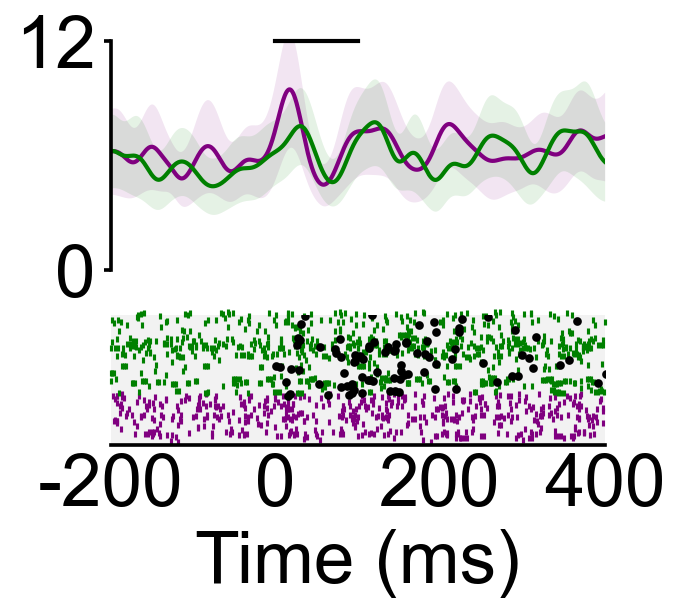

In [11]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
    # skip = True
    # if session == 'BS_40_2_AC.pickle' and clust in [190]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_3_AC.pickle' and clust in [15]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_6_AC.pickle' and clust in [27]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_10_AC.pickle' and clust in [55]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_15_AC.pickle' and clust in [0]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_40_16_AC.pickle' and clust in [24]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_5_AC.pickle' and clust in [2]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_8_AC.pickle' and clust in [15]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_9_AC.pickle' and clust in [37]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_11_AC.pickle' and clust in [18]:
    #     pass#Removed this day from consideration
    # if session == 'BS_42_2_AC.pickle' and clust in [62]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_3_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [100]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_11_AC.pickle' and clust in [44]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_49_1_AC.pickle' and clust in [23,143,150]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_2_AC.pickle' and clust in [6]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [27,68]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [39]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_49_9_AC.pickle' and clust in [45]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_50_7_AC.pickle' and clust in [12]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_70_7_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_70_8_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_72_7_AC.pickle' and clust in [35]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_87_1_AC.pickle' and clust in [30]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_87_4_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_108_1_AC.pickle' and clust in [9]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_1_AC.pickle' and clust in [16,59]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_12_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_13_AC.pickle' and clust in [41]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_15_AC.pickle' and clust in [113]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_1_AC.pickle' and clust in [1]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_40_2_AC.pickle' and clust in [210]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [124]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_16_AC.pickle' and clust in [23]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_14_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if skip:
    #     continue

    try:
        plt.close('all')
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.task == 'switch':
            print("Skipping Switch")
            continue
        
    #     fig = plt.figure(figsize=(2.75,4.5))#Old Style
        fig = plt.figure(figsize=(4.25,3.5))#New Style
        gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
        
        ax3 = plt.subplot(gs[1,0])#Raster
        ax4 = plt.subplot(gs[0,0])#,sharex=ax3)#PSTH
        ax3.set_facecolor('#F2F2F2')
        
        #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
        
    #     fst=-200
    #     fet=400
    #     xt=[-200,0,200,400]
        fst=-200
        fet=400
        xt=[-200,0,200,400]
        xtl=None#['-200','0','200','400']
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl,bw_scott_factor=8)
        if not success:
            print('Fail')
            continue
        
        #Determine FRmod category
        FRmodCategory = 'ERROR'
        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
            if FRmod < 3.5:
                FRmodCategory = 'NCR'
            elif FRmod > 5:
                FRmodCategory = 'CR'
            else:
                FRmodCategory = 'Middle'
        except Exception as e:
            print(e)
            pass
        #Skip unidentified category neurons
        if FRmodCategory in ['ERROR','nan',np.nan]:
            print("FRmodFail Skipping")
            continue
        region = sessionfile.meta.region
        EIL = EILphases[idx]
        #Skip unidentified phase neurons
        if EIL in ['ERROR','nan',np.nan]:
            print("PhaseFail Skipping")
            continue

        try:
            if not FRmodCategory == 'ERROR':
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRastersthin','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        except Exception as e:
            print(e)

        # print(ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf')
        # break
    except:
        print('fail')

## Stim Rasters - Pre-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19 Done
CR
switch


11it [00:01,  8.36it/s]

BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44 Done
Middle
switch


13it [00:02,  4.12it/s]

BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131 Done
CR
switch


19it [00:16,  1.21s/it]

BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22 Done
Middle
switch


104it [00:17,  7.80it/s]

BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33 Done
CR
switch


1829it [00:18, 96.30it/s]


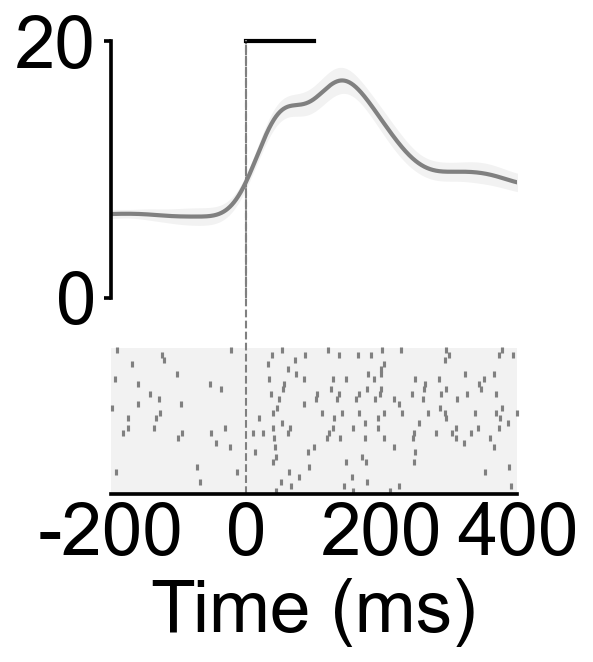

In [94]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
        
    print(f"{session} clust {clust}")
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
        
    print(f"{session} clust {clust}")
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#,wspace=0.5)#0.1)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    print(f"{session} clust {clust}")
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','+200','+400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='pre_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
        
    print(f"{session} clust {clust}")
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust} Done")
    print(FRmodCategory)
    print(EIL)
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Stim Rasters - Post-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19


11it [00:01, 10.04it/s]

BS_108_3_AC.pickle clust 44


13it [00:02,  5.02it/s]

BS_108_3_AC.pickle clust 131


19it [00:03,  5.06it/s]

BS_40_14_AC.pickle clust 22


104it [00:04, 31.15it/s]

BS_41_1_AC.pickle clust 33


1829it [00:05, 313.49it/s]


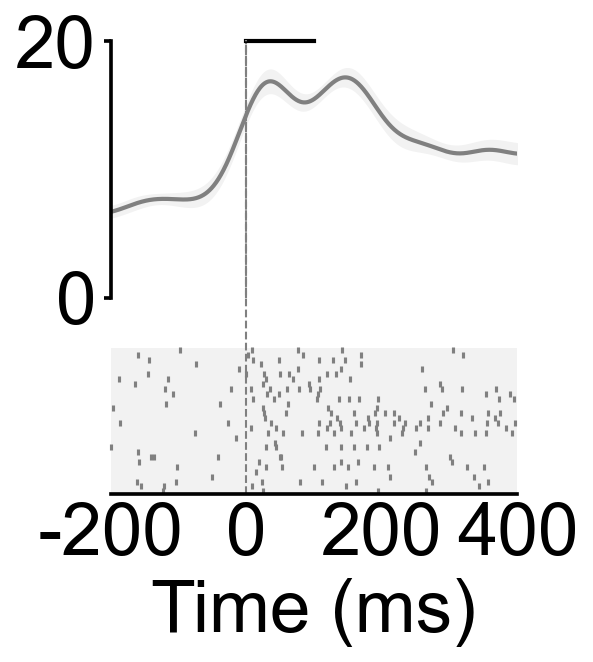

In [95]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','200','400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='post_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust}")
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Choice Rasters

1829it [00:38, 47.39it/s] 


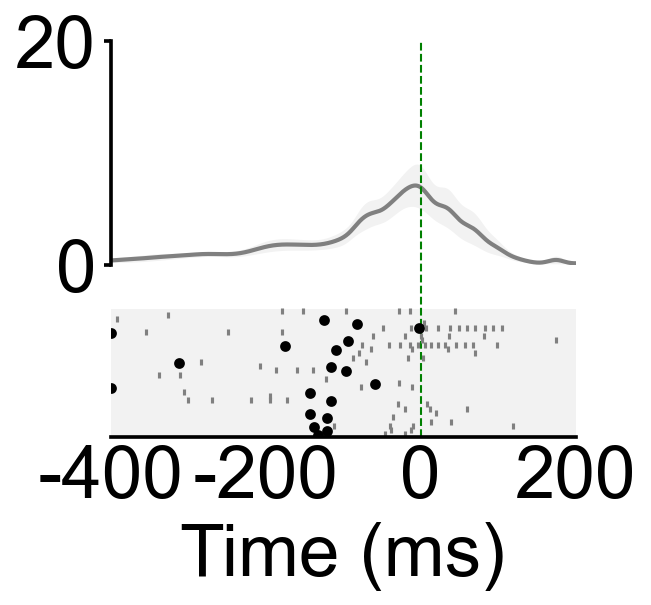

In [99]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    limitToUse = 20
    skip = True
    if session == 'BS_40_2_AC.pickle' and clust in [96,166,194,206,213]:
        if clust == 194:
            limitToUse = 40
        if clust == 96:
            limitToUse = 40
        if clust == 206:
            limitToUse = 40
        skip = False
    if session == 'BS_40_12_AC.pickle' and clust in [57]:
        limitToUse=30
        skip = False
    if session == 'BS_40_22_AC.pickle' and clust in [13]:
        skip = False
    if session == 'BS_41_9_AC.pickle' and clust in [37]:
        skip = False
    if session == 'BS_42_2_AC.pickle' and clust in [118]:
        skip = False
    if session == 'BS_42_4_AC.pickle' and clust in [65]:
        skip = False
    if session == 'BS_42_6_AC.pickle' and clust in [51]:
        limitToUse = 50
        skip = False
    if session == 'BS_42_9_AC.pickle' and clust in [32]:
        skip = False
    if session == 'BS_49_1_AC.pickle' and clust in [82,150]:
        skip = False
    if session == 'BS_49_9_AC.pickle' and clust in [61]:
        skip = False
    if session == 'BS_49_12_AC.pickle' and clust in [39]:
        skip = False
    if session == 'BS_50_2_AC.pickle' and clust in [14]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [3]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [16]:
        skip = False
    if session == 'BS_56_4_AC.pickle' and clust in [6]:
        skip = False
    if session == 'BS_50_7_AC.pickle' and clust in [5]:
        skip = False
    if session == 'BS_70_8_AC.pickle' and clust in [3]:
        skip = False
    if session == 'BS_72_1_AC.pickle' and clust in [24,30]:
        skip = False
    if session == 'BS_72_2_AC.pickle' and clust in [7,17]:
        if clust == 7:
            limitToUse = 30
        skip = False
    if session == 'BS_72_4_AC.pickle' and clust in [7,43]:
        skip = False
    if session == 'BS_72_5_AC.pickle' and clust in [22]:
        limitToUse = 50
        skip = False
    if session == 'BS_72_6_AC.pickle' and clust in [23]:
        skip = False
    if session == 'BS_87_4_AC.pickle' and clust in [154]:
        skip = False
    if session == 'BS_87_8_AC.pickle' and clust in [1]:
        skip = False
    if session == 'BS_108_1_AC.pickle' and clust in [9]:
        limitToUse=30
        skip = False
    if session == 'BS_108_6_AC.pickle' and clust in [126]:
        skip = False
    if session == 'DS_15_12_AC.pickle' and clust in [48]:
        limitToUse = 50
        skip = False
    if session == 'DS_15_13_AC.pickle' and clust in [84,113]:
        skip = False
    if session == 'DS_15_14_AC.pickle' and clust in [54]:
        skip = False
    if session == 'DS_19_3_AC.pickle' and clust in [115]:
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        continue
    
    fig = plt.figure(figsize=(4,3.5))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    
    fst=-400
    fet=200
    xt=[-400,-200,0,200]
    xtl=None#['-400','-200','0','+200']
    try:
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,align_to_choice=True,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    except Exception as e:
        print(e)
        success = False
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Pre-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='pre_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Post-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='post_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Combined Rasters

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
#     skip = True
#     if session == 'BS_40_2_AC.pickle' and clust in [190]:
#         limitToUse = 20
#         skip = False
#     if skip:
#         continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        print("Skipping Switch")
        continue
    
    fig = plt.figure(figsize=(10,6.25))#New Style
    gs = fig.add_gridspec(2,2,height_ratios=[1,1],wspace=0.75,hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
    #Stim
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    #Choice
    cax3 = plt.subplot(gs[0,1])#Raster
    cax4 = plt.subplot(gs[1,1],sharex=cax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    try:
        stim_success,stim_artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=-50,Figure_end_time_ms=150,xtickstouse=[-50,0,50,100,150])
    except:
        stim_success = False
    if not stim_success:
        continue
    try:
        choice_success,choice_artists = visualizeClusterChoiceInternal(sessionfile,clust,cax3,cax4,limitToUse=limitToUse,align_to_choice=True,Figure_start_time_ms=-150,Figure_end_time_ms=50,xtickstouse=[-150,-100,-50,0,50])
    except:
        choice_success = False
    if not choice_success:
        continue
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    Choicemod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
    
    ttl1 = ax3.set_title(FRmod)
    ttl2 = cax3.set_title(Choicemod)
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if FRmod < 3.5:
            FRmodCategory = 'NCR'
        elif FRmod > 5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        print("FRmodFail Skipping")
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        print("PhaseFail Skipping")
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

16it [01:10,  1.55s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


22it [01:10,  1.59it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


28it [01:10,  3.30it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


34it [01:11,  5.67it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


37it [01:11,  7.38it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


40it [01:11,  9.24it/s]

Skipping Switch
Skipping Switch


105it [15:30,  1.32it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


113it [15:30,  3.89it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


121it [15:30,  7.99it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


124it [15:30,  9.96it/s]

Skipping Switch


302it [1:01:39, 12.78s/it]

PhaseFail Skipping


303it [1:01:41,  9.72s/it]

PhaseFail Skipping


304it [1:01:50,  9.39s/it]

PhaseFail Skipping


305it [1:01:54,  7.70s/it]

PhaseFail Skipping


306it [1:01:56,  6.20s/it]

PhaseFail Skipping


307it [1:01:59,  5.15s/it]

PhaseFail Skipping


308it [1:02:01,  4.37s/it]

PhaseFail Skipping


309it [1:02:06,  4.32s/it]

PhaseFail Skipping


310it [1:02:08,  3.80s/it]

PhaseFail Skipping


311it [1:02:11,  3.37s/it]

PhaseFail Skipping


312it [1:02:14,  3.23s/it]

PhaseFail Skipping


313it [1:02:16,  3.02s/it]

PhaseFail Skipping


314it [1:02:17,  2.37s/it]

PhaseFail Skipping


315it [1:02:19,  2.37s/it]

PhaseFail Skipping


316it [1:02:22,  2.51s/it]

PhaseFail Skipping


319it [1:02:25,  1.45s/it]

PhaseFail Skipping
Skipping Switch
Skipping Switch
Skipping Switch


323it [1:02:25,  1.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


327it [1:02:26,  3.33it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


331it [1:02:26,  5.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


335it [1:02:26,  8.48it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


339it [1:02:27, 11.13it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


343it [1:02:27, 12.84it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


347it [1:02:27, 14.36it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


351it [1:02:27, 15.02it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


355it [1:02:28, 15.11it/s]

Skipping Switch
Skipping Switch
Skipping Switch


477it [1:42:23,  1.60s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


485it [1:42:24,  1.60it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


646it [2:50:03, 26.25s/it]

In [35]:
A

[[0, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 8],
 [7, 8, 9],
 [8, 9, 10],
 [9, 10, 11]]

In [34]:
A = [ [a,a+1,a+2] for a in range(10)]

In [36]:
kf = KFold(n_splits=10)
for idx,(_,train_index) in enumerate(kf.split(A)):
    print(train_index)
    print(A[train_index])

[0]


TypeError: only integer scalar arrays can be converted to a scalar index